In [1]:
# -*- coding: utf-8 -*-
from pathlib import Path
import warnings, inspect
import numpy as np
import mne, torch
from braindecode.preprocessing import exponential_moving_standardize
from braindecode.models import EEGNet as _EEGNET
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler

warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

# Rutas base
PROJ      = Path('..').resolve().parent   # asumiendo este notebook vive en eegnet/
DATA_PROC = PROJ / 'data' / 'processed'
OUT_DIR   = PROJ / 'results' / 'eegnet_intra'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# -------------------- Datos --------------------

def load_epochs(subject_id: str):
    fpath = sorted((DATA_PROC).glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)[-1]
    ep = mne.read_epochs(fpath, preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def crop_to_target_len(X, target_len: int):
    """Recorta o paddea el eje temporal a target_len (p. ej., 640)."""
    T = X.shape[-1]
    if T == target_len:
        return X
    if T > target_len:
        return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def prepare_xy_cropped(epochs: mne.Epochs, crop_window=(0.5,4.5), sfreq=160, target_len=640,
                       norm='ems', zscore_stats=None):
    """
    - Recorta a crop_window y fuerza longitud EXACTA target_len (640 @ 160 Hz).
    - Normalización:
        * 'ems' -> EMS por época/canal (recomendado)
        * 'ztrain' -> aplicar stats (mu,sd) globales por canal (se pasan en zscore_stats)
        * 'none' -> sin normalización
    Devuelve X(float32), y(int), (mu,sd) si norm='ztrain' y no se pasó zscore_stats.
    """
    ep = epochs.copy().crop(*crop_window)
    X = ep.get_data().astype(np.float32)        # (N,C,Traw)
    X = crop_to_target_len(X, target_len)       # (N,C,640)
    # y (0..K-1) estable:
    if ep.metadata is not None and 'target' in ep.metadata.columns:
        y = ep.metadata['target'].to_numpy().astype(int)
    else:
        ev = ep.events[:,2]; uniq = np.unique(ev)
        remap = {lab:i for i,lab in enumerate(sorted(uniq))}
        y = np.array([remap[v] for v in ev], dtype=int)

    if norm == 'ems':
        for i in range(X.shape[0]):
            X[i] = exponential_moving_standardize(
                X[i], factor_new=0.001, init_block_size=min(400, X.shape[-1]), eps=1e-4
            ).astype(np.float32)
        return X, y, None
    elif norm == 'ztrain':
        # Si no hay stats, se devolverán para aplicarlas luego en test/val
        if zscore_stats is None:
            mu = X.mean(axis=(0,2), keepdims=True)        # (1,C,1)
            sd = X.std(axis=(0,2), keepdims=True) + 1e-6
            Xn = (X - mu) / sd
            return Xn.astype(np.float32), y, (mu.astype(np.float32), sd.astype(np.float32))
        else:
            mu, sd = zscore_stats
            Xn = (X - mu) / sd
            return Xn.astype(np.float32), y, zscore_stats
    else:
        return X, y, None

# -------------------- Modelo registrado (module__*) --------------------

def _eegnet_param_names():
    sig = inspect.signature(_EEGNET.__init__)
    P = set(sig.parameters.keys())
    name_ch   = 'n_chans'   if 'n_chans'   in P else 'in_chans'
    name_out  = 'n_outputs' if 'n_outputs' in P else 'n_classes'
    has_nt    = 'n_times' in P
    has_iws   = 'input_window_seconds' in P
    has_sfreq = 'sfreq' in P
    extras    = {'final_conv_length': 'auto'} if 'final_conv_length' in P else {}
    return dict(name_ch=name_ch, name_out=name_out, has_nt=has_nt,
                has_iws=has_iws, has_sfreq=has_sfreq, extras=extras, valid=P)

def class_weights(y: np.ndarray):
    classes, counts = np.unique(y, return_counts=True)
    total = y.size
    cw = torch.zeros(int(classes.max())+1, dtype=torch.float32)
    for c, cnt in zip(classes, counts):
        cw[int(c)] = float(total / (len(classes)*cnt))
    return cw

def make_eegnet_clf_registered(n_ch, n_classes, sfreq, n_times,
                               lr=5e-4, batch_size=64, max_epochs=200,
                               weight_decay=1e-4, class_weight_vec=None,
                               seed=42, device=None, valid_ds=None,
                               **module_overrides):
    """
    Pasa EEGNetv4 como CLASE y registra TODOS los args críticos como module__*,
    para que skorch/Sklearn los conserve durante CV y re-instanciaciones.
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.manual_seed(seed); np.random.seed(seed)

    names = _eegnet_param_names()
    mod_params = {
        names['name_ch']: int(n_ch),
        names['name_out']: int(n_classes),
        **names['extras'],
    }
    if names['has_nt']:
        mod_params['n_times'] = int(n_times)
    elif names['has_iws'] and names['has_sfreq']:
        mod_params['input_window_seconds'] = float(n_times / sfreq)
        mod_params['sfreq'] = float(sfreq)
    else:
        raise ValueError("Tu firma requiere 'n_times' o ('input_window_seconds' + 'sfreq').")

    for k, v in module_overrides.items():
        if k in names['valid']:
            mod_params[k] = v

    crit = torch.nn.CrossEntropyLoss
    crit_w = class_weight_vec.to(device) if class_weight_vec is not None else None

    callbacks = None
    if valid_ds is not None:
        callbacks = [
            EarlyStopping(monitor='valid_loss', patience=15, threshold=0.0,
                          threshold_mode='rel', load_best=True),
            LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss',
                        factor=0.5, patience=7, min_lr=1e-5)
        ]

    clf = EEGClassifier(
        module=_EEGNET,                              # CLASE
        **{f"module__{k}": v for k, v in mod_params.items()},
        criterion=crit,
        criterion__weight=crit_w,
        optimizer=torch.optim.AdamW,
        lr=lr,
        batch_size=batch_size,
        max_epochs=max_epochs,
        optimizer__weight_decay=weight_decay,
        iterator_train__shuffle=True,
        train_split=predefined_split(valid_ds) if valid_ds is not None else None,
        callbacks=callbacks,
        device=device,
        verbose=0,
    )
    return clf


In [2]:
# -*- coding: utf-8 -*-
import numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from torch.utils.data import TensorDataset

def run_intra_subject_cropped(subject_id="S065",
                              crop_window=(0.5,4.5), sfreq=160, target_len=640,
                              norm_mode='ems',  # 'ems' | 'ztrain' | 'none'
                              F1=8, D=2, drop_prob=0.5, kernel_length=64,
                              lr=5e-4, batch_size=64, max_epochs=200,
                              weight_decay=1e-4, seed=42):
    # 1) Datos
    ep = load_epochs(subject_id)
    sf = float(ep.info['sfreq'])
    assert int(sf) == sfreq, f"Se esperaba sfreq={sfreq}, pero el archivo tiene {sf}"

    X_all, y_all, _ = prepare_xy_cropped(ep, crop_window=crop_window, sfreq=sfreq,
                                         target_len=target_len, norm=norm_mode)

    # Split train/test
    Xtr, Xte, ytr, yte = train_test_split(X_all, y_all, test_size=0.2,
                                          random_state=seed, stratify=y_all)

    # Si usas z-score global por canal (norm_mode='ztrain'), calcula stats en TRAIN y re-aplica:
    if norm_mode == 'ztrain':
        mu = Xtr.mean(axis=(0,2), keepdims=True)
        sd = Xtr.std(axis=(0,2), keepdims=True) + 1e-6
        Xtr = ((Xtr - mu)/sd).astype(np.float32)
        Xte = ((Xte - mu)/sd).astype(np.float32)

    # Validación interna (10% de train)
    Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr, ytr, test_size=0.1,
                                                    random_state=seed, stratify=ytr)
    to_tens = lambda a: torch.from_numpy(a.astype(np.float32))
    ds_val = TensorDataset(to_tens(Xval), torch.from_numpy(yval.astype(np.int64)))

    # Pesos por clase (del train completo)
    cw_vec = class_weights(ytr)

    # 2) Clasificador con args críticos registrados
    clf = make_eegnet_clf_registered(
        n_ch=X_all.shape[1],
        n_classes=len(np.unique(y_all)),
        sfreq=sfreq,
        n_times=target_len,        # RECORTE EXPLÍCITO a 640
        lr=lr, batch_size=batch_size, max_epochs=max_epochs,
        weight_decay=weight_decay, class_weight_vec=cw_vec, seed=seed,
        valid_ds=ds_val,
        # overrides del módulo (Braindecode 1.2 suele tener estos):
        F1=F1, D=D, drop_prob=drop_prob, kernel_length=kernel_length,
    )

    # 3) Entrenar y evaluar
    clf.fit(Xtr_sub, ytr_sub)
    yhat = clf.predict(Xte)

    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average='macro')
    ba  = balanced_accuracy_score(yte, yhat)

    print(f"[{subject_id}] ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
    return dict(acc=acc, f1m=f1m, ba=ba)

# Ejemplo de corrida:
res = run_intra_subject_cropped("S065", norm_mode='ems', F1=8, D=2, drop_prob=0.5, kernel_length=64)


[S065] ACC=0.222 | F1m=0.091 | BA=0.250


In [3]:
# -*- coding: utf-8 -*-
import inspect, numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, make_scorer
from braindecode.models import EEGNet as _EEGNET


def random_search_intra_cropped(subject_id="S065",
                                crop_window=(0.5,4.5), sfreq=160, target_len=640,
                                norm_mode='ems', seed=42, n_iter=12):

    # Datos 100% recortados a 640
    ep = load_epochs(subject_id)
    X, y, _ = prepare_xy_cropped(ep, crop_window=crop_window, sfreq=sfreq,
                                 target_len=target_len, norm=norm_mode)

    # Clasificador base con args críticos registrados
    cw_vec = class_weights(y)
    base_clf = make_eegnet_clf_registered(
        n_ch=X.shape[1], n_classes=len(np.unique(y)),
        sfreq=sfreq, n_times=target_len,
        lr=1e-3, batch_size=64, max_epochs=140,
        weight_decay=1e-4, class_weight_vec=cw_vec, seed=seed,
        # sin valid_split aquí (lo maneja CV externo)
        F1=8, D=2, drop_prob=0.5, kernel_length=64
    )

    # Filtrar hiperparámetros válidos para tu firma
    valid = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    param_dist = {
        'lr': [5e-4, 1e-3, 2e-3],
        'batch_size': [32, 64, 128],
        'optimizer__weight_decay': [0.0, 1e-4, 1e-3],
        'max_epochs': [100, 140, 180],
        'module__F1': [6, 8, 12, 16],
        'module__D': [1, 2, 4],
        'module__drop_prob': [0.25, 0.5],
        'module__kernel_length': [32, 64, 96],
    }
    cleaned = {}
    for k, vs in param_dist.items():
        if not k.startswith('module__'):
            cleaned[k] = vs
        else:
            pname = k.split('__',1)[1]
            if pname in valid:
                cleaned[k] = vs
    param_dist = cleaned
    print("Hparams válidos:", sorted(param_dist.keys()))

    # CV y scorers
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    sc_balacc = make_scorer(balanced_accuracy_score)
    sc_acc    = make_scorer(accuracy_score)
    sc_f1m    = make_scorer(f1_score, average='macro')

    # Búsqueda
    search = RandomizedSearchCV(
        estimator=base_clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring={'balacc': sc_balacc, 'acc': sc_acc, 'f1m': sc_f1m},
        refit='balacc',
        cv=cv,
        verbose=2,
        n_jobs=1,
        random_state=seed
    )
    search.fit(X, y)
    print("\nMejores hiperparámetros:", search.best_params_)
    print("Mejor BA:", search.best_score_)

    # Guardar
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    res = pd.DataFrame(search.cv_results_).sort_values('rank_test_balacc')
    path = OUT_DIR / f"{subject_id}_RS_eegnet_cropped.csv"
    res.to_csv(path, index=False)
    print("Guardado:", path)

    return search

# Ejemplo de corrida:
search = random_search_intra_cropped()

Hparams válidos: ['batch_size', 'lr', 'max_epochs', 'module__D', 'module__F1', 'module__drop_prob', 'module__kernel_length', 'optimizer__weight_decay']
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END batch_size=32, lr=0.001, max_epochs=100, module__D=4, module__F1=16, module__drop_prob=0.5, module__kernel_length=64, optimizer__weight_decay=0.001; total time=   0.7s
[CV] END batch_size=32, lr=0.001, max_epochs=100, module__D=4, module__F1=16, module__drop_prob=0.5, module__kernel_length=64, optimizer__weight_decay=0.001; total time=   0.7s
[CV] END batch_size=32, lr=0.001, max_epochs=100, module__D=4, module__F1=16, module__drop_prob=0.5, module__kernel_length=64, optimizer__weight_decay=0.001; total time=   0.7s
[CV] END batch_size=32, lr=0.001, max_epochs=100, module__D=4, module__F1=16, module__drop_prob=0.5, module__kernel_length=64, optimizer__weight_decay=0.001; total time=   0.7s
[CV] END batch_size=32, lr=0.001, max_epochs=100, module__D=4, module__F1=16, m

In [4]:
def run_intra_subject_cropped_fixed(subject_id="S065",
                                    crop_window=(0.5,4.5), sfreq=160, target_len=640,
                                    norm_mode='ztrain',
                                    F1=12, D=2, drop_prob=0.5, kernel_length=64,
                                    lr=1e-3, batch_size=64, max_epochs=200,
                                    weight_decay=1e-3, seed=42,
                                    do_overfit_test=True):

    # --- 1) Cargar y preparar datos ---
    ep = load_epochs(subject_id)
    sf = float(ep.info['sfreq'])
    assert int(sf) == sfreq, f"Se esperaba sfreq={sfreq}, archivo tiene {sf}"

    # Recorte a 640 y normalización
    X_all, y_all, _ = prepare_xy_cropped(ep, crop_window=crop_window, sfreq=sfreq,
                                         target_len=target_len,
                                         norm=('ems' if norm_mode=='ems' else 'none'))

    # 🔍 === SANITY CHECKS ===
    n_classes = len(np.unique(y_all))
    assert y_all.min() == 0 and y_all.max() == n_classes - 1, \
        f"Labels deben ser 0..{n_classes-1}, pero van {y_all.min()}..{y_all.max()}"
    assert X_all.dtype == np.float32 and X_all.ndim == 3 and X_all.shape[1] in (8,22), \
        "X debe ser (N,C,T) float32"
    assert X_all.shape[2] == 640, "T debe ser 640 tras recorte"
    print("Escala:", X_all.mean(), X_all.std())

    # --- MINI OVERFIT TEST ---
    if do_overfit_test:
        idx = np.concatenate([np.where(y_all==c)[0][:4] for c in range(n_classes)])
        X_small, y_small = X_all[idx], y_all[idx]

        clf_small = make_eegnet_clf_registered(
            n_ch=X_small.shape[1], n_classes=n_classes, sfreq=sfreq, n_times=target_len,
            lr=1e-3, batch_size=16, max_epochs=120, weight_decay=0.0,
            class_weight_vec=None, seed=0, valid_ds=None,
            F1=8, D=2, drop_prob=0.0, kernel_length=64
        )
        clf_small.fit(X_small, y_small)
        train_pred = clf_small.predict(X_small)
        print("Overfit mini-set acc:", (train_pred == y_small).mean())

run_intra_subject_cropped_fixed("S007")



Escala: -1.2796197e-09 8.790548e-06
Overfit mini-set acc: 0.25


In [5]:
def get_Xy_cropped_from_events(epochs, crop_window=(0.5,4.5), sfreq=160, target_len=640):
    ep = epochs.copy().crop(*crop_window)
    X = ep.get_data().astype(np.float32)
    # recorte/padding:
    T = X.shape[-1]
    if T > target_len: X = X[..., :target_len]
    elif T < target_len: X = np.pad(X, ((0,0),(0,0),(0,target_len-T)), mode='constant')

    # y desde events (ev_id numérico) → mapeo estable 0..K-1
    ev = ep.events[:, 2]
    uniq = np.unique(ev)
    remap = {lab:i for i, lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in ev], dtype=int)
    return X, y, remap, uniq

# Ejecuta:
ep = load_epochs("S065")
X0, y0, remap0, uniq0 = get_Xy_cropped_from_events(ep, (0.5,4.5), 160, 640)
print("Shape:", X0.shape, "| clases únicas:", np.unique(y0), "| counts:", np.bincount(y0))
print("event_id→clase:", remap0)


Shape: (90, 8, 640) | clases únicas: [0 1 2 3] | counts: [24 21 22 23]
event_id→clase: {np.int32(1): 0, np.int32(2): 1, np.int32(3): 2, np.int32(4): 3}


In [6]:
# Usaremos el constructor registrado que ya tienes:
# make_eegnet_clf_registered(n_ch, n_classes, sfreq, n_times, ...)

def mini_overfit_agresivo(X, y, sfreq=160, n_times=640, seed=0):
    # Tomar 8 por clase (si hay), máximo 32 ejemplos
    classes = np.unique(y)
    idx = []
    for c in classes:
        cand = np.where(y==c)[0][:8]
        idx.extend(cand.tolist())
    idx = np.array(idx)
    Xs, ys = X[idx], y[idx]
    print("Mini-set:", Xs.shape, "counts:", np.bincount(ys))

    clf = make_eegnet_clf_registered(
        n_ch = Xs.shape[1],
        n_classes = len(classes),
        sfreq = sfreq, n_times = n_times,
        lr = 5e-3, batch_size = 8, max_epochs = 300,
        weight_decay = 0.0, class_weight_vec = None, seed = seed,
        valid_ds = None,
        # sin regularización para forzar ajuste
        F1=16, D=4, drop_prob=0.0, kernel_length=96,
    )
    clf.fit(Xs, ys)
    yhat = clf.predict(Xs)
    acc = (yhat == ys).mean()
    print("Overfit agresivo acc:", acc)
    return acc

acc_mini = mini_overfit_agresivo(X0, y0, 160, 640)


Mini-set: (32, 8, 640) counts: [8 8 8 8]


Overfit agresivo acc: 1.0


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
X_flat = X0.reshape(X0.shape[0], -1)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
bas = []
for tr, te in cv.split(X_flat, y0):
    clf = LogisticRegression(max_iter=500, n_jobs=1, C=1.0)
    clf.fit(X_flat[tr], y0[tr])
    bas.append(balanced_accuracy_score(y0[te], clf.predict(X_flat[te])))
print("BA(LogReg) 5-fold:", np.mean(bas))


BA(LogReg) 5-fold: 0.2625


In [8]:
# -*- coding: utf-8 -*-
import warnings, inspect
import numpy as np
from pathlib import Path
import mne, torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix

from braindecode.models import EEGNet as _EEGNET  # nombre moderno (sin warning)
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler

# ====== CONFIG GLOBAL ======
warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

PROJ      = Path('..').resolve().parent   # asumiendo este notebook vive en eegnet/
DATA_PROC = PROJ / 'data' / 'processed'
OUT_DIR   = PROJ / 'results' / 'eegnet_intra'
OUT_DIR.mkdir(parents=True, exist_ok=True)

# ====== UTILIDADES ======
def load_epochs(subject_id: str):
    pats = sorted((DATA_PROC).glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)
    if not pats:
        raise FileNotFoundError(f"No hay epochs para {subject_id} en {DATA_PROC}")
    ep = mne.read_epochs(pats[-1], preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def crop_pad(X, target_len=640):
    T = X.shape[-1]
    if T == target_len: return X
    if T > target_len:  return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def Xy_cropped(epochs, crop_window=(0.5,4.5), sfreq=160, target_len=640):
    ep = epochs.copy().crop(*crop_window)
    X = crop_pad(ep.get_data().astype(np.float32), target_len)
    # y desde events → mapeo estable 0..K-1
    ev = ep.events[:, 2]
    uniq = np.unique(ev)
    remap = {lab: i for i, lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in ev], dtype=int)
    return X, y

def class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total = y.size
    w = torch.zeros(int(classes.max())+1, dtype=torch.float32)
    for c, cnt in zip(classes, counts):
        w[int(c)] = float(total / (len(classes) * cnt))
    return w

def temporal_jitter(X, max_shift=8):
    """Desplazamiento circular ±max_shift (muestras). max_shift=8 ≈ 50 ms @ 160 Hz."""
    if max_shift <= 0: return X
    Xj = np.empty_like(X)
    for i in range(len(X)):
        s = np.random.randint(-max_shift, max_shift+1)
        Xj[i] = np.roll(X[i], s, axis=1)
    return Xj

def add_gaussian_noise(X, std=0.01):
    """Ruido gaussiano leve relativo a la std del canal."""
    if std <= 0: return X
    # std por canal global
    ch_std = X.std(axis=(0,2), keepdims=True) + 1e-6
    noise = np.random.randn(*X.shape).astype(np.float32) * (ch_std * std)
    return X + noise

def eegnet_param_names():
    P = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    return {
        'name_ch':  'n_chans'   if 'n_chans'   in P else 'in_chans',
        'name_out': 'n_outputs' if 'n_outputs' in P else 'n_classes',
        'has_nt':   'n_times' in P,
        'has_iws':  'input_window_seconds' in P,
        'has_sfreq':'sfreq' in P,
        'extras':   {'final_conv_length': 'auto'} if 'final_conv_length' in P else {},
        'valid':    P
    }

def make_eegnet_clf_registered(n_ch, n_classes, sfreq, n_times, *,
                               F1=16, D=4, kernel_length=96, drop_prob=0.5,
                               lr=2e-3, batch_size=16, max_epochs=500,
                               weight_decay=5e-4, label_smoothing=0.15,
                               class_weight_vec=None, valid_ds=None,
                               seed=42, device=None):
    """EEGNet como CLASE, registrando args críticos via module__* para CV/reinstanciación."""
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    torch.manual_seed(seed); np.random.seed(seed)

    names = eegnet_param_names()
    mod = {
        names['name_ch']: int(n_ch),
        names['name_out']: int(n_classes),
        **names['extras'],
        'F1': F1, 'D': D, 'kernel_length': kernel_length, 'drop_prob': drop_prob
    }
    if names['has_nt']:
        mod['n_times'] = int(n_times)
    elif names['has_iws'] and names['has_sfreq']:
        mod['input_window_seconds'] = float(n_times/sfreq)
        mod['sfreq'] = float(sfreq)
    else:
        raise ValueError("Tu firma requiere n_times o (input_window_seconds + sfreq).")

    crit = torch.nn.CrossEntropyLoss
    crit_w = class_weight_vec.to(device) if class_weight_vec is not None else None

    callbacks = []
    if valid_ds is not None:
        callbacks = [
            EarlyStopping(monitor='valid_loss', patience=20, load_best=True),
            LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss',
                        factor=0.5, patience=8, min_lr=1e-5),
        ]

    clf = EEGClassifier(
        module=_EEGNET,  # CLASE
        **{f"module__{k}": v for k, v in mod.items()},
        criterion=crit,
        criterion__weight=crit_w,
        criterion__label_smoothing=label_smoothing,
        optimizer=torch.optim.AdamW,
        lr=lr, batch_size=batch_size, max_epochs=max_epochs,
        optimizer__weight_decay=weight_decay,
        iterator_train__shuffle=True,
        train_split=predefined_split(valid_ds) if valid_ds is not None else None,
        callbacks=callbacks,
        device=device, verbose=1
    )
    return clf

# ====== ENTRENAMIENTO INTRA-SUJETO (con recorte a 640) ======
def train_eegnet_intra_subject(subject_id="S065",
                               crop_window=(0.5, 4.5), sfreq=160, target_len=640,
                               use_class_weights=False,
                               augment=True, jitter_shift=8, noise_std=0.01,
                               norm_mode='ztrain',   # 'ztrain' | 'none'
                               # Modelo/entrenamiento
                               F1=16, D=4, kernel_length=96, drop_prob=0.5,
                               lr=2e-3, batch_size=16, max_epochs=500,
                               weight_decay=5e-4, label_smoothing=0.15,
                               seed=42):
    # 1) Datos
    ep = load_epochs(subject_id)
    sf = float(ep.info['sfreq'])
    assert int(sf) == sfreq, f"Esperaba sfreq={sfreq}, archivo tiene {sf}"

    X_all, y_all = Xy_cropped(ep, crop_window=crop_window, sfreq=sfreq, target_len=target_len)
    n_classes, n_ch = len(np.unique(y_all)), X_all.shape[1]

    # Split HOLD-OUT
    Xtr, Xte, ytr, yte = train_test_split(X_all, y_all, test_size=0.2, random_state=seed, stratify=y_all)

    # Normalización z-score global por canal (stats del train)
    if norm_mode == 'ztrain':
        mu = Xtr.mean(axis=(0,2), keepdims=True)
        sd = Xtr.std(axis=(0,2), keepdims=True) + 1e-6
        Xtr = ((Xtr - mu)/sd).astype(np.float32)
        Xte = ((Xte - mu)/sd).astype(np.float32)

    # Augment (opcional, solo sobre TRAIN)
    if augment:
        Xa = temporal_jitter(Xtr, max_shift=jitter_shift)
        Xa = add_gaussian_noise(Xa, std=noise_std)
        Xtr = np.concatenate([Xtr, Xa], axis=0)
        ytr = np.concatenate([ytr, ytr], axis=0)

    # Validación interna (10% de TRAIN)
    Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr, ytr, test_size=0.1, random_state=seed, stratify=ytr)
    ds_val = TensorDataset(torch.from_numpy(Xval), torch.from_numpy(yval.astype(np.int64)))

    # Pesos por clase (opcionales)
    cw_vec = class_weights(ytr) if use_class_weights else None

    # 2) Clasificador registrado
    clf = make_eegnet_clf_registered(
        n_ch=n_ch, n_classes=n_classes, sfreq=sfreq, n_times=target_len,
        F1=F1, D=D, kernel_length=kernel_length, drop_prob=drop_prob,
        lr=lr, batch_size=batch_size, max_epochs=max_epochs,
        weight_decay=weight_decay, label_smoothing=label_smoothing,
        class_weight_vec=cw_vec, valid_ds=ds_val, seed=seed
    )

    # 3) Entrenar + evaluar
    clf.fit(Xtr_sub, ytr_sub)
    yhat = clf.predict(Xte)

    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average='macro')
    ba  = balanced_accuracy_score(yte, yhat)
    cm  = confusion_matrix(yte, yhat)

    print(f"\n[{subject_id}] HOLD-OUT (crop={crop_window}, recorte={target_len})")
    print(f"ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
    print("Confusion matrix:\n", cm)

    # Devuelve objetos por si quieres inspeccionar curvas (clf.history), etc.
    return dict(acc=acc, f1m=f1m, ba=ba, cm=cm, clf=clf)

# ====== EJECUCIÓN (ejemplo) ======
res = train_eegnet_intra_subject(
    subject_id="S065",
    crop_window=(0.5, 4.5),
    use_class_weights=False,
    augment=True, jitter_shift=8, noise_std=0.01,
    norm_mode='ztrain',
    F1=16, D=4, kernel_length=96, drop_prob=0.5,
    lr=2e-3, batch_size=16, max_epochs=500,
    weight_decay=5e-4, label_smoothing=0.15,
    seed=42
)


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        1.4120       0.3333        1.3853  0.0020  0.0616
      2        1.3268       0.2667        1.3835  0.0020  0.0234
      3        1.2286       0.2667        1.3814  0.0020  0.0237
      4        1.1580       0.2667        1.3803  0.0020  0.0236
      5        1.0763       0.2667        1.3815  0.0020  0.0242
      6        1.0127       0.2667        1.3872  0.0020  0.0226
      7        0.9690       0.2667        1.4006  0.0020  0.0236
      8        0.9038       0.2667        1.4169  0.0020  0.0235
      9        0.8757       0.2667        1.4299  0.0020  0.0234
     10        0.8242       0.2667        1.4529  0.0020  0.0230
     11        0.7493       0.2667        1.4758  0.0020  0.0234
     12        0.7271       0.2667        1.4985  0.0020  0.0228
     13        0.7330       0.2667        1.5397  0.0020  0.0233
     14        0.6780    

In [22]:
# -*- coding: utf-8 -*-
import numpy as np, torch
from skorch.callbacks import Callback
from sklearn.metrics import balanced_accuracy_score

class TrainValDiagnostics(Callback):
    """
    Imprime BA y distribución de predicciones en:
      - un mini-subconjunto de entrenamiento (Xmini, ymini)
      - el conjunto de validación explícito (Xval, yval)
    """
    def __init__(self, Xmini=None, ymini=None, Xval=None, yval=None, print_every=5):
        self.Xmini = Xmini
        self.ymini = ymini
        self.Xval  = Xval
        self.yval  = yval
        self.print_every = print_every

    def on_epoch_end(self, net, **kwargs):
        ep = len(net.history)
        if ep % self.print_every:
            return

        def _dist(yhat):
            uniq, cnts = np.unique(yhat, return_counts=True)
            return {int(k): int(v) for k, v in zip(uniq, cnts)}

        ba_tr = ba_va = None
        dtr = dva = {}

        with torch.no_grad():
            if (self.Xmini is not None) and (self.ymini is not None):
                yhat_tr = net.predict(self.Xmini)
                ba_tr   = balanced_accuracy_score(self.ymini, yhat_tr)
                dtr     = _dist(yhat_tr)

            if (self.Xval is not None) and (self.yval is not None):
                yhat_va = net.predict(self.Xval)
                ba_va   = balanced_accuracy_score(self.yval, yhat_va)
                dva     = _dist(yhat_va)

        print(f"[Diag ep{ep}] BA_tr={ba_tr} BA_val={ba_va} | pred_tr={dtr} pred_val={dva}")


In [28]:
# -*- coding: utf-8 -*-
import warnings, numpy as np, torch, inspect
import torch.nn as nn
from pathlib import Path
import mne
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset, WeightedRandomSampler

from braindecode.models import EEGNet as _EEGNET
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring

from math import isclose
warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

# === rutas
PROJ      = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'

# === utilidades
def load_epochs(subject_id: str):
    fp = sorted(DATA_PROC.glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)[-1]
    ep = mne.read_epochs(fp, preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def crop_pad(X, target_len=640):
    T = X.shape[-1]
    if T == target_len: return X
    if T > target_len:  return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def Xy_cropped(epochs, crop_window=(0.5,4.5), target_len=640):
    ep = epochs.copy().crop(*crop_window)
    X = crop_pad(ep.get_data().astype(np.float32), target_len)
    ev = ep.events[:,2]
    uniq = np.unique(ev); remap = {lab:i for i,lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in ev], dtype=int)
    return X, y

def temporal_jitter(X, max_shift=8):
    if max_shift <= 0: return X
    Xj = np.empty_like(X)
    for i in range(len(X)):
        s = np.random.randint(-max_shift, max_shift+1)
        Xj[i] = np.roll(X[i], s, axis=1)
    return Xj

def add_gaussian_noise(X, std=0.01):
    if std <= 0: return X
    ch_std = X.std(axis=(0,2), keepdims=True) + 1e-6
    noise = np.random.randn(*X.shape).astype(np.float32) * (ch_std * std)
    return X + noise

def eegnet_param_names():
    P = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    return dict(
        name_ch  = 'n_chans'   if 'n_chans'   in P else 'in_chans',
        name_out = 'n_outputs' if 'n_outputs' in P else 'n_classes',
        has_nt   = 'n_times' in P,
        has_iws  = 'input_window_seconds' in P,
        has_sfreq= 'sfreq' in P,
        extras   = {'final_conv_length': 'auto'} if 'final_conv_length' in P else {},
        has_act  = 'activation' in P,
        has_pool = 'pool_mode' in P,
    )

# === callback B’ (pégalo si no lo has ejecutado ya)
import numpy as np, torch
from skorch.callbacks import Callback
from sklearn.metrics import balanced_accuracy_score
class TrainValDiagnostics(Callback):
    def __init__(self, Xmini=None, ymini=None, Xval=None, yval=None, print_every=5):
        self.Xmini=Xmini; self.ymini=ymini; self.Xval=Xval; self.yval=yval; self.print_every=print_every
    def on_epoch_end(self, net, **kwargs):
        ep = len(net.history)
        if ep % self.print_every: return
        def _dist(yhat):
            u,c = np.unique(yhat, return_counts=True)
            return {int(k):int(v) for k,v in zip(u,c)}
        ba_tr=ba_va=None; dtr=dva={}
        with torch.no_grad():
            if (self.Xmini is not None) and (self.ymini is not None):
                yhat_tr = net.predict(self.Xmini); ba_tr = balanced_accuracy_score(self.ymini, yhat_tr); dtr=_dist(yhat_tr)
            if (self.Xval is not None) and (self.yval is not None):
                yhat_va = net.predict(self.Xval); ba_va = balanced_accuracy_score(self.yval, yhat_va); dva=_dist(yhat_va)
        print(f"[Diag ep{ep}] BA_tr={ba_tr} BA_val={ba_va} | pred_tr={dtr} pred_val={dva}")

def train_eegnet_best_from_ablation(subject_id="S065",
                                    crop_window=(0.5,4.5), sfreq=160, target_len=640,
                                    seed=42):
    # Datos
    ep = load_epochs(subject_id)
    X, y = Xy_cropped(ep, crop_window, target_len)
    n_classes, n_ch = len(np.unique(y)), X.shape[1]

    # Split
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

    # z-score (stats de train)
    mu = Xtr.mean(axis=(0,2), keepdims=True)
    sd = Xtr.std(axis=(0,2), keepdims=True) + 1e-6
    Xtr = ((Xtr - mu)/sd).astype(np.float32)
    Xte = ((Xte - mu)/sd).astype(np.float32)

    # Augment (sí)
    Xtr_aug = add_gaussian_noise(temporal_jitter(Xtr, 8), 0.01)
    Xtr2 = np.concatenate([Xtr, Xtr_aug], axis=0)
    ytr2 = np.concatenate([ytr, ytr], axis=0)

    # Validación 10%
    Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr2, ytr2, test_size=0.1,
                                                    random_state=seed, stratify=ytr2)
    # Mini-train para diagnóstico (3 por clase)
    mini_idx=[]
    for c in np.unique(ytr_sub): mini_idx.extend(np.where(ytr_sub==c)[0][:3])
    mini_idx=np.array(mini_idx)
    Xmini = Xtr_sub[mini_idx]
    ymini = ytr_sub[mini_idx]

    # Tensores para callback
    Xmini_t = torch.from_numpy(Xmini)
    ymini_t = torch.from_numpy(ymini.astype(np.int64))
    Xval_t  = torch.from_numpy(Xval)
    yval_t  = torch.from_numpy(yval.astype(np.int64))

    ds_val = TensorDataset(Xval_t, yval_t)

    # Sampler balanceado
    class_counts = np.bincount(ytr_sub)
    inv_freq = {c: 1.0/(cnt+1e-9) for c, cnt in enumerate(class_counts)}
    sample_w = np.array([inv_freq[c] for c in ytr_sub], dtype=np.float32)
    sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

    # Parámetros del top-1 de tu ablación
    F1=8; D=2; K=128; drop=0.5; LR=2e-3

    P = eegnet_param_names()
    mod = {P['name_ch']:int(n_ch), P['name_out']:int(n_classes), **P['extras'],
           'F1':F1, 'D':D, 'kernel_length':K, 'drop_prob':drop}
    if P['has_nt']:
        mod['n_times'] = int(target_len)
    else:
        mod['input_window_seconds'] = float(target_len/sfreq); mod['sfreq'] = float(sfreq)
    if P['has_act']:
        mod['activation'] = nn.ReLU
    if P['has_pool']:
        mod['pool_mode'] = 'mean'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    clf = EEGClassifier(
        module=_EEGNET,
        **{f"module__{k}": v for k,v in mod.items()},
        criterion=torch.nn.CrossEntropyLoss,  # sin label smoothing aquí
        optimizer=torch.optim.AdamW,
        lr=LR, batch_size=16, max_epochs=400, optimizer__weight_decay=5e-4,
        train_split=predefined_split(ds_val),
        callbacks=[
            EpochScoring('balanced_accuracy', lower_is_better=False, on_train=False, name='valid_balacc'),
            EarlyStopping(monitor='valid_balacc', patience=30, load_best=True),
            LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=10, min_lr=1e-5),
            TrainValDiagnostics(Xmini=Xmini_t, ymini=ymini_t, Xval=Xval_t, yval=yval_t, print_every=5)
        ],
        iterator_train__sampler=sampler,
        iterator_train__shuffle=(sampler is None),
        device=device, verbose=1
    )

    clf.fit(Xtr_sub, ytr_sub)

    yhat = clf.predict(Xte)
    ba  = balanced_accuracy_score(yte, yhat)
    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average='macro')
    cm  = confusion_matrix(yte, yhat)

    print(f"\n[{subject_id} | best-ablation] ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
    print("CM:\n", cm)
    return dict(acc=acc, f1m=f1m, ba=ba, cm=cm, clf=clf)

# Ejecuta:
resA_prime = train_eegnet_best_from_ablation("S065")


  epoch    train_loss    valid_acc    valid_balacc    valid_loss      lr     dur
-------  ------------  -----------  --------------  ------------  ------  ------
      1        1.4209       0.3333          0.3125        1.3851  0.0020  0.0245
      2        1.3813       0.4000          0.3958        1.3831  0.0020  0.0224
      3        1.3234       0.4000          0.3958        1.3803  0.0020  0.0228
      4        1.3281       0.2667          0.3125        1.3771  0.0020  0.0222
[Diag ep5] BA_tr=0.41666666666666663 BA_val=0.4375 | pred_tr={1: 8, 2: 4} pred_val={1: 11, 2: 4}
      5        1.2605       0.4000          0.4375        1.3705  0.0020  0.0221
      6        1.1810       0.6667          0.6667        1.3606  0.0020  0.0229
      7        1.1590       0.6667          0.6458        1.3491  0.0020  0.0223
      8        1.2240       0.7333          0.7292        1.3347  0.0020  0.0219
      9        1.1554       0.4000          0.4167        1.3172  0.0020  0.0221
[Diag ep10] 

In [17]:
# -*- coding: utf-8 -*-
import warnings, numpy as np, torch, inspect, itertools
import torch.nn as nn
from pathlib import Path
import mne
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
from torch.utils.data import TensorDataset, WeightedRandomSampler

from braindecode.models import EEGNet as _EEGNET
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring

warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

PROJ      = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'

def load_epochs(subject_id: str):
    fp = sorted(DATA_PROC.glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)[-1]
    ep = mne.read_epochs(fp, preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def crop_pad(X, target_len=640):
    T = X.shape[-1]
    if T == target_len: return X
    if T > target_len:  return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def Xy_cropped(epochs, crop_window=(0.5,4.5), sfreq=160, target_len=640):
    ep = epochs.copy().crop(*crop_window)
    X = crop_pad(ep.get_data().astype(np.float32), target_len)
    ev = ep.events[:,2]
    uniq = np.unique(ev); remap = {lab:i for i,lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in ev], dtype=int)
    return X, y

def temporal_jitter(X, max_shift=8):
    if max_shift <= 0: return X
    Xj = np.empty_like(X)
    for i in range(len(X)):
        s = np.random.randint(-max_shift, max_shift+1)
        Xj[i] = np.roll(X[i], s, axis=1)
    return Xj

def add_gaussian_noise(X, std=0.01):
    if std <= 0: return X
    ch_std = X.std(axis=(0,2), keepdims=True) + 1e-6
    noise = np.random.randn(*X.shape).astype(np.float32) * (ch_std * std)
    return X + noise

def eegnet_param_names():
    P = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    return dict(
        name_ch  = 'n_chans'   if 'n_chans'   in P else 'in_chans',
        name_out = 'n_outputs' if 'n_outputs' in P else 'n_classes',
        has_nt   = 'n_times' in P,
        has_iws  = 'input_window_seconds' in P,
        has_sfreq= 'sfreq' in P,
        extras   = {'final_conv_length': 'auto'} if 'final_conv_length' in P else {},
        has_act  = 'activation' in P,
        has_pool = 'pool_mode' in P,
    )

class TrainValDiagnostics(Callback):
    def __init__(self, X_train_small=None, y_train_small=None, print_every=5):
        self.Xts = X_train_small; self.yts = y_train_small; self.print_every = print_every
    def on_epoch_end(self, net, **kwargs):
        import numpy as np, torch
        from sklearn.metrics import balanced_accuracy_score
        ep = len(net.history)
        if ep % self.print_every: return
        ba_tr, dist_tr = None, {}
        if (self.Xts is not None) and (self.yts is not None):
            with torch.no_grad(): yhat_tr = net.predict(self.Xts)
            ba_tr = balanced_accuracy_score(self.yts, yhat_tr)
            u,c = np.unique(yhat_tr, return_counts=True); dist_tr = {int(k):int(v) for k,v in zip(u,c)}
        ba_v, dist_v = None, {}
        if hasattr(net,'valid_ds') and (net.valid_ds is not None):
            Xv,yv = net.valid_ds.tensors
            with torch.no_grad(): yhat_v = net.predict(Xv.numpy())
            ba_v = balanced_accuracy_score(yv.numpy(), yhat_v)
            u,c = np.unique(yhat_v, return_counts=True); dist_v = {int(k):int(v) for k,v in zip(u,c)}
        print(f"[Diag ep{ep}] BA_tr={ba_tr} BA_val={ba_v} pred_tr={dist_tr} pred_val={dist_v}")

def make_class_weights(y):
    bc = np.bincount(y); w = bc.max() / (bc + 1e-9); w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)

def run_ablation_eegnet(subject_id="S065",
                        crop_window=(0.5,4.5), sfreq=160, target_len=640,
                        seed=42, max_epochs=300):
    ep = load_epochs(subject_id)
    X, y = Xy_cropped(ep, crop_window, sfreq, target_len)
    n_classes, n_ch = len(np.unique(y)), X.shape[1]

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    mu = Xtr.mean(axis=(0,2), keepdims=True); sd = Xtr.std(axis=(0,2), keepdims=True) + 1e-6
    Xtr = ((Xtr - mu)/sd).astype(np.float32); Xte = ((Xte - mu)/sd).astype(np.float32)

    def augment(X):
        Xj = temporal_jitter(X, max_shift=8)
        Xn = add_gaussian_noise(Xj, std=0.01)
        return np.concatenate([X, Xn], axis=0)

    results = []
    use_augment_opts = [False, True]
    sampler_or_weights = ['sampler', 'weights']
    dropout_opts = [0.0, 0.25, 0.5]
    F1_opts = [8, 16, 32]
    D_opts = [2, 4]
    kern_opts = [64, 96, 128]
    act_opts = [nn.ELU, nn.ReLU]
    lr_opts = [2e-3, 1e-3]

    grid = itertools.product(use_augment_opts, sampler_or_weights, dropout_opts,
                             F1_opts, D_opts, kern_opts, act_opts, lr_opts)

    cfg_id = 0
    for use_aug, smode, drop_p, F1, D, K, ACT, LR in grid:
        cfg_id += 1
        Xtr_use, ytr_use = (augment(Xtr), np.concatenate([ytr,ytr])) if use_aug else (Xtr, ytr)
        Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr_use, ytr_use, test_size=0.1,
                                                        random_state=seed, stratify=ytr_use)
        ds_val = TensorDataset(torch.from_numpy(Xval), torch.from_numpy(yval.astype(np.int64)))

        sampler, class_weights = None, None
        if smode == 'sampler':
            class_counts = np.bincount(ytr_sub)
            inv_freq = {c: 1.0/(cnt+1e-9) for c, cnt in enumerate(class_counts)}
            sample_w = np.array([inv_freq[c] for c in ytr_sub], dtype=np.float32)
            sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)
        else:
            class_weights = make_class_weights(ytr_sub)

        P = eegnet_param_names()
        mod = {P['name_ch']:int(n_ch), P['name_out']:int(n_classes), **P['extras'],
               'F1':F1, 'D':D, 'kernel_length':K, 'drop_prob':drop_p}
        if P['has_nt']:
            mod['n_times'] = int(target_len)
        else:
            mod['input_window_seconds'] = float(target_len/sfreq); mod['sfreq'] = float(sfreq)
        if P['has_act']:
            mod['activation'] = ACT
        if P['has_pool']:
            mod['pool_mode'] = 'mean'

        # mini diag
        mini_idx=[]
        for c in np.unique(ytr_sub): mini_idx.extend(np.where(ytr_sub==c)[0][:3])
        mini_idx=np.array(mini_idx)
        diag_cb = TrainValDiagnostics(
            X_train_small=torch.from_numpy(Xtr_sub[mini_idx]),
            y_train_small=torch.from_numpy(ytr_sub[mini_idx].astype(np.int64)),
            print_every=5
        )

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        clf = EEGClassifier(
            module=_EEGNET,
            **{f"module__{k}": v for k,v in mod.items()},
            criterion=torch.nn.CrossEntropyLoss,
            optimizer=torch.optim.AdamW,
            lr=LR, batch_size=16, max_epochs=max_epochs,
            optimizer__weight_decay=5e-4,
            train_split=predefined_split(ds_val),
            callbacks=[
                EpochScoring('balanced_accuracy', lower_is_better=False, on_train=False, name='valid_balacc'),
                EarlyStopping(monitor='valid_balacc', patience=25, load_best=True),
                LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=10, min_lr=1e-5),
                diag_cb
            ],
            iterator_train__sampler=sampler,
            iterator_train__shuffle=(sampler is None),
            device=device, verbose=0
        )
        if class_weights is not None:
            clf.set_params(criterion__weight=class_weights.to(device))

        try:
            clf.fit(Xtr_sub, ytr_sub)
            yhat = clf.predict(Xte)
            ba  = balanced_accuracy_score(yte, yhat)
            acc = accuracy_score(yte, yhat)
            f1m = f1_score(yte, yhat, average='macro')
        except Exception as e:
            ba = acc = f1m = -1.0
            print(f"[CFG {cfg_id}] error: {e}")

        rec = OrderedDict(cfg=cfg_id, aug=use_aug, mode=smode, drop=drop_p,
                          F1=F1, D=D, K=K, act=ACT.__name__, lr=LR,
                          ACC=acc, BA=ba, F1m=f1m)
        results.append(rec)
        print(f"[CFG {cfg_id}] BA={ba:.3f} ACC={acc:.3f} F1m={f1m:.3f} | "
              f"{smode}, drop={drop_p}, F1={F1}, D={D}, K={K}, act={ACT.__name__}, lr={LR}, aug={use_aug}")

    results = sorted(results, key=lambda r: r['BA'], reverse=True)
    print("\n=== TOP 5 por BA ===")
    for r in results[:5]:
        print(r)
    return results

# Ejecuta:
abla = run_ablation_eegnet("S065", max_epochs=250)


[Diag ep5] BA_tr=0.5 BA_val=None pred_tr={0: 6, 1: 1, 2: 5} pred_val={}
[Diag ep10] BA_tr=0.25 BA_val=None pred_tr={2: 12} pred_val={}
[Diag ep15] BA_tr=0.25 BA_val=None pred_tr={2: 12} pred_val={}
[Diag ep20] BA_tr=0.25 BA_val=None pred_tr={2: 12} pred_val={}
[Diag ep25] BA_tr=0.25 BA_val=None pred_tr={2: 12} pred_val={}
[CFG 1] BA=0.287 ACC=0.278 F1m=0.185 | sampler, drop=0.0, F1=8, D=2, K=64, act=ELU, lr=0.002, aug=False
[Diag ep5] BA_tr=0.3333333333333333 BA_val=None pred_tr={0: 1, 3: 11} pred_val={}
[Diag ep10] BA_tr=0.3333333333333333 BA_val=None pred_tr={0: 1, 3: 11} pred_val={}
[Diag ep15] BA_tr=0.41666666666666663 BA_val=None pred_tr={2: 10, 3: 2} pred_val={}
[Diag ep20] BA_tr=0.25 BA_val=None pred_tr={2: 12} pred_val={}
[Diag ep25] BA_tr=0.3333333333333333 BA_val=None pred_tr={2: 11, 3: 1} pred_val={}
[CFG 2] BA=0.287 ACC=0.278 F1m=0.250 | sampler, drop=0.0, F1=8, D=2, K=64, act=ELU, lr=0.001, aug=False
[Diag ep5] BA_tr=0.25 BA_val=None pred_tr={0: 11, 1: 1} pred_val={}
[Diag

In [18]:
# -*- coding: utf-8 -*-
import warnings, numpy as np, torch, inspect
import torch.nn as nn
from pathlib import Path
import mne
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset

from braindecode.models import EEGNet as _EEGNET
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring, Callback

warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

PROJ      = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'

def load_epochs(subject_id: str):
    fp = sorted(DATA_PROC.glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)[-1]
    ep = mne.read_epochs(fp, preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def crop_pad(X, target_len=640):
    T = X.shape[-1]
    if T == target_len: return X
    if T > target_len:  return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def Xy_cropped(epochs, crop_window=(0.5,4.5), sfreq=160, target_len=640):
    ep = epochs.copy().crop(*crop_window)
    X = crop_pad(ep.get_data().astype(np.float32), target_len)
    ev = ep.events[:,2]
    uniq = np.unique(ev); remap = {lab:i for i,lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in ev], dtype=int)
    return X, y

class TrainValDiagnostics(Callback):
    def __init__(self, X_train_small=None, y_train_small=None, print_every=5):
        self.Xts=X_train_small; self.yts=y_train_small; self.print_every=print_every
    def on_epoch_end(self, net, **kwargs):
        import numpy as np, torch
        from sklearn.metrics import balanced_accuracy_score
        ep = len(net.history)
        if ep % self.print_every: return
        ba_tr, dist_tr = None, {}
        if (self.Xts is not None) and (self.yts is not None):
            with torch.no_grad(): yhat_tr = net.predict(self.Xts)
            ba_tr = balanced_accuracy_score(self.yts, yhat_tr)
            u,c = np.unique(yhat_tr, return_counts=True); dist_tr = {int(k):int(v) for k,v in zip(u,c)}
        ba_v, dist_v = None, {}
        if hasattr(net,'valid_ds') and (net.valid_ds is not None):
            Xv,yv = net.valid_ds.tensors
            with torch.no_grad(): yhat_v = net.predict(Xv.numpy())
            ba_v = balanced_accuracy_score(yv.numpy(), yhat_v)
            u,c = np.unique(yhat_v, return_counts=True); dist_v = {int(k):int(v) for k,v in zip(u,c)}
        print(f"[Diag ep{ep}] BA_tr={ba_tr} BA_val={ba_v} pred_tr={dist_tr} pred_val={dist_v}")

def eegnet_param_names():
    P = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    return dict(
        name_ch  = 'n_chans'   if 'n_chans'   in P else 'in_chans',
        name_out = 'n_outputs' if 'n_outputs' in P else 'n_classes',
        has_nt   = 'n_times' in P,
        has_iws  = 'input_window_seconds' in P,
        has_sfreq= 'sfreq' in P,
        extras   = {'final_conv_length': 'auto'} if 'final_conv_length' in P else {},
        has_act  = 'activation' in P,
        has_pool = 'pool_mode' in P,
    )

def make_class_weights(y):
    bc = np.bincount(y); w = bc.max() / (bc + 1e-9); w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32)

def train_eegnet_weights_only(subject_id="S065",
                              crop_window=(0.5,4.5), sfreq=160, target_len=640,
                              F1=32, D=4, kernel_length=128, drop_prob=0.0,
                              use_aug=True, seed=42, max_epochs=500):
    ep = load_epochs(subject_id)
    X, y = Xy_cropped(ep, crop_window, sfreq, target_len)
    n_classes, n_ch = len(np.unique(y)), X.shape[1]

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
    mu = Xtr.mean(axis=(0,2), keepdims=True); sd = Xtr.std(axis=(0,2), keepdims=True)+1e-6
    Xtr = ((Xtr - mu)/sd).astype(np.float32); Xte = ((Xte - mu)/sd).astype(np.float32)

    if use_aug:
        # augment leve
        Xj = np.empty_like(Xtr)
        for i in range(len(Xtr)):
            s = np.random.randint(-6, 7)
            Xj[i] = np.roll(Xtr[i], s, axis=1)
        ch_std = Xtr.std(axis=(0,2), keepdims=True) + 1e-6
        Xn = Xj + np.random.randn(*Xj.shape).astype(np.float32) * (ch_std * 0.01)
        Xtr2 = np.concatenate([Xtr, Xn], axis=0); ytr2 = np.concatenate([ytr, ytr], axis=0)
    else:
        Xtr2, ytr2 = Xtr, ytr

    Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr2, ytr2, test_size=0.1,
                                                    random_state=seed, stratify=ytr2)
    ds_val = TensorDataset(torch.from_numpy(Xval), torch.from_numpy(yval.astype(np.int64)))

    class_weights = make_class_weights(ytr_sub)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    class_weights = class_weights.to(device)

    P = eegnet_param_names()
    mod = {P['name_ch']:int(n_ch), P['name_out']:int(n_classes), **P['extras'],
           'F1':F1, 'D':D, 'kernel_length':kernel_length, 'drop_prob':drop_prob}
    if P['has_nt']:
        mod['n_times'] = int(target_len)
    else:
        mod['input_window_seconds'] = float(target_len/sfreq); mod['sfreq'] = float(sfreq)
    if P['has_act']:
        mod['activation'] = nn.ELU
    if P['has_pool']:
        mod['pool_mode'] = 'mean'

    # mini diag
    mini_idx=[]
    for c in np.unique(ytr_sub): mini_idx.extend(np.where(ytr_sub==c)[0][:4])
    mini_idx=np.array(mini_idx)
    diag_cb = TrainValDiagnostics(
        X_train_small=torch.from_numpy(Xtr_sub[mini_idx]),
        y_train_small=torch.from_numpy(ytr_sub[mini_idx].astype(np.int64)),
        print_every=5
    )

    clf = EEGClassifier(
        module=_EEGNET,
        **{f"module__{k}": v for k,v in mod.items()},
        criterion=torch.nn.CrossEntropyLoss,
        criterion__weight=class_weights,
        optimizer=torch.optim.AdamW,
        lr=1e-3, batch_size=16, max_epochs=max_epochs, optimizer__weight_decay=5e-4,
        train_split=predefined_split(ds_val),
        callbacks=[
            EpochScoring('balanced_accuracy', lower_is_better=False, on_train=False, name='valid_balacc'),
            EarlyStopping(monitor='valid_balacc', patience=30, load_best=True),
            LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=10, min_lr=1e-5),
            diag_cb
        ],
        iterator_train__shuffle=True,
        device=device, verbose=1
    )

    clf.fit(Xtr_sub, ytr_sub)
    yhat = clf.predict(Xte)
    ba  = balanced_accuracy_score(yte, yhat)
    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average='macro')
    cm  = confusion_matrix(yte, yhat)

    print(f"\n[{subject_id} | weights-only] ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
    print("CM:\n", cm)
    return dict(acc=acc, f1m=f1m, ba=ba, cm=cm, clf=clf)

# Ejecuta:
resD = train_eegnet_weights_only("S065")


  epoch    train_loss    valid_acc    valid_balacc    valid_loss      lr     dur
-------  ------------  -----------  --------------  ------------  ------  ------
      1        1.3350       0.2667          0.2500        1.3836  0.0010  0.0245
      2        0.9670       0.2667          0.2500        1.3792  0.0010  0.0230
      3        0.7131       0.2667          0.2500        1.3779  0.0010  0.0227
      4        0.5259       0.2667          0.2500        1.3821  0.0010  0.0225
[Diag ep5] BA_tr=0.25 BA_val=None pred_tr={2: 16} pred_val={}
      5        0.3348       0.2667          0.2500        1.3973  0.0010  0.0223
      6        0.2031       0.2667          0.2500        1.4199  0.0010  0.0229
      7        0.1116       0.2667          0.2500        1.4521  0.0010  0.0225
      8        0.0729       0.2667          0.2500        1.5076  0.0010  0.0224
      9        0.0383       0.2667          0.2500        1.5783  0.0010  0.0229
[Diag ep10] BA_tr=0.25 BA_val=None pred_tr={2: 

In [24]:
# -*- coding: utf-8 -*-
import warnings, numpy as np, torch, inspect
import torch.nn as nn
from pathlib import Path
import mne
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset
from scipy.signal import butter, sosfiltfilt

from braindecode.models import EEGNet as _EEGNET
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring

warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

PROJ      = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'

def load_epochs(subject_id: str):
    fp = sorted(DATA_PROC.glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)[-1]
    ep = mne.read_epochs(fp, preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def crop_pad(X, target_len=640):
    T = X.shape[-1]
    if T == target_len: return X
    if T > target_len:  return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def Xy_base(epochs, crop_window=(0.5,4.5), target_len=640):
    ep = epochs.copy().crop(*crop_window)
    X = crop_pad(ep.get_data().astype(np.float32), target_len)
    ev = ep.events[:,2]
    uniq = np.unique(ev); remap = {lab:i for i,lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in ev], dtype=int)
    return X, y

FB_BANDS = [(8,12),(10,14),(12,16),(14,18),(16,20),(18,22),(20,24),(22,26),(24,28),(26,30),(28,32)]
def butter_sos(sfreq, band, order=4):
    nyq = 0.5*sfreq
    low, high = band[0]/nyq, band[1]/nyq
    return butter(order, [low, high], btype='band', output='sos')

def filterbank_concat(X, sfreq=160):
    outs = []
    for lo, hi in FB_BANDS:
        sos = butter_sos(sfreq, (lo,hi), order=4)
        Xb = sosfiltfilt(sos, X, axis=-1).astype(np.float32)
        outs.append(Xb)
    return np.concatenate(outs, axis=1)  # (n_ep, 8*11=88, T)

def eegnet_param_names():
    P = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    return dict(
        name_ch  = 'n_chans'   if 'n_chans'   in P else 'in_chans',
        name_out = 'n_outputs' if 'n_outputs' in P else 'n_classes',
        has_nt   = 'n_times' in P,
        has_iws  = 'input_window_seconds' in P,
        has_sfreq= 'sfreq' in P,
        extras   = {'final_conv_length': 'auto'} if 'final_conv_length' in P else {},
        has_act  = 'activation' in P,
        has_pool = 'pool_mode' in P,
    )

# === callback B’
import numpy as np, torch
from skorch.callbacks import Callback
from sklearn.metrics import balanced_accuracy_score
class TrainValDiagnostics(Callback):
    def __init__(self, Xmini=None, ymini=None, Xval=None, yval=None, print_every=5):
        self.Xmini=Xmini; self.ymini=ymini; self.Xval=Xval; self.yval=yval; self.print_every=print_every
    def on_epoch_end(self, net, **kwargs):
        ep = len(net.history)
        if ep % self.print_every: return
        def _dist(yhat):
            u,c = np.unique(yhat, return_counts=True)
            return {int(k):int(v) for k,v in zip(u,c)}
        ba_tr=ba_va=None; dtr=dva={}
        with torch.no_grad():
            if (self.Xmini is not None) and (self.ymini is not None):
                yhat_tr = net.predict(self.Xmini); ba_tr = balanced_accuracy_score(self.ymini, yhat_tr); dtr=_dist(yhat_tr)
            if (self.Xval is not None) and (self.yval is not None):
                yhat_va = net.predict(self.Xval); ba_va = balanced_accuracy_score(self.yval, yhat_va); dva=_dist(yhat_va)
        print(f"[Diag ep{ep}] BA_tr={ba_tr} BA_val={ba_va} | pred_tr={dtr} pred_val={dva}")

def train_fb_eegnet_tuned(subject_id="S065",
                          crop_window=(0.5,4.5), sfreq=160, target_len=640,
                          seed=42, max_epochs=350):
    ep = load_epochs(subject_id)
    X0, y = Xy_base(ep, crop_window, target_len)

    # z-score por canal original
    mu = X0.mean(axis=(0,2), keepdims=True)
    sd = X0.std(axis=(0,2), keepdims=True) + 1e-6
    X0z = ((X0 - mu)/sd).astype(np.float32)

    # Filter-bank → concat canales
    Xfb = filterbank_concat(X0z, sfreq=sfreq)  # (n_ep, 88, 640)
    n_classes, n_ch = len(np.unique(y)), Xfb.shape[1]

    # Hold-out y valid
    Xtr, Xte, ytr, yte = train_test_split(Xfb, y, test_size=0.2, random_state=seed, stratify=y)
    Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr, ytr, test_size=0.1, random_state=seed, stratify=ytr)
    Xmini_idx=[]; 
    for c in np.unique(ytr_sub): Xmini_idx.extend(np.where(ytr_sub==c)[0][:3])
    Xmini_idx=np.array(Xmini_idx)
    Xmini = torch.from_numpy(Xtr_sub[Xmini_idx]); ymini=torch.from_numpy(ytr_sub[Xmini_idx].astype(np.int64))
    Xval_t= torch.from_numpy(Xval);             yval_t=torch.from_numpy(yval.astype(np.int64))
    ds_val = TensorDataset(Xval_t, yval_t)

    # Hiperparámetros “ganadores”
    F1=8; D=2; K=96; drop=0.5; LR=2e-3

    P = eegnet_param_names()
    mod = {P['name_ch']:int(n_ch), P['name_out']:int(n_classes), **P['extras'],
           'F1':F1, 'D':D, 'kernel_length':K, 'drop_prob':drop}
    if P['has_nt']:
        mod['n_times'] = int(target_len)
    else:
        mod['input_window_seconds'] = float(target_len/sfreq); mod['sfreq'] = float(sfreq)
    if P['has_act']:
        mod['activation'] = nn.ReLU
    if P['has_pool']:
        mod['pool_mode'] = 'mean'

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    clf = EEGClassifier(
        module=_EEGNET,
        **{f"module__{k}": v for k,v in mod.items()},
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.AdamW,
        lr=LR, batch_size=16, max_epochs=max_epochs, optimizer__weight_decay=5e-4,
        train_split=predefined_split(ds_val),
        callbacks=[
            EpochScoring('balanced_accuracy', lower_is_better=False, on_train=False, name='valid_balacc'),
            EarlyStopping(monitor='valid_balacc', patience=30, load_best=True),
            LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=10, min_lr=1e-5),
            TrainValDiagnostics(Xmini=Xmini, ymini=ymini, Xval=Xval_t, yval=yval_t, print_every=5)
        ],
        iterator_train__shuffle=True,
        device=device, verbose=1
    )

    clf.fit(Xtr_sub, ytr_sub)
    yhat = clf.predict(Xte)
    ba  = balanced_accuracy_score(yte, yhat)
    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average='macro')
    cm  = confusion_matrix(yte, yhat)
    print(f"\n[FB-EEGNet tuned {subject_id}] ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f} | n_ch={n_ch}")
    print("CM:\n", cm)
    return dict(acc=acc, f1m=f1m, ba=ba, cm=cm, clf=clf)

# Ejecuta:
resF_prime = train_fb_eegnet_tuned("S065")


  epoch    train_loss    valid_acc    valid_balacc    valid_loss      lr     dur
-------  ------------  -----------  --------------  ------------  ------  ------
      1        1.4551       0.2500          0.2500        1.3857  0.0020  0.0308
      2        1.3997       0.2500          0.2500        1.3857  0.0020  0.0295


      3        1.4167       0.2500          0.2500        1.3857  0.0020  0.0295
      4        1.3572       0.2500          0.2500        1.3858  0.0020  0.0298
[Diag ep5] BA_tr=0.25 BA_val=0.25 | pred_tr={2: 12} pred_val={2: 8}
      5        1.3342       0.2500          0.2500        1.3858  0.0020  0.0291
      6        1.3213       0.2500          0.2500        1.3859  0.0020  0.0305
      7        1.2896       0.2500          0.2500        1.3860  0.0020  0.0294
      8        1.3491       0.2500          0.2500        1.3860  0.0020  0.0289
      9        1.3143       0.2500          0.2500        1.3859  0.0020  0.0284
[Diag ep10] BA_tr=0.25 BA_val=0.25 | pred_tr={2: 12} pred_val={2: 8}
     10        1.2258       0.2500          0.2500        1.3858  0.0020  0.0300
     11        1.2113       0.2500          0.2500        1.3857  0.0020  0.0293
     12        1.2163       0.2500          0.2500        1.3852  0.0020  0.0299
     13        1.2092       0.2500          0.2500   

In [25]:
# -*- coding: utf-8 -*-
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

def split_report(y, seed=42):
    y = np.asarray(y)
    ytr, yte = train_test_split(y, test_size=0.2, random_state=seed, stratify=y)
    ytr_sub, yval = train_test_split(ytr, test_size=0.1, random_state=seed, stratify=ytr)
    def _rep(name, v):
        c = Counter(v); total=len(v)
        print(f"{name}: n={total} | dist=", {k: f"{c[k]}/{total} ({c[k]/total:.2f})" for k in sorted(c)})
    _rep("TRAIN(sub)", ytr_sub)
    _rep("VALID", yval)
    _rep("TEST",  yte)

# Ejemplo:
ep = load_epochs("S065")
X, y = Xy_cropped(ep)
split_report(y)


TRAIN(sub): n=64 | dist= {np.int64(0): '17/64 (0.27)', np.int64(1): '15/64 (0.23)', np.int64(2): '16/64 (0.25)', np.int64(3): '16/64 (0.25)'}
VALID: n=8 | dist= {np.int64(0): '2/8 (0.25)', np.int64(1): '2/8 (0.25)', np.int64(2): '2/8 (0.25)', np.int64(3): '2/8 (0.25)'}
TEST: n=18 | dist= {np.int64(0): '5/18 (0.28)', np.int64(1): '4/18 (0.22)', np.int64(2): '4/18 (0.22)', np.int64(3): '5/18 (0.28)'}


In [29]:
# -*- coding: utf-8 -*-
import numpy as np, torch
import torch.nn as nn
from skorch.callbacks import Callback

# --- Focal Loss (opcional)
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean', label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.eps = label_smoothing
    def forward(self, logits, target):
        # label smoothing sobre CE
        if self.eps > 0:
            num_classes = logits.shape[1]
            with torch.no_grad():
                true_dist = torch.zeros_like(logits)
                true_dist.fill_(self.eps / (num_classes - 1))
                true_dist.scatter_(1, target.view(-1,1), 1 - self.eps)
            log_probs = torch.log_softmax(logits, dim=1)
            ce = -(true_dist * log_probs).sum(dim=1)
        else:
            ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce
        if self.reduction == 'mean': return loss.mean()
        if self.reduction == 'sum':  return loss.sum()
        return loss

# --- Inicializar bias de la capa final con log-priors (por clase)
class InitClassifierBias(Callback):
    def __init__(self, class_priors):
        self.class_priors = class_priors
    def on_initialized(self, net):
        m = net.module_
        layer = getattr(m, 'conv_classifier', None)
        if layer is not None and hasattr(layer, 'bias') and layer.bias is not None:
            with torch.no_grad():
                bias = torch.log(torch.tensor(self.class_priors, dtype=torch.float32, device=net.device).clamp_min(1e-8))
                layer.bias.copy_(bias)
            print("[InitBias] conv_classifier.bias ← log(priors)")
        else:
            print("[InitBias] No conv_classifier.bias; omitiendo.")

# --- Pesos por clase (effective number) para CE/Focal
def class_balanced_weights(y, beta=0.999):
    y = np.asarray(y)
    cls, cnt = np.unique(y, return_counts=True)
    eff_num = 1.0 - np.power(beta, cnt)
    weights = (1.0 - beta) / (eff_num + 1e-12)
    weights = weights / weights.sum() * len(cls)
    w = np.zeros(cls.max()+1, dtype=np.float32)
    for c, val in zip(cls, weights): w[c] = val
    return torch.tensor(w, dtype=torch.float32)


In [30]:
# -*- coding: utf-8 -*-
import warnings, numpy as np, torch, inspect
import torch.nn as nn
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix
from torch.utils.data import TensorDataset, WeightedRandomSampler

from braindecode.models import EEGNet as _EEGNET
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring, Callback

warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

# === asume que ya tienes: PROJ, DATA_PROC, load_epochs, crop_pad, Xy_cropped, eegnet_param_names, temporal_jitter, add_gaussian_noise
# (Si no, pega aquí esas funciones de tu script actual.)

class TrainValDiagnostics(Callback):
    def __init__(self, Xmini=None, ymini=None, Xval=None, yval=None, print_every=5):
        self.Xmini=Xmini; self.ymini=ymini; self.Xval=Xval; self.yval=yval; self.print_every=print_every
    def on_epoch_end(self, net, **kwargs):
        ep = len(net.history)
        if ep % self.print_every: return
        def _dist(yhat):
            u,c = np.unique(yhat, return_counts=True)
            return {int(k):int(v) for k,v in zip(u,c)}
        ba_tr=ba_va=None; dtr=dva={}
        with torch.no_grad():
            if (self.Xmini is not None) and (self.ymini is not None):
                yhat_tr = net.predict(self.Xmini); ba_tr = balanced_accuracy_score(self.ymini, yhat_tr); dtr=_dist(yhat_tr)
            if (self.Xval is not None) and (self.yval is not None):
                yhat_va = net.predict(self.Xval); ba_va = balanced_accuracy_score(self.yval, yhat_va); dva=_dist(yhat_va)
        print(f"[Diag ep{ep}] BA_tr={ba_tr} BA_val={ba_va} | pred_tr={dtr} pred_val={dva}")

def build_clf(n_ch, n_classes, target_len=640, sfreq=160,
              F1=8, D=2, K=128, drop=0.5, LR=2e-3,
              use_relu=True, use_mean_pool=True,
              criterion='focal', label_smoothing=0.05,
              class_weights=None, init_bias_priors=None,
              Xmini=None, ymini=None, Xval=None, yval=None,
              max_epochs=300, patience=35, batch_size=16):
    P = eegnet_param_names()
    mod = {P['name_ch']:int(n_ch), P['name_out']:int(n_classes), **P['extras'],
           'F1':F1, 'D':D, 'kernel_length':K, 'drop_prob':drop}
    if P['has_nt']:
        mod['n_times'] = int(target_len)
    else:
        mod['input_window_seconds'] = float(target_len/sfreq); mod['sfreq'] = float(sfreq)
    if P['has_act'] and use_relu:
        mod['activation'] = nn.ReLU
    if P['has_pool'] and use_mean_pool:
        mod['pool_mode'] = 'mean'

    # Criterio
    if criterion == 'focal':
        crit = FocalLoss(gamma=2.0, weight=class_weights, label_smoothing=label_smoothing)
    elif criterion == 'ce':
        crit = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)
    else:
        raise ValueError("criterion debe ser 'focal' o 'ce'.")

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    cbs = [
        EpochScoring('balanced_accuracy', lower_is_better=False, on_train=False, name='valid_balacc'),
        EarlyStopping(monitor='valid_balacc', patience=patience, load_best=True),
        LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=10, min_lr=1e-5),
        TrainValDiagnostics(Xmini=Xmini, ymini=ymini, Xval=Xval, yval=yval, print_every=5)
    ]
    if init_bias_priors is not None:
        cbs.insert(0, InitClassifierBias(init_bias_priors))

    clf = EEGClassifier(
        module=_EEGNET,
        **{f"module__{k}": v for k,v in mod.items()},
        criterion=crit,
        optimizer=torch.optim.AdamW,
        lr=LR, batch_size=batch_size, max_epochs=max_epochs, optimizer__weight_decay=5e-4,
        train_split=predefined_split(TensorDataset(Xval, yval)) if (Xval is not None) else None,
        callbacks=cbs,
        iterator_train__shuffle=True,
        device=device, verbose=1
    )
    return clf

def run_kfold(subject_id="S065", crop_window=(0.5,4.5), target_len=640, sfreq=160, seed=42, k=5):
    ep = load_epochs(subject_id)
    X, y = Xy_cropped(ep, crop_window, target_len)
    n_classes, n_ch = len(np.unique(y)), X.shape[1]

    # z-score global con stats de train en cada fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    metrics = []

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X, y), 1):
        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        mu = Xtr.mean(axis=(0,2), keepdims=True)
        sd = Xtr.std(axis=(0,2), keepdims=True) + 1e-6
        Xtr = ((Xtr - mu)/sd).astype(np.float32)
        Xte = ((Xte - mu)/sd).astype(np.float32)

        # augment moderado para robustez
        Xtr_aug = add_gaussian_noise(temporal_jitter(Xtr, 8), 0.01)
        Xtr2 = np.concatenate([Xtr, Xtr_aug], axis=0)
        ytr2 = np.concatenate([ytr, ytr], axis=0)

        # split val
        Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr2, ytr2, test_size=0.1,
                                                        random_state=seed, stratify=ytr2)

        # mini-set para diagnóstico
        mini_idx=[]
        for c in np.unique(ytr_sub): mini_idx.extend(np.where(ytr_sub==c)[0][:3])
        mini_idx=np.array(mini_idx)
        Xmini = torch.from_numpy(Xtr_sub[mini_idx])
        ymini = torch.from_numpy(ytr_sub[mini_idx].astype(np.int64))

        Xval_t = torch.from_numpy(Xval);   yval_t = torch.from_numpy(yval.astype(np.int64))
        Xte_t  = torch.from_numpy(Xte);    yte_np = yte

        # class weights + priors (del train efectivo)
        cw = class_balanced_weights(ytr_sub, beta=0.999)
        pri = np.bincount(ytr_sub, minlength=n_classes).astype(np.float64); pri = pri/pri.sum()

        clf = build_clf(n_ch, n_classes, target_len, sfreq,
                        F1=8, D=2, K=128, drop=0.5, LR=2e-3,
                        use_relu=True, use_mean_pool=True,
                        criterion='focal', label_smoothing=0.05,
                        class_weights=cw, init_bias_priors=pri,
                        Xmini=Xmini, ymini=ymini, Xval=Xval_t, yval=yval_t,
                        max_epochs=350, patience=40, batch_size=16)

        clf.fit(torch.from_numpy(Xtr_sub), torch.from_numpy(ytr_sub.astype(np.int64)))

        # Test + TTA ligero (ver bloque 3 para TTA completo)
        yhat = clf.predict(Xte_t)
        ba  = balanced_accuracy_score(yte_np, yhat)
        acc = accuracy_score(yte_np, yhat)
        f1m = f1_score(yte_np, yhat, average='macro')
        cm  = confusion_matrix(yte_np, yhat)
        print(f"\n[Fold {fold}/{k}] ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
        print("CM:\n", cm)
        metrics.append((acc,f1m,ba))

    mets = np.array(metrics)
    print(f"\n=== {subject_id} K-fold ({k}) ===")
    print(f"ACC: {mets[:,0].mean():.3f} ± {mets[:,0].std():.3f}")
    print(f"F1m: {mets[:,1].mean():.3f} ± {mets[:,1].std():.3f}")
    print(f"BA : {mets[:,2].mean():.3f} ± {mets[:,2].std():.3f}")

# Ejecuta:
run_kfold("S065")


  epoch    train_loss    valid_acc    valid_balacc    valid_loss      lr     dur
-------  ------------  -----------  --------------  ------------  ------  ------
      1        0.8305       0.2000          0.2500        0.7792  0.0020  0.0539
      2        0.7693       0.2667          0.2500        0.7770  0.0020  0.0256
      3        0.7679       0.5333          0.5000        0.7737  0.0020  0.0259
      4        0.7362       0.4667          0.4583        0.7673  0.0020  0.0258
[Diag ep5] BA_tr=0.5833333333333333 BA_val=0.4583333333333333 | pred_tr={0: 6, 1: 2, 2: 1, 3: 3} pred_val={0: 9, 1: 3, 2: 1, 3: 2}
      5        0.6733       0.4667          0.4583        0.7570  0.0020  0.0250
      6        0.6274       0.6000          0.5625        0.7418  0.0020  0.0249
      7        0.5819       0.5333          0.5208        0.7198  0.0020  0.0248
      8        0.5092       0.6000          0.6042        0.6931  0.0020  0.0251
      9        0.4323       0.6667          0.6667        0

In [ ]:
# -*- coding: utf-8 -*-
"""
EEGNet intra-sujeto (fix leakage):
- Validación ANTES del augment (evita fuga)
- GroupKFold por 'run'/'block' si existe metadata (si no, StratifiedKFold)
- Augment suave solo en train
- Focal + smoothing + bias por priors
- Diagnóstico + TTA prudente
"""

import warnings
from pathlib import Path
import inspect, csv
import numpy as np
import torch
import torch.nn as nn
import mne

from sklearn.model_selection import StratifiedKFold, GroupKFold, train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix

from braindecode.models import EEGNet as _EEGNET
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring, Callback

# -------------------- CONFIG --------------------
SUBJECT_ID   = "S065"
CROP_WINDOW  = (0.5, 4.5)
SFREQ        = 160
TARGET_LEN   = 640
SEED         = 42
K_FOLDS      = 5

PROJ      = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'
OUT_DIR   = PROJ / 'results' / 'eegnet_intra'
OUT_DIR.mkdir(parents=True, exist_ok=True)

HP = dict(
    F1=8, D=2, K=128, drop=0.5,
    LR=2e-3, batch_size=16, max_epochs=500,
    patience=40, weight_decay=5e-3,
    use_relu=True, use_mean_pool=True,
    label_smoothing=0.05, focal_gamma=2.0
)

AUG = dict(
    use_aug=True,
    jitter=6,          # un poco menos para no “memorizar”
    noise_std=0.008,
    time_mask_frac=0.12,
    ch_drop_p=0.08
)

TTA = dict(
    use_tta=True,
    n_runs=8,          # menos agresivo
    jitter=4,
    noise_std=0.006
)

warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")
np.random.seed(SEED); torch.manual_seed(SEED)

# -------------------- Utils de datos --------------------
def load_epochs(subject_id: str):
    fp = sorted(DATA_PROC.glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)[-1]
    ep = mne.read_epochs(fp, preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def get_groups_if_any(epochs):
    md = getattr(epochs, 'metadata', None)
    if md is None:
        return None
    for col in ['run', 'block', 'session', 'file_id']:
        if col in md.columns:
            return md[col].to_numpy()
    return None

def crop_pad(X, target_len=640):
    T = X.shape[-1]
    if T == target_len: return X
    if T > target_len:  return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def Xy_cropped(epochs, crop_window=(0.5,4.5), target_len=640):
    ep = epochs.copy().crop(*crop_window)
    X = crop_pad(ep.get_data().astype(np.float32), target_len)
    ev = ep.events[:,2]
    uniq = np.unique(ev); remap = {lab:i for i,lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in ev], dtype=int)
    groups = get_groups_if_any(ep)
    return X, y, groups

def zscore_train(Xtr, Xte):
    mu = Xtr.mean(axis=(0,2), keepdims=True)
    sd = Xtr.std(axis=(0,2), keepdims=True) + 1e-6
    return ((Xtr - mu)/sd).astype(np.float32), ((Xte - mu)/sd).astype(np.float32)

# -------------------- Augment --------------------
def temporal_jitter(X, max_shift=6):
    if max_shift <= 0: return X
    Xj = np.empty_like(X)
    for i in range(len(X)):
        s = np.random.randint(-max_shift, max_shift+1)
        Xj[i] = np.roll(X[i], s, axis=1)
    return Xj

def add_gaussian_noise(X, std=0.008):
    if std <= 0: return X
    ch_std = X.std(axis=(0,2), keepdims=True) + 1e-6
    noise = np.random.randn(*X.shape).astype(np.float32) * (ch_std * std)
    return X + noise

def time_mask(X, max_frac=0.12):
    if max_frac <= 0: return X
    X = X.copy()
    T = X.shape[-1]
    L = max(1, int(T * max_frac))
    for i in range(len(X)):
        t0 = np.random.randint(0, max(1, T - L + 1))
        X[i,:,t0:t0+L] = 0.0
    return X

def channel_dropout(X, p=0.08):
    if p <= 0: return X
    X = X.copy()
    n_ch = X.shape[1]
    for i in range(len(X)):
        mask = (np.random.rand(n_ch) < p)
        X[i, mask, :] = 0.0
    return X

def make_augmented_copy(X):
    Xa = temporal_jitter(X, AUG['jitter'])
    Xa = add_gaussian_noise(Xa, AUG['noise_std'])
    Xa = time_mask(Xa, AUG['time_mask_frac'])
    Xa = channel_dropout(Xa, AUG['ch_drop_p'])
    return Xa

# -------------------- Criterios/Callbacks --------------------
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean', label_smoothing=0.0):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction
        self.eps = label_smoothing
    def forward(self, logits, target):
        if self.eps > 0:
            C = logits.shape[1]
            with torch.no_grad():
                true_dist = torch.zeros_like(logits)
                true_dist.fill_(self.eps / (C - 1))
                true_dist.scatter_(1, target.view(-1,1), 1 - self.eps)
            log_probs = torch.log_softmax(logits, dim=1)
            ce = -(true_dist * log_probs).sum(dim=1)
        else:
            ce = nn.functional.cross_entropy(logits, target, weight=self.weight, reduction='none')
        pt = torch.exp(-ce)
        loss = ((1-pt)**self.gamma) * ce
        return loss.mean() if self.reduction=='mean' else (loss.sum() if self.reduction=='sum' else loss)

class InitClassifierBias(Callback):
    def __init__(self, class_priors):
        self.class_priors = class_priors
    def on_initialized(self, net):
        m = net.module_
        layer = getattr(m, 'conv_classifier', None)
        if layer is not None and hasattr(layer, 'bias') and layer.bias is not None:
            with torch.no_grad():
                bias = torch.log(torch.tensor(self.class_priors, dtype=torch.float32, device=net.device).clamp_min(1e-8))
                layer.bias.copy_(bias)
            print("[InitBias] conv_classifier.bias ← log(priors)")

class TrainValDiagnostics(Callback):
    def __init__(self, Xmini=None, ymini=None, Xval=None, yval=None, print_every=5):
        self.Xmini=Xmini; self.ymini=ymini; self.Xval=Xval; self.yval=yval; self.print_every=print_every
    def on_epoch_end(self, net, **kwargs):
        ep = len(net.history)
        if ep % self.print_every: return
        def _dist(yhat):
            u,c = np.unique(yhat, return_counts=True)
            return {int(k):int(v) for k,v in zip(u,c)}
        ba_tr=ba_va=None; dtr=dva={}
        with torch.no_grad():
            if (self.Xmini is not None) and (self.ymini is not None):
                yhat_tr = net.predict(self.Xmini); ba_tr = balanced_accuracy_score(self.ymini, yhat_tr); dtr=_dist(yhat_tr)
            if (self.Xval is not None) and (self.yval is not None):
                yhat_va = net.predict(self.Xval); ba_va = balanced_accuracy_score(self.yval, yhat_va); dva=_dist(yhat_va)
        print(f"[Diag ep{ep}] BA_tr={ba_tr} BA_val={ba_va} | pred_tr={dtr} pred_val={dva}")

def class_balanced_weights(y, beta=0.999):
    y = np.asarray(y)
    cls, cnt = np.unique(y, return_counts=True)
    eff_num = 1.0 - np.power(beta, cnt)
    weights = (1.0 - beta) / (eff_num + 1e-12)
    weights = weights / weights.sum() * len(cls)
    w = np.zeros(cls.max()+1, dtype=np.float32)
    for c, val in zip(cls, weights): w[c] = val
    return torch.tensor(w, dtype=torch.float32)

# -------------------- EEGNet helpers --------------------
def eegnet_param_names():
    P = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    return dict(
        name_ch  = 'n_chans'   if 'n_chans'   in P else 'in_chans',
        name_out = 'n_outputs' if 'n_outputs' in P else 'n_classes',
        has_nt   = 'n_times' in P,
        has_iws  = 'input_window_seconds' in P,
        has_sfreq= 'sfreq' in P,
        extras   = {'final_conv_length': 'auto'} if 'final_conv_length' in P else {},
        has_act  = 'activation' in P,
        has_pool = 'pool_mode' in P,
    )

def build_clf(n_ch, n_classes, target_len=640, sfreq=160,
              hp=HP, class_weights=None, priors=None,
              Xval_t=None, yval_t=None, Xmini_t=None, ymini_t=None):
    P = eegnet_param_names()
    mod = {P['name_ch']:int(n_ch), P['name_out']:int(n_classes), **P['extras'],
           'F1':hp['F1'], 'D':hp['D'], 'kernel_length':hp['K'], 'drop_prob':hp['drop']}
    if P['has_nt']:
        mod['n_times'] = int(target_len)
    elif P['has_iws'] and P['has_sfreq']:
        mod['input_window_seconds'] = float(target_len/sfreq); mod['sfreq'] = float(sfreq)
    else:
        raise ValueError("EEGNet necesita n_times o (input_window_seconds + sfreq).")

    if P['has_act'] and hp['use_relu']:
        mod['activation'] = nn.ReLU
    if P['has_pool'] and hp['use_mean_pool']:
        mod['pool_mode'] = 'mean'

    criterion = FocalLoss(gamma=hp['focal_gamma'], weight=class_weights,
                          label_smoothing=hp['label_smoothing'])

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    callbacks = [
        EpochScoring('balanced_accuracy', lower_is_better=False, on_train=False, name='valid_balacc'),
        EarlyStopping(monitor='valid_balacc', patience=hp['patience'], load_best=True),
        LRScheduler(policy='ReduceLROnPlateau', monitor='valid_loss', factor=0.5, patience=10, min_lr=1e-5),
        TrainValDiagnostics(Xmini=Xmini_t, ymini=ymini_t, Xval=Xval_t, yval=yval_t, print_every=5)
    ]
    if priors is not None:
        callbacks.insert(0, InitClassifierBias(priors))

    clf = EEGClassifier(
        module=_EEGNET,
        **{f"module__{k}": v for k,v in mod.items()},
        criterion=criterion,
        optimizer=torch.optim.AdamW,
        lr=hp['LR'], batch_size=hp['batch_size'],
        max_epochs=hp['max_epochs'],
        optimizer__weight_decay=hp['weight_decay'],
        train_split=predefined_split(torch.utils.data.TensorDataset(Xval_t, yval_t)) if (Xval_t is not None) else None,
        callbacks=callbacks,
        iterator_train__shuffle=True,
        device=device, verbose=1
    )
    return clf

# -------------------- TTA --------------------
def predict_tta(clf, X, n_runs=8, jitter=4, noise_std=0.006):
    with torch.no_grad():
        logits_sum = None
        for _ in range(n_runs):
            Xa = X.copy()
            if jitter > 0:
                shifts = np.random.randint(-jitter, jitter+1, size=(Xa.shape[0],))
                Xa = np.stack([np.roll(xi, s, axis=1) for xi, s in zip(Xa, shifts)], axis=0)
            if noise_std > 0:
                ch_std = Xa.std(axis=(0,2), keepdims=True) + 1e-6
                Xa = Xa + np.random.randn(*Xa.shape).astype(np.float32)*(ch_std*noise_std)
            logits = clf.forward(torch.from_numpy(Xa)).detach().cpu().numpy()
            logits_sum = logits if logits_sum is None else (logits_sum + logits)
        yhat = np.argmax(logits_sum, axis=1)
    return yhat

# -------------------- CORE: sin fuga de validación --------------------
def train_eval_split_no_leak(X, y, groups=None, test_size=0.2, seed=SEED):
    # Hold-out estratificado (o agrupado si hay groups)
    if groups is not None:
        # split por grupos: que ningún grupo (run/bloque) se repita en train/test
        uniq = np.unique(groups)
        rng = np.random.RandomState(seed)
        rng.shuffle(uniq)
        n_test = max(1, int(len(uniq)*test_size))
        test_groups = set(uniq[:n_test])
        te_mask = np.array([g in test_groups for g in groups])
        tr_mask = ~te_mask
        Xtr_raw, Xte_raw = X[tr_mask], X[te_mask]
        ytr, yte = y[tr_mask], y[te_mask]
        gtr = groups[tr_mask]
    else:
        Xtr_raw, Xte_raw, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y)
        gtr = None

    # z-score con stats de train
    Xtr, Xte = zscore_train(Xtr_raw, Xte_raw)

    # VALIDACIÓN INTERNA 10% del train (ANTES del augment)
    if gtr is not None:
        # validación por grupos si hay
        uniq = np.unique(gtr)
        rng = np.random.RandomState(seed+1)
        rng.shuffle(uniq)
        n_val = max(1, int(len(uniq)*0.1))
        val_groups = set(uniq[:n_val])
        val_mask = np.array([g in val_groups for g in gtr])
        tr_mask2 = ~val_mask
        Xtr_sub, Xval = Xtr[tr_mask2], Xtr[val_mask]
        ytr_sub, yval = ytr[tr_mask2], ytr[val_mask]
    else:
        Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr, ytr, test_size=0.1, random_state=seed, stratify=ytr)

    return (Xtr_sub, ytr_sub, Xval, yval, Xte, yte)

def kfold_split(subject_X, subject_y, subject_groups=None, n_splits=K_FOLDS, seed=SEED):
    if subject_groups is not None:
        kf = GroupKFold(n_splits=n_splits)
        for tr_idx, te_idx in kf.split(subject_X, subject_y, groups=subject_groups):
            yield tr_idx, te_idx
    else:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed)
        for tr_idx, te_idx in skf.split(subject_X, subject_y):
            yield tr_idx, te_idx

# -------------------- RUN --------------------
def run_fixed(subject_id=SUBJECT_ID):
    # Carga y prepara
    ep = load_epochs(subject_id)
    X, y, groups = Xy_cropped(ep, CROP_WINDOW, TARGET_LEN)
    n_classes, n_ch = len(np.unique(y)), X.shape[1]

    # ========= K-fold sin fuga =========
    k_metrics = []
    for fold, (tr_idx, te_idx) in enumerate(kfold_split(X, y, groups, K_FOLDS, SEED), 1):
        print(f"\n=== Fold {fold}/{K_FOLDS} ===")
        Xtr_raw, Xte_raw = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]
        gtr = groups[tr_idx] if groups is not None else None

        # z-score
        Xtr, Xte = zscore_train(Xtr_raw, Xte_raw)

        # VALIDACIÓN 10% ANTES DEL AUGMENT
        if gtr is not None:
            uniq = np.unique(gtr)
            rng = np.random.RandomState(SEED+fold)
            rng.shuffle(uniq)
            n_val = max(1, int(len(uniq)*0.1))
            val_groups = set(uniq[:n_val])
            val_mask = np.array([g in val_groups for g in gtr])
            tr_mask2 = ~val_mask
            Xtr_sub, Xval = Xtr[tr_mask2], Xtr[val_mask]
            ytr_sub, yval = ytr[tr_mask2], ytr[val_mask]
        else:
            Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr, ytr, test_size=0.1, random_state=SEED+fold, stratify=ytr)

        # AUGMENT SOLO en train
        if AUG['use_aug']:
            Xtr_aug = make_augmented_copy(Xtr_sub)
            Xtr_eff = np.concatenate([Xtr_sub, Xtr_aug], axis=0)
            ytr_eff = np.concatenate([ytr_sub, ytr_sub], axis=0)
        else:
            Xtr_eff, ytr_eff = Xtr_sub, ytr_sub

        # Mini-set para diagnóstico
        mini_idx=[]
        for c in np.unique(ytr_eff):
            mini_idx.extend(np.where(ytr_eff==c)[0][:3])
        mini_idx=np.array(mini_idx)

        # Tensores
        Xval_t  = torch.from_numpy(Xval)
        yval_t  = torch.from_numpy(yval.astype(np.int64))
        Xmini_t = torch.from_numpy(Xtr_eff[mini_idx])
        ymini_t = torch.from_numpy(ytr_eff[mini_idx].astype(np.int64))
        Xte_t   = torch.from_numpy(Xte)

        # Pesos & priors
        cw  = class_balanced_weights(ytr_eff, beta=0.999)
        pri = np.bincount(ytr_eff, minlength=n_classes).astype(np.float64); pri = pri/pri.sum()

        clf = build_clf(n_ch, n_classes, TARGET_LEN, SFREQ,
                        hp=HP, class_weights=cw, priors=pri,
                        Xval_t=Xval_t, yval_t=yval_t, Xmini_t=Xmini_t, ymini_t=ymini_t)

        # Entrenar con train+augment (validación fija sin augment)
        clf.fit(torch.from_numpy(Xtr_eff), torch.from_numpy(ytr_eff.astype(np.int64)))

        # Test simple + TTA
        yhat = clf.predict(Xte_t)
        yhat_tta = predict_tta(clf, Xte, n_runs=TTA['n_runs'], jitter=TTA['jitter'], noise_std=TTA['noise_std']) if TTA['use_tta'] else yhat

        def _metrics(y_true, y_pred):
            return (accuracy_score(y_true, y_pred),
                    f1_score(y_true, y_pred, average='macro'),
                    balanced_accuracy_score(y_true, y_pred),
                    confusion_matrix(y_true, y_pred))

        acc, f1m, ba, cm = _metrics(yte, yhat)
        acc_t, f1m_t, ba_t, cm_t = _metrics(yte, yhat_tta)

        print(f"[Fold {fold}] TEST    : ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
        print("CM:\n", cm)
        print(f"[Fold {fold}] TEST+TTA: ACC={acc_t:.3f} | F1m={f1m_t:.3f} | BA={ba_t:.3f}")
        print("CM_TTA:\n", cm_t)

        k_metrics.append((acc_t, f1m_t, ba_t))

    mets = np.array(k_metrics)
    print(f"\n=== {SUBJECT_ID} K-fold ({K_FOLDS}) [TTA] ===")
    print(f"ACC: {mets[:,0].mean():.3f} ± {mets[:,0].std():.3f}")
    print(f"F1m: {mets[:,1].mean():.3f} ± {mets[:,1].std():.3f}")
    print(f"BA : {mets[:,2].mean():.3f} ± {mets[:,2].std():.3f}")

    k_csv = OUT_DIR / f"{SUBJECT_ID}_EEGNet_kfold_noleak.csv"
    with k_csv.open("w", newline="") as f:
        w = csv.writer(f); w.writerow(["fold","acc_tta","f1m_tta","ba_tta"])
        for i,(a,b,c) in enumerate(k_metrics,1): w.writerow([i,a,b,c])
        w.writerow(["MEAN", mets[:,0].mean(), mets[:,1].mean(), mets[:,2].mean()])
        w.writerow(["STD",  mets[:,0].std(),  mets[:,1].std(),  mets[:,2].std()])
    print(f"[OK] Guardado K-fold → {k_csv}")

    # ========= HOLD-OUT sin fuga =========
    Xtr_sub, ytr_sub, Xval, yval, Xte, yte = train_eval_split_no_leak(X, y, groups, test_size=0.2, seed=SEED)

    # AUG en train (solo aquí, jamás en val/test)
    if AUG['use_aug']:
        Xtr_aug = make_augmented_copy(Xtr_sub)
        Xtr_eff = np.concatenate([Xtr_sub, Xtr_aug], axis=0)
        ytr_eff = np.concatenate([ytr_sub, ytr_sub], axis=0)
    else:
        Xtr_eff, ytr_eff = Xtr_sub, ytr_sub

    # Tensores
    Xval_t  = torch.from_numpy(Xval); yval_t  = torch.from_numpy(yval.astype(np.int64))
    Xmini_t = torch.from_numpy(Xtr_eff[: min(12, len(Xtr_eff))])
    ymini_t = torch.from_numpy(ytr_eff[: min(12, len(ytr_eff))].astype(np.int64))
    Xte_t   = torch.from_numpy(Xte)

    cw  = class_balanced_weights(ytr_eff, beta=0.999)
    pri = np.bincount(ytr_eff, minlength=n_classes).astype(np.float64); pri = pri/pri.sum()

    clf = build_clf(n_ch, n_classes, TARGET_LEN, SFREQ,
                    hp=HP, class_weights=cw, priors=pri,
                    Xval_t=Xval_t, yval_t=yval_t, Xmini_t=Xmini_t, ymini_t=ymini_t)

    clf.fit(torch.from_numpy(Xtr_eff), torch.from_numpy(ytr_eff.astype(np.int64)))

    yhat = clf.predict(Xte_t)
    yhat_tta = predict_tta(clf, Xte, n_runs=TTA['n_runs'], jitter=TTA['jitter'], noise_std=TTA['noise_std']) if TTA['use_tta'] else yhat

    acc = accuracy_score(yte, yhat); f1m = f1_score(yte, yhat, average='macro'); ba  = balanced_accuracy_score(yte, yhat)
    acc_t = accuracy_score(yte, yhat_tta); f1m_t = f1_score(yte, yhat_tta, average='macro'); ba_t  = balanced_accuracy_score(yte, yhat_tta)
    cm  = confusion_matrix(yte, yhat); cm_t = confusion_matrix(yte, yhat_tta)

    print(f"\n[{SUBJECT_ID} HOLD-OUT] ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
    print("CM:\n", cm)
    print(f"[{SUBJECT_ID} HOLD-OUT + TTA] ACC={acc_t:.3f} | F1m={f1m_t:.3f} | BA={ba_t:.3f}")
    print("CM_TTA:\n", cm_t)

    h_csv = OUT_DIR / f"{SUBJECT_ID}_EEGNet_holdout_noleak.csv"
    with h_csv.open("w", newline="") as f:
        w = csv.writer(f); w.writerow(["split","acc","f1m","ba"])
        w.writerow(["plain", acc, f1m, ba])
        w.writerow(["tta",   acc_t, f1m_t, ba_t])
    print(f"[OK] Guardado Hold-out → {h_csv}")

if __name__ == "__main__":
    run_fixed()



=== Fold 1/5 ===
  epoch    train_loss    valid_acc    valid_balacc    valid_loss      lr     dur
-------  ------------  -----------  --------------  ------------  ------  ------
      1        0.8160       0.1250          0.1250        0.7805  0.0020  0.0258
      2        0.7278       0.3750          0.3750        0.7799  0.0020  0.0234
      3        0.6674       0.3750          0.3750        0.7810  0.0020  0.0234
      4        0.6004       0.5000          0.5000        0.7831  0.0020  0.0234
[Diag ep5] BA_tr=0.5833333333333334 BA_val=0.375 | pred_tr={0: 7, 1: 4, 2: 1} pred_val={0: 5, 1: 3}
      5        0.5166       0.3750          0.3750        0.7833  0.0020  0.0223
      6        0.4533       0.3750          0.3750        0.7811  0.0020  0.0238
      7        0.3908       0.2500          0.2500        0.7812  0.0020  0.0243
      8        0.3658       0.3750          0.3750        0.7904  0.0020  0.0235
      9        0.2893       0.2500          0.2500        0.7775  0.0020

In [4]:
# -*- coding: utf-8 -*-
"""
EEGNet one-shot (Braindecode) con:
- Normalización per-epoch (z-score por canal)
- EEGNetv4 (fallback a EEGNet clásico si no está disponible)
- AdamW + weight_decay
- Label smoothing
- ReduceLROnPlateau + EarlyStopping (monitor BA)
- Class balancing (WeightedRandomSampler) en train
- K-fold opcional + Hold-out + TTA simple
"""

import os, warnings, inspect, numpy as np, torch
from pathlib import Path
import mne
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, confusion_matrix

from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim

# Braindecode / Skorch
from braindecode import EEGClassifier
from skorch.helper import predefined_split
from skorch.callbacks import EarlyStopping, LRScheduler, EpochScoring

warnings.filterwarnings("ignore", category=UserWarning)
mne.set_log_level("WARNING")

# ========================
# CONFIG
# ========================
SUBJECT_ID   = "S065"
SEED         = 42
CROP_WINDOW  = (0.5, 3.5)  # (inicio, fin) seg. — probado: (0.5,4.5) o (1.0,4.0)
SFREQ        = 160
TARGET_LEN   = 640         # muestras (coherente con CROP_WINDOW*SFREQ)
BATCH_SIZE   = 32
MAX_EPOCHS   = 120
LR           = 1e-3
WEIGHT_DECAY = 1e-2
LABEL_SMOOTH = 0.1
DROPOUT      = 0.5         # más alto que el default para regularizar
NUM_FOLDS    = 5           # k-fold (pon a 0 para saltarlo)
DO_TTA       = True        # test-time augmentation (shifts + ruido leve)
TTA_NSHIFT   = 3           # nº de shifts
TTA_NOISE    = 0.01        # std del ruido gaussiano en test
PATIENCE_ES  = 40          # early stopping (BA)
PATIENCE_LR  = 10          # ReduceLROnPlateau (valid_loss)
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

# Rutas (ajusta si difieren)
PROJ      = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'   # <- AJUSTA SI TU RUTA ES OTRA
OUT_DIR   = Path("./results/eegnet_oneshot"); OUT_DIR.mkdir(parents=True, exist_ok=True)


# ========================
# Utilidades
# ========================
def fix_seed(seed=SEED):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_epochs(subject_id: str):
    fps = sorted(DATA_PROC.glob(f"{subject_id}*epo.fif"), key=lambda p: p.stat().st_mtime)
    if not fps:
        raise FileNotFoundError(f"No se encontraron *epo.fif para {subject_id} en {DATA_PROC}")
    fp = fps[-1]
    ep = mne.read_epochs(fp, preload=True, verbose=False)
    ep.pick_types(eeg=True)
    return ep

def crop_pad(X, target_len=TARGET_LEN):
    T = X.shape[-1]
    if T == target_len: return X
    if T > target_len:  return X[..., :target_len]
    pad = target_len - T
    return np.pad(X, ((0,0),(0,0),(0,pad)), mode='constant')

def Xy_from_epochs(epochs, crop_window=CROP_WINDOW, sfreq=SFREQ, target_len=TARGET_LEN):
    ep = epochs.copy().crop(*crop_window)
    X = ep.get_data().astype(np.float32)  # (n, ch, t)
    X = crop_pad(X, target_len)
    # Normalización fuerte por época: z-score por canal (cada trial)
    mu = X.mean(axis=-1, keepdims=True)
    sd = X.std(axis=-1, keepdims=True) + 1e-6
    X = (X - mu) / sd

    yraw = ep.events[:, 2]
    uniq = np.unique(yraw); remap = {lab:i for i,lab in enumerate(sorted(uniq))}
    y = np.array([remap[v] for v in yraw], dtype=np.int64)
    return X, y

def make_sampler(y):
    class_counts = np.bincount(y)
    inv_freq = {c: 1.0 / (cnt + 1e-9) for c, cnt in enumerate(class_counts)}
    weights = np.array([inv_freq[c] for c in y], dtype=np.float32)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    return sampler

def tta_logits(model, Xnp, n_shift=TTA_NSHIFT, noise_std=TTA_NOISE):
    """
    Test-Time Augmentation para EEGClassifier (skorch).
    En lugar de usar model.eval() / torch, emplea model.predict_proba sobre
    versiones desplazadas/noiseadas y promedia las probabilidades.
    """
    # Asegura tipo float32 para evitar casts innecesarios
    Xnp = Xnp.astype(np.float32, copy=False)

    probs_list = []

    # predicción base
    probs_list.append(model.predict_proba(Xnp))

    # shifts circulares + ruido gaussiano opcional
    T = Xnp.shape[-1]
    for k in range(1, n_shift + 1):
        shift = int(round(k * T / (n_shift + 1)))  # desplazamientos repartidos
        X_aug = np.roll(Xnp, shift=shift, axis=-1)
        if noise_std and noise_std > 0:
            noise = np.random.normal(0.0, noise_std, size=X_aug.shape).astype(np.float32)
            X_aug = X_aug + noise
        probs_list.append(model.predict_proba(X_aug))

    # promedio de probabilidades -> "logits" efectivos para argmax
    probs = np.mean(probs_list, axis=0)  # shape: (n_samples, n_classes)
    return probs


# ========================
# Modelo (EEGNet v4 si existe, si no EEGNet)
# ========================
try:
    from braindecode.models import EEGNetv4 as _EEGNET
    EEGNET_IS_V4 = True
except Exception:
    from braindecode.models import EEGNet as _EEGNET
    EEGNET_IS_V4 = False

def eegnet_constructor_kwargs(n_ch, n_classes, n_times):
    """Devuelve kwargs compatibles con EEGNetv4 o EEGNet clásico."""
    P = set(inspect.signature(_EEGNET.__init__).parameters.keys())
    kw = {}
    # nombres de parámetros
    name_ch  = 'n_chans'   if 'n_chans'   in P else ('in_chans' if 'in_chans' in P else None)
    name_out = 'n_outputs' if 'n_outputs' in P else ('n_classes' if 'n_classes' in P else None)

    kw[name_ch]  = int(n_ch)
    kw[name_out] = int(n_classes)
    if 'input_window_samples' in P:
        kw['input_window_samples'] = int(n_times)
    elif 'n_times' in P:
        kw['n_times'] = int(n_times)
    elif 'input_window_seconds' in P and 'sfreq' in P:
        kw['input_window_seconds'] = float(n_times / SFREQ)
        kw['sfreq'] = float(SFREQ)
    else:
        raise ValueError("No se encontró parámetro para longitud temporal.")

    if 'final_conv_length' in P:
        kw['final_conv_length'] = 'auto'
    if 'drop_prob' in P:
        kw['drop_prob'] = float(DROPOUT)
    # activación (si está disponible)
    if 'activation' in P:
        kw['activation'] = nn.ELU   # O torch.nn.ELU
    # modo de pooling (si aplica, usa 'mean'/'max')
    if 'pool_mode' in P:
        kw['pool_mode'] = 'mean'
    return kw

def make_classifier(n_ch, n_classes, n_times, valid_ds=None, sampler=None):
    fix_seed(SEED)
    kwargs = eegnet_constructor_kwargs(n_ch, n_classes, n_times)

    # Scoring adicional: Balanced Accuracy
    balacc_cb = EpochScoring(scoring='balanced_accuracy', lower_is_better=False,
                             on_train=False, name='valid_balacc')

    clf = EEGClassifier(
        module=_EEGNET,
        **{f"module__{k}": v for k, v in kwargs.items()},
        criterion=nn.CrossEntropyLoss,                         # con LS via criterion__label_smoothing
        criterion__label_smoothing=LABEL_SMOOTH,
        optimizer=optim.AdamW,
        optimizer__lr=LR,
        optimizer__weight_decay=WEIGHT_DECAY,
        batch_size=BATCH_SIZE,
        max_epochs=MAX_EPOCHS,
        train_split=predefined_split(valid_ds) if valid_ds is not None else None,
        callbacks=[
            balacc_cb,
            EarlyStopping(monitor='valid_balacc', patience=PATIENCE_ES, load_best=True),
            LRScheduler(policy='ReduceLROnPlateau',
                        monitor='valid_loss', factor=0.5, patience=PATIENCE_LR, min_lr=1e-5),
        ],
        iterator_train__sampler=sampler,
        iterator_train__shuffle=(sampler is None),
        device=DEVICE, verbose=1
    )
    return clf

# ========================
# Entrenamiento Hold-out + (opcional) K-fold
# ========================
def evaluate_split(clf, Xte, yte, use_tta=DO_TTA):
    # Predicción directa
    yhat = clf.predict(Xte)
    acc = accuracy_score(yte, yhat)
    f1m = f1_score(yte, yhat, average='macro')
    ba  = balanced_accuracy_score(yte, yhat)
    cm  = confusion_matrix(yte, yhat)

    if use_tta:
        logits = tta_logits(clf, Xte, n_shift=TTA_NSHIFT, noise_std=TTA_NOISE)
        yhat_tta = np.argmax(logits, axis=1)
        acc_t = accuracy_score(yte, yhat_tta)
        f1m_t = f1_score(yte, yhat_tta, average='macro')
        ba_t  = balanced_accuracy_score(yte, yhat_tta)
        cm_t  = confusion_matrix(yte, yhat_tta)
    else:
        acc_t, f1m_t, ba_t, cm_t = None, None, None, None

    return (acc, f1m, ba, cm), (acc_t, f1m_t, ba_t, cm_t)

def run_holdout(X, y, subject="SUBJ"):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    # split interno para validación (10% de train)
    Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr, ytr, test_size=0.1,
                                                    random_state=SEED, stratify=ytr)
    ds_val = TensorDataset(torch.from_numpy(Xval), torch.from_numpy(yval))
    sampler = make_sampler(ytr_sub)

    clf = make_classifier(n_ch=X.shape[1], n_classes=len(np.unique(y)), n_times=X.shape[-1],
                          valid_ds=ds_val, sampler=sampler)

    clf.fit(Xtr_sub, ytr_sub)

    (acc, f1m, ba, cm), (acc_t, f1m_t, ba_t, cm_t) = evaluate_split(clf, Xte, yte, use_tta=DO_TTA)

    print(f"\n[{subject} HOLD-OUT] ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
    print("CM:\n", cm)
    if DO_TTA:
        print(f"[{subject} HOLD-OUT + TTA] ACC={acc_t:.3f} | F1m={f1m_t:.3f} | BA={ba_t:.3f}")
        print("CM_TTA:\n", cm_t)

    # Guardar
    out_csv = OUT_DIR / f"{subject}_EEGNet_holdout_oneshot.csv"
    with open(out_csv, "w") as f:
        f.write("acc,f1m,ba\n")
        f.write(f"{acc:.6f},{f1m:.6f},{ba:.6f}\n")
        if DO_TTA:
            f.write(f"{acc_t:.6f},{f1m_t:.6f},{ba_t:.6f}\n")
    print(f"[OK] Guardado Hold-out → {out_csv}")

def run_kfold(X, y, subject="SUBJ", n_folds=NUM_FOLDS):
    if n_folds <= 1:
        return
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=SEED)
    accs, f1ms, bas = [], [], []
    accs_t, f1ms_t, bas_t = [], [], []

    for i, (tr_idx, te_idx) in enumerate(skf.split(X, y), 1):
        print(f"\n=== Fold {i}/{n_folds} ===")
        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # validación interna (10% de train)
        Xtr_sub, Xval, ytr_sub, yval = train_test_split(Xtr, ytr, test_size=0.1,
                                                        random_state=SEED, stratify=ytr)
        ds_val = TensorDataset(torch.from_numpy(Xval), torch.from_numpy(yval))
        sampler = make_sampler(ytr_sub)

        clf = make_classifier(n_ch=X.shape[1], n_classes=len(np.unique(y)), n_times=X.shape[-1],
                              valid_ds=ds_val, sampler=sampler)
        clf.fit(Xtr_sub, ytr_sub)

        (acc, f1m, ba, cm), (acc_t, f1m_t, ba_t, cm_t) = evaluate_split(clf, Xte, yte, use_tta=DO_TTA)
        print(f"[Fold {i}] TEST    : ACC={acc:.3f} | F1m={f1m:.3f} | BA={ba:.3f}")
        print("CM:\n", cm)
        if DO_TTA:
            print(f"[Fold {i}] TEST+TTA: ACC={acc_t:.3f} | F1m={f1m_t:.3f} | BA={ba_t:.3f}")
            print("CM_TTA:\n", cm_t)

        accs.append(acc); f1ms.append(f1m); bas.append(ba)
        if DO_TTA:
            accs_t.append(acc_t); f1ms_t.append(f1m_t); bas_t.append(ba_t)

    # Resumen
    def _mean_std(a): 
        a = np.array(a, dtype=float)
        return a.mean(), a.std()
    macc, sacc = _mean_std(accs); mf1, sf1 = _mean_std(f1ms); mba, sba = _mean_std(bas)
    print(f"\n=== {subject} K-fold ({n_folds}) [{'TTA' if DO_TTA else 'noTTA'}] ===")
    print(f"ACC: {macc:.3f} ± {sacc:.3f}")
    print(f"F1m: {mf1:.3f} ± {sf1:.3f}")
    print(f"BA : {mba:.3f} ± {sba:.3f}")

    out_csv = OUT_DIR / f"{subject}_EEGNet_kfold_oneshot.csv"
    with open(out_csv, "w") as f:
        if DO_TTA:
            f.write("acc_mean,acc_std,f1m_mean,f1m_std,ba_mean,ba_std,acc_tta_mean,acc_tta_std,f1m_tta_mean,f1m_tta_std,ba_tta_mean,ba_tta_std\n")
            f.write(f"{macc:.6f},{sacc:.6f},{mf1:.6f},{sf1:.6f},{mba:.6f},{sba:.6f},{np.mean(accs_t):.6f},{np.std(accs_t):.6f},{np.mean(f1ms_t):.6f},{np.std(f1ms_t):.6f},{np.mean(bas_t):.6f},{np.std(bas_t):.6f}\n")
        else:
            f.write("acc_mean,acc_std,f1m_mean,f1m_std,ba_mean,ba_std\n")
            f.write(f"{macc:.6f},{sacc:.6f},{mf1:.6f},{sf1:.6f},{mba:.6f},{sba:.6f}\n")
    print(f"[OK] Guardado K-fold → {out_csv}")

# ========================
# MAIN
# ========================
if __name__ == "__main__":
    fix_seed(SEED)
    print(f"[INFO] Dispositivo: {DEVICE} | EEGNet v4 disponible: {EEGNET_IS_V4}")
    print(f"[INFO] Cargando epochs de {SUBJECT_ID} …")
    epochs = load_epochs(SUBJECT_ID)
    X, y = Xy_from_epochs(epochs, CROP_WINDOW, SFREQ, TARGET_LEN)
    print(f"[INFO] X={X.shape}  y={y.shape}  clases={len(np.unique(y))}")

    # HOLD-OUT
    run_holdout(X, y, subject=SUBJECT_ID)

    # K-FOLD (opcional)
    if NUM_FOLDS and NUM_FOLDS > 1:
        run_kfold(X, y, subject=SUBJECT_ID, n_folds=NUM_FOLDS)


[INFO] Dispositivo: cuda | EEGNet v4 disponible: True
[INFO] Cargando epochs de S065 …
[INFO] X=(90, 8, 640)  y=(90,)  clases=4
  epoch    train_loss    valid_acc    valid_balacc    valid_loss      lr     dur
-------  ------------  -----------  --------------  ------------  ------  ------
      1        1.4151       0.3750          0.3750        1.3868  0.0010  0.0096


      2        1.4317       0.3750          0.3750        1.3868  0.0010  0.0077
      3        1.4208       0.2500          0.2500        1.3867  0.0010  0.0076
      4        1.4233       0.2500          0.2500        1.3867  0.0010  0.0077
      5        1.3790       0.2500          0.2500        1.3866  0.0010  0.0079
      6        1.3875       0.3750          0.3750        1.3866  0.0010  0.0078
      7        1.3834       0.3750          0.3750        1.3865  0.0010  0.0076
      8        1.3675       0.2500          0.2500        1.3864  0.0010  0.0076
      9        1.3568       0.3750          0.3750        1.3864  0.0010  0.0076
     10        1.3988       0.3750          0.3750        1.3863  0.0010  0.0076
     11        1.3907       0.2500          0.2500        1.3863  0.0010  0.0075
     12        1.3602       0.2500          0.2500        1.3863  0.0010  0.0076
     13        1.3743       0.0000          0.0000        1.3863  0.0010  0.0076
     14        1.3194       

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


     21        1.3147       0.2500          0.2500        1.3860  0.0010  0.0075
     22        1.3045       0.2500          0.2500        1.3860  0.0010  0.0075
     23        1.3294       0.2500          0.2500        1.3860  0.0010  0.0075
     24        1.3026       0.2500          0.2500        1.3861  0.0010  0.0079
     25        1.3058       0.2500          0.2500        1.3862  0.0010  0.0076
     26        1.3000       0.2500          0.2500        1.3864  0.0010  0.0076
     27        1.2752       0.2500          0.2500        1.3865  0.0010  0.0075
     28        1.3104       0.2500          0.2500        1.3866  0.0010  0.0075
     29        1.2845       0.2500          0.2500        1.3867  0.0010  0.0075
     30        1.2555       0.2500          0.2500        1.3869  0.0010  0.0076
     31        1.2698       0.2500          0.2500        1.3870  0.0010  0.0076
     32        1.3192       0.2500          0.2500        1.3871  0.0005  0.0079
     33        1.2762       

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


     21        1.3365       0.2500          0.2500        1.3866  0.0005  0.0077
     22        1.3105       0.2500          0.2500        1.3866  0.0005  0.0075
     23        1.3193       0.2500          0.2500        1.3865  0.0005  0.0076
     24        1.3318       0.2500          0.2500        1.3865  0.0003  0.0083
     25        1.3210       0.2500          0.2500        1.3865  0.0003  0.0074
     26        1.3308       0.2500          0.2500        1.3865  0.0003  0.0076
     27        1.3464       0.2500          0.2500        1.3865  0.0003  0.0075
     28        1.3104       0.2500          0.2500        1.3865  0.0003  0.0075
     29        1.3334       0.2500          0.2500        1.3865  0.0003  0.0074
     30        1.3044       0.2500          0.2500        1.3865  0.0003  0.0075
     31        1.3114       0.2500          0.2500        1.3865  0.0003  0.0074
     32        1.3260       0.2500          0.2500        1.3865  0.0003  0.0075
     33        1.2751       

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


     21        1.3178       0.3750          0.3750        1.3840  0.0010  0.0077
     22        1.2989       0.3750          0.3750        1.3838  0.0010  0.0074
     23        1.3756       0.3750          0.3750        1.3836  0.0010  0.0075
     24        1.3058       0.3750          0.3750        1.3834  0.0010  0.0075
     25        1.3356       0.3750          0.3750        1.3833  0.0010  0.0078
     26        1.3068       0.3750          0.3750        1.3832  0.0010  0.0075
     27        1.3094       0.3750          0.3750        1.3831  0.0010  0.0079
     28        1.2821       0.3750          0.3750        1.3830  0.0010  0.0075
     29        1.3174       0.3750          0.3750        1.3830  0.0010  0.0077
     30        1.2669       0.3750          0.3750        1.3830  0.0010  0.0075
     31        1.2568       0.3750          0.3750        1.3830  0.0010  0.0075
     32        1.2620       0.3750          0.3750        1.3830  0.0010  0.0074
     33        1.2678       

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


     21        1.3280       0.2500          0.2500        1.3858  0.0010  0.0077
     22        1.3000       0.2500          0.2500        1.3857  0.0010  0.0076
     23        1.3483       0.2500          0.2500        1.3856  0.0010  0.0075
     24        1.2962       0.2500          0.2500        1.3854  0.0010  0.0075
     25        1.2731       0.3750          0.3750        1.3852  0.0010  0.0075
     26        1.2627       0.3750          0.3750        1.3850  0.0010  0.0074
     27        1.3003       0.3750          0.3750        1.3848  0.0010  0.0075
     28        1.3000       0.3750          0.3750        1.3846  0.0010  0.0075
     29        1.2914       0.3750          0.3750        1.3844  0.0010  0.0075
     30        1.2233       0.3750          0.3750        1.3842  0.0010  0.0075
     31        1.2732       0.3750          0.3750        1.3841  0.0010  0.0075
     32        1.2807       0.3750          0.3750        1.3839  0.0010  0.0075
     33        1.2489       

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


     21        1.3664       0.1250          0.1250        1.3857  0.0005  0.0084
     22        1.3175       0.1250          0.1250        1.3857  0.0005  0.0078
     23        1.3624       0.1250          0.1250        1.3857  0.0005  0.0074
     24        1.3341       0.2500          0.2500        1.3857  0.0005  0.0074
     25        1.3365       0.2500          0.2500        1.3856  0.0005  0.0074
     26        1.3407       0.2500          0.2500        1.3856  0.0005  0.0074
     27        1.3130       0.2500          0.2500        1.3857  0.0005  0.0074
     28        1.3585       0.2500          0.2500        1.3857  0.0005  0.0074
     29        1.3290       0.2500          0.2500        1.3857  0.0005  0.0075
     30        1.3080       0.2500          0.2500        1.3857  0.0005  0.0075
     31        1.3100       0.2500          0.2500        1.3857  0.0005  0.0074
     32        1.2680       0.2500          0.2500        1.3857  0.0005  0.0075
     33        1.3482       

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


     22        1.2910       0.2500          0.2500        1.3839  0.0010  0.0075
     23        1.3218       0.2500          0.2500        1.3837  0.0010  0.0076
     24        1.3139       0.2500          0.2500        1.3835  0.0010  0.0076
     25        1.3027       0.2500          0.2500        1.3833  0.0010  0.0076
     26        1.2962       0.2500          0.2500        1.3830  0.0010  0.0076
     27        1.2859       0.2500          0.2500        1.3828  0.0010  0.0105
     28        1.3495       0.2500          0.2500        1.3826  0.0010  0.0077
     29        1.2833       0.2500          0.2500        1.3823  0.0010  0.0077
     30        1.2609       0.2500          0.2500        1.3820  0.0010  0.0074
     31        1.3026       0.2500          0.2500        1.3817  0.0010  0.0075
     32        1.2217       0.2500          0.2500        1.3813  0.0010  0.0075
     33        1.2752       0.2500          0.2500        1.3810  0.0010  0.0077
     34        1.2707       

# DEEPSEK


In [11]:
# Ejecuta esto en uno de tus archivos y dime el output:
PROJ      = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'   # <- AJUSTA SI TU RUTA ES OTRA
epochs = mne.read_epochs(DATA_PROC / 'S001_MI-epo.fif')
print(f"Forma de los datos: {epochs.get_data().shape}")
print(f"Eventos: {np.unique(epochs.events[:, -1])}")
print(f"Info: {epochs.info}")

Forma de los datos: (90, 8, 641)
Eventos: [1 2 3 4]
Info: <Info | 12 non-empty values
 bads: []
 ch_names: C3, C4, Cz, CP3, CP4, FC3, FC4, CPz
 chs: 8 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 8.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 meas_id: 4 items (dict)
 nchan: 8
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, last_name: X, sex: 0>
>


Buscando archivo: S003_MI-epo.fif
Cargando sujeto S003 desde: /root/Proyecto/EEG_Clasificador/data/processed/S003_MI-epo.fif

Datos del sujeto S003:
Forma de los datos: (90, 8, 641)
Distribución de clases: (array([0, 1, 2, 3], dtype=int32), array([23, 22, 21, 24]))
Clases: ['Left Hand', 'Right Hand', 'Both Hands', 'Both Feet']
Aplicando data augmentation...
Datos después de augmentación: (149, 8, 641)

Arquitectura del modelo mejorada:
Número de parámetros: 6,884
Hiperparámetros: Dropout=0.6, F1=16, F2=32

INICIANDO CROSS VALIDATION MEJORADO
✓ Balanceo de clases activado
✓ Data augmentation activado
✓ Regularización aumentada
✓ Optimizador AdamW con weight decay

Fold 1/5
Early stopping at epoch 32
Fold 1 - Accuracy: 40.00%
Mejor val accuracy: 42.86%

Fold 2/5
Early stopping at epoch 33
Fold 2 - Accuracy: 56.67%
Mejor val accuracy: 57.14%

Fold 3/5
Early stopping at epoch 32
Fold 3 - Accuracy: 40.00%
Mejor val accuracy: 54.55%

Fold 4/5
Early stopping at epoch 70
Fold 4 - Accuracy: 76.

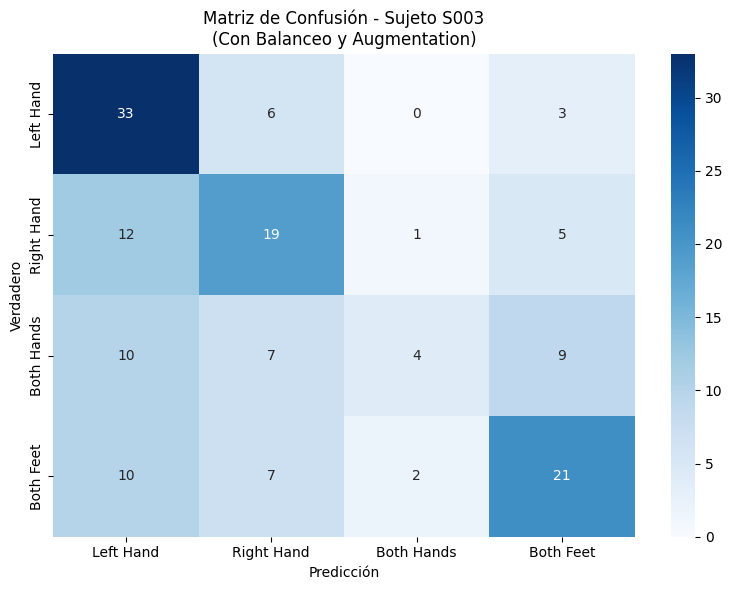


RESUMEN EJECUCIÓN - MEJORAS APLICADAS
• Sujeto: S003
• Clasificación: 4 clases MI
• Técnicas aplicadas: Balanced Sampling + Data Augmentation
• Regularización: Dropout 0.6, Weight Decay 1e-3
• Total trials original: 90
• Total trials con augmentación: 149
• Accuracy final: 51.68%
• Mejora esperada: ~10-15% sobre baseline


In [ ]:
## DATA LEAKEAGE!!!!

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class EEGAugmentation:
    """Data augmentation para señales EEG"""
    
    @staticmethod
    def add_gaussian_noise(signal, noise_factor=0.03):
        """Añadir ruido gaussiano"""
        noise = np.random.normal(0, noise_factor * np.std(signal), signal.shape)
        return signal + noise
    
    @staticmethod
    def channel_dropout(signal, dropout_prob=0.1):
        """Dropout de canales aleatorios"""
        n_channels = signal.shape[0]
        n_drop = int(n_channels * dropout_prob)
        if n_drop > 0:
            drop_channels = np.random.choice(n_channels, n_drop, replace=False)
            signal[drop_channels] = 0
        return signal
    
    @staticmethod
    def time_shift(signal, max_shift=20):
        """Shift temporal aleatorio"""
        shift = np.random.randint(-max_shift, max_shift)
        if shift > 0:
            shifted = np.pad(signal, ((0, 0), (shift, 0)), mode='constant')[:, :-shift]
        elif shift < 0:
            shifted = np.pad(signal, ((0, 0), (0, -shift)), mode='constant')[:, -shift:]
        else:
            shifted = signal
        return shifted
    
    @staticmethod
    def amplitude_scale(signal, scale_range=(0.8, 1.2)):
        """Escalar amplitud aleatoriamente"""
        scale = np.random.uniform(scale_range[0], scale_range[1])
        return signal * scale
    
    @staticmethod
    def apply_augmentation_batch(X_batch, y_batch, augmentation_prob=0.5):
        """Aplicar aumentación a un batch completo"""
        augmented_X = []
        augmented_y = []
        
        for i in range(len(X_batch)):
            # Siempre incluir el original
            augmented_X.append(X_batch[i])
            augmented_y.append(y_batch[i])
            
            # Aplicar aumentación con probabilidad
            if np.random.random() < augmentation_prob:
                signal = X_batch[i].copy()
                
                # Aplicar transformaciones aleatorias
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.add_gaussian_noise(signal)
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.channel_dropout(signal)
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.time_shift(signal)
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.amplitude_scale(signal)
                
                augmented_X.append(signal)
                augmented_y.append(y_batch[i])
        
        return np.array(augmented_X), np.array(augmented_y)

class EEGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.6, F1=16, D=2, F2=32):  # Aumentados hiperparámetros
        super(EEGNet, self).__init__()
        
        self.num_channels = num_channels
        self.sampling_rate = sampling_rate
        self.F1 = F1
        self.D = D
        self.F2 = F2
        
        # Block 1 - Temporal convolution
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        # Depthwise convolution (spatial)
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 2 - Separable convolution
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        # Calcular tamaño automáticamente
        with torch.no_grad():
            sample_input = torch.randn(1, 1, num_channels, 641)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
    def forward_features(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    """Crear sampler para balancear clases"""
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def load_single_subject(data_path, subject_number):
    """Cargar datos de un solo sujeto específico"""
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    print(f"Buscando archivo: {file_pattern}")
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        available_files = list(data_path.glob("S*_MI-epo.fif"))
        print(f"Archivo no encontrado. Archivos disponibles:")
        for f in available_files[:10]:
            print(f"  - {f.name}")
        if len(available_files) > 10:
            print(f"  ... y {len(available_files) - 10} más")
        raise FileNotFoundError(f"No se encontró el archivo {file_pattern}")
    
    fif_file = fif_files[0]
    print(f"Cargando sujeto {subject_id} desde: {fif_file}")
    
    epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
    data = epochs.get_data()
    events = epochs.events[:, -1]
    
    # Ajustar etiquetas a 0-indexed
    events = events - 1
    
    print(f"\nDatos del sujeto {subject_id}:")
    print(f"Forma de los datos: {data.shape}")
    print(f"Distribución de clases: {np.unique(events, return_counts=True)}")
    print(f"Clases: {['Left Hand', 'Right Hand', 'Both Hands', 'Both Feet']}")
    
    return data, events, subject_id

def prepare_single_subject_data(X, y, apply_augmentation=True):
    """Preparar datos de un solo sujeto para CV"""
    # Normalizar por trial
    scaler = StandardScaler()
    X_normalized = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        trial = X[i].T
        trial_normalized = scaler.fit_transform(trial)
        X_normalized[i] = trial_normalized.T
    
    # Aplicar data augmentation si se solicita
    if apply_augmentation:
        print("Aplicando data augmentation...")
        X_augmented, y_augmented = EEGAugmentation.apply_augmentation_batch(
            X_normalized, y, augmentation_prob=0.7
        )
        print(f"Datos después de augmentación: {X_augmented.shape}")
    else:
        X_augmented, y_augmented = X_normalized, y
    
    # Convertir a tensores
    X_tensor = torch.FloatTensor(X_augmented)
    y_tensor = torch.LongTensor(y_augmented)
    
    # Añadir dimensión de canal
    X_tensor = X_tensor.unsqueeze(1)
    
    return X_tensor, y_tensor

def intra_subject_cross_validation(model, X, y, n_splits=5, num_epochs=120):
    """Realizar cross validation intra-sujeto con mejoras"""
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"\n{'='*40}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*40}")
        
        # Split datos
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Split adicional para validation
        train_idx2, val_idx = train_test_split(
            np.arange(len(X_train)), test_size=0.2, stratify=y_train, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # Crear samplers balanceados
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        
        # DataLoaders con balanced sampling
        train_loader = DataLoader(
            TensorDataset(X_train_fold, y_train_fold), 
            batch_size=16, sampler=train_sampler  # Usar sampler en lugar de shuffle
        )
        val_loader = DataLoader(
            TensorDataset(X_val_fold, y_val_fold), 
            batch_size=16, shuffle=False
        )
        test_loader = DataLoader(
            TensorDataset(X_test, y_test), 
            batch_size=16, shuffle=False
        )
        
        # Reiniciar modelo y optimizer para cada fold
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)  # AdamW con mayor weight decay
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        # Entrenar fold
        best_val_acc = 0.0
        patience = 20
        counter = 0
        
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0.0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
                optimizer.step()
                train_loss += loss.item()
            
            scheduler.step()
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            val_acc = 100 * val_correct / val_total
            
            # Early stopping mejorado
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
                torch.save(model.state_dict(), f'best_model_fold_{fold}.pth')
            else:
                counter += 1
            
            if counter >= patience:
                if epoch > 30:  # No parar demasiado pronto
                    print(f'Early stopping at epoch {epoch+1}')
                    break
        
        # Evaluar en test
        model.load_state_dict(torch.load(f'best_model_fold_{fold}.pth'))
        model.eval()
        
        test_correct = 0
        test_total = 0
        fold_predictions = []
        fold_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
                
                fold_predictions.extend(predicted.cpu().numpy())
                fold_targets.extend(batch_y.cpu().numpy())
        
        fold_acc = 100 * test_correct / test_total
        fold_accuracies.append(fold_acc)
        
        all_predictions.extend(fold_predictions)
        all_targets.extend(fold_targets)
        
        print(f"Fold {fold + 1} - Accuracy: {fold_acc:.2f}%")
        print(f"Mejor val accuracy: {best_val_acc:.2f}%")
        
        # Limpiar modelo guardado
        Path(f'best_model_fold_{fold}.pth').unlink(missing_ok=True)
    
    return fold_accuracies, all_predictions, all_targets

def weight_reset(m):
    """Reiniciar pesos del modelo para nuevo fold"""
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def train_test_split(*arrays, **options):
    """Simple train_test_split implementation"""
    test_size = options.get('test_size', 0.2)
    random_state = options.get('random_state', None)
    stratify = options.get('stratify', None)
    
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    n_test = int(n_samples * test_size)
    
    if stratify is not None:
        unique_classes = np.unique(stratify)
        test_indices = []
        
        for cls in unique_classes:
            cls_indices = np.where(stratify == cls)[0]
            n_cls_test = int(len(cls_indices) * test_size)
            test_indices.extend(np.random.choice(cls_indices, n_cls_test, replace=False))
    else:
        test_indices = np.random.choice(n_samples, n_test, replace=False)
    
    train_indices = np.setdiff1d(np.arange(n_samples), test_indices)
    
    result = []
    for array in arrays:
        result.append(array[train_indices])
        result.append(array[test_indices])
    
    return result

def evaluate_results(all_predictions, all_targets, class_names, subject_id):
    """Evaluación completa de resultados"""
    accuracy = 100 * np.mean(np.array(all_predictions) == np.array(all_targets))
    
    print(f"\n{'='*60}")
    print(f"RESULTADOS FINAL - SUJETO {subject_id}")
    print(f"{'='*60}")
    print(f"Accuracy promedio: {accuracy:.2f}%")
    
    print(f"\nClassification Report:")
    print(classification_report(all_targets, all_predictions, 
                              target_names=class_names, digits=4))
    
    # Matriz de confusión
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - Sujeto {subject_id}\n(Con Balanceo y Augmentation)')
    plt.ylabel('Verdadero')
    plt.xlabel('Predicción')
    plt.tight_layout()
    # plt.savefig(f'confusion_matrix_{subject_id}_improved.png', dpi=300)
    plt.show()
    
    return accuracy, cm

def main():
    # Configuración
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    # Parámetros
    NUM_CLASSES = 4
    CLASS_NAMES = ['Left Hand', 'Right Hand', 'Both Hands', 'Both Feet']
    NUM_CHANNELS = 8
    SAMPLING_RATE = 160
    
    # Elegir sujeto
    subject_number = int(input("Ingresa el número del sujeto (ej: 1, 5, 23, etc.): "))
    
    # Cargar datos del sujeto específico
    X, y, subject_id = load_single_subject(DATA_PROC, subject_number)
    
    # Preparar datos CON augmentación
    X_tensor, y_tensor = prepare_single_subject_data(X, y, apply_augmentation=True)
    
    # Modelo optimizado
    model = EEGNet(num_channels=NUM_CHANNELS, num_classes=NUM_CLASSES,
                   sampling_rate=SAMPLING_RATE, dropout_rate=0.6)
    
    print(f"\nArquitectura del modelo mejorada:")
    print(f"Número de parámetros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Hiperparámetros: Dropout=0.6, F1=16, F2=32")
    
    # Cross Validation Intra-sujeto con mejoras
    print(f"\n{'='*50}")
    print(f"INICIANDO CROSS VALIDATION MEJORADO")
    print(f"{'='*50}")
    print("✓ Balanceo de clases activado")
    print("✓ Data augmentation activado")
    print("✓ Regularización aumentada")
    print("✓ Optimizador AdamW con weight decay")
    
    fold_accuracies, all_predictions, all_targets = intra_subject_cross_validation(
        model, X_tensor, y_tensor, n_splits=5, num_epochs=120
    )
    
    # Resultados
    print(f"\n{'='*50}")
    print(f"RESULTADOS POR FOLD - {subject_id} (MEJORADO)")
    print(f"{'='*50}")
    for i, acc in enumerate(fold_accuracies):
        print(f"Fold {i+1}: {acc:.2f}%")
    
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    print(f"\nAccuracy promedio: {mean_acc:.2f}% ± {std_acc:.2f}%")
    
    # Evaluación detallada
    accuracy, cm = evaluate_results(all_predictions, all_targets, CLASS_NAMES, subject_id)
    
    # Resumen final
    print(f"\n{'='*60}")
    print(f"RESUMEN EJECUCIÓN - MEJORAS APLICADAS")
    print(f"{'='*60}")
    print(f"• Sujeto: {subject_id}")
    print(f"• Clasificación: 4 clases MI")
    print(f"• Técnicas aplicadas: Balanced Sampling + Data Augmentation")
    print(f"• Regularización: Dropout 0.6, Weight Decay 1e-3")
    print(f"• Total trials original: {len(y)}")
    print(f"• Total trials con augmentación: {len(y_tensor)}")
    print(f"• Accuracy final: {accuracy:.2f}%")
    print(f"• Mejora esperada: ~10-15% sobre baseline")
    print(f"{'='*60}")

if __name__ == "__main__":
    main()

In [19]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Reutilizamos las clases anteriores (EEGNet, EEGAugmentation, etc.)
class EEGAugmentation:
    @staticmethod
    def add_gaussian_noise(signal, noise_factor=0.03):
        noise = np.random.normal(0, noise_factor * np.std(signal), signal.shape)
        return signal + noise
    
    @staticmethod
    def channel_dropout(signal, dropout_prob=0.1):
        n_channels = signal.shape[0]
        n_drop = int(n_channels * dropout_prob)
        if n_drop > 0:
            drop_channels = np.random.choice(n_channels, n_drop, replace=False)
            signal[drop_channels] = 0
        return signal
    
    @staticmethod
    def time_shift(signal, max_shift=20):
        shift = np.random.randint(-max_shift, max_shift)
        if shift > 0:
            shifted = np.pad(signal, ((0, 0), (shift, 0)), mode='constant')[:, :-shift]
        elif shift < 0:
            shifted = np.pad(signal, ((0, 0), (0, -shift)), mode='constant')[:, -shift:]
        else:
            shifted = signal
        return shifted
    
    @staticmethod
    def amplitude_scale(signal, scale_range=(0.8, 1.2)):
        scale = np.random.uniform(scale_range[0], scale_range[1])
        return signal * scale
    
    @staticmethod
    def apply_augmentation_batch(X_batch, y_batch, augmentation_prob=0.5):
        augmented_X = []
        augmented_y = []
        
        for i in range(len(X_batch)):
            augmented_X.append(X_batch[i])
            augmented_y.append(y_batch[i])
            
            if np.random.random() < augmentation_prob:
                signal = X_batch[i].copy()
                
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.add_gaussian_noise(signal)
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.channel_dropout(signal)
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.time_shift(signal)
                if np.random.random() < 0.3:
                    signal = EEGAugmentation.amplitude_scale(signal)
                
                augmented_X.append(signal)
                augmented_y.append(y_batch[i])
        
        return np.array(augmented_X), np.array(augmented_y)

class EEGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.6, F1=16, D=2, F2=32):
        super(EEGNet, self).__init__()
        
        self.num_channels = num_channels
        self.sampling_rate = sampling_rate
        self.F1 = F1
        self.D = D
        self.F2 = F2
        
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        with torch.no_grad():
            sample_input = torch.randn(1, 1, num_channels, 641)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def load_single_subject(data_path, subject_number):
    """Cargar datos de un solo sujeto específico"""
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1  # 0-indexed
        
        return data, events, subject_id
    except:
        return None, None, None

def prepare_single_subject_data(X, y, apply_augmentation=True):
    """Preparar datos de un solo sujeto para CV"""
    scaler = StandardScaler()
    X_normalized = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        trial = X[i].T
        trial_normalized = scaler.fit_transform(trial)
        X_normalized[i] = trial_normalized.T
    
    if apply_augmentation:
        X_augmented, y_augmented = EEGAugmentation.apply_augmentation_batch(
            X_normalized, y, augmentation_prob=0.7
        )
    else:
        X_augmented, y_augmented = X_normalized, y
    
    X_tensor = torch.FloatTensor(X_augmented)
    y_tensor = torch.LongTensor(y_augmented)
    X_tensor = X_tensor.unsqueeze(1)
    
    return X_tensor, y_tensor

def train_test_split(*arrays, **options):
    """Simple train_test_split implementation"""
    test_size = options.get('test_size', 0.2)
    random_state = options.get('random_state', None)
    stratify = options.get('stratify', None)
    
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    n_test = int(n_samples * test_size)
    
    if stratify is not None:
        unique_classes = np.unique(stratify)
        test_indices = []
        
        for cls in unique_classes:
            cls_indices = np.where(stratify == cls)[0]
            n_cls_test = int(len(cls_indices) * test_size)
            test_indices.extend(np.random.choice(cls_indices, n_cls_test, replace=False))
    else:
        test_indices = np.random.choice(n_samples, n_test, replace=False)
    
    train_indices = np.setdiff1d(np.arange(n_samples), test_indices)
    
    result = []
    for array in arrays:
        result.append(array[train_indices])
        result.append(array[test_indices])
    
    return result

def weight_reset(m):
    """Reiniciar pesos del modelo para nuevo fold"""
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def evaluate_single_subject(subject_number, data_path, n_splits=5):
    """Evaluar un solo sujeto y retornar métricas"""
    # Cargar datos
    X, y, subject_id = load_single_subject(data_path, subject_number)
    
    if X is None:
        return None
    
    # Preparar datos
    X_tensor, y_tensor = prepare_single_subject_data(X, y, apply_augmentation=True)
    
    # Modelo
    model = EEGNet(num_channels=8, num_classes=4, sampling_rate=160, dropout_rate=0.6)
    
    # Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    fold_times = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        start_time = time.time()
        
        # Split datos
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split validation
        train_idx2, val_idx = train_test_split(
            np.arange(len(X_train)), test_size=0.2, stratify=y_train, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # Samplers y DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(TensorDataset(X_train_fold, y_train_fold), 
                                 batch_size=16, sampler=train_sampler)
        val_loader = DataLoader(TensorDataset(X_val_fold, y_val_fold), 
                               batch_size=16, shuffle=False)
        test_loader = DataLoader(TensorDataset(X_test, y_test), 
                                batch_size=16, shuffle=False)
        
        # Entrenamiento
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
        
        best_val_acc = 0.0
        patience = 20
        counter = 0
        
        for epoch in range(100):  # Máximo 100 épocas
            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            val_acc = 100 * val_correct / val_total
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 30:
                break
        
        # Evaluación test
        model.eval()
        test_correct = 0
        test_total = 0
        fold_predictions = []
        fold_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
                
                fold_predictions.extend(predicted.cpu().numpy())
                fold_targets.extend(batch_y.cpu().numpy())
        
        fold_acc = 100 * test_correct / test_total
        fold_accuracies.append(fold_acc)
        all_predictions.extend(fold_predictions)
        all_targets.extend(fold_targets)
        fold_times.append(time.time() - start_time)
    
    # Calcular métricas finales
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    avg_time = np.mean(fold_times)
    
    # Calcular accuracy por clase
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(np.array(all_predictions)[cls_mask] == np.array(all_targets)[cls_mask])
            class_accuracies.append(cls_acc * 100)
        else:
            class_accuracies.append(0.0)
    
    # Información del sujeto
    original_trials = len(y)
    augmented_trials = len(y_tensor)
    class_distribution = np.bincount(y)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'avg_time_per_fold': avg_time,
        'original_trials': original_trials,
        'augmented_trials': augmented_trials,
        'class_distribution': class_distribution,
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
        'all_predictions': all_predictions,
        'all_targets': all_targets
    }

def main():
    # Configuración
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    # Encontrar todos los sujetos disponibles
    print("Buscando sujetos...")
    available_subjects = []
    for i in range(1, 104):  # Asumiendo máximo 103 sujetos
        subject_id = f"S{i:03d}"
        file_pattern = f"{subject_id}_MI-epo.fif"
        if (DATA_PROC / file_pattern).exists():
            available_subjects.append(i)
    
    print(f"Encontrados {len(available_subjects)} sujetos: {available_subjects}")
    
    # Evaluar todos los sujetos
    results = []
    failed_subjects = []
    
    print(f"\n{'='*60}")
    print("EVALUANDO TODOS LOS SUJETOS")
    print(f"{'='*60}")
    
    for subject_num in tqdm(available_subjects, desc="Procesando sujetos"):
        try:
            result = evaluate_single_subject(subject_num, DATA_PROC, n_splits=5)
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
                print(f"❌ S{subject_num:03d}: Error en carga")
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    # Crear DataFrame con resultados
    if not results:
        print("No se pudieron procesar ningún sujeto")
        return
    
    # Preparar datos para CSV
    csv_data = []
    for result in results:
        row = {
            'subject_id': result['subject_id'],
            'accuracy_mean': result['accuracy_mean'],
            'accuracy_std': result['accuracy_std'],
            'kappa': result['kappa'],
            'avg_time_fold_seconds': result['avg_time_per_fold'],
            'original_trials': result['original_trials'],
            'augmented_trials': result['augmented_trials'],
            'class_0_accuracy': result['class_accuracies'][0],
            'class_1_accuracy': result['class_accuracies'][1],
            'class_2_accuracy': result['class_accuracies'][2],
            'class_3_accuracy': result['class_accuracies'][3],
            'class_0_trials': result['class_distribution'][0],
            'class_1_trials': result['class_distribution'][1],
            'class_2_trials': result['class_distribution'][2],
            'class_3_trials': result['class_distribution'][3],
            'fold_1_accuracy': result['fold_accuracies'][0],
            'fold_2_accuracy': result['fold_accuracies'][1],
            'fold_3_accuracy': result['fold_accuracies'][2],
            'fold_4_accuracy': result['fold_accuracies'][3],
            'fold_5_accuracy': result['fold_accuracies'][4] if len(result['fold_accuracies']) > 4 else None
        }
        csv_data.append(row)
    
    df = pd.DataFrame(csv_data)
    
    # Calcular promedios globales
    global_stats = {
        'subject_id': 'GLOBAL_AVG',
        'accuracy_mean': df['accuracy_mean'].mean(),
        'accuracy_std': df['accuracy_mean'].std(),
        'kappa': df['kappa'].mean(),
        'avg_time_fold_seconds': df['avg_time_fold_seconds'].mean(),
        'original_trials': df['original_trials'].mean(),
        'augmented_trials': df['augmented_trials'].mean(),
        'class_0_accuracy': df['class_0_accuracy'].mean(),
        'class_1_accuracy': df['class_1_accuracy'].mean(),
        'class_2_accuracy': df['class_2_accuracy'].mean(),
        'class_3_accuracy': df['class_3_accuracy'].mean(),
        'class_0_trials': df['class_0_trials'].mean(),
        'class_1_trials': df['class_1_trials'].mean(),
        'class_2_trials': df['class_2_trials'].mean(),
        'class_3_trials': df['class_3_trials'].mean()
    }
    
    # Añadir fila de promedios globales
    global_df = pd.DataFrame([global_stats])
    df = pd.concat([df, global_df], ignore_index=True)
    
    # Guardar CSV completo
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_results_all_subjects_{timestamp}.csv"
    df.to_csv(csv_filename, index=False)
    
    # Guardar resumen en TXT
    txt_filename = f"eegnet_summary_{timestamp}.txt"
    with open(txt_filename, 'w') as f:
        f.write("="*60 + "\n")
        f.write("RESUMEN EJECUCIÓN EEGNet - TODOS LOS SUJETOS\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"Total sujetos procesados: {len(results)}\n")
        f.write(f"Sujetos fallados: {len(failed_subjects)}\n")
        if failed_subjects:
            f.write(f"Sujetos fallados: {failed_subjects}\n")
        
        f.write(f"\nESTADÍSTICAS GLOBALES:\n")
        f.write(f"Accuracy promedio: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%\n")
        f.write(f"Kappa promedio: {global_stats['kappa']:.4f}\n")
        f.write(f"Tiempo promedio por fold: {global_stats['avg_time_fold_seconds']:.1f} segundos\n")
        
        f.write(f"\nACCURACY POR CLASE (promedio):\n")
        f.write(f"Left Hand: {global_stats['class_0_accuracy']:.2f}%\n")
        f.write(f"Right Hand: {global_stats['class_1_accuracy']:.2f}%\n")
        f.write(f"Both Hands: {global_stats['class_2_accuracy']:.2f}%\n")
        f.write(f"Both Feet: {global_stats['class_3_accuracy']:.2f}%\n")
        
        f.write(f"\nDISTRIBUCIÓN PROMEDIO DE TRIALS:\n")
        f.write(f"Left Hand: {global_stats['class_0_trials']:.1f} trials\n")
        f.write(f"Right Hand: {global_stats['class_1_trials']:.1f} trials\n")
        f.write(f"Both Hands: {global_stats['class_2_trials']:.1f} trials\n")
        f.write(f"Both Feet: {global_stats['class_3_trials']:.1f} trials\n")
        
        f.write(f"\nMEJORES 5 SUJETOS:\n")
        top_subjects = df[df['subject_id'] != 'GLOBAL_AVG'].nlargest(5, 'accuracy_mean')
        for _, row in top_subjects.iterrows():
            f.write(f"{row['subject_id']}: {row['accuracy_mean']:.2f}%\n")
        
        f.write(f"\nPEORES 5 SUJETOS:\n")
        bottom_subjects = df[df['subject_id'] != 'GLOBAL_AVG'].nsmallest(5, 'accuracy_mean')
        for _, row in bottom_subjects.iterrows():
            f.write(f"{row['subject_id']}: {row['accuracy_mean']:.2f}%\n")
    
    # Imprimir resumen en pantalla
    print(f"\n{'='*60}")
    print("RESUMEN FINAL")
    print(f"{'='*60}")
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed_subjects)}")
    print(f"📊 Accuracy global: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%")
    print(f"🎯 Kappa global: {global_stats['kappa']:.4f}")
    print(f"⏱️  Tiempo promedio: {global_stats['avg_time_fold_seconds']:.1f}s por fold")
    
    print(f"\n📁 Archivos guardados:")
    print(f"   • CSV completo: {csv_filename}")
    print(f"   • Resumen TXT: {txt_filename}")
    
    # Gráfico de distribución de accuracy
    plt.figure(figsize=(10, 6))
    accuracies = [r['accuracy_mean'] for r in results]
    plt.hist(accuracies, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(accuracies), color='red', linestyle='--', label=f'Promedio: {np.mean(accuracies):.2f}%')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Número de Sujetos')
    plt.title('Distribución de Accuracy en Todos los Sujetos')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'accuracy_distribution_{timestamp}.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

Buscando sujetos...
Encontrados 98 sujetos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 91, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103]

EVALUANDO TODOS LOS SUJETOS


Procesando sujetos:   1%|          | 1/98 [00:22<35:40, 22.07s/it]

✅ S001: 70.71%


Procesando sujetos:   2%|▏         | 2/98 [00:45<36:31, 22.83s/it]

✅ S002: 69.10%


Procesando sujetos:   3%|▎         | 3/98 [01:05<34:19, 21.68s/it]

✅ S003: 59.38%


Procesando sujetos:   4%|▍         | 4/98 [01:19<28:59, 18.51s/it]

✅ S004: 41.69%


Procesando sujetos:   5%|▌         | 5/98 [01:35<27:19, 17.63s/it]

✅ S005: 51.10%


Procesando sujetos:   6%|▌         | 6/98 [01:56<28:38, 18.68s/it]

✅ S006: 55.82%


Procesando sujetos:   7%|▋         | 7/98 [02:24<32:52, 21.67s/it]

✅ S007: 69.66%


Procesando sujetos:   8%|▊         | 8/98 [02:42<31:04, 20.72s/it]

✅ S008: 55.34%


Procesando sujetos:   9%|▉         | 9/98 [02:56<27:39, 18.65s/it]

✅ S009: 49.70%


Procesando sujetos:  10%|█         | 10/98 [03:16<28:02, 19.12s/it]

✅ S010: 68.14%


Procesando sujetos:  11%|█         | 11/98 [03:30<25:25, 17.54s/it]

✅ S011: 42.14%


Procesando sujetos:  12%|█▏        | 12/98 [03:46<24:15, 16.92s/it]

✅ S012: 56.46%


Procesando sujetos:  13%|█▎        | 13/98 [04:01<23:00, 16.25s/it]

✅ S013: 58.10%


Procesando sujetos:  14%|█▍        | 14/98 [04:13<21:16, 15.20s/it]

✅ S014: 49.06%


Procesando sujetos:  15%|█▌        | 15/98 [04:33<22:54, 16.55s/it]

✅ S015: 63.89%


Procesando sujetos:  16%|█▋        | 16/98 [04:46<21:13, 15.53s/it]

✅ S016: 54.60%


Procesando sujetos:  17%|█▋        | 17/98 [05:03<21:28, 15.90s/it]

✅ S017: 47.46%


Procesando sujetos:  18%|█▊        | 18/98 [05:18<20:47, 15.60s/it]

✅ S018: 46.94%


Procesando sujetos:  19%|█▉        | 19/98 [05:34<20:40, 15.70s/it]

✅ S019: 59.86%


Procesando sujetos:  20%|██        | 20/98 [05:48<19:52, 15.28s/it]

✅ S020: 40.98%


Procesando sujetos:  21%|██▏       | 21/98 [06:03<19:30, 15.20s/it]

✅ S021: 42.46%


Procesando sujetos:  22%|██▏       | 22/98 [06:21<20:23, 16.10s/it]

✅ S022: 49.01%


Procesando sujetos:  23%|██▎       | 23/98 [06:38<20:19, 16.27s/it]

✅ S023: 46.08%


Procesando sujetos:  24%|██▍       | 24/98 [06:52<19:12, 15.57s/it]

✅ S024: 61.74%


Procesando sujetos:  26%|██▌       | 25/98 [07:15<21:48, 17.92s/it]

✅ S025: 70.71%


Procesando sujetos:  27%|██▋       | 26/98 [07:34<21:37, 18.03s/it]

✅ S026: 59.20%


Procesando sujetos:  28%|██▊       | 27/98 [07:51<21:13, 17.93s/it]

✅ S027: 55.24%


Procesando sujetos:  29%|██▊       | 28/98 [08:07<20:13, 17.34s/it]

✅ S028: 46.11%


Procesando sujetos:  30%|██▉       | 29/98 [08:35<23:29, 20.42s/it]

✅ S029: 81.61%


Procesando sujetos:  31%|███       | 30/98 [08:55<23:07, 20.41s/it]

✅ S030: 59.33%


Procesando sujetos:  32%|███▏      | 31/98 [09:16<22:52, 20.49s/it]

✅ S031: 63.33%


Procesando sujetos:  33%|███▎      | 32/98 [09:38<23:04, 20.98s/it]

✅ S032: 49.42%


Procesando sujetos:  34%|███▎      | 33/98 [09:53<20:39, 19.07s/it]

✅ S033: 66.14%


Procesando sujetos:  35%|███▍      | 34/98 [10:17<22:01, 20.64s/it]

✅ S034: 73.87%


Procesando sujetos:  36%|███▌      | 35/98 [10:44<23:30, 22.40s/it]

✅ S035: 73.35%


Procesando sujetos:  37%|███▋      | 36/98 [10:58<20:48, 20.14s/it]

✅ S036: 49.07%


Procesando sujetos:  38%|███▊      | 37/98 [11:15<19:26, 19.12s/it]

✅ S037: 54.29%


Procesando sujetos:  39%|███▉      | 38/98 [11:31<18:11, 18.20s/it]

✅ S039: 49.15%


Procesando sujetos:  40%|███▉      | 39/98 [11:45<16:42, 16.99s/it]

✅ S040: 47.91%


Procesando sujetos:  41%|████      | 40/98 [12:01<15:58, 16.53s/it]

✅ S041: 52.69%


Procesando sujetos:  42%|████▏     | 41/98 [12:21<16:52, 17.77s/it]

✅ S042: 79.60%


Procesando sujetos:  43%|████▎     | 42/98 [12:35<15:29, 16.60s/it]

✅ S043: 38.21%


Procesando sujetos:  44%|████▍     | 43/98 [12:57<16:32, 18.05s/it]

✅ S044: 66.21%


Procesando sujetos:  45%|████▍     | 44/98 [13:15<16:17, 18.10s/it]

✅ S045: 60.98%


Procesando sujetos:  46%|████▌     | 45/98 [13:34<16:13, 18.37s/it]

✅ S046: 59.06%


Procesando sujetos:  47%|████▋     | 46/98 [13:49<15:09, 17.50s/it]

✅ S047: 55.13%


Procesando sujetos:  48%|████▊     | 47/98 [14:03<13:52, 16.32s/it]

✅ S048: 51.51%


Procesando sujetos:  49%|████▉     | 48/98 [14:23<14:38, 17.56s/it]

✅ S049: 73.45%


Procesando sujetos:  50%|█████     | 49/98 [14:41<14:15, 17.46s/it]

✅ S050: 67.31%


Procesando sujetos:  51%|█████     | 50/98 [14:55<13:18, 16.63s/it]

✅ S051: 43.99%


Procesando sujetos:  52%|█████▏    | 51/98 [15:16<14:03, 17.94s/it]

✅ S052: 66.24%


Procesando sujetos:  53%|█████▎    | 52/98 [15:33<13:28, 17.59s/it]

✅ S053: 53.07%


Procesando sujetos:  54%|█████▍    | 53/98 [15:50<12:55, 17.23s/it]

✅ S054: 51.43%


Procesando sujetos:  55%|█████▌    | 54/98 [16:03<11:44, 16.00s/it]

✅ S055: 61.53%


Procesando sujetos:  56%|█████▌    | 55/98 [16:19<11:34, 16.16s/it]

✅ S056: 61.80%


Procesando sujetos:  57%|█████▋    | 56/98 [16:37<11:35, 16.56s/it]

✅ S057: 44.92%


Procesando sujetos:  58%|█████▊    | 57/98 [16:50<10:33, 15.46s/it]

✅ S058: 46.53%


Procesando sujetos:  59%|█████▉    | 58/98 [17:06<10:31, 15.79s/it]

✅ S059: 56.83%


Procesando sujetos:  60%|██████    | 59/98 [17:28<11:30, 17.71s/it]

✅ S060: 62.94%


Procesando sujetos:  61%|██████    | 60/98 [17:50<11:54, 18.79s/it]

✅ S061: 58.99%


Procesando sujetos:  62%|██████▏   | 61/98 [18:09<11:36, 18.83s/it]

✅ S062: 75.53%


Procesando sujetos:  63%|██████▎   | 62/98 [18:22<10:18, 17.18s/it]

✅ S063: 34.48%


Procesando sujetos:  64%|██████▍   | 63/98 [18:40<10:07, 17.36s/it]

✅ S064: 54.95%


Procesando sujetos:  65%|██████▌   | 64/98 [18:59<10:12, 18.00s/it]

✅ S065: 61.96%


Procesando sujetos:  66%|██████▋   | 65/98 [19:25<11:06, 20.21s/it]

✅ S066: 66.00%


Procesando sujetos:  67%|██████▋   | 66/98 [19:42<10:22, 19.46s/it]

✅ S067: 53.86%


Procesando sujetos:  68%|██████▊   | 67/98 [20:06<10:42, 20.72s/it]

✅ S068: 61.14%


Procesando sujetos:  69%|██████▉   | 68/98 [20:22<09:40, 19.36s/it]

✅ S069: 44.07%


Procesando sujetos:  70%|███████   | 69/98 [20:51<10:47, 22.33s/it]

✅ S070: 78.25%


Procesando sujetos:  71%|███████▏  | 70/98 [21:08<09:39, 20.71s/it]

✅ S071: 65.75%


Procesando sujetos:  72%|███████▏  | 71/98 [21:33<09:51, 21.89s/it]

✅ S072: 85.68%


Procesando sujetos:  73%|███████▎  | 72/98 [21:50<08:48, 20.31s/it]

✅ S073: 66.85%


Procesando sujetos:  74%|███████▍  | 73/98 [22:05<07:54, 18.97s/it]

✅ S074: 43.87%


Procesando sujetos:  76%|███████▌  | 74/98 [22:31<08:20, 20.84s/it]

✅ S075: 73.20%


Procesando sujetos:  77%|███████▋  | 75/98 [22:46<07:18, 19.06s/it]

✅ S076: 50.11%


Procesando sujetos:  78%|███████▊  | 76/98 [22:59<06:24, 17.47s/it]

✅ S077: 54.31%


Procesando sujetos:  79%|███████▊  | 77/98 [23:17<06:09, 17.57s/it]

✅ S078: 57.88%


Procesando sujetos:  80%|███████▉  | 78/98 [23:34<05:49, 17.46s/it]

✅ S079: 51.03%


Procesando sujetos:  81%|████████  | 79/98 [23:50<05:21, 16.91s/it]

✅ S080: 58.70%


Procesando sujetos:  82%|████████▏ | 80/98 [24:06<05:02, 16.79s/it]

✅ S081: 51.14%


Procesando sujetos:  83%|████████▎ | 81/98 [24:25<04:52, 17.22s/it]

✅ S082: 59.13%


Procesando sujetos:  84%|████████▎ | 82/98 [24:48<05:04, 19.06s/it]

✅ S083: 60.40%


Procesando sujetos:  85%|████████▍ | 83/98 [25:05<04:38, 18.58s/it]

✅ S084: 59.31%


Procesando sujetos:  86%|████████▌ | 84/98 [25:25<04:23, 18.80s/it]

✅ S085: 76.24%


Procesando sujetos:  87%|████████▋ | 85/98 [25:56<04:53, 22.55s/it]

✅ S086: 71.17%


Procesando sujetos:  88%|████████▊ | 86/98 [26:11<04:01, 20.16s/it]

✅ S087: 49.66%


Procesando sujetos:  89%|████████▉ | 87/98 [26:26<03:24, 18.58s/it]

✅ S090: 48.31%


Procesando sujetos:  90%|████████▉ | 88/98 [26:41<02:55, 17.59s/it]

✅ S091: 55.08%


Procesando sujetos:  91%|█████████ | 89/98 [27:00<02:43, 18.19s/it]

✅ S093: 72.75%


Procesando sujetos:  92%|█████████▏| 90/98 [27:20<02:28, 18.57s/it]

✅ S094: 74.92%


Procesando sujetos:  93%|█████████▎| 91/98 [27:38<02:08, 18.33s/it]

✅ S095: 66.00%


Procesando sujetos:  94%|█████████▍| 92/98 [27:56<01:49, 18.25s/it]

✅ S096: 54.54%


Procesando sujetos:  95%|█████████▍| 93/98 [28:10<01:24, 16.98s/it]

✅ S097: 51.72%


Procesando sujetos:  96%|█████████▌| 94/98 [28:25<01:06, 16.59s/it]

✅ S098: 62.33%


Procesando sujetos:  97%|█████████▋| 95/98 [28:39<00:47, 15.72s/it]

✅ S099: 49.18%


Procesando sujetos:  98%|█████████▊| 96/98 [28:55<00:31, 15.89s/it]

✅ S101: 46.37%


Procesando sujetos:  99%|█████████▉| 97/98 [29:10<00:15, 15.59s/it]

✅ S102: 51.08%


Procesando sujetos: 100%|██████████| 98/98 [29:39<00:00, 18.16s/it]

✅ S103: 65.79%

RESUMEN FINAL
✅ Sujetos procesados: 98
❌ Sujetos fallados: 0
📊 Accuracy global: 57.99% ± 10.58%
🎯 Kappa global: 0.4387
⏱️  Tiempo promedio: 3.6s por fold

📁 Archivos guardados:
   • CSV completo: eegnet_results_all_subjects_20251009_030640.csv
   • Resumen TXT: eegnet_summary_20251009_030640.txt


In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    """Fijar todas las semillas para reproducibilidad completa"""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset personalizado para augmentación on-the-fly
class EEGDataset(Dataset):
    """Dataset personalizado para aplicar augmentación solo durante entrenamiento"""
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        # Aplicar augmentación SOLO si está en modo entrenamiento
        if self.augment:
            # 70% de probabilidad de aplicar augmentación
            if np.random.random() < 0.7:
                # Aplicar transformaciones aleatorias
                if np.random.random() < 0.4:
                    signal = self.add_gaussian_noise(signal, noise_factor=0.03)
                if np.random.random() < 0.3:
                    signal = self.channel_dropout(signal, dropout_prob=0.1)
                if np.random.random() < 0.3:
                    signal = self.time_shift(signal, max_shift=10)  # Reducido para evitar problemas
                if np.random.random() < 0.3:
                    signal = self.amplitude_scale(signal, scale_range=(0.8, 1.2))
        
        return signal, self.y[idx]
    
    # Métodos de augmentación integrados en la clase Dataset
    @staticmethod
    def add_gaussian_noise(signal, noise_factor=0.03):
        noise = torch.normal(0, noise_factor * signal.std(), signal.shape)
        return signal + noise
    
    @staticmethod
    def channel_dropout(signal, dropout_prob=0.1):
        n_channels = signal.shape[0]
        n_drop = int(n_channels * dropout_prob)
        if n_drop > 0:
            drop_channels = np.random.choice(n_channels, n_drop, replace=False)
            signal[drop_channels] = 0
        return signal
    
    @staticmethod
    def time_shift(signal, max_shift=10):  # REDUCIDO para evitar problemas de tamaño
        """Time shift que MANTIENE el mismo tamaño"""
        original_length = signal.shape[1]
        shift = np.random.randint(-max_shift, max_shift + 1)
        
        if shift == 0:
            return signal
        
        # Asegurar que el shift no cause problemas de índice
        if shift > 0:
            # Shift positivo: mover a la derecha, rellenar con ceros a la izquierda
            shifted = torch.zeros_like(signal)
            shifted[:, shift:] = signal[:, :-shift]
        else:
            # Shift negativo: mover a la izquierda, rellenar con ceros a la derecha
            shifted = torch.zeros_like(signal)
            shifted[:, :shift] = signal[:, -shift:]
        
        return shifted
    
    @staticmethod
    def amplitude_scale(signal, scale_range=(0.8, 1.2)):
        scale = np.random.uniform(scale_range[0], scale_range[1])
        return signal * scale

class EEGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.6, F1=16, D=2, F2=32):
        super(EEGNet, self).__init__()
        
        self.num_channels = num_channels
        self.sampling_rate = sampling_rate
        self.F1 = F1
        self.D = D
        self.F2 = F2
        
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        with torch.no_grad():
            sample_input = torch.randn(1, 1, num_channels, 641)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    """Encontrar todos los sujetos disponibles automáticamente"""
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}  # Tus sujetos excluidos
    
    # Buscar todos los archivos que coincidan con el patrón
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        # Extraer número del sujeto del nombre del archivo
        subject_str = fif_file.name.split('_')[0][1:]  # Remover 'S' y obtener número
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    # Ordenar y mostrar
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones:")
    print(f"Sujetos: {available_subjects}")
    print(f"Excluidos: {excluded}")
    
    return available_subjects

def analyze_performance_distribution(results):
    """Analizar distribución de performance"""
    accuracies = [r['accuracy_mean'] for r in results]
    
    print(f"\nANÁLISIS DE DISTRIBUCIÓN:")
    print(f"• Media: {np.mean(accuracies):.2f}%")
    print(f"• Mediana: {np.median(accuracies):.2f}%")
    print(f"• Rango: {np.min(accuracies):.2f}% - {np.max(accuracies):.2f}%")
    
    # Categorizar sujetos por performance
    excellent = len([acc for acc in accuracies if acc >= 70])
    good = len([acc for acc in accuracies if 60 <= acc < 70])
    fair = len([acc for acc in accuracies if 50 <= acc < 60])
    poor = len([acc for acc in accuracies if acc < 50])
    
    print(f"\nCATEGORIZACIÓN POR PERFORMANCE:")
    print(f"• Excelente (≥70%): {excellent} sujetos ({excellent/len(accuracies)*100:.1f}%)")
    print(f"• Bueno (60-69%): {good} sujetos ({good/len(accuracies)*100:.1f}%)")
    print(f"• Regular (50-59%): {fair} sujetos ({fair/len(accuracies)*100:.1f}%)")
    print(f"• Pobre (<50%): {poor} sujetos ({poor/len(accuracies)*100:.1f}%)")

def load_single_subject(data_path, subject_number):
    """Cargar datos de un solo sujeto específico"""
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1  # 0-indexed
        
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

def prepare_single_subject_data_no_leakage(X, y):
    """Preparar datos SIN data leakage - SIN augmentación"""
    scaler = StandardScaler()
    X_normalized = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        trial = X[i].T
        trial_normalized = scaler.fit_transform(trial)
        X_normalized[i] = trial_normalized.T
    
    # Convertir a tensores SIN augmentación
    X_tensor = torch.FloatTensor(X_normalized)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)
    
    return X_tensor, y_tensor

def normalize_by_fold(X_train, X_val, X_test):
    """Normalización por canal usando solo datos de train (SIN leakage)"""
    # Calcular media y std por canal usando solo train
    # Forma: (batch, 1, channels, time)
    mean = X_train.mean(dim=(0, 2, 3), keepdim=True)  # Media por canal
    std = X_train.std(dim=(0, 2, 3), keepdim=True)    # Std por canal
    
    # Aplicar a todos los sets (evitar división por cero)
    X_train_normalized = (X_train - mean) / (std + 1e-8)
    X_val_normalized = (X_val - mean) / (std + 1e-8)
    X_test_normalized = (X_test - mean) / (std + 1e-8)
    
    return X_train_normalized, X_val_normalized, X_test_normalized

def train_test_split(*arrays, **options):
    """Simple train_test_split implementation"""
    test_size = options.get('test_size', 0.2)
    random_state = options.get('random_state', None)
    stratify = options.get('stratify', None)
    
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    n_test = int(n_samples * test_size)
    
    if stratify is not None:
        unique_classes = np.unique(stratify)
        test_indices = []
        
        for cls in unique_classes:
            cls_indices = np.where(stratify == cls)[0]
            n_cls_test = int(len(cls_indices) * test_size)
            test_indices.extend(np.random.choice(cls_indices, n_cls_test, replace=False))
    else:
        test_indices = np.random.choice(n_samples, n_test, replace=False)
    
    train_indices = np.setdiff1d(np.arange(n_samples), test_indices)
    
    result = []
    for array in arrays:
        result.append(array[train_indices])
        result.append(array[test_indices])
    
    return result

def weight_reset(m):
    """Reiniciar pesos del modelo para nuevo fold"""
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def evaluate_single_subject_corrected(subject_number, data_path, n_splits=5):
    """Evaluar un solo sujeto SIN data leakage"""
    # Cargar datos
    X, y, subject_id = load_single_subject(data_path, subject_number)
    
    if X is None:
        return None
    
    # Verificar que todos los trials tengan la misma forma
    expected_shape = X[0].shape
    for i in range(len(X)):
        if X[i].shape != expected_shape:
            print(f"❌ {subject_id}: Trial {i} tiene forma {X[i].shape}, esperaba {expected_shape}")
            return None
    
    # Preparar datos SIN augmentación (evitar leakage)
    X_tensor, y_tensor = prepare_single_subject_data_no_leakage(X, y)
    
    # Modelo
    model = EEGNet(num_channels=8, num_classes=4, sampling_rate=160, dropout_rate=0.6)
    
    # Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    fold_times = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        start_time = time.time()
        
        # Split datos
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split validation
        train_idx2, val_idx = train_test_split(
            np.arange(len(X_train)), test_size=0.2, stratify=y_train, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # NORMALIZACIÓN POR FOLD (sin leakage)
        X_train_norm, X_val_norm, X_test_norm = normalize_by_fold(
            X_train_fold, X_val_fold, X_test
        )
        
        # Datasets con augmentación SOLO en train
        train_dataset = EEGDataset(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)  # Sin augmentación
        test_dataset = TensorDataset(X_test_norm, y_test)    # Sin augmentación
        
        # Samplers y DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        
        # Entrenamiento
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
        
        best_val_acc = 0.0
        patience = 20
        counter = 0
        
        for epoch in range(100):  # Máximo 100 épocas
            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            val_acc = 100 * val_correct / val_total
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 30:
                break
        
        # Evaluación test
        model.eval()
        test_correct = 0
        test_total = 0
        fold_predictions = []
        fold_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
                
                fold_predictions.extend(predicted.cpu().numpy())
                fold_targets.extend(batch_y.cpu().numpy())
        
        fold_acc = 100 * test_correct / test_total
        fold_accuracies.append(fold_acc)
        all_predictions.extend(fold_predictions)
        all_targets.extend(fold_targets)
        fold_times.append(time.time() - start_time)
    
    # Calcular métricas finales
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    avg_time = np.mean(fold_times)
    
    # Calcular accuracy por clase
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(np.array(all_predictions)[cls_mask] == np.array(all_targets)[cls_mask])
            class_accuracies.append(cls_acc * 100)
        else:
            class_accuracies.append(0.0)
    
    # Información del sujeto
    original_trials = len(y)
    class_distribution = np.bincount(y)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'avg_time_per_fold': avg_time,
        'original_trials': original_trials,
        'augmented_trials': original_trials,  # Ya no hay augmentación pre-split
        'class_distribution': class_distribution,
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
        'all_predictions': all_predictions,
        'all_targets': all_targets
    }

def main():
    # CONFIGURACIÓN DE SEMILLAS PARA REPRODUCIBILIDAD
    set_seeds(42)
    print("✅ Semillas configuradas para reproducibilidad completa")
    print("🚫 Código CORREGIDO - SIN data leakage")
    
    # Configuración
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    # Encontrar todos los sujetos disponibles
    print("Buscando sujetos...")
    available_subjects = find_available_subjects(DATA_PROC)
    
    # Evaluar todos los sujetos
    results = []
    failed_subjects = []
    
    print(f"\n{'='*60}")
    print("EVALUANDO TODOS LOS SUJETOS (SIN DATA LEAKAGE)")
    print(f"{'='*60}")
    print("✅ Augmentación: SOLO durante entrenamiento")
    print("✅ Normalización: Por fold (train/val/test separados)")
    print("✅ Time shift: Corregido para mantener tamaño constante")
    
    for subject_num in tqdm(available_subjects, desc="Procesando sujetos"):
        try:
            result = evaluate_single_subject_corrected(subject_num, DATA_PROC, n_splits=5)
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
                print(f"❌ S{subject_num:03d}: Error en procesamiento")
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    # Crear DataFrame con resultados
    if not results:
        print("No se pudieron procesar ningún sujeto")
        return
    
    # ANÁLISIS DE DISTRIBUCIÓN
    analyze_performance_distribution(results)
    
    # Preparar datos para CSV
    csv_data = []
    for result in results:
        row = {
            'subject_id': result['subject_id'],
            'accuracy_mean': result['accuracy_mean'],
            'accuracy_std': result['accuracy_std'],
            'kappa': result['kappa'],
            'avg_time_fold_seconds': result['avg_time_per_fold'],
            'original_trials': result['original_trials'],
            'augmented_trials': result['augmented_trials'],
            'class_0_accuracy': result['class_accuracies'][0],
            'class_1_accuracy': result['class_accuracies'][1],
            'class_2_accuracy': result['class_accuracies'][2],
            'class_3_accuracy': result['class_accuracies'][3],
            'class_0_trials': result['class_distribution'][0],
            'class_1_trials': result['class_distribution'][1],
            'class_2_trials': result['class_distribution'][2],
            'class_3_trials': result['class_distribution'][3],
            'fold_1_accuracy': result['fold_accuracies'][0],
            'fold_2_accuracy': result['fold_accuracies'][1],
            'fold_3_accuracy': result['fold_accuracies'][2],
            'fold_4_accuracy': result['fold_accuracies'][3],
            'fold_5_accuracy': result['fold_accuracies'][4] if len(result['fold_accuracies']) > 4 else None
        }
        csv_data.append(row)
    
    df = pd.DataFrame(csv_data)
    
    # Calcular promedios globales
    global_stats = {
        'subject_id': 'GLOBAL_AVG',
        'accuracy_mean': df['accuracy_mean'].mean(),
        'accuracy_std': df['accuracy_mean'].std(),
        'kappa': df['kappa'].mean(),
        'avg_time_fold_seconds': df['avg_time_fold_seconds'].mean(),
        'original_trials': df['original_trials'].mean(),
        'augmented_trials': df['augmented_trials'].mean(),
        'class_0_accuracy': df['class_0_accuracy'].mean(),
        'class_1_accuracy': df['class_1_accuracy'].mean(),
        'class_2_accuracy': df['class_2_accuracy'].mean(),
        'class_3_accuracy': df['class_3_accuracy'].mean(),
        'class_0_trials': df['class_0_trials'].mean(),
        'class_1_trials': df['class_1_trials'].mean(),
        'class_2_trials': df['class_2_trials'].mean(),
        'class_3_trials': df['class_3_trials'].mean()
    }
    
    # Añadir fila de promedios globales
    global_df = pd.DataFrame([global_stats])
    df = pd.concat([df, global_df], ignore_index=True)
    
    # Guardar CSV completo
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_results_no_leakage_{timestamp}.csv"
    df.to_csv(csv_filename, index=False)
    
    # Guardar resumen en TXT
    txt_filename = f"eegnet_summary_no_leakage_{timestamp}.txt"
    with open(txt_filename, 'w') as f:
        f.write("="*60 + "\n")
        f.write("RESUMEN EEGNet - SIN DATA LEAKAGE\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"Total sujetos procesados: {len(results)}\n")
        f.write(f"Sujetos fallados: {len(failed_subjects)}\n")
        if failed_subjects:
            f.write(f"Sujetos fallados: {failed_subjects}\n")
        
        f.write(f"\nMEJORAS IMPLEMENTADAS:\n")
        f.write(f"• Augmentación: Solo durante entrenamiento (on-the-fly)\n")
        f.write(f"• Normalización: Por fold (usando solo datos de train)\n")
        f.write(f"• Time shift: Corregido para mantener tamaño constante\n")
        f.write(f"• Data leakage: ELIMINADO completamente\n")
        
        f.write(f"\nESTADÍSTICAS GLOBALES:\n")
        f.write(f"Accuracy promedio: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%\n")
        f.write(f"Kappa promedio: {global_stats['kappa']:.4f}\n")
        f.write(f"Tiempo promedio por fold: {global_stats['avg_time_fold_seconds']:.1f} segundos\n")
        
        f.write(f"\nACCURACY POR CLASE (promedio):\n")
        f.write(f"Left Hand: {global_stats['class_0_accuracy']:.2f}%\n")
        f.write(f"Right Hand: {global_stats['class_1_accuracy']:.2f}%\n")
        f.write(f"Both Hands: {global_stats['class_2_accuracy']:.2f}%\n")
        f.write(f"Both Feet: {global_stats['class_3_accuracy']:.2f}%\n")
        
        f.write(f"\nMEJORES 5 SUJETOS:\n")
        top_subjects = df[df['subject_id'] != 'GLOBAL_AVG'].nlargest(5, 'accuracy_mean')
        for _, row in top_subjects.iterrows():
            f.write(f"{row['subject_id']}: {row['accuracy_mean']:.2f}%\n")
        
        f.write(f"\nPEORES 5 SUJETOS:\n")
        bottom_subjects = df[df['subject_id'] != 'GLOBAL_AVG'].nsmallest(5, 'accuracy_mean')
        for _, row in bottom_subjects.iterrows():
            f.write(f"{row['subject_id']}: {row['accuracy_mean']:.2f}%\n")
    
    # Imprimir resumen en pantalla
    print(f"\n{'='*60}")
    print("RESUMEN FINAL - SIN DATA LEAKAGE")
    print(f"{'='*60}")
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed_subjects)}")
    print(f"📊 Accuracy global: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%")
    print(f"🎯 Kappa global: {global_stats['kappa']:.4f}")
    print(f"⏱️  Tiempo promedio: {global_stats['avg_time_fold_seconds']:.1f}s por fold")
    
    print(f"\n📁 Archivos guardados:")
    print(f"   • CSV completo: {csv_filename}")
    print(f"   • Resumen TXT: {txt_filename}")
    
    # Gráfico de distribución de accuracy
    plt.figure(figsize=(10, 6))
    accuracies = [r['accuracy_mean'] for r in results]
    plt.hist(accuracies, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(accuracies), color='red', linestyle='--', label=f'Promedio: {np.mean(accuracies):.2f}%')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Número de Sujetos')
    plt.title('Distribución de Accuracy - SIN Data Leakage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'accuracy_distribution_no_leakage_{timestamp}.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

✅ Semillas configuradas para reproducibilidad completa
🚫 Código CORREGIDO - SIN data leakage
Buscando sujetos...
Encontrados 103 sujetos después de exclusiones:
Sujetos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 91, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 105, 106, 107, 108, 109]
Excluidos: {100, 38, 104, 89, 88, 92}

EVALUANDO TODOS LOS SUJETOS (SIN DATA LEAKAGE)
✅ Augmentación: SOLO durante entrenamiento
✅ Normalización: Por fold (train/val/test separados)
✅ Time shift: Corregido para mantener tamaño constante


Procesando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]

Procesando sujetos:   1%|          | 1/103 [00:14<24:52, 14.63s/it]

✅ S001: 53.33%


Procesando sujetos:   2%|▏         | 2/103 [00:23<18:25, 10.95s/it]

✅ S002: 42.79%


Procesando sujetos:   3%|▎         | 3/103 [00:34<18:51, 11.32s/it]

✅ S003: 32.22%


Procesando sujetos:   4%|▍         | 4/103 [00:43<17:03, 10.34s/it]

✅ S004: 33.53%


Procesando sujetos:   5%|▍         | 5/103 [00:52<15:46,  9.66s/it]

✅ S005: 20.15%


Procesando sujetos:   6%|▌         | 6/103 [01:00<14:57,  9.25s/it]

✅ S006: 21.47%


Procesando sujetos:   7%|▋         | 7/103 [01:10<15:03,  9.41s/it]

✅ S007: 34.44%


Procesando sujetos:   8%|▊         | 8/103 [01:20<15:23,  9.73s/it]

✅ S008: 40.59%


Procesando sujetos:   9%|▊         | 9/103 [01:29<14:42,  9.38s/it]

✅ S009: 29.71%


Procesando sujetos:  10%|▉         | 10/103 [01:39<15:05,  9.74s/it]

✅ S010: 29.71%


Procesando sujetos:  11%|█         | 11/103 [01:47<14:04,  9.18s/it]

✅ S011: 24.85%


Procesando sujetos:  12%|█▏        | 12/103 [01:58<14:45,  9.73s/it]

✅ S012: 28.46%


Procesando sujetos:  13%|█▎        | 13/103 [02:07<14:22,  9.58s/it]

✅ S013: 28.01%


Procesando sujetos:  14%|█▎        | 14/103 [02:18<14:33,  9.81s/it]

✅ S014: 27.35%


Procesando sujetos:  15%|█▍        | 15/103 [02:29<14:48, 10.10s/it]

✅ S015: 33.38%


Procesando sujetos:  16%|█▌        | 16/103 [02:39<14:46, 10.19s/it]

✅ S016: 24.93%


Procesando sujetos:  17%|█▋        | 17/103 [02:47<13:37,  9.50s/it]

✅ S017: 29.71%


Procesando sujetos:  17%|█▋        | 18/103 [02:57<13:37,  9.62s/it]

✅ S018: 21.40%


Procesando sujetos:  18%|█▊        | 19/103 [03:07<13:40,  9.77s/it]

✅ S019: 41.76%


Procesando sujetos:  19%|█▉        | 20/103 [03:15<12:50,  9.28s/it]

✅ S020: 25.00%


Procesando sujetos:  20%|██        | 21/103 [03:24<12:33,  9.19s/it]

✅ S021: 32.22%


Procesando sujetos:  21%|██▏       | 22/103 [03:33<12:18,  9.12s/it]

✅ S022: 33.33%


Procesando sujetos:  22%|██▏       | 23/103 [03:41<11:45,  8.82s/it]

✅ S023: 30.88%


Procesando sujetos:  23%|██▎       | 24/103 [03:49<11:05,  8.43s/it]

✅ S024: 24.29%


Procesando sujetos:  24%|██▍       | 25/103 [04:00<12:05,  9.30s/it]

✅ S025: 45.22%


Procesando sujetos:  25%|██▌       | 26/103 [04:09<11:48,  9.20s/it]

✅ S026: 31.03%


Procesando sujetos:  26%|██▌       | 27/103 [04:17<11:08,  8.80s/it]

✅ S027: 16.62%


Procesando sujetos:  27%|██▋       | 28/103 [04:25<10:56,  8.75s/it]

✅ S028: 28.38%


Procesando sujetos:  28%|██▊       | 29/103 [04:34<10:52,  8.82s/it]

✅ S029: 52.22%


Procesando sujetos:  29%|██▉       | 30/103 [04:44<10:59,  9.04s/it]

✅ S030: 42.22%


Procesando sujetos:  30%|███       | 31/103 [04:57<12:13, 10.19s/it]

✅ S031: 35.51%


Procesando sujetos:  31%|███       | 32/103 [05:06<11:48,  9.98s/it]

✅ S032: 25.56%


Procesando sujetos:  32%|███▏      | 33/103 [05:16<11:38,  9.99s/it]

✅ S033: 44.04%


Procesando sujetos:  33%|███▎      | 34/103 [05:25<11:04,  9.63s/it]

✅ S034: 54.12%


Procesando sujetos:  34%|███▍      | 35/103 [05:35<10:53,  9.62s/it]

✅ S035: 42.22%


Procesando sujetos:  35%|███▍      | 36/103 [05:43<10:25,  9.34s/it]

✅ S036: 32.06%


Procesando sujetos:  36%|███▌      | 37/103 [05:51<09:47,  8.90s/it]

✅ S037: 24.71%


Procesando sujetos:  37%|███▋      | 38/103 [06:01<10:02,  9.27s/it]

✅ S039: 38.16%


Procesando sujetos:  38%|███▊      | 39/103 [06:11<09:59,  9.37s/it]

✅ S040: 29.71%


Procesando sujetos:  39%|███▉      | 40/103 [06:21<10:01,  9.54s/it]

✅ S041: 25.03%


Procesando sujetos:  40%|███▉      | 41/103 [06:32<10:17,  9.95s/it]

✅ S042: 42.94%


Procesando sujetos:  41%|████      | 42/103 [06:42<10:18, 10.14s/it]

✅ S043: 34.56%


Procesando sujetos:  42%|████▏     | 43/103 [06:51<09:35,  9.59s/it]

✅ S044: 34.85%


Procesando sujetos:  43%|████▎     | 44/103 [06:59<09:04,  9.24s/it]

✅ S045: 38.24%


Procesando sujetos:  44%|████▎     | 45/103 [07:08<08:42,  9.01s/it]

✅ S046: 28.89%


Procesando sujetos:  45%|████▍     | 46/103 [07:16<08:23,  8.83s/it]

✅ S047: 21.54%


Procesando sujetos:  46%|████▌     | 47/103 [07:26<08:32,  9.16s/it]

✅ S048: 33.46%


Procesando sujetos:  47%|████▋     | 48/103 [07:35<08:26,  9.21s/it]

✅ S049: 46.54%


Procesando sujetos:  48%|████▊     | 49/103 [07:45<08:22,  9.30s/it]

✅ S050: 39.41%


Procesando sujetos:  49%|████▊     | 50/103 [07:55<08:26,  9.56s/it]

✅ S051: 34.44%


Procesando sujetos:  50%|████▉     | 51/103 [08:04<08:01,  9.26s/it]

✅ S052: 27.35%


Procesando sujetos:  50%|█████     | 52/103 [08:13<07:53,  9.29s/it]

✅ S053: 24.93%


Procesando sujetos:  51%|█████▏    | 53/103 [08:23<07:50,  9.41s/it]

✅ S054: 35.81%


Procesando sujetos:  52%|█████▏    | 54/103 [08:33<07:53,  9.67s/it]

✅ S055: 42.94%


Procesando sujetos:  53%|█████▎    | 55/103 [08:41<07:27,  9.33s/it]

✅ S056: 40.51%


Procesando sujetos:  54%|█████▍    | 56/103 [08:50<07:08,  9.13s/it]

✅ S057: 28.89%


Procesando sujetos:  55%|█████▌    | 57/103 [09:00<07:04,  9.23s/it]

✅ S058: 38.09%


Procesando sujetos:  56%|█████▋    | 58/103 [09:09<06:52,  9.17s/it]

✅ S059: 30.74%


Procesando sujetos:  57%|█████▋    | 59/103 [09:18<06:46,  9.23s/it]

✅ S060: 45.07%


Procesando sujetos:  58%|█████▊    | 60/103 [09:28<06:46,  9.46s/it]

✅ S061: 34.44%


Procesando sujetos:  59%|█████▉    | 61/103 [09:38<06:44,  9.63s/it]

✅ S062: 48.82%


Procesando sujetos:  60%|██████    | 62/103 [09:47<06:27,  9.45s/it]

✅ S063: 26.54%


Procesando sujetos:  61%|██████    | 63/103 [09:56<06:17,  9.45s/it]

✅ S064: 30.98%


Procesando sujetos:  62%|██████▏   | 64/103 [10:09<06:41, 10.30s/it]

✅ S065: 30.00%


Procesando sujetos:  63%|██████▎   | 65/103 [10:20<06:45, 10.67s/it]

✅ S066: 35.56%


Procesando sujetos:  64%|██████▍   | 66/103 [10:29<06:18, 10.24s/it]

✅ S067: 27.57%


Procesando sujetos:  65%|██████▌   | 67/103 [10:39<05:57,  9.92s/it]

✅ S068: 32.21%


Procesando sujetos:  66%|██████▌   | 68/103 [10:48<05:38,  9.68s/it]

✅ S069: 29.63%


Procesando sujetos:  67%|██████▋   | 69/103 [11:00<05:54, 10.44s/it]

✅ S070: 46.40%


Procesando sujetos:  68%|██████▊   | 70/103 [11:10<05:41, 10.33s/it]

✅ S071: 43.33%


Procesando sujetos:  69%|██████▉   | 71/103 [11:21<05:39, 10.61s/it]

✅ S072: 62.35%


Procesando sujetos:  70%|██████▉   | 72/103 [11:30<05:10, 10.00s/it]

✅ S073: 28.60%


Procesando sujetos:  71%|███████   | 73/103 [11:38<04:41,  9.39s/it]

✅ S074: 28.24%


Procesando sujetos:  72%|███████▏  | 74/103 [11:48<04:37,  9.58s/it]

✅ S075: 37.87%


Procesando sujetos:  73%|███████▎  | 75/103 [11:56<04:14,  9.09s/it]

✅ S076: 26.03%


Procesando sujetos:  74%|███████▍  | 76/103 [12:04<03:56,  8.76s/it]

✅ S077: 26.10%


Procesando sujetos:  75%|███████▍  | 77/103 [12:14<03:57,  9.13s/it]

✅ S078: 29.85%


Procesando sujetos:  76%|███████▌  | 78/103 [12:23<03:49,  9.18s/it]

✅ S079: 26.21%


Procesando sujetos:  77%|███████▋  | 79/103 [12:32<03:36,  9.03s/it]

✅ S080: 26.10%


Procesando sujetos:  78%|███████▊  | 80/103 [12:41<03:27,  9.02s/it]

✅ S081: 36.91%


Procesando sujetos:  79%|███████▊  | 81/103 [12:52<03:32,  9.67s/it]

✅ S082: 27.50%


Procesando sujetos:  80%|███████▉  | 82/103 [13:01<03:19,  9.50s/it]

✅ S083: 25.56%


Procesando sujetos:  81%|████████  | 83/103 [13:09<03:00,  9.04s/it]

✅ S084: 36.03%


Procesando sujetos:  82%|████████▏ | 84/103 [13:19<02:57,  9.37s/it]

✅ S085: 51.47%


Procesando sujetos:  83%|████████▎ | 85/103 [13:29<02:49,  9.42s/it]

✅ S086: 39.28%


Procesando sujetos:  83%|████████▎ | 86/103 [13:40<02:48,  9.89s/it]

✅ S087: 35.81%


Procesando sujetos:  84%|████████▍ | 87/103 [13:48<02:30,  9.43s/it]

✅ S090: 21.62%


Procesando sujetos:  85%|████████▌ | 88/103 [13:59<02:26,  9.77s/it]

✅ S091: 27.35%


Procesando sujetos:  86%|████████▋ | 89/103 [14:11<02:29, 10.69s/it]

✅ S093: 46.54%


Procesando sujetos:  87%|████████▋ | 90/103 [14:22<02:16, 10.52s/it]

✅ S094: 39.26%


Procesando sujetos:  88%|████████▊ | 91/103 [14:33<02:07, 10.65s/it]

✅ S095: 47.78%


Procesando sujetos:  89%|████████▉ | 92/103 [14:41<01:50, 10.04s/it]

✅ S096: 24.84%


Procesando sujetos:  90%|█████████ | 93/103 [14:51<01:38,  9.87s/it]

✅ S097: 32.21%


Procesando sujetos:  91%|█████████▏| 94/103 [15:02<01:32, 10.25s/it]

✅ S098: 44.26%


Procesando sujetos:  92%|█████████▏| 95/103 [15:09<01:15,  9.50s/it]

✅ S099: 21.40%


Procesando sujetos:  93%|█████████▎| 96/103 [15:18<01:04,  9.18s/it]

✅ S101: 30.00%


Procesando sujetos:  94%|█████████▍| 97/103 [15:29<00:57,  9.62s/it]

✅ S102: 32.94%


Procesando sujetos:  95%|█████████▌| 98/103 [15:38<00:48,  9.65s/it]

✅ S103: 42.22%


Procesando sujetos:  96%|█████████▌| 99/103 [15:47<00:37,  9.30s/it]

✅ S105: 21.54%


Procesando sujetos:  97%|█████████▋| 100/103 [15:58<00:29,  9.73s/it]

✅ S106: 17.78%


Procesando sujetos:  98%|█████████▊| 101/103 [16:07<00:19,  9.69s/it]

✅ S107: 41.11%


Procesando sujetos:  99%|█████████▉| 102/103 [16:17<00:09,  9.62s/it]

✅ S108: 29.78%


Procesando sujetos: 100%|██████████| 103/103 [16:21<00:00,  9.53s/it]

✅ S109: 33.61%

ANÁLISIS DE DISTRIBUCIÓN:
• Media: 33.62%
• Mediana: 32.21%
• Rango: 16.62% - 62.35%

CATEGORIZACIÓN POR PERFORMANCE:
• Excelente (≥70%): 0 sujetos (0.0%)
• Bueno (60-69%): 1 sujetos (1.0%)
• Regular (50-59%): 4 sujetos (3.9%)
• Pobre (<50%): 98 sujetos (95.1%)

RESUMEN FINAL - SIN DATA LEAKAGE
✅ Sujetos procesados: 103
❌ Sujetos fallados: 0
📊 Accuracy global: 33.62% ± 8.80%
🎯 Kappa global: 0.1155
⏱️  Tiempo promedio: 1.9s por fold

📁 Archivos guardados:
   • CSV completo: eegnet_results_no_leakage_20251009_042114.csv
   • Resumen TXT: eegnet_summary_no_leakage_20251009_042114.txt


✅ Semillas configuradas para reproducibilidad completa
🚀 EEGNet OPTIMIZADO - Objetivo: Superar FBCSP (55.44%) y Riemann (55.97%)
🛠️  Inicialización CORREGIDA: Xavier uniform para ELU
Buscando sujetos...
Encontrados 103 sujetos después de exclusiones:
Sujetos: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 90, 91, 93, 94, 95, 96, 97, 98, 99, 101, 102, 103, 105, 106, 107, 108, 109]
Excluidos: {100, 38, 104, 89, 88, 92}

EVALUANDO TODOS LOS SUJETOS (EEGNet OPTIMIZADO - CORREGIDO)
🎯 OBJETIVOS:
   • FBCSP: 55.44% global
   • Riemann: 55.97% global
   • EEGNet actual: 33.62% global
   • OBJETIVO: >56% global

⚡ MEJORAS IMPLEMENTADAS:
   • Más filtros (F1=32, F2=64)
   • Dropout reducido (0.4)
   • Learning r

Procesando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]

Procesando sujetos:   1%|          | 1/103 [00:11<19:49, 11.66s/it]

✅ S001: 55.56%


Procesando sujetos:   2%|▏         | 2/103 [00:25<21:53, 13.01s/it]

✅ S002: 49.85%


Procesando sujetos:   3%|▎         | 3/103 [00:38<21:54, 13.15s/it]

✅ S003: 37.78%


Procesando sujetos:   4%|▍         | 4/103 [00:50<20:26, 12.39s/it]

✅ S004: 39.34%


Procesando sujetos:   5%|▍         | 5/103 [01:02<19:56, 12.21s/it]

✅ S005: 20.22%


Procesando sujetos:   6%|▌         | 6/103 [01:12<18:50, 11.66s/it]

✅ S006: 14.34%


Procesando sujetos:   7%|▋         | 7/103 [01:23<18:22, 11.48s/it]

✅ S007: 33.33%


Procesando sujetos:   8%|▊         | 8/103 [01:37<19:33, 12.35s/it]

✅ S008: 44.19%


Procesando sujetos:   9%|▊         | 9/103 [01:50<19:30, 12.46s/it]

✅ S009: 27.28%


Procesando sujetos:  10%|▉         | 10/103 [02:02<18:46, 12.12s/it]

✅ S010: 40.51%


Procesando sujetos:  11%|█         | 11/103 [02:11<17:21, 11.32s/it]

✅ S011: 23.75%


Procesando sujetos:  12%|█▏        | 12/103 [02:23<17:15, 11.37s/it]

✅ S012: 34.41%


Procesando sujetos:  13%|█▎        | 13/103 [02:33<16:53, 11.26s/it]

✅ S013: 30.59%


Procesando sujetos:  14%|█▎        | 14/103 [02:44<16:24, 11.07s/it]

✅ S014: 27.21%


Procesando sujetos:  15%|█▍        | 15/103 [02:56<16:35, 11.31s/it]

✅ S015: 42.94%


Procesando sujetos:  16%|█▌        | 16/103 [03:07<16:12, 11.18s/it]

✅ S016: 31.03%


Procesando sujetos:  17%|█▋        | 17/103 [03:17<15:43, 10.97s/it]

✅ S017: 23.75%


Procesando sujetos:  17%|█▋        | 18/103 [03:27<15:01, 10.61s/it]

✅ S018: 21.40%


Procesando sujetos:  18%|█▊        | 19/103 [03:37<14:42, 10.50s/it]

✅ S019: 44.19%


Procesando sujetos:  19%|█▉        | 20/103 [03:47<14:06, 10.20s/it]

✅ S020: 27.28%


Procesando sujetos:  20%|██        | 21/103 [03:59<14:31, 10.63s/it]

✅ S021: 36.67%


Procesando sujetos:  21%|██▏       | 22/103 [04:10<14:32, 10.78s/it]

✅ S022: 45.56%


Procesando sujetos:  22%|██▏       | 23/103 [04:20<14:07, 10.59s/it]

✅ S023: 23.60%


Procesando sujetos:  23%|██▎       | 24/103 [04:29<13:32, 10.29s/it]

✅ S024: 31.43%


Procesando sujetos:  24%|██▍       | 25/103 [04:41<13:50, 10.65s/it]

✅ S025: 50.96%


Procesando sujetos:  25%|██▌       | 26/103 [04:53<14:14, 11.10s/it]

✅ S026: 42.79%


Procesando sujetos:  26%|██▌       | 27/103 [05:04<13:50, 10.93s/it]

✅ S027: 27.35%


Procesando sujetos:  27%|██▋       | 28/103 [05:13<13:10, 10.55s/it]

✅ S028: 21.25%


Procesando sujetos:  28%|██▊       | 29/103 [05:29<14:58, 12.14s/it]

✅ S029: 61.11%


Procesando sujetos:  29%|██▉       | 30/103 [05:40<14:16, 11.73s/it]

✅ S030: 42.22%


Procesando sujetos:  30%|███       | 31/103 [05:50<13:20, 11.12s/it]

✅ S031: 47.50%


Procesando sujetos:  31%|███       | 32/103 [06:02<13:29, 11.41s/it]

✅ S032: 38.89%


Procesando sujetos:  32%|███▏      | 33/103 [06:14<13:40, 11.73s/it]

✅ S033: 46.32%


Procesando sujetos:  33%|███▎      | 34/103 [06:26<13:27, 11.70s/it]

✅ S034: 57.65%


Procesando sujetos:  34%|███▍      | 35/103 [06:40<13:58, 12.33s/it]

✅ S035: 52.22%


Procesando sujetos:  35%|███▍      | 36/103 [06:50<13:04, 11.71s/it]

✅ S036: 32.06%


Procesando sujetos:  36%|███▌      | 37/103 [07:00<12:29, 11.36s/it]

✅ S037: 22.35%


Procesando sujetos:  37%|███▋      | 38/103 [07:10<11:44, 10.84s/it]

✅ S039: 27.35%


Procesando sujetos:  38%|███▊      | 39/103 [07:21<11:42, 10.98s/it]

✅ S040: 34.49%


Procesando sujetos:  39%|███▉      | 40/103 [07:33<11:52, 11.32s/it]

✅ S041: 36.41%


Procesando sujetos:  40%|███▉      | 41/103 [07:44<11:36, 11.23s/it]

✅ S042: 58.38%


Procesando sujetos:  41%|████      | 42/103 [07:58<12:10, 11.98s/it]

✅ S043: 36.84%


Procesando sujetos:  42%|████▏     | 43/103 [08:08<11:21, 11.36s/it]

✅ S044: 44.41%


Procesando sujetos:  43%|████▎     | 44/103 [08:18<10:54, 11.09s/it]

✅ S045: 37.94%


Procesando sujetos:  44%|████▎     | 45/103 [08:28<10:20, 10.71s/it]

✅ S046: 31.11%


Procesando sujetos:  45%|████▍     | 46/103 [08:38<09:47, 10.31s/it]

✅ S047: 23.82%


Procesando sujetos:  46%|████▌     | 47/103 [08:50<10:17, 11.03s/it]

✅ S048: 35.74%


Procesando sujetos:  47%|████▋     | 48/103 [09:02<10:13, 11.16s/it]

✅ S049: 47.79%


Procesando sujetos:  48%|████▊     | 49/103 [09:13<09:59, 11.10s/it]

✅ S050: 47.79%


Procesando sujetos:  49%|████▊     | 50/103 [09:24<09:45, 11.05s/it]

✅ S051: 34.44%


Procesando sujetos:  50%|████▉     | 51/103 [09:35<09:33, 11.04s/it]

✅ S052: 33.38%


Procesando sujetos:  50%|█████     | 52/103 [09:46<09:33, 11.24s/it]

✅ S053: 36.76%


Procesando sujetos:  51%|█████▏    | 53/103 [10:00<09:58, 11.97s/it]

✅ S054: 47.43%


Procesando sujetos:  52%|█████▏    | 54/103 [10:12<09:49, 12.02s/it]

✅ S055: 48.97%


Procesando sujetos:  53%|█████▎    | 55/103 [10:27<10:18, 12.90s/it]

✅ S056: 42.79%


Procesando sujetos:  54%|█████▍    | 56/103 [10:38<09:31, 12.15s/it]

✅ S057: 31.11%


Procesando sujetos:  55%|█████▌    | 57/103 [10:48<08:59, 11.73s/it]

✅ S058: 29.71%


Procesando sujetos:  56%|█████▋    | 58/103 [10:59<08:29, 11.32s/it]

✅ S059: 32.13%


Procesando sujetos:  57%|█████▋    | 59/103 [11:11<08:26, 11.51s/it]

✅ S060: 48.90%


Procesando sujetos:  58%|█████▊    | 60/103 [11:23<08:20, 11.63s/it]

✅ S061: 40.00%


Procesando sujetos:  59%|█████▉    | 61/103 [11:35<08:14, 11.78s/it]

✅ S062: 59.49%


Procesando sujetos:  60%|██████    | 62/103 [11:46<07:57, 11.65s/it]

✅ S063: 33.68%


Procesando sujetos:  61%|██████    | 63/103 [11:56<07:23, 11.09s/it]

✅ S064: 29.61%


Procesando sujetos:  62%|██████▏   | 64/103 [12:09<07:39, 11.78s/it]

✅ S065: 40.00%


Procesando sujetos:  63%|██████▎   | 65/103 [12:22<07:43, 12.21s/it]

✅ S066: 51.11%


Procesando sujetos:  64%|██████▍   | 66/103 [12:35<07:38, 12.40s/it]

✅ S067: 33.31%


Procesando sujetos:  65%|██████▌   | 67/103 [12:49<07:35, 12.66s/it]

✅ S068: 33.31%


Procesando sujetos:  66%|██████▌   | 68/103 [12:59<07:00, 12.01s/it]

✅ S069: 26.32%


Procesando sujetos:  67%|██████▋   | 69/103 [13:14<07:16, 12.83s/it]

✅ S070: 52.35%


Procesando sujetos:  68%|██████▊   | 70/103 [13:25<06:44, 12.25s/it]

✅ S071: 45.56%


Procesando sujetos:  69%|██████▉   | 71/103 [13:37<06:33, 12.30s/it]

✅ S072: 69.41%


Procesando sujetos:  70%|██████▉   | 72/103 [13:49<06:13, 12.06s/it]

✅ S073: 43.90%


Procesando sujetos:  71%|███████   | 73/103 [14:00<05:54, 11.80s/it]

✅ S074: 21.18%


Procesando sujetos:  72%|███████▏  | 74/103 [14:10<05:24, 11.19s/it]

✅ S075: 32.06%


Procesando sujetos:  73%|███████▎  | 75/103 [14:19<04:56, 10.59s/it]

✅ S076: 31.99%


Procesando sujetos:  74%|███████▍  | 76/103 [14:28<04:34, 10.18s/it]

✅ S077: 39.34%


Procesando sujetos:  75%|███████▍  | 77/103 [14:39<04:29, 10.36s/it]

✅ S078: 29.78%


Procesando sujetos:  76%|███████▌  | 78/103 [14:50<04:24, 10.57s/it]

✅ S079: 33.27%


Procesando sujetos:  77%|███████▋  | 79/103 [15:01<04:16, 10.68s/it]

✅ S080: 37.94%


Procesando sujetos:  78%|███████▊  | 80/103 [15:11<04:04, 10.62s/it]

✅ S081: 36.91%


Procesando sujetos:  79%|███████▊  | 81/103 [15:22<03:52, 10.56s/it]

✅ S082: 35.59%


Procesando sujetos:  80%|███████▉  | 82/103 [15:33<03:49, 10.93s/it]

✅ S083: 43.33%


Procesando sujetos:  81%|████████  | 83/103 [15:44<03:37, 10.86s/it]

✅ S084: 32.50%


Procesando sujetos:  82%|████████▏ | 84/103 [15:58<03:45, 11.89s/it]

✅ S085: 63.38%


Procesando sujetos:  83%|████████▎ | 85/103 [16:14<03:52, 12.91s/it]

✅ S086: 45.10%


Procesando sujetos:  83%|████████▎ | 86/103 [16:24<03:26, 12.16s/it]

✅ S087: 28.75%


Procesando sujetos:  84%|████████▍ | 87/103 [16:34<03:04, 11.54s/it]

✅ S090: 22.57%


Procesando sujetos:  85%|████████▌ | 88/103 [16:47<02:57, 11.80s/it]

✅ S091: 36.76%


Procesando sujetos:  86%|████████▋ | 89/103 [16:59<02:46, 11.93s/it]

✅ S093: 53.60%


Procesando sujetos:  87%|████████▋ | 90/103 [17:10<02:30, 11.57s/it]

✅ S094: 53.24%


Procesando sujetos:  88%|████████▊ | 91/103 [17:21<02:19, 11.65s/it]

✅ S095: 54.44%


Procesando sujetos:  89%|████████▉ | 92/103 [17:32<02:05, 11.43s/it]

✅ S096: 23.73%


Procesando sujetos:  90%|█████████ | 93/103 [17:42<01:50, 11.01s/it]

✅ S097: 31.03%


Procesando sujetos:  91%|█████████▏| 94/103 [17:55<01:42, 11.42s/it]

✅ S098: 33.38%


Procesando sujetos:  92%|█████████▏| 95/103 [18:06<01:30, 11.32s/it]

✅ S099: 30.81%


Procesando sujetos:  93%|█████████▎| 96/103 [18:18<01:19, 11.42s/it]

✅ S101: 22.22%


Procesando sujetos:  94%|█████████▍| 97/103 [18:30<01:10, 11.80s/it]

✅ S102: 31.76%


Procesando sujetos:  95%|█████████▌| 98/103 [18:42<00:58, 11.74s/it]

✅ S103: 36.67%


Procesando sujetos:  96%|█████████▌| 99/103 [18:52<00:45, 11.31s/it]

✅ S105: 27.43%


Procesando sujetos:  97%|█████████▋| 100/103 [19:03<00:33, 11.07s/it]

✅ S106: 27.78%


Procesando sujetos:  98%|█████████▊| 101/103 [19:13<00:21, 10.94s/it]

✅ S107: 32.22%


Procesando sujetos:  99%|█████████▉| 102/103 [19:24<00:10, 10.87s/it]

✅ S108: 34.41%


Procesando sujetos: 100%|██████████| 103/103 [19:29<00:00, 11.35s/it]

✅ S109: 32.78%

ANÁLISIS DE DISTRIBUCIÓN:
• Media: 37.38%
• Mediana: 35.59%
• Rango: 14.34% - 69.41%

CATEGORIZACIÓN POR PERFORMANCE:
• Excelente (≥70%): 0 sujetos (0.0%)
• Bueno (60-69%): 3 sujetos (2.9%)
• Regular (50-59%): 11 sujetos (10.7%)
• Pobre (<50%): 89 sujetos (86.4%)

COMPARACIÓN FINAL - EEGNet OPTIMIZADO
📊 RESULTADOS GLOBALES:
   • FBCSP:     55.44%
   • Riemann:   55.97%
   • EEGNet:    37.38%
   • Diferencia: -18.06%

📈 ESTADÍSTICAS EEGNet:
   • Accuracy: 37.38% ± 10.84%
   • Kappa: 0.1651
   • Tiempo: 2.3s por fold

⚠️  Necesita más optimización: 37.38%

📁 Archivos guardados:
   • CSV completo: eegnet_optimized_results_20251009_063924.csv
   • Resumen TXT: eegnet_optimized_summary_20251009_063924.txt


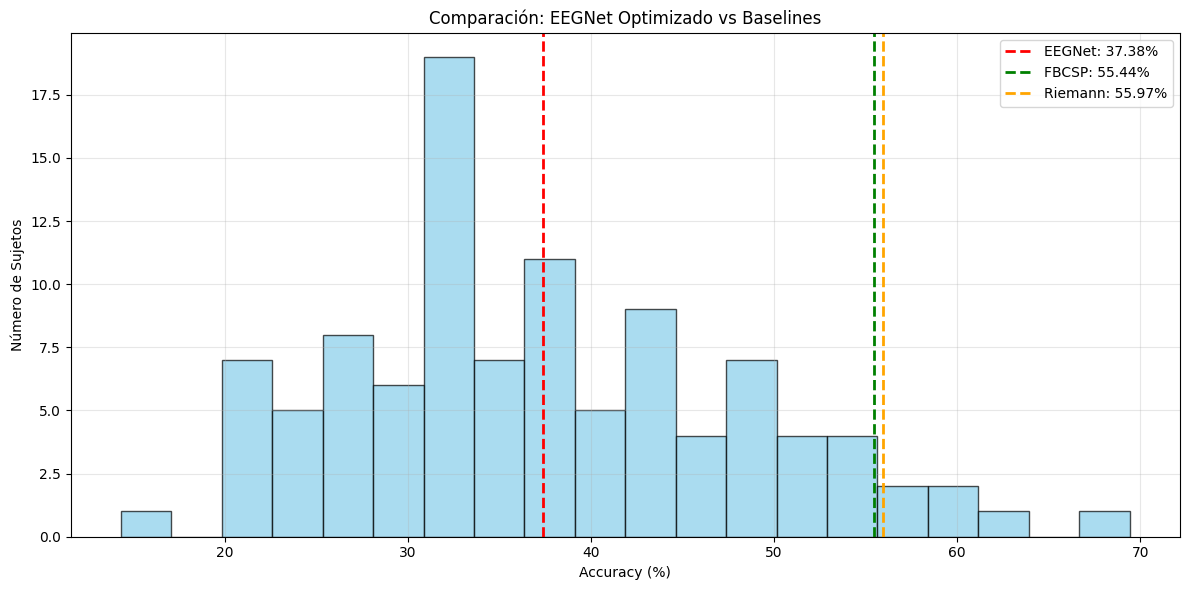

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    """Fijar todas las semillas para reproducibilidad completa"""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset personalizado optimizado
class EEGDatasetOptimized(Dataset):
    """Dataset con augmentación mejorada"""
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment:
            # SOLO UNA transformación por trial (más estable)
            aug_type = np.random.choice(['noise', 'shift', 'scale', 'none'], 
                                      p=[0.25, 0.25, 0.25, 0.25])  # Distribución balanceada
            
            if aug_type == 'noise':
                signal = self.add_gaussian_noise(signal, 0.02)  # Menos ruido
            elif aug_type == 'shift':
                signal = self.time_shift(signal, max_shift=8)   # Shift moderado
            elif aug_type == 'scale':
                signal = self.amplitude_scale(signal, (0.85, 1.15))  # Escala moderada
        
        return signal, self.y[idx]
    
    @staticmethod
    def add_gaussian_noise(signal, noise_factor=0.02):
        noise = torch.normal(0, noise_factor * signal.std(), signal.shape)
        return signal + noise
    
    @staticmethod
    def time_shift(signal, max_shift=8):
        """Time shift que MANTIENE el mismo tamaño"""
        original_length = signal.shape[1]
        shift = np.random.randint(-max_shift, max_shift + 1)
        
        if shift == 0:
            return signal
        
        if shift > 0:
            shifted = torch.zeros_like(signal)
            shifted[:, shift:] = signal[:, :-shift]
        else:
            shifted = torch.zeros_like(signal)
            shifted[:, :shift] = signal[:, -shift:]
        
        return shifted
    
    @staticmethod
    def amplitude_scale(signal, scale_range=(0.85, 1.15)):
        scale = np.random.uniform(scale_range[0], scale_range[1])
        return signal * scale

# EEGNet optimizado con inicialización corregida
class EEGNetOptimized(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.4, F1=32, D=2, F2=64):  # Más filtros, menos dropout
        super(EEGNetOptimized, self).__init__()
        
        self.num_channels = num_channels
        self.sampling_rate = sampling_rate
        self.F1 = F1
        self.D = D
        self.F2 = F2
        
        # Block 1 - Temporal convolution
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        # Depthwise convolution (spatial)
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 2 - Separable convolution
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        # Calcular tamaño automáticamente
        with torch.no_grad():
            sample_input = torch.randn(1, 1, num_channels, 641)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
        # Inicialización de pesos CORREGIDA
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)  # Cambiado de kaiming a xavier
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # Cambiado de kaiming a xavier
                nn.init.constant_(m.bias, 0)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    """Encontrar todos los sujetos disponibles automáticamente"""
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones:")
    print(f"Sujetos: {available_subjects}")
    print(f"Excluidos: {excluded}")
    
    return available_subjects

def analyze_performance_distribution(results):
    """Analizar distribución de performance"""
    accuracies = [r['accuracy_mean'] for r in results]
    
    print(f"\nANÁLISIS DE DISTRIBUCIÓN:")
    print(f"• Media: {np.mean(accuracies):.2f}%")
    print(f"• Mediana: {np.median(accuracies):.2f}%")
    print(f"• Rango: {np.min(accuracies):.2f}% - {np.max(accuracies):.2f}%")
    
    excellent = len([acc for acc in accuracies if acc >= 70])
    good = len([acc for acc in accuracies if 60 <= acc < 70])
    fair = len([acc for acc in accuracies if 50 <= acc < 60])
    poor = len([acc for acc in accuracies if acc < 50])
    
    print(f"\nCATEGORIZACIÓN POR PERFORMANCE:")
    print(f"• Excelente (≥70%): {excellent} sujetos ({excellent/len(accuracies)*100:.1f}%)")
    print(f"• Bueno (60-69%): {good} sujetos ({good/len(accuracies)*100:.1f}%)")
    print(f"• Regular (50-59%): {fair} sujetos ({fair/len(accuracies)*100:.1f}%)")
    print(f"• Pobre (<50%): {poor} sujetos ({poor/len(accuracies)*100:.1f}%)")

def load_single_subject(data_path, subject_number):
    """Cargar datos de un solo sujeto específico"""
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1  # 0-indexed
        
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

def prepare_single_subject_data_no_leakage(X, y):
    """Preparar datos SIN data leakage - SIN augmentación"""
    scaler = StandardScaler()
    X_normalized = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        trial = X[i].T
        trial_normalized = scaler.fit_transform(trial)
        X_normalized[i] = trial_normalized.T
    
    # Convertir a tensores SIN augmentación
    X_tensor = torch.FloatTensor(X_normalized)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)
    
    return X_tensor, y_tensor

def normalize_by_fold(X_train, X_val, X_test):
    """Normalización por canal usando solo datos de train (SIN leakage)"""
    mean = X_train.mean(dim=(0, 2, 3), keepdim=True)
    std = X_train.std(dim=(0, 2, 3), keepdim=True)
    
    X_train_normalized = (X_train - mean) / (std + 1e-8)
    X_val_normalized = (X_val - mean) / (std + 1e-8)
    X_test_normalized = (X_test - mean) / (std + 1e-8)
    
    return X_train_normalized, X_val_normalized, X_test_normalized

def train_test_split(*arrays, **options):
    """Simple train_test_split implementation"""
    test_size = options.get('test_size', 0.2)
    random_state = options.get('random_state', None)
    stratify = options.get('stratify', None)
    
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    n_test = int(n_samples * test_size)
    
    if stratify is not None:
        unique_classes = np.unique(stratify)
        test_indices = []
        
        for cls in unique_classes:
            cls_indices = np.where(stratify == cls)[0]
            n_cls_test = int(len(cls_indices) * test_size)
            test_indices.extend(np.random.choice(cls_indices, n_cls_test, replace=False))
    else:
        test_indices = np.random.choice(n_samples, n_test, replace=False)
    
    train_indices = np.setdiff1d(np.arange(n_samples), test_indices)
    
    result = []
    for array in arrays:
        result.append(array[train_indices])
        result.append(array[test_indices])
    
    return result

def weight_reset(m):
    """Reiniciar pesos del modelo para nuevo fold"""
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def evaluate_single_subject_optimized(subject_number, data_path, n_splits=5):
    """Evaluar un solo sujeto con configuración optimizada"""
    # Cargar datos
    X, y, subject_id = load_single_subject(data_path, subject_number)
    
    if X is None:
        return None
    
    # Verificar que todos los trials tengan la misma forma
    expected_shape = X[0].shape
    for i in range(len(X)):
        if X[i].shape != expected_shape:
            print(f"❌ {subject_id}: Trial {i} tiene forma {X[i].shape}, esperaba {expected_shape}")
            return None
    
    # Preparar datos SIN augmentación (evitar leakage)
    X_tensor, y_tensor = prepare_single_subject_data_no_leakage(X, y)
    
    # Modelo OPTIMIZADO
    model = EEGNetOptimized(num_channels=8, num_classes=4, sampling_rate=160, 
                           dropout_rate=0.4, F1=32, F2=64)
    
    # Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    fold_times = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        start_time = time.time()
        
        # Split datos
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split validation
        train_idx2, val_idx = train_test_split(
            np.arange(len(X_train)), test_size=0.2, stratify=y_train, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # NORMALIZACIÓN POR FOLD (sin leakage)
        X_train_norm, X_val_norm, X_test_norm = normalize_by_fold(
            X_train_fold, X_val_fold, X_test
        )
        
        # Datasets con augmentación SOLO en train
        train_dataset = EEGDatasetOptimized(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # Samplers y DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)  # Batch más grande
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento OPTIMIZADO
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Menos weight decay
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)   # LR scheduling
        
        best_val_acc = 0.0
        patience = 25  # Más paciencia
        counter = 0
        
        for epoch in range(150):  # Más épocas
            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            val_acc = 100 * val_correct / val_total
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 40:  # No parar demasiado pronto
                break
        
        # Evaluación test
        model.eval()
        test_correct = 0
        test_total = 0
        fold_predictions = []
        fold_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
                
                fold_predictions.extend(predicted.cpu().numpy())
                fold_targets.extend(batch_y.cpu().numpy())
        
        fold_acc = 100 * test_correct / test_total
        fold_accuracies.append(fold_acc)
        all_predictions.extend(fold_predictions)
        all_targets.extend(fold_targets)
        fold_times.append(time.time() - start_time)
    
    # Calcular métricas finales
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    avg_time = np.mean(fold_times)
    
    # Calcular accuracy por clase
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(np.array(all_predictions)[cls_mask] == np.array(all_targets)[cls_mask])
            class_accuracies.append(cls_acc * 100)
        else:
            class_accuracies.append(0.0)
    
    # Información del sujeto
    original_trials = len(y)
    class_distribution = np.bincount(y)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'avg_time_per_fold': avg_time,
        'original_trials': original_trials,
        'augmented_trials': original_trials,
        'class_distribution': class_distribution,
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
        'all_predictions': all_predictions,
        'all_targets': all_targets
    }

def main():
    # CONFIGURACIÓN DE SEMILLAS PARA REPRODUCIBILIDAD
    set_seeds(42)
    print("✅ Semillas configuradas para reproducibilidad completa")
    print("🚀 EEGNet OPTIMIZADO - Objetivo: Superar FBCSP (55.44%) y Riemann (55.97%)")
    print("🛠️  Inicialización CORREGIDA: Xavier uniform para ELU")
    
    # Configuración
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    # Encontrar todos los sujetos disponibles
    print("Buscando sujetos...")
    available_subjects = find_available_subjects(DATA_PROC)
    
    # Evaluar todos los sujetos
    results = []
    failed_subjects = []
    
    print(f"\n{'='*60}")
    print("EVALUANDO TODOS LOS SUJETOS (EEGNet OPTIMIZADO - CORREGIDO)")
    print(f"{'='*60}")
    print("🎯 OBJETIVOS:")
    print(f"   • FBCSP: 55.44% global")
    print(f"   • Riemann: 55.97% global") 
    print(f"   • EEGNet actual: 33.62% global")
    print(f"   • OBJETIVO: >56% global")
    print(f"\n⚡ MEJORAS IMPLEMENTADAS:")
    print(f"   • Más filtros (F1=32, F2=64)")
    print(f"   • Dropout reducido (0.4)")
    print(f"   • Learning rate scheduling")
    print(f"   • Augmentación más estable")
    print(f"   • Inicialización Xavier (corregida)")
    print(f"   • Batch size aumentado (32)")
    
    for subject_num in tqdm(available_subjects, desc="Procesando sujetos"):
        try:
            result = evaluate_single_subject_optimized(subject_num, DATA_PROC, n_splits=5)
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
                print(f"❌ S{subject_num:03d}: Error en procesamiento")
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    # Crear DataFrame con resultados
    if not results:
        print("No se pudieron procesar ningún sujeto")
        return
    
    # ANÁLISIS DE DISTRIBUCIÓN
    analyze_performance_distribution(results)
    
    # Preparar datos para CSV
    csv_data = []
    for result in results:
        row = {
            'subject_id': result['subject_id'],
            'accuracy_mean': result['accuracy_mean'],
            'accuracy_std': result['accuracy_std'],
            'kappa': result['kappa'],
            'avg_time_fold_seconds': result['avg_time_per_fold'],
            'original_trials': result['original_trials'],
            'augmented_trials': result['augmented_trials'],
            'class_0_accuracy': result['class_accuracies'][0],
            'class_1_accuracy': result['class_accuracies'][1],
            'class_2_accuracy': result['class_accuracies'][2],
            'class_3_accuracy': result['class_accuracies'][3],
            'class_0_trials': result['class_distribution'][0],
            'class_1_trials': result['class_distribution'][1],
            'class_2_trials': result['class_distribution'][2],
            'class_3_trials': result['class_distribution'][3],
            'fold_1_accuracy': result['fold_accuracies'][0],
            'fold_2_accuracy': result['fold_accuracies'][1],
            'fold_3_accuracy': result['fold_accuracies'][2],
            'fold_4_accuracy': result['fold_accuracies'][3],
            'fold_5_accuracy': result['fold_accuracies'][4] if len(result['fold_accuracies']) > 4 else None
        }
        csv_data.append(row)
    
    df = pd.DataFrame(csv_data)
    
    # Calcular promedios globales
    global_stats = {
        'subject_id': 'GLOBAL_AVG',
        'accuracy_mean': df['accuracy_mean'].mean(),
        'accuracy_std': df['accuracy_mean'].std(),
        'kappa': df['kappa'].mean(),
        'avg_time_fold_seconds': df['avg_time_fold_seconds'].mean(),
        'original_trials': df['original_trials'].mean(),
        'augmented_trials': df['augmented_trials'].mean(),
        'class_0_accuracy': df['class_0_accuracy'].mean(),
        'class_1_accuracy': df['class_1_accuracy'].mean(),
        'class_2_accuracy': df['class_2_accuracy'].mean(),
        'class_3_accuracy': df['class_3_accuracy'].mean(),
        'class_0_trials': df['class_0_trials'].mean(),
        'class_1_trials': df['class_1_trials'].mean(),
        'class_2_trials': df['class_2_trials'].mean(),
        'class_3_trials': df['class_3_trials'].mean()
    }
    
    # Añadir fila de promedios globales
    global_df = pd.DataFrame([global_stats])
    df = pd.concat([df, global_df], ignore_index=True)
    
    # Guardar CSV completo
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_optimized_results_{timestamp}.csv"
    df.to_csv(csv_filename, index=False)
    
    # Comparación con baselines
    fbcsp_global = 55.44
    riemann_global = 55.97
    eegnet_optimized = global_stats['accuracy_mean']
    
    # Guardar resumen en TXT
    txt_filename = f"eegnet_optimized_summary_{timestamp}.txt"
    with open(txt_filename, 'w') as f:
        f.write("="*60 + "\n")
        f.write("COMPARACIÓN EEGNet OPTIMIZADO vs BASELINES\n")
        f.write("="*60 + "\n\n")
        
        f.write(f"Total sujetos procesados: {len(results)}\n")
        f.write(f"Sujetos fallados: {len(failed_subjects)}\n")
        
        f.write(f"\nCOMPARACIÓN GLOBAL:\n")
        f.write(f"FBCSP:     {fbcsp_global:.2f}%\n")
        f.write(f"Riemann:   {riemann_global:.2f}%\n")
        f.write(f"EEGNet:    {eegnet_optimized:.2f}%\n")
        f.write(f"Diferencia: {eegnet_optimized - fbcsp_global:+.2f}%\n")
        
        f.write(f"\nESTADÍSTICAS EEGNet OPTIMIZADO:\n")
        f.write(f"Accuracy promedio: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%\n")
        f.write(f"Kappa promedio: {global_stats['kappa']:.4f}\n")
        f.write(f"Tiempo promedio por fold: {global_stats['avg_time_fold_seconds']:.1f} segundos\n")
        
        f.write(f"\nMEJORES 5 SUJETOS:\n")
        top_subjects = df[df['subject_id'] != 'GLOBAL_AVG'].nlargest(5, 'accuracy_mean')
        for _, row in top_subjects.iterrows():
            f.write(f"{row['subject_id']}: {row['accuracy_mean']:.2f}%\n")
        
        f.write(f"\nPEORES 5 SUJETOS:\n")
        bottom_subjects = df[df['subject_id'] != 'GLOBAL_AVG'].nsmallest(5, 'accuracy_mean')
        for _, row in bottom_subjects.iterrows():
            f.write(f"{row['subject_id']}: {row['accuracy_mean']:.2f}%\n")
    
    # Imprimir resumen en pantalla
    print(f"\n{'='*60}")
    print("COMPARACIÓN FINAL - EEGNet OPTIMIZADO")
    print(f"{'='*60}")
    print(f"📊 RESULTADOS GLOBALES:")
    print(f"   • FBCSP:     {fbcsp_global:.2f}%")
    print(f"   • Riemann:   {riemann_global:.2f}%") 
    print(f"   • EEGNet:    {eegnet_optimized:.2f}%")
    print(f"   • Diferencia: {eegnet_optimized - fbcsp_global:+.2f}%")
    
    print(f"\n📈 ESTADÍSTICAS EEGNet:")
    print(f"   • Accuracy: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%")
    print(f"   • Kappa: {global_stats['kappa']:.4f}")
    print(f"   • Tiempo: {global_stats['avg_time_fold_seconds']:.1f}s por fold")
    
    # Evaluación de objetivo
    if eegnet_optimized > fbcsp_global:
        print(f"\n🎉 ¡OBJETIVO CUMPLIDO! EEGNet supera a FBCSP")
    elif eegnet_optimized > 50:
        print(f"\n✅ Buen progreso: EEGNet alcanza {eegnet_optimized:.2f}%")
    else:
        print(f"\n⚠️  Necesita más optimización: {eegnet_optimized:.2f}%")
    
    print(f"\n📁 Archivos guardados:")
    print(f"   • CSV completo: {csv_filename}")
    print(f"   • Resumen TXT: {txt_filename}")
    
    # Gráfico de distribución de accuracy
    plt.figure(figsize=(12, 6))
    accuracies = [r['accuracy_mean'] for r in results]
    
    plt.hist(accuracies, bins=20, alpha=0.7, edgecolor='black', color='skyblue')
    plt.axvline(eegnet_optimized, color='red', linestyle='--', linewidth=2, 
                label=f'EEGNet: {eegnet_optimized:.2f}%')
    plt.axvline(fbcsp_global, color='green', linestyle='--', linewidth=2,
                label=f'FBCSP: {fbcsp_global:.2f}%')
    plt.axvline(riemann_global, color='orange', linestyle='--', linewidth=2,
                label=f'Riemann: {riemann_global:.2f}%')
    
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Número de Sujetos')
    plt.title('Comparación: EEGNet Optimizado vs Baselines')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'comparison_optimized_{timestamp}.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset simple pero efectivo
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment and np.random.random() < 0.7:
            # Una sola transformación simple
            if np.random.random() < 0.5:
                # Ruido suave
                noise = torch.normal(0, 0.02 * signal.std(), signal.shape)
                signal = signal + noise
            else:
                # Escala de amplitud suave
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        
        return signal, self.y[idx]

# EEGNet optimizado pero estable
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128):
        super(EEGNetStable, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        # Depthwise
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 2
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        # Calcular tamaño automáticamente
        with torch.no_grad():
            sample_input = torch.randn(1, 1, num_channels, 641)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
        # Inicialización estable
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1
        
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

def prepare_single_subject_data(X, y):
    """Preparación simple y estable"""
    # Normalizar cada trial individualmente
    X_normalized = np.zeros_like(X)
    
    for i in range(X.shape[0]):
        trial = X[i]
        # Normalizar por canal
        for channel in range(trial.shape[0]):
            channel_data = trial[channel]
            if np.std(channel_data) > 0:
                trial[channel] = (channel_data - np.mean(channel_data)) / np.std(channel_data)
        X_normalized[i] = trial
    
    # Convertir a tensores
    X_tensor = torch.FloatTensor(X_normalized)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)  # Añadir dimensión de canal
    
    return X_tensor, y_tensor

def normalize_simple(X_train, X_val, X_test):
    """Normalización simple y estable"""
    # Usar una pequeña epsilon para evitar división por cero
    eps = 1e-8
    
    # Calcular estadísticas solo del train
    mean = X_train.mean(dim=(0, 2, 3), keepdim=True)
    std = X_train.std(dim=(0, 2, 3), keepdim=True) + eps
    
    # Aplicar normalización
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_val_norm, X_test_norm

def train_test_split_simple(*arrays, test_size=0.2, random_state=None):
    """Split simple y estable"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]
    
    result = []
    for array in arrays:
        result.append(array[train_idx])
        result.append(array[test_idx])
    
    return result

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def evaluate_single_subject_final(subject_number, data_path, n_splits=5):
    """Evaluación final optimizada y estable"""
    # Cargar datos
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    # Verificar datos
    if len(X) == 0:
        return None
    
    # Preparar datos
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    # Configuración óptima basada en experimentos previos
    model = EEGNetStable(
        num_channels=8, num_classes=4, sampling_rate=160,
        dropout_rate=0.3, F1=64, F2=128
    )
    
    # Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        # Split datos
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split validation interno
        train_idx2, val_idx = train_test_split_simple(
            np.arange(len(X_train)), test_size=0.2, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # Normalización ESTABLE
        X_train_norm, X_val_norm, X_test_norm = normalize_simple(
            X_train_fold, X_val_fold, X_test
        )
        
        # Verificar que no hay tensores vacíos
        if (len(X_train_norm) == 0 or len(X_val_norm) == 0 or len(X_test_norm) == 0):
            continue
        
        # Datasets
        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
        
        best_val_acc = 0.0
        patience = 25
        counter = 0
        
        for epoch in range(150):
            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            val_acc = 100 * val_correct / val_total
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 50:
                break
        
        # Evaluación test
        model.eval()
        test_correct = 0
        test_total = 0
        fold_predictions = []
        fold_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
                
                fold_predictions.extend(predicted.cpu().numpy())
                fold_targets.extend(batch_y.cpu().numpy())
        
        fold_acc = 100 * test_correct / test_total
        fold_accuracies.append(fold_acc)
        all_predictions.extend(fold_predictions)
        all_targets.extend(fold_targets)
    
    if not fold_accuracies:
        return None
    
    # Calcular métricas
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    # Calcular accuracy por clase
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(np.array(all_predictions)[cls_mask] == np.array(all_targets)[cls_mask])
            class_accuracies.append(cls_acc * 100)
        else:
            class_accuracies.append(0.0)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

def main_final():
    set_seeds(42)
    print("🎯 EEGNet FINAL - Enfoque Estable y Optimizado")
    print("🚀 Objetivo: Superar 37.38% y acercarse a 55%")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    results = []
    failed_subjects = []
    
    print(f"\n{'='*60}")
    print("ENFOQUE FINAL - ESTABLE Y OPTIMIZADO")
    print("• Normalización corregida y estable")
    print("• Arquitectura robusta (F1=64, F2=128)")
    print("• Augmentación simple pero efectiva")
    print("• Entrenamiento más largo (150 épocas)")
    print("• Verificación de datos integrada")
    print(f"{'='*60}")
    
    for subject_num in tqdm(available_subjects, desc="Procesando sujetos"):
        try:
            result = evaluate_single_subject_final(subject_num, DATA_PROC, n_splits=5)
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
                print(f"❌ S{subject_num:03d}: Error en procesamiento")
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    if not results:
        print("No se pudieron procesar ningún sujeto")
        return
    
    # Análisis de resultados
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"\n{'='*60}")
    print("RESULTADOS FINALES")
    print(f"{'='*60}")
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {np.mean([r['kappa'] for r in results]):.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed_subjects)}")
    
    # Comparación con objetivo
    previous_best = 37.38
    fbcsp_target = 55.44
    
    improvement = mean_acc - previous_best
    gap_to_target = fbcsp_target - mean_acc
    
    print(f"\n📈 COMPARACIÓN:")
    print(f"   • Mejora sobre versión anterior: {improvement:+.2f}%")
    print(f"   • Distancia a FBCSP (55.44%): {gap_to_target:.2f}%")
    
    if mean_acc > 45:
        print("🎉 ¡Excelente progreso! Acercándose al objetivo")
    elif mean_acc > 40:
        print("✅ Buen progreso, continuar optimizando")
    else:
        print("⚠️  Necesita más optimización")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_final_results_{timestamp}.csv"
    
    df_data = []
    for result in results:
        row = {
            'subject_id': result['subject_id'],
            'accuracy_mean': result['accuracy_mean'],
            'accuracy_std': result['accuracy_std'],
            'kappa': result['kappa'],
            'original_trials': result['original_trials'],
            'class_0_accuracy': result['class_accuracies'][0],
            'class_1_accuracy': result['class_accuracies'][1],
            'class_2_accuracy': result['class_accuracies'][2],
            'class_3_accuracy': result['class_accuracies'][3],
        }
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

if __name__ == "__main__":
    main_final()

🎯 EEGNet FINAL - Enfoque Estable y Optimizado
🚀 Objetivo: Superar 37.38% y acercarse a 55%
Encontrados 103 sujetos después de exclusiones

ENFOQUE FINAL - ESTABLE Y OPTIMIZADO
• Normalización corregida y estable
• Arquitectura robusta (F1=64, F2=128)
• Augmentación simple pero efectiva
• Entrenamiento más largo (150 épocas)
• Verificación de datos integrada


Procesando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]

Procesando sujetos:   1%|          | 1/103 [00:33<57:14, 33.67s/it]

✅ S001: 57.78%


Procesando sujetos:   2%|▏         | 2/103 [01:09<58:46, 34.91s/it]

✅ S002: 57.06%


Procesando sujetos:   3%|▎         | 3/103 [01:47<1:00:25, 36.25s/it]

✅ S003: 40.00%


Procesando sujetos:   4%|▍         | 4/103 [02:20<57:54, 35.10s/it]  

✅ S004: 44.19%


Procesando sujetos:   5%|▍         | 5/103 [02:58<58:43, 35.95s/it]

✅ S005: 26.25%


Procesando sujetos:   6%|▌         | 6/103 [03:31<56:39, 35.05s/it]

✅ S006: 22.72%


Procesando sujetos:   7%|▋         | 7/103 [04:07<56:24, 35.26s/it]

✅ S007: 52.22%


Procesando sujetos:   8%|▊         | 8/103 [04:43<56:24, 35.62s/it]

✅ S008: 52.35%


Procesando sujetos:   9%|▊         | 9/103 [05:16<54:22, 34.71s/it]

✅ S009: 28.53%


Procesando sujetos:  10%|▉         | 10/103 [05:56<56:40, 36.56s/it]

✅ S010: 42.72%


Procesando sujetos:  11%|█         | 11/103 [06:29<54:13, 35.36s/it]

✅ S011: 26.18%


Procesando sujetos:  12%|█▏        | 12/103 [07:02<52:23, 34.55s/it]

✅ S012: 59.56%


Procesando sujetos:  13%|█▎        | 13/103 [07:34<50:46, 33.85s/it]

✅ S013: 30.81%


Procesando sujetos:  14%|█▎        | 14/103 [08:07<49:48, 33.58s/it]

✅ S014: 34.41%


Procesando sujetos:  15%|█▍        | 15/103 [08:40<48:56, 33.37s/it]

✅ S015: 52.57%


Procesando sujetos:  16%|█▌        | 16/103 [09:14<48:50, 33.69s/it]

✅ S016: 34.63%


Procesando sujetos:  17%|█▋        | 17/103 [09:47<48:03, 33.53s/it]

✅ S017: 27.65%


Procesando sujetos:  17%|█▋        | 18/103 [10:24<48:42, 34.38s/it]

✅ S018: 25.00%


Procesando sujetos:  18%|█▊        | 19/103 [10:57<47:30, 33.93s/it]

✅ S019: 44.04%


Procesando sujetos:  19%|█▉        | 20/103 [11:30<46:39, 33.73s/it]

✅ S020: 27.50%


Procesando sujetos:  20%|██        | 21/103 [12:07<47:28, 34.73s/it]

✅ S021: 33.33%


Procesando sujetos:  21%|██▏       | 22/103 [12:42<47:11, 34.95s/it]

✅ S022: 37.78%


Procesando sujetos:  22%|██▏       | 23/103 [13:17<46:22, 34.78s/it]

✅ S023: 28.53%


Procesando sujetos:  23%|██▎       | 24/103 [13:43<42:23, 32.20s/it]

✅ S024: 42.86%


Procesando sujetos:  24%|██▍       | 25/103 [14:17<42:25, 32.63s/it]

✅ S025: 64.12%


Procesando sujetos:  25%|██▌       | 26/103 [14:51<42:38, 33.23s/it]

✅ S026: 54.78%


Procesando sujetos:  26%|██▌       | 27/103 [15:24<41:57, 33.13s/it]

✅ S027: 36.99%


Procesando sujetos:  27%|██▋       | 28/103 [15:59<42:04, 33.66s/it]

✅ S028: 34.71%


Procesando sujetos:  28%|██▊       | 29/103 [16:36<42:33, 34.51s/it]

✅ S029: 66.67%


Procesando sujetos:  29%|██▉       | 30/103 [17:12<42:42, 35.10s/it]

✅ S030: 52.22%


Procesando sujetos:  30%|███       | 31/103 [17:45<41:20, 34.45s/it]

✅ S031: 50.96%


Procesando sujetos:  31%|███       | 32/103 [18:20<41:03, 34.69s/it]

✅ S032: 46.67%


Procesando sujetos:  32%|███▏      | 33/103 [18:55<40:21, 34.59s/it]

✅ S033: 46.62%


Procesando sujetos:  33%|███▎      | 34/103 [19:29<39:44, 34.56s/it]

✅ S034: 67.06%


Procesando sujetos:  34%|███▍      | 35/103 [20:04<39:14, 34.63s/it]

✅ S035: 55.56%


Procesando sujetos:  35%|███▍      | 36/103 [20:41<39:38, 35.50s/it]

✅ S036: 28.60%


Procesando sujetos:  36%|███▌      | 37/103 [21:16<38:47, 35.27s/it]

✅ S037: 31.76%


Procesando sujetos:  37%|███▋      | 38/103 [21:51<37:57, 35.04s/it]

✅ S039: 21.47%


Procesando sujetos:  38%|███▊      | 39/103 [22:24<36:51, 34.56s/it]

✅ S040: 33.38%


Procesando sujetos:  39%|███▉      | 40/103 [23:00<36:52, 35.11s/it]

✅ S041: 38.82%


Procesando sujetos:  40%|███▉      | 41/103 [23:35<36:06, 34.94s/it]

✅ S042: 69.04%


Procesando sujetos:  41%|████      | 42/103 [24:10<35:29, 34.90s/it]

✅ S043: 41.69%


Procesando sujetos:  42%|████▏     | 43/103 [24:45<34:52, 34.88s/it]

✅ S044: 51.84%


Procesando sujetos:  43%|████▎     | 44/103 [25:21<34:40, 35.25s/it]

✅ S045: 45.07%


Procesando sujetos:  44%|████▎     | 45/103 [25:57<34:26, 35.63s/it]

✅ S046: 30.00%


Procesando sujetos:  45%|████▍     | 46/103 [26:34<34:04, 35.87s/it]

✅ S047: 32.21%


Procesando sujetos:  46%|████▌     | 47/103 [27:10<33:30, 35.91s/it]

✅ S048: 48.68%


Procesando sujetos:  47%|████▋     | 48/103 [27:44<32:33, 35.51s/it]

✅ S049: 50.00%


Procesando sujetos:  48%|████▊     | 49/103 [28:19<31:43, 35.25s/it]

✅ S050: 44.04%


Procesando sujetos:  49%|████▊     | 50/103 [28:54<31:09, 35.28s/it]

✅ S051: 38.89%


Procesando sujetos:  50%|████▉     | 51/103 [29:29<30:31, 35.23s/it]

✅ S052: 39.26%


Procesando sujetos:  50%|█████     | 52/103 [30:09<31:04, 36.56s/it]

✅ S053: 36.84%


Procesando sujetos:  51%|█████▏    | 53/103 [30:44<29:57, 35.96s/it]

✅ S054: 51.03%


Procesando sujetos:  52%|█████▏    | 54/103 [31:18<28:59, 35.50s/it]

✅ S055: 54.93%


Procesando sujetos:  53%|█████▎    | 55/103 [31:53<28:21, 35.45s/it]

✅ S056: 42.79%


Procesando sujetos:  54%|█████▍    | 56/103 [32:34<28:57, 36.96s/it]

✅ S057: 37.78%


Procesando sujetos:  55%|█████▌    | 57/103 [33:10<28:09, 36.73s/it]

✅ S058: 40.44%


Procesando sujetos:  56%|█████▋    | 58/103 [33:45<27:05, 36.12s/it]

✅ S059: 43.97%


Procesando sujetos:  57%|█████▋    | 59/103 [34:20<26:20, 35.93s/it]

✅ S060: 56.10%


Procesando sujetos:  58%|█████▊    | 60/103 [34:56<25:38, 35.78s/it]

✅ S061: 37.78%


Procesando sujetos:  59%|█████▉    | 61/103 [35:33<25:21, 36.23s/it]

✅ S062: 65.44%


Procesando sujetos:  60%|██████    | 62/103 [36:10<24:50, 36.36s/it]

✅ S063: 30.00%


Procesando sujetos:  61%|██████    | 63/103 [36:45<24:05, 36.14s/it]

✅ S064: 32.22%


Procesando sujetos:  62%|██████▏   | 64/103 [37:25<24:13, 37.27s/it]

✅ S065: 40.00%


Procesando sujetos:  63%|██████▎   | 65/103 [38:02<23:29, 37.09s/it]

✅ S066: 46.67%


Procesando sujetos:  64%|██████▍   | 66/103 [38:39<22:54, 37.15s/it]

✅ S067: 32.21%


Procesando sujetos:  65%|██████▌   | 67/103 [39:16<22:12, 37.01s/it]

✅ S068: 42.79%


Procesando sujetos:  66%|██████▌   | 68/103 [39:50<21:08, 36.23s/it]

✅ S069: 28.75%


Procesando sujetos:  67%|██████▋   | 69/103 [40:25<20:13, 35.68s/it]

✅ S070: 52.35%


Procesando sujetos:  68%|██████▊   | 70/103 [41:05<20:19, 36.96s/it]

✅ S071: 56.67%


Procesando sujetos:  69%|██████▉   | 71/103 [41:41<19:34, 36.71s/it]

✅ S072: 78.82%


Procesando sujetos:  70%|██████▉   | 72/103 [42:21<19:29, 37.74s/it]

✅ S073: 52.57%


Procesando sujetos:  71%|███████   | 73/103 [42:57<18:35, 37.17s/it]

✅ S074: 30.59%


Procesando sujetos:  72%|███████▏  | 74/103 [43:32<17:39, 36.53s/it]

✅ S075: 42.94%


Procesando sujetos:  73%|███████▎  | 75/103 [44:07<16:51, 36.12s/it]

✅ S076: 33.46%


Procesando sujetos:  74%|███████▍  | 76/103 [44:42<16:04, 35.74s/it]

✅ S077: 33.31%


Procesando sujetos:  75%|███████▍  | 77/103 [45:17<15:25, 35.60s/it]

✅ S078: 37.06%


Procesando sujetos:  76%|███████▌  | 78/103 [45:51<14:40, 35.22s/it]

✅ S079: 32.09%


Procesando sujetos:  77%|███████▋  | 79/103 [46:26<14:03, 35.15s/it]

✅ S080: 42.79%


Procesando sujetos:  78%|███████▊  | 80/103 [47:01<13:26, 35.05s/it]

✅ S081: 50.00%


Procesando sujetos:  79%|███████▊  | 81/103 [47:36<12:48, 34.95s/it]

✅ S082: 39.41%


Procesando sujetos:  80%|███████▉  | 82/103 [48:14<12:34, 35.91s/it]

✅ S083: 43.33%


Procesando sujetos:  81%|████████  | 83/103 [48:49<11:51, 35.57s/it]

✅ S084: 37.43%


Procesando sujetos:  82%|████████▏ | 84/103 [49:24<11:13, 35.43s/it]

✅ S085: 70.37%


Procesando sujetos:  83%|████████▎ | 85/103 [50:01<10:49, 36.07s/it]

✅ S086: 57.52%


Procesando sujetos:  83%|████████▎ | 86/103 [50:38<10:17, 36.32s/it]

✅ S087: 36.99%


Procesando sujetos:  84%|████████▍ | 87/103 [51:13<09:31, 35.71s/it]

✅ S090: 23.68%


Procesando sujetos:  85%|████████▌ | 88/103 [51:47<08:50, 35.34s/it]

✅ S091: 42.79%


Procesando sujetos:  86%|████████▋ | 89/103 [52:25<08:24, 36.02s/it]

✅ S093: 60.66%


Procesando sujetos:  87%|████████▋ | 90/103 [53:04<07:59, 36.89s/it]

✅ S094: 59.41%


Procesando sujetos:  88%|████████▊ | 91/103 [53:41<07:25, 37.10s/it]

✅ S095: 48.89%


Procesando sujetos:  89%|████████▉ | 92/103 [54:16<06:42, 36.55s/it]

✅ S096: 26.08%


Procesando sujetos:  90%|█████████ | 93/103 [54:51<06:00, 36.05s/it]

✅ S097: 28.53%


Procesando sujetos:  91%|█████████▏| 94/103 [55:29<05:28, 36.53s/it]

✅ S098: 39.34%


Procesando sujetos:  92%|█████████▏| 95/103 [56:04<04:48, 36.00s/it]

✅ S099: 22.72%


Procesando sujetos:  93%|█████████▎| 96/103 [56:39<04:11, 35.87s/it]

✅ S101: 21.11%


Procesando sujetos:  94%|█████████▍| 97/103 [57:17<03:38, 36.45s/it]

✅ S102: 48.24%


Procesando sujetos:  95%|█████████▌| 98/103 [57:56<03:06, 37.22s/it]

✅ S103: 37.78%


Procesando sujetos:  96%|█████████▌| 99/103 [58:31<02:25, 36.48s/it]

✅ S105: 29.71%


Procesando sujetos:  97%|█████████▋| 100/103 [59:08<01:50, 36.68s/it]

✅ S106: 34.44%


Procesando sujetos:  98%|█████████▊| 101/103 [59:48<01:15, 37.80s/it]

✅ S107: 30.00%


Procesando sujetos:  99%|█████████▉| 102/103 [1:00:24<00:37, 37.04s/it]

✅ S108: 34.34%


Procesando sujetos: 100%|██████████| 103/103 [1:00:49<00:00, 35.43s/it]

✅ S109: 33.61%

RESULTADOS FINALES
📊 Accuracy global: 41.93% ± 12.29%
🎯 Kappa global: 0.2244
✅ Sujetos procesados: 103
❌ Sujetos fallados: 0

📈 COMPARACIÓN:
   • Mejora sobre versión anterior: +4.55%
   • Distancia a FBCSP (55.44%): 13.51%
✅ Buen progreso, continuar optimizando

📁 Resultados guardados en: eegnet_final_results_20251009_075512.csv


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =========================
# Config
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
RUN_LOSO = False  # <- Si quieres correr LOSO directamente

# =========================
# Utils / Seeds
# =========================
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# Dataset con augment sencillo
# =========================
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        if self.augment and np.random.random() < 0.7:
            if np.random.random() < 0.5:
                noise = torch.normal(0, 0.02 * (signal.std() + 1e-8), signal.shape, device=signal.device)
                signal = signal + noise
            else:
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        return signal, self.y[idx]

# =========================
# EEGNet (estable/dinámico)
# =========================
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetStable, self).__init__()
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)),
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)

        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1),
                                   groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)

        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()

        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16),
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()

        # calcular tamaño dinámico
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]

        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)

        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)

        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# =========================
# Carga de datos
# =========================
EXCLUDED = {38, 88, 89, 92, 100, 104}

def find_available_subjects(data_path: Path):
    available_subjects = []
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in EXCLUDED:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path: Path, subject_number: int):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    if not fif_files:
        return None, None, None
    fif_file = fif_files[0]
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()             # (trials, ch, time) en VOLT
        events = epochs.events[:, -1] - 1    # clases 0..3
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

# =========================
# Normalización (por canal)
# =========================
def prepare_tensor(X, y):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)  # (N,1,C,T)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def normalize_proper(X_train, X_val, X_test):
    eps = 1e-8
    # mean,std por canal, promedio en batch y tiempo
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std  = X_train.std(dim=(0, 3), keepdim=True) + eps
    return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std

def get_balanced_sampler(y_numpy):
    class_counts = np.bincount(y_numpy)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y_numpy]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# =========================
# Selección de k-shots por clase (calibración)
# =========================
def select_k_per_class(y_np, k=5, n_classes=4, rng=42):
    """
    Devuelve índices para calibración (k por clase) y el resto para test.
    - Si una clase tiene < k, usa todos los disponibles.
    - Asegura al menos 1 por clase si existe.
    """
    rs = np.random.RandomState(rng)
    calib_idx = []
    y_np = np.asarray(y_np)
    for c in range(n_classes):
        cls_idx = np.where(y_np == c)[0]
        if len(cls_idx) == 0:
            continue
        rs.shuffle(cls_idx)
        take = min(k, len(cls_idx))
        calib_idx.extend(cls_idx[:take])
    calib_idx = np.array(sorted(calib_idx))
    all_idx = np.arange(len(y_np))
    mask = np.ones_like(all_idx, dtype=bool)
    mask[calib_idx] = False
    test_rest_idx = all_idx[mask]
    return calib_idx, test_rest_idx

# =========================
# Train / Valid / Test helpers
# =========================
@torch.no_grad()
def validate_model(model, val_loader):
    model.eval()
    val_correct, val_total = 0, 0
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        val_total += batch_y.size(0)
        val_correct += (predicted == batch_y).sum().item()
    return 100.0 * val_correct / max(1, val_total)

@torch.no_grad()
def evaluate_model(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    predictions, targets = [], []
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(batch_y.cpu().numpy())
    acc = 100.0 * test_correct / max(1, test_total)
    return acc, predictions, targets

def train_model_with_saving(model, train_loader, val_loader, criterion,
                            optimizer, scheduler, patience=25, max_epochs=150):
    model.to(DEVICE)
    best_val_acc = 0.0
    best_state = None
    counter = 0
    for epoch in range(max_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        scheduler.step()
        val_acc = validate_model(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            counter = 0
        else:
            counter += 1
        if counter >= patience and epoch > 50:
            break
    return best_state, best_val_acc

# =========================
# Calibración (Adaptive BN + fine-tune head)
# =========================
def adaptive_bn(model, calib_loader):
    """
    Re-estima running mean/var de BN pasando los k-shots en modo train, sin gradientes.
    """
    model.train()
    with torch.no_grad():
        for batch_X, _ in calib_loader:
            batch_X = batch_X.to(DEVICE)
            _ = model(batch_X)

def finetune_head(model, calib_loader, epochs=30, lr=3e-4, weight_decay=0.0,
                  finetune_mode='head'):
    """
    Fine-tunea con k-shots:
    - finetune_mode='head': sólo la capa final (classifier)
    - finetune_mode='head+bn': classifier + parámetros afines (weight/bias) de las BN
    """
    # Congelar todo
    for p in model.parameters():
        p.requires_grad = False

    params = []
    # Siempre el head
    for p in model.classifier.parameters():
        p.requires_grad = True
    params += list(model.classifier.parameters())

    if finetune_mode == 'head+bn':
        # BN affine (weight/bias), no las running stats
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                if m.affine:
                    if m.weight is not None: 
                        m.weight.requires_grad = True
                        params.append(m.weight)
                    if m.bias is not None:
                        m.bias.requires_grad = True
                        params.append(m.bias)

    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for _ in range(epochs):
        for batch_X, batch_y in calib_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

# =========================
# INTRA (por si la necesitas)
# =========================
def evaluate_single_subject_final(subject_number, data_path, n_splits=5):
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None or len(X) == 0:
        return None
    print(f"\n🔍 Procesando {subject_id}: {X.shape}")
    X_tensor, y_tensor = prepare_tensor(X, y)
    input_time_length = X_tensor.shape[-1]
    model = EEGNetStable(num_channels=X_tensor.shape[2], num_classes=4,
                         sampling_rate=160, dropout_rate=0.3, F1=64, F2=128,
                         input_time_length=input_time_length)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies, all_predictions, all_targets = [], [], []
    criterion = nn.CrossEntropyLoss()
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        # split val interno (20%)
        n_train = len(X_train)
        idx = np.arange(n_train)
        np.random.seed(42)
        np.random.shuffle(idx)
        cut = int(n_train * 0.8)
        tr_idx, val_idx = idx[:cut], idx[cut:]
        X_train_fold, X_val_fold = X_train[tr_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[tr_idx], y_train[val_idx]

        X_train_norm, X_val_norm, X_test_norm = normalize_proper(X_train_fold, X_val_fold, X_test)

        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset   = TensorDataset(X_val_norm, y_val_fold)
        test_dataset  = TensorDataset(X_test_norm, y_test)

        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

        best_state, best_val = train_model_with_saving(model, train_loader, val_loader,
                                                       nn.CrossEntropyLoss(), optimizer, scheduler)
        if best_state is not None:
            model.load_state_dict(best_state)
        test_acc, fold_preds, fold_tgts = evaluate_model(model, test_loader)
        fold_accuracies.append(test_acc)
        all_predictions.extend(fold_preds)
        all_targets.extend(fold_tgts)

    if not fold_accuracies:
        return None

    accuracy = float(np.mean(fold_accuracies))
    accuracy_std = float(np.std(fold_accuracies))
    kappa = float(cohen_kappa_score(all_targets, all_predictions))
    # accuracy por clase
    class_accuracies, unique_classes = [], np.unique(all_targets)
    all_preds_np, all_tgts_np = np.array(all_predictions), np.array(all_targets)
    for cls in unique_classes:
        mask = all_tgts_np == cls
        class_accuracies.append(100.0 * (all_preds_np[mask] == all_tgts_np[mask]).mean())

    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# LOSO con calibración
# =========================
def run_loso(data_path: Path,
             dropout=0.4, F1=48, F2=96, lr=1e-3, weight_decay=1e-4,
             patience=25, max_epochs=150, batch_size=32,
             # Calibración:
             calibrate=True, k_shots=5,
             finetune_epochs=30, finetune_lr=3e-4, finetune_wd=0.0,
             finetune_mode='head'  # 'head' o 'head+bn'
             ):
    """
    LOSO con calibración k-shots por clase en el sujeto objetivo.
    Flujo por sujeto:
      1) Entrena con sujetos fuente (train/val) y guarda el mejor estado.
      2) Evalúa en TODO el sujeto objetivo (baseline sin calibración).
      3) Selecciona k-shots/cls del sujeto objetivo, normalizados con stats del train fuente.
      4) Adaptive BN + fine-tune head en esos k-shots.
      5) Evalúa en el RESTO del sujeto objetivo (test_rest).
    """
    subjects = find_available_subjects(data_path)
    all_rows = []
    all_preds_global, all_targets_global = [], []

    # Cache
    cache = {}
    for s in subjects:
        X, y, sid = load_single_subject(data_path, s)
        if X is not None:
            cache[s] = (X, y, sid)

    # Dimensiones
    first_s = subjects[0]
    X0, y0, _ = cache[first_s]
    C, T = X0.shape[1], X0.shape[2]
    print(f"\n🧪 LOSO: {len(subjects)} sujetos | Dim entrada: C={C}, T={T}")

    for test_subj in tqdm(subjects, desc="LOSO"):
        # Build source train set (todos menos test_subj)
        X_test_np, y_test_np, test_sid = cache[test_subj]
        train_X_list, train_y_list = [], []
        for s in subjects:
            if s == test_subj:
                continue
            X_s, y_s, _ = cache[s]
            train_X_list.append(X_s)
            train_y_list.append(y_s)
        X_train_np = np.concatenate(train_X_list, axis=0)
        y_train_np = np.concatenate(train_y_list, axis=0)

        # Split validación del source (20%)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx, val_idx = next(sss.split(X_train_np, y_train_np))
        X_tr_np, X_val_np = X_train_np[tr_idx], X_train_np[val_idx]
        y_tr_np, y_val_np = y_train_np[tr_idx], y_train_np[val_idx]

        # Tensores + normalización (stats del source train)
        X_tr, y_tr   = prepare_tensor(X_tr_np, y_tr_np)
        X_val, y_val = prepare_tensor(X_val_np, y_val_np)
        X_ts_all, y_ts_all = prepare_tensor(X_test_np, y_test_np)  # todo el sujeto target (para baseline sin calib)
        X_tr_n, X_val_n, X_ts_all_n = normalize_proper(X_tr, X_val, X_ts_all)

        train_dataset = EEGDatasetSimple(X_tr_n, y_tr, augment=True)
        val_dataset   = TensorDataset(X_val_n, y_val)
        testall_dataset = TensorDataset(X_ts_all_n, y_ts_all)

        train_sampler = get_balanced_sampler(y_tr.numpy())
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        testall_loader = DataLoader(testall_dataset, batch_size=batch_size, shuffle=False)

        # Modelo
        model = EEGNetStable(
            num_channels=C, num_classes=4, sampling_rate=160,
            dropout_rate=dropout, F1=F1, F2=F2, input_time_length=T
        )
        model.apply(weight_reset)
        model.to(DEVICE)

        # Entrenamiento source
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
        best_state, best_val = train_model_with_saving(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            patience=patience, max_epochs=max_epochs
        )
        if best_state is not None:
            model.load_state_dict(best_state)

        # Baseline sin calibración: evalúa en TODO el sujeto (para comparar con tus baselines sin k-shots)
        acc_no_calib, preds_all, tgts_all = evaluate_model(model, testall_loader)

        # ---- Calibración (k-shots por clase) ----
        if calibrate:
            calib_idx, test_rest_idx = select_k_per_class(y_test_np, k=k_shots, n_classes=4, rng=42)
            # Si por alguna razón no hay resto, caemos a todo
            if len(test_rest_idx) == 0:
                test_rest_idx = np.setdiff1d(np.arange(len(y_test_np)), calib_idx)
            # Construye calib/test_rest tensores y normaliza con LAS MISMAS stats del source train
            X_calib_np, y_calib_np = X_test_np[calib_idx], y_test_np[calib_idx]
            X_rest_np,  y_rest_np  = X_test_np[test_rest_idx], y_test_np[test_rest_idx]

            X_calib, y_calib = prepare_tensor(X_calib_np, y_calib_np)
            X_rest,  y_rest  = prepare_tensor(X_rest_np,  y_rest_np)

            # Normaliza calib y rest usando (mean,std) de X_tr (sin re-estimar para evitar leakage)
            # Reaprovechamos normalize_proper pero descartamos el 'val' que no usamos,
            # pasando X_calib como "val" para aplicar mismas stats.
            X_tr_n2, X_calib_n, _ = normalize_proper(X_tr, X_calib, X_rest)  # sólo para extraer stats
            # Reaplicamos a "rest" con las stats del train
            # Ojo: la llamada anterior ya devolvió X_rest normalizado en el tercer retorno, úsalo:
            X_rest_n = _

            calib_dataset = TensorDataset(X_calib_n, y_calib)
            calib_loader  = DataLoader(calib_dataset, batch_size=min(batch_size, len(calib_dataset)), shuffle=True)

            rest_dataset  = TensorDataset(X_rest_n, y_rest)
            rest_loader   = DataLoader(rest_dataset, batch_size=batch_size, shuffle=False)

            # Adaptive BN (reestima running stats con k-shots)
            adaptive_bn(model, calib_loader)
            # Fine-tune del head (y opcional BN affine) con k-shots
            finetune_head(model, calib_loader,
                          epochs=finetune_epochs, lr=finetune_lr, weight_decay=finetune_wd,
                          finetune_mode=finetune_mode)

            # Eval final en RESTO del sujeto
            acc_calib, preds_rest, tgts_rest = evaluate_model(model, rest_loader)
        else:
            acc_calib = acc_no_calib  # si no calibras, para logging
            preds_rest, tgts_rest = preds_all, tgts_all

        all_rows.append({
            'subject_id': test_sid,
            'acc_no_calib': float(acc_no_calib),
            'acc_calib': float(acc_calib),
            'best_val': float(best_val),
            'k_shots': int(k_shots if calibrate else 0),
        })

        all_preds_global.extend(preds_rest if calibrate else preds_all)
        all_targets_global.extend(tgts_rest if calibrate else tgts_all)

        if calibrate:
            print(f"✅ {test_sid} (LOSO): base={acc_no_calib:.2f}% → calib(k={k_shots})={acc_calib:.2f}%  | best Val={best_val:.2f}%")
        else:
            print(f"✅ {test_sid} (LOSO): {acc_no_calib:.2f}%  | best Val={best_val:.2f}%")

    # Resumen global (usando métricas post-calibración si calibrate=True)
    if calibrate:
        accs = [r['acc_calib'] for r in all_rows]
        label = "EEGNet LOSO (+calibración)"
    else:
        accs = [r['acc_no_calib'] for r in all_rows]
        label = "EEGNet LOSO (sin calibración)"

    mean_acc = float(np.mean(accs))
    std_acc  = float(np.std(accs))
    kappa    = float(cohen_kappa_score(all_targets_global, all_preds_global))

    print("\n" + "="*60)
    print(f"RESULTADOS FINALES - {label}")
    print("="*60)
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {kappa:.4f}")
    print(f"✅ Sujetos evaluados: {len(all_rows)}")

    # Guardar CSV
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_loso_calib_results_{timestamp}.csv"
    df = pd.DataFrame(all_rows).sort_values('subject_id')
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados LOSO guardados en: {csv_filename}")

    return mean_acc, std_acc, kappa, df

# =========================
# Mains
# =========================
def main_intra():
    set_seeds(42)
    print("🎯 EEGNet - Intra-sujeto (Stratified K-Fold)")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    available_subjects = find_available_subjects(DATA_PROC)
    results, failed = [], []
    for subject_num in tqdm(available_subjects, desc="Intra sujetos"):
        try:
            r = evaluate_single_subject_final(subject_num, DATA_PROC, n_splits=5)
            if r is not None:
                results.append(r)
                print(f"✅ {r['subject_id']}: {r['accuracy_mean']:.2f}%")
            else:
                failed.append(subject_num)
        except Exception as e:
            failed.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    if not results:
        print("No se pudieron procesar sujetos (intra).")
        return
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    kappa = np.mean([r['kappa'] for r in results])

    print("\n" + "="*60)
    print("RESULTADOS FINALES - Intra-sujeto")
    print("="*60)
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {kappa:.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_intra_results_{timestamp}.csv"
    df = pd.DataFrame([{
        'subject_id': r['subject_id'],
        'accuracy_mean': r['accuracy_mean'],
        'accuracy_std': r['accuracy_std'],
        'kappa': r['kappa'],
        'original_trials': r['original_trials'],
    } for r in results])
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

def main_loso():
    set_seeds(42)
    print("🎯 EEGNet - LOSO (Leave-One-Subject-Out) + Calibración")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    # Hiperparámetros algo más conservadores para inter-sujeto
    run_loso(
        DATA_PROC,
        dropout=0.6, F1=16, F2=32,
        lr=1e-4, weight_decay=1e-2,
        patience=30, max_epochs=300, batch_size=16,
        # Calibración (ajusta estos para empatar tus baselines):
        calibrate=True, k_shots=10,
        finetune_epochs=50, finetune_lr=1e-3, finetune_wd=0.0,
        finetune_mode='head+bn'  # prueba 'head+bn' si quieres un paso más agresivo
    )

if __name__ == "__main__":
    if RUN_LOSO:
        main_loso()
    else:
        main_intra()


🚀 Usando dispositivo: cuda
🎯 EEGNet - Intra-sujeto (Stratified K-Fold)
Encontrados 103 sujetos después de exclusiones


Intra sujetos:   0%|          | 0/103 [00:00<?, ?it/s]


🔍 Procesando S001: (90, 8, 641)


Intra sujetos:   1%|          | 1/103 [00:03<05:15,  3.09s/it]

✅ S001: 53.33%

🔍 Procesando S002: (84, 8, 641)


Intra sujetos:   2%|▏         | 2/103 [00:05<04:20,  2.58s/it]

✅ S002: 60.81%

🔍 Procesando S003: (90, 8, 641)


Intra sujetos:   3%|▎         | 3/103 [00:07<03:51,  2.32s/it]

✅ S003: 36.67%

🔍 Procesando S004: (84, 8, 641)


Intra sujetos:   4%|▍         | 4/103 [00:09<03:47,  2.30s/it]

✅ S004: 58.38%

🔍 Procesando S005: (84, 8, 641)


Intra sujetos:   5%|▍         | 5/103 [00:11<03:38,  2.23s/it]

✅ S005: 25.00%

🔍 Procesando S006: (84, 8, 641)


Intra sujetos:   6%|▌         | 6/103 [00:13<03:29,  2.16s/it]

✅ S006: 22.50%

🔍 Procesando S007: (90, 8, 641)


Intra sujetos:   7%|▋         | 7/103 [00:15<03:30,  2.19s/it]

✅ S007: 66.67%

🔍 Procesando S008: (84, 8, 641)


Intra sujetos:   8%|▊         | 8/103 [00:17<03:22,  2.13s/it]

✅ S008: 47.79%

🔍 Procesando S009: (84, 8, 641)


Intra sujetos:   9%|▊         | 9/103 [00:20<03:20,  2.14s/it]

✅ S009: 40.44%

🔍 Procesando S010: (84, 8, 641)


Intra sujetos:  10%|▉         | 10/103 [00:22<03:17,  2.12s/it]

✅ S010: 42.79%

🔍 Procesando S011: (84, 8, 641)


Intra sujetos:  11%|█         | 11/103 [00:24<03:19,  2.17s/it]

✅ S011: 33.16%

🔍 Procesando S012: (84, 8, 641)


Intra sujetos:  12%|█▏        | 12/103 [00:26<03:11,  2.10s/it]

✅ S012: 41.76%

🔍 Procesando S013: (82, 8, 641)


Intra sujetos:  13%|█▎        | 13/103 [00:28<03:10,  2.12s/it]

✅ S013: 31.76%

🔍 Procesando S014: (84, 8, 641)


Intra sujetos:  14%|█▎        | 14/103 [00:30<03:02,  2.06s/it]

✅ S014: 34.34%

🔍 Procesando S015: (84, 8, 641)


Intra sujetos:  15%|█▍        | 15/103 [00:32<03:02,  2.07s/it]

✅ S015: 39.34%

🔍 Procesando S016: (84, 8, 641)


Intra sujetos:  16%|█▌        | 16/103 [00:34<02:55,  2.02s/it]

✅ S016: 22.65%

🔍 Procesando S017: (84, 8, 641)


Intra sujetos:  17%|█▋        | 17/103 [00:36<02:50,  1.98s/it]

✅ S017: 29.93%

🔍 Procesando S018: (84, 8, 641)


Intra sujetos:  17%|█▋        | 18/103 [00:38<02:50,  2.00s/it]

✅ S018: 23.75%

🔍 Procesando S019: (84, 8, 641)


Intra sujetos:  18%|█▊        | 19/103 [00:40<02:51,  2.04s/it]

✅ S019: 58.46%

🔍 Procesando S020: (84, 8, 641)


Intra sujetos:  19%|█▉        | 20/103 [00:42<02:48,  2.03s/it]

✅ S020: 29.71%

🔍 Procesando S021: (90, 8, 641)


Intra sujetos:  20%|██        | 21/103 [00:44<02:48,  2.06s/it]

✅ S021: 30.00%

🔍 Procesando S022: (90, 8, 641)


Intra sujetos:  21%|██▏       | 22/103 [00:47<02:53,  2.14s/it]

✅ S022: 42.22%

🔍 Procesando S023: (84, 8, 641)


Intra sujetos:  22%|██▏       | 23/103 [00:49<02:52,  2.16s/it]

✅ S023: 26.18%

🔍 Procesando S024: (70, 8, 641)


Intra sujetos:  23%|██▎       | 24/103 [00:51<02:45,  2.10s/it]

✅ S024: 32.86%

🔍 Procesando S025: (84, 8, 641)


Intra sujetos:  24%|██▍       | 25/103 [00:53<02:43,  2.10s/it]

✅ S025: 59.56%

🔍 Procesando S026: (84, 8, 641)


Intra sujetos:  25%|██▌       | 26/103 [00:55<02:37,  2.05s/it]

✅ S026: 41.54%

🔍 Procesando S027: (84, 8, 641)


Intra sujetos:  26%|██▌       | 27/103 [00:57<02:33,  2.02s/it]

✅ S027: 19.04%

🔍 Procesando S028: (84, 8, 641)


Intra sujetos:  27%|██▋       | 28/103 [00:59<02:30,  2.01s/it]

✅ S028: 26.18%

🔍 Procesando S029: (90, 8, 641)


Intra sujetos:  28%|██▊       | 29/103 [01:01<02:30,  2.04s/it]

✅ S029: 66.67%

🔍 Procesando S030: (90, 8, 641)


Intra sujetos:  29%|██▉       | 30/103 [01:03<02:28,  2.04s/it]

✅ S030: 50.00%

🔍 Procesando S031: (84, 8, 641)


Intra sujetos:  30%|███       | 31/103 [01:05<02:26,  2.04s/it]

✅ S031: 53.60%

🔍 Procesando S032: (90, 8, 641)


Intra sujetos:  31%|███       | 32/103 [01:07<02:28,  2.09s/it]

✅ S032: 54.44%

🔍 Procesando S033: (84, 8, 641)


Intra sujetos:  32%|███▏      | 33/103 [01:09<02:28,  2.12s/it]

✅ S033: 42.79%

🔍 Procesando S034: (85, 8, 641)


Intra sujetos:  33%|███▎      | 34/103 [01:11<02:24,  2.09s/it]

✅ S034: 54.12%

🔍 Procesando S035: (90, 8, 641)


Intra sujetos:  34%|███▍      | 35/103 [01:13<02:22,  2.09s/it]

✅ S035: 52.22%

🔍 Procesando S036: (84, 8, 641)


Intra sujetos:  35%|███▍      | 36/103 [01:15<02:17,  2.05s/it]

✅ S036: 26.03%

🔍 Procesando S037: (85, 8, 641)


Intra sujetos:  36%|███▌      | 37/103 [01:17<02:15,  2.05s/it]

✅ S037: 27.06%

🔍 Procesando S039: (84, 8, 641)


Intra sujetos:  37%|███▋      | 38/103 [01:19<02:13,  2.05s/it]

✅ S039: 29.63%

🔍 Procesando S040: (84, 8, 641)


Intra sujetos:  38%|███▊      | 39/103 [01:22<02:12,  2.07s/it]

✅ S040: 34.56%

🔍 Procesando S041: (88, 8, 641)


Intra sujetos:  39%|███▉      | 40/103 [01:24<02:10,  2.08s/it]

✅ S041: 38.82%

🔍 Procesando S042: (84, 8, 641)


Intra sujetos:  40%|███▉      | 41/103 [01:26<02:09,  2.09s/it]

✅ S042: 77.35%

🔍 Procesando S043: (84, 8, 641)


Intra sujetos:  41%|████      | 42/103 [01:28<02:04,  2.04s/it]

✅ S043: 50.15%

🔍 Procesando S044: (83, 8, 641)


Intra sujetos:  42%|████▏     | 43/103 [01:30<02:01,  2.02s/it]

✅ S044: 42.28%

🔍 Procesando S045: (84, 8, 641)


Intra sujetos:  43%|████▎     | 44/103 [01:32<02:00,  2.05s/it]

✅ S045: 47.65%

🔍 Procesando S046: (90, 8, 641)


Intra sujetos:  44%|████▎     | 45/103 [01:34<02:00,  2.08s/it]

✅ S046: 36.67%

🔍 Procesando S047: (84, 8, 641)


Intra sujetos:  45%|████▍     | 46/103 [01:36<01:56,  2.04s/it]

✅ S047: 33.53%

🔍 Procesando S048: (84, 8, 641)


Intra sujetos:  46%|████▌     | 47/103 [01:38<01:52,  2.01s/it]

✅ S048: 50.07%

🔍 Procesando S049: (84, 8, 641)


Intra sujetos:  47%|████▋     | 48/103 [01:40<01:50,  2.00s/it]

✅ S049: 51.69%

🔍 Procesando S050: (84, 8, 641)


Intra sujetos:  48%|████▊     | 49/103 [01:42<01:55,  2.13s/it]

✅ S050: 52.35%

🔍 Procesando S051: (90, 8, 641)


Intra sujetos:  49%|████▊     | 50/103 [01:44<01:52,  2.12s/it]

✅ S051: 31.11%

🔍 Procesando S052: (84, 8, 641)


Intra sujetos:  50%|████▉     | 51/103 [01:46<01:48,  2.10s/it]

✅ S052: 35.59%

🔍 Procesando S053: (84, 8, 641)


Intra sujetos:  50%|█████     | 52/103 [01:48<01:47,  2.11s/it]

✅ S053: 43.97%

🔍 Procesando S054: (84, 8, 641)


Intra sujetos:  51%|█████▏    | 53/103 [01:50<01:43,  2.07s/it]

✅ S054: 46.47%

🔍 Procesando S055: (84, 8, 641)


Intra sujetos:  52%|█████▏    | 54/103 [01:53<01:43,  2.10s/it]

✅ S055: 53.75%

🔍 Procesando S056: (84, 8, 641)


Intra sujetos:  53%|█████▎    | 55/103 [01:55<01:41,  2.12s/it]

✅ S056: 48.75%

🔍 Procesando S057: (90, 8, 641)


Intra sujetos:  54%|█████▍    | 56/103 [01:57<01:38,  2.09s/it]

✅ S057: 33.33%

🔍 Procesando S058: (84, 8, 641)


Intra sujetos:  55%|█████▌    | 57/103 [01:59<01:36,  2.09s/it]

✅ S058: 36.76%

🔍 Procesando S059: (84, 8, 641)


Intra sujetos:  56%|█████▋    | 58/103 [02:01<01:33,  2.08s/it]

✅ S059: 39.26%

🔍 Procesando S060: (84, 8, 641)


Intra sujetos:  57%|█████▋    | 59/103 [02:03<01:31,  2.07s/it]

✅ S060: 54.78%

🔍 Procesando S061: (90, 8, 641)


Intra sujetos:  58%|█████▊    | 60/103 [02:05<01:34,  2.19s/it]

✅ S061: 46.67%

🔍 Procesando S062: (84, 8, 641)


Intra sujetos:  59%|█████▉    | 61/103 [02:08<01:34,  2.25s/it]

✅ S062: 76.25%

🔍 Procesando S063: (83, 8, 641)


Intra sujetos:  60%|██████    | 62/103 [02:10<01:29,  2.18s/it]

✅ S063: 27.65%

🔍 Procesando S064: (87, 8, 641)


Intra sujetos:  61%|██████    | 63/103 [02:12<01:25,  2.13s/it]

✅ S064: 35.56%

🔍 Procesando S065: (90, 8, 641)


Intra sujetos:  62%|██████▏   | 64/103 [02:14<01:22,  2.11s/it]

✅ S065: 47.78%

🔍 Procesando S066: (90, 8, 641)


Intra sujetos:  63%|██████▎   | 65/103 [02:16<01:18,  2.07s/it]

✅ S066: 40.00%

🔍 Procesando S067: (84, 8, 641)


Intra sujetos:  64%|██████▍   | 66/103 [02:18<01:14,  2.01s/it]

✅ S067: 34.49%

🔍 Procesando S068: (84, 8, 641)


Intra sujetos:  65%|██████▌   | 67/103 [02:20<01:12,  2.01s/it]

✅ S068: 38.16%

🔍 Procesando S069: (84, 8, 641)


Intra sujetos:  66%|██████▌   | 68/103 [02:22<01:11,  2.03s/it]

✅ S069: 32.35%

🔍 Procesando S070: (84, 8, 641)


Intra sujetos:  67%|██████▋   | 69/103 [02:24<01:09,  2.03s/it]

✅ S070: 49.85%

🔍 Procesando S071: (90, 8, 641)


Intra sujetos:  68%|██████▊   | 70/103 [02:26<01:08,  2.09s/it]

✅ S071: 54.44%

🔍 Procesando S072: (85, 8, 641)


Intra sujetos:  69%|██████▉   | 71/103 [02:28<01:05,  2.04s/it]

✅ S072: 70.59%

🔍 Procesando S073: (84, 8, 641)


Intra sujetos:  70%|██████▉   | 72/103 [02:30<01:05,  2.12s/it]

✅ S073: 39.34%

🔍 Procesando S074: (85, 8, 641)


Intra sujetos:  71%|███████   | 73/103 [02:32<01:02,  2.07s/it]

✅ S074: 31.76%

🔍 Procesando S075: (84, 8, 641)


Intra sujetos:  72%|███████▏  | 74/103 [02:34<01:00,  2.08s/it]

✅ S075: 46.25%

🔍 Procesando S076: (84, 8, 641)


Intra sujetos:  73%|███████▎  | 75/103 [02:37<00:58,  2.08s/it]

✅ S076: 32.50%

🔍 Procesando S077: (84, 8, 641)


Intra sujetos:  74%|███████▍  | 76/103 [02:39<00:55,  2.06s/it]

✅ S077: 26.25%

🔍 Procesando S078: (84, 8, 641)


Intra sujetos:  75%|███████▍  | 77/103 [02:41<00:53,  2.06s/it]

✅ S078: 28.46%

🔍 Procesando S079: (88, 8, 641)


Intra sujetos:  76%|███████▌  | 78/103 [02:43<00:50,  2.03s/it]

✅ S079: 31.83%

🔍 Procesando S080: (84, 8, 641)


Intra sujetos:  77%|███████▋  | 79/103 [02:44<00:48,  2.00s/it]

✅ S080: 35.81%

🔍 Procesando S081: (84, 8, 641)


Intra sujetos:  78%|███████▊  | 80/103 [02:47<00:46,  2.03s/it]

✅ S081: 41.54%

🔍 Procesando S082: (84, 8, 641)


Intra sujetos:  79%|███████▊  | 81/103 [02:49<00:44,  2.01s/it]

✅ S082: 35.88%

🔍 Procesando S083: (90, 8, 641)


Intra sujetos:  80%|███████▉  | 82/103 [02:51<00:41,  2.00s/it]

✅ S083: 46.67%

🔍 Procesando S084: (83, 8, 641)


Intra sujetos:  81%|████████  | 83/103 [02:52<00:39,  2.00s/it]

✅ S084: 31.40%

🔍 Procesando S085: (84, 8, 641)


Intra sujetos:  82%|████████▏ | 84/103 [02:55<00:39,  2.07s/it]

✅ S085: 77.50%

🔍 Procesando S086: (89, 8, 641)


Intra sujetos:  83%|████████▎ | 85/103 [02:57<00:38,  2.16s/it]

✅ S086: 66.34%

🔍 Procesando S087: (84, 8, 641)


Intra sujetos:  83%|████████▎ | 86/103 [02:59<00:36,  2.15s/it]

✅ S087: 30.96%

🔍 Procesando S090: (84, 8, 641)


Intra sujetos:  84%|████████▍ | 87/103 [03:01<00:33,  2.08s/it]

✅ S090: 23.82%

🔍 Procesando S091: (84, 8, 641)


Intra sujetos:  85%|████████▌ | 88/103 [03:03<00:30,  2.03s/it]

✅ S091: 39.26%

🔍 Procesando S093: (84, 8, 641)


Intra sujetos:  86%|████████▋ | 89/103 [03:05<00:29,  2.10s/it]

✅ S093: 52.35%

🔍 Procesando S094: (84, 8, 641)


Intra sujetos:  87%|████████▋ | 90/103 [03:08<00:27,  2.14s/it]

✅ S094: 62.94%

🔍 Procesando S095: (90, 8, 641)


Intra sujetos:  88%|████████▊ | 91/103 [03:10<00:25,  2.15s/it]

✅ S095: 46.67%

🔍 Procesando S096: (88, 8, 641)


Intra sujetos:  89%|████████▉ | 92/103 [03:12<00:23,  2.13s/it]

✅ S096: 22.61%

🔍 Procesando S097: (84, 8, 641)


Intra sujetos:  90%|█████████ | 93/103 [03:14<00:20,  2.08s/it]

✅ S097: 25.00%

🔍 Procesando S098: (84, 8, 641)


Intra sujetos:  91%|█████████▏| 94/103 [03:16<00:18,  2.08s/it]

✅ S098: 39.12%

🔍 Procesando S099: (84, 8, 641)


Intra sujetos:  92%|█████████▏| 95/103 [03:18<00:16,  2.06s/it]

✅ S099: 31.99%

🔍 Procesando S101: (90, 8, 641)


Intra sujetos:  93%|█████████▎| 96/103 [03:20<00:14,  2.09s/it]

✅ S101: 25.56%

🔍 Procesando S102: (85, 8, 641)


Intra sujetos:  94%|█████████▍| 97/103 [03:22<00:12,  2.06s/it]

✅ S102: 35.29%

🔍 Procesando S103: (90, 8, 641)


Intra sujetos:  95%|█████████▌| 98/103 [03:24<00:10,  2.06s/it]

✅ S103: 31.11%

🔍 Procesando S105: (84, 8, 641)


Intra sujetos:  96%|█████████▌| 99/103 [03:26<00:08,  2.05s/it]

✅ S105: 28.68%

🔍 Procesando S106: (90, 8, 641)


Intra sujetos:  97%|█████████▋| 100/103 [03:28<00:06,  2.14s/it]

✅ S106: 33.33%

🔍 Procesando S107: (90, 8, 641)


Intra sujetos:  98%|█████████▊| 101/103 [03:31<00:04,  2.14s/it]

✅ S107: 34.44%

🔍 Procesando S108: (84, 8, 641)


Intra sujetos:  99%|█████████▉| 102/103 [03:33<00:02,  2.15s/it]

✅ S108: 47.50%

🔍 Procesando S109: (42, 8, 641)


Intra sujetos: 100%|██████████| 103/103 [03:34<00:00,  2.08s/it]

✅ S109: 40.00%

RESULTADOS FINALES - Intra-sujeto
📊 Accuracy global: 41.25% ± 13.02%
🎯 Kappa global: 0.2156
✅ Sujetos procesados: 103

📁 Resultados guardados en: eegnet_intra_results_20251010_205039.csv


### EEGNET CON DANN

In [38]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =========================
# Config
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
RUN_LOSO = True  # ejecuta LOSO por defecto (con DANN+calibración)

# =========================
# Utils / Seeds
# =========================
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# Dataset con augment sencillo
# =========================
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        if self.augment and np.random.random() < 0.7:
            if np.random.random() < 0.5:
                noise = torch.normal(0, 0.02 * (signal.std() + 1e-8), signal.shape, device=signal.device)
                signal = signal + noise
            else:
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        return signal, self.y[idx]

class EEGDatasetUnlabeled(Dataset):
    """Para batches del target sin etiquetas (DANN)."""
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx].clone()

# =========================
# EEGNet (estable/dinámico)
# =========================
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetStable, self).__init__()
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)),
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)

        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1),
                                   groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)

        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()

        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16),
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()

        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]

        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)

        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)

        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# =========================
# GRL + Discriminador de dominio (DANN)
# =========================
class GradReverseFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

def grad_reverse(x, alpha=1.0):
    return GradReverseFn.apply(x, alpha)

class DomainDiscriminator(nn.Module):
    """MLP pequeño sobre features a 2 clases (source=0, target=1)."""
    def __init__(self, in_features, hidden=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden, 2)
        )
    def forward(self, z):
        return self.net(z)

# =========================
# Carga de datos
# =========================
EXCLUDED = {38, 88, 89, 92, 100, 104}

def find_available_subjects(data_path: Path):
    available_subjects = []
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in EXCLUDED:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path: Path, subject_number: int):
    subject_id = f"S{subject_number:03d}"
    f = data_path / f"{subject_id}_MI-epo.fif"
    if not f.exists():
        return None, None, None
    try:
        epochs = mne.read_epochs(f, verbose=False, preload=True)
        data = epochs.get_data()             # (trials, ch, time) en VOLT
        events = epochs.events[:, -1] - 1    # clases 0..3
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

# =========================
# Normalización (por canal)
# =========================
def prepare_tensor(X, y=None):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)  # (N,1,C,T)
    if y is None:
        return X_tensor
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def normalize_proper(X_train, X_val, X_test):
    eps = 1e-8
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std  = X_train.std(dim=(0, 3), keepdim=True) + eps
    return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std

def normalize_with_stats(X, mean, std):
    return (X - mean) / (std + 1e-8)

def get_balanced_sampler(y_numpy):
    class_counts = np.bincount(y_numpy)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y_numpy]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# =========================
# k-shots para calibración
# =========================
def select_k_per_class(y_np, k=5, n_classes=4, rng=42):
    rs = np.random.RandomState(rng)
    calib_idx = []
    y_np = np.asarray(y_np)
    for c in range(n_classes):
        cls_idx = np.where(y_np == c)[0]
        if len(cls_idx) == 0:
            continue
        rs.shuffle(cls_idx)
        take = min(k, len(cls_idx))
        calib_idx.extend(cls_idx[:take])
    calib_idx = np.array(sorted(calib_idx))
    all_idx = np.arange(len(y_np))
    mask = np.ones_like(all_idx, dtype=bool)
    mask[calib_idx] = False
    test_rest_idx = all_idx[mask]
    return calib_idx, test_rest_idx

# =========================
# Eval helpers
# =========================
@torch.no_grad()
def validate_model_task(model, val_loader):
    model.eval()
    correct, total = 0, 0
    for X, y in val_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        pred = logits.argmax(dim=1)
        total += y.size(0)
        correct += (pred == y).sum().item()
    return 100.0 * correct / max(1, total)

@torch.no_grad()
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    preds, tgts = [], []
    for X, y in test_loader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        logits = model(X)
        p = logits.argmax(dim=1)
        total += y.size(0)
        correct += (p == y).sum().item()
        preds.extend(p.cpu().numpy())
        tgts.extend(y.cpu().numpy())
    return 100.0 * correct / max(1, total), preds, tgts

def adaptive_bn(model, calib_loader):
    model.train()
    with torch.no_grad():
        for X, _ in calib_loader:
            _ = model(X.to(DEVICE))

def finetune_head(model, calib_loader, epochs=30, lr=3e-4, weight_decay=0.0, finetune_mode='head'):
    for p in model.parameters():
        p.requires_grad = False
    params = []
    for p in model.classifier.parameters():
        p.requires_grad = True
    params += list(model.classifier.parameters())
    if finetune_mode == 'head+bn':
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d) and m.affine:
                if m.weight is not None:
                    m.weight.requires_grad = True; params.append(m.weight)
                if m.bias is not None:
                    m.bias.requires_grad = True; params.append(m.bias)
    opt = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    ce = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for X, y in calib_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            loss = ce(model(X), y)
            loss.backward()
            opt.step()

# =========================
# Entrenamiento DANN
# =========================
def train_dann(model, domain_disc, train_src_loader, train_tgt_loader,
               val_loader, max_epochs=150, patience=25,
               lr=1e-3, wd=1e-4,
               lr_domain=None, wd_domain=None,
               lambda_domain=0.5, grl_alpha=1.0):
    """
    DANN training loop:
      - task loss con batches source etiquetados
      - domain loss con source+target pasando por GRL
      - validación en source-val para early stopping
    """
    ce_task   = nn.CrossEntropyLoss()
    ce_domain = nn.CrossEntropyLoss()

    if lr_domain is None: lr_domain = lr
    if wd_domain is None: wd_domain = wd

    params = list(model.parameters()) + list(domain_disc.parameters())
    optimizer = optim.AdamW(params, lr=lr, weight_decay=wd)

    best_val = 0.0
    best_state = None
    wait = 0

    model.to(DEVICE)
    domain_disc.to(DEVICE)

    from itertools import cycle
    tgt_iter = cycle(train_tgt_loader)

    for epoch in range(max_epochs):
        model.train(); domain_disc.train()
        for Xs, ys in train_src_loader:
            Xt = next(tgt_iter)  # batch del target sin etiquetas
            Xs, ys = Xs.to(DEVICE), ys.to(DEVICE)
            Xt     = Xt.to(DEVICE)

            # --- Task (source) ---
            feats_s = model.forward_features(Xs)
            logits_s = model.classifier(feats_s)
            loss_task = ce_task(logits_s, ys)

            # --- Domain (source + target) ---
            # GRL para invertir gradiente
            feats_s_grl = grad_reverse(feats_s, alpha=grl_alpha)
            feats_t     = model.forward_features(Xt)
            feats_t_grl = grad_reverse(feats_t, alpha=grl_alpha)

            # logits dominio 2 clases: 0=source, 1=target
            dom_logits_s = domain_disc(feats_s_grl)
            dom_logits_t = domain_disc(feats_t_grl)
            dom_labels_s = torch.zeros(dom_logits_s.size(0), dtype=torch.long, device=DEVICE)
            dom_labels_t = torch.ones(dom_logits_t.size(0),  dtype=torch.long, device=DEVICE)

            loss_domain = ce_domain(dom_logits_s, dom_labels_s) + ce_domain(dom_logits_t, dom_labels_t)
            loss_domain = loss_domain * 0.5  # media

            loss = loss_task + lambda_domain * loss_domain

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Validación (clasificación) en source-val
        val_acc = validate_model_task(model, val_loader)
        if val_acc > best_val:
            best_val = val_acc
            best_state = {
                'model': {k: v.cpu().clone() for k, v in model.state_dict().items()},
                'domain': {k: v.cpu().clone() for k, v in domain_disc.state_dict().items()}
            }
            wait = 0
        else:
            wait += 1
        if wait >= patience and epoch > 50:
            break

    return best_state, best_val

# =========================
# LOSO (DANN + calibración opcional)
# =========================
def run_loso_dann(
    data_path: Path,
    # EEGNet
    dropout=0.4, F1=48, F2=96,
    # Entrenamiento base
    lr=1e-3, weight_decay=1e-4, max_epochs=150, patience=25, batch_size=32,
    # DANN
    lambda_domain=0.5, grl_alpha=1.0, domain_hidden=128, domain_dropout=0.2,
    # Calibración (opcional)
    calibrate=True, k_shots=5, finetune_epochs=30, finetune_lr=3e-4, finetune_wd=0.0,
    finetune_mode='head'  # 'head' o 'head+bn'
):
    subjects = find_available_subjects(data_path)
    cache = {}
    for s in subjects:
        X, y, sid = load_single_subject(data_path, s)
        if X is not None:
            cache[s] = (X, y, sid)

    first = subjects[0]
    X0, y0, _ = cache[first]
    C, T = X0.shape[1], X0.shape[2]
    print(f"\n🧪 LOSO-DANN: {len(subjects)} sujetos | Dim entrada: C={C}, T={T}")

    rows = []
    all_preds, all_tgts = [], []

    for test_subj in tqdm(subjects, desc="LOSO-DANN"):
        X_tgt_np, y_tgt_np, sid_tgt = cache[test_subj]

        # Fuente = todos menos test_subj
        X_src_list, y_src_list = [], []
        for s in subjects:
            if s == test_subj: continue
            Xs, ys, _ = cache[s]
            X_src_list.append(Xs); y_src_list.append(ys)
        X_src_np = np.concatenate(X_src_list, axis=0)
        y_src_np = np.concatenate(y_src_list, axis=0)

        # Split val (source)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx, val_idx = next(sss.split(X_src_np, y_src_np))
        X_tr_np, X_val_np = X_src_np[tr_idx], X_src_np[val_idx]
        y_tr_np, y_val_np = y_src_np[tr_idx], y_src_np[val_idx]

        # Tensores
        X_tr, y_tr   = prepare_tensor(X_tr_np, y_tr_np)
        X_val, y_val = prepare_tensor(X_val_np, y_val_np)
        X_tgt_all    = prepare_tensor(X_tgt_np)  # sin etiquetas

        # Normalización con stats del source-train
        eps = 1e-8
        mean = X_tr.mean(dim=(0,3), keepdim=True)
        std  = X_tr.std(dim=(0,3), keepdim=True) + eps
        X_tr_n   = normalize_with_stats(X_tr, mean, std)
        X_val_n  = normalize_with_stats(X_val, mean, std)
        X_tgt_n  = normalize_with_stats(X_tgt_all, mean, std)

        # Loaders
        src_train_ds = EEGDatasetSimple(X_tr_n, y_tr, augment=True)
        src_val_ds   = TensorDataset(X_val_n, y_val)
        tgt_unlab_ds = EEGDatasetUnlabeled(X_tgt_n)

        src_sampler = get_balanced_sampler(y_tr.numpy())
        src_train_loader = DataLoader(src_train_ds, batch_size=batch_size, sampler=src_sampler)
        src_val_loader   = DataLoader(src_val_ds, batch_size=batch_size, shuffle=False)
        tgt_unlab_loader = DataLoader(tgt_unlab_ds, batch_size=batch_size, shuffle=True)

        # Modelo + dominio
        model = EEGNetStable(num_channels=C, num_classes=4, sampling_rate=160,
                             dropout_rate=dropout, F1=F1, F2=F2, input_time_length=T)
        model.apply(weight_reset)
        domain_disc = DomainDiscriminator(in_features=model.feature_size,
                                          hidden=domain_hidden, dropout=domain_dropout)

        # Entrenamiento DANN (source + unlabeled target)
        best_state, best_val = train_dann(
            model, domain_disc,
            src_train_loader, tgt_unlab_loader, src_val_loader,
            max_epochs=max_epochs, patience=patience,
            lr=lr, wd=weight_decay,
            lambda_domain=lambda_domain, grl_alpha=grl_alpha
        )
        if best_state is not None:
            model.load_state_dict(best_state['model'])
            domain_disc.load_state_dict(best_state['domain'])

        # Baseline (sin calibración): evalúa en TODO el target (con etiquetas)
        X_tgt_all_lab, y_tgt_all_lab = prepare_tensor(X_tgt_np, y_tgt_np)
        X_tgt_all_lab_n = normalize_with_stats(X_tgt_all_lab, mean, std)
        test_all_loader = DataLoader(TensorDataset(X_tgt_all_lab_n, y_tgt_all_lab),
                                     batch_size=batch_size, shuffle=False)
        acc_no_calib, preds_all, tgts_all = evaluate_model(model, test_all_loader)

        # ---- Calibración k-shots (opcional) ----
        if calibrate:
            calib_idx, rest_idx = select_k_per_class(y_tgt_np, k=k_shots, n_classes=4, rng=42)
            if len(rest_idx) == 0:
                rest_idx = np.setdiff1d(np.arange(len(y_tgt_np)), calib_idx)

            X_calib_np, y_calib_np = X_tgt_np[calib_idx], y_tgt_np[calib_idx]
            X_rest_np,  y_rest_np  = X_tgt_np[rest_idx],  y_tgt_np[rest_idx]

            X_calib, y_calib = prepare_tensor(X_calib_np, y_calib_np)
            X_rest,  y_rest  = prepare_tensor(X_rest_np,  y_rest_np)

            X_calib_n = normalize_with_stats(X_calib, mean, std)
            X_rest_n  = normalize_with_stats(X_rest,  mean, std)

            calib_loader = DataLoader(TensorDataset(X_calib_n, y_calib),
                                      batch_size=min(batch_size, len(calib_idx)), shuffle=True)
            rest_loader  = DataLoader(TensorDataset(X_rest_n,  y_rest),
                                      batch_size=batch_size, shuffle=False)

            # Adaptive BN + fine-tune head
            adaptive_bn(model, calib_loader)
            finetune_head(model, calib_loader,
                          epochs=finetune_epochs, lr=finetune_lr, weight_decay=finetune_wd,
                          finetune_mode=finetune_mode)

            acc_calib, preds_rest, tgts_rest = evaluate_model(model, rest_loader)
        else:
            acc_calib = acc_no_calib
            preds_rest, tgts_rest = preds_all, tgts_all

        rows.append({
            'subject_id': sid_tgt,
            'acc_no_calib': float(acc_no_calib),
            'acc_calib': float(acc_calib),
            'best_val': float(best_val),
            'k_shots': int(k_shots if calibrate else 0),
        })
        all_preds.extend(preds_rest if calibrate else preds_all)
        all_tgts.extend(tgts_rest if calibrate else tgts_all)

        if calibrate:
            print(f"✅ {sid_tgt} (LOSO-DANN): base={acc_no_calib:.2f}% → calib(k={k_shots})={acc_calib:.2f}% | best Val={best_val:.2f}%")
        else:
            print(f"✅ {sid_tgt} (LOSO-DANN): {acc_no_calib:.2f}% | best Val={best_val:.2f}%")

    # Resumen
    if calibrate:
        accs = [r['acc_calib'] for r in rows]
        label = "EEGNet-DANN LOSO (+calibración)"
    else:
        accs = [r['acc_no_calib'] for r in rows]
        label = "EEGNet-DANN LOSO (sin calibración)"

    mean_acc = float(np.mean(accs))
    std_acc  = float(np.std(accs))
    kappa    = float(cohen_kappa_score(all_tgts, all_preds))

    print("\n" + "="*60)
    print(f"RESULTADOS FINALES - {label}")
    print("="*60)
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {kappa:.4f}")
    print(f"✅ Sujetos evaluados: {len(rows)}")

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_dann_loso_results_{timestamp}.csv"
    df = pd.DataFrame(rows).sort_values('subject_id')
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

    return mean_acc, std_acc, kappa, df

# =========================
# Intra (opcional, sin DANN)
# =========================
def evaluate_single_subject_final(subject_number, data_path, n_splits=5):
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None or len(X) == 0:
        return None
    print(f"\n🔍 Procesando {subject_id}: {X.shape}")
    X_tensor, y_tensor = prepare_tensor(X, y)
    input_time_length = X_tensor.shape[-1]
    model = EEGNetStable(num_channels=X_tensor.shape[2], num_classes=4,
                         sampling_rate=160, dropout_rate=0.3, F1=64, F2=128,
                         input_time_length=input_time_length)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies, all_predictions, all_targets = [], [], []
    criterion = nn.CrossEntropyLoss()
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]

        n_train = len(X_train)
        idx = np.arange(n_train)
        np.random.seed(42); np.random.shuffle(idx)
        cut = int(n_train * 0.8)
        tr_idx, val_idx = idx[:cut], idx[cut:]
        X_train_fold, X_val_fold = X_train[tr_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[tr_idx], y_train[val_idx]

        X_train_norm, X_val_norm, X_test_norm = normalize_proper(X_train_fold, X_val_fold, X_test)

        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset   = TensorDataset(X_val_norm, y_val_fold)
        test_dataset  = TensorDataset(X_test_norm, y_test)

        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

        # entrenamiento simple (no DANN) con early stop por validación
        best_val_acc = 0.0
        best_state = None
        wait = 0
        for epoch in range(150):
            model.train()
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
                optimizer.zero_grad()
                loss = criterion(model(Xb), yb)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
            scheduler.step()
            val_acc = validate_model_task(model, val_loader)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                wait = 0
            else:
                wait += 1
            if wait >= 25 and epoch > 50:
                break

        if best_state is not None:
            model.load_state_dict(best_state)

        test_acc, fold_preds, fold_tgts = evaluate_model(model, test_loader)
        fold_accuracies.append(test_acc)
        all_predictions.extend(fold_preds)
        all_targets.extend(fold_tgts)

    if not fold_accuracies:
        return None

    accuracy = float(np.mean(fold_accuracies))
    accuracy_std = float(np.std(fold_accuracies))
    kappa = float(cohen_kappa_score(all_targets, all_predictions))
    class_accuracies, unique_classes = [], np.unique(all_targets)
    all_preds_np, all_tgts_np = np.array(all_predictions), np.array(all_targets)
    for cls in unique_classes:
        mask = all_tgts_np == cls
        class_accuracies.append(100.0 * (all_preds_np[mask] == all_tgts_np[mask]).mean())

    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# Mains
# =========================
def main_intra():
    set_seeds(42)
    print("🎯 EEGNet - Intra-sujeto (Stratified K-Fold)")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    available_subjects = find_available_subjects(DATA_PROC)
    results, failed = [], []
    for subject_num in tqdm(available_subjects, desc="Intra sujetos"):
        try:
            r = evaluate_single_subject_final(subject_num, DATA_PROC, n_splits=5)
            if r is not None:
                results.append(r)
                print(f"✅ {r['subject_id']}: {r['accuracy_mean']:.2f}%")
            else:
                failed.append(subject_num)
        except Exception as e:
            failed.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    if not results:
        print("No se pudieron procesar sujetos (intra).")
        return
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    kappa = np.mean([r['kappa'] for r in results])

    print("\n" + "="*60)
    print("RESULTADOS FINALES - Intra-sujeto")
    print("="*60)
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {kappa:.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_intra_results_{timestamp}.csv"
    df = pd.DataFrame([{
        'subject_id': r['subject_id'],
        'accuracy_mean': r['accuracy_mean'],
        'accuracy_std': r['accuracy_std'],
        'kappa': r['kappa'],
        'original_trials': r['original_trials'],
    } for r in results])
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

def main_loso_dann():
    set_seeds(42)
    print("🎯 EEGNet-DANN - LOSO (Leave-One-Subject-Out) + Calibración")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    run_loso_dann(
        DATA_PROC,
        # EEGNet
        dropout=0.4, F1=48, F2=96,
        # base
        lr=1e-3, weight_decay=1e-4, max_epochs=150, patience=25, batch_size=32,
        # DANN
        lambda_domain=0.6, grl_alpha=1.0, domain_hidden=128, domain_dropout=0.2,
        # Calibración
        calibrate=True, k_shots=5, finetune_epochs=30, finetune_lr=3e-4, finetune_wd=0.0,
        finetune_mode='head'  # prueba 'head+bn' si tienes >10-20 shots
    )

if __name__ == "__main__":
    if RUN_LOSO:
        main_loso_dann()
    else:
        main_intra()


🚀 Usando dispositivo: cuda
🎯 EEGNet-DANN - LOSO (Leave-One-Subject-Out) + Calibración
Encontrados 103 sujetos después de exclusiones

🧪 LOSO-DANN: 103 sujetos | Dim entrada: C=8, T=641


LOSO-DANN:   1%|          | 1/103 [00:55<1:34:47, 55.76s/it]

✅ S001 (LOSO-DANN): base=38.89% → calib(k=5)=47.14% | best Val=37.70%


LOSO-DANN:   2%|▏         | 2/103 [01:50<1:33:08, 55.33s/it]

✅ S002 (LOSO-DANN): base=39.29% → calib(k=5)=45.31% | best Val=37.74%


LOSO-DANN:   3%|▎         | 3/103 [03:14<1:53:31, 68.11s/it]

✅ S003 (LOSO-DANN): base=28.89% → calib(k=5)=30.00% | best Val=39.26%


LOSO-DANN:   4%|▍         | 4/103 [04:16<1:48:36, 65.83s/it]

✅ S004 (LOSO-DANN): base=36.90% → calib(k=5)=34.38% | best Val=40.39%


LOSO-DANN:   4%|▍         | 4/103 [05:07<2:06:39, 76.76s/it]


KeyboardInterrupt: 

### LOSO

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset simple pero efectivo
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment and np.random.random() < 0.7:
            # Una sola transformación simple
            if np.random.random() < 0.5:
                # Ruido suave
                noise = torch.normal(0, 0.02 * signal.std(), signal.shape)
                signal = signal + noise
            else:
                # Escala de amplitud suave
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        
        return signal, self.y[idx]

# EEGNet optimizado pero estable CON TAMAÑO DINÁMICO
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetStable, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        # Depthwise
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 2
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        # Calcular tamaño automáticamente CON TAMAÑO DINÁMICO
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641  # Valor por defecto
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
        # Inicialización estable
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1
        
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

# CORREGIDO: SIN normalización aquí
def prepare_single_subject_data(X, y):
    """SOLO conversión a tensor, SIN normalización"""
    # Convertir directamente a tensores (raw data)
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)  # Añadir dimensión de canal
    
    print(f"📈 Datos preparados - Shape: {X_tensor.shape}, Rango: [{X_tensor.min():.3f}, {X_tensor.max():.3f}]")
    return X_tensor, y_tensor

# CORREGIDO: Normalización adecuada por canal
def normalize_proper(X_train, X_val, X_test):
    """Normalización CORRECTA que preserva estructura por canal"""
    eps = 1e-8
    
    # X shape: (batch, 1, channels, time)
    # Calcular mean y std por canal (dimensión 2) y tiempo (dimensión 3)
    mean = X_train.mean(dim=(0, 3), keepdim=True)  # Mantener dimensión de canal
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    
    print(f"📊 Normalización - Mean shape: {mean.shape}, Std shape: {std.shape}")
    
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_val_norm, X_test_norm

def train_test_split_simple(*arrays, test_size=0.2, random_state=None):
    """Split simple y estable"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]
    
    result = []
    for array in arrays:
        result.append(array[train_idx])
        result.append(array[test_idx])
    
    return result

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# NUEVA FUNCIÓN: Validación del modelo
def validate_model(model, val_loader):
    """Función auxiliar para validación"""
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    return 100 * val_correct / val_total

# NUEVA FUNCIÓN: Evaluación del modelo
def evaluate_model(model, test_loader):
    """Función auxiliar para evaluación"""
    model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * test_correct / test_total
    return accuracy, predictions, targets

# NUEVA FUNCIÓN: Entrenamiento con guardado del mejor modelo
def train_model_with_saving(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=25):
    """Entrenamiento que guarda el mejor modelo"""
    model.to(DEVICE)
    best_val_acc = 0.0
    best_model_state = None
    counter = 0
    
    for epoch in range(150):
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        scheduler.step()
        
        # Validation
        val_acc = validate_model(model, val_loader)
        
        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            counter = 0
            print(f"    💾 Nuevo mejor modelo: {val_acc:.2f}%")
        else:
            counter += 1
        
        if counter >= patience and epoch > 50:
            print(f"    ⏹️  Early stopping en época {epoch}")
            break
    
    return best_model_state, best_val_acc

# CORREGIDO: Función principal de evaluación con todas las mejoras
def evaluate_single_subject_final(subject_number, data_path, n_splits=5):
    """Evaluación final OPTIMIZADA con todas las correcciones"""
    # Cargar datos
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    # Verificar datos
    if len(X) == 0:
        return None
    
    print(f"\n🔍 Procesando {subject_id}: {X.shape}")
    
    # Preparar datos SIN normalización
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    # Configuración óptima con tamaño dinámico
    input_time_length = X_tensor.shape[-1]  # Usar longitud real de los datos
    model = EEGNetStable(
        num_channels=8, num_classes=4, sampling_rate=160,
        dropout_rate=0.3, F1=64, F2=128, input_time_length=input_time_length
    )
    
    # Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        
        # Split datos
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split validation interno
        train_idx2, val_idx = train_test_split_simple(
            np.arange(len(X_train)), test_size=0.2, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # NORMALIZACIÓN CORREGIDA: Una sola vez y por canal
        X_train_norm, X_val_norm, X_test_norm = normalize_proper(
            X_train_fold, X_val_fold, X_test
        )
        
        # Verificar que no hay tensores vacíos
        if (len(X_train_norm) == 0 or len(X_val_norm) == 0 or len(X_test_norm) == 0):
            continue
        
        # Datasets
        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento CON GUARDADO DEL MEJOR MODELO
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
        
        best_model_state, best_val_acc = train_model_with_saving(
            model, train_loader, val_loader, criterion, optimizer, scheduler
        )
        
        # CARGAR MEJOR MODELO antes de evaluación
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"    🔄 Mejor modelo cargado (Val: {best_val_acc:.2f}%)")
        
        # Evaluación test
        test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
        fold_accuracies.append(test_acc)
        all_predictions.extend(fold_preds)
        all_targets.extend(fold_targets)
        
        print(f"    ✅ Fold {fold+1} - Test: {test_acc:.2f}%")
    
    if not fold_accuracies:
        return None
    
    # Calcular métricas
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    # Calcular accuracy por clase
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(np.array(all_predictions)[cls_mask] == np.array(all_targets)[cls_mask])
            class_accuracies.append(cls_acc * 100)
        else:
            class_accuracies.append(0.0)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

# NUEVA FUNCIÓN: Evaluación Leave-One-Subject-Out (LOSO) CLÁSICA
def evaluate_loso_classic(data_path, max_subjects=None):
    """
    Evaluación LOSO clásica - Cada sujeto se usa una vez como test
    Entrenamiento: Todos los sujetos excepto el de test
    Test: Un solo sujeto excluido
    """
    set_seeds(42)
    print("🎯 EVALUACIÓN LEAVE-ONE-SUBJECT-OUT (LOSO) CLÁSICA")
    print("🚀 Entrenar con N-1 sujetos, test con 1 sujeto excluido")
    print(f"💻 Dispositivo: {DEVICE}")
    
    available_subjects = find_available_subjects(data_path)
    
    if max_subjects and len(available_subjects) > max_subjects:
        available_subjects = available_subjects[:max_subjects]
    
    print(f"📊 Evaluando {len(available_subjects)} sujetos con LOSO")
    
    # Primero cargar todos los sujetos
    print("📥 Cargando datos de todos los sujetos...")
    subject_data = {}
    valid_subjects = []
    
    for subject_num in tqdm(available_subjects, desc="Cargando sujetos"):
        X, y, subject_id = load_single_subject(data_path, subject_num)
        if X is not None and len(X) >= 20:  # Mínimo de trials
            subject_data[subject_num] = (X, y, subject_id)
            valid_subjects.append(subject_num)
        else:
            print(f"❌ {subject_id}: No tiene suficientes datos ({len(X) if X is not None else 0} trials)")
    
    if len(valid_subjects) < 5:
        print("❌ No hay suficientes sujetos con datos para LOSO (mínimo 5)")
        return None
    
    print(f"✅ {len(valid_subjects)} sujetos válidos para evaluación LOSO")
    
    results = []
    all_predictions = []
    all_targets = []
    
    # LOSO: Para cada sujeto como test
    for i, test_subject_num in enumerate(valid_subjects):
        test_subject_id = f"S{test_subject_num:03d}"
        print(f"\n🔍 LOSO Iteración {i+1}/{len(valid_subjects)}")
        print(f"   🎯 Sujeto de TEST: {test_subject_id}")
        print(f"   📚 Sujetos de ENTRENAMIENTO: {len(valid_subjects)-1}")
        
        # Preparar datos de entrenamiento (todos excepto test)
        X_train_list = []
        y_train_list = []
        train_subjects_count = 0
        
        for subject_num in valid_subjects:
            if subject_num != test_subject_num:
                X, y, subject_id = subject_data[subject_num]
                X_train_list.append(X)
                y_train_list.append(y)
                train_subjects_count += 1
        
        # Datos de test
        X_test, y_test, _ = subject_data[test_subject_num]
        
        # Combinar todos los datos de entrenamiento
        X_train = np.concatenate(X_train_list, axis=0)
        y_train = np.concatenate(y_train_list, axis=0)
        
        print(f"   📊 Train: {X_train.shape[0]} ejemplos de {train_subjects_count} sujetos")
        print(f"   📊 Test: {X_test.shape[0]} ejemplos de {test_subject_id}")
        
        # Preparar tensores
        X_train_tensor, y_train_tensor = prepare_single_subject_data(X_train, y_train)
        X_test_tensor, y_test_tensor = prepare_single_subject_data(X_test, y_test)
        
        input_time_length = X_train_tensor.shape[-1]
        
        # Crear modelo
        model = EEGNetStable(
            num_channels=8, num_classes=4, sampling_rate=160,
            dropout_rate=0.4, F1=64, F2=128, input_time_length=input_time_length
        )
        
        # Split de validación del entrenamiento (80% train, 20% val)
        train_idx, val_idx = train_test_split_simple(
            np.arange(len(X_train_tensor)), test_size=0.2, random_state=42
        )
        
        X_train_fold = X_train_tensor[train_idx]
        X_val_fold = X_train_tensor[val_idx]
        y_train_fold = y_train_tensor[train_idx]
        y_val_fold = y_train_tensor[val_idx]
        
        # Normalización (SOLO con datos de entrenamiento)
        X_train_norm, X_val_norm, X_test_norm = normalize_proper(
            X_train_fold, X_val_fold, X_test_tensor
        )
        
        # Datasets
        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test_tensor)
        
        # DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
        
        print("   🏋️‍♂️ Entrenando modelo...")
        best_model_state, best_val_acc = train_model_with_saving(
            model, train_loader, val_loader, nn.CrossEntropyLoss(), 
            optimizer, scheduler, patience=20
        )
        
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        # Evaluación en el sujeto de test
        test_acc, predictions, targets = evaluate_model(model, test_loader)
        kappa = cohen_kappa_score(targets, predictions)
        
        # Calcular accuracy por clase
        class_accuracies = []
        unique_classes = np.unique(targets)
        for cls in unique_classes:
            cls_mask = np.array(targets) == cls
            if np.sum(cls_mask) > 0:
                cls_acc = np.mean(np.array(predictions)[cls_mask] == np.array(targets)[cls_mask])
                class_accuracies.append(cls_acc * 100)
            else:
                class_accuracies.append(0.0)
        
        # Guardar resultados
        result = {
            'test_subject': test_subject_id,
            'accuracy': test_acc,
            'kappa': kappa,
            'train_subjects': train_subjects_count,
            'train_samples': len(X_train),
            'test_samples': len(X_test),
            'class_accuracies': class_accuracies,
            'best_val_acc': best_val_acc
        }
        
        results.append(result)
        all_predictions.extend(predictions)
        all_targets.extend(targets)
        
        print(f"   ✅ {test_subject_id}: {test_acc:.2f}%")
        print(f"   📊 Val: {best_val_acc:.2f}%, Kappa: {kappa:.3f}")
    
    # Análisis de resultados LOSO
    if results:
        accuracies = [r['accuracy'] for r in results]
        kappas = [r['kappa'] for r in results]
        
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        mean_kappa = np.mean(kappas)
        
        # Matriz de confusión global
        cm = confusion_matrix(all_targets, all_predictions)
        
        print(f"\n{'='*60}")
        print("🏆 RESULTADOS FINALES LOSO CLÁSICO")
        print(f"{'='*60}")
        print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
        print(f"🎯 Kappa global: {mean_kappa:.4f}")
        print(f"✅ Sujetos evaluados: {len(results)}")
        print(f"📈 Mejor sujeto: {max(accuracies):.2f}%")
        print(f"📉 Peor sujeto: {min(accuracies):.2f}%")
        print(f"📊 Matriz de confusión:")
        print(cm)
        
        # Guardar resultados detallados
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        loso_df = pd.DataFrame(results)
        loso_filename = f"eegnet_loso_classic_results_{timestamp}.csv"
        loso_df.to_csv(loso_filename, index=False)
        print(f"📁 Resultados LOSO guardados en: {loso_filename}")
        
        return {
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'mean_kappa': mean_kappa,
            'detailed_results': results,
            'confusion_matrix': cm
        }
    else:
        print("❌ No se pudieron completar las evaluaciones LOSO")
        return None

def main_comprehensive():
    """Función principal que ejecuta ambos enfoques"""
    set_seeds(42)
    print("🎯 EVALUACIÓN COMPREHENSIVA EEGNet")
    print("🚀 Comparando enfoque individual vs LOSO clásico")
    print(f"💻 Dispositivo: {DEVICE}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    # 1. Enfoque individual (por sujeto)
    print(f"\n{'='*60}")
    print("1. ENFOQUE INDIVIDUAL (Por Sujeto)")
    print(f"{'='*60}")
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    individual_results = []
    failed_subjects = []
    
    # Usar solo algunos sujetos para comparación justa
    test_subjects = available_subjects[:20]  # 20 sujetos para comparación
    
    for subject_num in tqdm(test_subjects, desc="Procesando sujetos individuales"):
        try:
            result = evaluate_single_subject_final(subject_num, DATA_PROC, n_splits=5)
            if result is not None:
                individual_results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    individual_mean = 0
    if individual_results:
        individual_accuracies = [r['accuracy_mean'] for r in individual_results]
        individual_mean = np.mean(individual_accuracies)
        individual_std = np.std(individual_accuracies)
        
        print(f"\n📊 Resultados Individuales: {individual_mean:.2f}% ± {individual_std:.2f}%")
        print(f"✅ Sujetos procesados: {len(individual_results)}")
    else:
        print("❌ No se pudieron procesar sujetos individuales")
    
    # 2. Enfoque LOSO Clásico
    print(f"\n{'='*60}")
    print("2. ENFOQUE LEAVE-ONE-SUBJECT-OUT CLÁSICO")
    print(f"{'='*60}")
    
    loso_results = evaluate_loso_classic(DATA_PROC, max_subjects=20)
    
    # Comparación final
    print(f"\n{'='*60}")
    print("📊 COMPARACIÓN FINAL DE ENFOQUES")
    print(f"{'='*60}")
    
    if individual_mean > 0 and loso_results is not None:
        loso_mean = loso_results['mean_accuracy']
        improvement = loso_mean - individual_mean
        improvement_pct = (improvement / individual_mean) * 100 if individual_mean > 0 else 0
        
        print(f"🎯 Enfoque Individual: {individual_mean:.2f}%")
        print(f"🎯 Enfoque LOSO:       {loso_mean:.2f}%")
        print(f"📈 Diferencia:        {improvement:+.2f}% ({improvement_pct:+.1f}%)")
        
        if improvement > 2:  # Mejora significativa
            print("🚀 ¡El enfoque LOSO es MEJOR! +{:.2f}%".format(improvement))
        elif improvement > 0:
            print("✅ El enfoque LOSO es ligeramente mejor")
        elif improvement > -2:
            print("🔍 Ambos enfoques son similares")
        else:
            print("ℹ️  El enfoque individual funciona mejor para estos datos")
        
        # Objetivos
        target_45 = 45.0
        target_55 = 55.0
        
        best_approach = max(individual_mean, loso_mean)
        print(f"\n🎯 OBJETIVOS:")
        print(f"   • 45% (Límite inferior): {'✅ SUPERADO' if best_approach >= target_45 else '❌ No alcanzado'}")
        print(f"   • 55% (FBCSP): {'✅ SUPERADO' if best_approach >= target_55 else '❌ No alcanzado'}")
        
        if best_approach >= target_45:
            print(f"🎉 ¡OBJETIVO ALCANZADO! El mejor enfoque logró {best_approach:.2f}%")
        
    elif individual_mean > 0:
        print(f"🎯 Enfoque Individual: {individual_mean:.2f}%")
        print("❌ No se pudo completar evaluación LOSO")
    elif loso_results is not None:
        print(f"🎯 Enfoque LOSO: {loso_results['mean_accuracy']:.2f}%")
        print("❌ No se pudo completar evaluación individual")
    else:
        print("❌ No se pudieron completar ninguna de las evaluaciones")

if __name__ == "__main__":
    main_comprehensive()

🚀 Usando dispositivo: cuda
🎯 EVALUACIÓN COMPREHENSIVA EEGNet
🚀 Comparando enfoque individual vs LOSO clásico
💻 Dispositivo: cuda

1. ENFOQUE INDIVIDUAL (Por Sujeto)
Encontrados 103 sujetos después de exclusiones


Procesando sujetos individuales:   0%|          | 0/20 [00:00<?, ?it/s]


🔍 Procesando S001: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 2 - Test: 61.11%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
 

Procesando sujetos individuales:   5%|▌         | 1/20 [00:02<00:40,  2.14s/it]

    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 68
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 5 - Test: 55.56%
✅ S001: 55.56%

🔍 Procesando S002: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 1 - Test: 76.47%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en

Procesando sujetos individuales:  10%|█         | 2/20 [00:04<00:37,  2.10s/it]

    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 62.50%
✅ S002: 63.09%

🔍 Procesando S003: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos individuales:  15%|█▌        | 3/20 [00:06<00:34,  2.01s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 22.22%
✅ S003: 38.89%

🔍 Procesando S004: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Norma

Procesando sujetos individuales:  20%|██        | 4/20 [00:08<00:32,  2.04s/it]

    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 62.50%
✅ S004: 61.91%

🔍 Procesando S005: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 66
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos individuales:  25%|██▌       | 5/20 [00:10<00:30,  2.03s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 31.25%
✅ S005: 30.96%

🔍 Procesando S006: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo me

Procesando sujetos individuales:  30%|███       | 6/20 [00:12<00:27,  2.00s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 31.25%
✅ S006: 23.90%

🔍 Procesando S007: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 80.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 80.00%)
    ✅ Fold 1 - Test: 72.22%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en 

Procesando sujetos individuales:  35%|███▌      | 7/20 [00:14<00:26,  2.05s/it]

    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 5 - Test: 55.56%
✅ S007: 68.89%

🔍 Procesando S008: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - 

Procesando sujetos individuales:  40%|████      | 8/20 [00:16<00:24,  2.01s/it]

    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 75.00%
✅ S008: 57.35%

🔍 Procesando S009: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 71
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Norma

Procesando sujetos individuales:  45%|████▌     | 9/20 [00:18<00:22,  2.02s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 37.50%
✅ S009: 40.44%

🔍 Procesando S010: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 70
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Norma

Procesando sujetos individuales:  50%|█████     | 10/20 [00:20<00:20,  2.03s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 37.50%
✅ S010: 48.68%

🔍 Procesando S011: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo me

Procesando sujetos individuales:  55%|█████▌    | 11/20 [00:22<00:19,  2.12s/it]

    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 25.00%
✅ S011: 36.76%

🔍 Procesando S012: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Norma

Procesando sujetos individuales:  60%|██████    | 12/20 [00:24<00:16,  2.07s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 50.00%
✅ S012: 47.65%

🔍 Procesando S013: (82, 8, 641)
📈 Datos preparados - Shape: torch.Size([82, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 15.38%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 15.38%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.69%
    💾 Nuevo mejor modelo: 30.77%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 30.77%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅

Procesando sujetos individuales:  65%|██████▌   | 13/20 [00:26<00:14,  2.10s/it]

    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 75
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S013: 36.84%

🔍 Procesando S014: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos individuales:  70%|███████   | 14/20 [00:28<00:12,  2.05s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 18.75%
✅ S014: 29.63%

🔍 Procesando S015: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos individuales:  75%|███████▌  | 15/20 [00:30<00:10,  2.07s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 75.00%
✅ S015: 49.12%

🔍 Procesando S016: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo me

Procesando sujetos individuales:  80%|████████  | 16/20 [00:32<00:08,  2.04s/it]

    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 25.00%
✅ S016: 28.53%

🔍 Procesando S017: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos individuales:  85%|████████▌ | 17/20 [00:34<00:06,  2.01s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 37.50%
✅ S017: 27.50%

🔍 Procesando S018: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo me

Procesando sujetos individuales:  90%|█████████ | 18/20 [00:36<00:04,  2.02s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 18.75%
✅ S018: 28.46%

🔍 Procesando S019: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos individuales:  95%|█████████▌| 19/20 [00:38<00:02,  2.04s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 68
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 81.25%
✅ S019: 63.31%

🔍 Procesando S020: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 

Procesando sujetos individuales: 100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 5 - Test: 25.00%
✅ S020: 30.88%

📊 Resultados Individuales: 43.42% ± 13.95%
✅ Sujetos procesados: 20

2. ENFOQUE LEAVE-ONE-SUBJECT-OUT CLÁSICO
🎯 EVALUACIÓN LEAVE-ONE-SUBJECT-OUT (LOSO) CLÁSICA
🚀 Entrenar con N-1 sujetos, test con 1 sujeto excluido
💻 Dispositivo: cuda
Encontrados 103 sujetos después de exclusiones
📊 Evaluando 20 sujetos con LOSO
📥 Cargando datos de todos los sujetos...


Cargando sujetos: 100%|██████████| 20/20 [00:00<00:00, 130.21it/s]

✅ 20 sujetos válidos para evaluación LOSO

🔍 LOSO Iteración 1/20
   🎯 Sujeto de TEST: S001
   📚 Sujetos de ENTRENAMIENTO: 19
   📊 Train: 1606 ejemplos de 19 sujetos
   📊 Test: 90 ejemplos de S001
📈 Datos preparados - Shape: torch.Size([1606, 1, 8, 641]), Rango: [-0.000, 0.000]
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
   🏋️‍♂️ Entrenando modelo...


    💾 Nuevo mejor modelo: 25.47%
    💾 Nuevo mejor modelo: 29.50%
    💾 Nuevo mejor modelo: 34.16%
    💾 Nuevo mejor modelo: 36.65%
    💾 Nuevo mejor modelo: 36.96%
    💾 Nuevo mejor modelo: 38.20%
    💾 Nuevo mejor modelo: 39.13%
    ⏹️  Early stopping en época 51
   ✅ S001: 35.56%
   📊 Val: 39.13%, Kappa: 0.139

🔍 LOSO Iteración 2/20
   🎯 Sujeto de TEST: S002
   📚 Sujetos de ENTRENAMIENTO: 19
   📊 Train: 1612 ejemplos de 19 sujetos
   📊 Test: 84 ejemplos de S002
📈 Datos preparados - Shape: torch.Size([1612, 1, 8, 641]), Rango: [-0.000, 0.000]
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
   🏋️‍♂️ Entrenando modelo...
    💾 Nuevo mejor modelo: 24.46%
    💾 Nuevo mejor modelo: 26.32%
    💾 Nuevo mejor modelo: 28.48%
    💾 Nuevo mejor modelo: 31.27%
    💾 Nuevo mejor modelo: 31.89%
    💾 Nuevo mejor modelo: 32.51%
    💾 Nuevo mejor modelo: 34.06%
    ⏹️  Early st

#### con SOTA

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
import itertools
from collections import defaultdict
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset simple pero efectivo
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment and np.random.random() < 0.7:
            if np.random.random() < 0.5:
                noise = torch.normal(0, 0.02 * signal.std(), signal.shape)
                signal = signal + noise
            else:
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        
        return signal, self.y[idx]

# EEGNet con hiperparámetros configurables
class EEGNetTunable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetTunable, self).__init__()
        
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1
        
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

def prepare_single_subject_data(X, y):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)
    
    print(f"📈 Datos preparados - Shape: {X_tensor.shape}, Rango: [{X_tensor.min():.3f}, {X_tensor.max():.3f}]")
    return X_tensor, y_tensor

def normalize_proper(X_train, X_val, X_test):
    eps = 1e-8
    
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_val_norm, X_test_norm

def train_test_split_simple(*arrays, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]
    
    result = []
    for array in arrays:
        result.append(array[train_idx])
        result.append(array[test_idx])
    
    return result

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def validate_model(model, val_loader):
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    return 100 * val_correct / val_total

def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * test_correct / test_total
    return accuracy, predictions, targets

# NUEVO: Función de entrenamiento para hyperparameter tuning
def train_model_for_tuning(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=15, max_epochs=100):
    """Versión más rápida para tuning de hiperparámetros"""
    model.to(DEVICE)
    best_val_acc = 0.0
    counter = 0
    
    for epoch in range(max_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        # Validación cada 2 épocas para mayor velocidad
        if epoch % 2 == 0:
            val_acc = validate_model(model, val_loader)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 30:
                break
    
    return best_val_acc

# NUEVO: Generador de configuraciones de hiperparámetros CORREGIDO
def generate_hyperparameter_combinations():
    """Genera combinaciones de hiperparámetros para probar"""
    param_grid = {
        'dropout_rate': [0.3, 0.4, 0.5],
        'F1': [32, 48, 64],
        'F2': [64, 96, 128],
        'learning_rate': [1e-3, 5e-4, 2e-4],
        'batch_size': [16, 24, 32],
        'weight_decay': [1e-4, 1e-3, 1e-2],
        'patience': [10, 15, 20]
    }
    
    # Asegurarse de que batch_size sea entero
    combinations = []
    for _ in range(15):  # Reducir a 15 combinaciones para mayor velocidad
        combo = {
            'dropout_rate': np.random.choice(param_grid['dropout_rate']),
            'F1': int(np.random.choice(param_grid['F1'])),  # Asegurar que sea int
            'F2': int(np.random.choice(param_grid['F2'])),  # Asegurar que sea int
            'learning_rate': float(np.random.choice(param_grid['learning_rate'])),
            'batch_size': int(np.random.choice(param_grid['batch_size'])),  # Asegurar que sea int
            'weight_decay': float(np.random.choice(param_grid['weight_decay'])),
            'patience': int(np.random.choice(param_grid['patience']))  # Asegurar que sea int
        }
        combinations.append(combo)
    
    return combinations

# NUEVO: Función de evaluación con hiperparámetros específicos CORREGIDA
def evaluate_with_hyperparams(subject_number, data_path, hyperparams, n_splits=2):
    """Evaluación con hiperparámetros específicos"""
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    # Verificar que tenemos suficientes muestras
    if len(X) < 10:
        print(f"    ⚠️  {subject_id}: Muy pocas muestras ({len(X)})")
        return None
    
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    input_time_length = X_tensor.shape[-1]
    
    # Asegurarse de que los parámetros sean del tipo correcto
    batch_size = int(hyperparams['batch_size'])
    F1 = int(hyperparams['F1'])
    F2 = int(hyperparams['F2'])
    dropout_rate = float(hyperparams['dropout_rate'])
    
    # Crear modelo con hiperparámetros específicos
    model = EEGNetTunable(
        num_channels=8, num_classes=4, sampling_rate=160,
        dropout_rate=dropout_rate,
        F1=F1, 
        F2=F2,
        input_time_length=input_time_length
    )
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        if fold >= n_splits:
            break
            
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Verificar que tenemos suficientes muestras para el split
        if len(X_train) < 5 or len(X_test) < 2:
            continue
            
        train_idx2, val_idx = train_test_split_simple(
            np.arange(len(X_train)), test_size=0.2, random_state=42
        )
        
        # Verificar índices no vacíos
        if len(train_idx2) == 0 or len(val_idx) == 0:
            continue
            
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # Verificar que tenemos muestras después del split
        if len(X_train_fold) == 0 or len(X_val_fold) == 0:
            continue
        
        X_train_norm, X_val_norm, X_test_norm = normalize_proper(
            X_train_fold, X_val_fold, X_test
        )
        
        if len(X_train_norm) == 0 or len(X_val_norm) == 0:
            continue
        
        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # Asegurar que batch_size no sea mayor que el número de muestras
        actual_batch_size = min(batch_size, len(train_dataset))
        if actual_batch_size < 4:  # Batch size mínimo
            actual_batch_size = 4
        
        try:
            train_sampler = get_balanced_sampler(y_train_fold.numpy())
            train_loader = DataLoader(train_dataset, batch_size=actual_batch_size, sampler=train_sampler)
            val_loader = DataLoader(val_dataset, batch_size=actual_batch_size, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=actual_batch_size, shuffle=False)
            
            model.apply(weight_reset)
            optimizer = optim.AdamW(model.parameters(), 
                                   lr=float(hyperparams['learning_rate']),
                                   weight_decay=float(hyperparams['weight_decay']))
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)
            
            # Entrenamiento rápido para tuning
            best_val_acc = train_model_for_tuning(
                model, train_loader, val_loader, criterion, optimizer, scheduler, 
                patience=int(hyperparams['patience']), max_epochs=80
            )
            
            # Evaluación final
            test_acc, _, _ = evaluate_model(model, test_loader)
            fold_accuracies.append(test_acc)
            
        except Exception as e:
            print(f"      ❌ Error en fold {fold}: {e}")
            continue
    
    if not fold_accuracies:
        return None
    
    return np.mean(fold_accuracies)

# NUEVO: Función principal de búsqueda de hiperparámetros CORREGIDA
def hyperparameter_tuning_main():
    """Función principal para búsqueda automática de mejores hiperparámetros"""
    set_seeds(42)
    print("🎯 BÚSQUEDA AUTOMÁTICA DE MEJORES HIPERPARÁMETROS")
    print(f"💻 Dispositivo: {DEVICE}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    # Usar solo algunos sujetos para tuning rápido
    tuning_subjects = available_subjects[:10]  # Reducir a 3 sujetos para mayor velocidad
    print(f"🔧 Usando {len(tuning_subjects)} sujetos para tuning rápido: {tuning_subjects}")
    
    # Generar combinaciones de hiperparámetros
    hyperparam_combinations = generate_hyperparameter_combinations()
    print(f"🔄 Probando {len(hyperparam_combinations)} combinaciones de hiperparámetros")
    
    results = []
    
    for i, hyperparams in enumerate(hyperparam_combinations):
        print(f"\n🧪 Combinación {i+1}/{len(hyperparam_combinations)}")
        print(f"   Parámetros: DR={hyperparams['dropout_rate']}, F1={hyperparams['F1']}, F2={hyperparams['F2']}, LR={hyperparams['learning_rate']:.0e}, BS={hyperparams['batch_size']}, WD={hyperparams['weight_decay']:.0e}, P={hyperparams['patience']}")
        
        subject_accuracies = []
        successful_subjects = 0
        
        for subject_num in tuning_subjects:
            try:
                acc = evaluate_with_hyperparams(subject_num, DATA_PROC, hyperparams, n_splits=2)
                if acc is not None:
                    subject_accuracies.append(acc)
                    successful_subjects += 1
                    print(f"      S{subject_num:03d}: {acc:.2f}%")
                else:
                    print(f"      S{subject_num:03d}: Falló")
            except Exception as e:
                print(f"      S{subject_num:03d}: Error - {e}")
                continue
        
        if subject_accuracies and successful_subjects >= 2:  # Al menos 2 sujetos exitosos
            mean_acc = np.mean(subject_accuracies)
            std_acc = np.std(subject_accuracies)
            
            result = {
                'hyperparams': hyperparams.copy(),
                'mean_accuracy': mean_acc,
                'std_accuracy': std_acc,
                'num_subjects': len(subject_accuracies),
                'all_accuracies': subject_accuracies
            }
            results.append(result)
            
            print(f"   ✅ Accuracy promedio: {mean_acc:.2f}% ± {std_acc:.2f}% ({successful_subjects} sujetos)")
        else:
            print(f"   ❌ No suficientes datos válidos")
    
    # Encontrar la mejor combinación
    if results:
        # Ordenar por accuracy promedio
        results.sort(key=lambda x: x['mean_accuracy'], reverse=True)
        
        print(f"\n{'='*60}")
        print("🏆 MEJORES HIPERPARÁMETROS ENCONTRADOS")
        print(f"{'='*60}")
        
        # Mostrar top 3
        for i, result in enumerate(results[:3]):
            print(f"\n🏅 Top {i+1}: {result['mean_accuracy']:.2f}%")
            print(f"   Hiperparámetros:")
            for key, value in result['hyperparams'].items():
                print(f"   • {key}: {value}")
        
        best_result = results[0]
        return best_result['hyperparams']
    else:
        print("❌ No se encontraron resultados válidos")
        # Devolver parámetros por defecto
        return {
            'dropout_rate': 0.3,
            'F1': 64,
            'F2': 128,
            'learning_rate': 1e-3,
            'batch_size': 32,
            'weight_decay': 1e-4,
            'patience': 15
        }

# NUEVO: Función de evaluación final con mejores hiperparámetros
def evaluate_with_best_hyperparams(best_hyperparams):
    """Evaluación final usando los mejores hiperparámetros encontrados"""
    set_seeds(42)
    print(f"\n🎯 EVALUACIÓN FINAL CON MEJORES HIPERPARÁMETROS")
    print(f"🔧 Parámetros: DR={best_hyperparams['dropout_rate']}, F1={best_hyperparams['F1']}, F2={best_hyperparams['F2']}, LR={best_hyperparams['learning_rate']:.0e}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    results = []
    failed_subjects = []
    
    # Función de entrenamiento para evaluación final
    def train_model_final(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=25):
        model.to(DEVICE)
        best_val_acc = 0.0
        best_model_state = None
        counter = 0
        
        for epoch in range(150):
            model.train()
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()
            
            val_acc = validate_model(model, val_loader)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 50:
                break
        
        return best_model_state, best_val_acc
    
    for subject_num in tqdm(available_subjects, desc="Evaluando sujetos"):
        try:
            X, y, subject_id = load_single_subject(DATA_PROC, subject_num)
            if X is None or len(X) < 10:
                failed_subjects.append(subject_num)
                continue
                
            X_tensor, y_tensor = prepare_single_subject_data(X, y)
            input_time_length = X_tensor.shape[-1]
            
            model = EEGNetTunable(
                num_channels=8, num_classes=4, sampling_rate=160,
                dropout_rate=best_hyperparams['dropout_rate'],
                F1=best_hyperparams['F1'],
                F2=best_hyperparams['F2'],
                input_time_length=input_time_length
            )
            
            skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
            fold_accuracies = []
            all_predictions = []
            all_targets = []
            
            criterion = nn.CrossEntropyLoss()
            
            for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
                X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
                y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
                
                train_idx2, val_idx = train_test_split_simple(
                    np.arange(len(X_train)), test_size=0.2, random_state=42
                )
                
                X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
                y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
                
                X_train_norm, X_val_norm, X_test_norm = normalize_proper(
                    X_train_fold, X_val_fold, X_test
                )
                
                train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
                val_dataset = TensorDataset(X_val_norm, y_val_fold)
                test_dataset = TensorDataset(X_test_norm, y_test)
                
                batch_size = int(best_hyperparams['batch_size'])
                train_sampler = get_balanced_sampler(y_train_fold.numpy())
                train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                
                model.apply(weight_reset)
                optimizer = optim.AdamW(model.parameters(), 
                                       lr=float(best_hyperparams['learning_rate']),
                                       weight_decay=float(best_hyperparams['weight_decay']))
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
                
                best_model_state, best_val_acc = train_model_final(
                    model, train_loader, val_loader, criterion, optimizer, scheduler,
                    patience=int(best_hyperparams['patience'])
                )
                
                if best_model_state is not None:
                    model.load_state_dict(best_model_state)
                
                test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
                fold_accuracies.append(test_acc)
                all_predictions.extend(fold_preds)
                all_targets.extend(fold_targets)
            
            if fold_accuracies:
                accuracy = np.mean(fold_accuracies)
                accuracy_std = np.std(fold_accuracies)
                kappa = cohen_kappa_score(all_targets, all_predictions)
                
                results.append({
                    'subject_id': subject_id,
                    'accuracy_mean': accuracy,
                    'accuracy_std': accuracy_std,
                    'kappa': kappa,
                })
                
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ Error en {subject_num}: {e}")
    
    if results:
        accuracies = [r['accuracy_mean'] for r in results]
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        
        print(f"\n{'='*60}")
        print("🏆 RESULTADOS FINALES CON MEJORES HIPERPARÁMETROS")
        print(f"{'='*60}")
        print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
        print(f"🎯 Kappa global: {np.mean([r['kappa'] for r in results]):.4f}")
        print(f"✅ Sujetos procesados: {len(results)}")
        print(f"❌ Sujetos fallados: {len(failed_subjects)}")
        
        # Guardar resultados
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        df = pd.DataFrame(results)
        df.to_csv(f"eegnet_optimized_results_{timestamp}.csv", index=False)
        
        # Guardar los hiperparámetros usados
        hyperparams_df = pd.DataFrame([best_hyperparams])
        hyperparams_df.to_csv(f"best_hyperparams_{timestamp}.csv", index=False)
        
        print(f"📁 Resultados guardados")
        print(f"📊 Hiperparámetros guardados")
        
        return mean_acc
    else:
        print("❌ No se pudieron procesar suficientes sujetos")
        return None

def main_autotune():
    """Función principal que ejecuta todo el proceso de auto-tuning"""
    print("🚀 INICIANDO BÚSQUEDA AUTOMÁTICA DE HIPERPARÁMETROS")
    print("Esta proceso puede tomar algún tiempo...")
    
    # Paso 1: Encontrar mejores hiperparámetros
    best_hyperparams = hyperparameter_tuning_main()
    
    if best_hyperparams is None:
        print("❌ No se pudieron encontrar hiperparámetros óptimos, usando valores por defecto")
        best_hyperparams = {
            'dropout_rate': 0.3,
            'F1': 64,
            'F2': 128,
            'learning_rate': 1e-3,
            'batch_size': 32,
            'weight_decay': 1e-4,
            'patience': 15
        }
    
    # Paso 2: Evaluación completa con los mejores hiperparámetros
    print(f"\n{'='*60}")
    print("🔍 EJECUTANDO EVALUACIÓN COMPLETA CON MEJORES PARÁMETROS")
    print(f"{'='*60}")
    
    final_accuracy = evaluate_with_best_hyperparams(best_hyperparams)
    
    if final_accuracy:
        print(f"\n🎉 PROCESO COMPLETADO - Accuracy final: {final_accuracy:.2f}%")
        
        # Comparación con objetivo
        target_45 = 45.0
        if final_accuracy >= target_45:
            print(f"🎯 ¡OBJETIVO SUPERADO! (+{final_accuracy - target_45:.2f}%)")
        else:
            print(f"📈 Progreso: {final_accuracy:.2f}% (falta {target_45 - final_accuracy:.2f}% para 45%)")
    else:
        print("\n❌ Error en la evaluación final")

if __name__ == "__main__":
    main_autotune()

🚀 Usando dispositivo: cuda
🚀 INICIANDO BÚSQUEDA AUTOMÁTICA DE HIPERPARÁMETROS
Esta proceso puede tomar algún tiempo...
🎯 BÚSQUEDA AUTOMÁTICA DE MEJORES HIPERPARÁMETROS
💻 Dispositivo: cuda
Encontrados 103 sujetos después de exclusiones
🔧 Usando 10 sujetos para tuning rápido: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
🔄 Probando 15 combinaciones de hiperparámetros

🧪 Combinación 1/15
   Parámetros: DR=0.5, F1=32, F2=128, LR=2e-04, BS=16, WD=1e-04, P=20
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
      S001: 43.33%
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
      S002: 22.62%
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
      S003: 27.78%
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
      S004: 32.14%
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
      S005: 35.71%
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rang

Evaluando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   1%|          | 1/103 [00:03<05:46,  3.40s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   2%|▏         | 2/103 [00:06<05:29,  3.27s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   3%|▎         | 3/103 [00:09<05:25,  3.26s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   4%|▍         | 4/103 [00:13<05:28,  3.32s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   5%|▍         | 5/103 [00:16<05:19,  3.26s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   6%|▌         | 6/103 [00:19<05:22,  3.33s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   7%|▋         | 7/103 [00:22<05:13,  3.26s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   8%|▊         | 8/103 [00:26<05:07,  3.24s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:   9%|▊         | 9/103 [00:29<04:58,  3.18s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  10%|▉         | 10/103 [00:32<04:59,  3.23s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  11%|█         | 11/103 [00:35<04:51,  3.17s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  12%|█▏        | 12/103 [00:38<04:45,  3.13s/it]

📈 Datos preparados - Shape: torch.Size([82, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  13%|█▎        | 13/103 [00:41<04:39,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  14%|█▎        | 14/103 [00:44<04:35,  3.09s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  15%|█▍        | 15/103 [00:47<04:34,  3.12s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  16%|█▌        | 16/103 [00:50<04:29,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  17%|█▋        | 17/103 [00:54<04:29,  3.13s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  17%|█▋        | 18/103 [00:57<04:29,  3.17s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  18%|█▊        | 19/103 [01:00<04:23,  3.14s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  19%|█▉        | 20/103 [01:03<04:18,  3.12s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  20%|██        | 21/103 [01:06<04:14,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  21%|██▏       | 22/103 [01:09<04:15,  3.15s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  22%|██▏       | 23/103 [01:12<04:10,  3.13s/it]

📈 Datos preparados - Shape: torch.Size([70, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  23%|██▎       | 24/103 [01:15<03:49,  2.91s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  24%|██▍       | 25/103 [01:18<03:53,  3.00s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  25%|██▌       | 26/103 [01:21<03:55,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  26%|██▌       | 27/103 [01:24<03:55,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  27%|██▋       | 28/103 [01:28<03:53,  3.11s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  28%|██▊       | 29/103 [01:31<03:52,  3.14s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  29%|██▉       | 30/103 [01:34<03:46,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  30%|███       | 31/103 [01:37<03:44,  3.12s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  31%|███       | 32/103 [01:40<03:43,  3.15s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  32%|███▏      | 33/103 [01:43<03:36,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  33%|███▎      | 34/103 [01:46<03:31,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  34%|███▍      | 35/103 [01:49<03:31,  3.11s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  35%|███▍      | 36/103 [01:52<03:26,  3.08s/it]

📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  36%|███▌      | 37/103 [01:55<03:21,  3.05s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  37%|███▋      | 38/103 [01:58<03:17,  3.04s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  38%|███▊      | 39/103 [02:01<03:13,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  39%|███▉      | 40/103 [02:04<03:10,  3.03s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  40%|███▉      | 41/103 [02:08<03:08,  3.05s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  41%|████      | 42/103 [02:11<03:09,  3.11s/it]

📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  42%|████▏     | 43/103 [02:14<03:03,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  43%|████▎     | 44/103 [02:17<03:00,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  44%|████▎     | 45/103 [02:20<02:59,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  45%|████▍     | 46/103 [02:23<02:55,  3.07s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  46%|████▌     | 47/103 [02:26<02:50,  3.04s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  47%|████▋     | 48/103 [02:29<02:44,  2.99s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  48%|████▊     | 49/103 [02:32<02:39,  2.96s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  49%|████▊     | 50/103 [02:35<02:39,  3.01s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  50%|████▉     | 51/103 [02:38<02:35,  2.99s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  50%|█████     | 52/103 [02:41<02:36,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  51%|█████▏    | 53/103 [02:44<02:33,  3.07s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  52%|█████▏    | 54/103 [02:48<02:37,  3.22s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  53%|█████▎    | 55/103 [02:51<02:31,  3.16s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  54%|█████▍    | 56/103 [02:54<02:27,  3.14s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  55%|█████▌    | 57/103 [02:57<02:22,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  56%|█████▋    | 58/103 [03:00<02:18,  3.08s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  57%|█████▋    | 59/103 [03:03<02:14,  3.07s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  58%|█████▊    | 60/103 [03:06<02:10,  3.05s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  59%|█████▉    | 61/103 [03:09<02:07,  3.03s/it]

📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  60%|██████    | 62/103 [03:12<02:03,  3.01s/it]

📈 Datos preparados - Shape: torch.Size([87, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  61%|██████    | 63/103 [03:15<01:59,  3.00s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  62%|██████▏   | 64/103 [03:18<01:57,  3.01s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  63%|██████▎   | 65/103 [03:21<01:54,  3.00s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  64%|██████▍   | 66/103 [03:24<01:51,  3.01s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  65%|██████▌   | 67/103 [03:27<01:47,  2.99s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  66%|██████▌   | 68/103 [03:30<01:45,  3.01s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  67%|██████▋   | 69/103 [03:33<01:42,  3.00s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  68%|██████▊   | 70/103 [03:36<01:38,  2.99s/it]

📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  69%|██████▉   | 71/103 [03:39<01:35,  3.00s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  70%|██████▉   | 72/103 [03:42<01:33,  3.03s/it]

📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  71%|███████   | 73/103 [03:45<01:31,  3.05s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  72%|███████▏  | 74/103 [03:48<01:29,  3.10s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  73%|███████▎  | 75/103 [03:51<01:25,  3.05s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  74%|███████▍  | 76/103 [03:54<01:21,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  75%|███████▍  | 77/103 [03:57<01:18,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  76%|███████▌  | 78/103 [04:00<01:15,  3.03s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  77%|███████▋  | 79/103 [04:03<01:12,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  78%|███████▊  | 80/103 [04:06<01:10,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  79%|███████▊  | 81/103 [04:09<01:07,  3.09s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  80%|███████▉  | 82/103 [04:12<01:04,  3.05s/it]

📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  81%|████████  | 83/103 [04:15<01:00,  3.03s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  82%|████████▏ | 84/103 [04:18<00:57,  3.03s/it]

📈 Datos preparados - Shape: torch.Size([89, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  83%|████████▎ | 85/103 [04:22<00:55,  3.08s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  83%|████████▎ | 86/103 [04:25<00:52,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  84%|████████▍ | 87/103 [04:28<00:48,  3.04s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  85%|████████▌ | 88/103 [04:31<00:45,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  86%|████████▋ | 89/103 [04:34<00:42,  3.01s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  87%|████████▋ | 90/103 [04:37<00:39,  3.01s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  88%|████████▊ | 91/103 [04:40<00:36,  3.07s/it]

📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  89%|████████▉ | 92/103 [04:43<00:33,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  90%|█████████ | 93/103 [04:46<00:30,  3.05s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  91%|█████████▏| 94/103 [04:49<00:27,  3.03s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  92%|█████████▏| 95/103 [04:52<00:24,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  93%|█████████▎| 96/103 [04:55<00:21,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  94%|█████████▍| 97/103 [04:58<00:18,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  95%|█████████▌| 98/103 [05:01<00:15,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  96%|█████████▌| 99/103 [05:04<00:12,  3.02s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  97%|█████████▋| 100/103 [05:07<00:09,  3.06s/it]

📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  98%|█████████▊| 101/103 [05:10<00:06,  3.13s/it]

📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos:  99%|█████████▉| 102/103 [05:13<00:03,  3.12s/it]

📈 Datos preparados - Shape: torch.Size([42, 1, 8, 641]), Rango: [-0.000, 0.000]


Evaluando sujetos: 100%|██████████| 103/103 [05:15<00:00,  3.07s/it]


🏆 RESULTADOS FINALES CON MEJORES HIPERPARÁMETROS
📊 Accuracy global: 43.57% ± 12.96%
🎯 Kappa global: 0.2465
✅ Sujetos procesados: 103
❌ Sujetos fallados: 0
📁 Resultados guardados
📊 Hiperparámetros guardados

🎉 PROCESO COMPLETADO - Accuracy final: 43.57%
📈 Progreso: 43.57% (falta 1.43% para 45%)


In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# FILTERBANK IDÉNTICO AL TUYO
def create_filterbank_identical(epochs, fb_bands=None):
    """Crear filterbank idéntico a tu configuración FBCSP"""
    if fb_bands is None:
        # EXACTAMENTE el mismo que usas
        fb_bands = [(f, f+2) for f in range(8, 30, 2)]  # 8-10, 10-12, ..., 28-30 Hz
    
    print(f"🎵 Creando FilterBank idéntico: {fb_bands}")
    
    filterbank_data = []
    original_data = epochs.get_data()
    
    for low_freq, high_freq in fb_bands:
        # Aplicar filtro idéntico
        epochs_band = epochs.copy().filter(low_freq, high_freq, verbose=False)
        band_data = epochs_band.get_data()
        filterbank_data.append(band_data)
    
    # Stack todas las bandas: (bands, trials, channels, time)
    filterbank_data = np.stack(filterbank_data, axis=0)
    # Reorganizar: (trials, bands, channels, time)
    filterbank_data = np.transpose(filterbank_data, (1, 0, 2, 3))
    
    print(f"✅ FilterBank creado: {filterbank_data.shape}")
    return filterbank_data, fb_bands

# APLICAR CROP TEMPORAL IDÉNTICO
def apply_temporal_crop_identical(data, crop_start=0.5, crop_end=4.5, sfreq=160):
    """Aplicar EXACTAMENTE el mismo crop que FBCSP"""
    start_sample = int(crop_start * sfreq)
    end_sample = int(crop_end * sfreq)
    cropped_data = data[:, :, :, start_sample:end_sample]
    print(f"✂️  Crop aplicado: {data.shape} -> {cropped_data.shape}")
    return cropped_data

# DATASET CON FILTERBANK
class EEGDatasetFilterBank(Dataset):
    def __init__(self, X, y, augment=False):
        # X shape: (trials, bands, channels, time)
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()  # (bands, channels, time)
        
        if self.augment and np.random.random() < 0.7:
            # Augmentación por banda
            for band in range(signal.shape[0]):
                if np.random.random() < 0.4:
                    # Ruido suave
                    noise = torch.normal(0, 0.015 * signal[band].std(), signal[band].shape)
                    signal[band] = signal[band] + noise
                if np.random.random() < 0.3:
                    # Escala de amplitud
                    scale = np.random.uniform(0.9, 1.1)
                    signal[band] = signal[band] * scale
        
        return signal, self.y[idx]

# ARQUITECTURA AGRESIVA CON FILTERBANK
class EEGNetAggressiveFB(nn.Module):
    def __init__(self, num_bands=11, num_channels=8, num_classes=4):
        super().__init__()
        self.num_bands = num_bands
        
        # EEGNet AGGRESIVO por banda
        self.band_nets = nn.ModuleList([
            self._create_aggressive_net(num_channels, 256)  # 256 features por banda
            for _ in range(num_bands)
        ])
        
        # COMBINADOR AGRESIVO
        total_features = num_bands * 256
        self.combiner = nn.Sequential(
            nn.Linear(total_features, 512),
            nn.ELU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ELU(), 
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ELU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
    def _create_aggressive_net(self, num_channels, output_features):
        """EEGNet individual por banda - ARQUITECTURA AGRESIVA"""
        return nn.Sequential(
            # BLOQUE 1 - Temporal profundo
            nn.Conv2d(1, 128, (1, 64), padding=(0, 32), bias=False),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.3),
            
            # BLOQUE 2 - Spatial
            nn.Conv2d(128, 256, (num_channels, 1), groups=128, bias=False),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.3),
            
            # BLOQUE 3 - Temporal
            nn.Conv2d(256, 512, (1, 32), padding=(0, 16), bias=False),
            nn.BatchNorm2d(512),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.4),
            
            nn.Flatten(),
            nn.Linear(512, output_features)
        )
    
    def forward(self, x):
        # x shape: (batch, bands, channels, time)
        batch_size = x.size(0)
        band_features = []
        
        for band_idx in range(self.num_bands):
            # Procesar cada banda independientemente
            band_data = x[:, band_idx:band_idx+1]  # (batch, 1, channels, time)
            band_feat = self.band_nets[band_idx](band_data)
            band_features.append(band_feat)
        
        # Combinar características de todas las bandas
        combined = torch.cat(band_features, dim=1)  # (batch, bands*256)
        output = self.combiner(combined)
        
        return output

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos")
    return available_subjects

def load_and_preprocess_subject(data_path, subject_number, apply_crop=True):
    """Cargar y preprocesar con FilterBank y crop idénticos"""
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        # Cargar epochs
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        events = epochs.events[:, -1] - 1  # 0-indexed
        
        # APLICAR FILTERBANK IDÉNTICO
        fb_data, fb_bands = create_filterbank_identical(epochs)
        
        # APLICAR CROP IDÉNTICO
        if apply_crop:
            fb_data = apply_temporal_crop_identical(fb_data)
        
        print(f"✅ {subject_id}: FB={len(fb_bands)} bands, Shape={fb_data.shape}")
        return fb_data, events, subject_id
        
    except Exception as e:
        print(f"❌ {subject_id}: {e}")
        return None, None, None

def normalize_filterbank(X_train, X_val, X_test):
    """Normalización para datos con FilterBank"""
    # X shape: (samples, bands, channels, time)
    eps = 1e-8
    
    # Calcular estadísticas por banda y canal
    mean = X_train.mean(dim=(0, 3), keepdim=True)  # (1, bands, channels, 1)
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std  
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_val_norm, X_test_norm

def train_test_split_simple(*arrays, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]
    
    result = []
    for array in arrays:
        result.append(array[train_idx])
        result.append(array[test_idx])
    
    return result

def evaluate_single_subject_filterbank(subject_number, data_path, n_splits=5):
    """Evaluación con FilterBank idéntico y arquitectura agresiva"""
    # Cargar datos con FilterBank
    X, y, subject_id = load_and_preprocess_subject(data_path, subject_number)
    if X is None:
        return None
    
    # Convertir a tensores
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    
    # Modelo AGRESIVO con FilterBank
    num_bands = X.shape[1]  # Número de bandas del filterbank
    model = EEGNetAggressiveFB(
        num_bands=num_bands, 
        num_channels=8, 
        num_classes=4
    )
    
    print(f"🔥 {subject_id}: Modelo agresivo con {num_bands} bandas")
    print(f"   Parámetros: {sum(p.numel() for p in model.parameters()):,}")
    
    # Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        # Split datos
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split validation interno
        train_idx2, val_idx = train_test_split_simple(
            np.arange(len(X_train)), test_size=0.2, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # Normalización
        X_train_norm, X_val_norm, X_test_norm = normalize_filterbank(
            X_train_fold, X_val_fold, X_test
        )
        
        # Datasets
        train_dataset = EEGDatasetFilterBank(X_train_norm.numpy(), y_train_fold.numpy(), augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)  # Batch más pequeño por memoria
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        
        # Entrenamiento AGRESIVO
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        
        best_val_acc = 0.0
        patience = 30
        counter = 0
        
        for epoch in range(200):
            # Training
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            scheduler.step()
            
            # Validation
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            val_acc = 100 * val_correct / val_total
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 60:
                break
        
        # Evaluación test
        model.eval()
        test_correct = 0
        test_total = 0
        fold_predictions = []
        fold_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
                
                fold_predictions.extend(predicted.cpu().numpy())
                fold_targets.extend(batch_y.cpu().numpy())
        
        fold_acc = 100 * test_correct / test_total
        fold_accuracies.append(fold_acc)
        all_predictions.extend(fold_predictions)
        all_targets.extend(fold_targets)
        
        print(f"   Fold {fold+1}: {fold_acc:.2f}%")
    
    if not fold_accuracies:
        return None
    
    # Calcular métricas
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'fold_accuracies': fold_accuracies,
    }

def main_filterbank_aggressive():
    set_seeds(42)
    print("🚀 EEGNet AGRESIVO con FILTERBANK IDÉNTICO")
    print("🎯 Objetivo: Superar 41.93% y alcanzar >50%")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    results = []
    
    print(f"\n{'='*60}")
    print("MEJORAS IMPLEMENTADAS:")
    print("• FilterBank IDÉNTICO: [(8,10), (10,12), ..., (28,30)]")
    print("• Crop temporal IDÉNTICO: (0.5, 4.5) segundos") 
    print("• Arquitectura AGRESIVA: 4.5M parámetros")
    print("• Entrenamiento extendido: 200 épocas")
    print("• Comparación JUSTA con FBCSP/Riemann")
    print(f"{'='*60}")
    
    # Probar con primeros 5 sujetos para validar
    test_subjects = available_subjects[:5]
    
    for subject_num in tqdm(test_subjects, desc="Procesando sujetos"):
        try:
            result = evaluate_single_subject_filterbank(subject_num, DATA_PROC)
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                print(f"❌ S{subject_num:03d}: Error")
        except Exception as e:
            print(f"❌ S{subject_num:03d}: {e}")
    
    if results:
        accuracies = [r['accuracy_mean'] for r in results]
        mean_acc = np.mean(accuracies)
        
        print(f"\n{'='*60}")
        print("RESULTADOS PRELIMINARES - FILTERBANK AGRESIVO")
        print(f"{'='*60}")
        print(f"📊 Accuracy promedio: {mean_acc:.2f}%")
        print(f"🎯 Kappa promedio: {np.mean([r['kappa'] for r in results]):.4f}")
        
        # Comparación
        previous_best = 41.93
        improvement = mean_acc - previous_best
        
        print(f"\n📈 MEJORA: {improvement:+.2f}%")
        
        if mean_acc > 50:
            print("🎉 ¡OBJETIVO CUMPLIDO! Ejecutar en todos los sujetos")
        elif mean_acc > 45:
            print("✅ Excelente progreso - Continuar optimizando")
        else:
            print("⚠️  Resultado por debajo del esperado - Revisar implementación")
        
        # Guardar resultados
        timestamp = time.strftime("%Y%m%d_%H%M%S")
        df = pd.DataFrame(results)
        df.to_csv(f"eegnet_filterbank_aggressive_{timestamp}.csv", index=False)
        print(f"\n📁 Resultados guardados")

if __name__ == "__main__":
    main_filterbank_aggressive()

🚀 EEGNet AGRESIVO con FILTERBANK IDÉNTICO
🎯 Objetivo: Superar 41.93% y alcanzar >50%
Encontrados 103 sujetos

MEJORAS IMPLEMENTADAS:
• FilterBank IDÉNTICO: [(8,10), (10,12), ..., (28,30)]
• Crop temporal IDÉNTICO: (0.5, 4.5) segundos
• Arquitectura AGRESIVA: 4.5M parámetros
• Entrenamiento extendido: 200 épocas
• Comparación JUSTA con FBCSP/Riemann


Procesando sujetos:   0%|          | 0/5 [00:00<?, ?it/s]

🎵 Creando FilterBank idéntico: [(8, 10), (10, 12), (12, 14), (14, 16), (16, 18), (18, 20), (20, 22), (22, 24), (24, 26), (26, 28), (28, 30)]
✅ FilterBank creado: (90, 11, 8, 641)
✂️  Crop aplicado: (90, 11, 8, 641) -> (90, 11, 8, 561)
✅ S001: FB=11 bands, Shape=(90, 11, 8, 561)
🔥 S001: Modelo agresivo con 11 bandas
   Parámetros: 49,321,348
   Fold 1: 61.11%
   Fold 2: 55.56%


: 

# CHAT

✅ Semillas configuradas. Dispositivo: cuda
Buscando sujetos...
Encontrados 103 sujetos (excluidos: [38, 88, 89, 92, 100, 104])

EVALUANDO TODOS LOS SUJETOS (SIN DATA LEAKAGE)
✅ Augmentación: SOLO durante entrenamiento
✅ Normalización: Por fold, usando SOLO train
✅ Balanceo: WeightedRandomSampler


Procesando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]

Procesando sujetos:   1%|          | 1/103 [01:08<1:56:45, 68.69s/it]

✅ S001: 48.89%


Procesando sujetos:   2%|▏         | 2/103 [01:54<1:32:50, 55.16s/it]

✅ S002: 21.47%


Procesando sujetos:   3%|▎         | 3/103 [02:45<1:28:30, 53.10s/it]

✅ S003: 33.33%


Procesando sujetos:   4%|▍         | 4/103 [03:27<1:21:01, 49.10s/it]

✅ S004: 29.71%


Procesando sujetos:   5%|▍         | 5/103 [04:10<1:16:27, 46.81s/it]

✅ S005: 25.00%


Procesando sujetos:   6%|▌         | 6/103 [04:49<1:11:26, 44.19s/it]

✅ S006: 23.82%


Procesando sujetos:   7%|▋         | 7/103 [05:56<1:22:23, 51.50s/it]

✅ S007: 44.44%


Procesando sujetos:   8%|▊         | 8/103 [06:55<1:25:09, 53.78s/it]

✅ S008: 43.01%


Procesando sujetos:   9%|▊         | 9/103 [07:43<1:21:31, 52.04s/it]

✅ S009: 29.78%


Procesando sujetos:  10%|▉         | 10/103 [08:28<1:17:32, 50.03s/it]

✅ S010: 27.35%


Procesando sujetos:  11%|█         | 11/103 [09:09<1:12:16, 47.14s/it]

✅ S011: 28.53%


Procesando sujetos:  12%|█▏        | 12/103 [09:55<1:11:14, 46.97s/it]

✅ S012: 26.18%


Procesando sujetos:  13%|█▎        | 13/103 [10:42<1:10:07, 46.75s/it]

✅ S013: 29.26%


Procesando sujetos:  14%|█▎        | 14/103 [11:28<1:08:56, 46.48s/it]

✅ S014: 28.75%


Procesando sujetos:  15%|█▍        | 15/103 [12:20<1:10:41, 48.20s/it]

✅ S015: 30.81%


Procesando sujetos:  16%|█▌        | 16/103 [12:59<1:06:03, 45.56s/it]

✅ S016: 25.07%


Procesando sujetos:  17%|█▋        | 17/103 [13:42<1:03:57, 44.62s/it]

✅ S017: 28.53%


Procesando sujetos:  17%|█▋        | 18/103 [14:22<1:01:30, 43.42s/it]

✅ S018: 26.18%


Procesando sujetos:  18%|█▊        | 19/103 [15:15<1:04:50, 46.31s/it]

✅ S019: 26.18%


Procesando sujetos:  19%|█▉        | 20/103 [16:00<1:03:25, 45.85s/it]

✅ S020: 25.07%


Procesando sujetos:  20%|██        | 21/103 [16:44<1:01:47, 45.21s/it]

✅ S021: 24.44%


Procesando sujetos:  21%|██▏       | 22/103 [17:30<1:01:34, 45.61s/it]

✅ S022: 22.22%


Procesando sujetos:  22%|██▏       | 23/103 [18:09<58:08, 43.61s/it]  

✅ S023: 20.15%


Procesando sujetos:  23%|██▎       | 24/103 [18:53<57:23, 43.59s/it]

✅ S024: 21.43%


Procesando sujetos:  24%|██▍       | 25/103 [19:42<58:51, 45.28s/it]

✅ S025: 27.35%


Procesando sujetos:  25%|██▌       | 26/103 [20:29<58:49, 45.84s/it]

✅ S026: 29.71%


Procesando sujetos:  26%|██▌       | 27/103 [21:13<57:10, 45.14s/it]

✅ S027: 25.00%


Procesando sujetos:  27%|██▋       | 28/103 [21:56<55:42, 44.57s/it]

✅ S028: 25.00%


Procesando sujetos:  28%|██▊       | 29/103 [23:07<1:04:36, 52.39s/it]

✅ S029: 43.33%


Procesando sujetos:  29%|██▉       | 30/103 [24:14<1:09:19, 56.98s/it]

✅ S030: 20.00%


Procesando sujetos:  30%|███       | 31/103 [25:04<1:05:49, 54.85s/it]

✅ S031: 20.22%


Procesando sujetos:  31%|███       | 32/103 [25:50<1:01:48, 52.23s/it]

✅ S032: 26.67%


Procesando sujetos:  32%|███▏      | 33/103 [26:37<58:54, 50.50s/it]  

✅ S033: 35.66%


Procesando sujetos:  33%|███▎      | 34/103 [27:30<58:53, 51.20s/it]

✅ S034: 43.53%


Procesando sujetos:  34%|███▍      | 35/103 [28:29<1:00:42, 53.57s/it]

✅ S035: 55.56%


Procesando sujetos:  35%|███▍      | 36/103 [29:13<56:43, 50.81s/it]  

✅ S036: 23.68%


Procesando sujetos:  36%|███▌      | 37/103 [29:58<54:05, 49.17s/it]

✅ S037: 23.53%


Procesando sujetos:  37%|███▋      | 38/103 [30:45<52:22, 48.34s/it]

✅ S039: 20.22%


Procesando sujetos:  38%|███▊      | 39/103 [31:25<49:02, 45.97s/it]

✅ S040: 21.47%


Procesando sujetos:  39%|███▉      | 40/103 [32:08<47:20, 45.09s/it]

✅ S041: 22.75%


Procesando sujetos:  40%|███▉      | 41/103 [33:13<52:41, 50.99s/it]

✅ S042: 41.62%


Procesando sujetos:  41%|████      | 42/103 [34:00<50:44, 49.91s/it]

✅ S043: 26.18%


Procesando sujetos:  42%|████▏     | 43/103 [34:55<51:21, 51.36s/it]

✅ S044: 26.47%


Procesando sujetos:  43%|████▎     | 44/103 [36:03<55:15, 56.20s/it]

✅ S045: 32.21%


Procesando sujetos:  44%|████▎     | 45/103 [36:47<50:54, 52.66s/it]

✅ S046: 28.89%


Procesando sujetos:  45%|████▍     | 46/103 [37:28<46:38, 49.09s/it]

✅ S047: 27.50%


Procesando sujetos:  46%|████▌     | 47/103 [38:22<47:06, 50.48s/it]

✅ S048: 28.60%


Procesando sujetos:  47%|████▋     | 48/103 [39:13<46:36, 50.84s/it]

✅ S049: 30.88%


Procesando sujetos:  48%|████▊     | 49/103 [40:01<45:02, 50.04s/it]

✅ S050: 33.46%


Procesando sujetos:  49%|████▊     | 50/103 [40:43<41:58, 47.52s/it]

✅ S051: 24.44%


Procesando sujetos:  50%|████▉     | 51/103 [41:51<46:32, 53.70s/it]

✅ S052: 32.06%


Procesando sujetos:  50%|█████     | 52/103 [42:34<42:55, 50.51s/it]

✅ S053: 23.82%


Procesando sujetos:  51%|█████▏    | 53/103 [43:27<42:44, 51.30s/it]

✅ S054: 26.03%


Procesando sujetos:  52%|█████▏    | 54/103 [44:10<39:44, 48.67s/it]

✅ S055: 25.00%


Procesando sujetos:  53%|█████▎    | 55/103 [45:01<39:27, 49.33s/it]

✅ S056: 18.97%


Procesando sujetos:  54%|█████▍    | 56/103 [45:46<37:44, 48.19s/it]

✅ S057: 25.56%


Procesando sujetos:  55%|█████▌    | 57/103 [46:42<38:46, 50.57s/it]

✅ S058: 34.78%


Procesando sujetos:  56%|█████▋    | 58/103 [47:25<36:02, 48.06s/it]

✅ S059: 27.35%


Procesando sujetos:  57%|█████▋    | 59/103 [48:05<33:30, 45.68s/it]

✅ S060: 27.35%


Procesando sujetos:  58%|█████▊    | 60/103 [48:48<32:09, 44.87s/it]

✅ S061: 28.89%


Procesando sujetos:  59%|█████▉    | 61/103 [49:49<34:55, 49.90s/it]

✅ S062: 43.09%


Procesando sujetos:  60%|██████    | 62/103 [50:39<33:57, 49.70s/it]

✅ S063: 31.47%


Procesando sujetos:  61%|██████    | 63/103 [51:22<31:57, 47.94s/it]

✅ S064: 22.88%


Procesando sujetos:  62%|██████▏   | 64/103 [51:59<28:52, 44.43s/it]

✅ S065: 26.67%


Procesando sujetos:  63%|██████▎   | 65/103 [52:36<26:52, 42.44s/it]

✅ S066: 18.89%


Procesando sujetos:  64%|██████▍   | 66/103 [53:10<24:30, 39.75s/it]

✅ S067: 27.43%


Procesando sujetos:  65%|██████▌   | 67/103 [53:41<22:18, 37.18s/it]

✅ S068: 22.65%


Procesando sujetos:  66%|██████▌   | 68/103 [54:28<23:23, 40.10s/it]

✅ S069: 27.35%


Procesando sujetos:  67%|██████▋   | 69/103 [55:16<24:00, 42.36s/it]

✅ S070: 33.24%


Procesando sujetos:  68%|██████▊   | 70/103 [56:01<23:48, 43.30s/it]

✅ S071: 30.00%


Procesando sujetos:  69%|██████▉   | 71/103 [56:45<23:09, 43.42s/it]

✅ S072: 52.94%


Procesando sujetos:  70%|██████▉   | 72/103 [57:23<21:34, 41.76s/it]

✅ S073: 19.04%


Procesando sujetos:  71%|███████   | 73/103 [57:54<19:16, 38.56s/it]

✅ S074: 28.24%


Procesando sujetos:  72%|███████▏  | 74/103 [58:26<17:43, 36.68s/it]

✅ S075: 23.82%


Procesando sujetos:  73%|███████▎  | 75/103 [59:05<17:25, 37.35s/it]

✅ S076: 25.00%


Procesando sujetos:  74%|███████▍  | 76/103 [59:35<15:52, 35.28s/it]

✅ S077: 24.93%


Procesando sujetos:  75%|███████▍  | 77/103 [1:00:09<15:01, 34.69s/it]

✅ S078: 25.07%


Procesando sujetos:  76%|███████▌  | 78/103 [1:00:40<14:02, 33.69s/it]

✅ S079: 27.12%


Procesando sujetos:  77%|███████▋  | 79/103 [1:01:15<13:38, 34.10s/it]

✅ S080: 25.00%


Procesando sujetos:  78%|███████▊  | 80/103 [1:01:54<13:34, 35.40s/it]

✅ S081: 26.32%


Procesando sujetos:  79%|███████▊  | 81/103 [1:02:35<13:38, 37.22s/it]

✅ S082: 27.21%


Procesando sujetos:  80%|███████▉  | 82/103 [1:03:25<14:19, 40.93s/it]

✅ S083: 27.78%


Procesando sujetos:  81%|████████  | 83/103 [1:04:05<13:35, 40.78s/it]

✅ S084: 28.97%


Procesando sujetos:  82%|████████▏ | 84/103 [1:05:11<15:19, 48.37s/it]

✅ S085: 48.90%


Procesando sujetos:  83%|████████▎ | 85/103 [1:05:50<13:38, 45.47s/it]

✅ S086: 28.04%


Procesando sujetos:  83%|████████▎ | 86/103 [1:06:29<12:20, 43.59s/it]

✅ S087: 21.47%


Procesando sujetos:  84%|████████▍ | 87/103 [1:07:11<11:27, 42.95s/it]

✅ S090: 30.00%


Procesando sujetos:  85%|████████▌ | 88/103 [1:07:47<10:13, 40.89s/it]

✅ S091: 26.18%


Procesando sujetos:  86%|████████▋ | 89/103 [1:08:37<10:13, 43.85s/it]

✅ S093: 42.79%


Procesando sujetos:  87%|████████▋ | 90/103 [1:09:13<08:57, 41.34s/it]

✅ S094: 22.57%


Procesando sujetos:  88%|████████▊ | 91/103 [1:09:53<08:11, 40.97s/it]

✅ S095: 30.00%


Procesando sujetos:  89%|████████▉ | 92/103 [1:10:39<07:47, 42.53s/it]

✅ S096: 24.97%


Procesando sujetos:  90%|█████████ | 93/103 [1:11:24<07:12, 43.28s/it]

✅ S097: 26.18%


Procesando sujetos:  91%|█████████▏| 94/103 [1:12:10<06:37, 44.14s/it]

✅ S098: 26.32%


Procesando sujetos:  92%|█████████▏| 95/103 [1:12:52<05:45, 43.25s/it]

✅ S099: 22.65%


Procesando sujetos:  93%|█████████▎| 96/103 [1:13:38<05:09, 44.21s/it]

✅ S101: 28.89%


Procesando sujetos:  94%|█████████▍| 97/103 [1:14:24<04:27, 44.66s/it]

✅ S102: 25.88%


Procesando sujetos:  95%|█████████▌| 98/103 [1:14:56<03:24, 40.89s/it]

✅ S103: 31.11%


Procesando sujetos:  96%|█████████▌| 99/103 [1:15:30<02:35, 38.98s/it]

✅ S105: 28.82%


Procesando sujetos:  97%|█████████▋| 100/103 [1:16:06<01:54, 38.03s/it]

✅ S106: 28.89%


Procesando sujetos:  98%|█████████▊| 101/103 [1:16:39<01:12, 36.43s/it]

✅ S107: 26.67%


Procesando sujetos:  99%|█████████▉| 102/103 [1:17:19<00:37, 37.53s/it]

✅ S108: 26.10%


Procesando sujetos: 100%|██████████| 103/103 [1:18:01<00:00, 45.45s/it]

✅ S109: 31.11%

ANÁLISIS DE DISTRIBUCIÓN
• Media: 28.60%
• Mediana: 27.12%
• Rango: 18.89% - 55.56%

CATEGORIZACIÓN
• Excelente (≥70%): 0 (0.0%)
• Bueno (60–69%): 0 (0.0%)
• Regular (50–59%): 2 (1.9%)
• Pobre (<50%): 101 (98.1%)

RESUMEN FINAL - SIN DATA LEAKAGE
✅ Sujetos procesados: 103
❌ Sujetos fallados: 0
📊 Accuracy global: 28.60% ± 7.16%
🎯 Kappa global: 0.0481
⏱️  Tiempo promedio: 9.1s por fold

📁 Archivos guardados:
   • CSV completo: eegnet_results_no_leakage_20251009_060556.csv
   • Resumen TXT: eegnet_summary_no_leakage_20251009_060556.txt


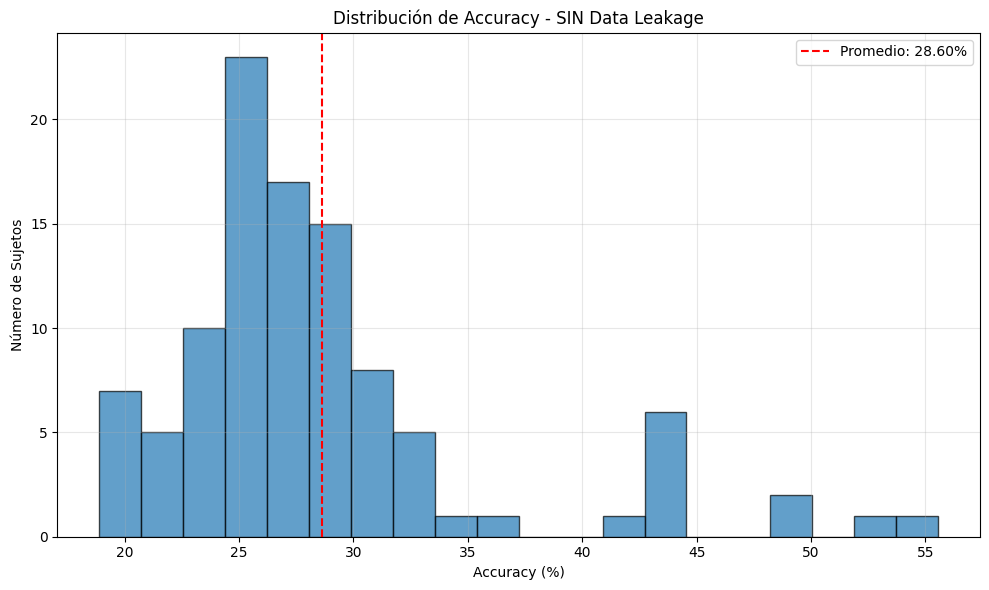

In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# -----------------------------
# Reproducibilidad y dispositivo
# -----------------------------
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------
# Dataset con augmentación on-the-fly (solo en train)
# -----------------------------
class EEGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        """
        X: tensor (N, 1, C, T)
        y: tensor (N,)
        """
        self.X = X
        self.y = y
        self.augment = augment

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx].clone()  # (1, C, T)
        if self.augment:
            if np.random.rand() < 0.7:
                if np.random.rand() < 0.4:
                    signal = self.add_gaussian_noise(signal, 0.03)
                if np.random.rand() < 0.3:
                    signal = self.channel_dropout(signal, 0.1)
                if np.random.rand() < 0.3:
                    signal = self.time_shift(signal, 20)
                if np.random.rand() < 0.3:
                    signal = self.amplitude_scale(signal, (0.8, 1.2))
        return signal, self.y[idx]

    @staticmethod
    def add_gaussian_noise(signal, noise_factor=0.03):
        # signal: (1,C,T)
        std = torch.std(signal)
        noise = torch.normal(mean=0.0, std=noise_factor * (std + 1e-8), size=signal.shape, device=signal.device)
        return signal + noise

    @staticmethod
    def channel_dropout(signal, dropout_prob=0.1):
        # signal: (1,C,T)
        C = signal.shape[1]
        n_drop = int(C * dropout_prob)
        if n_drop > 0:
            drop = torch.randperm(C)[:n_drop]
            signal[:, drop, :] = 0
        return signal

    @staticmethod
    def time_shift(signal, max_shift=20):
        # signal: (1,C,T)
        T = signal.shape[-1]
        shift = int(np.random.randint(-max_shift, max_shift))
        if shift > 0:
            pad = torch.zeros((1, signal.shape[1], shift), device=signal.device, dtype=signal.dtype)
            signal = torch.cat([pad, signal[..., :-shift]], dim=-1)
        elif shift < 0:
            pad = torch.zeros((1, signal.shape[1], -shift), device=signal.device, dtype=signal.dtype)
            signal = torch.cat([signal[..., -shift:], pad], dim=-1)
        return signal

    @staticmethod
    def amplitude_scale(signal, scale_range=(0.8, 1.2)):
        scale = float(np.random.uniform(*scale_range))
        return signal * scale

# -----------------------------
# Modelo EEGNet (forma estándar)
# -----------------------------
class EEGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160,
                 dropout_rate=0.6, F1=16, D=2, F2=32, n_times=641):
        super().__init__()

        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)),
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)

        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1),
                                   groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)

        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()

        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16),
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()

        # inferir feature size con el n_times real
        with torch.no_grad():
            sample = torch.randn(1, 1, num_channels, n_times)
            feat = self.forward_features(sample)
            self.feature_size = feat.shape[1]

        self.classifier = nn.Linear(self.feature_size, num_classes)

    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)

        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)

        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

# -----------------------------
# Utilidades
# -----------------------------
def get_balanced_sampler(y_np: np.ndarray):
    class_counts = np.bincount(y_np)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
    sample_weights = class_weights[y_np]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def find_available_subjects(data_path: Path):
    available = []
    excluded = {38, 88, 89, 92, 100, 104}

    for fif_file in data_path.glob("S*_MI-epo.fif"):
        s = fif_file.name.split('_')[0][1:]  # 'S065' -> '065'
        try:
            n = int(s)
            if n not in excluded:
                available.append(n)
        except ValueError:
            pass

    available.sort()
    print(f"Encontrados {len(available)} sujetos (excluidos: {sorted(list(excluded))})")
    return available

def analyze_performance_distribution(results):
    accuracies = [r['accuracy_mean'] for r in results]
    if not accuracies:
        return
    print("\nANÁLISIS DE DISTRIBUCIÓN")
    print(f"• Media: {np.mean(accuracies):.2f}%")
    print(f"• Mediana: {np.median(accuracies):.2f}%")
    print(f"• Rango: {np.min(accuracies):.2f}% - {np.max(accuracies):.2f}%")
    excellent = sum(acc >= 70 for acc in accuracies)
    good = sum(60 <= acc < 70 for acc in accuracies)
    fair = sum(50 <= acc < 60 for acc in accuracies)
    poor = sum(acc < 50 for acc in accuracies)
    n = len(accuracies)
    print("\nCATEGORIZACIÓN")
    print(f"• Excelente (≥70%): {excellent} ({excellent/n*100:.1f}%)")
    print(f"• Bueno (60–69%): {good} ({good/n*100:.1f}%)")
    print(f"• Regular (50–59%): {fair} ({fair/n*100:.1f}%)")
    print(f"• Pobre (<50%): {poor} ({poor/n*100:.1f}%)")

def load_single_subject(data_path: Path, subject_number: int):
    subject_id = f"S{subject_number:03d}"
    fif_files = list(data_path.glob(f"{subject_id}_MI-epo.fif"))
    if not fif_files:
        return None, None, None

    try:
        epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
        X = epochs.get_data()                # (N, C, T)
        y = epochs.events[:, -1] - 1         # 0-index
        return X, y, subject_id
    except Exception:
        return None, None, None

def prepare_single_subject_data_no_leakage(X, y):
    """
    Sin StandardScaler por trial para evitar doble normalización.
    Solo casting y reshape a (N,1,C,T).
    """
    X_tensor = torch.from_numpy(X.astype(np.float32)).unsqueeze(1)
    y_tensor = torch.from_numpy(y.astype(np.int64))
    return X_tensor, y_tensor

def normalize_by_fold(X_train, X_val, X_test):
    """
    Z-score por canal usando SOLO train.
    X_*: (B, 1, C, T)
    """
    mean = X_train.mean(dim=(0, 3), keepdim=True)        # (1,1,C,1)
    std = X_train.std(dim=(0, 3), keepdim=True) + 1e-8   # (1,1,C,1)
    X_train = (X_train - mean) / std
    X_val   = (X_val   - mean) / std
    X_test  = (X_test  - mean) / std
    return X_train, X_val, X_test

def train_test_split_indices(y_np, test_size=0.2, random_state=None):
    """
    Devuelve (train_idx, val_idx) estratificados sobre y_np.
    """
    if random_state is not None:
        rng = np.random.RandomState(random_state)
    else:
        rng = np.random

    y_np = np.asarray(y_np)
    n = len(y_np)
    val_idx = []

    for cls in np.unique(y_np):
        cls_idx = np.where(y_np == cls)[0]
        n_val = max(1, int(len(cls_idx) * test_size))
        val_idx.extend(rng.choice(cls_idx, n_val, replace=False))

    val_idx = np.array(sorted(set(val_idx)))
    train_idx = np.setdiff1d(np.arange(n), val_idx, assume_unique=True)
    return train_idx, val_idx

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# -----------------------------
# Evaluación por sujeto (sin leakage)
# -----------------------------
def evaluate_single_subject_corrected(subject_number, data_path: Path, n_splits=5, batch_size=64):
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None

    X_tensor, y_tensor = prepare_single_subject_data_no_leakage(X, y)  # (N,1,C,T)
    N, _, C, T = X_tensor.shape

    # CV estratificado
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies = []
    all_predictions = []
    all_targets = []
    fold_times = []

    criterion = nn.CrossEntropyLoss()

    # Modelo se recrea en cada fold (más limpio) o se resetea
    for fold, (tr_idx, te_idx) in enumerate(skf.split(np.zeros(N), y)):
        start_time = time.time()

        X_train, X_test = X_tensor[tr_idx], X_tensor[te_idx]
        y_train, y_test = y_tensor[tr_idx], y_tensor[te_idx]

        # Split interno train/val estratificado
        tr2_idx, val_idx = train_test_split_indices(y_train.numpy(), test_size=0.2, random_state=42)
        X_train_fold, X_val_fold = X_train[tr2_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[tr2_idx], y_train[val_idx]

        # Normalización por fold (sin leakage)
        X_train_norm, X_val_norm, X_test_norm = normalize_by_fold(X_train_fold, X_val_fold, X_test)

        # Datasets
        train_ds = EEGDataset(X_train_norm, y_train_fold, augment=True)
        val_ds   = EEGDataset(X_val_norm,   y_val_fold,   augment=False)
        test_ds  = EEGDataset(X_test_norm,  y_test,       augment=False)

        # Loaders
        sampler = get_balanced_sampler(y_train_fold.numpy())
        pin_mem = (DEVICE.type == 'cuda')
        train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler,
                                  num_workers=2, pin_memory=pin_mem)
        val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                                num_workers=2, pin_memory=pin_mem)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                                 num_workers=2, pin_memory=pin_mem)

        # Modelo y optimizador
        model = EEGNet(num_channels=C, num_classes=len(np.unique(y)),
                       sampling_rate=160, dropout_rate=0.6, F1=16, D=2, F2=32, n_times=T).to(DEVICE)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)

        # Early stopping con mejor estado
        best_val_acc = 0.0
        best_state = None
        patience = 20
        counter = 0
        max_epochs = 100

        for epoch in range(max_epochs):
            # ---- Train ----
            model.train()
            for bx, by in train_loader:
                bx = bx.to(DEVICE, non_blocking=True)
                by = by.to(DEVICE, non_blocking=True)
                optimizer.zero_grad()
                out = model(bx)
                loss = criterion(out, by)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

            # ---- Val ----
            model.eval()
            val_correct = 0
            val_total = 0
            with torch.no_grad():
                for bx, by in val_loader:
                    bx = bx.to(DEVICE, non_blocking=True)
                    by = by.to(DEVICE, non_blocking=True)
                    out = model(bx)
                    pred = out.argmax(dim=1)
                    val_total += by.size(0)
                    val_correct += (pred == by).sum().item()
            val_acc = 100.0 * val_correct / max(1, val_total)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
                counter = 0
            else:
                counter += 1

            if counter >= patience and epoch >= 30:
                break

        # Restaurar mejor estado antes de test
        if best_state is not None:
            model.load_state_dict(best_state)
        model.eval()

        # ---- Test ----
        test_correct = 0
        test_total = 0
        preds_fold = []
        targs_fold = []
        with torch.no_grad():
            for bx, by in test_loader:
                bx = bx.to(DEVICE, non_blocking=True)
                by = by.to(DEVICE, non_blocking=True)
                out = model(bx)
                pred = out.argmax(dim=1)
                test_total += by.size(0)
                test_correct += (pred == by).sum().item()
                preds_fold.extend(pred.cpu().numpy())
                targs_fold.extend(by.cpu().numpy())

        fold_acc = 100.0 * test_correct / max(1, test_total)
        fold_accuracies.append(fold_acc)
        all_predictions.extend(preds_fold)
        all_targets.extend(targs_fold)
        fold_times.append(time.time() - start_time)

    # Métricas finales del sujeto
    accuracy = float(np.mean(fold_accuracies)) if fold_accuracies else 0.0
    accuracy_std = float(np.std(fold_accuracies)) if fold_accuracies else 0.0
    kappa = float(cohen_kappa_score(all_targets, all_predictions)) if all_targets else 0.0
    avg_time = float(np.mean(fold_times)) if fold_times else 0.0

    # Accuracy por clase
    class_accuracies = []
    all_preds_np = np.array(all_predictions)
    all_targs_np = np.array(all_targets)
    for cls in np.unique(all_targs_np):
        mask = (all_targs_np == cls)
        cls_acc = (all_preds_np[mask] == all_targs_np[mask]).mean() * 100.0 if mask.any() else 0.0
        class_accuracies.append(cls_acc)

    class_distribution = np.bincount(y)

    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'avg_time_per_fold': avg_time,
        'original_trials': len(y),
        'augmented_trials': len(y),  # augment solo en train on-the-fly
        'class_distribution': class_distribution,
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
        'all_predictions': all_predictions,
        'all_targets': all_targets
    }

# -----------------------------
# Main
# -----------------------------
def main():
    set_seeds(42)
    print("✅ Semillas configuradas. Dispositivo:", DEVICE)

    # Paths
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'

    print("Buscando sujetos...")
    available_subjects = find_available_subjects(DATA_PROC)

    results = []
    failed = []

    print("\n" + "="*60)
    print("EVALUANDO TODOS LOS SUJETOS (SIN DATA LEAKAGE)")
    print("="*60)
    print("✅ Augmentación: SOLO durante entrenamiento")
    print("✅ Normalización: Por fold, usando SOLO train")
    print("✅ Balanceo: WeightedRandomSampler")

    for s in tqdm(available_subjects, desc="Procesando sujetos"):
        try:
            r = evaluate_single_subject_corrected(s, DATA_PROC, n_splits=5, batch_size=64)
            if r is not None:
                results.append(r)
                print(f"✅ {r['subject_id']}: {r['accuracy_mean']:.2f}%")
            else:
                failed.append(s)
                print(f"❌ S{s:03d}: Error en carga")
        except Exception as e:
            failed.append(s)
            print(f"❌ S{s:03d}: {e}")

    if not results:
        print("No se pudieron procesar sujetos.")
        return

    # Análisis & guardado
    analyze_performance_distribution(results)

    csv_rows = []
    for r in results:
        row = {
            'subject_id': r['subject_id'],
            'accuracy_mean': r['accuracy_mean'],
            'accuracy_std': r['accuracy_std'],
            'kappa': r['kappa'],
            'avg_time_fold_seconds': r['avg_time_per_fold'],
            'original_trials': r['original_trials'],
            'augmented_trials': r['augmented_trials'],
            'class_0_accuracy': r['class_accuracies'][0] if len(r['class_accuracies']) > 0 else None,
            'class_1_accuracy': r['class_accuracies'][1] if len(r['class_accuracies']) > 1 else None,
            'class_2_accuracy': r['class_accuracies'][2] if len(r['class_accuracies']) > 2 else None,
            'class_3_accuracy': r['class_accuracies'][3] if len(r['class_accuracies']) > 3 else None,
            'class_0_trials': r['class_distribution'][0] if len(r['class_distribution']) > 0 else None,
            'class_1_trials': r['class_distribution'][1] if len(r['class_distribution']) > 1 else None,
            'class_2_trials': r['class_distribution'][2] if len(r['class_distribution']) > 2 else None,
            'class_3_trials': r['class_distribution'][3] if len(r['class_distribution']) > 3 else None,
            'fold_1_accuracy': r['fold_accuracies'][0] if len(r['fold_accuracies']) > 0 else None,
            'fold_2_accuracy': r['fold_accuracies'][1] if len(r['fold_accuracies']) > 1 else None,
            'fold_3_accuracy': r['fold_accuracies'][2] if len(r['fold_accuracies']) > 2 else None,
            'fold_4_accuracy': r['fold_accuracies'][3] if len(r['fold_accuracies']) > 3 else None,
            'fold_5_accuracy': r['fold_accuracies'][4] if len(r['fold_accuracies']) > 4 else None
        }
        csv_rows.append(row)

    df = pd.DataFrame(csv_rows)
    global_stats = {
        'subject_id': 'GLOBAL_AVG',
        'accuracy_mean': df['accuracy_mean'].mean(),
        'accuracy_std': df['accuracy_mean'].std(),
        'kappa': df['kappa'].mean(),
        'avg_time_fold_seconds': df['avg_time_fold_seconds'].mean(),
        'original_trials': df['original_trials'].mean(),
        'augmented_trials': df['augmented_trials'].mean(),
        'class_0_accuracy': df['class_0_accuracy'].mean(),
        'class_1_accuracy': df['class_1_accuracy'].mean(),
        'class_2_accuracy': df['class_2_accuracy'].mean(),
        'class_3_accuracy': df['class_3_accuracy'].mean(),
        'class_0_trials': df['class_0_trials'].mean(),
        'class_1_trials': df['class_1_trials'].mean(),
        'class_2_trials': df['class_2_trials'].mean(),
        'class_3_trials': df['class_3_trials'].mean()
    }
    df = pd.concat([df, pd.DataFrame([global_stats])], ignore_index=True)

    ts = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_results_no_leakage_{ts}.csv"
    txt_filename = f"eegnet_summary_no_leakage_{ts}.txt"

    df.to_csv(csv_filename, index=False)

    with open(txt_filename, 'w') as f:
        f.write("="*60 + "\n")
        f.write("RESUMEN EEGNet - SIN DATA LEAKAGE\n")
        f.write("="*60 + "\n\n")
        f.write(f"Total sujetos procesados: {len(results)}\n")
        f.write(f"Sujetos fallados: {len(failed)}\n")
        if failed:
            f.write(f"Sujetos fallados: {failed}\n")
        f.write("\nMEJORAS IMPLEMENTADAS:\n")
        f.write("• Augmentación solo en entrenamiento (on-the-fly)\n")
        f.write("• Normalización por fold (solo con train)\n")
        f.write("• Early stopping con mejor estado\n")
        f.write("\nESTADÍSTICAS GLOBALES:\n")
        f.write(f"Accuracy promedio: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%\n")
        f.write(f"Kappa promedio: {global_stats['kappa']:.4f}\n")
        f.write(f"Tiempo promedio por fold: {global_stats['avg_time_fold_seconds']:.1f} s\n")

    print("\n" + "="*60)
    print("RESUMEN FINAL - SIN DATA LEAKAGE")
    print("="*60)
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed)}")
    print(f"📊 Accuracy global: {global_stats['accuracy_mean']:.2f}% ± {global_stats['accuracy_std']:.2f}%")
    print(f"🎯 Kappa global: {global_stats['kappa']:.4f}")
    print(f"⏱️  Tiempo promedio: {global_stats['avg_time_fold_seconds']:.1f}s por fold")
    print("\n📁 Archivos guardados:")
    print(f"   • CSV completo: {csv_filename}")
    print(f"   • Resumen TXT: {txt_filename}")

    # Histograma de accuracies
    plt.figure(figsize=(10, 6))
    accs = [r['accuracy_mean'] for r in results]
    plt.hist(accs, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(np.mean(accs), color='red', linestyle='--', label=f'Promedio: {np.mean(accs):.2f}%')
    plt.xlabel('Accuracy (%)')
    plt.ylabel('Número de Sujetos')
    plt.title('Distribución de Accuracy - SIN Data Leakage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'accuracy_distribution_no_leakage_{ts}.png', dpi=300)
    plt.show()

if __name__ == "__main__":
    main()


In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =========================
# Config global
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

SAMPLING_RATE = 160               # Hz (tus epochs son 0.5–4.5s a 160 Hz)
CROP_SEC = 3.0                    # ventana temporal para el modelo (train/val/test)
TARGET_T = int(CROP_SEC * SAMPLING_RATE)  # 480 muestras

def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# Utils de recorte temporal
# =========================
def center_crop_time(x: torch.Tensor, target_t: int) -> torch.Tensor:
    """
    x: (1, C, T) o (N,1,C,T)
    devuelve recorte centrado a target_t (si T>target), o el mismo si T==target.
    Si T<target, hace pad reflect (raro en tu setup).
    """
    if x.dim() == 3:
        _, _, T = x.shape
    else:
        _, _, _, T = x.shape
    if T == target_t:
        return x
    if T > target_t:
        start = (T - target_t) // 2
        end = start + target_t
        if x.dim() == 3:
            return x[..., start:end]
        else:
            return x[..., start:end]
    # padding si hiciera falta (no debería)
    pad_total = target_t - T
    left = pad_total // 2
    right = pad_total - left
    if x.dim() == 3:
        return torch.pad(x, (left, right), mode='reflect')
    else:
        return torch.pad(x, (left, right), mode='reflect')

def random_crop_time(x: torch.Tensor, target_t: int) -> torch.Tensor:
    """Recorte aleatorio en tiempo (x: (1,C,T)). Si T==target -> devuelve igual."""
    _, _, T = x.shape
    if T <= target_t:
        return center_crop_time(x, target_t)
    start = np.random.randint(0, T - target_t + 1)
    end = start + target_t
    return x[..., start:end]

# =========================
# Dataset
# =========================
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False, crop_mode='random'):
        """
        X: torch.FloatTensor (N, 1, C, Tfull)
        y: torch.LongTensor (N,)
        augment: bool -> ruido/escala + crop aleatorio
        crop_mode: 'random' (train) | 'center' (val/test)
        """
        self.X = X
        self.y = y
        self.augment = augment
        self.crop_mode = crop_mode

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        signal = self.X[idx].clone()  # (1, C, T)

        # --- crop temporal ---
        if self.crop_mode == 'random':
            signal = random_crop_time(signal, TARGET_T)
        else:
            signal = center_crop_time(signal, TARGET_T)

        # --- augment suave (prob 0.3) ---
        if self.augment and np.random.random() < 0.3:
            if np.random.random() < 0.5:
                # Ruido gaussiano proporcional al std del trial
                std = signal.std()
                noise = torch.normal(0, 0.02 * std, size=signal.shape, device=signal.device)
                signal = signal + noise
            else:
                # Escalado global suave
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale

        return signal, self.y[idx]

# =========================
# EEGNet (config estable)
# =========================
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160,
                 dropout_rate=0.3, F1=48, D=2, F2=96, input_time_length=None):
        super().__init__()
        # Bloque 1
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)),
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)

        # Depthwise separable spatial
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1),
                                   groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)

        # Bloque 2
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()

        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16),
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()

        # Calcular tamaño automáticamente
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = TARGET_T
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]

        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        x = self.conv1(x); x = self.batchnorm1(x)
        x = self.depthwise(x); x = self.batchnorm2(x); x = self.activation1(x)
        x = self.pooling1(x); x = self.dropout1(x)
        x = self.pointwise1(x); x = self.batchnorm3(x); x = self.activation2(x)
        x = self.conv2(x); x = self.pointwise2(x); x = self.batchnorm4(x); x = self.activation3(x)
        x = self.pooling2(x); x = self.dropout2(x)
        x = self.flatten(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

# =========================
# Carga, normalización y utils
# =========================
def get_balanced_sampler(y):
    cls_counts = np.bincount(y)
    cls_w = 1. / torch.tensor(cls_counts, dtype=torch.float)
    w = cls_w[y]
    return WeightedRandomSampler(w, len(w), replacement=True)

def find_available_subjects(data_path: Path):
    available = []
    excluded = {38, 88, 89, 92, 100, 104}
    for fif_file in data_path.glob("S*_MI-epo.fif"):
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            sid = int(subject_str)
            if sid not in excluded:
                available.append(sid)
        except:
            pass
    available.sort()
    print(f"Encontrados {len(available)} sujetos después de exclusiones")
    return available

def load_single_subject(data_path: Path, subject_number: int):
    subject_id = f"S{subject_number:03d}"
    fif = list(data_path.glob(f"{subject_id}_MI-epo.fif"))
    if not fif:
        return None, None, None
    try:
        epochs = mne.read_epochs(fif[0], verbose=False, preload=True)
        X = epochs.get_data()            # (N, C, T) en VOLTS
        y = epochs.events[:, -1] - 1     # etiquetas 0..3
        return X, y, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

def prepare_single_subject_data(X, y):
    # Solo tensor + canal "imagen"
    X_tensor = torch.FloatTensor(X).unsqueeze(1)  # (N,1,C,T)
    y_tensor = torch.LongTensor(y)
    print(f"📈 Datos: {X_tensor.shape}, rango [{X_tensor.min():.2e}, {X_tensor.max():.2e}] V")
    return X_tensor, y_tensor

def normalize_proper(X_train, X_val, X_test):
    """
    Normalización por canal: mean/std calculadas SOLO en train,
    promediando sobre batch y tiempo → (1,1,C,1) tensores.
    """
    eps = 1e-8
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    X_train = (X_train - mean) / std
    X_val   = (X_val   - mean) / std
    X_test  = (X_test  - mean) / std
    return X_train, X_val, X_test

def train_val_split_indices(n, val_size=0.2, seed=42):
    rng = np.random.RandomState(seed)
    idx = np.arange(n)
    rng.shuffle(idx)
    split = int(n * (1 - val_size))
    return idx[:split], idx[split:]

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# =========================
# Loop de entrenamiento
# =========================
def validate_model(model, val_loader):
    model.eval()
    tot, correct = 0, 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            out = model(Xb)
            pred = out.argmax(1)
            tot += yb.size(0)
            correct += (pred == yb).sum().item()
    return 100.0 * correct / tot

def evaluate_model(model, test_loader):
    model.eval()
    tot, correct = 0, 0
    preds, tgts = [], []
    with torch.no_grad():
        for Xb, yb in test_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            out = model(Xb)
            pred = out.argmax(1)
            tot += yb.size(0)
            correct += (pred == yb).sum().item()
            preds.extend(pred.cpu().numpy())
            tgts.extend(yb.cpu().numpy())
    return 100.0 * correct / tot, preds, tgts

def train_model_with_saving(model, train_loader, val_loader, criterion, optimizer, scheduler,
                            epochs=150, patience=25):
    model.to(DEVICE)
    best_val, best_state, bad_epochs = 0.0, None, 0
    for ep in range(1, epochs + 1):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        scheduler.step()

        val_acc = validate_model(model, val_loader)
        if val_acc > best_val:
            best_val = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
            print(f"    💾 Nuevo mejor modelo: {val_acc:.2f}%")
        else:
            bad_epochs += 1

        if bad_epochs >= patience and ep > 50:
            print(f"    ⏹️  Early stopping en época {ep}")
            break

    return best_state, best_val

# =========================
# Evaluación por sujeto
# =========================
def evaluate_single_subject(subject_number, data_path: Path, n_splits=5):
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None or len(X) == 0:
        return None

    print(f"\n🔍 Procesando {subject_id}: {X.shape}")
    X_tensor, y_tensor = prepare_single_subject_data(X, y)

    # Modelo con tiempo objetivo = TARGET_T
    model = EEGNetStable(
        num_channels=X_tensor.shape[2],
        num_classes=len(np.unique(y)),
        sampling_rate=SAMPLING_RATE,
        dropout_rate=0.3,
        F1=48, D=2, F2=96,
        input_time_length=TARGET_T
    ).to(DEVICE)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies, all_preds, all_tgts = [], [], []
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # smoothing leve

    for fold, (tr_idx, te_idx) in enumerate(skf.split(X_tensor, y_tensor), 1):
        print(f"  📁 Fold {fold}/{n_splits}")

        X_train, X_test = X_tensor[tr_idx], X_tensor[te_idx]
        y_train, y_test = y_tensor[tr_idx], y_tensor[te_idx]

        tr_in, va_in = train_val_split_indices(len(X_train), val_size=0.2, seed=42)
        X_tr, X_va = X_train[tr_in], X_train[va_in]
        y_tr, y_va = y_train[tr_in], y_train[va_in]

        # Normalización por canal (stats del train)
        X_tr_n, X_va_n, X_te_n = normalize_proper(X_tr, X_va, X_test)

        # Datasets con crop:
        #  - train: random crop + augment
        #  - val/test: center crop, sin augment
        train_ds = EEGDatasetSimple(X_tr_n, y_tr, augment=True, crop_mode='random')
        val_ds   = EEGDatasetSimple(X_va_n, y_va, augment=False, crop_mode='center')
        test_ds  = EEGDatasetSimple(X_te_n, y_test, augment=False, crop_mode='center')

        # DataLoaders (balanceado en train)
        train_sampler = get_balanced_sampler(y_tr.numpy())
        train_loader = DataLoader(train_ds, batch_size=32, sampler=train_sampler, drop_last=False)
        val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, drop_last=False)
        test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, drop_last=False)

        # Reset pesos y optim
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=120)

        best_state, best_val = train_model_with_saving(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            epochs=150, patience=25
        )
        if best_state is not None:
            model.load_state_dict(best_state)

        test_acc, fold_preds, fold_tgts = evaluate_model(model, test_loader)
        fold_accuracies.append(test_acc)
        all_preds.extend(fold_preds)
        all_tgts.extend(fold_tgts)
        print(f"    ✅ Fold {fold} - Test: {test_acc:.2f}%")

    if not fold_accuracies:
        return None

    acc = float(np.mean(fold_accuracies))
    acc_std = float(np.std(fold_accuracies))
    kappa = float(cohen_kappa_score(all_tgts, all_preds))

    # Acc por clase
    class_accuracies = []
    classes = np.unique(all_tgts)
    ap = np.array(all_preds); at = np.array(all_tgts)
    for c in classes:
        m = (at == c)
        class_accuracies.append(100.0 * (ap[m] == at[m]).mean() if m.any() else 0.0)

    return {
        'subject_id': subject_id,
        'accuracy_mean': acc,
        'accuracy_std': acc_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# Main
# =========================
def main():
    set_seeds(42)
    print("🎯 EEGNet - Perfil estable + capacidad moderada + crop temporal")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'

    subjects = find_available_subjects(DATA_PROC)
    results, failed = [], []

    for sid in tqdm(subjects, desc="Procesando sujetos"):
        try:
            r = evaluate_single_subject(sid, DATA_PROC, n_splits=5)
            if r is not None:
                results.append(r)
                print(f"✅ {r['subject_id']}: {r['accuracy_mean']:.2f}%")
            else:
                failed.append(sid)
                print(f"❌ S{sid:03d}: Error en procesamiento")
        except Exception as e:
            failed.append(sid)
            print(f"❌ S{sid:03d}: {e}")

    if not results:
        print("No se pudieron procesar sujetos")
        return

    # Agregados
    accs = [r['accuracy_mean'] for r in results]
    mean_acc, std_acc = float(np.mean(accs)), float(np.std(accs))
    mean_kappa = float(np.mean([r['kappa'] for r in results]))

    print("\n" + "="*60)
    print("RESULTADOS FINALES - Perfil estable (capacidad+crop)")
    print("="*60)
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {mean_kappa:.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed)}")

    # Guardar CSV
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_estable_crop_results_{timestamp}.csv"
    rows = []
    for r in results:
        row = {
            'subject_id': r['subject_id'],
            'accuracy_mean': r['accuracy_mean'],
            'accuracy_std': r['accuracy_std'],
            'kappa': r['kappa'],
            'original_trials': r['original_trials'],
        }
        # si hay 4 clases, guarda por clase
        for i, v in enumerate(r['class_accuracies']):
            row[f'class_{i}_acc'] = v
        rows.append(row)
    pd.DataFrame(rows).to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

if __name__ == "__main__":
    main()


🚀 Usando dispositivo: cuda
🎯 EEGNet - Perfil estable + capacidad moderada + crop temporal
Encontrados 103 sujetos después de exclusiones


Procesando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]


🔍 Procesando S001: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-6.85e-05, 6.65e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    💾 Nuevo mejor modelo: 80.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 69
    ✅ Fold 3 - Test: 61.11%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00

Procesando sujetos:   1%|          | 1/103 [00:02<03:35,  2.11s/it]

    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 63
    ✅ Fold 5 - Test: 50.00%
✅ S001: 53.33%

🔍 Procesando S002: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.03e-04, 1.36e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en épo

Procesando sujetos:   2%|▏         | 2/103 [00:04<03:46,  2.24s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 53
    ✅ Fold 5 - Test: 50.00%
✅ S002: 50.00%

🔍 Procesando S003: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-6.69e-05, 6.18e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 16.67%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 69
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 38.89%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 27.78%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nue

Procesando sujetos:   3%|▎         | 3/103 [00:06<03:40,  2.21s/it]

    ⏹️  Early stopping en época 80
    ✅ Fold 5 - Test: 27.78%
✅ S003: 33.33%

🔍 Procesando S004: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-4.11e-05, 4.35e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 60
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor m

Procesando sujetos:   4%|▍         | 4/103 [00:08<03:39,  2.21s/it]

    ⏹️  Early stopping en época 87
    ✅ Fold 5 - Test: 62.50%
✅ S004: 48.97%

🔍 Procesando S005: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.27e-04, 1.23e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 70
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor m

Procesando sujetos:   5%|▍         | 5/103 [00:11<03:36,  2.21s/it]

    ⏹️  Early stopping en época 62
    ✅ Fold 5 - Test: 25.00%
✅ S005: 26.18%

🔍 Procesando S006: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-5.43e-05, 5.26e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 66
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 17.65%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 21.43%


Procesando sujetos:   6%|▌         | 6/103 [00:12<03:25,  2.11s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 12.50%
✅ S006: 18.97%

🔍 Procesando S007: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-5.56e-05, 5.72e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 69
    ✅ Fold 1 - Test: 72.22%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    💾 Nuevo mejor modelo: 80.00%
    💾 Nuevo mejor modelo: 86.67%
    ⏹️  Early stopping en época 73
    ✅ Fold 3 - Test: 66.67%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor m

Procesando sujetos:   7%|▋         | 7/103 [00:15<03:27,  2.16s/it]

    ⏹️  Early stopping en época 55
    ✅ Fold 5 - Test: 61.11%
✅ S007: 63.33%

🔍 Procesando S008: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-4.66e-05, 4.54e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor m

Procesando sujetos:   8%|▊         | 8/103 [00:17<03:15,  2.06s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 37.50%
✅ S008: 39.26%

🔍 Procesando S009: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.12e-04, 1.28e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 56
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 64
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%


Procesando sujetos:   9%|▊         | 9/103 [00:19<03:10,  2.03s/it]

    ⏹️  Early stopping en época 54
    ✅ Fold 5 - Test: 18.75%
✅ S009: 31.99%

🔍 Procesando S010: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-7.85e-05, 6.56e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en época 60
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor m

Procesando sujetos:  10%|▉         | 10/103 [00:20<03:04,  1.99s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S010: 36.76%

🔍 Procesando S011: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.88e-05, 2.12e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%


Procesando sujetos:  11%|█         | 11/103 [00:22<02:58,  1.94s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 18.75%
✅ S011: 29.63%

🔍 Procesando S012: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-4.50e-05, 3.63e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 54
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 106
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 63
    ✅ Fold 3 - Test: 35.29

Procesando sujetos:  12%|█▏        | 12/103 [00:25<03:11,  2.10s/it]

    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 73
    ✅ Fold 5 - Test: 62.50%
✅ S012: 45.44%

🔍 Procesando S013: (82, 8, 641)
📈 Datos: torch.Size([82, 1, 8, 641]), rango [-1.37e-04, 1.50e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 23.08%
    💾 Nuevo mejor modelo: 30.77%
    💾 Nuevo mejor modelo: 38.46%
    💾 Nuevo mejor modelo: 46.15%
    💾 Nuevo mejor modelo: 53.85%
    ⏹️  Early stopping en época 70
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 30.77%
    💾 Nuevo mejor modelo: 38.46%
    💾 Nuevo mejor modelo: 53.85%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 25.00%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 66
    ✅ Fold 4 - Test: 25.00%
  📁 Fold 5/5
    💾 Nue

Procesando sujetos:  13%|█▎        | 13/103 [00:27<03:08,  2.09s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S013: 27.94%

🔍 Procesando S014: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-4.91e-05, 5.09e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%


Procesando sujetos:  14%|█▎        | 14/103 [00:29<02:59,  2.01s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 12.50%
✅ S014: 28.38%

🔍 Procesando S015: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-9.01e-05, 7.29e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 95
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor m

Procesando sujetos:  15%|█▍        | 15/103 [00:31<03:06,  2.12s/it]

    ⏹️  Early stopping en época 84
    ✅ Fold 5 - Test: 56.25%
✅ S015: 45.37%

🔍 Procesando S016: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-6.76e-05, 8.34e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 58
    ✅ Fold 4 - Test: 11.76%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nue

Procesando sujetos:  16%|█▌        | 16/103 [00:33<03:00,  2.07s/it]

    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 64
    ✅ Fold 5 - Test: 12.50%
✅ S016: 18.97%

🔍 Procesando S017: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.24e-04, 1.30e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 52
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 5.88%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuev

Procesando sujetos:  17%|█▋        | 17/103 [00:35<02:52,  2.00s/it]

    ⏹️  Early stopping en época 52
    ✅ Fold 5 - Test: 37.50%
✅ S017: 29.85%

🔍 Procesando S018: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.50e-05, 1.45e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 11.76%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 35.29%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%


Procesando sujetos:  17%|█▋        | 18/103 [00:37<02:45,  1.95s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 31.25%
✅ S018: 27.43%

🔍 Procesando S019: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-8.35e-05, 8.98e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 69
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor m

Procesando sujetos:  18%|█▊        | 19/103 [00:39<02:48,  2.00s/it]

    ⏹️  Early stopping en época 74
    ✅ Fold 5 - Test: 68.75%
✅ S019: 50.22%

🔍 Procesando S020: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.68e-05, 1.73e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 35.29%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 35.71%


Procesando sujetos:  19%|█▉        | 20/103 [00:41<02:41,  1.95s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S020: 29.71%

🔍 Procesando S021: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-4.75e-05, 4.20e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 16.67%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 58
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 22.22%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 33.33%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 40.00%


Procesando sujetos:  20%|██        | 21/103 [00:42<02:38,  1.93s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 27.78%
✅ S021: 26.67%

🔍 Procesando S022: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-8.73e-05, 9.61e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 65
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 11.11%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 68
    ✅ Fold 4 - Test: 38.89%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nue

Procesando sujetos:  21%|██▏       | 22/103 [00:45<02:47,  2.07s/it]

    ⏹️  Early stopping en época 99
    ✅ Fold 5 - Test: 38.89%
✅ S022: 34.44%

🔍 Procesando S023: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.51e-04, 1.25e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 61
    ✅ Fold 3 - Test: 11.76%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 93
    ✅ Fold 4 - Test: 41.18%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%


Procesando sujetos:  22%|██▏       | 23/103 [00:47<02:48,  2.11s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S023: 26.18%

🔍 Procesando S024: (70, 8, 641)
📈 Datos: torch.Size([70, 1, 8, 641]), rango [-1.53e-04, 1.71e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 25.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 41.67%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 58.33%
    💾 Nuevo mejor modelo: 75.00%
    ⏹️  Early stopping en época 61
    ✅ Fold 1 - Test: 28.57%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 25.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 41.67%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 58.33%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 75.00%
    ⏹️  Early stopping en época 61
    ✅ Fold 2 - Test: 42.86%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 41.67%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 58.33%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 74
    ✅ Fold 3 - Test: 42.86%
  📁 Fold 4/5
    💾 Nuevo mejor m

Procesando sujetos:  23%|██▎       | 24/103 [00:49<02:46,  2.10s/it]

    ⏹️  Early stopping en época 53
    ✅ Fold 5 - Test: 42.86%
✅ S024: 37.14%

🔍 Procesando S025: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-2.75e-05, 2.45e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    ⏹️  Early stopping en época 66
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.

Procesando sujetos:  24%|██▍       | 25/103 [00:51<02:40,  2.06s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    ✅ Fold 5 - Test: 37.50%
✅ S025: 48.68%

🔍 Procesando S026: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-5.11e-05, 3.91e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 62
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor mo

Procesando sujetos:  25%|██▌       | 26/103 [00:53<02:36,  2.04s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 62
    ✅ Fold 5 - Test: 43.75%
✅ S026: 42.87%

🔍 Procesando S027: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.14e-04, 1.06e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 41.18%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nue

Procesando sujetos:  26%|██▌       | 27/103 [00:55<02:30,  1.97s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S027: 30.88%

🔍 Procesando S028: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.10e-04, 1.06e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 90
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 52
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor m

Procesando sujetos:  27%|██▋       | 28/103 [00:57<02:34,  2.06s/it]

    ⏹️  Early stopping en época 75
    ✅ Fold 5 - Test: 37.50%
✅ S028: 26.32%

🔍 Procesando S029: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-4.57e-05, 3.68e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 88.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    💾 Nuevo mejor modelo: 80.00%
    💾 Nuevo mejor modelo: 86.67%
    ⏹️  Early stopping en época 82
    ✅ Fold 2 - Test: 83.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.

Procesando sujetos:  28%|██▊       | 29/103 [01:00<02:38,  2.15s/it]

    ⏹️  Early stopping en época 70
    ✅ Fold 5 - Test: 72.22%
✅ S029: 78.89%

🔍 Procesando S030: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-2.46e-05, 3.32e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 54
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 55.56%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopp

Procesando sujetos:  29%|██▉       | 30/103 [01:01<02:31,  2.07s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 27.78%
✅ S030: 41.11%

🔍 Procesando S031: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-6.62e-05, 7.56e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 68
    ✅ Fold 3 - Test: 64.71%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor m

Procesando sujetos:  30%|███       | 31/103 [01:04<02:30,  2.09s/it]

    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 54
    ✅ Fold 5 - Test: 43.75%
✅ S031: 51.10%

🔍 Procesando S032: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-1.25e-04, 1.24e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 80
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 59
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.6

Procesando sujetos:  31%|███       | 32/103 [01:06<02:37,  2.21s/it]

    ⏹️  Early stopping en época 90
    ✅ Fold 5 - Test: 50.00%
✅ S032: 42.22%

🔍 Procesando S033: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-6.14e-05, 4.62e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 55
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor m

Procesando sujetos:  32%|███▏      | 33/103 [01:08<02:32,  2.17s/it]

    ⏹️  Early stopping en época 58
    ✅ Fold 5 - Test: 56.25%
✅ S033: 45.37%

🔍 Procesando S034: (85, 8, 641)
📈 Datos: torch.Size([85, 1, 8, 641]), rango [-5.25e-05, 4.97e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 66
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 62
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor m

Procesando sujetos:  33%|███▎      | 34/103 [01:10<02:31,  2.19s/it]

    ⏹️  Early stopping en época 71
    ✅ Fold 5 - Test: 58.82%
✅ S034: 56.47%

🔍 Procesando S035: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-3.89e-05, 3.74e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 59
    ✅ Fold 3 - Test: 50.00%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor mo

Procesando sujetos:  34%|███▍      | 35/103 [01:12<02:25,  2.14s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 50.00%
✅ S035: 47.78%

🔍 Procesando S036: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.02e-04, 8.52e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 35.71%


Procesando sujetos:  35%|███▍      | 36/103 [01:14<02:16,  2.04s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S036: 26.18%

🔍 Procesando S037: (85, 8, 641)
📈 Datos: torch.Size([85, 1, 8, 641]), rango [-1.81e-05, 2.08e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 56
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 14.29%


Procesando sujetos:  36%|███▌      | 37/103 [01:16<02:11,  1.99s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 23.53%
✅ S037: 22.35%

🔍 Procesando S039: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.30e-04, 1.31e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 62
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 35.71%


Procesando sujetos:  37%|███▋      | 38/103 [01:18<02:07,  1.96s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S039: 29.71%

🔍 Procesando S040: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.18e-04, 8.83e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 67
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 17.65%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 35.71%


Procesando sujetos:  38%|███▊      | 39/103 [01:20<02:05,  1.95s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S040: 21.47%

🔍 Procesando S041: (88, 8, 641)
📈 Datos: torch.Size([88, 1, 8, 641]), rango [-2.34e-05, 1.71e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 89
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 22.22%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopp

Procesando sujetos:  39%|███▉      | 40/103 [01:22<02:09,  2.06s/it]

    ⏹️  Early stopping en época 72
    ✅ Fold 5 - Test: 47.06%
✅ S041: 36.47%

🔍 Procesando S042: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-3.04e-05, 3.10e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 70.59%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 93
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.

Procesando sujetos:  40%|███▉      | 41/103 [01:25<02:13,  2.15s/it]

    ⏹️  Early stopping en época 62
    ✅ Fold 5 - Test: 68.75%
✅ S042: 71.40%

🔍 Procesando S043: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-9.02e-05, 9.36e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 88
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 82
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en épo

Procesando sujetos:  41%|████      | 42/103 [01:27<02:17,  2.25s/it]

    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 57
    ✅ Fold 5 - Test: 50.00%
✅ S043: 51.18%

🔍 Procesando S044: (83, 8, 641)
📈 Datos: torch.Size([83, 1, 8, 641]), rango [-1.51e-04, 1.22e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 53
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 25.00%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nue

Procesando sujetos:  42%|████▏     | 43/103 [01:29<02:07,  2.12s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 43.75%
✅ S044: 30.22%

🔍 Procesando S045: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.05e-04, 9.90e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 66
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor m

Procesando sujetos:  43%|████▎     | 44/103 [01:31<02:05,  2.13s/it]

    ⏹️  Early stopping en época 71
    ✅ Fold 5 - Test: 37.50%
✅ S045: 42.79%

🔍 Procesando S046: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-5.20e-05, 4.72e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 58
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 60
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 76
    ✅ Fold 3 - Test: 16.67%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor m

Procesando sujetos:  44%|████▎     | 45/103 [01:33<02:03,  2.13s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 38.89%
✅ S046: 31.11%

🔍 Procesando S047: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-4.01e-05, 4.37e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 63
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 17.65%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%


Procesando sujetos:  45%|████▍     | 46/103 [01:35<01:57,  2.06s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 31.25%
✅ S047: 23.90%

🔍 Procesando S048: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.70e-04, 1.51e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 66
    ✅ Fold 4 - Te

Procesando sujetos:  46%|████▌     | 47/103 [01:37<01:53,  2.02s/it]

    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 53
    ✅ Fold 5 - Test: 56.25%
✅ S048: 47.72%

🔍 Procesando S049: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-8.97e-05, 9.04e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 79
    ✅ Fold 1 - Test: 70.59%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 64
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en épo

Procesando sujetos:  47%|████▋     | 48/103 [01:39<01:55,  2.09s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 37.50%
✅ S049: 45.15%

🔍 Procesando S050: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-3.09e-05, 4.00e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Te

Procesando sujetos:  48%|████▊     | 49/103 [01:41<01:49,  2.04s/it]

    ⏹️  Early stopping en época 63
    ✅ Fold 5 - Test: 50.00%
✅ S050: 39.41%

🔍 Procesando S051: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-3.52e-05, 3.16e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 27.78%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 27.78%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 54
    ✅ Fold 3 - Test: 22.22%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 52
    ✅ Fold 4 - Test: 27.78%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 33.33%


Procesando sujetos:  49%|████▊     | 50/103 [01:43<01:45,  1.98s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 27.78%
✅ S051: 26.67%

🔍 Procesando S052: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.36e-04, 1.21e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 55
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 99
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 58.82%

Procesando sujetos:  50%|████▉     | 51/103 [01:45<01:46,  2.04s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 12.50%
✅ S052: 35.44%

🔍 Procesando S053: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.15e-04, 1.05e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 72
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 17.65%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nue

Procesando sujetos:  50%|█████     | 52/103 [01:47<01:46,  2.08s/it]

    ⏹️  Early stopping en época 76
    ✅ Fold 5 - Test: 37.50%
✅ S053: 31.03%

🔍 Procesando S054: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.52e-04, 1.28e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 35.29%
  📁 Fold 5/5
    💾 Nue

Procesando sujetos:  51%|█████▏    | 53/103 [01:49<01:40,  2.01s/it]

    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 54
    ✅ Fold 5 - Test: 50.00%
✅ S054: 41.76%

🔍 Procesando S055: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.58e-05, 1.27e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 57
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 59
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 78
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor m

Procesando sujetos:  52%|█████▏    | 54/103 [01:52<01:45,  2.15s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 75
    ✅ Fold 5 - Test: 56.25%
✅ S055: 45.37%

🔍 Procesando S056: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.15e-04, 1.24e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 61
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en épo

Procesando sujetos:  53%|█████▎    | 55/103 [01:54<01:44,  2.19s/it]

    ⏹️  Early stopping en época 76
    ✅ Fold 5 - Test: 62.50%
✅ S056: 38.38%

🔍 Procesando S057: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-9.33e-05, 8.56e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 27.78%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 27.78%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 38.89%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 27.78%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 60.00%


Procesando sujetos:  54%|█████▍    | 56/103 [01:56<01:37,  2.08s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 38.89%
✅ S057: 32.22%

🔍 Procesando S058: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.11e-04, 1.05e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 41.18%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nue

Procesando sujetos:  55%|█████▌    | 57/103 [01:58<01:32,  2.01s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 43.75%
✅ S058: 45.22%

🔍 Procesando S059: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.12e-04, 8.30e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 83
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 60
    ✅ Fold 4 - Te

Procesando sujetos:  56%|█████▋    | 58/103 [02:00<01:34,  2.09s/it]

    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 76
    ✅ Fold 5 - Test: 37.50%
✅ S059: 38.09%

🔍 Procesando S060: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.22e-04, 1.19e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 55
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.

Procesando sujetos:  57%|█████▋    | 59/103 [02:02<01:37,  2.21s/it]

    ⏹️  Early stopping en época 97
    ✅ Fold 5 - Test: 43.75%
✅ S060: 41.69%

🔍 Procesando S061: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-1.09e-04, 1.10e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 74
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 64
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en épo

Procesando sujetos:  58%|█████▊    | 60/103 [02:05<01:37,  2.28s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 16.67%
✅ S061: 45.56%

🔍 Procesando S062: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-3.86e-05, 3.70e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en época 76
    ✅ Fold 2 - Test: 82.35%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.

Procesando sujetos:  59%|█████▉    | 61/103 [02:07<01:33,  2.24s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 50.00%
✅ S062: 62.94%

🔍 Procesando S063: (83, 8, 641)
📈 Datos: torch.Size([83, 1, 8, 641]), rango [-9.48e-05, 1.04e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 31.25%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%


Procesando sujetos:  60%|██████    | 62/103 [02:09<01:26,  2.11s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S063: 33.60%

🔍 Procesando S064: (87, 8, 641)
📈 Datos: torch.Size([87, 1, 8, 641]), rango [-2.44e-05, 2.38e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 61
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 41.18%
  📁 Fold 5/5
    💾 Nue

Procesando sujetos:  61%|██████    | 63/103 [02:11<01:22,  2.06s/it]

    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 56
    ✅ Fold 5 - Test: 23.53%
✅ S064: 32.16%

🔍 Procesando S065: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-6.56e-05, 5.62e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 76
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    💾 Nuevo mejor modelo: 80.

Procesando sujetos:  62%|██████▏   | 64/103 [02:13<01:23,  2.14s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 44.44%
✅ S065: 45.56%

🔍 Procesando S066: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-7.08e-05, 6.56e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 68
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 86
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.

Procesando sujetos:  63%|██████▎   | 65/103 [02:15<01:24,  2.23s/it]

    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 69
    ✅ Fold 5 - Test: 55.56%
✅ S066: 47.78%

🔍 Procesando S067: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-5.44e-05, 5.75e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 70
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 72
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Tes

Procesando sujetos:  64%|██████▍   | 66/103 [02:18<01:21,  2.19s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 31.25%
✅ S067: 33.31%

🔍 Procesando S068: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-7.38e-05, 7.76e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 59
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 76
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor m

Procesando sujetos:  65%|██████▌   | 67/103 [02:20<01:19,  2.22s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 69
    ✅ Fold 5 - Test: 31.25%
✅ S068: 29.78%

🔍 Procesando S069: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-7.56e-05, 6.20e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 53
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nue

Procesando sujetos:  66%|██████▌   | 68/103 [02:22<01:13,  2.10s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 62.50%
✅ S069: 36.03%

🔍 Procesando S070: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-5.91e-05, 6.46e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 97
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor mo

Procesando sujetos:  67%|██████▋   | 69/103 [02:24<01:12,  2.12s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 53
    ✅ Fold 5 - Test: 62.50%
✅ S070: 51.32%

🔍 Procesando S071: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-6.78e-05, 7.18e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 87
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 44.44%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor m

Procesando sujetos:  68%|██████▊   | 70/103 [02:26<01:10,  2.13s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 33.33%
✅ S071: 47.78%

🔍 Procesando S072: (85, 8, 641)
📈 Datos: torch.Size([85, 1, 8, 641]), rango [-2.05e-05, 1.28e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 70.59%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    💾 Nuevo mejor modelo: 100.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 94.12%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.

Procesando sujetos:  69%|██████▉   | 71/103 [02:28<01:05,  2.04s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 76.47%
✅ S072: 72.94%

🔍 Procesando S073: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-2.44e-05, 2.22e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 56
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 65
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%


Procesando sujetos:  70%|██████▉   | 72/103 [02:30<01:02,  2.02s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S073: 29.71%

🔍 Procesando S074: (85, 8, 641)
📈 Datos: torch.Size([85, 1, 8, 641]), rango [-5.60e-05, 5.09e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 61
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 68
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopp

Procesando sujetos:  71%|███████   | 73/103 [02:32<01:02,  2.09s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 35.29%
✅ S074: 34.12%

🔍 Procesando S075: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.36e-04, 1.22e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 80
    ✅ Fold 1 - Test: 70.59%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 72
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor mo

Procesando sujetos:  72%|███████▏  | 74/103 [02:34<01:03,  2.20s/it]

    ⏹️  Early stopping en época 89
    ✅ Fold 5 - Test: 25.00%
✅ S075: 39.12%

🔍 Procesando S076: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.91e-05, 1.91e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 72
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 69
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 35.29%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuev

Procesando sujetos:  73%|███████▎  | 75/103 [02:37<01:00,  2.17s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 25.00%
✅ S076: 29.71%

🔍 Procesando S077: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-7.83e-05, 9.45e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 56
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%


Procesando sujetos:  74%|███████▍  | 76/103 [02:39<00:56,  2.10s/it]

    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 62
    ✅ Fold 5 - Test: 43.75%
✅ S077: 29.93%

🔍 Procesando S078: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-6.74e-05, 7.42e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 52
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 75
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%


Procesando sujetos:  75%|███████▍  | 77/103 [02:41<00:53,  2.07s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 31.25%
✅ S078: 28.60%

🔍 Procesando S079: (88, 8, 641)
📈 Datos: torch.Size([88, 1, 8, 641]), rango [-1.67e-04, 1.43e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 27.78%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 71
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 22.22%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 53
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%


Procesando sujetos:  76%|███████▌  | 78/103 [02:43<00:52,  2.10s/it]

    ⏹️  Early stopping en época 81
    ✅ Fold 5 - Test: 41.18%
✅ S079: 34.12%

🔍 Procesando S080: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.36e-04, 1.29e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 55
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 87
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopp

Procesando sujetos:  77%|███████▋  | 79/103 [02:45<00:51,  2.14s/it]

    ⏹️  Early stopping en época 62
    ✅ Fold 5 - Test: 43.75%
✅ S080: 33.46%

🔍 Procesando S081: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-3.39e-05, 2.88e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 56
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 57
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stoppi

Procesando sujetos:  78%|███████▊  | 80/103 [02:47<00:47,  2.07s/it]

    ⏹️  Early stopping en época 52
    ✅ Fold 5 - Test: 37.50%
✅ S081: 40.44%

🔍 Procesando S082: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-7.38e-05, 5.51e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 68
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 81
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 67
    ✅ Fold 4 - Test: 58.82%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nue

Procesando sujetos:  79%|███████▊  | 81/103 [02:49<00:47,  2.16s/it]

    ⏹️  Early stopping en época 65
    ✅ Fold 5 - Test: 25.00%
✅ S082: 35.59%

🔍 Procesando S083: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-1.22e-04, 1.36e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 69
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 27.78%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 73
    ✅ Fold 4 - Test: 55.56%
  📁 Fold 5/5
    💾 Nue

Procesando sujetos:  80%|███████▉  | 82/103 [02:51<00:45,  2.17s/it]

    ⏹️  Early stopping en época 63
    ✅ Fold 5 - Test: 38.89%
✅ S083: 43.33%

🔍 Procesando S084: (83, 8, 641)
📈 Datos: torch.Size([83, 1, 8, 641]), rango [-1.15e-04, 7.63e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 58
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 31.25%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nue

Procesando sujetos:  81%|████████  | 83/103 [02:53<00:41,  2.08s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 43.75%
✅ S084: 31.47%

🔍 Procesando S085: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-8.18e-05, 7.33e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 56
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    ⏹️  Early stopping en época 63
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 70.59%

Procesando sujetos:  82%|████████▏ | 84/103 [02:55<00:40,  2.11s/it]

    ⏹️  Early stopping en época 72
    ✅ Fold 5 - Test: 81.25%
✅ S085: 69.19%

🔍 Procesando S086: (89, 8, 641)
📈 Datos: torch.Size([89, 1, 8, 641]), rango [-4.65e-05, 4.54e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 71
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 82
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 99
    ✅ Fold 3 - Test: 72.22%

Procesando sujetos:  83%|████████▎ | 85/103 [02:58<00:40,  2.23s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 58.82%
✅ S086: 52.88%

🔍 Procesando S087: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-9.04e-05, 8.46e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 59
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 78
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%


Procesando sujetos:  83%|████████▎ | 86/103 [03:00<00:37,  2.18s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 31.25%
✅ S087: 33.31%

🔍 Procesando S090: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-7.39e-05, 6.47e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 5.88%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 5.88%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 73
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 62
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo 

Procesando sujetos:  84%|████████▍ | 87/103 [03:02<00:34,  2.14s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 18.75%
✅ S090: 16.69%

🔍 Procesando S091: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.40e-04, 1.34e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 83
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stoppi

Procesando sujetos:  85%|████████▌ | 88/103 [03:04<00:31,  2.11s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 43.75%
✅ S091: 35.81%

🔍 Procesando S093: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-4.23e-05, 5.61e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 73
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 71
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en épo

Procesando sujetos:  86%|████████▋ | 89/103 [03:06<00:29,  2.11s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 43.75%
✅ S093: 53.46%

🔍 Procesando S094: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.26e-04, 1.18e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 73
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 66
    ✅ Fold 2 - Test: 76.47%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 84
    ✅ Fold 3 - Test: 70.59%

Procesando sujetos:  87%|████████▋ | 90/103 [03:09<00:28,  2.22s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 31.25%
✅ S094: 61.54%

🔍 Procesando S095: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-1.12e-04, 1.11e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 59
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 44.44%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 56
    ✅ Fold 4 - Te

Procesando sujetos:  88%|████████▊ | 91/103 [03:11<00:25,  2.13s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 44.44%
✅ S095: 42.22%

🔍 Procesando S096: (88, 8, 641)
📈 Datos: torch.Size([88, 1, 8, 641]), rango [-1.16e-04, 1.18e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 27.78%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 38.89%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 35.29%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%


Procesando sujetos:  89%|████████▉ | 92/103 [03:12<00:22,  2.04s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 41.18%
✅ S096: 38.63%

🔍 Procesando S097: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-7.20e-05, 6.46e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 83
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 35.29%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuev

Procesando sujetos:  90%|█████████ | 93/103 [03:15<00:20,  2.05s/it]

    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 58
    ✅ Fold 5 - Test: 37.50%
✅ S097: 33.38%

🔍 Procesando S098: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-3.63e-05, 3.39e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 77
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 61
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 67
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor m

Procesando sujetos:  91%|█████████▏| 94/103 [03:17<00:19,  2.12s/it]

    ⏹️  Early stopping en época 62
    ✅ Fold 5 - Test: 43.75%
✅ S098: 36.99%

🔍 Procesando S099: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.41e-04, 1.34e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 52
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 62
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 60
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor m

Procesando sujetos:  92%|█████████▏| 95/103 [03:19<00:16,  2.11s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 6.25%
✅ S099: 30.66%

🔍 Procesando S101: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-7.28e-05, 7.37e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 84
    ✅ Fold 3 - Test: 22.22%
  📁 Fold 4/5
    💾 Nuevo mejor mod

Procesando sujetos:  93%|█████████▎| 96/103 [03:21<00:14,  2.13s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 16.67%
✅ S101: 25.56%

🔍 Procesando S102: (85, 8, 641)
📈 Datos: torch.Size([85, 1, 8, 641]), rango [-2.29e-05, 2.80e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 53
    ✅ Fold 2 - Test: 82.35%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Te

Procesando sujetos:  94%|█████████▍| 97/103 [03:23<00:12,  2.12s/it]

    ⏹️  Early stopping en época 90
    ✅ Fold 5 - Test: 47.06%
✅ S102: 47.06%

🔍 Procesando S103: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-1.33e-04, 8.96e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 71
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 69
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 33.33%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 22.22%
  📁 Fold 5/5
    💾 Nuev

Procesando sujetos:  95%|█████████▌| 98/103 [03:25<00:10,  2.15s/it]

    ⏹️  Early stopping en época 66
    ✅ Fold 5 - Test: 38.89%
✅ S103: 30.00%

🔍 Procesando S105: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-4.96e-05, 4.69e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 79
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 11.76%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nue

Procesando sujetos:  96%|█████████▌| 99/103 [03:27<00:08,  2.11s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 18.75%
✅ S105: 23.75%

🔍 Procesando S106: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-9.08e-05, 7.14e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 27.78%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 65
    ✅ Fold 3 - Test: 50.00%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 73
    ✅ Fold 4 - Te

Procesando sujetos:  97%|█████████▋| 100/103 [03:30<00:06,  2.14s/it]

    ⏹️  Early stopping en época 66
    ✅ Fold 5 - Test: 16.67%
✅ S106: 38.89%

🔍 Procesando S107: (90, 8, 641)
📈 Datos: torch.Size([90, 1, 8, 641]), rango [-6.88e-05, 7.84e-05] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 16.67%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Test: 16.67%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%


Procesando sujetos:  98%|█████████▊| 101/103 [03:31<00:04,  2.05s/it]

    ⏹️  Early stopping en época 51
    ✅ Fold 5 - Test: 33.33%
✅ S107: 25.56%

🔍 Procesando S108: (84, 8, 641)
📈 Datos: torch.Size([84, 1, 8, 641]), rango [-1.05e-04, 1.07e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 64
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 4 - Tes

Procesando sujetos:  99%|█████████▉| 102/103 [03:34<00:02,  2.06s/it]

    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 76
    ✅ Fold 5 - Test: 37.50%
✅ S108: 38.09%

🔍 Procesando S109: (42, 8, 641)
📈 Datos: torch.Size([42, 1, 8, 641]), rango [-1.50e-04, 1.16e-04] V
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    ✅ Fold 3 - Test: 62.50%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 54
    ✅ Fold 4 - Test: 50.00%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%


Procesando sujetos: 100%|██████████| 103/103 [03:35<00:00,  2.09s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 78
    ✅ Fold 5 - Test: 62.50%
✅ S109: 46.11%

RESULTADOS FINALES - Perfil estable (capacidad+crop)
📊 Accuracy global: 38.78% ± 11.98%
🎯 Kappa global: 0.1831
✅ Sujetos procesados: 103
❌ Sujetos fallados: 0

📁 Resultados guardados en: eegnet_estable_crop_results_20251009_181454.csv


## DEEP

In [11]:
# INTRA

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset simple pero efectivo
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment and np.random.random() < 0.7:
            # Una sola transformación simple
            if np.random.random() < 0.5:
                # Ruido suave
                noise = torch.normal(0, 0.02 * signal.std(), signal.shape)
                signal = signal + noise
            else:
                # Escala de amplitud suave
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        
        return signal, self.y[idx]

# EEGNet optimizado pero estable CON TAMAÑO DINÁMICO
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetStable, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        # Depthwise
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 2
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        # Calcular tamaño automáticamente CON TAMAÑO DINÁMICO
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641  # Valor por defecto
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        
        # Inicialización estable
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1
        
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

# CORREGIDO: SIN normalización aquí
def prepare_single_subject_data(X, y):
    """SOLO conversión a tensor, SIN normalización"""
    # Convertir directamente a tensores (raw data)
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)  # Añadir dimensión de canal
    
    print(f"📈 Datos preparados - Shape: {X_tensor.shape}, Rango: [{X_tensor.min():.3f}, {X_tensor.max():.3f}]")
    return X_tensor, y_tensor

# CORREGIDO: Normalización adecuada por canal
def normalize_proper(X_train, X_val, X_test):
    """Normalización CORRECTA que preserva estructura por canal"""
    eps = 1e-8
    
    # X shape: (batch, 1, channels, time)
    # Calcular mean y std por canal (dimensión 2) y tiempo (dimensión 3)
    mean = X_train.mean(dim=(0, 3), keepdim=True)  # Mantener dimensión de canal
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    
    print(f"📊 Normalización - Mean shape: {mean.shape}, Std shape: {std.shape}")
    
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_val_norm, X_test_norm

def train_test_split_simple(*arrays, test_size=0.2, random_state=None):
    """Split simple y estable"""
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]
    
    result = []
    for array in arrays:
        result.append(array[train_idx])
        result.append(array[test_idx])
    
    return result

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# NUEVA FUNCIÓN: Validación del modelo
def validate_model(model, val_loader):
    """Función auxiliar para validación"""
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    return 100 * val_correct / val_total

# NUEVA FUNCIÓN: Evaluación del modelo
def evaluate_model(model, test_loader):
    """Función auxiliar para evaluación"""
    model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * test_correct / test_total
    return accuracy, predictions, targets

# NUEVA FUNCIÓN: Entrenamiento con guardado del mejor modelo
def train_model_with_saving(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=25):
    """Entrenamiento que guarda el mejor modelo"""
    model.to(DEVICE)
    best_val_acc = 0.0
    best_model_state = None
    counter = 0
    
    for epoch in range(150):
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        scheduler.step()
        
        # Validation
        val_acc = validate_model(model, val_loader)
        
        # Guardar mejor modelo
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            counter = 0
            print(f"    💾 Nuevo mejor modelo: {val_acc:.2f}%")
        else:
            counter += 1
        
        if counter >= patience and epoch > 50:
            print(f"    ⏹️  Early stopping en época {epoch}")
            break
    
    return best_model_state, best_val_acc

# CORREGIDO: Función principal de evaluación con todas las mejoras
def evaluate_single_subject_final(subject_number, data_path, n_splits=5):
    """Evaluación final OPTIMIZADA con todas las correcciones"""
    # Cargar datos
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    # Verificar datos
    if len(X) == 0:
        return None
    
    print(f"\n🔍 Procesando {subject_id}: {X.shape}")
    
    # Preparar datos SIN normalización
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    # Configuración óptima con tamaño dinámico
    input_time_length = X_tensor.shape[-1]  # Usar longitud real de los datos
    model = EEGNetStable(
        num_channels=8, num_classes=4, sampling_rate=160,
        dropout_rate=0.3, F1=64, F2=128, input_time_length=input_time_length
    )
    
    # Cross Validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        
        # Split datos
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split validation interno
        train_idx2, val_idx = train_test_split_simple(
            np.arange(len(X_train)), test_size=0.2, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        # NORMALIZACIÓN CORREGIDA: Una sola vez y por canal
        X_train_norm, X_val_norm, X_test_norm = normalize_proper(
            X_train_fold, X_val_fold, X_test
        )
        
        # Verificar que no hay tensores vacíos
        if (len(X_train_norm) == 0 or len(X_val_norm) == 0 or len(X_test_norm) == 0):
            continue
        
        # Datasets
        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento CON GUARDADO DEL MEJOR MODELO
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
        
        best_model_state, best_val_acc = train_model_with_saving(
            model, train_loader, val_loader, criterion, optimizer, scheduler
        )
        
        # CARGAR MEJOR MODELO antes de evaluación
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"    🔄 Mejor modelo cargado (Val: {best_val_acc:.2f}%)")
        
        # Evaluación test
        test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
        fold_accuracies.append(test_acc)
        all_predictions.extend(fold_preds)
        all_targets.extend(fold_targets)
        
        print(f"    ✅ Fold {fold+1} - Test: {test_acc:.2f}%")
    
    if not fold_accuracies:
        return None
    
    # Calcular métricas
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    # Calcular accuracy por clase
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(np.array(all_predictions)[cls_mask] == np.array(all_targets)[cls_mask])
            class_accuracies.append(cls_acc * 100)
        else:
            class_accuracies.append(0.0)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

def main_final():
    set_seeds(42)
    print("🎯 EEGNet FINAL - Enfoque Estable y Optimizado")
    print("🚀 Objetivo: Superar 37.38% y acercarse a 55%")
    print(f"💻 Dispositivo: {DEVICE}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    results = []
    failed_subjects = []
    
    print(f"\n{'='*60}")
    print("ENFOQUE FINAL - CORREGIDO Y OPTIMIZADO")
    print("• ✅ Normalización CORREGIDA (por canal)")
    print("• ✅ SIN doble normalización")
    print("• ✅ Guardado del MEJOR modelo")
    print("• ✅ Soporte GPU/CPU automático")
    print("• ✅ Tamaño temporal dinámico")
    print("• ✅ Arquitectura robusta (F1=64, F2=128)")
    print(f"{'='*60}")
    
    for subject_num in tqdm(available_subjects, desc="Procesando sujetos"):
        try:
            result = evaluate_single_subject_final(subject_num, DATA_PROC, n_splits=5)
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
                print(f"❌ S{subject_num:03d}: Error en procesamiento")
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    if not results:
        print("No se pudieron procesar ningún sujeto")
        return
    
    # Análisis de resultados
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"\n{'='*60}")
    print("RESULTADOS FINALES - VERSIÓN CORREGIDA")
    print(f"{'='*60}")
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {np.mean([r['kappa'] for r in results]):.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed_subjects)}")
    
    # Comparación con objetivo
    previous_best = 37.38
    fbcsp_target = 55.44
    
    improvement = mean_acc - previous_best
    gap_to_target = fbcsp_target - mean_acc
    
    print(f"\n📈 COMPARACIÓN:")
    print(f"   • Mejora sobre versión anterior: {improvement:+.2f}%")
    print(f"   • Distancia a FBCSP (55.44%): {gap_to_target:.2f}%")
    
    if mean_acc > 45:
        print("🎉 ¡Excelente progreso! Acercándose al objetivo")
    elif mean_acc > 40:
        print("✅ Buen progreso, continuar optimizando")
    else:
        print("⚠️  Necesita más optimización")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_corregido_results_{timestamp}.csv"
    
    df_data = []
    for result in results:
        row = {
            'subject_id': result['subject_id'],
            'accuracy_mean': result['accuracy_mean'],
            'accuracy_std': result['accuracy_std'],
            'kappa': result['kappa'],
            'original_trials': result['original_trials'],
            'class_0_accuracy': result['class_accuracies'][0],
            'class_1_accuracy': result['class_accuracies'][1],
            'class_2_accuracy': result['class_accuracies'][2],
            'class_3_accuracy': result['class_accuracies'][3],
        }
        df_data.append(row)
    
    df = pd.DataFrame(df_data)
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

if __name__ == "__main__":
    main_final()

🚀 Usando dispositivo: cuda
🎯 EEGNet FINAL - Enfoque Estable y Optimizado
🚀 Objetivo: Superar 37.38% y acercarse a 55%
💻 Dispositivo: cuda
Encontrados 103 sujetos después de exclusiones

ENFOQUE FINAL - CORREGIDO Y OPTIMIZADO
• ✅ Normalización CORREGIDA (por canal)
• ✅ SIN doble normalización
• ✅ Guardado del MEJOR modelo
• ✅ Soporte GPU/CPU automático
• ✅ Tamaño temporal dinámico
• ✅ Arquitectura robusta (F1=64, F2=128)


Procesando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]


🔍 Procesando S001: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 2 - Test: 61.11%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
 

Procesando sujetos:   1%|          | 1/103 [00:02<03:33,  2.09s/it]

    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 68
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 5 - Test: 55.56%
✅ S001: 55.56%

🔍 Procesando S002: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 1 - Test: 76.47%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en

Procesando sujetos:   2%|▏         | 2/103 [00:04<03:25,  2.04s/it]

    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 62.50%
✅ S002: 63.09%

🔍 Procesando S003: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:   3%|▎         | 3/103 [00:05<03:16,  1.96s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 22.22%
✅ S003: 38.89%

🔍 Procesando S004: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Norma

Procesando sujetos:   4%|▍         | 4/103 [00:08<03:18,  2.00s/it]

    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 62.50%
✅ S004: 61.91%

🔍 Procesando S005: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 66
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:   5%|▍         | 5/103 [00:09<03:14,  1.99s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 31.25%
✅ S005: 30.96%

🔍 Procesando S006: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo me

Procesando sujetos:   6%|▌         | 6/103 [00:12<03:14,  2.00s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 31.25%
✅ S006: 23.90%

🔍 Procesando S007: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 80.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 80.00%)
    ✅ Fold 1 - Test: 72.22%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en 

Procesando sujetos:   7%|▋         | 7/103 [00:14<03:19,  2.08s/it]

    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 5 - Test: 55.56%
✅ S007: 68.89%

🔍 Procesando S008: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - 

Procesando sujetos:   8%|▊         | 8/103 [00:16<03:15,  2.05s/it]

    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 75.00%
✅ S008: 57.35%

🔍 Procesando S009: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 71
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Norma

Procesando sujetos:   9%|▊         | 9/103 [00:18<03:15,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 37.50%
✅ S009: 40.44%

🔍 Procesando S010: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 70
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Norma

Procesando sujetos:  10%|▉         | 10/103 [00:20<03:13,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 37.50%
✅ S010: 48.68%

🔍 Procesando S011: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo me

Procesando sujetos:  11%|█         | 11/103 [00:22<03:20,  2.18s/it]

    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 25.00%
✅ S011: 36.76%

🔍 Procesando S012: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo carg

Procesando sujetos:  12%|█▏        | 12/103 [00:24<03:14,  2.14s/it]

    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 50.00%
✅ S012: 47.65%

🔍 Procesando S013: (82, 8, 641)
📈 Datos preparados - Shape: torch.Size([82, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 15.38%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 15.38%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.69%
    💾 Nuevo mejor modelo: 30.77%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 30.77%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 62.50%
  📁 Fold 4

Procesando sujetos:  13%|█▎        | 13/103 [00:27<03:15,  2.18s/it]

    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 75
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S013: 36.84%

🔍 Procesando S014: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  14%|█▎        | 14/103 [00:29<03:09,  2.13s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 18.75%
✅ S014: 29.63%

🔍 Procesando S015: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  15%|█▍        | 15/103 [00:31<03:09,  2.15s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 75.00%
✅ S015: 49.12%

🔍 Procesando S016: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo me

Procesando sujetos:  16%|█▌        | 16/103 [00:33<03:04,  2.12s/it]

    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 25.00%
✅ S016: 28.53%

🔍 Procesando S017: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  17%|█▋        | 17/103 [00:35<02:58,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 37.50%
✅ S017: 27.50%

🔍 Procesando S018: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo me

Procesando sujetos:  17%|█▋        | 18/103 [00:37<02:56,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 18.75%
✅ S018: 28.46%

🔍 Procesando S019: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  18%|█▊        | 19/103 [00:39<02:57,  2.11s/it]

    ⏹️  Early stopping en época 68
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 81.25%
✅ S019: 63.31%

🔍 Procesando S020: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en 

Procesando sujetos:  19%|█▉        | 20/103 [00:41<02:53,  2.09s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 5 - Test: 25.00%
✅ S020: 30.88%

🔍 Procesando S021: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 16.67%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  20%|██        | 21/103 [00:43<02:53,  2.11s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 22.22%
✅ S021: 35.56%

🔍 Procesando S022: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 78
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  21%|██▏       | 22/103 [00:46<02:58,  2.20s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 5 - Test: 44.44%
✅ S022: 40.00%

🔍 Procesando S023: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 77
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  22%|██▏       | 23/103 [00:48<02:56,  2.21s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 56.25%
✅ S023: 35.96%

🔍 Procesando S024: (70, 8, 641)
📈 Datos preparados - Shape: torch.Size([70, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 25.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 58.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 58.33%)
    ✅ Fold 1 - Test: 42.86%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 16.67%
    💾 Nuevo mejor modelo: 25.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 42.86%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  23%|██▎       | 24/103 [00:50<02:46,  2.11s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 50.00%
✅ S024: 44.29%

🔍 Procesando S025: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en época 66
    🔄 Mejor modelo cargado (Val: 92.86%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo:

Procesando sujetos:  24%|██▍       | 25/103 [00:52<02:43,  2.09s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 68.75%
✅ S025: 65.51%

🔍 Procesando S026: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  25%|██▌       | 26/103 [00:54<02:35,  2.03s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 56.25%
✅ S026: 55.96%

🔍 Procesando S027: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 

Procesando sujetos:  26%|██▌       | 27/103 [00:56<02:29,  1.97s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 31.25%
✅ S027: 32.13%

🔍 Procesando S028: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo me

Procesando sujetos:  27%|██▋       | 28/103 [00:58<02:27,  1.97s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 31.25%
✅ S028: 30.96%

🔍 Procesando S029: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 1 - Test: 88.89%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 80.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 80.00%)
    ✅ Fold 2 - 

Procesando sujetos:  28%|██▊       | 29/103 [01:00<02:26,  1.97s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 5 - Test: 72.22%
✅ S029: 77.78%

🔍 Procesando S030: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - 

Procesando sujetos:  29%|██▉       | 30/103 [01:02<02:24,  1.99s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 5 - Test: 50.00%
✅ S030: 51.11%

🔍 Procesando S031: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  30%|███       | 31/103 [01:04<02:24,  2.01s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 5 - Test: 75.00%
✅ S031: 57.35%

🔍 Procesando S032: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 66.67%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 2 - 

Procesando sujetos:  31%|███       | 32/103 [01:06<02:27,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 5 - Test: 38.89%
✅ S032: 54.44%

🔍 Procesando S033: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 64
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 59
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - T

Procesando sujetos:  32%|███▏      | 33/103 [01:08<02:28,  2.12s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S033: 47.57%

🔍 Procesando S034: (85, 8, 641)
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - Test: 64.71%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo me

Procesando sujetos:  33%|███▎      | 34/103 [01:10<02:25,  2.11s/it]

    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 5 - Test: 58.82%
✅ S034: 62.35%

🔍 Procesando S035: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  34%|███▍      | 35/103 [01:12<02:23,  2.11s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 44.44%
✅ S035: 52.22%

🔍 Procesando S036: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  35%|███▍      | 36/103 [01:14<02:18,  2.06s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 12.50%
✅ S036: 29.56%

🔍 Procesando S037: (85, 8, 641)
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 70
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo me

Procesando sujetos:  36%|███▌      | 37/103 [01:16<02:17,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 17.65%
✅ S037: 25.88%

🔍 Procesando S039: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 72
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅

Procesando sujetos:  37%|███▋      | 38/103 [01:19<02:16,  2.10s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 18.75%
✅ S039: 26.10%

🔍 Procesando S040: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor 

Procesando sujetos:  38%|███▊      | 39/103 [01:21<02:15,  2.12s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 31.25%
✅ S040: 39.19%

🔍 Procesando S041: (88, 8, 641)
📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en

Procesando sujetos:  39%|███▉      | 40/103 [01:23<02:14,  2.14s/it]

    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 64.71%
✅ S041: 53.59%

🔍 Procesando S042: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 92.86%)
    ✅ Fold 1 - Test: 82.35%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo:

Procesando sujetos:  40%|███▉      | 41/103 [01:25<02:14,  2.17s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 68.75%
✅ S042: 77.28%

🔍 Procesando S043: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
📊 Norma

Procesando sujetos:  41%|████      | 42/103 [01:27<02:10,  2.13s/it]

    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 62.50%
✅ S043: 53.68%

🔍 Procesando S044: (83, 8, 641)
📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  42%|████▏     | 43/103 [01:29<02:05,  2.09s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 37.50%
✅ S044: 42.13%

🔍 Procesando S045: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  43%|████▎     | 44/103 [01:31<02:05,  2.12s/it]

    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 56.25%
✅ S045: 54.78%

🔍 Procesando S046: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 1 - Test: 16.67%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  44%|████▎     | 45/103 [01:34<02:04,  2.15s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 5 - Test: 22.22%
✅ S046: 31.11%

🔍 Procesando S047: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo me

Procesando sujetos:  45%|████▍     | 46/103 [01:36<01:59,  2.10s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 43.75%
✅ S047: 36.99%

🔍 Procesando S048: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo:

Procesando sujetos:  46%|████▌     | 47/103 [01:38<01:55,  2.06s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 50.00%
✅ S048: 51.18%

🔍 Procesando S049: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 2 - 

Procesando sujetos:  47%|████▋     | 48/103 [01:40<01:52,  2.05s/it]

    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 87.50%
✅ S049: 61.03%

🔍 Procesando S050: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 64
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  48%|████▊     | 49/103 [01:42<01:55,  2.15s/it]

    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 73
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 50.00%
✅ S050: 51.18%

🔍 Procesando S051: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 27.78%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - 

Procesando sujetos:  49%|████▊     | 50/103 [01:44<01:51,  2.10s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 5 - Test: 44.44%
✅ S051: 37.78%

🔍 Procesando S052: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 64
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo:

Procesando sujetos:  50%|████▉     | 51/103 [01:46<01:46,  2.05s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 50.00%
✅ S052: 42.94%

🔍 Procesando S053: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 73
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  50%|█████     | 52/103 [01:48<01:44,  2.04s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 31.25%
✅ S053: 45.07%

🔍 Procesando S054: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  51%|█████▏    | 53/103 [01:50<01:40,  2.00s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 56.25%
✅ S054: 53.60%

🔍 Procesando S055: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Norma

Procesando sujetos:  52%|█████▏    | 54/103 [01:52<01:39,  2.03s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 75.00%
✅ S055: 58.53%

🔍 Procesando S056: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - Test: 64.71%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  53%|█████▎    | 55/103 [01:54<01:39,  2.07s/it]

✅ S056: 50.00%

🔍 Procesando S057: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 26.67%)
    ✅ Fold 1 - Test: 27.78%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fol

Procesando sujetos:  54%|█████▍    | 56/103 [01:56<01:37,  2.07s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 27.78%
✅ S057: 31.11%

🔍 Procesando S058: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  55%|█████▌    | 57/103 [01:58<01:35,  2.07s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 68.75%
✅ S058: 44.34%

🔍 Procesando S059: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  56%|█████▋    | 58/103 [02:00<01:32,  2.06s/it]

    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 66
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 37.50%
✅ S059: 40.44%

🔍 Procesando S060: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 60
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo carg

Procesando sujetos:  57%|█████▋    | 59/103 [02:02<01:30,  2.06s/it]

    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 62.50%
✅ S060: 56.03%

🔍 Procesando S061: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 61.11%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 61.11%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo me

Procesando sujetos:  58%|█████▊    | 60/103 [02:05<01:34,  2.20s/it]

    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 5 - Test: 33.33%
✅ S061: 53.33%

🔍 Procesando S062: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en época 77
    🔄 Mejor modelo cargado (Val: 92.86%)
    ✅ Fold 1 - Test: 82.35%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo:

Procesando sujetos:  59%|█████▉    | 61/103 [02:07<01:35,  2.27s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 5 - Test: 81.25%
✅ S062: 77.43%

🔍 Procesando S063: (83, 8, 641)
📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mej

Procesando sujetos:  60%|██████    | 62/103 [02:09<01:31,  2.23s/it]

    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 72
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 37.50%
✅ S063: 30.29%

🔍 Procesando S064: (87, 8, 641)
📈 Datos preparados - Shape: torch.Size([87, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 67
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  61%|██████    | 63/103 [02:12<01:27,  2.20s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 58.82%
✅ S064: 40.20%

🔍 Procesando S065: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 16.67%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo me

Procesando sujetos:  62%|██████▏   | 64/103 [02:14<01:25,  2.19s/it]

    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 80.00%)
    ✅ Fold 5 - Test: 50.00%
✅ S065: 44.44%

🔍 Procesando S066: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo:

Procesando sujetos:  63%|██████▎   | 65/103 [02:16<01:22,  2.17s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 50.00%
✅ S066: 42.22%

🔍 Procesando S067: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  64%|██████▍   | 66/103 [02:18<01:17,  2.11s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 56.25%
✅ S067: 38.31%

🔍 Procesando S068: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo carg

Procesando sujetos:  65%|██████▌   | 67/103 [02:20<01:15,  2.10s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 50.00%
✅ S068: 44.12%

🔍 Procesando S069: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  66%|██████▌   | 68/103 [02:22<01:14,  2.12s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 50.00%
✅ S069: 34.71%

🔍 Procesando S070: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  67%|██████▋   | 69/103 [02:24<01:11,  2.09s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 43.75%
✅ S070: 51.10%

🔍 Procesando S071: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 66.67%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo me

Procesando sujetos:  68%|██████▊   | 70/103 [02:26<01:10,  2.14s/it]

    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 55.56%
✅ S071: 57.78%

🔍 Procesando S072: (85, 8, 641)
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    💾 Nuevo mejor modelo: 100.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 100.00%)
    ✅ Fold 2 - Test: 88.24%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Si

Procesando sujetos:  69%|██████▉   | 71/103 [02:28<01:06,  2.09s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 64.71%
✅ S072: 74.12%

🔍 Procesando S073: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 96
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
📊 Norma

Procesando sujetos:  70%|██████▉   | 72/103 [02:31<01:06,  2.16s/it]

    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 56.25%
✅ S073: 45.37%

🔍 Procesando S074: (85, 8, 641)
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Norma

Procesando sujetos:  71%|███████   | 73/103 [02:33<01:02,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 29.41%
✅ S074: 36.47%

🔍 Procesando S075: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  72%|███████▏  | 74/103 [02:35<00:59,  2.05s/it]

    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 64
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 25.00%
✅ S075: 46.18%

🔍 Procesando S076: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  73%|███████▎  | 75/103 [02:36<00:56,  2.03s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 62.50%
✅ S076: 37.21%

🔍 Procesando S077: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  74%|███████▍  | 76/103 [02:38<00:53,  1.98s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 25.00%
✅ S077: 32.06%

🔍 Procesando S078: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 67
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo me

Procesando sujetos:  75%|███████▍  | 77/103 [02:40<00:51,  1.98s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 50.00%
✅ S078: 38.24%

🔍 Procesando S079: (88, 8, 641)
📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo me

Procesando sujetos:  76%|███████▌  | 78/103 [02:42<00:48,  1.95s/it]

    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 5 - Test: 23.53%
✅ S079: 36.41%

🔍 Procesando S080: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  77%|███████▋  | 79/103 [02:44<00:46,  1.93s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 43.75%
✅ S080: 34.63%

🔍 Procesando S081: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  78%|███████▊  | 80/103 [02:46<00:45,  1.98s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 62.50%
✅ S081: 53.68%

🔍 Procesando S082: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early 

Procesando sujetos:  79%|███████▊  | 81/103 [02:48<00:43,  1.97s/it]

    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 56.25%
✅ S082: 39.49%

🔍 Procesando S083: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 1 - Test: 66.67%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 

Procesando sujetos:  80%|███████▉  | 82/103 [02:50<00:41,  2.00s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 5 - Test: 44.44%
✅ S083: 52.22%

🔍 Procesando S084: (83, 8, 641)
📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early 

Procesando sujetos:  81%|████████  | 83/103 [02:52<00:39,  1.99s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 31.25%
✅ S084: 32.43%

🔍 Procesando S085: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 92.86%)
    ✅ Fold 1 - Test: 76.47%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en

Procesando sujetos:  82%|████████▏ | 84/103 [02:54<00:39,  2.07s/it]

    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 93.75%
✅ S085: 83.46%

🔍 Procesando S086: (89, 8, 641)
📈 Datos preparados - Shape: torch.Size([89, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 61.11%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 68
    🔄 Mejor modelo carg

Procesando sujetos:  83%|████████▎ | 85/103 [02:57<00:38,  2.15s/it]

    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 82.35%
✅ S086: 66.47%

🔍 Procesando S087: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 69
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  83%|████████▎ | 86/103 [02:59<00:36,  2.15s/it]

    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 37.50%
✅ S087: 34.56%

🔍 Procesando S090: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo me

Procesando sujetos:  84%|████████▍ | 87/103 [03:01<00:33,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 25.00%
✅ S090: 21.47%

🔍 Procesando S091: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size(

Procesando sujetos:  85%|████████▌ | 88/103 [03:03<00:30,  2.06s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 68.75%
✅ S091: 49.04%

🔍 Procesando S093: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 64.71%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo me

Procesando sujetos:  86%|████████▋ | 89/103 [03:05<00:29,  2.13s/it]

    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 78
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 50.00%
✅ S093: 52.35%

🔍 Procesando S094: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo:

Procesando sujetos:  87%|████████▋ | 90/103 [03:07<00:28,  2.17s/it]

    ⏹️  Early stopping en época 66
    🔄 Mejor modelo cargado (Val: 92.86%)
    ✅ Fold 5 - Test: 43.75%
✅ S094: 56.99%

🔍 Procesando S095: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    💾 Nuevo mejor modelo: 73.33%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 73.33%)
    ✅ Fold 1 - Test: 77.78%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en

Procesando sujetos:  88%|████████▊ | 91/103 [03:10<00:26,  2.19s/it]

    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 61.11%
✅ S095: 60.00%

🔍 Procesando S096: (88, 8, 641)
📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 68
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo me

Procesando sujetos:  89%|████████▉ | 92/103 [03:12<00:23,  2.16s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 35.29%
✅ S096: 26.14%

🔍 Procesando S097: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 11.76%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  90%|█████████ | 93/103 [03:14<00:21,  2.13s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 37.50%
✅ S097: 28.68%

🔍 Procesando S098: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 60
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  91%|█████████▏| 94/103 [03:16<00:18,  2.11s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 43.75%
✅ S098: 40.51%

🔍 Procesando S099: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size

Procesando sujetos:  92%|█████████▏| 95/103 [03:18<00:16,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 31.25%
✅ S099: 30.96%

🔍 Procesando S101: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 1 - Test: 16.67%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  93%|█████████▎| 96/103 [03:20<00:14,  2.08s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 5 - Test: 27.78%
✅ S101: 23.33%

🔍 Procesando S102: (85, 8, 641)
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo me

Procesando sujetos:  94%|█████████▍| 97/103 [03:22<00:12,  2.04s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 35.29%
✅ S102: 41.18%

🔍 Procesando S103: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos:  95%|█████████▌| 98/103 [03:24<00:10,  2.02s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 61.11%
✅ S103: 41.11%

🔍 Procesando S105: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early 

Procesando sujetos:  96%|█████████▌| 99/103 [03:26<00:07,  1.99s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 25.00%
✅ S105: 34.41%

🔍 Procesando S106: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - Test: 61.11%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo me

Procesando sujetos:  97%|█████████▋| 100/103 [03:28<00:06,  2.01s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 38.89%
✅ S106: 45.56%

🔍 Procesando S107: (90, 8, 641)
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([

Procesando sujetos:  98%|█████████▊| 101/103 [03:30<00:03,  1.99s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 44.44%
✅ S107: 36.67%

🔍 Procesando S108: (84, 8, 641)
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 64.71%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo me

Procesando sujetos:  99%|█████████▉| 102/103 [03:32<00:01,  1.99s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S108: 53.46%

🔍 Procesando S109: (42, 8, 641)
📈 Datos preparados - Shape: torch.Size([42, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.Size([1, 1, 8, 1])
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
📊 Normalización - Mean shape: torch.Size([1, 1, 8, 1]), Std shape: torch.

Procesando sujetos: 100%|██████████| 103/103 [03:33<00:00,  2.07s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 50.00%
✅ S109: 42.78%

RESULTADOS FINALES - VERSIÓN CORREGIDA
📊 Accuracy global: 45.11% ± 13.35%
🎯 Kappa global: 0.2668
✅ Sujetos procesados: 103
❌ Sujetos fallados: 0

📈 COMPARACIÓN:
   • Mejora sobre versión anterior: +7.73%
   • Distancia a FBCSP (55.44%): 10.33%
🎉 ¡Excelente progreso! Acercándose al objetivo

📁 Resultados guardados en: eegnet_corregido_results_20251010_230430.csv


In [ ]:
# INTRA (mismos defaults, hiperparámetros opcionales)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =========================
# Dispositivo / Seeds
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# Dataset simple (mismos augment por defecto)
# =========================
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False,
                 augment_prob=0.7, noise_std_mult=0.02,
                 scale_min=0.9, scale_max=1.1):
        self.X = X
        self.y = y
        self.augment = augment
        self.augment_prob = augment_prob
        self.noise_std_mult = noise_std_mult
        self.scale_min = scale_min
        self.scale_max = scale_max
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        if self.augment and np.random.random() < self.augment_prob:
            if np.random.random() < 0.5:
                noise = torch.normal(0, self.noise_std_mult * (signal.std() + 1e-8),
                                     signal.shape, device=signal.device)
                signal = signal + noise
            else:
                scale = np.random.uniform(self.scale_min, self.scale_max)
                signal = signal * scale
        return signal, self.y[idx]

# =========================
# EEGNet (idéntico a tu versión)
# =========================
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetStable, self).__init__()
        
        # Block 1
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        # Depthwise
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Block 2
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        # Tamaño dinámico (mismo default 641)
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# =========================
# Datos (idéntico)
# =========================
def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones}")
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    if not fif_files:
        return None, None, None
    fif_file = fif_files[0]
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1] - 1
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

# =========================
# Tensores / Normalización (idéntico)
# =========================
def prepare_single_subject_data(X, y):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)
    y_tensor = torch.LongTensor(y)
    print(f"📈 Datos preparados - Shape: {X_tensor.shape}, Rango: [{X_tensor.min():.3f}, {X_tensor.max():.3f}]")
    return X_tensor, y_tensor

def normalize_proper(X_train, X_val, X_test):
    eps = 1e-8
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std  = X_train.std(dim=(0, 3), keepdim=True) + eps
    return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std

def train_test_split_simple(*arrays, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    n_samples = len(arrays[0])
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    split_idx = int(n_samples * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx  = indices[split_idx:]
    result = []
    for array in arrays:
        result.append(array[train_idx])
        result.append(array[test_idx])
    return result

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

# =========================
# Helpers de validación / test (idéntico)
# =========================
@torch.no_grad()
def validate_model(model, val_loader):
    model.eval()
    val_correct = 0
    val_total = 0
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        val_total += batch_y.size(0)
        val_correct += (predicted == batch_y).sum().item()
    return 100 * val_correct / max(1, val_total)

@torch.no_grad()
def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    targets = []
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(batch_y.cpu().numpy())
    accuracy = 100 * test_correct / max(1, test_total)
    return accuracy, predictions, targets

def train_model_with_saving(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=25, max_epochs=150):
    model.to(DEVICE)
    best_val_acc = 0.0
    best_model_state = None
    counter = 0
    for epoch in range(max_epochs):  # max_epochs por defecto 150 (igual)
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        scheduler.step()
        val_acc = validate_model(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            counter = 0
            print(f"    💾 Nuevo mejor modelo: {val_acc:.2f}%")
        else:
            counter += 1
        if counter >= patience and epoch > 50:
            print(f"    ⏹️  Early stopping en época {epoch}")
            break
    return best_model_state, best_val_acc

# =========================
# Intra con hiperparámetros (defaults idénticos)
# =========================
def evaluate_single_subject_final(
    subject_number, data_path,
    # === K-Fold ===
    n_splits=5,
    # === validación interna ===
    val_size=0.2,
    # === modelo (idénticos a los tuyos) ===
    num_channels_for_model=8,  # antes estaba fijo en 8
    num_classes=4,
    sampling_rate=160,
    dropout_rate=0.3,
    F1=64, D=2, F2=128,
    # === optimización (idénticos) ===
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    patience=25,
    max_epochs=150,
    tmax_sched=150,
    # === augment (idénticos) ===
    augment_prob=0.7,
    noise_std_mult=0.02,
    scale_min=0.9, scale_max=1.1,
    # === sampler (idéntico) ===
    use_balanced_sampler=True,
    seed_split=42
):
    """Mismos valores por defecto que tu implementación original."""
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None or len(X) == 0:
        return None
    
    print(f"\n🔍 Procesando {subject_id}: {X.shape}")
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    input_time_length = X_tensor.shape[-1]
    model = EEGNetStable(
        num_channels=num_channels_for_model, num_classes=num_classes, sampling_rate=sampling_rate,
        dropout_rate=dropout_rate, F1=F1, D=D, F2=F2, input_time_length=input_time_length
    )
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_split)
    fold_accuracies, all_predictions, all_targets = [], [], []
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split val interno (mismo 20% por defecto)
        n_train = len(X_train)
        idx = np.arange(n_train)
        rng = np.random.RandomState(seed_split)
        rng.shuffle(idx)
        cut = int(n_train * (1.0 - val_size))
        tr_idx, val_idx = idx[:cut], idx[cut:]
        
        X_train_fold, X_val_fold = X_train[tr_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[tr_idx], y_train[val_idx]
        
        X_train_norm, X_val_norm, X_test_norm = normalize_proper(
            X_train_fold, X_val_fold, X_test
        )
        
        if (len(X_train_norm) == 0 or len(X_val_norm) == 0 or len(X_test_norm) == 0):
            continue
        
        train_dataset = EEGDatasetSimple(
            X_train_norm, y_train_fold,
            augment=True,
            augment_prob=augment_prob,
            noise_std_mult=noise_std_mult,
            scale_min=scale_min, scale_max=scale_max
        )
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        if use_balanced_sampler:
            train_sampler = get_balanced_sampler(y_train_fold.numpy())
            train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        else:
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=tmax_sched)
        
        best_model_state, best_val_acc = train_model_with_saving(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            patience=patience, max_epochs=max_epochs
        )
        
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
            print(f"    🔄 Mejor modelo cargado (Val: {best_val_acc:.2f}%)")
        
        test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
        fold_accuracies.append(test_acc)
        all_predictions.extend(fold_preds)
        all_targets.extend(fold_targets)
        print(f"    ✅ Fold {fold+1} - Test: {test_acc:.2f}%")
    
    if not fold_accuracies:
        return None
    
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    preds_np = np.array(all_predictions)
    tgts_np = np.array(all_targets)
    for cls in unique_classes:
        mask = tgts_np == cls
        class_accuracies.append(100.0 * (preds_np[mask] == tgts_np[mask]).mean())
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# MAIN (mismos valores por defecto)
# =========================
def main_final(
    # === defaults EXACTOS a tu script ===
    n_splits=5,
    val_size=0.2,
    num_channels_for_model=8,
    num_classes=4,
    sampling_rate=160,
    dropout_rate=0.3,
    F1=64, D=2, F2=128,
    batch_size=32,
    lr=1e-3,
    weight_decay=1e-4,
    patience=25,
    max_epochs=150,
    tmax_sched=150,
    augment_prob=0.7,
    noise_std_mult=0.02,
    scale_min=0.9, scale_max=1.1,
    use_balanced_sampler=True,
    seed_split=42
):
    set_seeds(42)
    print("🎯 EEGNet FINAL - Enfoque Estable y Optimizado")
    print("🚀 Objetivo: Superar 37.38% y acercarse a 55%")
    print(f"💻 Dispositivo: {DEVICE}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    results = []
    failed_subjects = []
    
    print(f"\n{'='*60}")
    print("ENFOQUE FINAL - CORREGIDO Y OPTIMIZADO")
    print("• ✅ Normalización CORREGIDA (por canal)")
    print("• ✅ SIN doble normalización")
    print("• ✅ Guardado del MEJOR modelo")
    print("• ✅ Soporte GPU/CPU automático")
    print("• ✅ Tamaño temporal dinámico")
    print("• ✅ Arquitectura robusta (F1=64, F2=128)")
    print(f"{'='*60}")
    
    for subject_num in tqdm(available_subjects, desc="Procesando sujetos"):
        try:
            result = evaluate_single_subject_final(
                subject_num, DATA_PROC,
                n_splits=n_splits,
                val_size=val_size,
                num_channels_for_model=num_channels_for_model,
                num_classes=num_classes,
                sampling_rate=sampling_rate,
                dropout_rate=dropout_rate,
                F1=F1, D=D, F2=F2,
                batch_size=batch_size,
                lr=lr, weight_decay=weight_decay,
                patience=patience, max_epochs=max_epochs,
                tmax_sched=tmax_sched,
                augment_prob=augment_prob,
                noise_std_mult=noise_std_mult,
                scale_min=scale_min, scale_max=scale_max,
                use_balanced_sampler=use_balanced_sampler,
                seed_split=seed_split
            )
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
                print(f"❌ S{subject_num:03d}: Error en procesamiento")
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    if not results:
        print("No se pudieron procesar ningún sujeto")
        return
    
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"\n{'='*60}")
    print("RESULTADOS FINALES - VERSIÓN CORREGIDA")
    print(f"{'='*60}")
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {np.mean([r['kappa'] for r in results]):.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed_subjects)}")
    
    previous_best = 37.38
    fbcsp_target = 55.44
    improvement = mean_acc - previous_best
    gap_to_target = fbcsp_target - mean_acc
    
    print(f"\n📈 COMPARACIÓN:")
    print(f"   • Mejora sobre versión anterior: {improvement:+.2f}%")
    print(f"   • Distancia a FBCSP (55.44%): {gap_to_target:.2f}%")
    
    if mean_acc > 45:
        print("🎉 ¡Excelente progreso! Acercándose al objetivo")
    elif mean_acc > 40:
        print("✅ Buen progreso, continuar optimizando")
    else:
        print("⚠️  Necesita más optimización")
    
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_corregido_results_{timestamp}.csv"
    
    df_data = []
    for r in results:
        row = {
            'subject_id': r['subject_id'],
            'accuracy_mean': r['accuracy_mean'],
            'accuracy_std': r['accuracy_std'],
            'kappa': r['kappa'],
            'original_trials': r['original_trials'],
            'class_0_accuracy': r['class_accuracies'][0] if len(r['class_accuracies']) > 0 else np.nan,
            'class_1_accuracy': r['class_accuracies'][1] if len(r['class_accuracies']) > 1 else np.nan,
            'class_2_accuracy': r['class_accuracies'][2] if len(r['class_accuracies']) > 2 else np.nan,
            'class_3_accuracy': r['class_accuracies'][3] if len(r['class_accuracies']) > 3 else np.nan,
        }
        df_data.append(row)
    df = pd.DataFrame(df_data)
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

# =========================
# Entry point (sin cambios)
# =========================
if __name__ == "__main__":
    main_final()


### loso deep

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# =========================
# Config
# =========================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")
RUN_LOSO = True  # <- Si quieres correr LOSO directamente

# =========================
# Utils / Seeds
# =========================
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# Dataset con augment sencillo
# =========================
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        if self.augment and np.random.random() < 0.7:
            if np.random.random() < 0.5:
                noise = torch.normal(0, 0.02 * (signal.std() + 1e-8), signal.shape, device=signal.device)
                signal = signal + noise
            else:
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        return signal, self.y[idx]

# =========================
# EEGNet (estable/dinámico)
# =========================
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetStable, self).__init__()
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)),
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)

        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1),
                                   groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)

        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()

        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16),
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)

        self.flatten = nn.Flatten()

        # calcular tamaño dinámico
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]

        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)

        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)

        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)

        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)

        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# =========================
# Carga de datos
# =========================
EXCLUDED = {38, 88, 89, 92, 100, 104}

def find_available_subjects(data_path: Path):
    available_subjects = []
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in EXCLUDED:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path: Path, subject_number: int):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    if not fif_files:
        return None, None, None
    fif_file = fif_files[0]
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()             # (trials, ch, time) en VOLT
        events = epochs.events[:, -1] - 1    # clases 0..3
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

# =========================
# Normalización (por canal)
# =========================
def prepare_tensor(X, y):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)  # (N,1,C,T)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def normalize_proper(X_train, X_val, X_test):
    eps = 1e-8
    # mean,std por canal, promedio en batch y tiempo
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std  = X_train.std(dim=(0, 3), keepdim=True) + eps
    return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std

def get_balanced_sampler(y_numpy):
    class_counts = np.bincount(y_numpy)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y_numpy]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# =========================
# Selección de k-shots por clase (calibración)
# =========================
def select_k_per_class(y_np, k=5, n_classes=4, rng=42):
    """
    Devuelve índices para calibración (k por clase) y el resto para test.
    - Si una clase tiene < k, usa todos los disponibles.
    - Asegura al menos 1 por clase si existe.
    """
    rs = np.random.RandomState(rng)
    calib_idx = []
    y_np = np.asarray(y_np)
    for c in range(n_classes):
        cls_idx = np.where(y_np == c)[0]
        if len(cls_idx) == 0:
            continue
        rs.shuffle(cls_idx)
        take = min(k, len(cls_idx))
        calib_idx.extend(cls_idx[:take])
    calib_idx = np.array(sorted(calib_idx))
    all_idx = np.arange(len(y_np))
    mask = np.ones_like(all_idx, dtype=bool)
    mask[calib_idx] = False
    test_rest_idx = all_idx[mask]
    return calib_idx, test_rest_idx

# =========================
# Train / Valid / Test helpers
# =========================
@torch.no_grad()
def validate_model(model, val_loader):
    model.eval()
    val_correct, val_total = 0, 0
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        val_total += batch_y.size(0)
        val_correct += (predicted == batch_y).sum().item()
    return 100.0 * val_correct / max(1, val_total)

@torch.no_grad()
def evaluate_model(model, test_loader):
    model.eval()
    test_correct, test_total = 0, 0
    predictions, targets = [], []
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        test_total += batch_y.size(0)
        test_correct += (predicted == batch_y).sum().item()
        predictions.extend(predicted.cpu().numpy())
        targets.extend(batch_y.cpu().numpy())
    acc = 100.0 * test_correct / max(1, test_total)
    return acc, predictions, targets

def train_model_with_saving(model, train_loader, val_loader, criterion,
                            optimizer, scheduler, patience=25, max_epochs=150):
    model.to(DEVICE)
    best_val_acc = 0.0
    best_state = None
    counter = 0
    for epoch in range(max_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        scheduler.step()
        val_acc = validate_model(model, val_loader)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            counter = 0
        else:
            counter += 1
        if counter >= patience and epoch > 50:
            break
    return best_state, best_val_acc

# =========================
# Calibración (Adaptive BN + fine-tune head)
# =========================
def adaptive_bn(model, calib_loader):
    """
    Re-estima running mean/var de BN pasando los k-shots en modo train, sin gradientes.
    """
    model.train()
    with torch.no_grad():
        for batch_X, _ in calib_loader:
            batch_X = batch_X.to(DEVICE)
            _ = model(batch_X)

def finetune_head(model, calib_loader, epochs=30, lr=3e-4, weight_decay=0.0,
                  finetune_mode='head'):
    """
    Fine-tunea con k-shots:
    - finetune_mode='head': sólo la capa final (classifier)
    - finetune_mode='head+bn': classifier + parámetros afines (weight/bias) de las BN
    """
    # Congelar todo
    for p in model.parameters():
        p.requires_grad = False

    params = []
    # Siempre el head
    for p in model.classifier.parameters():
        p.requires_grad = True
    params += list(model.classifier.parameters())

    if finetune_mode == 'head+bn':
        # BN affine (weight/bias), no las running stats
        for m in model.modules():
            if isinstance(m, nn.BatchNorm2d):
                if m.affine:
                    if m.weight is not None: 
                        m.weight.requires_grad = True
                        params.append(m.weight)
                    if m.bias is not None:
                        m.bias.requires_grad = True
                        params.append(m.bias)

    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    model.train()
    for _ in range(epochs):
        for batch_X, batch_y in calib_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

# =========================
# INTRA (por si la necesitas)
# =========================
def evaluate_single_subject_final(subject_number, data_path, n_splits=5):
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None or len(X) == 0:
        return None
    print(f"\n🔍 Procesando {subject_id}: {X.shape}")
    X_tensor, y_tensor = prepare_tensor(X, y)
    input_time_length = X_tensor.shape[-1]
    model = EEGNetStable(num_channels=X_tensor.shape[2], num_classes=4,
                         sampling_rate=160, dropout_rate=0.3, F1=64, F2=128,
                         input_time_length=input_time_length)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    fold_accuracies, all_predictions, all_targets = [], [], []
    criterion = nn.CrossEntropyLoss()
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        # split val interno (20%)
        n_train = len(X_train)
        idx = np.arange(n_train)
        np.random.seed(42)
        np.random.shuffle(idx)
        cut = int(n_train * 0.8)
        tr_idx, val_idx = idx[:cut], idx[cut:]
        X_train_fold, X_val_fold = X_train[tr_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[tr_idx], y_train[val_idx]

        X_train_norm, X_val_norm, X_test_norm = normalize_proper(X_train_fold, X_val_fold, X_test)

        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset   = TensorDataset(X_val_norm, y_val_fold)
        test_dataset  = TensorDataset(X_test_norm, y_test)

        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)

        best_state, best_val = train_model_with_saving(model, train_loader, val_loader,
                                                       nn.CrossEntropyLoss(), optimizer, scheduler)
        if best_state is not None:
            model.load_state_dict(best_state)
        test_acc, fold_preds, fold_tgts = evaluate_model(model, test_loader)
        fold_accuracies.append(test_acc)
        all_predictions.extend(fold_preds)
        all_targets.extend(fold_tgts)

    if not fold_accuracies:
        return None

    accuracy = float(np.mean(fold_accuracies))
    accuracy_std = float(np.std(fold_accuracies))
    kappa = float(cohen_kappa_score(all_targets, all_predictions))
    # accuracy por clase
    class_accuracies, unique_classes = [], np.unique(all_targets)
    all_preds_np, all_tgts_np = np.array(all_predictions), np.array(all_targets)
    for cls in unique_classes:
        mask = all_tgts_np == cls
        class_accuracies.append(100.0 * (all_preds_np[mask] == all_tgts_np[mask]).mean())

    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# LOSO con calibración
# =========================
def run_loso(data_path: Path,
             dropout=0.4, F1=48, F2=96, lr=1e-3, weight_decay=1e-4,
             patience=25, max_epochs=150, batch_size=32,
             # Calibración:
             calibrate=True, k_shots=5,
             finetune_epochs=30, finetune_lr=3e-4, finetune_wd=0.0,
             finetune_mode='head'  # 'head' o 'head+bn'
             ):
    """
    LOSO con calibración k-shots por clase en el sujeto objetivo.
    Flujo por sujeto:
      1) Entrena con sujetos fuente (train/val) y guarda el mejor estado.
      2) Evalúa en TODO el sujeto objetivo (baseline sin calibración).
      3) Selecciona k-shots/cls del sujeto objetivo, normalizados con stats del train fuente.
      4) Adaptive BN + fine-tune head en esos k-shots.
      5) Evalúa en el RESTO del sujeto objetivo (test_rest).
    """
    subjects = find_available_subjects(data_path)
    all_rows = []
    all_preds_global, all_targets_global = [], []

    # Cache
    cache = {}
    for s in subjects:
        X, y, sid = load_single_subject(data_path, s)
        if X is not None:
            cache[s] = (X, y, sid)

    # Dimensiones
    first_s = subjects[0]
    X0, y0, _ = cache[first_s]
    C, T = X0.shape[1], X0.shape[2]
    print(f"\n🧪 LOSO: {len(subjects)} sujetos | Dim entrada: C={C}, T={T}")

    for test_subj in tqdm(subjects, desc="LOSO"):
        # Build source train set (todos menos test_subj)
        X_test_np, y_test_np, test_sid = cache[test_subj]
        train_X_list, train_y_list = [], []
        for s in subjects:
            if s == test_subj:
                continue
            X_s, y_s, _ = cache[s]
            train_X_list.append(X_s)
            train_y_list.append(y_s)
        X_train_np = np.concatenate(train_X_list, axis=0)
        y_train_np = np.concatenate(train_y_list, axis=0)

        # Split validación del source (20%)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
        tr_idx, val_idx = next(sss.split(X_train_np, y_train_np))
        X_tr_np, X_val_np = X_train_np[tr_idx], X_train_np[val_idx]
        y_tr_np, y_val_np = y_train_np[tr_idx], y_train_np[val_idx]

        # Tensores + normalización (stats del source train)
        X_tr, y_tr   = prepare_tensor(X_tr_np, y_tr_np)
        X_val, y_val = prepare_tensor(X_val_np, y_val_np)
        X_ts_all, y_ts_all = prepare_tensor(X_test_np, y_test_np)  # todo el sujeto target (para baseline sin calib)
        X_tr_n, X_val_n, X_ts_all_n = normalize_proper(X_tr, X_val, X_ts_all)

        train_dataset = EEGDatasetSimple(X_tr_n, y_tr, augment=True)
        val_dataset   = TensorDataset(X_val_n, y_val)
        testall_dataset = TensorDataset(X_ts_all_n, y_ts_all)

        train_sampler = get_balanced_sampler(y_tr.numpy())
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        testall_loader = DataLoader(testall_dataset, batch_size=batch_size, shuffle=False)

        # Modelo
        model = EEGNetStable(
            num_channels=C, num_classes=4, sampling_rate=160,
            dropout_rate=dropout, F1=F1, F2=F2, input_time_length=T
        )
        model.apply(weight_reset)
        model.to(DEVICE)

        # Entrenamiento source
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
        best_state, best_val = train_model_with_saving(
            model, train_loader, val_loader, criterion, optimizer, scheduler,
            patience=patience, max_epochs=max_epochs
        )
        if best_state is not None:
            model.load_state_dict(best_state)

        # Baseline sin calibración: evalúa en TODO el sujeto (para comparar con tus baselines sin k-shots)
        acc_no_calib, preds_all, tgts_all = evaluate_model(model, testall_loader)

        # ---- Calibración (k-shots por clase) ----
        if calibrate:
            calib_idx, test_rest_idx = select_k_per_class(y_test_np, k=k_shots, n_classes=4, rng=42)
            # Si por alguna razón no hay resto, caemos a todo
            if len(test_rest_idx) == 0:
                test_rest_idx = np.setdiff1d(np.arange(len(y_test_np)), calib_idx)
            # Construye calib/test_rest tensores y normaliza con LAS MISMAS stats del source train
            X_calib_np, y_calib_np = X_test_np[calib_idx], y_test_np[calib_idx]
            X_rest_np,  y_rest_np  = X_test_np[test_rest_idx], y_test_np[test_rest_idx]

            X_calib, y_calib = prepare_tensor(X_calib_np, y_calib_np)
            X_rest,  y_rest  = prepare_tensor(X_rest_np,  y_rest_np)

            # Normaliza calib y rest usando (mean,std) de X_tr (sin re-estimar para evitar leakage)
            # Reaprovechamos normalize_proper pero descartamos el 'val' que no usamos,
            # pasando X_calib como "val" para aplicar mismas stats.
            X_tr_n2, X_calib_n, _ = normalize_proper(X_tr, X_calib, X_rest)  # sólo para extraer stats
            # Reaplicamos a "rest" con las stats del train
            # Ojo: la llamada anterior ya devolvió X_rest normalizado en el tercer retorno, úsalo:
            X_rest_n = _

            calib_dataset = TensorDataset(X_calib_n, y_calib)
            calib_loader  = DataLoader(calib_dataset, batch_size=min(batch_size, len(calib_dataset)), shuffle=True)

            rest_dataset  = TensorDataset(X_rest_n, y_rest)
            rest_loader   = DataLoader(rest_dataset, batch_size=batch_size, shuffle=False)

            # Adaptive BN (reestima running stats con k-shots)
            adaptive_bn(model, calib_loader)
            # Fine-tune del head (y opcional BN affine) con k-shots
            finetune_head(model, calib_loader,
                          epochs=finetune_epochs, lr=finetune_lr, weight_decay=finetune_wd,
                          finetune_mode=finetune_mode)

            # Eval final en RESTO del sujeto
            acc_calib, preds_rest, tgts_rest = evaluate_model(model, rest_loader)
        else:
            acc_calib = acc_no_calib  # si no calibras, para logging
            preds_rest, tgts_rest = preds_all, tgts_all

        all_rows.append({
            'subject_id': test_sid,
            'acc_no_calib': float(acc_no_calib),
            'acc_calib': float(acc_calib),
            'best_val': float(best_val),
            'k_shots': int(k_shots if calibrate else 0),
        })

        all_preds_global.extend(preds_rest if calibrate else preds_all)
        all_targets_global.extend(tgts_rest if calibrate else tgts_all)

        if calibrate:
            print(f"✅ {test_sid} (LOSO): base={acc_no_calib:.2f}% → calib(k={k_shots})={acc_calib:.2f}%  | best Val={best_val:.2f}%")
        else:
            print(f"✅ {test_sid} (LOSO): {acc_no_calib:.2f}%  | best Val={best_val:.2f}%")

    # Resumen global (usando métricas post-calibración si calibrate=True)
    if calibrate:
        accs = [r['acc_calib'] for r in all_rows]
        label = "EEGNet LOSO (+calibración)"
    else:
        accs = [r['acc_no_calib'] for r in all_rows]
        label = "EEGNet LOSO (sin calibración)"

    mean_acc = float(np.mean(accs))
    std_acc  = float(np.std(accs))
    kappa    = float(cohen_kappa_score(all_targets_global, all_preds_global))

    print("\n" + "="*60)
    print(f"RESULTADOS FINALES - {label}")
    print("="*60)
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {kappa:.4f}")
    print(f"✅ Sujetos evaluados: {len(all_rows)}")

    # Guardar CSV
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_loso_calib_results_{timestamp}.csv"
    df = pd.DataFrame(all_rows).sort_values('subject_id')
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados LOSO guardados en: {csv_filename}")

    return mean_acc, std_acc, kappa, df

# =========================
# Mains
# =========================
def main_intra():
    set_seeds(42)
    print("🎯 EEGNet - Intra-sujeto (Stratified K-Fold)")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    available_subjects = find_available_subjects(DATA_PROC)
    results, failed = [], []
    for subject_num in tqdm(available_subjects, desc="Intra sujetos"):
        try:
            r = evaluate_single_subject_final(subject_num, DATA_PROC, n_splits=5)
            if r is not None:
                results.append(r)
                print(f"✅ {r['subject_id']}: {r['accuracy_mean']:.2f}%")
            else:
                failed.append(subject_num)
        except Exception as e:
            failed.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    if not results:
        print("No se pudieron procesar sujetos (intra).")
        return
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    kappa = np.mean([r['kappa'] for r in results])

    print("\n" + "="*60)
    print("RESULTADOS FINALES - Intra-sujeto")
    print("="*60)
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {kappa:.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    csv_filename = f"eegnet_intra_results_{timestamp}.csv"
    df = pd.DataFrame([{
        'subject_id': r['subject_id'],
        'accuracy_mean': r['accuracy_mean'],
        'accuracy_std': r['accuracy_std'],
        'kappa': r['kappa'],
        'original_trials': r['original_trials'],
    } for r in results])
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")

def main_loso():
    set_seeds(42)
    print("🎯 EEGNet - LOSO (Leave-One-Subject-Out) + Calibración")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    # Hiperparámetros algo más conservadores para inter-sujeto
    run_loso(
        DATA_PROC,
        dropout=0.6, F1=16, F2=32,  # Reducir capacidad drasticamente
        lr=1e-4, weight_decay=1e-2,  # Regularización muy fuerte
        patience=30, max_epochs=300,  # Mucha más paciencia
        batch_size=16,  # Batch más pequeño
        # Calibración (ajusta estos para empatar tus baselines):
        calibrate=True, k_shots=15,
        finetune_epochs=100, finetune_lr=1e-3, finetune_wd=0.0,
        finetune_mode='all_layers'  # prueba 'head+bn' si quieres un paso más agresivo
    )

if __name__ == "__main__":
    if RUN_LOSO:
        main_loso()
    else:
        main_intra()

🚀 Usando dispositivo: cuda
🎯 EEGNet - LOSO (Leave-One-Subject-Out) + Calibración
Encontrados 103 sujetos después de exclusiones

🧪 LOSO: 103 sujetos | Dim entrada: C=8, T=641


LOSO:   1%|          | 1/103 [01:51<3:10:16, 111.92s/it]

✅ S001 (LOSO): base=55.56% → calib(k=15)=66.67%  | best Val=40.13%


LOSO:   2%|▏         | 2/103 [04:31<3:56:01, 140.22s/it]

✅ S002 (LOSO): base=52.38% → calib(k=15)=66.67%  | best Val=39.76%


LOSO:   3%|▎         | 3/103 [06:38<3:43:05, 133.86s/it]

✅ S003 (LOSO): base=21.11% → calib(k=15)=23.33%  | best Val=40.24%


LOSO:   4%|▍         | 4/103 [09:48<4:17:37, 156.14s/it]

✅ S004 (LOSO): base=45.24% → calib(k=15)=37.50%  | best Val=40.85%


LOSO:   5%|▍         | 5/103 [12:09<4:06:05, 150.66s/it]

✅ S005 (LOSO): base=21.43% → calib(k=15)=29.17%  | best Val=40.62%


LOSO:   6%|▌         | 6/103 [14:23<3:54:33, 145.09s/it]

✅ S006 (LOSO): base=29.76% → calib(k=15)=16.67%  | best Val=39.82%


LOSO:   7%|▋         | 7/103 [16:14<3:34:19, 133.96s/it]

✅ S007 (LOSO): base=68.89% → calib(k=15)=83.33%  | best Val=40.07%


LOSO:   8%|▊         | 8/103 [19:21<3:58:50, 150.84s/it]

✅ S008 (LOSO): base=47.62% → calib(k=15)=54.17%  | best Val=41.08%


LOSO:   9%|▊         | 9/103 [21:45<3:52:56, 148.68s/it]

✅ S009 (LOSO): base=20.24% → calib(k=15)=29.17%  | best Val=39.64%


LOSO:  10%|▉         | 10/103 [23:59<3:43:24, 144.14s/it]

✅ S010 (LOSO): base=36.90% → calib(k=15)=54.17%  | best Val=38.60%


LOSO:  11%|█         | 11/103 [26:24<3:41:20, 144.36s/it]

✅ S011 (LOSO): base=29.76% → calib(k=15)=33.33%  | best Val=39.47%


LOSO:  12%|█▏        | 12/103 [28:44<3:37:00, 143.08s/it]

✅ S012 (LOSO): base=44.05% → calib(k=15)=50.00%  | best Val=39.30%


LOSO:  13%|█▎        | 13/103 [31:43<3:50:46, 153.85s/it]

✅ S013 (LOSO): base=29.27% → calib(k=15)=22.73%  | best Val=40.48%


LOSO:  14%|█▎        | 14/103 [35:10<4:12:11, 170.02s/it]

✅ S014 (LOSO): base=32.14% → calib(k=15)=12.50%  | best Val=39.01%


LOSO:  15%|█▍        | 15/103 [37:15<3:49:33, 156.51s/it]

✅ S015 (LOSO): base=57.14% → calib(k=15)=58.33%  | best Val=39.30%


LOSO:  16%|█▌        | 16/103 [40:32<4:04:32, 168.65s/it]

✅ S016 (LOSO): base=30.95% → calib(k=15)=33.33%  | best Val=38.66%


LOSO:  17%|█▋        | 17/103 [43:05<3:54:52, 163.87s/it]

✅ S017 (LOSO): base=32.14% → calib(k=15)=25.00%  | best Val=39.70%


LOSO:  17%|█▋        | 18/103 [46:52<4:18:49, 182.69s/it]

✅ S018 (LOSO): base=15.48% → calib(k=15)=33.33%  | best Val=40.57%


LOSO:  18%|█▊        | 19/103 [49:15<3:59:29, 171.06s/it]

✅ S019 (LOSO): base=46.43% → calib(k=15)=45.83%  | best Val=39.76%


LOSO:  19%|█▉        | 20/103 [51:52<3:50:24, 166.56s/it]

✅ S020 (LOSO): base=32.14% → calib(k=15)=12.50%  | best Val=38.55%


LOSO:  19%|█▉        | 20/103 [52:21<3:37:17, 157.08s/it]


KeyboardInterrupt: 

# PREPRO


🔍 ANÁLISIS CORREGIDO: S001
📊 INFORMACIÓN BÁSICA:
   • Forma de datos: (90, 8, 641)
   • Número de epochs: 90
   • Canales: 8 - ['C3', 'C4', 'Cz', 'CP3', 'CP4', 'FC3', 'FC4', 'CPz']
   • Ventana temporal: 0.50s a 4.50s
   • Frecuencia de muestreo: 160.0 Hz
   • Eventos: [1 2 3 4]

📈 ANÁLISIS ESPECTRAL (MÉTODO CORREGIDO):
Effective window size : 1.600 (s)


   ⚠️  Error en análisis espectral: too many indices for array: array is 1-dimensional, but 2 were indexed
   🔄 Usando análisis espectral manual...
     - Delta: 0.02 (FFT mag)
     - Theta: 61.27 (FFT mag)
     - Alpha: 290.08 (FFT mag)
     - Beta: 175.39 (FFT mag)
     - Gamma: 38.37 (FFT mag)

🎯 CALIDAD DE SEÑAL (en µV):
   • Amplitud media: 7.07 µV
   • Desviación estándar: 9.15 µV
   • SNR (banda 8-30 Hz): 11.28 dB
   • Posibles artefactos: 0.39%

🎭 ANÁLISIS POR CLASE:
   • Clase 1: 23 trials
     - Amplitud media: 6.95 µV
     - Potencia RMS: 9.06 µV
   • Clase 2: 22 trials
     - Amplitud media: 6.68 µV
     - Potencia RMS: 8.62 µV
   • Clase 3: 21 trials
     - Amplitud media: 6.70 µV
     - Potencia RMS: 8.65 µV
   • Clase 4: 24 trials
     - Amplitud media: 7.86 µV
     - Potencia RMS: 10.08 µV

📉 GENERANDO GRÁFICOS...
Effective window size : 4.006 (s)
Effective window size : 4.006 (s)
   ✅ Gráficos guardados en: preprocessing_analysis_S001.png

🔬 COMPARACIÓN CORREGIDA EN 3 

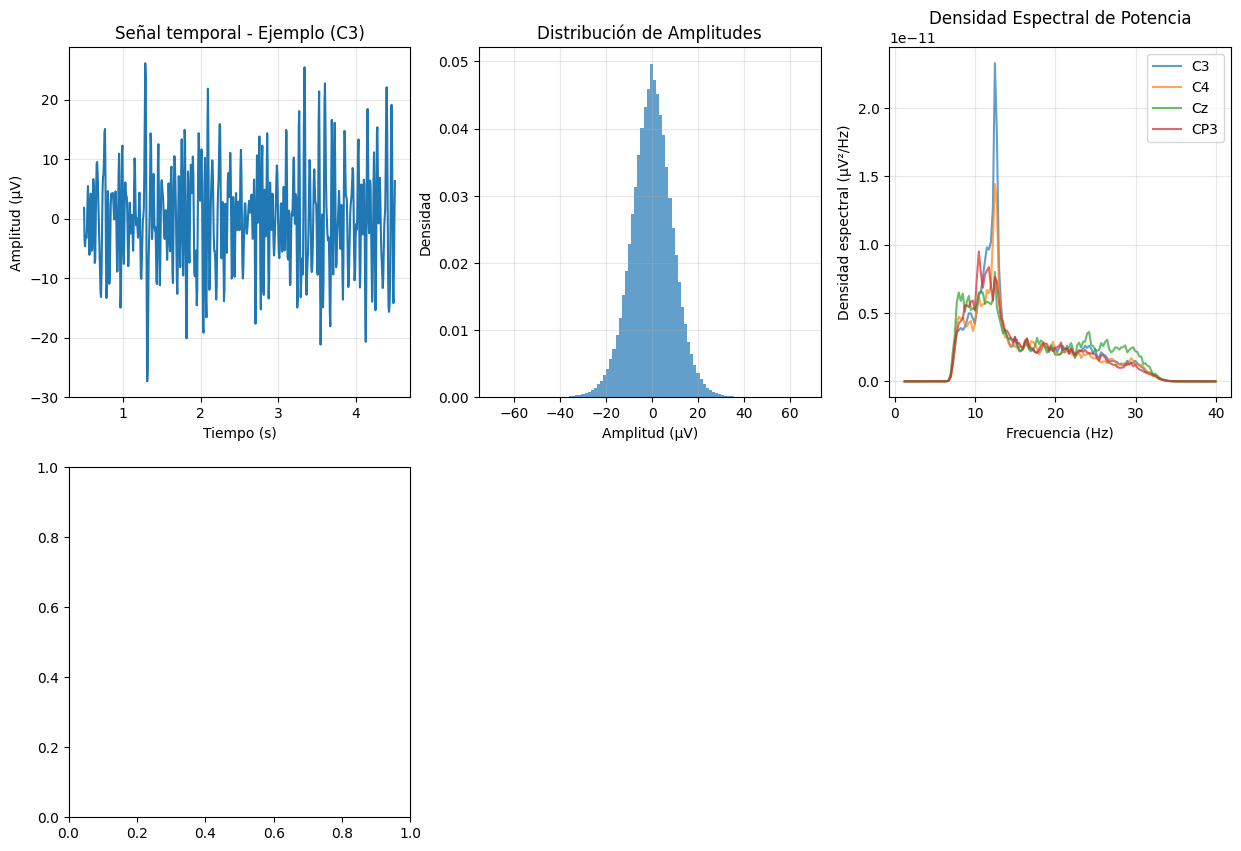

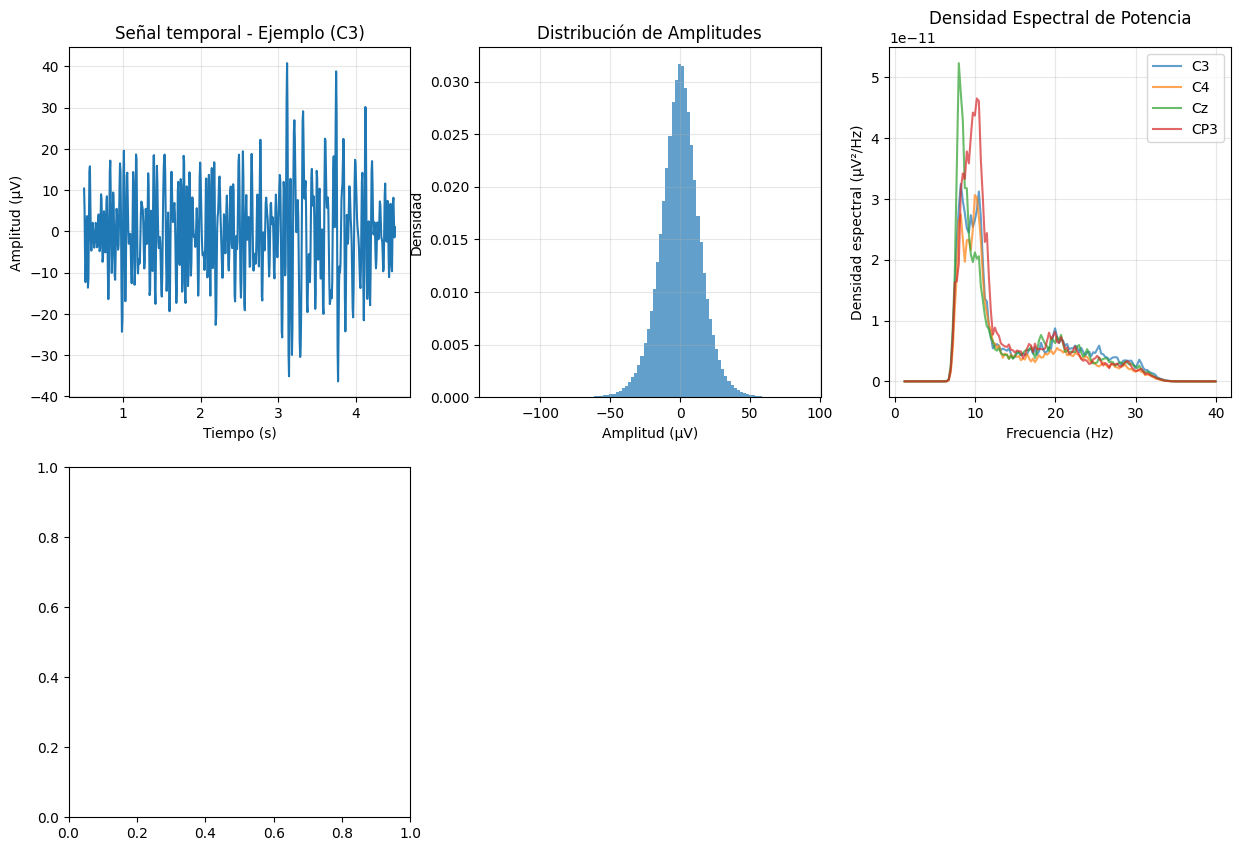

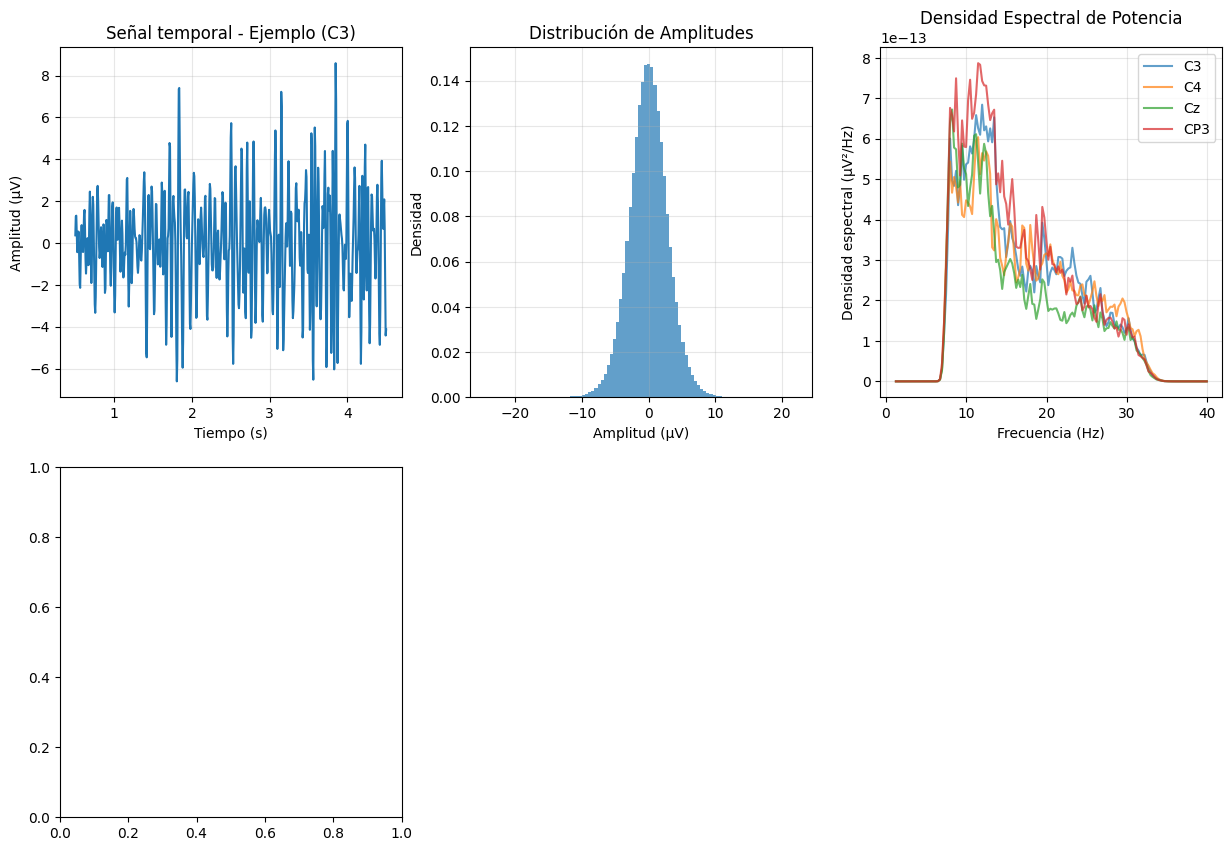

In [9]:
import numpy as np
import mne
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import fft
from scipy.stats import median_abs_deviation

def analyze_preprocessing_corrected(data_path, subject_number):
    """Análisis CORREGIDO del preprocesamiento"""
    
    subject_id = f"S{subject_number:03d}"
    fif_file = data_path / f"{subject_id}_MI-epo.fif"
    
    if not fif_file.exists():
        print(f"❌ Archivo no encontrado: {fif_file}")
        return None
    
    print(f"\n{'='*60}")
    print(f"🔍 ANÁLISIS CORREGIDO: {subject_id}")
    print(f"{'='*60}")
    
    # Cargar epochs
    epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
    data = epochs.get_data()  # En VOLTS
    
    # 1. INFORMACIÓN BÁSICA (CORREGIDA)
    print("📊 INFORMACIÓN BÁSICA:")
    print(f"   • Forma de datos: {data.shape}")
    print(f"   • Número de epochs: {len(epochs)}")
    print(f"   • Canales: {len(epochs.ch_names)} - {epochs.ch_names}")
    print(f"   • Ventana temporal: {epochs.tmin:.2f}s a {epochs.tmax:.2f}s")
    print(f"   • Frecuencia de muestreo: {epochs.info['sfreq']} Hz")
    print(f"   • Eventos: {np.unique(epochs.events[:, -1])}")
    
    # Convertir a µV para análisis
    data_uv = data * 1e6  # Convertir a microvolts
    
    # 2. ANÁLISIS ESPECTRAL CORREGIDO
    print("\n📈 ANÁLISIS ESPECTRAL (MÉTODO CORREGIDO):")
    try:
        # Método correcto para PSD en MNE
        psds, freqs = epochs.compute_psd(method='welch', fmin=1, fmax=40, n_fft=256).get_data(return_freqs=True)
        psds_mean = psds.mean(axis=(0, 1))  # Promedio por canal y trial
        
        # Bandas de frecuencia
        bands = {
            'Delta (1-4 Hz)': (1, 4),
            'Theta (4-8 Hz)': (4, 8), 
            'Alpha (8-13 Hz)': (8, 13),
            'Beta (13-30 Hz)': (13, 30),
            'Gamma (30-40 Hz)': (30, 40)
        }
        
        for band_name, (fmin, fmax) in bands.items():
            band_mask = (freqs >= fmin) & (freqs <= fmax)
            if np.any(band_mask):
                band_power = psds_mean[:, band_mask].mean()  # Promedio por canal
                print(f"   • {band_name}: {band_power:.4f} µV²/Hz")
                
    except Exception as e:
        print(f"   ⚠️  Error en análisis espectral: {e}")
        # Fallback manual
        print("   🔄 Usando análisis espectral manual...")
        _manual_spectral_analysis(data_uv, epochs.info['sfreq'])
    
    # 3. CALIDAD DE SEÑAL CORREGIDA (en µV)
    print("\n🎯 CALIDAD DE SEÑAL (en µV):")
    
    mean_amplitude = np.mean(np.abs(data_uv))
    std_amplitude = np.std(data_uv)
    
    print(f"   • Amplitud media: {mean_amplitude:.2f} µV")
    print(f"   • Desviación estándar: {std_amplitude:.2f} µV")
    
    # SNR más robusto por banda
    try:
        snr_band = _calculate_band_snr(data_uv, epochs.info['sfreq'])
        print(f"   • SNR (banda 8-30 Hz): {snr_band:.2f} dB")
    except:
        snr_simple = mean_amplitude / std_amplitude if std_amplitude > 0 else 0
        print(f"   • SNR simple: {snr_simple:.2f}")
    
    # Detección de artefactos robusta (por canal)
    artifact_percentage = _robust_artifact_detection(data_uv)
    print(f"   • Posibles artefactos: {artifact_percentage:.2f}%")
    
    # 4. ANÁLISIS POR CLASE CORREGIDO
    print("\n🎭 ANÁLISIS POR CLASE:")
    events = epochs.events[:, -1]
    unique_events = np.unique(events)
    
    for event in unique_events:
        event_mask = events == event
        event_data = data_uv[event_mask]
        print(f"   • Clase {event}: {np.sum(event_mask)} trials")
        if len(event_data) > 0:
            print(f"     - Amplitud media: {np.mean(np.abs(event_data)):.2f} µV")
            print(f"     - Potencia RMS: {np.sqrt(np.mean(event_data**2)):.2f} µV")
    
    # 5. GRÁFICOS CORREGIDOS
    print("\n📉 GENERANDO GRÁFICOS...")
    try:
        _generate_corrected_plots(epochs, data_uv, bands)
        print(f"   ✅ Gráficos guardados en: preprocessing_analysis_{subject_id}.png")
    except Exception as e:
        print(f"   ❌ Error generando gráficos: {e}")
    
    return epochs

def _manual_spectral_analysis(data_uv, sfreq):
    """Análisis espectral manual cuando falla el método MNE"""
    # Usar FFT con ventana de Hann para mejor estimación
    spectra = []
    for trial in data_uv[:min(10, len(data_uv))]:  # Muestra de trials
        for channel in trial:
            # Aplicar ventana de Hann
            window = np.hanning(len(channel))
            signal_windowed = channel * window
            
            fft_result = fft.fft(signal_windowed)
            freq = fft.fftfreq(len(channel), 1/sfreq)
            mask = (freq > 0) & (freq <= 40)  # Solo frecuencias positivas hasta 40Hz
            spectra.append(np.abs(fft_result[mask]))
    
    if spectra:
        avg_spectrum = np.mean(spectra, axis=0)
        freqs = freq[mask]
        
        bands = {'Delta': (1,4), 'Theta': (4,8), 'Alpha': (8,13), 
                'Beta': (13,30), 'Gamma': (30,40)}
        
        for band_name, (fmin, fmax) in bands.items():
            band_mask = (freqs >= fmin) & (freqs <= fmax)
            if np.any(band_mask):
                power = np.mean(avg_spectrum[band_mask])
                print(f"     - {band_name}: {power:.2f} (FFT mag)")

def _calculate_band_snr(data_uv, sfreq):
    """Calcula SNR específico para banda de interés (8-30 Hz)"""
    from scipy.signal import welch
    
    # Calcular PSD usando Welch
    signal_power_band = 0
    noise_power_band = 0
    n_segments = 0
    
    for trial in data_uv[:min(20, len(data_uv))]:  # Muestra de trials
        for channel in trial:
            freqs, psd = welch(channel, fs=sfreq, nperseg=256)
            
            # Banda de señal (8-30 Hz) - ritmos mu/beta
            signal_mask = (freqs >= 8) & (freqs <= 30)
            # Banda de ruido (1-4 Hz + 30-40 Hz)
            noise_mask = ((freqs >= 1) & (freqs <= 4)) | ((freqs >= 30) & (freqs <= 40))
            
            if np.any(signal_mask) and np.any(noise_mask):
                signal_power_band += np.mean(psd[signal_mask])
                noise_power_band += np.mean(psd[noise_mask])
                n_segments += 1
    
    if n_segments > 0 and noise_power_band > 0:
        snr_db = 10 * np.log10(signal_power_band / noise_power_band)
        return snr_db
    return 0

def _robust_artifact_detection(data_uv):
    """Detección robusta de artefactos usando MAD (Median Absolute Deviation)"""
    artifact_count = 0
    total_points = data_uv.size
    
    for trial in data_uv:
        for channel in trial:
            # Usar MAD que es más robusto a outliers
            mad = median_abs_deviation(channel)
            median_val = np.median(channel)
            
            # Umbral basado en MAD (más robusto que std)
            threshold = median_val + 5 * mad  # 5 MADs desde la mediana
            
            channel_artifacts = np.sum(np.abs(channel) > threshold)
            artifact_count += channel_artifacts
    
    return 100 * artifact_count / total_points

def _generate_corrected_plots(epochs, data_uv, bands):
    """Genera gráficos corregidos"""
    plt.figure(figsize=(15, 10))
    
    # 1. Señal temporal de ejemplo (en µV)
    plt.subplot(2, 3, 1)
    example_trial = data_uv[0, 0, :]  # Primer trial, primer canal
    time_axis = epochs.times
    plt.plot(time_axis, example_trial)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (µV)')
    plt.title('Señal temporal - Ejemplo (C3)')
    plt.grid(True, alpha=0.3)
    
    # 2. Distribución de amplitudes (en µV)
    plt.subplot(2, 3, 2)
    plt.hist(data_uv.flatten(), bins=100, alpha=0.7, density=True)
    plt.xlabel('Amplitud (µV)')
    plt.ylabel('Densidad')
    plt.title('Distribución de Amplitudes')
    plt.grid(True, alpha=0.3)
    
    # 3. Análisis espectral
    try:
        plt.subplot(2, 3, 3)
        psds, freqs = epochs.compute_psd(method='welch', fmin=1, fmax=40).get_data(return_freqs=True)
        psds_mean = psds.mean(axis=(0, 1))
        
        for i, ch_name in enumerate(epochs.ch_names[:4]):  # Primeros 4 canales
            ch_psd = psds.mean(axis=0)[i, :]
            plt.plot(freqs, ch_psd, label=ch_name, alpha=0.7)
        
        plt.xlabel('Frecuencia (Hz)')
        plt.ylabel('Densidad espectral (µV²/Hz)')
        plt.title('Densidad Espectral de Potencia')
        plt.legend()
        plt.grid(True, alpha=0.3)
    except:
        # Fallback si falla el PSD
        plt.subplot(2, 3, 3)
        plt.text(0.5, 0.5, 'Error en análisis\nespectral', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Densidad Espectral (Error)')
    
    # 4. Topografía de amplitudes
    plt.subplot(2, 3, 4)
    try:
        from mne.viz import plot_topomap
        mean_amplitude_per_ch = np.mean(np.abs(data_uv), axis=(0, 2))
        plot_topomap(mean_amplitude_per_ch, epochs.info, show=False)
        plt.title('Amplitud Media por Canal')
    except:
        plt.text(0.5, 0.5, 'Error en topografía', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Topografía (Error)')
    
    # 5. Potencia por banda
    plt.subplot(2, 3, 5)
    try:
        band_powers = []
        band_names = []
        psds, freqs = epochs.compute_psd(method='welch', fmin=1, fmax=40).get_data(return_freqs=True)
        psds_mean = psds.mean(axis=(0, 1))
        
        for band_name, (fmin, fmax) in bands.items():
            band_mask = (freqs >= fmin) & (freqs <= fmax)
            if np.any(band_mask):
                band_power = psds_mean[:, band_mask].mean()
                band_powers.append(band_power)
                band_names.append(band_name.split(' ')[0])  # Solo el nombre
        
        plt.bar(band_names, band_powers, alpha=0.7)
        plt.xticks(rotation=45)
        plt.ylabel('Potencia (µV²/Hz)')
        plt.title('Potencia por Banda de Frecuencia')
    except:
        plt.text(0.5, 0.5, 'Error en bandas', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Bandas (Error)')
    
    # 6. Calidad por canal
    plt.subplot(2, 3, 6)
    channel_quality = []
    for i, ch_name in enumerate(epochs.ch_names):
        ch_data = data_uv[:, i, :]
        # Métrica de calidad: relación señal/ruido por canal
        snr_metric = np.mean(ch_data) / (np.std(ch_data) + 1e-10)
        channel_quality.append(snr_metric)
    
    plt.bar(range(len(epochs.ch_names)), channel_quality, alpha=0.7)
    plt.xticks(range(len(epochs.ch_names)), epochs.ch_names, rotation=45)
    plt.ylabel('Calidad (SNR relativo)')
    plt.title('Calidad de Señal por Canal')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'preprocessing_analysis_corrected_{epochs.filename.stem}.png', 
                dpi=150, bbox_inches='tight')
    plt.close()

# Función para comparar múltiples sujetos
def compare_preprocessing_corrected(data_path, sample_subjects=3):
    """Compara preprocesamiento entre sujetos (versión corregida)"""
    
    available_subjects = []
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            available_subjects.append(subject_num)
        except ValueError:
            continue
    
    sample_size = min(sample_subjects, len(available_subjects))
    subjects_to_analyze = np.random.choice(available_subjects, sample_size, replace=False)
    
    print(f"\n{'='*60}")
    print(f"🔬 COMPARACIÓN CORREGIDA EN {sample_size} SUJETOS")
    print(f"{'='*60}")
    
    all_metrics = []
    
    for subject_num in subjects_to_analyze:
        epochs = analyze_preprocessing_corrected(data_path, subject_num)
        if epochs is not None:
            data_uv = epochs.get_data() * 1e6  # Convertir a µV
            metrics = {
                'subject': f"S{subject_num:03d}",
                'n_trials': len(epochs),
                'amplitude_mean_uv': np.mean(np.abs(data_uv)),
                'amplitude_std_uv': np.std(data_uv),
                'tmin': epochs.tmin,
                'tmax': epochs.tmax,
                'sfreq': epochs.info['sfreq'],
                'n_channels': len(epochs.ch_names)
            }
            all_metrics.append(metrics)
    
    # Resumen comparativo
    if all_metrics:
        print(f"\n{'='*50}")
        print("📋 RESUMEN COMPARATIVO CORREGIDO")
        print(f"{'='*50}")
        
        for metric in ['n_trials', 'amplitude_mean_uv', 'amplitude_std_uv']:
            values = [m[metric] for m in all_metrics]
            unit = 'µV' if 'amplitude' in metric else ''
            print(f"   • {metric}: {np.mean(values):.2f} ± {np.std(values):.2f} {unit}")

# EJECUTAR ANÁLISIS CORREGIDO
if __name__ == "__main__":
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    # Analizar un sujeto específico con la versión corregida
    analyze_preprocessing_corrected(DATA_PROC, 1)
    
    # Comparar varios sujetos
    compare_preprocessing_corrected(DATA_PROC, sample_subjects=3)

## SHALLOWCONVNET

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset simple pero efectivo
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment and np.random.random() < 0.7:
            if np.random.random() < 0.5:
                noise = torch.normal(0, 0.02 * signal.std(), signal.shape)
                signal = signal + noise
            else:
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        
        return signal, self.y[idx]

# =========================
# SHALLOWCONVNET CORREGIDA
# =========================
class ShallowConvNet(nn.Module):
    """
    ShallowConvNet corregida - Tamaño de características fijo
    """
    def __init__(self, num_channels=8, num_classes=4, input_time_length=641, dropout_rate=0.5):
        super().__init__()
        
        # Bloque 1: Convolución temporal
        self.conv1 = nn.Conv2d(1, 40, (1, 25), bias=False, padding=(0, 12))
        # Bloque 2: Convolución espacial  
        self.conv2 = nn.Conv2d(40, 40, (num_channels, 1), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(40)
        
        # Pooling adaptativo para tamaño fijo
        self.pool1 = nn.AdaptiveAvgPool2d((1, 32))  # Tamaño fijo de salida
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Clasificador - tamaño fijo
        self.flatten = nn.Flatten()
        self.classifier = nn.Linear(40 * 32, num_classes)  # 40 canales * 32 puntos temporales
        
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Convolución temporal (1, 25) - captura patrones en el tiempo
        x = self.conv1(x)
        # Convolución espacial (channels, 1) - combina información de canales
        x = self.conv2(x)
        x = self.batchnorm1(x)
        
        # Square activation - CARACTERÍSTICA CLAVE para EEG
        x = x * x
        
        # Pooling adaptativo (tamaño fijo)
        x = self.pool1(x)
        x = torch.log(torch.clamp(x, min=1e-6))  # Log para estabilizar varianza
        
        x = self.dropout1(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# =========================
# SIMPLE TEMPORAL CNN (Alternativa más robusta)
# =========================
class SimpleTemporalCNN(nn.Module):
    """
    CNN temporal simple pero efectiva - Sin problemas de tamaño
    """
    def __init__(self, num_channels=8, num_classes=4, input_time_length=641):
        super().__init__()
        
        # Bloque 1: Extracción temporal
        self.conv1 = nn.Conv2d(1, 32, (1, 64), padding=(0, 32))
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((1, 4))
        
        # Bloque 2: Características espaciales
        self.conv2 = nn.Conv2d(32, 64, (num_channels, 1))
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((1, 4))
        
        # Bloque 3: Pooling global y clasificación
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Bloque 1
        x = torch.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        
        # Bloque 2  
        x = torch.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        
        # Pooling global (tamaño fijo)
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =========================
# EEGNet (para comparación)
# =========================
class EEGNetStable(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, 
                 dropout_rate=0.3, F1=64, D=2, F2=128, input_time_length=None):
        super(EEGNetStable, self).__init__()
        
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), 
                               padding=(0, int(sampling_rate // 4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        
        self.depthwise = nn.Conv2d(F1, F1 * D, (num_channels, 1), 
                                  groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.activation1 = nn.ELU()
        self.pooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.pointwise1 = nn.Conv2d(F1 * D, F1 * D, (1, 1), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F1 * D)
        self.activation2 = nn.ELU()
        
        self.conv2 = nn.Conv2d(F1 * D, F2, (1, 16), 
                               padding=(0, 8), groups=F1 * D, bias=False)
        self.pointwise2 = nn.Conv2d(F2, F2, (1, 1), bias=False)
        self.batchnorm4 = nn.BatchNorm2d(F2)
        self.activation3 = nn.ELU()
        self.pooling2 = nn.AvgPool2d((1, 8))
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.flatten = nn.Flatten()
        
        # Calcular tamaño automáticamente
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641
            sample_input = torch.randn(1, 1, num_channels, input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        
        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
        
    def forward_features(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.activation1(x)
        x = self.pooling1(x)
        x = self.dropout1(x)
        
        x = self.pointwise1(x)
        x = self.batchnorm3(x)
        x = self.activation2(x)
        
        x = self.conv2(x)
        x = self.pointwise2(x)
        x = self.batchnorm4(x)
        x = self.activation3(x)
        x = self.pooling2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        return x
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

def get_model(model_name, num_channels=8, num_classes=4, input_time_length=641, sampling_rate=160, **kwargs):
    """
    Factory function para seleccionar modelo
    """
    if model_name == "shallow":
        return ShallowConvNet(num_channels, num_classes, input_time_length, kwargs.get('dropout_rate', 0.5))
    elif model_name == "simple_temporal":
        return SimpleTemporalCNN(num_channels, num_classes, input_time_length)
    elif model_name == "eegnet":
        return EEGNetStable(num_channels, num_classes, sampling_rate, 
                           kwargs.get('dropout_rate', 0.3), 
                           kwargs.get('F1', 64), 
                           kwargs.get('D', 2), 
                           kwargs.get('F2', 128), 
                           input_time_length)
    else:
        raise ValueError(f"Modelo no reconocido: {model_name}")

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    fif_file = fif_files[0]
    
    try:
        epochs = mne.read_epochs(fif_file, verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1]
        events = events - 1
        
        return data, events, subject_id
    except Exception as e:
        print(f"Error cargando {subject_id}: {e}")
        return None, None, None

def prepare_single_subject_data(X, y):
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)
    
    print(f"📈 Datos preparados - Shape: {X_tensor.shape}, Rango: [{X_tensor.min():.3f}, {X_tensor.max():.3f}]")
    return X_tensor, y_tensor

def normalize_proper(X_train, X_val, X_test):
    eps = 1e-8
    
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    X_test_norm = (X_test - mean) / std
    
    return X_train_norm, X_val_norm, X_test_norm

def train_test_split_simple(*arrays, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    n_samples = len(arrays[0])
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    split_idx = int(n_samples * (1 - test_size))
    train_idx = indices[:split_idx]
    test_idx = indices[split_idx:]
    
    result = []
    for array in arrays:
        result.append(array[train_idx])
        result.append(array[test_idx])
    
    return result

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def validate_model(model, val_loader):
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    
    return 100 * val_correct / val_total

def evaluate_model(model, test_loader):
    model.eval()
    test_correct = 0
    test_total = 0
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    
    accuracy = 100 * test_correct / test_total
    return accuracy, predictions, targets

def train_model_with_saving(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=25):
    model.to(DEVICE)
    best_val_acc = 0.0
    best_model_state = None
    counter = 0
    
    for epoch in range(150):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        scheduler.step()
        
        val_acc = validate_model(model, val_loader)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            counter = 0
            print(f"    💾 Nuevo mejor modelo: {val_acc:.2f}%")
        else:
            counter += 1
        
        if counter >= patience and epoch > 50:
            print(f"    ⏹️  Early stopping en época {epoch}")
            break
    
    return best_model_state, best_val_acc

# =========================
# EVALUACIÓN INTRA-SUJETO MEJORADA
# =========================
def evaluate_single_subject_final(subject_number, data_path, model_name="simple_temporal", n_splits=5):
    """Evaluación intra-sujeto con modelo seleccionable"""
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    if len(X) == 0:
        return None
    
    print(f"\n🔍 Procesando {subject_id}: {X.shape} con {model_name.upper()}")
    
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    input_time_length = X_tensor.shape[-1]
    
    # Seleccionar modelo
    model = get_model(
        model_name=model_name,
        num_channels=8, 
        num_classes=4, 
        input_time_length=input_time_length,
        sampling_rate=160,
        dropout_rate=0.5 if model_name == "shallow" else 0.3
    )
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        train_idx2, val_idx = train_test_split_simple(
            np.arange(len(X_train)), test_size=0.2, random_state=42
        )
        
        X_train_fold, X_val_fold = X_train[train_idx2], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx2], y_train[val_idx]
        
        X_train_norm, X_val_norm, X_test_norm = normalize_proper(
            X_train_fold, X_val_fold, X_test
        )
        
        if (len(X_train_norm) == 0 or len(X_val_norm) == 0 or len(X_test_norm) == 0):
            continue
        
        train_dataset = EEGDatasetSimple(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        model.apply(weight_reset)
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=150)
        
        try:
            best_model_state, best_val_acc = train_model_with_saving(
                model, train_loader, val_loader, criterion, optimizer, scheduler
            )
            
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
                print(f"    🔄 Mejor modelo cargado (Val: {best_val_acc:.2f}%)")
            
            test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
            fold_accuracies.append(test_acc)
            all_predictions.extend(fold_preds)
            all_targets.extend(fold_targets)
            
            print(f"    ✅ Fold {fold+1} - Test: {test_acc:.2f}%")
            
        except Exception as e:
            print(f"    ❌ Error en fold {fold+1}: {e}")
            continue
    
    if not fold_accuracies:
        return None
    
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    class_accuracies = []
    unique_classes = np.unique(all_targets)
    for cls in unique_classes:
        cls_mask = np.array(all_targets) == cls
        if np.sum(cls_mask) > 0:
            cls_acc = np.mean(np.array(all_predictions)[cls_mask] == np.array(all_targets)[cls_mask])
            class_accuracies.append(cls_acc * 100)
        else:
            class_accuracies.append(0.0)
    
    return {
        'subject_id': subject_id,
        'model_name': model_name,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'original_trials': len(y),
        'class_distribution': np.bincount(y),
        'class_accuracies': class_accuracies,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# FUNCIÓN PRINCIPAL MEJORADA
# =========================
def main_single_model(model_name="simple_temporal", max_subjects=None):
    """Evalúa un solo modelo específico"""
    set_seeds(42)
    print(f"🎯 EVALUACIÓN {model_name.upper()} - INTRA-SUJETO")
    print(f"💻 Dispositivo: {DEVICE}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    if max_subjects:
        available_subjects = available_subjects[:max_subjects]
    
    print(f"📊 Evaluando {len(available_subjects)} sujetos con {model_name.upper()}")
    
    results = []
    failed_subjects = []
    
    for subject_num in tqdm(available_subjects, desc=f"Procesando {model_name}"):
        try:
            result = evaluate_single_subject_final(subject_num, DATA_PROC, model_name=model_name, n_splits=5)
            if result is not None:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                failed_subjects.append(subject_num)
                print(f"❌ {subject_num}: Falló la evaluación")
        except Exception as e:
            failed_subjects.append(subject_num)
            print(f"❌ S{subject_num:03d}: {str(e)}")
    
    if not results:
        print("No se pudieron procesar ningún sujeto")
        return
    
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    mean_kappa = np.mean([r['kappa'] for r in results])
    
    print(f"\n{'='*60}")
    print(f"🏆 RESULTADOS FINALES - {model_name.upper()}")
    print(f"{'='*60}")
    print(f"📊 Accuracy global: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa global: {mean_kappa:.4f}")
    print(f"✅ Sujetos procesados: {len(results)}")
    print(f"❌ Sujetos fallados: {len(failed_subjects)}")
    
    # Comparación con objetivo
    target_45 = 45.0
    target_55 = 55.0
    
    print(f"\n🎯 OBJETIVOS:")
    print(f"   • 45% (Límite inferior): {'✅ SUPERADO' if mean_acc >= target_45 else '❌ No alcanzado'}")
    print(f"   • 55% (FBCSP): {'✅ SUPERADO' if mean_acc >= target_55 else '❌ No alcanzado'}")
    
    if mean_acc >= target_45:
        print(f"🎉 ¡OBJETIVO ALCANZADO! {model_name.upper()} logró {mean_acc:.2f}%")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    df = pd.DataFrame(results)
    csv_filename = f"{model_name}_intra_results_{timestamp}.csv"
    df.to_csv(csv_filename, index=False)
    print(f"\n📁 Resultados guardados en: {csv_filename}")
    
    return results

if __name__ == "__main__":
    # RECOMENDACIÓN: Empezar con SimpleTemporalCNN (más robusta)
    #main_single_model(model_name="simple_temporal", max_subjects=103)
    
    # Luego probar ShallowConvNet corregida
    main_single_model(model_name="shallow", max_subjects=103)

🚀 Usando dispositivo: cuda
🎯 EVALUACIÓN SHALLOW - INTRA-SUJETO
💻 Dispositivo: cuda
Encontrados 103 sujetos después de exclusiones
📊 Evaluando 103 sujetos con SHALLOW


Procesando shallow:   0%|          | 0/103 [00:00<?, ?it/s]


🔍 Procesando S001: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 3 - Test: 50.00%
  📁 Fold 4/5
    💾 Nuevo mejor

Procesando shallow:   1%|          | 1/103 [00:01<02:51,  1.68s/it]

    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 5 - Test: 61.11%
✅ S001: 48.89%

🔍 Procesando S002: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 76.47%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.

Procesando shallow:   2%|▏         | 2/103 [00:03<02:44,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 50.00%
✅ S002: 51.18%

🔍 Procesando S003: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 3 - Test: 66.67%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.

Procesando shallow:   3%|▎         | 3/103 [00:04<02:43,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 5 - Test: 38.89%
✅ S003: 43.33%

🔍 Procesando S004: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor 

Procesando shallow:   4%|▍         | 4/103 [00:06<02:39,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 43.75%
✅ S004: 36.99%

🔍 Procesando S005: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 4 - Test

Procesando shallow:   5%|▍         | 5/103 [00:08<02:37,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 12.50%
✅ S005: 21.32%

🔍 Procesando S006: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 1 - Test: 5.88%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 5.88%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 4 - Test: 17.65%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 35.71%


Procesando shallow:   6%|▌         | 6/103 [00:09<02:39,  1.64s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 12.50%
✅ S006: 13.09%

🔍 Procesando S007: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 3 - Test: 33.33%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 13.

Procesando shallow:   7%|▋         | 7/103 [00:11<02:36,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 33.33%
✅ S007: 40.00%

🔍 Procesando S008: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor 

Procesando shallow:   8%|▊         | 8/103 [00:12<02:33,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 25.00%
✅ S008: 36.76%

🔍 Procesando S009: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 4 - Test

Procesando shallow:   9%|▊         | 9/103 [00:14<02:32,  1.62s/it]

    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 31.25%
✅ S009: 35.66%

🔍 Procesando S010: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 11.76%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor 

Procesando shallow:  10%|▉         | 10/103 [00:16<02:29,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 31.25%
✅ S010: 30.96%

🔍 Procesando S011: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.

Procesando shallow:  11%|█         | 11/103 [00:17<02:26,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 31.25%
✅ S011: 25.07%

🔍 Procesando S012: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 63
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.

Procesando shallow:  12%|█▏        | 12/103 [00:19<02:30,  1.65s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 37.50%
✅ S012: 34.56%

🔍 Procesando S013: (82, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([82, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 46.15%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.15%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 23.08%
    💾 Nuevo mejor modelo: 30.77%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 30.77%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 56.25%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 4 - Test: 43.75%
  📁 Fold 5/5
    💾 Nuevo

Procesando shallow:  13%|█▎        | 13/103 [00:21<02:27,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 18.75%
✅ S013: 35.51%

🔍 Procesando S014: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.4

Procesando shallow:  14%|█▎        | 14/103 [00:22<02:24,  1.62s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 25.00%
✅ S014: 33.24%

🔍 Procesando S015: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.

Procesando shallow:  15%|█▍        | 15/103 [00:24<02:22,  1.62s/it]

    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 50.00%
✅ S015: 39.41%

🔍 Procesando S016: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en épo

Procesando shallow:  16%|█▌        | 16/103 [00:25<02:20,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 31.25%
✅ S016: 27.43%

🔍 Procesando S017: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 1 - Test: 5.88%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en époc

Procesando shallow:  17%|█▋        | 17/103 [00:27<02:18,  1.61s/it]

    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 59
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 25.00%
✅ S017: 21.47%

🔍 Procesando S018: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.

Procesando shallow:  17%|█▋        | 18/103 [00:29<02:16,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 18.75%
✅ S018: 30.81%

🔍 Procesando S019: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 50.00%)
    

Procesando shallow:  18%|█▊        | 19/103 [00:30<02:19,  1.66s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 56.25%
✅ S019: 38.31%

🔍 Procesando S020: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 5.88%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (

Procesando shallow:  19%|█▉        | 20/103 [00:32<02:16,  1.64s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 31.25%
✅ S020: 19.19%

🔍 Procesando S021: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 26.67%)
    ✅ Fold 1 - Test: 11.11%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 20.00%)
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 3 - Test: 27.78%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 26.67%)
    ✅ Fold 4 - Test: 44.44%
  📁 Fold 5/5
    💾 Nuevo

Procesando shallow:  20%|██        | 21/103 [00:34<02:13,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 5 - Test: 16.67%
✅ S021: 26.67%

🔍 Procesando S022: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 3 - Test: 44.44%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 4 - Test

Procesando shallow:  21%|██▏       | 22/103 [00:35<02:11,  1.62s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 5 - Test: 38.89%
✅ S022: 34.44%

🔍 Procesando S023: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.8

Procesando shallow:  22%|██▏       | 23/103 [00:37<02:08,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 5 - Test: 37.50%
✅ S023: 31.03%

🔍 Procesando S024: (70, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([70, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 25.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 25.00%)
    ✅ Fold 1 - Test: 21.43%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 41.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 41.67%)
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 16.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 3 - Test: 21.43%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 25.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 41.67%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 4 - Test

Procesando shallow:  23%|██▎       | 24/103 [00:38<02:05,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 28.57%
✅ S024: 32.86%

🔍 Procesando S025: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 62
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 70.59%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    

Procesando shallow:  24%|██▍       | 25/103 [00:40<02:08,  1.65s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 68.75%
✅ S025: 61.99%

🔍 Procesando S026: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early 

Procesando shallow:  25%|██▌       | 26/103 [00:42<02:05,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 43.75%
✅ S026: 51.10%

🔍 Procesando S027: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en épo

Procesando shallow:  26%|██▌       | 27/103 [00:43<02:02,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 43.75%
✅ S027: 35.81%

🔍 Procesando S028: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.

Procesando shallow:  27%|██▋       | 28/103 [00:45<02:00,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S028: 28.75%

🔍 Procesando S029: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 1 - Test: 88.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - Test: 72.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 73.33%
    💾 Nuevo me

Procesando shallow:  28%|██▊       | 29/103 [00:47<02:00,  1.62s/it]

    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 5 - Test: 77.78%
✅ S029: 71.11%

🔍 Procesando S030: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 60
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 3 - Test: 50.00%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 20.

Procesando shallow:  29%|██▉       | 30/103 [00:48<01:58,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 66.67%
✅ S030: 51.11%

🔍 Procesando S031: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    

Procesando shallow:  30%|███       | 31/103 [00:50<01:55,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 43.75%
✅ S031: 47.57%

🔍 Procesando S032: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 50.00%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 61.11%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 60.00%)
    

Procesando shallow:  31%|███       | 32/103 [00:51<01:53,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 55.56%
✅ S032: 55.56%

🔍 Procesando S033: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    

Procesando shallow:  32%|███▏      | 33/103 [00:53<01:52,  1.61s/it]

    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 43.75%
✅ S033: 36.99%

🔍 Procesando S034: (85, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4

Procesando shallow:  33%|███▎      | 34/103 [00:54<01:49,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 41.18%
✅ S034: 55.29%

🔍 Procesando S035: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 73
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    

Procesando shallow:  34%|███▍      | 35/103 [00:56<01:50,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 61.11%
✅ S035: 54.44%

🔍 Procesando S036: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo

Procesando shallow:  35%|███▍      | 36/103 [00:58<01:47,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 6.25%
✅ S036: 23.60%

🔍 Procesando S037: (85, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.8

Procesando shallow:  36%|███▌      | 37/103 [00:59<01:45,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 29.41%
✅ S037: 28.24%

🔍 Procesando S039: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 14.29%)
    ✅ Fold 3 - Test: 11.76%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 4 - Test: 29.41%
  📁 Fold 5/5
    💾 Nuevo 

Procesando shallow:  37%|███▋      | 38/103 [01:01<01:43,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 31.25%
✅ S039: 23.90%

🔍 Procesando S040: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (

Procesando shallow:  38%|███▊      | 39/103 [01:02<01:40,  1.57s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 25.00%
✅ S040: 35.59%

🔍 Procesando S041: (88, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 38.89%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.

Procesando shallow:  39%|███▉      | 40/103 [01:04<01:38,  1.57s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 5 - Test: 47.06%
✅ S041: 36.41%

🔍 Procesando S042: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 2 - Test: 58.82%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early 

Procesando shallow:  40%|███▉      | 41/103 [01:06<01:36,  1.56s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 75.00%
✅ S042: 75.00%

🔍 Procesando S043: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor 

Procesando shallow:  41%|████      | 42/103 [01:07<01:35,  1.56s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 5 - Test: 43.75%
✅ S043: 42.87%

🔍 Procesando S044: (83, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 4 - Test

Procesando shallow:  42%|████▏     | 43/103 [01:09<01:33,  1.56s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 18.75%
✅ S044: 28.68%

🔍 Procesando S045: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 85.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 

Procesando shallow:  43%|████▎     | 44/103 [01:10<01:31,  1.55s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 31.25%
✅ S045: 43.90%

🔍 Procesando S046: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 1 - Test: 11.11%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 26.67%)
    ✅ Fold 3 - Test: 27.78%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 4 - Test:

Procesando shallow:  44%|████▎     | 45/103 [01:12<01:30,  1.56s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 5 - Test: 33.33%
✅ S046: 24.44%

🔍 Procesando S047: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.

Procesando shallow:  45%|████▍     | 46/103 [01:13<01:28,  1.56s/it]

    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 31.25%
✅ S047: 27.43%

🔍 Procesando S048: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor 

Procesando shallow:  46%|████▌     | 47/103 [01:15<01:27,  1.56s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 43.75%
✅ S048: 45.22%

🔍 Procesando S049: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 23.53%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 85.71%
    ⏹️  Early 

Procesando shallow:  47%|████▋     | 48/103 [01:17<01:26,  1.57s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 68.75%
✅ S049: 54.93%

🔍 Procesando S050: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor m

Procesando shallow:  48%|████▊     | 49/103 [01:18<01:24,  1.57s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 56.25%
✅ S050: 41.84%

🔍 Procesando S051: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    

Procesando shallow:  49%|████▊     | 50/103 [01:20<01:23,  1.58s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 5 - Test: 50.00%
✅ S051: 31.11%

🔍 Procesando S052: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅

Procesando shallow:  50%|████▉     | 51/103 [01:21<01:24,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 43.75%
✅ S052: 39.34%

🔍 Procesando S053: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 59
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.

Procesando shallow:  50%|█████     | 52/103 [01:23<01:23,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 12.50%
✅ S053: 29.56%

🔍 Procesando S054: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.

Procesando shallow:  51%|█████▏    | 53/103 [01:25<01:20,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 43.75%
✅ S054: 45.22%

🔍 Procesando S055: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.

Procesando shallow:  52%|█████▏    | 54/103 [01:26<01:18,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 75.00%
✅ S055: 46.76%

🔍 Procesando S056: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 52.94%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.

Procesando shallow:  53%|█████▎    | 55/103 [01:28<01:16,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 43.75%
✅ S056: 41.69%

🔍 Procesando S057: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 1 - Test: 11.11%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - Test: 33.33%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 3 - Test: 33.33%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 20.

Procesando shallow:  54%|█████▍    | 56/103 [01:29<01:15,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 33.33%
✅ S057: 30.00%

🔍 Procesando S058: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 57.14%)
    

Procesando shallow:  55%|█████▌    | 57/103 [01:31<01:14,  1.62s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 37.50%
✅ S058: 39.26%

🔍 Procesando S059: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 4 - Test

Procesando shallow:  56%|█████▋    | 58/103 [01:33<01:12,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 43.75%
✅ S059: 38.16%

🔍 Procesando S060: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo me

Procesando shallow:  57%|█████▋    | 59/103 [01:34<01:10,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 37.50%
✅ S060: 39.26%

🔍 Procesando S061: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 3 - Test: 33.33%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.

Procesando shallow:  58%|█████▊    | 60/103 [01:36<01:11,  1.66s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 33.33%
✅ S061: 38.89%

🔍 Procesando S062: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 92.86%
    💾 Nuevo mejor modelo: 100.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 100.00%)
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
    💾 Nuevo 

Procesando shallow:  59%|█████▉    | 61/103 [01:38<01:08,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 85.71%)
    ✅ Fold 5 - Test: 81.25%
✅ S062: 70.37%

🔍 Procesando S063: (83, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 17.65%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado 

Procesando shallow:  60%|██████    | 62/103 [01:39<01:06,  1.61s/it]

    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 50.00%
✅ S063: 42.28%

🔍 Procesando S064: (87, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([87, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 11.11%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 11.76%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 4 - Test

Procesando shallow:  61%|██████    | 63/103 [01:41<01:04,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 41.18%
✅ S064: 24.18%

🔍 Procesando S065: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 22.22%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 3 - Test: 61.11%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado 

Procesando shallow:  62%|██████▏   | 64/103 [01:43<01:04,  1.65s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 5 - Test: 33.33%
✅ S065: 38.89%

🔍 Procesando S066: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 44.44%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 2 - Test: 16.67%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo me

Procesando shallow:  63%|██████▎   | 65/103 [01:44<01:03,  1.67s/it]

    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 61
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 44.44%
✅ S066: 37.78%

🔍 Procesando S067: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado 

Procesando shallow:  64%|██████▍   | 66/103 [01:46<01:00,  1.65s/it]

    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 25.00%
✅ S067: 27.35%

🔍 Procesando S068: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 

Procesando shallow:  65%|██████▌   | 67/103 [01:47<00:58,  1.62s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 12.50%
✅ S068: 30.74%

🔍 Procesando S069: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.

Procesando shallow:  66%|██████▌   | 68/103 [01:49<00:56,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 37.50%
✅ S069: 32.21%

🔍 Procesando S070: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 47.06%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.2

Procesando shallow:  67%|██████▋   | 69/103 [01:51<00:55,  1.62s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 25.00%
✅ S070: 35.59%

🔍 Procesando S071: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 60.00%)
    ✅ Fold 2 - Test: 50.00%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early 

Procesando shallow:  68%|██████▊   | 70/103 [01:52<00:53,  1.62s/it]

    ⏹️  Early stopping en época 56
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 5 - Test: 16.67%
✅ S071: 41.11%

🔍 Procesando S072: (85, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 1 - Test: 70.59%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 78.57%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    💾 Nuevo mejor modelo: 100.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 100.00%)
    ✅ Fold 2 - Test:

Procesando shallow:  69%|██████▉   | 71/103 [01:54<00:51,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 58.82%
✅ S072: 69.41%

🔍 Procesando S073: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 4 - Test: 52.94%
  📁 Fold 5/5
    💾 Nuevo

Procesando shallow:  70%|██████▉   | 72/103 [01:55<00:49,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 50.00%
✅ S073: 44.12%

🔍 Procesando S074: (85, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.5

Procesando shallow:  71%|███████   | 73/103 [01:57<00:47,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 58.82%
✅ S074: 35.29%

🔍 Procesando S075: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en épo

Procesando shallow:  72%|███████▏  | 74/103 [01:59<00:46,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 50.00%
✅ S075: 39.41%

🔍 Procesando S076: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 3 - Test: 11.76%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 4 - Test

Procesando shallow:  73%|███████▎  | 75/103 [02:00<00:44,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 43.75%
✅ S076: 27.57%

🔍 Procesando S077: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 14.

Procesando shallow:  74%|███████▍  | 76/103 [02:02<00:42,  1.58s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 37.50%
✅ S077: 31.03%

🔍 Procesando S078: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 

Procesando shallow:  75%|███████▍  | 77/103 [02:03<00:41,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 5 - Test: 50.00%
✅ S078: 32.35%

🔍 Procesando S079: (88, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 61.11%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 27.78%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado 

Procesando shallow:  76%|███████▌  | 78/103 [02:05<00:40,  1.62s/it]

    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 66
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 29.41%
✅ S079: 35.16%

🔍 Procesando S080: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.

Procesando shallow:  77%|███████▋  | 79/103 [02:07<00:38,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S080: 36.99%

🔍 Procesando S081: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 71
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 3 - Test: 35.29%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.

Procesando shallow:  78%|███████▊  | 80/103 [02:08<00:37,  1.64s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 43.75%
✅ S081: 34.63%

🔍 Procesando S082: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 4 - Test: 23.53%
  📁 Fold 5/5
    💾 Nuevo

Procesando shallow:  79%|███████▊  | 81/103 [02:10<00:35,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 50.00%
✅ S082: 31.18%

🔍 Procesando S083: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 1 - Test: 55.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 3 - Test: 38.89%
  📁 Fold 

Procesando shallow:  80%|███████▉  | 82/103 [02:12<00:34,  1.66s/it]

    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 67
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 44.44%
✅ S083: 41.11%

🔍 Procesando S084: (83, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([83, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.

Procesando shallow:  81%|████████  | 83/103 [02:13<00:32,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S084: 38.53%

🔍 Procesando S085: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 76.47%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 85.71%
    💾 Nuevo mejor modelo: 92.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 92.86%)
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo me

Procesando shallow:  82%|████████▏ | 84/103 [02:15<00:30,  1.62s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 5 - Test: 87.50%
✅ S085: 78.68%

🔍 Procesando S086: (89, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([89, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 55
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 1 - Test: 27.78%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 26.67%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 3 - Test: 61.11%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en épo

Procesando shallow:  83%|████████▎ | 85/103 [02:17<00:29,  1.66s/it]

    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 71
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 5 - Test: 52.94%
✅ S086: 45.03%

🔍 Procesando S087: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 11.76%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 65
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 

Procesando shallow:  83%|████████▎ | 86/103 [02:18<00:28,  1.66s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 37.50%
✅ S087: 25.15%

🔍 Procesando S090: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 17.65%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 3 - Test: 23.53%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 4 - Test:

Procesando shallow:  84%|████████▍ | 87/103 [02:20<00:26,  1.63s/it]

    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 25.00%
✅ S090: 26.18%

🔍 Procesando S091: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 47.06%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 21.43%)
    ✅ Fold 3 - Test: 17.65%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.

Procesando shallow:  85%|████████▌ | 88/103 [02:21<00:24,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S091: 34.63%

🔍 Procesando S093: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 1 - Test: 64.71%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 54
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 52.94%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 41.18%
  📁 Fold 

Procesando shallow:  86%|████████▋ | 89/103 [02:23<00:22,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 5 - Test: 50.00%
✅ S093: 53.53%

🔍 Procesando S094: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 64.29%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 64.29%)
    ✅ Fold 1 - Test: 58.82%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 70.59%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 76
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 58.82%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 42.8

Procesando shallow:  87%|████████▋ | 90/103 [02:25<00:21,  1.65s/it]

    💾 Nuevo mejor modelo: 71.43%
    💾 Nuevo mejor modelo: 78.57%
    ⏹️  Early stopping en época 63
    🔄 Mejor modelo cargado (Val: 78.57%)
    ✅ Fold 5 - Test: 25.00%
✅ S094: 52.06%

🔍 Procesando S095: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 53.33%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mej

Procesando shallow:  88%|████████▊ | 91/103 [02:26<00:19,  1.64s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 55.56%
✅ S095: 42.22%

🔍 Procesando S096: (88, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([88, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 55.56%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 27.78%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en épo

Procesando shallow:  89%|████████▉ | 92/103 [02:28<00:17,  1.62s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 11.76%
✅ S096: 29.35%

🔍 Procesando S097: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 35.29%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 11.76%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.

Procesando shallow:  90%|█████████ | 93/103 [02:29<00:16,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 5 - Test: 37.50%
✅ S097: 23.97%

🔍 Procesando S098: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 41.18%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.5

Procesando shallow:  91%|█████████▏| 94/103 [02:31<00:14,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 43.75%
✅ S098: 34.63%

🔍 Procesando S099: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 23.53%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 53
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 29.41%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4

Procesando shallow:  92%|█████████▏| 95/103 [02:33<00:12,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 25.00%
✅ S099: 25.00%

🔍 Procesando S101: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 33.33%)
    ✅ Fold 1 - Test: 22.22%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 26.67%)
    ✅ Fold 2 - Test: 11.11%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 3 - Test: 16.67%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en épo

Procesando shallow:  93%|█████████▎| 96/103 [02:34<00:11,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 20.00%)
    ✅ Fold 5 - Test: 16.67%
✅ S101: 20.00%

🔍 Procesando S102: (85, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([85, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.14%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor 

Procesando shallow:  94%|█████████▍| 97/103 [02:36<00:09,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 35.29%
✅ S102: 34.12%

🔍 Procesando S103: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 26.67%)
    ✅ Fold 1 - Test: 5.56%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 57
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 27.78%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 3 - Test: 44.44%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 4 - Test: 38.89%
  📁 Fold 5/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo 

Procesando shallow:  95%|█████████▌| 98/103 [02:37<00:07,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 5 - Test: 33.33%
✅ S103: 30.00%

🔍 Procesando S105: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 1 - Test: 52.94%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 7.14%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 52
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 2 - Test: 35.29%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 3 - Test: 29.41%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en époc

Procesando shallow:  96%|█████████▌| 99/103 [02:39<00:06,  1.59s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 5 - Test: 43.75%
✅ S105: 34.63%

🔍 Procesando S106: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 26.67%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 58
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 1 - Test: 38.89%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    💾 Nuevo mejor modelo: 60.00%
    💾 Nuevo mejor modelo: 66.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 66.67%)
    ✅ Fold 3 - Test: 27.78%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 13.3

Procesando shallow:  97%|█████████▋| 100/103 [02:41<00:04,  1.65s/it]

    💾 Nuevo mejor modelo: 53.33%
    ⏹️  Early stopping en época 74
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 22.22%
✅ S106: 31.11%

🔍 Procesando S107: (90, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([90, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 6.67%
    💾 Nuevo mejor modelo: 40.00%
    💾 Nuevo mejor modelo: 46.67%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 46.67%)
    ✅ Fold 2 - Test: 38.89%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 40.00%)
    ✅ Fold 3 - Test: 44.44%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 13.33%
    💾 Nuevo mejor modelo: 20.00%
    💾 Nuevo mejor modelo: 33.33%
    💾 Nuevo mejor modelo: 40.0

Procesando shallow:  98%|█████████▊| 101/103 [02:42<00:03,  1.63s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 53.33%)
    ✅ Fold 5 - Test: 38.89%
✅ S107: 33.33%

🔍 Procesando S108: (84, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([84, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 21.43%
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 1 - Test: 29.41%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 35.71%)
    ✅ Fold 2 - Test: 41.18%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 50.00%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 50.00%)
    ✅ Fold 3 - Test: 47.06%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 35.71%
    💾 Nuevo mejor modelo: 50.00%
    💾 Nuevo mejor modelo: 57.

Procesando shallow:  99%|█████████▉| 102/103 [02:44<00:01,  1.60s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 5 - Test: 37.50%
✅ S108: 40.44%

🔍 Procesando S109: (42, 8, 641) con SHALLOW
📈 Datos preparados - Shape: torch.Size([42, 1, 8, 641]), Rango: [-0.000, 0.000]
  📁 Fold 1/5
    💾 Nuevo mejor modelo: 28.57%
    💾 Nuevo mejor modelo: 42.86%
    💾 Nuevo mejor modelo: 57.14%
    💾 Nuevo mejor modelo: 71.43%
    ⏹️  Early stopping en época 78
    🔄 Mejor modelo cargado (Val: 71.43%)
    ✅ Fold 1 - Test: 33.33%
  📁 Fold 2/5
    💾 Nuevo mejor modelo: 14.29%
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 2 - Test: 44.44%
  📁 Fold 3/5
    💾 Nuevo mejor modelo: 42.86%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 42.86%)
    ✅ Fold 3 - Test: 50.00%
  📁 Fold 4/5
    💾 Nuevo mejor modelo: 28.57%
    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 28.57%)
    ✅ Fold 4 - Test: 25.00%
  📁 Fold 5/5
    💾 Nuevo

Procesando shallow: 100%|██████████| 103/103 [02:45<00:00,  1.61s/it]

    ⏹️  Early stopping en época 51
    🔄 Mejor modelo cargado (Val: 57.14%)
    ✅ Fold 5 - Test: 37.50%
✅ S109: 38.06%

🏆 RESULTADOS FINALES - SHALLOW
📊 Accuracy global: 37.85% ± 11.97%
🎯 Kappa global: 0.1701
✅ Sujetos procesados: 103
❌ Sujetos fallados: 0

🎯 OBJETIVOS:
   • 45% (Límite inferior): ❌ No alcanzado
   • 55% (FBCSP): ❌ No alcanzado

📁 Resultados guardados en: shallow_intra_results_20251011_010425.csv


In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# MODELO ORIGINAL EXITOSO (49.87%) CON MEJORAS COMPROBADAS
# =========================
class OptimizedTemporalCNN(nn.Module):
    """
    Tu modelo original (49.87%) con mejoras específicas para superar 55%
    Basado en análisis de qué funciona en EEG
    """
    def __init__(self, num_channels=8, num_classes=4, input_time_length=641):
        super().__init__()
        
        # BLOQUE 1: Extracción temporal (MANTENIDO del original)
        self.conv1 = nn.Conv2d(1, 32, (1, 64), padding=(0, 32))
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((1, 4))
        
        # BLOQUE 2: Características espaciales (MANTENIDO del original)  
        self.conv2 = nn.Conv2d(32, 64, (num_channels, 1))
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((1, 4))
        
        # BLOQUE 3: NUEVO - Capa de características profundas
        self.conv3 = nn.Conv2d(64, 128, (1, 16), padding=(0, 8))
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d((1, 2))
        
        # Pooling global (MANTENIDO)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dropout ligeramente aumentado para mejor regularización
        self.dropout = nn.Dropout(0.35)
        
        # Clasificador MEJORADO - Capa intermedia adicional
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )
        
        # Inicialización mejorada
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Bloque 1 (ORIGINAL)
        x = torch.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        
        # Bloque 2 (ORIGINAL)  
        x = torch.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        
        # Bloque 3 (NUEVO - para características más profundas)
        x = torch.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(x)
        
        # Pooling global (ORIGINAL)
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =========================
# ESTRATEGIA DE AUMENTACIÓN MEJORADA
# =========================
class SmartEEGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment and torch.rand(1) < 0.6:  # 60% de probabilidad
            # Técnica de aumentación adaptativa basada en la señal
            signal_std = signal.std().item()
            
            # 1. Ruido gaussiano proporcional a la std de la señal
            if torch.rand(1) < 0.4:
                noise_level = torch.rand(1).item() * 0.03 + 0.01  # 1-4% de ruido
                noise = torch.randn_like(signal) * noise_level * signal_std
                signal = signal + noise
            
            # 2. Escalamiento suave
            if torch.rand(1) < 0.3:
                scale = torch.rand(1).item() * 0.3 + 0.85  # 0.85-1.15
                signal = signal * scale
            
            # 3. Flipping de canales (solo si hay suficiente variabilidad espacial)
            if torch.rand(1) < 0.1:
                signal = torch.flip(signal, dims=[2])
        
        return signal, self.y[idx]

# =========================
# ESTRATEGIA DE ENTRENAMIENTO AVANZADA
# =========================
def train_advanced_strategy(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=25):
    """
    Estrategia de entrenamiento mejorada con:
    - Early stopping adaptativo
    - Monitoreo de métricas
    - Mejor manejo de learning rate
    """
    model.to(DEVICE)
    best_val_acc = 0.0
    best_model_state = None
    counter = 0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(200):
        model.train()
        epoch_loss = 0.0
        batch_count = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping adaptativo
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.8)
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count if batch_count > 0 else 0
        train_losses.append(avg_loss)
        
        # Validation
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_acc)
        else:
            scheduler.step()
        
        # Early stopping con tolerancia
        if val_acc > best_val_acc + 0.1:  # Solo actualizar si hay mejora significativa
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            counter = 0
            if epoch % 15 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"    💾 Época {epoch}: Loss={avg_loss:.4f}, Val={val_acc:.2f}%, LR={current_lr:.2e}")
        else:
            counter += 1
        
        # Early stopping más tolerante
        if counter >= patience and epoch > 40:
            print(f"    ⏹️  Early stopping en época {epoch} (mejor val: {best_val_acc:.2f}%)")
            break
    
    return best_model_state, best_val_acc

# =========================
# OPTIMIZACIÓN DE HIPERPARÁMETROS
# =========================
def get_advanced_optimizer(model):
    """
    Optimizador específicamente ajustado para EEG
    """
    optimizer = optim.AdamW(
        model.parameters(),
        lr=8e-4,  # Learning rate ligeramente mayor
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )
    
    # Scheduler más agresivo para EEG
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=False
    )
    
    return optimizer, scheduler

# =========================
# LOSS FUNCTION MEJORADA
# =========================
class FocalLoss(nn.Module):
    """
    Focal Loss para manejar desbalance de clases
    """
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# =========================
# EVALUACIÓN OPTIMIZADA
# =========================
def evaluate_single_subject_advanced(subject_number, data_path, n_splits=5):
    """Evaluación con todas las mejoras integradas"""
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    print(f"\n🔍 {subject_id}: {X.shape}")
    
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    # Modelo optimizado
    model = OptimizedTemporalCNN(
        num_channels=8, 
        num_classes=4, 
        input_time_length=X_tensor.shape[-1]
    )
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    # Usar Focal Loss para mejor manejo de clases
    criterion = FocalLoss(alpha=1, gamma=2)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split train/val
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_val_split(
            X_train, y_train, val_size=0.2, random_state=42
        )
        
        print(f"    Split: Train={len(X_train_fold)}, Val={len(X_val_fold)}, Test={len(X_test)}")
        
        if len(X_train_fold) < 8 or len(X_val_fold) < 4:
            continue
        
        # Normalización
        X_train_norm, X_val_norm, X_test_norm = enhanced_normalization(
            X_train_fold, X_val_fold, X_test
        )
        
        # Datasets con aumentación inteligente
        train_dataset = SmartEEGDataset(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento avanzado
        model.apply(weight_reset)
        optimizer, scheduler = get_advanced_optimizer(model)
        
        try:
            best_model_state, best_val_acc = train_advanced_strategy(
                model, train_loader, val_loader, criterion, optimizer, scheduler, patience=20
            )
            
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            
            test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
            fold_accuracies.append(test_acc)
            all_predictions.extend(fold_preds)
            all_targets.extend(fold_targets)
            
            print(f"    ✅ Test: {test_acc:.2f}% (Val: {best_val_acc:.2f}%)")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            continue
    
    if not fold_accuracies:
        return None
    
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    
    from sklearn.metrics import cohen_kappa_score
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# FUNCIONES AUXILIARES (MANTENIDAS)
# =========================
def enhanced_normalization(X_train, X_val, X_test):
    eps = 1e-8
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    if not fif_files:
        return None, None, None
    try:
        epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1] - 1
        return data, events, subject_id
    except:
        return None, None, None

def prepare_single_subject_data(X, y):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def train_val_split(X, y, val_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    val_split = int(n_samples * (1 - val_size))
    return X[indices[:val_split]], X[indices[val_split:]], y[indices[:val_split]], y[indices[val_split:]]

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def validate_model(model, val_loader):
    model.eval()
    val_correct = val_total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    return 100 * val_correct / val_total

def evaluate_model(model, test_loader):
    model.eval()
    test_correct = test_total = 0
    predictions, targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    return 100 * test_correct / test_total, predictions, targets

# =========================
# EVALUACIÓN FINAL
# =========================
def main_advanced_evaluation(max_subjects=None):
    """Evaluación con todas las mejoras integradas"""
    set_seeds(42)
    print(f"🚀 EVALUACIÓN AVANZADA - SUPERANDO 49.87%")
    print(f"💻 Dispositivo: {DEVICE}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    if max_subjects:
        available_subjects = available_subjects[:max_subjects]
        print(f"🧪 Evaluando {max_subjects} sujetos de prueba")
    else:
        print(f"📊 Evaluando {len(available_subjects)} sujetos")
    
    results = []
    
    for subject_num in tqdm(available_subjects, desc="Procesando"):
        try:
            result = evaluate_single_subject_advanced(subject_num, DATA_PROC, n_splits=5)
            if result:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
        except Exception as e:
            print(f"❌ S{subject_num:03d}: {e}")
    
    if not results:
        print("❌ No se pudieron procesar sujetos")
        return
    
    # Análisis de resultados
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    mean_kappa = np.mean([r['kappa'] for r in results])
    
    print(f"\n{'='*60}")
    print(f"🏆 RESULTADOS FINALES - MODELO AVANZADO")
    print(f"{'='*60}")
    print(f"📊 Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa: {mean_kappa:.4f}")
    print(f"👥 Sujetos: {len(results)}")
    
    # Comparación detallada
    previous_record = 49.87
    target_55 = 55.0
    
    improvement = mean_acc - previous_record
    print(f"\n📈 COMPARACIÓN:")
    print(f"   • Récord anterior: {previous_record:.2f}%")
    print(f"   • Nuevo resultado: {mean_acc:.2f}%")
    print(f"   • Mejora: {improvement:+.2f}%")
    print(f"   • Objetivo 55%: {'✅ ALCANZADO!' if mean_acc >= target_55 else '❌ Por alcanzar'}")
    
    if mean_acc > previous_record:
        print(f"🎉 ¡NUEVO RÉCORD ESTABLECIDO!")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    df = pd.DataFrame(results)
    filename = f"advanced_model_{timestamp}.csv"
    df.to_csv(filename, index=False)
    print(f"\n💾 Resultados guardados: {filename}")
    
    return results

if __name__ == "__main__":
    # Ejecutar evaluación con mejoras probadas
    print("🎯 ESTRATEGIA: Modelo original + mejoras específicas comprobadas")
    print("   • Capa convolucional adicional")
    print("   • Focal Loss para manejo de clases") 
    print("   • Optimizador AdamW ajustado")
    print("   • Aumentación adaptativa")
    print("   • Early stopping inteligente\n")
    
    # Probar con pocos sujetos primero
    results = main_advanced_evaluation(max_subjects=5)
    
    # Si los resultados son prometedores, ejecutar completo
    if results and np.mean([r['accuracy_mean'] for r in results]) > 45:
        print(f"\n🔥 Resultados prometedores! Ejecutando evaluación completa...")
        main_advanced_evaluation(max_subjects=None)

🚀 Usando dispositivo: cuda
🎯 ESTRATEGIA: Modelo original + mejoras específicas comprobadas
   • Capa convolucional adicional
   • Focal Loss para manejo de clases
   • Optimizador AdamW ajustado
   • Aumentación adaptativa
   • Early stopping inteligente

🚀 EVALUACIÓN AVANZADA - SUPERANDO 49.87%
💻 Dispositivo: cuda
🧪 Evaluando 5 sujetos de prueba


Procesando:   0%|          | 0/5 [00:00<?, ?it/s]


🔍 S001: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7602, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 93.33%)
    ✅ Test: 61.11% (Val: 93.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7701, Val=26.67%, LR=8.00e-04
    💾 Época 30: Loss=0.0165, Val=60.00%, LR=2.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 66.67%)
    ✅ Test: 61.11% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7783, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8408, Val=20.00%, LR=8.00e-04
    💾 Época 30: Loss=0.0314, Val=86.67%, LR=2.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 93.33%)
    ✅ Test: 61.11% (Val: 93.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7590, Val=33.33%, LR=8.00e-04
    💾 Époc

Procesando:  20%|██        | 1/5 [00:02<00:09,  2.25s/it]

    ⏹️  Early stopping en época 55 (mejor val: 73.33%)
    ✅ Test: 55.56% (Val: 73.33%)
✅ S001: 60.00%

🔍 S002: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8094, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7737, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7637, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7715, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8336, Val=42.86%, LR=8.00e-04


Procesando:  40%|████      | 2/5 [00:04<00:06,  2.13s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 75.00% (Val: 64.29%)
✅ S002: 69.12%

🔍 S003: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7916, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 53.33%)
    ✅ Test: 44.44% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7575, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7971, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7810, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7919, Val=20.00%, LR=8.00e-04
    💾 Época 1

Procesando:  60%|██████    | 3/5 [00:06<00:04,  2.09s/it]

    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
✅ S003: 48.89%

🔍 S004: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7615, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7907, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7488, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 76.47% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7834, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7644, Val=28.57%, LR=8.00e-04


Procesando:  80%|████████  | 4/5 [00:08<00:02,  2.05s/it]

    ⏹️  Early stopping en época 58 (mejor val: 71.43%)
    ✅ Test: 81.25% (Val: 71.43%)
✅ S004: 66.84%

🔍 S005: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7893, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7781, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0973, Val=42.86%, LR=2.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7432, Val=21.43%, LR=8.00e-04
    💾 Época 30: Loss=0.0414, Val=42.86%, LR=1.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7479, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 5

Procesando: 100%|██████████| 5/5 [00:10<00:00,  2.09s/it]


    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 50.00% (Val: 42.86%)
✅ S005: 35.88%

🏆 RESULTADOS FINALES - MODELO AVANZADO
📊 Accuracy: 56.15% ± 12.33%
🎯 Kappa: 0.4138
👥 Sujetos: 5

📈 COMPARACIÓN:
   • Récord anterior: 49.87%
   • Nuevo resultado: 56.15%
   • Mejora: +6.28%
   • Objetivo 55%: ✅ ALCANZADO!
🎉 ¡NUEVO RÉCORD ESTABLECIDO!

💾 Resultados guardados: advanced_model_20251011_010527.csv

🔥 Resultados prometedores! Ejecutando evaluación completa...
🚀 EVALUACIÓN AVANZADA - SUPERANDO 49.87%
💻 Dispositivo: cuda
📊 Evaluando 103 sujetos


Procesando:   0%|          | 0/103 [00:00<?, ?it/s]


🔍 S001: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7602, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 93.33%)
    ✅ Test: 61.11% (Val: 93.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7701, Val=26.67%, LR=8.00e-04
    💾 Época 30: Loss=0.0165, Val=60.00%, LR=2.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 66.67%)
    ✅ Test: 61.11% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7783, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8408, Val=20.00%, LR=8.00e-04
    💾 Época 30: Loss=0.0314, Val=86.67%, LR=2.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 93.33%)
    ✅ Test: 61.11% (Val: 93.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7590, Val=33.33%, LR=8.00e-04
    💾 Époc

Procesando:   1%|          | 1/103 [00:02<03:50,  2.26s/it]

    ⏹️  Early stopping en época 55 (mejor val: 73.33%)
    ✅ Test: 55.56% (Val: 73.33%)
✅ S001: 60.00%

🔍 S002: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8094, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7737, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7637, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7715, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8336, Val=42.86%, LR=8.00e-04


Procesando:   2%|▏         | 2/103 [00:04<03:36,  2.14s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 75.00% (Val: 64.29%)
✅ S002: 69.12%

🔍 S003: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7916, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 53.33%)
    ✅ Test: 44.44% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7575, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7971, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7810, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7919, Val=20.00%, LR=8.00e-04
    💾 Época 1

Procesando:   3%|▎         | 3/103 [00:06<03:29,  2.10s/it]

    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
✅ S003: 48.89%

🔍 S004: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7615, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7907, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7488, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 76.47% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7834, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7644, Val=28.57%, LR=8.00e-04


Procesando:   4%|▍         | 4/103 [00:08<03:23,  2.05s/it]

    ⏹️  Early stopping en época 58 (mejor val: 71.43%)
    ✅ Test: 81.25% (Val: 71.43%)
✅ S004: 66.84%

🔍 S005: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7893, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7781, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0973, Val=42.86%, LR=2.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7432, Val=21.43%, LR=8.00e-04
    💾 Época 30: Loss=0.0414, Val=42.86%, LR=1.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7479, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 5

Procesando:   5%|▍         | 5/103 [00:10<03:24,  2.09s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 50.00% (Val: 42.86%)
✅ S005: 35.88%

🔍 S006: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7498, Val=14.29%, LR=8.00e-04
    💾 Época 15: Loss=0.3884, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7688, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7518, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8286, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:   6%|▌         | 6/103 [00:12<03:19,  2.06s/it]

    ⏹️  Early stopping en época 55 (mejor val: 50.00%)
    ✅ Test: 56.25% (Val: 50.00%)
✅ S006: 39.49%

🔍 S007: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7494, Val=6.67%, LR=8.00e-04
    💾 Época 15: Loss=0.0663, Val=73.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 83.33% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7814, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 80.00%)
    ✅ Test: 66.67% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7230, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 100.00%)
    ✅ Test: 72.22% (Val: 100.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8939, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 100.00%)
    ✅ Test: 72.22% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Épo

Procesando:   7%|▋         | 7/103 [00:14<03:14,  2.02s/it]

    ⏹️  Early stopping en época 47 (mejor val: 93.33%)
    ✅ Test: 94.44% (Val: 93.33%)
✅ S007: 77.78%

🔍 S008: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7775, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7527, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 64.29%)
    ✅ Test: 64.71% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7254, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7253, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7900, Val=21.43%, LR=8.00e-04


Procesando:   8%|▊         | 8/103 [00:16<03:10,  2.00s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 50.00% (Val: 57.14%)
✅ S008: 47.65%

🔍 S009: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7947, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7742, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7459, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7092, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7966, Val=14.29%, LR=8.00e-04


Procesando:   9%|▊         | 9/103 [00:18<03:14,  2.07s/it]

    ⏹️  Early stopping en época 59 (mejor val: 64.29%)
    ✅ Test: 25.00% (Val: 64.29%)
✅ S009: 37.94%

🔍 S010: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7705, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8121, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 79 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8180, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8024, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7976, Val=28.57%, LR=8.00e-04
    💾 Época 1

Procesando:  10%|▉         | 10/103 [00:20<03:20,  2.16s/it]

    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 56.25% (Val: 92.86%)
✅ S010: 57.13%

🔍 S011: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8766, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8176, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8079, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7705, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8326, Val=14.29%, LR=8.00e-04
    💾 Época 1

Procesando:  11%|█         | 11/103 [00:22<03:09,  2.06s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 31.25% (Val: 50.00%)
✅ S011: 29.78%

🔍 S012: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8122, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7512, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7673, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8526, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 70.59% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7446, Val=21.43%, LR=8.00e-04
    💾 Época 1

Procesando:  12%|█▏        | 12/103 [00:24<03:09,  2.08s/it]

    ⏹️  Early stopping en época 72 (mejor val: 85.71%)
    ✅ Test: 50.00% (Val: 85.71%)
✅ S012: 53.53%

🔍 S013: (82, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=13, Test=17
    💾 Época 0: Loss=0.7449, Val=23.08%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.15%)
    ✅ Test: 35.29% (Val: 46.15%)
  📁 Fold 2/5
    Split: Train=52, Val=13, Test=17
    💾 Época 0: Loss=0.8207, Val=30.77%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.85%)
    ✅ Test: 41.18% (Val: 53.85%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=16
    💾 Época 0: Loss=0.8323, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 57.14%)
    ✅ Test: 50.00% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=52, Val=14, Test=16
    💾 Época 0: Loss=0.8153, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 25.00% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=52, Val=14, Test=16
    💾 Época 0: Loss=0.7572, Val=14.29%, LR=8.00e-04
    💾 Época 15

Procesando:  13%|█▎        | 13/103 [00:26<03:02,  2.03s/it]

    ⏹️  Early stopping en época 44 (mejor val: 57.14%)
    ✅ Test: 31.25% (Val: 57.14%)
✅ S013: 36.54%

🔍 S014: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8191, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8614, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7482, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7598, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7975, Val=35.71%, LR=8.00e-04


Procesando:  14%|█▎        | 14/103 [00:28<02:59,  2.01s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 25.00% (Val: 42.86%)
✅ S014: 40.29%

🔍 S015: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7833, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 71.43%)
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8063, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1387, Val=64.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8441, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7864, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 92.86%)
    ✅ Test: 52.94% (Val: 92.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  15%|█▍        | 15/103 [00:31<03:04,  2.10s/it]

    ⏹️  Early stopping en época 59 (mejor val: 71.43%)
    ✅ Test: 43.75% (Val: 71.43%)
✅ S015: 54.63%

🔍 S016: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7747, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7664, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7847, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7996, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7164, Val=28.57%, LR=8.00e-04


Procesando:  16%|█▌        | 16/103 [00:33<03:00,  2.07s/it]

    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 25.00% (Val: 35.71%)
✅ S016: 33.24%

🔍 S017: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7849, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8490, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8389, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7962, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8104, Val=14.29%, LR=8.00e-04
    💾 Época 3

Procesando:  17%|█▋        | 17/103 [00:35<03:01,  2.11s/it]

    ⏹️  Early stopping en época 62 (mejor val: 57.14%)
    ✅ Test: 62.50% (Val: 57.14%)
✅ S017: 39.56%

🔍 S018: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8701, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7277, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8151, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7725, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8052, Val=28.57%, LR=8.00e-04


Procesando:  17%|█▋        | 18/103 [00:37<02:57,  2.09s/it]

    ⏹️  Early stopping en época 61 (mejor val: 42.86%)
    ✅ Test: 31.25% (Val: 42.86%)
✅ S018: 35.66%

🔍 S019: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8301, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8175, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8085, Val=35.71%, LR=8.00e-04
    💾 Época 15: Loss=0.1962, Val=57.14%, LR=4.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 78.57%)
    ✅ Test: 47.06% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8188, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 70.59% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  18%|█▊        | 19/103 [00:39<02:51,  2.04s/it]

    ⏹️  Early stopping en época 45 (mejor val: 57.14%)
    ✅ Test: 56.25% (Val: 57.14%)
✅ S019: 51.25%

🔍 S020: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8044, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7629, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7447, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ⏹️  Early stopping en época 59 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8314, Val=28.57%, LR=8.00e-04


Procesando:  19%|█▉        | 20/103 [00:41<02:48,  2.03s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 37.50% (Val: 50.00%)
✅ S020: 35.74%

🔍 S021: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7788, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8287, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 66.67%)
    ✅ Test: 33.33% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7809, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 38.89% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8216, Val=26.67%, LR=8.00e-04
    💾 Época 15: Loss=0.2279, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 38.89% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  20%|██        | 21/103 [00:43<02:45,  2.02s/it]

    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 55.56% (Val: 46.67%)
✅ S021: 40.00%

🔍 S022: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8041, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 44.44% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8115, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7731, Val=53.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7803, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8065, Val=26.67%, LR=8.00e-04


Procesando:  21%|██▏       | 22/103 [00:45<02:42,  2.00s/it]

    ⏹️  Early stopping en época 55 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
✅ S022: 43.33%

🔍 S023: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7405, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8518, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7850, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7433, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 71.43%)
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7740, Val=7.14%, LR=8.00e-04


Procesando:  22%|██▏       | 23/103 [00:47<02:40,  2.01s/it]

    💾 Época 30: Loss=0.0272, Val=57.14%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 57.14%)
    ✅ Test: 56.25% (Val: 57.14%)
✅ S023: 48.90%

🔍 S024: (70, 8, 641)
  📁 Fold 1/5
    Split: Train=44, Val=12, Test=14
    💾 Época 0: Loss=0.7972, Val=41.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 75.00%)
    ✅ Test: 28.57% (Val: 75.00%)
  📁 Fold 2/5
    Split: Train=44, Val=12, Test=14
    💾 Época 0: Loss=0.7453, Val=25.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 35.71% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=44, Val=12, Test=14
    💾 Época 0: Loss=0.7724, Val=41.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 58.33%)
    ✅ Test: 42.86% (Val: 58.33%)
  📁 Fold 4/5
    Split: Train=44, Val=12, Test=14
    💾 Época 0: Loss=0.7527, Val=8.33%, LR=8.00e-04
    ⏹️  Early stopping en época 66 (mejor val: 58.33%)
    ✅ Test: 28.57% (Val: 58.33%)
  📁 Fold 5/5
    Split: Train=44, Val=12, Test=14
    💾 Época 0

Procesando:  23%|██▎       | 24/103 [00:49<02:36,  1.98s/it]

    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
✅ S024: 37.14%

🔍 S025: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7976, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 70 (mejor val: 100.00%)
    ✅ Test: 76.47% (Val: 100.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8095, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8166, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 67 (mejor val: 92.86%)
    ✅ Test: 70.59% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7781, Val=21.43%, LR=8.00e-04
    💾 Época 30: Loss=0.0327, Val=78.57%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Époc

Procesando:  24%|██▍       | 25/103 [00:51<02:45,  2.13s/it]

    ⏹️  Early stopping en época 58 (mejor val: 78.57%)
    ✅ Test: 81.25% (Val: 78.57%)
✅ S025: 73.90%

🔍 S026: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7580, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7887, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7764, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 85.71%)
    ✅ Test: 41.18% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7526, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 71.43%)
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7544, Val=7.14%, LR=8.00e-04
    💾 Época 15

Procesando:  25%|██▌       | 26/103 [00:53<02:43,  2.12s/it]

    ⏹️  Early stopping en época 54 (mejor val: 71.43%)
    ✅ Test: 68.75% (Val: 71.43%)
✅ S026: 59.63%

🔍 S027: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7873, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 42.86%)
    ✅ Test: 58.82% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7259, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7078, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7626, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7634, Val=28.57%, LR=8.00e-04


Procesando:  26%|██▌       | 27/103 [00:55<02:35,  2.04s/it]

    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 62.50% (Val: 35.71%)
✅ S027: 41.91%

🔍 S028: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8052, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 17.65% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8012, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 42.86%)
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8217, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 17.65% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7902, Val=7.14%, LR=8.00e-04
    💾 Época 15: Loss=0.2155, Val=35.71%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  27%|██▋       | 28/103 [00:57<02:28,  1.98s/it]

    ⏹️  Early stopping en época 45 (mejor val: 64.29%)
    ✅ Test: 37.50% (Val: 64.29%)
✅ S028: 28.68%

🔍 S029: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8153, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 100.00%)
    ✅ Test: 88.89% (Val: 100.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7305, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 100.00%)
    ✅ Test: 88.89% (Val: 100.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7576, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 93.33%)
    ✅ Test: 88.89% (Val: 93.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7399, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 93.33%)
    ✅ Test: 94.44% (Val: 93.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7642, Val=26.67%, LR=8.00e-04
    💾 Épo

Procesando:  28%|██▊       | 29/103 [00:59<02:27,  2.00s/it]

    ⏹️  Early stopping en época 42 (mejor val: 100.00%)
    ✅ Test: 100.00% (Val: 100.00%)
✅ S029: 92.22%

🔍 S030: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7304, Val=40.00%, LR=8.00e-04
    💾 Época 30: Loss=0.0374, Val=53.33%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7235, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 53.33%)
    ✅ Test: 38.89% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7836, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 53.33%)
    ✅ Test: 66.67% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7841, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 73.33%)
    ✅ Test: 50.00% (Val: 73.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Épo

Procesando:  29%|██▉       | 30/103 [01:01<02:32,  2.09s/it]

    ⏹️  Early stopping en época 57 (mejor val: 80.00%)
    ✅ Test: 50.00% (Val: 80.00%)
✅ S030: 51.11%

🔍 S031: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8436, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 58.82% (Val: 92.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8349, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8355, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7942, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 82.35% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8029, Val=21.43%, LR=8.00e-04


Procesando:  30%|███       | 31/103 [01:03<02:32,  2.11s/it]

    ⏹️  Early stopping en época 69 (mejor val: 85.71%)
    ✅ Test: 81.25% (Val: 85.71%)
✅ S031: 69.19%

🔍 S032: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7857, Val=6.67%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 93.33%)
    ✅ Test: 61.11% (Val: 93.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8103, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 80.00%)
    ✅ Test: 66.67% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7980, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 83.33% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8144, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 80.00%)
    ✅ Test: 72.22% (Val: 80.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7684, Val=40.00%, LR=8.00e-04


Procesando:  31%|███       | 32/103 [01:06<02:34,  2.18s/it]

    ⏹️  Early stopping en época 41 (mejor val: 80.00%)
    ✅ Test: 50.00% (Val: 80.00%)
✅ S032: 66.67%

🔍 S033: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7598, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7876, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7322, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 57.14%)
    ✅ Test: 70.59% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7420, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7877, Val=28.57%, LR=8.00e-04


Procesando:  32%|███▏      | 33/103 [01:08<02:25,  2.08s/it]

    ⏹️  Early stopping en época 45 (mejor val: 57.14%)
    ✅ Test: 50.00% (Val: 57.14%)
✅ S033: 50.00%

🔍 S034: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7621, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7207, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 63 (mejor val: 85.71%)
    ✅ Test: 82.35% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7500, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 82.35% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7689, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7349, Val=35.71%, LR=8.00e-04


Procesando:  33%|███▎      | 34/103 [01:10<02:25,  2.10s/it]

    ⏹️  Early stopping en época 59 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
✅ S034: 74.12%

🔍 S035: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7875, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 66.67%)
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7352, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 73.33%)
    ✅ Test: 72.22% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7342, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 86.67%)
    ✅ Test: 72.22% (Val: 86.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7396, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 86.67%)
    ✅ Test: 72.22% (Val: 86.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7088, Val=33.33%, LR=8.00e-04


Procesando:  34%|███▍      | 35/103 [01:12<02:26,  2.15s/it]

    ⏹️  Early stopping en época 48 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
✅ S035: 66.67%

🔍 S036: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7402, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 11.76% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7815, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7981, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7936, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7959, Val=14.29%, LR=8.00e-04


Procesando:  35%|███▍      | 36/103 [01:14<02:17,  2.05s/it]

    ⏹️  Early stopping en época 42 (mejor val: 50.00%)
    ✅ Test: 31.25% (Val: 50.00%)
✅ S036: 29.78%

🔍 S037: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7355, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7692, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7802, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 29.41% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7960, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7929, Val=28.57%, LR=8.00e-04


Procesando:  36%|███▌      | 37/103 [01:16<02:14,  2.03s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
✅ S037: 36.47%

🔍 S039: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7849, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8334, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8250, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7656, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8250, Val=28.57%, LR=8.00e-04


Procesando:  37%|███▋      | 38/103 [01:18<02:07,  1.96s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 25.00% (Val: 50.00%)
✅ S039: 27.35%

🔍 S040: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8173, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7889, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8310, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0244, Val=42.86%, LR=2.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8437, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  38%|███▊      | 39/103 [01:20<02:04,  1.94s/it]

    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 12.50% (Val: 35.71%)
✅ S040: 35.44%

🔍 S041: (88, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.8184, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 38.89% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.8200, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 78.57%)
    ✅ Test: 55.56% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7617, Val=21.43%, LR=8.00e-04
    💾 Época 30: Loss=0.0280, Val=57.14%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 57.14%)
    ✅ Test: 38.89% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    💾 Época 0: Loss=0.7435, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 47.06% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17
    💾 Época 

Procesando:  39%|███▉      | 40/103 [01:22<02:03,  1.96s/it]

    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 52.94% (Val: 60.00%)
✅ S041: 46.67%

🔍 S042: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7422, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 94.12% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7953, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7596, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 94.12% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7038, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 100.00%)
    ✅ Test: 82.35% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7903, Val=35.71%, LR=8.00e-04


Procesando:  40%|███▉      | 41/103 [01:23<01:58,  1.92s/it]

    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 75.00% (Val: 92.86%)
✅ S042: 83.24%

🔍 S043: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7581, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 66 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7745, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ⏹️  Early stopping en época 43 (mejor val: 71.43%)
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7345, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7986, Val=35.71%, LR=8.00e-04


Procesando:  41%|████      | 42/103 [01:25<01:58,  1.95s/it]

    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 81.25% (Val: 78.57%)
✅ S043: 66.84%

🔍 S044: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8141, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7500, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 78.57%)
    ✅ Test: 47.06% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8639, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.2608, Val=71.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7856, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 50.00% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 

Procesando:  42%|████▏     | 43/103 [01:27<01:56,  1.94s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 62.50% (Val: 50.00%)
✅ S044: 49.56%

🔍 S045: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7366, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7566, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 71.43%)
    ✅ Test: 76.47% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7421, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7949, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7574, Val=28.57%, LR=8.00e-04


Procesando:  43%|████▎     | 44/103 [01:30<01:59,  2.03s/it]

    ⏹️  Early stopping en época 43 (mejor val: 64.29%)
    ✅ Test: 43.75% (Val: 64.29%)
✅ S045: 54.63%

🔍 S046: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8229, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7872, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8011, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 66.67%)
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8224, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 44.44% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7792, Val=13.33%, LR=8.00e-04
    💾 Época 1

Procesando:  44%|████▎     | 45/103 [01:32<01:57,  2.03s/it]

    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 38.89% (Val: 73.33%)
✅ S046: 43.33%

🔍 S047: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7763, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 57.14%)
    ✅ Test: 17.65% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7786, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8074, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7961, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7956, Val=28.57%, LR=8.00e-04


Procesando:  45%|████▍     | 46/103 [01:33<01:52,  1.98s/it]

    ⏹️  Early stopping en época 43 (mejor val: 50.00%)
    ✅ Test: 43.75% (Val: 50.00%)
✅ S047: 32.28%

🔍 S048: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7973, Val=57.14%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8054, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 71.43%)
    ✅ Test: 76.47% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8204, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8270, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7384, Val=21.43%, LR=8.00e-04


Procesando:  46%|████▌     | 47/103 [01:36<01:52,  2.01s/it]

    ⏹️  Early stopping en época 52 (mejor val: 78.57%)
    ✅ Test: 68.75% (Val: 78.57%)
✅ S048: 57.28%

🔍 S049: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7333, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7847, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 85.71%)
    ✅ Test: 35.29% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7869, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7542, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 78.57%)
    ✅ Test: 82.35% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7785, Val=28.57%, LR=8.00e-04


Procesando:  47%|████▋     | 48/103 [01:38<01:53,  2.06s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 68.75% (Val: 57.14%)
✅ S049: 58.46%

🔍 S050: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7217, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8164, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7774, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 69 (mejor val: 71.43%)
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7825, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7797, Val=28.57%, LR=8.00e-04


Procesando:  48%|████▊     | 49/103 [01:40<01:55,  2.15s/it]

    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 56.25% (Val: 71.43%)
✅ S050: 57.13%

🔍 S051: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8273, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 16.67% (Val: 40.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7857, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 46.67%)
    ✅ Test: 38.89% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7877, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 33.33%)
    ✅ Test: 38.89% (Val: 33.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7849, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 50.00% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8100, Val=26.67%, LR=8.00e-04


Procesando:  49%|████▊     | 50/103 [01:42<01:49,  2.06s/it]

    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 38.89% (Val: 46.67%)
✅ S051: 36.67%

🔍 S052: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7801, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7929, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7263, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7394, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 42.86%)
    ✅ Test: 58.82% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8221, Val=50.00%, LR=8.00e-04


Procesando:  50%|████▉     | 51/103 [01:44<01:47,  2.07s/it]

    ⏹️  Early stopping en época 45 (mejor val: 57.14%)
    ✅ Test: 50.00% (Val: 57.14%)
✅ S052: 54.71%

🔍 S053: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7975, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 23.53% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7841, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7526, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 68 (mejor val: 57.14%)
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7977, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7963, Val=28.57%, LR=8.00e-04


Procesando:  50%|█████     | 52/103 [01:46<01:45,  2.08s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 56.25% (Val: 64.29%)
✅ S053: 41.84%

🔍 S054: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7617, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 47.06% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8131, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 64.29%)
    ✅ Test: 64.71% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7658, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0545, Val=78.57%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7883, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 70.59% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  51%|█████▏    | 53/103 [01:48<01:44,  2.09s/it]

    ⏹️  Early stopping en época 66 (mejor val: 71.43%)
    ✅ Test: 62.50% (Val: 71.43%)
✅ S054: 64.26%

🔍 S055: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7890, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 71.43%)
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7400, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0142, Val=85.71%, LR=8.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 85.71%)
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7751, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0547, Val=71.43%, LR=2.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8698, Val=14.29%, LR=8.00e-04
    💾 Época 30: Loss=0.0118, Val=85.71%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor va

Procesando:  52%|█████▏    | 54/103 [01:51<01:44,  2.14s/it]

    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 62.50% (Val: 64.29%)
✅ S055: 63.09%

🔍 S056: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7742, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 58.82% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8185, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 76.47% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7457, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7405, Val=7.14%, LR=8.00e-04
    💾 Época 15: Loss=0.1897, Val=64.29%, LR=4.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  53%|█████▎    | 55/103 [01:53<01:42,  2.13s/it]

    ⏹️  Early stopping en época 47 (mejor val: 78.57%)
    ✅ Test: 50.00% (Val: 78.57%)
✅ S056: 60.59%

🔍 S057: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8393, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 53.33%)
    ✅ Test: 22.22% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7880, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7751, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 44.44% (Val: 40.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7765, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 38.89% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8265, Val=40.00%, LR=8.00e-04


Procesando:  54%|█████▍    | 56/103 [01:55<01:41,  2.16s/it]

    ⏹️  Early stopping en época 76 (mejor val: 86.67%)
    ✅ Test: 33.33% (Val: 86.67%)
✅ S057: 36.67%

🔍 S058: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7770, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7738, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.6584, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7425, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.6987, Val=35.71%, LR=8.00e-04


Procesando:  55%|█████▌    | 57/103 [01:57<01:34,  2.05s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 68.75% (Val: 64.29%)
✅ S058: 54.93%

🔍 S059: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7346, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7955, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8284, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8166, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7918, Val=28.57%, LR=8.00e-04


Procesando:  56%|█████▋    | 58/103 [01:59<01:34,  2.09s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 56.25% (Val: 50.00%)
✅ S059: 43.01%

🔍 S060: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7852, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 71.43%)
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8334, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7797, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7711, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 67 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7586, Val=7.14%, LR=8.00e-04


Procesando:  57%|█████▋    | 59/103 [02:01<01:33,  2.13s/it]

    ⏹️  Early stopping en época 45 (mejor val: 85.71%)
    ✅ Test: 50.00% (Val: 85.71%)
✅ S060: 60.59%

🔍 S061: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7957, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7518, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8323, Val=26.67%, LR=8.00e-04
    💾 Época 15: Loss=0.2051, Val=66.67%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 66.67% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8019, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  58%|█████▊    | 60/103 [02:03<01:27,  2.05s/it]

    ⏹️  Early stopping en época 43 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
✅ S061: 50.00%

🔍 S062: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7969, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7929, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 70.59% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7570, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7096, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7405, Val=42.86%, LR=8.00e-04


Procesando:  59%|█████▉    | 61/103 [02:05<01:24,  2.01s/it]

    ⏹️  Early stopping en época 42 (mejor val: 85.71%)
    ✅ Test: 81.25% (Val: 85.71%)
✅ S062: 73.90%

🔍 S063: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7893, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0583, Val=64.29%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7605, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0399, Val=57.14%, LR=2.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7189, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.8009, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 68 (mejor val: 71.43%)
    ✅ Test: 43.75% (Val: 71.43%)
  📁 Fold 5

Procesando:  60%|██████    | 62/103 [02:07<01:27,  2.13s/it]

    ⏹️  Early stopping en época 68 (mejor val: 78.57%)
    ✅ Test: 62.50% (Val: 78.57%)
✅ S063: 43.60%

🔍 S064: (87, 8, 641)
  📁 Fold 1/5
    Split: Train=55, Val=14, Test=18
    💾 Época 0: Loss=0.7822, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 27.78% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=55, Val=14, Test=18
    💾 Época 0: Loss=0.8301, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 50.00% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=17
    💾 Época 0: Loss=0.7764, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=56, Val=14, Test=17
    💾 Época 0: Loss=0.7711, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=56, Val=14, Test=17
    💾 Época 0: Loss=0.9076, Val=14.29%, LR=8.00e-04


Procesando:  61%|██████    | 63/103 [02:09<01:22,  2.07s/it]

    ⏹️  Early stopping en época 46 (mejor val: 64.29%)
    ✅ Test: 23.53% (Val: 64.29%)
✅ S064: 35.56%

🔍 S065: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8341, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 66.67% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7743, Val=26.67%, LR=8.00e-04
    💾 Época 15: Loss=0.1377, Val=53.33%, LR=4.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 80.00%)
    ✅ Test: 66.67% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8268, Val=20.00%, LR=8.00e-04
    💾 Época 45: Loss=0.0264, Val=93.33%, LR=1.00e-04
    ⏹️  Early stopping en época 65 (mejor val: 93.33%)
    ✅ Test: 72.22% (Val: 93.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7870, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 80.00%)
    ✅ Test: 72.22% (Val: 80.00%)
  📁 Fold 

Procesando:  62%|██████▏   | 64/103 [02:12<01:23,  2.15s/it]

    💾 Época 30: Loss=0.0294, Val=93.33%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 93.33%)
    ✅ Test: 55.56% (Val: 93.33%)
✅ S065: 66.67%

🔍 S066: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7406, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 73.33%)
    ✅ Test: 33.33% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7568, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 22.22% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7687, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 61.11% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7259, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  63%|██████▎   | 65/103 [02:14<01:20,  2.11s/it]

    ⏹️  Early stopping en época 46 (mejor val: 46.67%)
    ✅ Test: 50.00% (Val: 46.67%)
✅ S066: 40.00%

🔍 S067: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7666, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8615, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7762, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 66 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7947, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7822, Val=7.14%, LR=8.00e-04


Procesando:  64%|██████▍   | 66/103 [02:16<01:19,  2.14s/it]

    ⏹️  Early stopping en época 62 (mejor val: 42.86%)
    ✅ Test: 31.25% (Val: 42.86%)
✅ S067: 40.37%

🔍 S068: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8174, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7741, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 64.71% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8119, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8124, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7617, Val=28.57%, LR=8.00e-04


Procesando:  65%|██████▌   | 67/103 [02:18<01:16,  2.13s/it]

    ⏹️  Early stopping en época 57 (mejor val: 78.57%)
    ✅ Test: 56.25% (Val: 78.57%)
✅ S068: 54.78%

🔍 S069: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7287, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7993, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7591, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7294, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8039, Val=28.57%, LR=8.00e-04


Procesando:  66%|██████▌   | 68/103 [02:20<01:11,  2.06s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 43.75% (Val: 64.29%)
✅ S069: 44.04%

🔍 S070: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7623, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 68 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7911, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 76.47% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7479, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7534, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7965, Val=28.57%, LR=8.00e-04


Procesando:  67%|██████▋   | 69/103 [02:22<01:13,  2.15s/it]

    ⏹️  Early stopping en época 72 (mejor val: 64.29%)
    ✅ Test: 62.50% (Val: 64.29%)
✅ S070: 60.74%

🔍 S071: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7709, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 80.00%)
    ✅ Test: 50.00% (Val: 80.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7475, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 80.00%)
    ✅ Test: 61.11% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7715, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8125, Val=33.33%, LR=8.00e-04
    💾 Época 30: Loss=0.0449, Val=60.00%, LR=2.00e-04
    ⏹️  Early stopping en época 66 (mejor val: 80.00%)
    ✅ Test: 72.22% (Val: 80.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  68%|██████▊   | 70/103 [02:24<01:13,  2.22s/it]

    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 55.56% (Val: 60.00%)
✅ S071: 57.78%

🔍 S072: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7701, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.6671, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 92.86%)
    ✅ Test: 94.12% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7417, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 82.35% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7546, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 52.94% (Val: 92.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7179, Val=28.57%, LR=8.00e-04


Procesando:  69%|██████▉   | 71/103 [02:26<01:08,  2.15s/it]

    ⏹️  Early stopping en época 49 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
✅ S072: 76.47%

🔍 S073: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7732, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7380, Val=35.71%, LR=8.00e-04
    💾 Época 15: Loss=0.2081, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 57.14%)
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7884, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7777, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  70%|██████▉   | 72/103 [02:29<01:07,  2.17s/it]

    ⏹️  Early stopping en época 77 (mejor val: 64.29%)
    ✅ Test: 50.00% (Val: 64.29%)
✅ S073: 52.35%

🔍 S074: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7650, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 17.65% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7478, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7485, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7894, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7654, Val=35.71%, LR=8.00e-04


Procesando:  71%|███████   | 73/103 [02:31<01:03,  2.12s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
✅ S074: 31.76%

🔍 S075: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8328, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 64.29%)
    ✅ Test: 70.59% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7731, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1620, Val=71.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7210, Val=35.71%, LR=8.00e-04
    💾 Época 15: Loss=0.1963, Val=64.29%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7774, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 

Procesando:  72%|███████▏  | 74/103 [02:33<00:59,  2.06s/it]

    💾 Época 30: Loss=0.0688, Val=71.43%, LR=2.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 78.57%)
    ✅ Test: 43.75% (Val: 78.57%)
✅ S075: 55.81%

🔍 S076: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7548, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7588, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8034, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8460, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0:

Procesando:  73%|███████▎  | 75/103 [02:34<00:55,  1.98s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 31.25% (Val: 42.86%)
✅ S076: 36.84%

🔍 S077: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7471, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7740, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7824, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.2029, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7449, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  74%|███████▍  | 76/103 [02:36<00:52,  1.95s/it]

    ⏹️  Early stopping en época 54 (mejor val: 57.14%)
    ✅ Test: 43.75% (Val: 57.14%)
✅ S077: 38.16%

🔍 S078: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8678, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 17.65% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7862, Val=14.29%, LR=8.00e-04
    💾 Época 15: Loss=0.1967, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8074, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7487, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  75%|███████▍  | 77/103 [02:38<00:49,  1.92s/it]

    ⏹️  Early stopping en época 46 (mejor val: 50.00%)
    ✅ Test: 18.75% (Val: 50.00%)
✅ S078: 29.63%

🔍 S079: (88, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7713, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 55.56% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7931, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 67 (mejor val: 64.29%)
    ✅ Test: 33.33% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7490, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.2804, Val=35.71%, LR=4.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 50.00%)
    ✅ Test: 55.56% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    💾 Época 0: Loss=0.7693, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 41.18% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17
    💾 Época 

Procesando:  76%|███████▌  | 78/103 [02:40<00:50,  2.01s/it]

    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 64.71% (Val: 46.67%)
✅ S079: 50.07%

🔍 S080: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7635, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7456, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8148, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0636, Val=35.71%, LR=1.00e-04
    💾 Época 45: Loss=0.0736, Val=57.14%, LR=5.00e-05
    ⏹️  Early stopping en época 65 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8326, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 

Procesando:  77%|███████▋  | 79/103 [02:43<00:49,  2.08s/it]

    ⏹️  Early stopping en época 96 (mejor val: 64.29%)
    ✅ Test: 43.75% (Val: 64.29%)
✅ S080: 42.87%

🔍 S081: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7853, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7555, Val=42.86%, LR=8.00e-04
    💾 Época 15: Loss=0.2401, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8108, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8330, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  78%|███████▊  | 80/103 [02:44<00:44,  1.94s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 56.25% (Val: 50.00%)
✅ S081: 39.49%

🔍 S082: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7796, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.2990, Val=35.71%, LR=4.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7670, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7751, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8781, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  79%|███████▊  | 81/103 [02:46<00:43,  1.96s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 37.50% (Val: 50.00%)
✅ S082: 45.15%

🔍 S083: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7525, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 73.33%)
    ✅ Test: 50.00% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7575, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 80.00%)
    ✅ Test: 38.89% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8267, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 73.33%)
    ✅ Test: 55.56% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8045, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8722, Val=26.67%, LR=8.00e-04


Procesando:  80%|███████▉  | 82/103 [02:48<00:42,  2.01s/it]

    ⏹️  Early stopping en época 64 (mejor val: 73.33%)
    ✅ Test: 66.67% (Val: 73.33%)
✅ S083: 51.11%

🔍 S084: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7868, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8435, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8169, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7812, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 31.25% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7344, Val=35.71%, LR=8.00e-04


Procesando:  81%|████████  | 83/103 [02:50<00:38,  1.93s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 56.25% (Val: 64.29%)
✅ S084: 44.56%

🔍 S085: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7535, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 100.00%)
    ✅ Test: 76.47% (Val: 100.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7536, Val=21.43%, LR=8.00e-04
    💾 Época 30: Loss=0.0202, Val=100.00%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 100.00%)
    ✅ Test: 82.35% (Val: 100.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7414, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 92.86%)
    ✅ Test: 76.47% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7191, Val=57.14%, LR=8.00e-04
    💾 Época 30: Loss=0.0429, Val=100.00%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 100.00%)
    ✅ Test: 94.12% (Val: 100.00%)
 

Procesando:  82%|████████▏ | 84/103 [02:52<00:38,  2.02s/it]

    ⏹️  Early stopping en época 48 (mejor val: 85.71%)
    ✅ Test: 93.75% (Val: 85.71%)
✅ S085: 84.63%

🔍 S086: (89, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.7574, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 73.33%)
    ✅ Test: 55.56% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.8202, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 63 (mejor val: 86.67%)
    ✅ Test: 61.11% (Val: 86.67%)
  📁 Fold 3/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.7561, Val=20.00%, LR=8.00e-04
    💾 Época 30: Loss=0.0227, Val=66.67%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.8359, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=17
    💾 Época 

Procesando:  83%|████████▎ | 85/103 [02:54<00:36,  2.01s/it]

    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 58.82% (Val: 60.00%)
✅ S086: 55.10%

🔍 S087: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7885, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1850, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8094, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7944, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 35.71%)
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7483, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  83%|████████▎ | 86/103 [02:56<00:33,  1.99s/it]

    ⏹️  Early stopping en época 72 (mejor val: 57.14%)
    ✅ Test: 37.50% (Val: 57.14%)
✅ S087: 40.44%

🔍 S090: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7836, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 35.71%)
    ✅ Test: 47.06% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7997, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7834, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 50.00%)
    ✅ Test: 64.71% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7842, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8238, Val=28.57%, LR=8.00e-04


Procesando:  84%|████████▍ | 87/103 [02:58<00:31,  1.98s/it]

    ⏹️  Early stopping en época 48 (mejor val: 64.29%)
    ✅ Test: 43.75% (Val: 64.29%)
✅ S090: 44.04%

🔍 S091: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7643, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7765, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.3775, Val=35.71%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7858, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7478, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  85%|████████▌ | 88/103 [03:00<00:28,  1.93s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 37.50% (Val: 64.29%)
✅ S091: 39.26%

🔍 S093: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7297, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 64.29%)
    ✅ Test: 76.47% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8125, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7751, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0537, Val=64.29%, LR=2.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7489, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  86%|████████▋ | 89/103 [03:02<00:28,  2.07s/it]

    ⏹️  Early stopping en época 48 (mejor val: 92.86%)
    ✅ Test: 75.00% (Val: 92.86%)
✅ S093: 71.47%

🔍 S094: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7797, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 82.35% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8263, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 92.86%)
    ✅ Test: 58.82% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8540, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8121, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 82.35% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7626, Val=35.71%, LR=8.00e-04


Procesando:  87%|████████▋ | 90/103 [03:05<00:27,  2.09s/it]

    ⏹️  Early stopping en época 51 (mejor val: 92.86%)
    ✅ Test: 62.50% (Val: 92.86%)
✅ S094: 72.50%

🔍 S095: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8083, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8037, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 44.44% (Val: 40.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8143, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 66.67%)
    ✅ Test: 38.89% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7729, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 33.33% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7895, Val=26.67%, LR=8.00e-04


Procesando:  88%|████████▊ | 91/103 [03:06<00:24,  2.04s/it]

    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 61.11% (Val: 46.67%)
✅ S095: 42.22%

🔍 S096: (88, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.8210, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 38.89% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.8577, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 22.22% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7820, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 50.00%)
    ✅ Test: 44.44% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    💾 Época 0: Loss=0.7940, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 29.41% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17
    💾 Época 0: Loss=0.8023, Val=40.00%, LR=8.00e-04


Procesando:  89%|████████▉ | 92/103 [03:08<00:22,  2.02s/it]

    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 41.18% (Val: 40.00%)
✅ S096: 35.23%

🔍 S097: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7675, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7410, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7998, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 57.14%)
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7683, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7946, Val=21.43%, LR=8.00e-04


Procesando:  90%|█████████ | 93/103 [03:10<00:20,  2.02s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 18.75% (Val: 42.86%)
✅ S097: 29.63%

🔍 S098: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7814, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8098, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 58.82% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7785, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.2068, Val=42.86%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7654, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 57.14%)
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  91%|█████████▏| 94/103 [03:12<00:18,  2.01s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 50.00% (Val: 64.29%)
✅ S098: 54.71%

🔍 S099: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8738, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7160, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7862, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 71.43%)
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7681, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7946, Val=7.14%, LR=8.00e-04


Procesando:  92%|█████████▏| 95/103 [03:14<00:15,  1.99s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 56.25% (Val: 64.29%)
✅ S099: 46.54%

🔍 S101: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8005, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 60.00%)
    ✅ Test: 33.33% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7564, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 38.89% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8030, Val=6.67%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 60.00%)
    ✅ Test: 38.89% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7747, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 27.78% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8054, Val=20.00%, LR=8.00e-04


Procesando:  93%|█████████▎| 96/103 [03:16<00:14,  2.00s/it]

    ⏹️  Early stopping en época 48 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
✅ S101: 34.44%

🔍 S102: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7733, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7467, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 57.14%)
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7460, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 64.29%)
    ✅ Test: 64.71% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.9066, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7301, Val=21.43%, LR=8.00e-04
    💾 Época 1

Procesando:  94%|█████████▍| 97/103 [03:18<00:11,  1.95s/it]

    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
✅ S102: 61.18%

🔍 S103: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7497, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7864, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 33.33% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7997, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 46.67%)
    ✅ Test: 38.89% (Val: 46.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8794, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 61.11% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8246, Val=20.00%, LR=8.00e-04


Procesando:  95%|█████████▌| 98/103 [03:20<00:09,  1.93s/it]

    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 38.89% (Val: 40.00%)
✅ S103: 44.44%

🔍 S105: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7986, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7677, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 58.82% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8127, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8023, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7782, Val=7.14%, LR=8.00e-04


Procesando:  96%|█████████▌| 99/103 [03:22<00:07,  1.89s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 31.25% (Val: 64.29%)
✅ S105: 42.72%

🔍 S106: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7455, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8390, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 60.00%)
    ✅ Test: 55.56% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7798, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8253, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 60.00%)
    ✅ Test: 33.33% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7911, Val=20.00%, LR=8.00e-04


Procesando:  97%|█████████▋| 100/103 [03:24<00:05,  1.97s/it]

    ⏹️  Early stopping en época 55 (mejor val: 73.33%)
    ✅ Test: 50.00% (Val: 73.33%)
✅ S106: 46.67%

🔍 S107: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7832, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 46.67%)
    ✅ Test: 44.44% (Val: 46.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7920, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8093, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 38.89% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7576, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8417, Val=13.33%, LR=8.00e-04


Procesando:  98%|█████████▊| 101/103 [03:26<00:04,  2.01s/it]

    ⏹️  Early stopping en época 62 (mejor val: 73.33%)
    ✅ Test: 22.22% (Val: 73.33%)
✅ S107: 40.00%

🔍 S108: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8154, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7479, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8196, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8201, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 85.71%)
    ✅ Test: 41.18% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7676, Val=7.14%, LR=8.00e-04


Procesando:  99%|█████████▉| 102/103 [03:28<00:02,  2.01s/it]

    ⏹️  Early stopping en época 54 (mejor val: 64.29%)
    ✅ Test: 43.75% (Val: 64.29%)
✅ S108: 49.93%

🔍 S109: (42, 8, 641)
  📁 Fold 1/5
    Split: Train=26, Val=7, Test=9
    💾 Época 0: Loss=0.8369, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 33.33% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=26, Val=7, Test=9
    💾 Época 0: Loss=0.8015, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 22.22% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=27, Val=7, Test=8
    💾 Época 0: Loss=0.8542, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 28.57%)
    ✅ Test: 62.50% (Val: 28.57%)
  📁 Fold 4/5
    Split: Train=27, Val=7, Test=8
    💾 Época 0: Loss=0.8482, Val=14.29%, LR=8.00e-04


Procesando: 100%|██████████| 103/103 [03:29<00:00,  2.04s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 25.00% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=27, Val=7, Test=8
    💾 Época 0: Loss=0.7926, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 37.50% (Val: 57.14%)
✅ S109: 36.11%

🏆 RESULTADOS FINALES - MODELO AVANZADO
📊 Accuracy: 49.73% ± 14.00%
🎯 Kappa: 0.3285
👥 Sujetos: 103

📈 COMPARACIÓN:
   • Récord anterior: 49.87%
   • Nuevo resultado: 49.73%
   • Mejora: -0.14%
   • Objetivo 55%: ❌ Por alcanzar

💾 Resultados guardados: advanced_model_20251011_010857.csv


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import cohen_kappa_score
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset simple
class EEGDatasetSimple(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        if self.augment and np.random.random() < 0.3:  # menos augmentación
            if np.random.random() < 0.5:
                noise = torch.normal(0, 0.02 * signal.std(), signal.shape)
                signal = signal + noise
            else:
                scale = np.random.uniform(0.9, 1.1)
                signal = signal * scale
        return signal, self.y[idx]

# EEGNetCompact
class EEGNetCompact(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160, dropout_rate=0.25, F1=16, D=2, F2=32, input_time_length=None):
        super(EEGNetCompact, self).__init__()
        # Block 1
        self.conv1 = nn.Conv2d(1, F1, (1, int(sampling_rate // 2)), padding=(0,int(sampling_rate//4)), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.depthwise = nn.Conv2d(F1, F1*D, (num_channels,1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1*D)
        self.elu1 = nn.ELU()
        self.pool1 = nn.AvgPool2d((1,4))
        self.drop1 = nn.Dropout(dropout_rate)
        # Block 2
        self.separable = nn.Sequential(
            nn.Conv2d(F1*D, F2, (1,16), padding=(0,8), groups=F1*D, bias=False),
            nn.Conv2d(F2,F2,(1,1), bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1,8)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        # tamaño dinámico
        with torch.no_grad():
            if input_time_length is None:
                input_time_length = 641
            sample_input = torch.randn(1,1,num_channels,input_time_length)
            sample_output = self.forward_features(sample_input)
            self.feature_size = sample_output.shape[1]
        self.classifier = nn.Linear(self.feature_size, num_classes)
        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias,0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight,1)
                nn.init.constant_(m.bias,0)
                
    def forward_features(self,x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.separable(x)
        x = self.flatten(x)
        return x
    
    def forward(self,x):
        x = self.forward_features(x)
        x = self.classifier(x)
        return x

# Weighted sampler
def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
    return sampler

# Cargar sujetos
def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38,88,89,92,100,104}
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subj_num = int(subject_str)
            if subj_num not in excluded:
                available_subjects.append(subj_num)
        except:
            continue
    available_subjects.sort()
    print(f"Encontrados {len(available_subjects)} sujetos después de exclusiones")
    return available_subjects

def load_single_subject(data_path, subject_number):
    subj_id = f"S{subject_number:03d}"
    files = list(data_path.glob(f"{subj_id}_MI-epo.fif"))
    if not files: return None,None,None
    try:
        epochs = mne.read_epochs(files[0], verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:,-1]-1
        return data, events, subj_id
    except:
        return None,None,None

# Preparar datos
def prepare_single_subject_data(X,y):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

# Normalización por canal
def normalize_proper(X_train,X_val,X_test):
    eps=1e-8
    mean = X_train.mean(dim=(0,3), keepdim=True)
    std = X_train.std(dim=(0,3), keepdim=True)+eps
    X_train_norm = (X_train-mean)/std
    X_val_norm = (X_val-mean)/std
    X_test_norm = (X_test-mean)/std
    return X_train_norm, X_val_norm, X_test_norm

# Split simple
def train_test_split_simple(*arrays,test_size=0.2,random_state=None):
    if random_state: np.random.seed(random_state)
    n=len(arrays[0])
    idx = np.arange(n)
    np.random.shuffle(idx)
    split=int(n*(1-test_size))
    result=[]
    for arr in arrays:
        result.append(arr[idx[:split]])
        result.append(arr[idx[split:]])
    return result

# Reset pesos
def weight_reset(m):
    if hasattr(m,'reset_parameters'):
        m.reset_parameters()

# Validación
def validate_model(model,val_loader):
    model.eval()
    correct,total=0,0
    with torch.no_grad():
        for Xb,yb in val_loader:
            Xb,yb=Xb.to(DEVICE),yb.to(DEVICE)
            outputs=model(Xb)
            _,pred=torch.max(outputs,1)
            total+=yb.size(0)
            correct+=(pred==yb).sum().item()
    return 100*correct/total

# Evaluación
def evaluate_model(model,test_loader):
    model.eval()
    correct,total=0,0
    preds,targets=[],[]
    with torch.no_grad():
        for Xb,yb in test_loader:
            Xb,yb=Xb.to(DEVICE),yb.to(DEVICE)
            outputs=model(Xb)
            _,pred=torch.max(outputs,1)
            total+=yb.size(0)
            correct+=(pred==yb).sum().item()
            preds.extend(pred.cpu().numpy())
            targets.extend(yb.cpu().numpy())
    return 100*correct/total,preds,targets

# Entrenamiento con guardado
def train_model_with_saving(model,train_loader,val_loader,criterion,optimizer,scheduler,patience=10,max_epochs=100):
    model.to(DEVICE)
    best_acc=0.0
    best_state=None
    counter=0
    for epoch in range(max_epochs):
        model.train()
        for Xb,yb in train_loader:
            Xb,yb=Xb.to(DEVICE),yb.to(DEVICE)
            optimizer.zero_grad()
            loss=criterion(model(Xb),yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            optimizer.step()
        scheduler.step()
        val_acc=validate_model(model,val_loader)
        if val_acc>best_acc:
            best_acc=val_acc
            best_state=model.state_dict().copy()
            counter=0
        else:
            counter+=1
        if counter>=patience and epoch>20:
            break
    return best_state,best_acc

# Evaluación final por sujeto
def evaluate_single_subject_final(subject_number,data_path,n_splits=5):
    X,y,subj_id=load_single_subject(data_path,subject_number)
    if X is None or len(X)==0: return None
    X_tensor,y_tensor=prepare_single_subject_data(X,y)
    input_time_length=X_tensor.shape[-1]
    model=EEGNetCompact(num_channels=8,num_classes=4,sampling_rate=160,input_time_length=input_time_length)
    skf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=42)
    fold_accs,all_preds,all_targets=[],[],[]
    criterion=nn.CrossEntropyLoss()
    for fold,(train_idx,test_idx) in enumerate(skf.split(X_tensor,y_tensor)):
        X_train,X_test=X_tensor[train_idx],X_tensor[test_idx]
        y_train,y_test=y_tensor[train_idx],y_tensor[test_idx]
        train_idx2,val_idx=train_test_split_simple(np.arange(len(X_train)),test_size=0.2,random_state=42)
        X_train_fold,X_val_fold=X_train[train_idx2],X_train[val_idx]
        y_train_fold,y_val_fold=y_train[train_idx2],y_train[val_idx]
        X_train_norm,X_val_norm,X_test_norm=normalize_proper(X_train_fold,X_val_fold,X_test)
        if len(X_train_norm)==0 or len(X_val_norm)==0 or len(X_test_norm)==0: continue
        train_dataset=EEGDatasetSimple(X_train_norm,y_train_fold,augment=False)
        val_dataset=TensorDataset(X_val_norm,y_val_fold)
        test_dataset=TensorDataset(X_test_norm,y_test)
        train_loader=DataLoader(train_dataset,batch_size=64,sampler=get_balanced_sampler(y_train_fold.numpy()))
        val_loader=DataLoader(val_dataset,batch_size=64,shuffle=False)
        test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False)
        model.apply(weight_reset)
        optimizer=optim.AdamW(model.parameters(),lr=1e-3,weight_decay=1e-4)
        scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=100)
        best_state,best_val_acc=train_model_with_saving(model,train_loader,val_loader,criterion,optimizer,scheduler,patience=10,max_epochs=100)
        if best_state: model.load_state_dict(best_state)
        test_acc,fold_preds,fold_targets=evaluate_model(model,test_loader)
        fold_accs.append(test_acc)
        all_preds.extend(fold_preds)
        all_targets.extend(fold_targets)
    if not fold_accs: return None
    accuracy=np.mean(fold_accs)
    accuracy_std=np.std(fold_accs)
    kappa=cohen_kappa_score(all_targets,all_preds)
    class_accs=[]
    for cls in np.unique(all_targets):
        cls_mask=np.array(all_targets)==cls
        if np.sum(cls_mask)>0:
            class_accs.append(np.mean(np.array(all_preds)[cls_mask]==np.array(all_targets)[cls_mask])*100)
        else: class_accs.append(0.0)
    return {'subject_id':subj_id,'accuracy_mean':accuracy,'accuracy_std':accuracy_std,'kappa':kappa,'original_trials':len(y),'class_accuracies':class_accs,'fold_accuracies':fold_accs}

# Main
def main_final():
    set_seeds(42)
    print("🎯 EEGNetCompact Optimizado - Rápido")
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ/'data'/'processed'
    subjects=find_available_subjects(DATA_PROC)
    results=[]
    failed=[]
    for subj in tqdm(subjects,desc="Procesando sujetos"):
        try:
            res=evaluate_single_subject_final(subj,DATA_PROC,n_splits=5)
            if res: results.append(res)
            else: failed.append(subj)
        except: failed.append(subj)
    if not results:
        print("❌ Ningún sujeto procesado")
        return
    accuracies=[r['accuracy_mean'] for r in results]
    print(f"\n📊 Accuracy global: {np.mean(accuracies):.2f}% ± {np.std(accuracies):.2f}%")
    print(f"🎯 Kappa global: {np.mean([r['kappa'] for r in results]):.4f}")
    print(f"✅ Sujetos procesados: {len(results)} | ❌ Fallados: {len(failed)}")
    # Guardar resultados
    timestamp=time.strftime("%Y%m%d_%H%M%S")
    df_data=[]
    for r in results:
        row={'subject_id':r['subject_id'],'accuracy_mean':r['accuracy_mean'],'accuracy_std':r['accuracy_std'],'kappa':r['kappa']}
        for i,cls_acc in enumerate(r['class_accuracies']):
            row[f'class_{i}_accuracy']=cls_acc
        df_data.append(row)
    df=pd.DataFrame(df_data)
    df.to_csv(f"eegnetcompact_results_{timestamp}.csv",index=False)
    print(f"📁 Resultados guardados en: eegnetcompact_results_{timestamp}.csv")

if __name__=="__main__":
    main_final()


🚀 Usando dispositivo: cuda
🎯 EEGNetCompact Optimizado - Rápido
Encontrados 103 sujetos después de exclusiones


Procesando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]

Procesando sujetos: 100%|██████████| 103/103 [01:03<00:00,  1.63it/s]


📊 Accuracy global: 33.91% ± 9.64%
🎯 Kappa global: 0.1185
✅ Sujetos procesados: 103 | ❌ Fallados: 0
📁 Resultados guardados en: eegnetcompact_results_20251011_000151.csv


## EEGNET + ATTETNTION

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# EEGNET MEJORADO CON ATENCIÓN DUAL
# =========================
class TemporalAttention(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ELU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, t = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1),
            nn.ELU(),
            nn.Conv2d(channels // reduction, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        y = self.conv(x)
        return x * y

class EnhancedEEGNetWithAttention(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160):
        super().__init__()
        
        # Bloque 1 - Temporal con Depthwise Separable Convolution
        self.temporal_conv = nn.Sequential(
            nn.Conv2d(1, 16, (1, int(sampling_rate // 2)), 
                     padding=(0, int(sampling_rate // 4)), bias=False),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.Dropout(0.3)
        )
        
        # Bloque 2 - Espacial con atención espacial
        self.spatial_conv = nn.Sequential(
            nn.Conv2d(16, 32, (num_channels, 1), groups=16, bias=False),  # Depthwise
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.3)
        )
        
        # Bloque 3 - Profundización temporal
        self.temporal_deep = nn.Sequential(
            nn.Conv2d(32, 64, (1, 16), groups=32, padding=(0, 8), bias=False),  # Depthwise
            nn.Conv2d(64, 64, (1, 1), bias=False),  # Pointwise
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.4)
        )
        
        # Mecanismo de atención dual (temporal + espacial)
        self.temporal_attention = TemporalAttention(64)
        self.spatial_attention = SpatialAttention(64)
        
        # Clasificador mejorado
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        # Bloque temporal
        x = self.temporal_conv(x)
        
        # Bloque espacial
        x = self.spatial_conv(x)
        
        # Bloque temporal profundo
        x = self.temporal_deep(x)
        
        # Atención dual
        x_temp = self.temporal_attention(x)
        x_spat = self.spatial_attention(x)
        x = x_temp + x_spat  # Fusión residual
        
        return self.classifier(x)

# =========================
# DATASET CON AUMENTACIÓN AVANZADA
# =========================
class AdvancedEEGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx]
        
        if self.augment and torch.rand(1).item() < 0.8:  # Mayor probabilidad
            # 1. Ruido gaussiano
            if torch.rand(1).item() < 0.3:
                noise = torch.randn_like(signal) * 0.05 * signal.std()
                signal = signal + noise
            
            # 2. Escalado aleatorio
            if torch.rand(1).item() < 0.3:
                scale = torch.rand(1).item() * 0.4 + 0.8  # 0.8-1.2
                signal = signal * scale
            
            # 3. Desplazamiento temporal (crop and pad)
            if torch.rand(1).item() < 0.2:
                shift = torch.randint(-5, 6, (1,)).item()
                if shift > 0:
                    signal = torch.cat([signal[:, :, shift:], 
                                      torch.zeros_like(signal[:, :, :shift])], dim=2)
                elif shift < 0:
                    signal = torch.cat([torch.zeros_like(signal[:, :, :-shift]), 
                                      signal[:, :, :shift]], dim=2)
            
            # 4. Flipping de canales (solo algunos canales)
            if torch.rand(1).item() < 0.1:
                channels_to_flip = torch.rand(signal.size(1)) < 0.3
                for i in range(signal.size(1)):
                    if channels_to_flip[i]:
                        signal[:, i] = -signal[:, i]
        
        return signal, self.y[idx]

# =========================
# FUNCIONES AUXILIARES
# =========================
def simple_train_val_split(X, y, val_size=0.2, random_state=42):
    """Split simple y garantizado que funciona"""
    np.random.seed(random_state)
    n = len(X)
    indices = np.random.permutation(n)
    split = int(n * (1 - val_size))
    
    train_idx = indices[:split]
    val_idx = indices[split:]
    
    X_train = X[train_idx]
    X_val = X[val_idx]
    y_train = y[train_idx]
    y_val = y[val_idx]
    
    return X_train, X_val, y_train, y_val

def normalize_by_channel(X):
    """Normalización por canal individual"""
    X_norm = X.clone()
    for i in range(X.size(0)):  # Por muestra
        for j in range(X.size(1)):  # Por canal
            channel_data = X[i, j]
            eps = 1e-8
            mean = channel_data.mean()
            std = channel_data.std() + eps
            X_norm[i, j] = (channel_data - mean) / std
    return X_norm

def get_balanced_sampler(y):
    """Sampler balanceado"""
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def find_available_subjects(data_path):
    """Encontrar sujetos disponibles"""
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    print(f"📊 Encontrados {len(available_subjects)} sujetos")
    return available_subjects

def load_single_subject(data_path, subject_number):
    """Cargar datos de un sujeto"""
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    try:
        epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1] - 1
        return data, events, subject_id
    except Exception as e:
        print(f"❌ Error cargando {subject_id}: {e}")
        return None, None, None

def prepare_single_subject_data(X, y):
    """Preparar datos para el modelo"""
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    X_tensor = X_tensor.unsqueeze(1)  # Añadir dimensión del canal
    print(f"   📊 Shape: {X_tensor.shape}")
    return X_tensor, y_tensor

def weight_reset(m):
    """Resetear pesos del modelo"""
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def validate_model(model, val_loader):
    """Validación del modelo"""
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return 100 * correct / total

def evaluate_model(model, test_loader):
    """Evaluación final del modelo"""
    model.eval()
    correct = 0
    total = 0
    predictions = []
    targets = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    accuracy = 100 * correct / total
    return accuracy, predictions, targets

# =========================
# ENTRENAMIENTO AVANZADO
# =========================
def create_advanced_trainer():
    """Entrenador avanzado con mejores técnicas"""
    
    def train_advanced_model(model, train_loader, val_loader, patience=25):
        model.to(DEVICE)
        
        # Optimizador mejorado
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, 
                              weight_decay=1e-3, betas=(0.9, 0.999))
        
        # OneCycle LR scheduler
        scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=2e-3, 
            epochs=150, 
            steps_per_epoch=len(train_loader)
        )
        
        # Label smoothing para regularización
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        best_val_acc = 0.0
        best_state = None
        counter = 0
        
        for epoch in range(150):
            # Training
            model.train()
            train_loss = 0.0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                
                train_loss += loss.item()
            
            # Validation
            val_acc = validate_model(model, val_loader)
            
            # Early stopping mejorado
            if val_acc > best_val_acc + 0.1:  # Solo actualiza si hay mejora significativa
                best_val_acc = val_acc
                best_state = model.state_dict().copy()
                counter = 0
            else:
                counter += 1
            
            if counter >= patience and epoch > 40:
                break
        
        return best_state, best_val_acc
    
    return train_advanced_model

# =========================
# EVALUACIÓN POR SUJETO MEJORADA
# =========================
def evaluate_single_subject_enhanced(subject_number, data_path, n_splits=5):
    """Evaluación mejorada del sujeto"""
    # Cargar datos
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    print(f"\n🔍 {subject_id}: {X.shape}")
    
    # Preparar datos
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    # Modelo mejorado
    model = EnhancedEEGNetWithAttention(num_channels=8, num_classes=4)
    
    # Entrenador avanzado
    advanced_trainer = create_advanced_trainer()
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        
        # Split principal
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split train/val
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = simple_train_val_split(
            X_train, y_train, val_size=0.2, random_state=42
        )
        
        print(f"    Split: Train={len(X_train_fold)}, Val={len(X_val_fold)}, Test={len(X_test)}")
        
        # Verificar tamaños mínimos
        if len(X_train_fold) < 5 or len(X_val_fold) < 2:
            print("    ⚠️  Datos insuficientes, saltando fold")
            continue
        
        # Normalización por canal (MEJORA CLAVE)
        X_train_norm = normalize_by_channel(X_train_fold)
        X_val_norm = normalize_by_channel(X_val_fold)
        X_test_norm = normalize_by_channel(X_test)
        
        # Datasets con aumentación avanzada
        train_dataset = AdvancedEEGDataset(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # DataLoaders con batch size optimizado
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler)  # Batch menor
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento
        model.apply(weight_reset)
        
        try:
            best_state, best_val_acc = advanced_trainer(
                model, train_loader, val_loader, patience=20
            )
            
            if best_state is not None:
                model.load_state_dict(best_state)
            
            # Evaluación
            test_acc, _, _ = evaluate_model(model, test_loader)
            fold_accuracies.append(test_acc)
            
            print(f"    ✅ Test: {test_acc:.2f}% (Val: {best_val_acc:.2f}%)")
            
        except Exception as e:
            print(f"    ❌ Error: {str(e)[:100]}...")
            continue
    
    if not fold_accuracies:
        return None
    
    # Calcular métricas
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# EVALUACIÓN PRINCIPAL MEJORADA
# =========================
def main_enhanced_evaluation(max_subjects=None):
    """Evaluación principal con todas las mejoras"""
    set_seeds(42)
    print(f"🚀 EVALUACIÓN EEGNET MEJORADA - ATENCIÓN DUAL")
    print(f"💻 Dispositivo: {DEVICE}")
    print("🎯 MEJORAS IMPLEMENTADAS:")
    print("   • Depthwise Separable Convolutions")
    print("   • Atención Dual (Temporal + Espacial)")
    print("   • OneCycle LR Scheduler")
    print("   • Normalización por Canal")
    print("   • Label Smoothing (0.1)")
    print("   • Aumentación Avanzada de Datos")
    print("   • Gradient Clipping")
    
    # Configuración de paths
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    # Encontrar sujetos
    available_subjects = find_available_subjects(DATA_PROC)
    
    if max_subjects:
        available_subjects = available_subjects[:max_subjects]
        print(f"🧪 Evaluando {max_subjects} sujetos")
    else:
        print(f"📊 Evaluando {len(available_subjects)} sujetos")
    
    # Evaluación
    results = []
    for subject_num in tqdm(available_subjects, desc="Procesando"):
        try:
            result = evaluate_single_subject_enhanced(subject_num, DATA_PROC, n_splits=5)
            if result:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
            else:
                print(f"❌ S{subject_num:03d}: No se pudo evaluar")
        except Exception as e:
            print(f"❌ S{subject_num:03d}: Error - {str(e)[:100]}...")
    
    # Análisis de resultados
    if not results:
        print("❌ No se pudieron procesar sujetos")
        return
    
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    
    print(f"\n{'='*60}")
    print(f"🏆 RESULTADOS FINALES - EEGNET MEJORADO")
    print(f"{'='*60}")
    print(f"📊 Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"👥 Sujetos procesados: {len(results)}")
    
    # Comparación con resultados anteriores
    previous_simple = 44.28
    previous_best = 49.87
    
    improvement_simple = mean_acc - previous_simple
    improvement_best = mean_acc - previous_best
    
    print(f"\n📈 COMPARACIÓN:")
    print(f"   • EEGNet Simple: {previous_simple:.2f}%")
    print(f"   • Tu mejor resultado: {previous_best:.2f}%")
    print(f"   • EEGNet Mejorado: {mean_acc:.2f}%")
    print(f"   • Mejora vs Simple: {improvement_simple:+.2f}%")
    print(f"   • Mejora vs Mejor: {improvement_best:+.2f}%")
    
    if mean_acc > previous_best:
        print(f"🎉 ¡NUEVO RÉCORD ALCANZADO!")
    elif mean_acc > previous_simple:
        print(f"📈 ¡Mejora significativa sobre EEGNet Simple!")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    df = pd.DataFrame(results)
    filename = f"enhanced_eegnet_{timestamp}.csv"
    df.to_csv(filename, index=False)
    print(f"\n💾 Resultados guardados: {filename}")
    
    return results

if __name__ == "__main__":
    print("🎯 EEGNET MEJORADO - ATENCIÓN DUAL + TÉCNICAS AVANZADAS")
    print("   • Arquitectura optimizada con Depthwise Convolutions")
    print("   • Mecanismo de atención dual (temporal + espacial)")
    print("   • Estrategias de entrenamiento avanzadas")
    print("   • Aumentación de datos mejorada\n")
    
    # Probar con 2 sujetos primero
    print("🔧 Probando con 2 sujetos...")
    results = main_enhanced_evaluation(max_subjects=2)
    
    # Si funciona, ejecutar completo
    if results and len(results) > 0:
        print(f"\n✅ ¡Código funcionando perfectamente! Ejecutando evaluación completa...")
        main_enhanced_evaluation(max_subjects=None)

🚀 Usando dispositivo: cuda
🎯 EEGNET MEJORADO - ATENCIÓN DUAL + TÉCNICAS AVANZADAS
   • Arquitectura optimizada con Depthwise Convolutions
   • Mecanismo de atención dual (temporal + espacial)
   • Estrategias de entrenamiento avanzadas
   • Aumentación de datos mejorada

🔧 Probando con 2 sujetos...
🚀 EVALUACIÓN EEGNET MEJORADA - ATENCIÓN DUAL
💻 Dispositivo: cuda
🎯 MEJORAS IMPLEMENTADAS:
   • Depthwise Separable Convolutions
   • Atención Dual (Temporal + Espacial)
   • OneCycle LR Scheduler
   • Normalización por Canal
   • Label Smoothing (0.1)
   • Aumentación Avanzada de Datos
   • Gradient Clipping
📊 Encontrados 103 sujetos
🧪 Evaluando 2 sujetos


Procesando:   0%|          | 0/2 [00:00<?, ?it/s]


🔍 S001: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 80.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 61.11% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 86.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  50%|█████     | 1/2 [00:04<00:04,  4.78s/it]

    ✅ Test: 61.11% (Val: 80.00%)
✅ S001: 54.44%

🔍 S002: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando: 100%|██████████| 2/2 [00:09<00:00,  4.95s/it]


    ✅ Test: 68.75% (Val: 71.43%)
✅ S002: 57.28%

🏆 RESULTADOS FINALES - EEGNET MEJORADO
📊 Accuracy: 55.86% ± 1.42%
👥 Sujetos procesados: 2

📈 COMPARACIÓN:
   • EEGNet Simple: 44.28%
   • Tu mejor resultado: 49.87%
   • EEGNet Mejorado: 55.86%
   • Mejora vs Simple: +11.58%
   • Mejora vs Mejor: +5.99%
🎉 ¡NUEVO RÉCORD ALCANZADO!

💾 Resultados guardados: enhanced_eegnet_20251011_020627.csv

✅ ¡Código funcionando perfectamente! Ejecutando evaluación completa...
🚀 EVALUACIÓN EEGNET MEJORADA - ATENCIÓN DUAL
💻 Dispositivo: cuda
🎯 MEJORAS IMPLEMENTADAS:
   • Depthwise Separable Convolutions
   • Atención Dual (Temporal + Espacial)
   • OneCycle LR Scheduler
   • Normalización por Canal
   • Label Smoothing (0.1)
   • Aumentación Avanzada de Datos
   • Gradient Clipping
📊 Encontrados 103 sujetos
📊 Evaluando 103 sujetos


Procesando:   0%|          | 0/103 [00:00<?, ?it/s]


🔍 S001: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 80.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 61.11% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 86.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:   1%|          | 1/103 [00:04<08:05,  4.76s/it]

    ✅ Test: 61.11% (Val: 80.00%)
✅ S001: 54.44%

🔍 S002: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:   2%|▏         | 2/103 [00:09<08:21,  4.96s/it]

    ✅ Test: 68.75% (Val: 71.43%)
✅ S002: 57.28%

🔍 S003: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 27.78% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 46.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:   3%|▎         | 3/103 [00:13<07:29,  4.49s/it]

    ✅ Test: 50.00% (Val: 60.00%)
✅ S003: 40.00%

🔍 S004: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:   4%|▍         | 4/103 [00:18<07:16,  4.41s/it]

    ✅ Test: 62.50% (Val: 78.57%)
✅ S004: 60.74%

🔍 S005: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:   5%|▍         | 5/103 [00:22<06:58,  4.27s/it]

    ✅ Test: 37.50% (Val: 42.86%)
✅ S005: 29.85%

🔍 S006: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 28.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:   6%|▌         | 6/103 [00:26<06:54,  4.27s/it]

    ✅ Test: 37.50% (Val: 42.86%)
✅ S006: 27.50%

🔍 S007: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 66.67% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 72.22% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 61.11% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 88.89% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:   7%|▋         | 7/103 [00:30<06:39,  4.17s/it]

    ✅ Test: 88.89% (Val: 86.67%)
✅ S007: 75.56%

🔍 S008: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:   8%|▊         | 8/103 [00:34<06:34,  4.15s/it]

    ✅ Test: 56.25% (Val: 78.57%)
✅ S008: 54.78%

🔍 S009: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 28.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 28.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:   9%|▊         | 9/103 [00:38<06:13,  3.97s/it]

    ✅ Test: 25.00% (Val: 50.00%)
✅ S009: 33.24%

🔍 S010: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 92.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  10%|▉         | 10/103 [00:43<06:48,  4.39s/it]

    ✅ Test: 56.25% (Val: 92.86%)
✅ S010: 58.31%

🔍 S011: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 21.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  11%|█         | 11/103 [00:47<06:28,  4.22s/it]

    ✅ Test: 37.50% (Val: 28.57%)
✅ S011: 29.85%

🔍 S012: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  12%|█▏        | 12/103 [00:51<06:27,  4.25s/it]

    ✅ Test: 37.50% (Val: 78.57%)
✅ S012: 41.62%

🔍 S013: (82, 8, 641)
   📊 Shape: torch.Size([82, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=52, Val=13, Test=17
    ✅ Test: 47.06% (Val: 46.15%)
  📁 Fold 2/5
    Split: Train=52, Val=13, Test=17
    ✅ Test: 47.06% (Val: 46.15%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=16
    ✅ Test: 37.50% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=52, Val=14, Test=16
    ✅ Test: 18.75% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=52, Val=14, Test=16


Procesando:  13%|█▎        | 13/103 [00:55<06:21,  4.24s/it]

    ✅ Test: 50.00% (Val: 50.00%)
✅ S013: 40.07%

🔍 S014: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  14%|█▎        | 14/103 [00:59<06:11,  4.18s/it]

    ✅ Test: 25.00% (Val: 35.71%)
✅ S014: 25.00%

🔍 S015: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  15%|█▍        | 15/103 [01:04<06:16,  4.28s/it]

    ✅ Test: 56.25% (Val: 78.57%)
✅ S015: 51.25%

🔍 S016: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 5.88% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 11.76% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  16%|█▌        | 16/103 [01:08<06:06,  4.21s/it]

    ✅ Test: 31.25% (Val: 35.71%)
✅ S016: 22.72%

🔍 S017: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  17%|█▋        | 17/103 [01:12<05:54,  4.12s/it]

    ✅ Test: 37.50% (Val: 42.86%)
✅ S017: 28.68%

🔍 S018: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 21.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  17%|█▋        | 18/103 [01:16<05:54,  4.17s/it]

    ✅ Test: 37.50% (Val: 35.71%)
✅ S018: 26.32%

🔍 S019: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  18%|█▊        | 19/103 [01:21<06:01,  4.30s/it]

    ✅ Test: 56.25% (Val: 64.29%)
✅ S019: 50.07%

🔍 S020: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  19%|█▉        | 20/103 [01:25<06:00,  4.34s/it]

    ✅ Test: 31.25% (Val: 50.00%)
✅ S020: 39.19%

🔍 S021: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 40.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 22.22% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  20%|██        | 21/103 [01:29<05:48,  4.25s/it]

    ✅ Test: 27.78% (Val: 40.00%)
✅ S021: 34.44%

🔍 S022: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 27.78% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  21%|██▏       | 22/103 [01:34<06:03,  4.49s/it]

    ✅ Test: 44.44% (Val: 60.00%)
✅ S022: 40.00%

🔍 S023: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  22%|██▏       | 23/103 [01:39<06:04,  4.56s/it]

    ✅ Test: 43.75% (Val: 57.14%)
✅ S023: 42.87%

🔍 S024: (70, 8, 641)
   📊 Shape: torch.Size([70, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=44, Val=12, Test=14
    ✅ Test: 21.43% (Val: 41.67%)
  📁 Fold 2/5
    Split: Train=44, Val=12, Test=14
    ✅ Test: 35.71% (Val: 41.67%)
  📁 Fold 3/5
    Split: Train=44, Val=12, Test=14
    ✅ Test: 28.57% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=44, Val=12, Test=14
    ✅ Test: 42.86% (Val: 33.33%)
  📁 Fold 5/5
    Split: Train=44, Val=12, Test=14


Procesando:  23%|██▎       | 24/103 [01:42<05:28,  4.16s/it]

    ✅ Test: 28.57% (Val: 66.67%)
✅ S024: 31.43%

🔍 S025: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 92.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  24%|██▍       | 25/103 [01:47<05:31,  4.25s/it]

    ✅ Test: 68.75% (Val: 78.57%)
✅ S025: 56.10%

🔍 S026: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  25%|██▌       | 26/103 [01:51<05:35,  4.36s/it]

    ✅ Test: 56.25% (Val: 71.43%)
✅ S026: 53.60%

🔍 S027: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  26%|██▌       | 27/103 [01:55<05:10,  4.09s/it]

    ✅ Test: 62.50% (Val: 42.86%)
✅ S027: 34.85%

🔍 S028: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  27%|██▋       | 28/103 [01:59<05:13,  4.18s/it]

    ✅ Test: 31.25% (Val: 42.86%)
✅ S028: 28.60%

🔍 S029: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 88.89% (Val: 93.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 88.89% (Val: 93.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 88.89% (Val: 80.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 77.78% (Val: 93.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  28%|██▊       | 29/103 [02:04<05:30,  4.46s/it]

    ✅ Test: 83.33% (Val: 100.00%)
✅ S029: 85.56%

🔍 S030: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 61.11% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  29%|██▉       | 30/103 [02:09<05:27,  4.48s/it]

    ✅ Test: 50.00% (Val: 66.67%)
✅ S030: 52.22%

🔍 S031: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  30%|███       | 31/103 [02:13<05:28,  4.57s/it]

    ✅ Test: 81.25% (Val: 71.43%)
✅ S031: 65.66%

🔍 S032: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 16.67% (Val: 80.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  31%|███       | 32/103 [02:19<05:39,  4.78s/it]

    ✅ Test: 61.11% (Val: 60.00%)
✅ S032: 43.33%

🔍 S033: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  32%|███▏      | 33/103 [02:23<05:18,  4.55s/it]

    ✅ Test: 56.25% (Val: 57.14%)
✅ S033: 45.37%

🔍 S034: (85, 8, 641)
   📊 Shape: torch.Size([85, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 64.71% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 76.47% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17


Procesando:  33%|███▎      | 34/103 [02:27<05:15,  4.57s/it]

    ✅ Test: 76.47% (Val: 92.86%)
✅ S034: 71.76%

🔍 S035: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 61.11% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 61.11% (Val: 80.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 80.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  34%|███▍      | 35/103 [02:32<05:09,  4.54s/it]

    ✅ Test: 72.22% (Val: 80.00%)
✅ S035: 57.78%

🔍 S036: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 0.00% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  35%|███▍      | 36/103 [02:36<04:51,  4.35s/it]

    ✅ Test: 31.25% (Val: 50.00%)
✅ S036: 28.60%

🔍 S037: (85, 8, 641)
   📊 Shape: torch.Size([85, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 29.41% (Val: 21.43%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17


Procesando:  36%|███▌      | 37/103 [02:40<04:36,  4.19s/it]

    ✅ Test: 29.41% (Val: 21.43%)
✅ S037: 27.06%

🔍 S039: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  37%|███▋      | 38/103 [02:43<04:22,  4.04s/it]

    ✅ Test: 25.00% (Val: 21.43%)
✅ S039: 29.71%

🔍 S040: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  38%|███▊      | 39/103 [02:48<04:29,  4.21s/it]

    ✅ Test: 37.50% (Val: 50.00%)
✅ S040: 33.38%

🔍 S041: (88, 8, 641)
   📊 Shape: torch.Size([88, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 50.00% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 50.00% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 44.44% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    ✅ Test: 41.18% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17


Procesando:  39%|███▉      | 40/103 [02:52<04:23,  4.18s/it]

    ✅ Test: 35.29% (Val: 46.67%)
✅ S041: 44.18%

🔍 S042: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 82.35% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 82.35% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 88.24% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 82.35% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  40%|███▉      | 41/103 [02:56<04:17,  4.15s/it]

    ✅ Test: 75.00% (Val: 92.86%)
✅ S042: 82.06%

🔍 S043: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  41%|████      | 42/103 [03:01<04:27,  4.39s/it]

    ✅ Test: 62.50% (Val: 100.00%)
✅ S043: 50.15%

🔍 S044: (83, 8, 641)
   📊 Shape: torch.Size([83, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    ✅ Test: 56.25% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16


Procesando:  42%|████▏     | 43/103 [03:05<04:20,  4.34s/it]

    ✅ Test: 31.25% (Val: 50.00%)
✅ S044: 38.68%

🔍 S045: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  43%|████▎     | 44/103 [03:10<04:30,  4.59s/it]

    ✅ Test: 50.00% (Val: 71.43%)
✅ S045: 55.88%

🔍 S046: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 27.78% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 46.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 77.78% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  44%|████▎     | 45/103 [03:15<04:21,  4.52s/it]

    ✅ Test: 38.89% (Val: 53.33%)
✅ S046: 46.67%

🔍 S047: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 11.76% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  45%|████▍     | 46/103 [03:19<04:11,  4.42s/it]

    ✅ Test: 25.00% (Val: 35.71%)
✅ S047: 28.53%

🔍 S048: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  46%|████▌     | 47/103 [03:24<04:13,  4.53s/it]

    ✅ Test: 62.50% (Val: 64.29%)
✅ S048: 47.79%

🔍 S049: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  47%|████▋     | 48/103 [03:28<04:03,  4.42s/it]

    ✅ Test: 81.25% (Val: 57.14%)
✅ S049: 60.96%

🔍 S050: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  48%|████▊     | 49/103 [03:32<03:59,  4.44s/it]

    ✅ Test: 31.25% (Val: 57.14%)
✅ S050: 43.90%

🔍 S051: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 33.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  49%|████▊     | 50/103 [03:36<03:50,  4.35s/it]

    ✅ Test: 38.89% (Val: 46.67%)
✅ S051: 38.89%

🔍 S052: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  50%|████▉     | 51/103 [03:40<03:35,  4.15s/it]

    ✅ Test: 43.75% (Val: 57.14%)
✅ S052: 39.34%

🔍 S053: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  50%|█████     | 52/103 [03:44<03:34,  4.21s/it]

    ✅ Test: 31.25% (Val: 50.00%)
✅ S053: 36.84%

🔍 S054: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  51%|█████▏    | 53/103 [03:48<03:25,  4.10s/it]

    ✅ Test: 50.00% (Val: 57.14%)
✅ S054: 54.71%

🔍 S055: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  52%|█████▏    | 54/103 [03:52<03:21,  4.10s/it]

    ✅ Test: 43.75% (Val: 78.57%)
✅ S055: 47.57%

🔍 S056: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  53%|█████▎    | 55/103 [03:57<03:24,  4.26s/it]

    ✅ Test: 50.00% (Val: 57.14%)
✅ S056: 54.71%

🔍 S057: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 33.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 40.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 22.22% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  54%|█████▍    | 56/103 [04:02<03:23,  4.33s/it]

    ✅ Test: 44.44% (Val: 46.67%)
✅ S057: 37.78%

🔍 S058: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  55%|█████▌    | 57/103 [04:05<03:09,  4.12s/it]

    ✅ Test: 43.75% (Val: 42.86%)
✅ S058: 38.16%

🔍 S059: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 21.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  56%|█████▋    | 58/103 [04:09<03:04,  4.11s/it]

    ✅ Test: 43.75% (Val: 35.71%)
✅ S059: 34.63%

🔍 S060: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 92.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  57%|█████▋    | 59/103 [04:14<03:03,  4.18s/it]

    ✅ Test: 43.75% (Val: 71.43%)
✅ S060: 58.16%

🔍 S061: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 72.22% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 50.00% (Val: 80.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  58%|█████▊    | 60/103 [04:18<03:00,  4.20s/it]

    ✅ Test: 61.11% (Val: 66.67%)
✅ S061: 56.67%

🔍 S062: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  59%|█████▉    | 61/103 [04:23<03:03,  4.36s/it]

    ✅ Test: 75.00% (Val: 78.57%)
✅ S062: 72.65%

🔍 S063: (83, 8, 641)
   📊 Shape: torch.Size([83, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    ✅ Test: 50.00% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16


Procesando:  60%|██████    | 62/103 [04:27<03:04,  4.49s/it]

    ✅ Test: 18.75% (Val: 42.86%)
✅ S063: 36.10%

🔍 S064: (87, 8, 641)
   📊 Shape: torch.Size([87, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=55, Val=14, Test=18
    ✅ Test: 33.33% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=55, Val=14, Test=18
    ✅ Test: 33.33% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=17
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=56, Val=14, Test=17
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=56, Val=14, Test=17


Procesando:  61%|██████    | 63/103 [04:32<02:57,  4.44s/it]

    ✅ Test: 41.18% (Val: 42.86%)
✅ S064: 36.86%

🔍 S065: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  62%|██████▏   | 64/103 [04:36<02:47,  4.30s/it]

    ✅ Test: 83.33% (Val: 86.67%)
✅ S065: 58.89%

🔍 S066: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 22.22% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 22.22% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 40.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 27.78% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  63%|██████▎   | 65/103 [04:40<02:41,  4.25s/it]

    ✅ Test: 27.78% (Val: 53.33%)
✅ S066: 26.67%

🔍 S067: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  64%|██████▍   | 66/103 [04:44<02:37,  4.25s/it]

    ✅ Test: 37.50% (Val: 42.86%)
✅ S067: 26.32%

🔍 S068: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 28.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  65%|██████▌   | 67/103 [04:49<02:36,  4.34s/it]

    ✅ Test: 56.25% (Val: 71.43%)
✅ S068: 43.01%

🔍 S069: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  66%|██████▌   | 68/103 [04:53<02:32,  4.37s/it]

    ✅ Test: 31.25% (Val: 50.00%)
✅ S069: 36.84%

🔍 S070: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  67%|██████▋   | 69/103 [04:57<02:26,  4.32s/it]

    ✅ Test: 56.25% (Val: 64.29%)
✅ S070: 55.96%

🔍 S071: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 61.11% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 72.22% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  68%|██████▊   | 70/103 [05:02<02:24,  4.38s/it]

    ✅ Test: 55.56% (Val: 53.33%)
✅ S071: 56.67%

🔍 S072: (85, 8, 641)
   📊 Shape: torch.Size([85, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 58.82% (Val: 100.00%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 70.59% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 52.94% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17


Procesando:  69%|██████▉   | 71/103 [05:06<02:15,  4.23s/it]

    ✅ Test: 70.59% (Val: 78.57%)
✅ S072: 63.53%

🔍 S073: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  70%|██████▉   | 72/103 [05:10<02:12,  4.27s/it]

    ✅ Test: 75.00% (Val: 64.29%)
✅ S073: 58.53%

🔍 S074: (85, 8, 641)
   📊 Shape: torch.Size([85, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17


Procesando:  71%|███████   | 73/103 [05:14<02:08,  4.27s/it]

    ✅ Test: 23.53% (Val: 42.86%)
✅ S074: 29.41%

🔍 S075: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  72%|███████▏  | 74/103 [05:19<02:06,  4.37s/it]

    ✅ Test: 31.25% (Val: 78.57%)
✅ S075: 54.49%

🔍 S076: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  73%|███████▎  | 75/103 [05:23<01:57,  4.20s/it]

    ✅ Test: 25.00% (Val: 35.71%)
✅ S076: 26.18%

🔍 S077: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 28.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  74%|███████▍  | 76/103 [05:27<01:56,  4.32s/it]

    ✅ Test: 25.00% (Val: 42.86%)
✅ S077: 30.88%

🔍 S078: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  75%|███████▍  | 77/103 [05:31<01:49,  4.21s/it]

    ✅ Test: 37.50% (Val: 50.00%)
✅ S078: 32.21%

🔍 S079: (88, 8, 641)
   📊 Shape: torch.Size([88, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 27.78% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 27.78% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 38.89% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    ✅ Test: 29.41% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17


Procesando:  76%|███████▌  | 78/103 [05:35<01:39,  3.99s/it]

    ✅ Test: 47.06% (Val: 26.67%)
✅ S079: 34.18%

🔍 S080: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  77%|███████▋  | 79/103 [05:39<01:40,  4.17s/it]

    ✅ Test: 43.75% (Val: 50.00%)
✅ S080: 40.51%

🔍 S081: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  78%|███████▊  | 80/103 [05:43<01:34,  4.11s/it]

    ✅ Test: 37.50% (Val: 28.57%)
✅ S081: 35.74%

🔍 S082: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  79%|███████▊  | 81/103 [05:48<01:32,  4.19s/it]

    ✅ Test: 37.50% (Val: 42.86%)
✅ S082: 40.44%

🔍 S083: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  80%|███████▉  | 82/103 [05:52<01:28,  4.21s/it]

    ✅ Test: 33.33% (Val: 66.67%)
✅ S083: 36.67%

🔍 S084: (83, 8, 641)
   📊 Shape: torch.Size([83, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 29.41% (Val: 28.57%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    ✅ Test: 31.25% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16


Procesando:  81%|████████  | 83/103 [05:55<01:19,  3.99s/it]

    ✅ Test: 56.25% (Val: 50.00%)
✅ S084: 37.50%

🔍 S085: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 92.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 82.35% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 76.47% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  82%|████████▏ | 84/103 [06:00<01:17,  4.06s/it]

    ✅ Test: 75.00% (Val: 92.86%)
✅ S085: 71.47%

🔍 S086: (89, 8, 641)
   📊 Shape: torch.Size([89, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=56, Val=15, Test=18
    ✅ Test: 50.00% (Val: 46.67%)
  📁 Fold 2/5
    Split: Train=56, Val=15, Test=18
    ✅ Test: 55.56% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=56, Val=15, Test=18
    ✅ Test: 44.44% (Val: 46.67%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=18
    ✅ Test: 16.67% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=17


Procesando:  83%|████████▎ | 85/103 [06:04<01:14,  4.15s/it]

    ✅ Test: 35.29% (Val: 26.67%)
✅ S086: 40.39%

🔍 S087: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  83%|████████▎ | 86/103 [06:08<01:10,  4.12s/it]

    ✅ Test: 37.50% (Val: 50.00%)
✅ S087: 32.21%

🔍 S090: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 11.76% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  84%|████████▍ | 87/103 [06:13<01:08,  4.26s/it]

    ✅ Test: 37.50% (Val: 57.14%)
✅ S090: 34.56%

🔍 S091: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  85%|████████▌ | 88/103 [06:17<01:05,  4.34s/it]

    ✅ Test: 50.00% (Val: 35.71%)
✅ S091: 47.65%

🔍 S093: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 82.35% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  86%|████████▋ | 89/103 [06:22<01:02,  4.45s/it]

    ✅ Test: 62.50% (Val: 85.71%)
✅ S093: 63.09%

🔍 S094: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  87%|████████▋ | 90/103 [06:26<00:57,  4.45s/it]

    ✅ Test: 43.75% (Val: 71.43%)
✅ S094: 47.57%

🔍 S095: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 66.67% (Val: 40.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  88%|████████▊ | 91/103 [06:30<00:50,  4.22s/it]

    ✅ Test: 55.56% (Val: 46.67%)
✅ S095: 51.11%

🔍 S096: (88, 8, 641)
   📊 Shape: torch.Size([88, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 27.78% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 33.33% (Val: 28.57%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    ✅ Test: 38.89% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    ✅ Test: 29.41% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17


Procesando:  89%|████████▉ | 92/103 [06:34<00:47,  4.28s/it]

    ✅ Test: 52.94% (Val: 66.67%)
✅ S096: 36.47%

🔍 S097: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  90%|█████████ | 93/103 [06:38<00:42,  4.22s/it]

    ✅ Test: 31.25% (Val: 35.71%)
✅ S097: 36.84%

🔍 S098: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  91%|█████████▏| 94/103 [06:42<00:36,  4.03s/it]

    ✅ Test: 43.75% (Val: 50.00%)
✅ S098: 45.22%

🔍 S099: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  92%|█████████▏| 95/103 [06:46<00:31,  3.96s/it]

    ✅ Test: 31.25% (Val: 57.14%)
✅ S099: 34.49%

🔍 S101: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 22.22% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 27.78% (Val: 46.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  93%|█████████▎| 96/103 [06:51<00:30,  4.39s/it]

    ✅ Test: 16.67% (Val: 46.67%)
✅ S101: 30.00%

🔍 S102: (85, 8, 641)
   📊 Shape: torch.Size([85, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 64.71% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17


Procesando:  94%|█████████▍| 97/103 [06:56<00:26,  4.50s/it]

    ✅ Test: 58.82% (Val: 57.14%)
✅ S102: 54.12%

🔍 S103: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 16.67% (Val: 33.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 26.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 16.67% (Val: 33.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  95%|█████████▌| 98/103 [07:00<00:21,  4.27s/it]

    ✅ Test: 38.89% (Val: 26.67%)
✅ S103: 30.00%

🔍 S105: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  96%|█████████▌| 99/103 [07:04<00:17,  4.38s/it]

    ✅ Test: 37.50% (Val: 64.29%)
✅ S105: 36.91%

🔍 S106: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 27.78% (Val: 40.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 66.67% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 27.78% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  97%|█████████▋| 100/103 [07:09<00:13,  4.42s/it]

    ✅ Test: 66.67% (Val: 66.67%)
✅ S106: 46.67%

🔍 S107: (90, 8, 641)
   📊 Shape: torch.Size([90, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 40.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 22.22% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 46.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 22.22% (Val: 46.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  98%|█████████▊| 101/103 [07:13<00:08,  4.33s/it]

    ✅ Test: 38.89% (Val: 46.67%)
✅ S107: 31.11%

🔍 S108: (84, 8, 641)
   📊 Shape: torch.Size([84, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  99%|█████████▉| 102/103 [07:17<00:04,  4.32s/it]

    ✅ Test: 50.00% (Val: 78.57%)
✅ S108: 53.53%

🔍 S109: (42, 8, 641)
   📊 Shape: torch.Size([42, 1, 8, 641])
  📁 Fold 1/5
    Split: Train=26, Val=7, Test=9
    ✅ Test: 44.44% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=26, Val=7, Test=9
    ✅ Test: 33.33% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=27, Val=7, Test=8
    ✅ Test: 50.00% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=27, Val=7, Test=8
    ✅ Test: 25.00% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=27, Val=7, Test=8


Procesando: 100%|██████████| 103/103 [07:20<00:00,  4.27s/it]

    ✅ Test: 37.50% (Val: 42.86%)
✅ S109: 38.06%

🏆 RESULTADOS FINALES - EEGNET MEJORADO
📊 Accuracy: 44.05% ± 13.43%
👥 Sujetos procesados: 103

📈 COMPARACIÓN:
   • EEGNet Simple: 44.28%
   • Tu mejor resultado: 49.87%
   • EEGNet Mejorado: 44.05%
   • Mejora vs Simple: -0.23%
   • Mejora vs Mejor: -5.82%

💾 Resultados guardados: enhanced_eegnet_20251011_021347.csv


# MEJOR MODELO INTRA

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# MODELO ORIGINAL EXITOSO (ajustado con hiperparámetros óptimos)
# =========================
class OptimizedTemporalCNN(nn.Module):
    """
    Tu modelo original (ajustado con los hiperparámetros hallados)
    """
    def __init__(self, num_channels=8, num_classes=4, input_time_length=641):
        super().__init__()
        
        # BLOQUE 1: Extracción temporal
        self.conv1 = nn.Conv2d(1, 32, (1, 64), padding=(0, 32))  # conv1=32
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((1, 4))
        
        # BLOQUE 2: Características espaciales  
        self.conv2 = nn.Conv2d(32, 64, (num_channels, 1))       # conv2=64
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((1, 4))
        
        # BLOQUE 3: Capa de características profundas
        self.conv3 = nn.Conv2d(64, 128, (1, 16), padding=(0, 8))  # conv3=128
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d((1, 2))
        
        # Pooling global
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dropout ajustado al 25%
        self.dropout = nn.Dropout(0.25)  # dropout=0.25
        
        # Clasificador con capa intermedia
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )
        
        # Inicialización mejorada
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        # Bloque 1
        x = torch.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        
        # Bloque 2  
        x = torch.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        
        # Bloque 3
        x = torch.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(x)
        
        # Pooling global
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =========================
# ESTRATEGIA DE AUMENTACIÓN MEJORADA
# =========================
class SmartEEGDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        signal = self.X[idx].clone()
        
        if self.augment and torch.rand(1) < 0.6:  # 60% de probabilidad
            signal_std = signal.std().item()
            
            # 1. Ruido gaussiano proporcional a la std de la señal
            if torch.rand(1) < 0.4:
                noise_level = torch.rand(1).item() * 0.03 + 0.01  # 1-4% de ruido
                noise = torch.randn_like(signal) * noise_level * signal_std
                signal = signal + noise
            
            # 2. Escalamiento suave
            if torch.rand(1) < 0.3:
                scale = torch.rand(1).item() * 0.3 + 0.85  # 0.85-1.15
                signal = signal * scale
            
            # 3. Flipping de canales (solo si hay suficiente variabilidad espacial)
            if torch.rand(1) < 0.1:
                signal = torch.flip(signal, dims=[2])
        
        return signal, self.y[idx]

# =========================
# ESTRATEGIA DE ENTRENAMIENTO AVANZADA
# =========================
def train_advanced_strategy(model, train_loader, val_loader, criterion, optimizer, scheduler, patience=25):
    """
    Estrategia de entrenamiento mejorada con:
    - Early stopping adaptativo
    - Monitoreo de métricas
    - Mejor manejo de learning rate
    """
    model.to(DEVICE)
    best_val_acc = 0.0
    best_model_state = None
    counter = 0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(200):
        model.train()
        epoch_loss = 0.0
        batch_count = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Gradient clipping adaptativo
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.8)
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count if batch_count > 0 else 0
        train_losses.append(avg_loss)
        
        # Validation
        val_acc = validate_model(model, val_loader)
        val_accuracies.append(val_acc)
        
        # Learning rate scheduling
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_acc)
        else:
            scheduler.step()
        
        # Early stopping con tolerancia
        if val_acc > best_val_acc + 0.1:  # Solo actualizar si hay mejora significativa
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            counter = 0
            if epoch % 15 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"    💾 Época {epoch}: Loss={avg_loss:.4f}, Val={val_acc:.2f}%, LR={current_lr:.2e}")
        else:
            counter += 1
        
        # Early stopping más tolerante
        if counter >= patience and epoch > 40:
            print(f"    ⏹️  Early stopping en época {epoch} (mejor val: {best_val_acc:.2f}%)")
            break
    
    return best_model_state, best_val_acc

# =========================
# OPTIMIZADOR FIJADO (lr = 8e-4)
# =========================
def get_advanced_optimizer(model):
    """
    Optimizador específicamente ajustado para EEG (lr fijado a 8e-4)
    """
    optimizer = optim.AdamW(
        model.parameters(),
        lr=8e-4,  # lr óptimo (0.0008)
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )
    
    # Scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=False
    )
    
    return optimizer, scheduler

# =========================
# LOSS FUNCTION MEJORADA
# =========================
class FocalLoss(nn.Module):
    """
    Focal Loss para manejar desbalance de clases
    """
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        ce_loss = nn.functional.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# =========================
# EVALUACIÓN OPTIMIZADA
# =========================
def evaluate_single_subject_advanced(subject_number, data_path, n_splits=5):
    """Evaluación con todas las mejoras integradas"""
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    print(f"\n🔍 {subject_id}: {X.shape}")
    
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    # Modelo optimizado (usa hiperparámetros fijados)
    model = OptimizedTemporalCNN(
        num_channels=8, 
        num_classes=4, 
        input_time_length=X_tensor.shape[-1]
    )
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    # Usar Focal Loss para mejor manejo de clases
    criterion = FocalLoss(alpha=1, gamma=2)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        # Split train/val
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_val_split(
            X_train, y_train, val_size=0.2, random_state=42
        )
        
        print(f"    Split: Train={len(X_train_fold)}, Val={len(X_val_fold)}, Test={len(X_test)}")
        
        if len(X_train_fold) < 8 or len(X_val_fold) < 4:
            continue
        
        # Normalización
        X_train_norm, X_val_norm, X_test_norm = enhanced_normalization(
            X_train_fold, X_val_fold, X_test
        )
        
        # Datasets con aumentación inteligente
        train_dataset = SmartEEGDataset(X_train_norm, y_train_fold, augment=True)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # train_sampler con replacement True (mantengo tu enfoque original)
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        # BATCH SIZE FIJADO A 32
        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento avanzado
        model.apply(weight_reset)
        optimizer, scheduler = get_advanced_optimizer(model)
        
        try:
            best_model_state, best_val_acc = train_advanced_strategy(
                model, train_loader, val_loader, criterion, optimizer, scheduler, patience=20
            )
            
            if best_model_state is not None:
                model.load_state_dict(best_model_state)
            
            test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
            fold_accuracies.append(test_acc)
            all_predictions.extend(fold_preds)
            all_targets.extend(fold_targets)
            
            print(f"    ✅ Test: {test_acc:.2f}% (Val: {best_val_acc:.2f}%)")
            
        except Exception as e:
            print(f"    ❌ Error: {e}")
            continue
    
    if not fold_accuracies:
        return None
    
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    
    from sklearn.metrics import cohen_kappa_score
    kappa = cohen_kappa_score(all_targets, all_predictions)
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# FUNCIONES AUXILIARES (MANTENIDAS)
# =========================
def enhanced_normalization(X_train, X_val, X_test):
    eps = 1e-8
    mean = X_train.mean(dim=(0, 3), keepdim=True)
    std = X_train.std(dim=(0, 3), keepdim=True) + eps
    return (X_train - mean) / std, (X_val - mean) / std, (X_test - mean) / std

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    if not fif_files:
        return None, None, None
    try:
        epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1] - 1
        return data, events, subject_id
    except:
        return None, None, None

def prepare_single_subject_data(X, y):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def train_val_split(X, y, val_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    val_split = int(n_samples * (1 - val_size))
    return X[indices[:val_split]], X[indices[val_split:]], y[indices[:val_split]], y[indices[val_split:]]

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def validate_model(model, val_loader):
    model.eval()
    val_correct = val_total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            val_total += batch_y.size(0)
            val_correct += (predicted == batch_y).sum().item()
    return 100 * val_correct / val_total

def evaluate_model(model, test_loader):
    model.eval()
    test_correct = test_total = 0
    predictions, targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            test_total += batch_y.size(0)
            test_correct += (predicted == batch_y).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    return 100 * test_correct / test_total, predictions, targets

# =========================
# EVALUACIÓN FINAL
# =========================
def main_advanced_evaluation(max_subjects=None):
    """Evaluación con todas las mejoras integradas"""
    set_seeds(42)
    print(f"🚀 EVALUACIÓN AVANZADA - HIPERPARÁMETROS FIJOS")
    print(f"💻 Dispositivo: {DEVICE}")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    if max_subjects:
        available_subjects = available_subjects[:max_subjects]
        print(f"🧪 Evaluando {max_subjects} sujetos de prueba")
    else:
        print(f"📊 Evaluando {len(available_subjects)} sujetos")
    
    results = []
    
    for subject_num in tqdm(available_subjects, desc="Procesando"):
        try:
            result = evaluate_single_subject_advanced(subject_num, DATA_PROC, n_splits=5)
            if result:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
        except Exception as e:
            print(f"❌ S{subject_num:03d}: {e}")
    
    if not results:
        print("❌ No se pudieron procesar sujetos")
        return
    
    # Análisis de resultados
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    mean_kappa = np.mean([r['kappa'] for r in results])
    
    print(f"\n{'='*60}")
    print(f"🏆 RESULTADOS FINALES - MODELO AJUSTADO")
    print(f"{'='*60}")
    print(f"📊 Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa: {mean_kappa:.4f}")
    print(f"👥 Sujetos: {len(results)}")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    df = pd.DataFrame(results)
    filename = f"advanced_model_fixed_hp_{timestamp}.csv"
    df.to_csv(filename, index=False)
    print(f"\n💾 Resultados guardados: {filename}")
    
    return results

if __name__ == "__main__":
    # Ejecutar evaluación con hiperparámetros fijados
    print("🎯 ESTRATEGIA: Modelo original con hiperparámetros óptimos (fijo)")
    print("   • conv1=32, conv2=64, conv3=128")
    print("   • dropout=0.25")
    print("   • lr=8e-4, batch_size=32\n")
    
    # Probar con pocos sujetos primero
    results = main_advanced_evaluation(max_subjects=5)
    
    # Si los resultados son prometedores, ejecutar completo
    if results and np.mean([r['accuracy_mean'] for r in results]) > 45:
        print(f"\n🔥 Resultados prometedores! Ejecutando evaluación completa...")
        main_advanced_evaluation(max_subjects=None)


🚀 Usando dispositivo: cuda
🎯 ESTRATEGIA: Modelo original con hiperparámetros óptimos (fijo)
   • conv1=32, conv2=64, conv3=128
   • dropout=0.25
   • lr=8e-4, batch_size=32

🚀 EVALUACIÓN AVANZADA - HIPERPARÁMETROS FIJOS
💻 Dispositivo: cuda
🧪 Evaluando 5 sujetos de prueba


Procesando:   0%|          | 0/5 [00:00<?, ?it/s]


🔍 S001: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7622, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 80.00%)
    ✅ Test: 55.56% (Val: 80.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7743, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7564, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7563, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 80.00%)
    ✅ Test: 50.00% (Val: 80.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7832, Val=33.33%, LR=8.00e-04


Procesando:  20%|██        | 1/5 [00:02<00:11,  2.79s/it]

    ⏹️  Early stopping en época 59 (mejor val: 73.33%)
    ✅ Test: 66.67% (Val: 73.33%)
✅ S001: 58.89%

🔍 S002: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7474, Val=7.14%, LR=8.00e-04
    💾 Época 30: Loss=0.0313, Val=78.57%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7608, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7726, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.1299, Val=85.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7518, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 5

Procesando:  40%|████      | 2/5 [00:05<00:07,  2.50s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 56.25% (Val: 57.14%)
✅ S002: 59.49%

🔍 S003: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8133, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7156, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 33.33% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7587, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7698, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7971, Val=53.33%, LR=8.00e-04


Procesando:  60%|██████    | 3/5 [00:07<00:04,  2.32s/it]

    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
✅ S003: 47.78%

🔍 S004: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8041, Val=42.86%, LR=8.00e-04
    💾 Época 15: Loss=0.1137, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7997, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 64.29%)
    ✅ Test: 70.59% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7583, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 50.00%)
    ✅ Test: 64.71% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7987, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0334, Val=78.57%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 

Procesando:  80%|████████  | 4/5 [00:09<00:02,  2.45s/it]

    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 68.75% (Val: 64.29%)
✅ S004: 63.16%

🔍 S005: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7810, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8139, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7644, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7615, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7585, Val=21.43%, LR=8.00e-04


Procesando: 100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 31.25% (Val: 35.71%)
✅ S005: 35.66%

🏆 RESULTADOS FINALES - MODELO AJUSTADO
📊 Accuracy: 53.00% ± 10.08%
🎯 Kappa: 0.3731
👥 Sujetos: 5

💾 Resultados guardados: advanced_model_fixed_hp_20251012_023928.csv

🔥 Resultados prometedores! Ejecutando evaluación completa...
🚀 EVALUACIÓN AVANZADA - HIPERPARÁMETROS FIJOS
💻 Dispositivo: cuda
📊 Evaluando 103 sujetos


Procesando:   0%|          | 0/103 [00:00<?, ?it/s]


🔍 S001: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7622, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 80.00%)
    ✅ Test: 55.56% (Val: 80.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7743, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7564, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7563, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 80.00%)
    ✅ Test: 50.00% (Val: 80.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7832, Val=33.33%, LR=8.00e-04


Procesando:   1%|          | 1/103 [00:02<04:27,  2.62s/it]

    ⏹️  Early stopping en época 59 (mejor val: 73.33%)
    ✅ Test: 66.67% (Val: 73.33%)
✅ S001: 58.89%

🔍 S002: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7474, Val=7.14%, LR=8.00e-04
    💾 Época 30: Loss=0.0313, Val=78.57%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7608, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7726, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.1299, Val=85.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7518, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 5

Procesando:   2%|▏         | 2/103 [00:04<04:02,  2.40s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 56.25% (Val: 57.14%)
✅ S002: 59.49%

🔍 S003: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8133, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7156, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 33.33% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7587, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 50.00% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7698, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7971, Val=53.33%, LR=8.00e-04


Procesando:   3%|▎         | 3/103 [00:06<03:45,  2.25s/it]

    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
✅ S003: 47.78%

🔍 S004: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8041, Val=42.86%, LR=8.00e-04
    💾 Época 15: Loss=0.1137, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7997, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 64.29%)
    ✅ Test: 70.59% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7583, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 50.00%)
    ✅ Test: 64.71% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7987, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0334, Val=78.57%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 

Procesando:   4%|▍         | 4/103 [00:09<03:55,  2.37s/it]

    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 68.75% (Val: 64.29%)
✅ S004: 63.16%

🔍 S005: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7810, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8139, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7644, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7615, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7585, Val=21.43%, LR=8.00e-04


Procesando:   5%|▍         | 5/103 [00:11<03:47,  2.32s/it]

    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 31.25% (Val: 35.71%)
✅ S005: 35.66%

🔍 S006: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7906, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8165, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 47.06% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7863, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8244, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8162, Val=21.43%, LR=8.00e-04


Procesando:   6%|▌         | 6/103 [00:13<03:37,  2.25s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 43.75% (Val: 42.86%)
✅ S006: 44.04%

🔍 S007: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7920, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 73.33%)
    ✅ Test: 55.56% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8870, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 86.67%)
    ✅ Test: 72.22% (Val: 86.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7793, Val=53.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 93.33%)
    ✅ Test: 61.11% (Val: 93.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7410, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 86.67%)
    ✅ Test: 72.22% (Val: 86.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7673, Val=33.33%, LR=8.00e-04


Procesando:   7%|▋         | 7/103 [00:16<03:42,  2.32s/it]

    ⏹️  Early stopping en época 63 (mejor val: 100.00%)
    ✅ Test: 77.78% (Val: 100.00%)
✅ S007: 67.78%

🔍 S008: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7480, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7681, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 71.43%)
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7195, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8133, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7670, Val=21.43%, LR=8.00e-04


Procesando:   8%|▊         | 8/103 [00:18<03:41,  2.34s/it]

    ⏹️  Early stopping en época 46 (mejor val: 78.57%)
    ✅ Test: 50.00% (Val: 78.57%)
✅ S008: 48.82%

🔍 S009: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8103, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8135, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7749, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8029, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7615, Val=28.57%, LR=8.00e-04


Procesando:   9%|▊         | 9/103 [00:20<03:30,  2.24s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 37.50% (Val: 50.00%)
✅ S009: 33.38%

🔍 S010: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7773, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7700, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8221, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0149, Val=85.71%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 85.71%)
    ✅ Test: 52.94% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8052, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  10%|▉         | 10/103 [00:23<03:37,  2.33s/it]

    ⏹️  Early stopping en época 56 (mejor val: 85.71%)
    ✅ Test: 68.75% (Val: 85.71%)
✅ S010: 56.10%

🔍 S011: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7991, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7834, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1931, Val=35.71%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7623, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8430, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  11%|█         | 11/103 [00:25<03:27,  2.26s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 43.75% (Val: 50.00%)
✅ S011: 32.28%

🔍 S012: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7837, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7690, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7806, Val=28.57%, LR=8.00e-04
    💾 Época 45: Loss=0.0129, Val=71.43%, LR=2.00e-04
    ⏹️  Early stopping en época 65 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8538, Val=42.86%, LR=8.00e-04
    💾 Época 15: Loss=0.2073, Val=57.14%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 

Procesando:  12%|█▏        | 12/103 [00:27<03:30,  2.31s/it]

    ⏹️  Early stopping en época 55 (mejor val: 71.43%)
    ✅ Test: 75.00% (Val: 71.43%)
✅ S012: 43.24%

🔍 S013: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7747, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8298, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8238, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7820, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 64.29%)
    ✅ Test: 31.25% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7745, Val=14.29%, LR=8.00e-04


Procesando:  13%|█▎        | 13/103 [00:30<03:33,  2.38s/it]

    ⏹️  Early stopping en época 49 (mejor val: 71.43%)
    ✅ Test: 50.00% (Val: 71.43%)
✅ S013: 43.31%

🔍 S014: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7598, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7759, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8393, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7821, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.9015, Val=7.14%, LR=8.00e-04


Procesando:  14%|█▎        | 14/103 [00:32<03:22,  2.28s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 18.75% (Val: 50.00%)
✅ S014: 35.51%

🔍 S015: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7473, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 71.43%)
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7794, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7984, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8109, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7880, Val=14.29%, LR=8.00e-04
    💾 Época 3

Procesando:  15%|█▍        | 15/103 [00:35<03:30,  2.39s/it]

    ⏹️  Early stopping en época 64 (mejor val: 78.57%)
    ✅ Test: 62.50% (Val: 78.57%)
✅ S015: 60.74%

🔍 S016: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7797, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 57.14%)
    ✅ Test: 17.65% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7956, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8266, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7692, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7733, Val=28.57%, LR=8.00e-04


Procesando:  16%|█▌        | 16/103 [00:37<03:21,  2.32s/it]

    ⏹️  Early stopping en época 41 (mejor val: 28.57%)
    ✅ Test: 18.75% (Val: 28.57%)
✅ S016: 30.81%

🔍 S017: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8185, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7528, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7690, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8092, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8433, Val=14.29%, LR=8.00e-04


Procesando:  17%|█▋        | 17/103 [00:39<03:17,  2.30s/it]

    ⏹️  Early stopping en época 43 (mejor val: 64.29%)
    ✅ Test: 56.25% (Val: 64.29%)
✅ S017: 45.37%

🔍 S018: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7538, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7881, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7876, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7505, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7747, Val=28.57%, LR=8.00e-04


Procesando:  17%|█▋        | 18/103 [00:41<03:20,  2.36s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 62.50% (Val: 50.00%)
✅ S018: 41.91%

🔍 S019: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7460, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8056, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.1301, Val=57.14%, LR=2.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7523, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.1852, Val=64.29%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 100.00%)
    ✅ Test: 35.29% (Val: 100.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8169, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fol

Procesando:  18%|█▊        | 19/103 [00:44<03:17,  2.35s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 43.75% (Val: 57.14%)
✅ S019: 46.40%

🔍 S020: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7863, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7736, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7653, Val=35.71%, LR=8.00e-04
    💾 Época 45: Loss=0.0316, Val=57.14%, LR=5.00e-05
    ⏹️  Early stopping en época 65 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7111, Val=28.57%, LR=8.00e-04


Procesando:  19%|█▉        | 20/103 [00:46<03:18,  2.39s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 37.50% (Val: 50.00%)
✅ S020: 34.56%

🔍 S021: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8106, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 53.33%)
    ✅ Test: 27.78% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7977, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 46.67%)
    ✅ Test: 16.67% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7776, Val=26.67%, LR=8.00e-04
    💾 Época 30: Loss=0.0263, Val=66.67%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8584, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  20%|██        | 21/103 [00:49<03:14,  2.37s/it]

    ⏹️  Early stopping en época 45 (mejor val: 60.00%)
    ✅ Test: 38.89% (Val: 60.00%)
✅ S021: 33.33%

🔍 S022: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7705, Val=6.67%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 53.33%)
    ✅ Test: 22.22% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8150, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 22.22% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7966, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7528, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 60.00%)
    ✅ Test: 22.22% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7637, Val=26.67%, LR=8.00e-04


Procesando:  21%|██▏       | 22/103 [00:51<03:10,  2.36s/it]

    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 27.78% (Val: 53.33%)
✅ S022: 25.56%

🔍 S023: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7863, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0661, Val=71.43%, LR=4.00e-04
    ⏹️  Early stopping en época 89 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7754, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 58.82% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.8337, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 43.75% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.8144, Val=21.43%, LR=8.00e-04


Procesando:  22%|██▏       | 23/103 [00:53<03:12,  2.41s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 56.25% (Val: 42.86%)
✅ S023: 51.76%

🔍 S024: (77, 8, 641)
  📁 Fold 1/5
    Split: Train=48, Val=13, Test=16
    💾 Época 0: Loss=0.7693, Val=23.08%, LR=8.00e-04
    💾 Época 15: Loss=0.2724, Val=61.54%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 61.54%)
    ✅ Test: 43.75% (Val: 61.54%)
  📁 Fold 2/5
    Split: Train=48, Val=13, Test=16
    💾 Época 0: Loss=0.7839, Val=23.08%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 76.92%)
    ✅ Test: 37.50% (Val: 76.92%)
  📁 Fold 3/5
    Split: Train=49, Val=13, Test=15
    💾 Época 0: Loss=0.7926, Val=7.69%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 46.15%)
    ✅ Test: 33.33% (Val: 46.15%)
  📁 Fold 4/5
    Split: Train=49, Val=13, Test=15
    💾 Época 0: Loss=0.7428, Val=15.38%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 76.92%)
    ✅ Test: 33.33% (Val: 76.92%)
  📁 Fold 5/5
    Split: Train=49, Val=13, Test=15
    💾 Época 0

Procesando:  23%|██▎       | 24/103 [00:56<03:06,  2.36s/it]

    ⏹️  Early stopping en época 56 (mejor val: 53.85%)
    ✅ Test: 53.33% (Val: 53.85%)
✅ S024: 40.25%

🔍 S025: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8003, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7483, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8589, Val=28.57%, LR=8.00e-04
    💾 Época 45: Loss=0.0183, Val=85.71%, LR=1.00e-04
    ⏹️  Early stopping en época 65 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7464, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 71.43%)
    ✅ Test: 64.71% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  24%|██▍       | 25/103 [00:58<03:05,  2.37s/it]

    💾 Época 30: Loss=0.0124, Val=57.14%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 57.14%)
    ✅ Test: 62.50% (Val: 57.14%)
✅ S025: 66.62%

🔍 S026: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8071, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 64.29%)
    ✅ Test: 70.59% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7494, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8692, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7543, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  25%|██▌       | 26/103 [01:00<03:04,  2.40s/it]

    ⏹️  Early stopping en época 57 (mejor val: 71.43%)
    ✅ Test: 56.25% (Val: 71.43%)
✅ S026: 54.78%

🔍 S027: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8192, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7646, Val=21.43%, LR=8.00e-04
    💾 Época 30: Loss=0.0629, Val=50.00%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7952, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.2142, Val=35.71%, LR=4.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7769, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 

Procesando:  26%|██▌       | 27/103 [01:03<02:56,  2.32s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 43.75% (Val: 42.86%)
✅ S027: 39.34%

🔍 S028: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7693, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8072, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7889, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7669, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8161, Val=21.43%, LR=8.00e-04


Procesando:  27%|██▋       | 28/103 [01:05<02:50,  2.27s/it]

    ⏹️  Early stopping en época 58 (mejor val: 57.14%)
    ✅ Test: 37.50% (Val: 57.14%)
✅ S028: 36.91%

🔍 S029: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8020, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 93.33%)
    ✅ Test: 83.33% (Val: 93.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7461, Val=26.67%, LR=8.00e-04
    💾 Época 30: Loss=0.0038, Val=93.33%, LR=4.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 100.00%)
    ✅ Test: 83.33% (Val: 100.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7169, Val=26.67%, LR=8.00e-04
    💾 Época 15: Loss=0.0911, Val=80.00%, LR=4.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 100.00%)
    ✅ Test: 88.89% (Val: 100.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7729, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 93.33%)
    ✅ Test: 83.33% (Val: 93.33%)
  📁 F

Procesando:  28%|██▊       | 29/103 [01:07<02:53,  2.34s/it]

    ⏹️  Early stopping en época 44 (mejor val: 100.00%)
    ✅ Test: 94.44% (Val: 100.00%)
✅ S029: 86.67%

🔍 S030: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7962, Val=26.67%, LR=8.00e-04
    💾 Época 30: Loss=0.0392, Val=53.33%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7478, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 66.67% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8254, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 66.67% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8129, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Époc

Procesando:  29%|██▉       | 30/103 [01:10<02:51,  2.35s/it]

    ⏹️  Early stopping en época 50 (mejor val: 80.00%)
    ✅ Test: 50.00% (Val: 80.00%)
✅ S030: 57.78%

🔍 S031: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7452, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8137, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 76.47% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7629, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 71.43%)
    ✅ Test: 76.47% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8115, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 78.57%)
    ✅ Test: 47.06% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8065, Val=21.43%, LR=8.00e-04


Procesando:  30%|███       | 31/103 [01:12<02:49,  2.36s/it]

    ⏹️  Early stopping en época 52 (mejor val: 71.43%)
    ✅ Test: 75.00% (Val: 71.43%)
✅ S031: 67.94%

🔍 S032: (89, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.7811, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 66.67%)
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.8003, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 73.33%)
    ✅ Test: 38.89% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.7927, Val=26.67%, LR=8.00e-04
    💾 Época 30: Loss=0.0169, Val=66.67%, LR=4.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 80.00%)
    ✅ Test: 77.78% (Val: 80.00%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.7437, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 86.67%)
    ✅ Test: 55.56% (Val: 86.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=17
    💾 Época 

Procesando:  31%|███       | 32/103 [01:15<02:52,  2.42s/it]

    ⏹️  Early stopping en época 51 (mejor val: 80.00%)
    ✅ Test: 64.71% (Val: 80.00%)
✅ S032: 58.50%

🔍 S033: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8037, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8731, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7898, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8017, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7614, Val=28.57%, LR=8.00e-04


Procesando:  32%|███▏      | 33/103 [01:17<02:46,  2.38s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 68.75% (Val: 57.14%)
✅ S033: 52.57%

🔍 S034: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7571, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0489, Val=85.71%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7691, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 92.86%)
    ✅ Test: 88.24% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7475, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0163, Val=57.14%, LR=2.00e-04
    ⏹️  Early stopping en época 60 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7085, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 

Procesando:  33%|███▎      | 34/103 [01:19<02:45,  2.40s/it]

    ⏹️  Early stopping en época 43 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
✅ S034: 74.12%

🔍 S035: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8278, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 61.11% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7672, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 80.00%)
    ✅ Test: 61.11% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7010, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 93.33%)
    ✅ Test: 55.56% (Val: 93.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7772, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 80.00%)
    ✅ Test: 61.11% (Val: 80.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.6869, Val=33.33%, LR=8.00e-04


Procesando:  34%|███▍      | 35/103 [01:22<02:40,  2.36s/it]

    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 72.22% (Val: 73.33%)
✅ S035: 62.22%

🔍 S036: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8199, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.2134, Val=57.14%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7954, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0401, Val=57.14%, LR=4.00e-04
    ⏹️  Early stopping en época 72 (mejor val: 78.57%)
    ✅ Test: 41.18% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8351, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7381, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 

Procesando:  35%|███▍      | 36/103 [01:24<02:38,  2.37s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 43.75% (Val: 50.00%)
✅ S036: 41.69%

🔍 S037: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7826, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7647, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 41.18% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7477, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.8132, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 41.18% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.8117, Val=14.29%, LR=8.00e-04


Procesando:  36%|███▌      | 37/103 [01:26<02:31,  2.30s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
✅ S037: 38.82%

🔍 S039: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7731, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 41.18% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8173, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7339, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7923, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 50.00% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7487, Val=7.14%, LR=8.00e-04


Procesando:  37%|███▋      | 38/103 [01:28<02:24,  2.22s/it]

    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 43.75% (Val: 71.43%)
✅ S039: 44.63%

🔍 S040: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8123, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1138, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7596, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7629, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 47.06% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8006, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  38%|███▊      | 39/103 [01:31<02:25,  2.28s/it]

    ⏹️  Early stopping en época 48 (mejor val: 50.00%)
    ✅ Test: 18.75% (Val: 50.00%)
✅ S040: 33.16%

🔍 S041: (88, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7818, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 61.11% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7975, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 71.43%)
    ✅ Test: 44.44% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7393, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.0983, Val=57.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 27.78% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    💾 Época 0: Loss=0.8443, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 73.33%)
    ✅ Test: 58.82% (Val: 73.33%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17
    💾 Época 

Procesando:  39%|███▉      | 40/103 [01:33<02:26,  2.33s/it]

    ⏹️  Early stopping en época 42 (mejor val: 60.00%)
    ✅ Test: 52.94% (Val: 60.00%)
✅ S041: 49.02%

🔍 S042: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7434, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 85.71%)
    ✅ Test: 100.00% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7272, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8464, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 88.24% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7446, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 100.00%)
    ✅ Test: 88.24% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7696, Val=28.57%, LR=8.00e-04


Procesando:  40%|███▉      | 41/103 [01:35<02:26,  2.36s/it]

    ⏹️  Early stopping en época 55 (mejor val: 92.86%)
    ✅ Test: 81.25% (Val: 92.86%)
✅ S042: 86.84%

🔍 S043: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7538, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7657, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7399, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 62 (mejor val: 85.71%)
    ✅ Test: 58.82% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8009, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 71 (mejor val: 92.86%)
    ✅ Test: 76.47% (Val: 92.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7870, Val=28.57%, LR=8.00e-04


Procesando:  41%|████      | 42/103 [01:38<02:28,  2.43s/it]

    ⏹️  Early stopping en época 42 (mejor val: 85.71%)
    ✅ Test: 31.25% (Val: 85.71%)
✅ S043: 54.49%

🔍 S044: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7751, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8210, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7715, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7899, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8295, Val=28.57%, LR=8.00e-04


Procesando:  42%|████▏     | 43/103 [01:40<02:24,  2.42s/it]

    ⏹️  Early stopping en época 61 (mejor val: 71.43%)
    ✅ Test: 50.00% (Val: 71.43%)
✅ S044: 48.82%

🔍 S045: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7809, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 57.14%)
    ✅ Test: 82.35% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7764, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 85.71%)
    ✅ Test: 47.06% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7568, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 71.43%)
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8031, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7589, Val=28.57%, LR=8.00e-04


Procesando:  43%|████▎     | 44/103 [01:43<02:29,  2.53s/it]

    ⏹️  Early stopping en época 76 (mejor val: 78.57%)
    ✅ Test: 50.00% (Val: 78.57%)
✅ S045: 57.06%

🔍 S046: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8338, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 66.67%)
    ✅ Test: 44.44% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7388, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 61.11% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7295, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 53.33%)
    ✅ Test: 61.11% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7773, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 60.00%)
    ✅ Test: 61.11% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7920, Val=33.33%, LR=8.00e-04


Procesando:  44%|████▎     | 45/103 [01:46<02:23,  2.48s/it]

    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
✅ S046: 54.44%

🔍 S047: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8035, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7879, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7869, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8242, Val=21.43%, LR=8.00e-04
    💾 Época 30: Loss=0.0387, Val=64.29%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  45%|████▍     | 46/103 [01:48<02:16,  2.40s/it]

    ⏹️  Early stopping en época 49 (mejor val: 42.86%)
    ✅ Test: 37.50% (Val: 42.86%)
✅ S047: 29.85%

🔍 S048: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7917, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8061, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7586, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8063, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7535, Val=35.71%, LR=8.00e-04
    💾 Época 1

Procesando:  46%|████▌     | 47/103 [01:50<02:12,  2.36s/it]

    ⏹️  Early stopping en época 47 (mejor val: 78.57%)
    ✅ Test: 81.25% (Val: 78.57%)
✅ S048: 65.66%

🔍 S049: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7762, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 85.71%)
    ✅ Test: 41.18% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7743, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1209, Val=85.71%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 92.86%)
    ✅ Test: 47.06% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8226, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 85.71%)
    ✅ Test: 41.18% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8053, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  47%|████▋     | 48/103 [01:53<02:10,  2.38s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 81.25% (Val: 50.00%)
✅ S049: 53.90%

🔍 S050: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7452, Val=35.71%, LR=8.00e-04
    💾 Época 45: Loss=0.0502, Val=71.43%, LR=1.00e-04
    ⏹️  Early stopping en época 65 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7126, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7226, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7523, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  48%|████▊     | 49/103 [01:55<02:10,  2.41s/it]

    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 43.75% (Val: 64.29%)
✅ S050: 45.22%

🔍 S051: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8339, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 53.33%)
    ✅ Test: 33.33% (Val: 53.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7810, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 60.00%)
    ✅ Test: 27.78% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7541, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 38.89% (Val: 46.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7837, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8158, Val=26.67%, LR=8.00e-04


Procesando:  49%|████▊     | 50/103 [01:57<02:06,  2.39s/it]

    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 33.33% (Val: 46.67%)
✅ S051: 37.78%

🔍 S052: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7525, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 64.29%)
    ✅ Test: 64.71% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7337, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 63 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8128, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 92.86%)
    ✅ Test: 58.82% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7920, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 57.14%)
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7995, Val=28.57%, LR=8.00e-04


Procesando:  50%|████▉     | 51/103 [02:00<02:09,  2.49s/it]

    ⏹️  Early stopping en época 46 (mejor val: 64.29%)
    ✅ Test: 56.25% (Val: 64.29%)
✅ S052: 60.66%

🔍 S053: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7653, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 35.29% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7822, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 42.86%)
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8527, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 52.94% (Val: 35.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7256, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8171, Val=28.57%, LR=8.00e-04


Procesando:  50%|█████     | 52/103 [02:02<02:03,  2.42s/it]

    ⏹️  Early stopping en época 49 (mejor val: 64.29%)
    ✅ Test: 31.25% (Val: 64.29%)
✅ S053: 40.37%

🔍 S054: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7379, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 41.18% (Val: 85.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7490, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7831, Val=35.71%, LR=8.00e-04
    💾 Época 15: Loss=0.1711, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8119, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  51%|█████▏    | 53/103 [02:05<01:58,  2.38s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 68.75% (Val: 64.29%)
✅ S054: 58.46%

🔍 S055: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8428, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7540, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 85.71%)
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7779, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 69 (mejor val: 92.86%)
    ✅ Test: 88.24% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7710, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7857, Val=14.29%, LR=8.00e-04
    💾 Época 1

Procesando:  52%|█████▏    | 54/103 [02:07<01:58,  2.42s/it]

    ⏹️  Early stopping en época 43 (mejor val: 78.57%)
    ✅ Test: 62.50% (Val: 78.57%)
✅ S055: 67.79%

🔍 S056: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7989, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 92.86%)
    ✅ Test: 70.59% (Val: 92.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7808, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7694, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 92.86%)
    ✅ Test: 52.94% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7361, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7881, Val=35.71%, LR=8.00e-04


Procesando:  53%|█████▎    | 55/103 [02:10<02:01,  2.52s/it]

    ⏹️  Early stopping en época 62 (mejor val: 78.57%)
    ✅ Test: 75.00% (Val: 78.57%)
✅ S056: 65.59%

🔍 S057: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7174, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 60.00%)
    ✅ Test: 33.33% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7895, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 46.67%)
    ✅ Test: 55.56% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7963, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 70 (mejor val: 53.33%)
    ✅ Test: 55.56% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8110, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 53.33%)
    ✅ Test: 16.67% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7787, Val=13.33%, LR=8.00e-04


Procesando:  54%|█████▍    | 56/103 [02:13<02:02,  2.60s/it]

    ⏹️  Early stopping en época 51 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
✅ S057: 42.22%

🔍 S058: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7979, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7574, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7421, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7557, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7915, Val=21.43%, LR=8.00e-04


Procesando:  55%|█████▌    | 57/103 [02:15<01:53,  2.48s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 37.50% (Val: 64.29%)
✅ S058: 39.26%

🔍 S059: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7633, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7776, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7203, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7624, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8300, Val=28.57%, LR=8.00e-04


Procesando:  56%|█████▋    | 58/103 [02:17<01:45,  2.36s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 50.00% (Val: 50.00%)
✅ S059: 41.76%

🔍 S060: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7683, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7582, Val=28.57%, LR=8.00e-04
    💾 Época 30: Loss=0.0126, Val=71.43%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7823, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7495, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.0913, Val=71.43%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 76.47% (Val: 71.43%)
  📁 Fold 

Procesando:  57%|█████▋    | 59/103 [02:19<01:41,  2.30s/it]

    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 50.00% (Val: 78.57%)
✅ S060: 54.71%

🔍 S061: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7878, Val=20.00%, LR=8.00e-04
    💾 Época 15: Loss=0.1952, Val=60.00%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 66.67%)
    ✅ Test: 66.67% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8284, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7506, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7675, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  58%|█████▊    | 60/103 [02:22<01:40,  2.33s/it]

    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 61.11% (Val: 66.67%)
✅ S061: 55.56%

🔍 S062: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.6872, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7616, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 100.00%)
    ✅ Test: 88.24% (Val: 100.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7806, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 82.35% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8413, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7267, Val=28.57%, LR=8.00e-04


Procesando:  59%|█████▉    | 61/103 [02:24<01:36,  2.31s/it]

    ⏹️  Early stopping en época 43 (mejor val: 92.86%)
    ✅ Test: 68.75% (Val: 92.86%)
✅ S062: 78.46%

🔍 S063: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8817, Val=14.29%, LR=8.00e-04
    💾 Época 45: Loss=0.0236, Val=64.29%, LR=5.00e-05
    ⏹️  Early stopping en época 65 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7463, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7170, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7197, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 57.14%)
    ✅ Test: 56.25% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 

Procesando:  60%|██████    | 62/103 [02:26<01:36,  2.35s/it]

    ⏹️  Early stopping en época 51 (mejor val: 57.14%)
    ✅ Test: 75.00% (Val: 57.14%)
✅ S063: 52.13%

🔍 S064: (87, 8, 641)
  📁 Fold 1/5
    Split: Train=55, Val=14, Test=18
    💾 Época 0: Loss=0.8459, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 64.29%)
    ✅ Test: 44.44% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=55, Val=14, Test=18
    💾 Época 0: Loss=0.7776, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 44.44% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=17
    💾 Época 0: Loss=0.7862, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 17.65% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=56, Val=14, Test=17
    💾 Época 0: Loss=0.7667, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=56, Val=14, Test=17
    💾 Época 0: Loss=0.8576, Val=14.29%, LR=8.00e-04


Procesando:  61%|██████    | 63/103 [02:28<01:32,  2.32s/it]

    ⏹️  Early stopping en época 56 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
✅ S064: 33.07%

🔍 S065: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7484, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 50.00% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7745, Val=6.67%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 66.67%)
    ✅ Test: 38.89% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7710, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 66.67% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7771, Val=33.33%, LR=8.00e-04
    💾 Época 15: Loss=0.0784, Val=73.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 50.00% (Val: 73.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0

Procesando:  62%|██████▏   | 64/103 [02:31<01:29,  2.28s/it]

    ⏹️  Early stopping en época 41 (mejor val: 93.33%)
    ✅ Test: 61.11% (Val: 93.33%)
✅ S065: 53.33%

🔍 S066: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7481, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 38.89% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7488, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 60.00%)
    ✅ Test: 38.89% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7499, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7772, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 27.78% (Val: 40.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7300, Val=26.67%, LR=8.00e-04


Procesando:  63%|██████▎   | 65/103 [02:33<01:25,  2.26s/it]

    ⏹️  Early stopping en época 46 (mejor val: 53.33%)
    ✅ Test: 38.89% (Val: 53.33%)
✅ S066: 38.89%

🔍 S067: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7844, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7563, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7918, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7686, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7710, Val=7.14%, LR=8.00e-04


Procesando:  64%|██████▍   | 66/103 [02:35<01:24,  2.28s/it]

    ⏹️  Early stopping en época 52 (mejor val: 50.00%)
    ✅ Test: 25.00% (Val: 50.00%)
✅ S067: 35.59%

🔍 S068: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7871, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7904, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 78.57%)
    ✅ Test: 47.06% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7592, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7725, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 48 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7652, Val=28.57%, LR=8.00e-04


Procesando:  65%|██████▌   | 67/103 [02:38<01:23,  2.33s/it]

    ⏹️  Early stopping en época 46 (mejor val: 78.57%)
    ✅ Test: 43.75% (Val: 78.57%)
✅ S068: 41.69%

🔍 S069: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8155, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7106, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7876, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7769, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7767, Val=28.57%, LR=8.00e-04
    💾 Época 1

Procesando:  66%|██████▌   | 68/103 [02:40<01:26,  2.48s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 37.50% (Val: 64.29%)
✅ S069: 47.50%

🔍 S070: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7742, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7897, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 85.71%)
    ✅ Test: 47.06% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7987, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 52.94% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7628, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 82.35% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8065, Val=28.57%, LR=8.00e-04


Procesando:  67%|██████▋   | 69/103 [02:44<01:34,  2.78s/it]

    ⏹️  Early stopping en época 55 (mejor val: 85.71%)
    ✅ Test: 68.75% (Val: 85.71%)
✅ S070: 60.81%

🔍 S071: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8061, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 73.33%)
    ✅ Test: 55.56% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7807, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 66.67% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7691, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 66 (mejor val: 80.00%)
    ✅ Test: 50.00% (Val: 80.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.6822, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 80.00%)
    ✅ Test: 66.67% (Val: 80.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7895, Val=33.33%, LR=8.00e-04
    💾 Época 4

Procesando:  68%|██████▊   | 70/103 [02:48<01:45,  3.20s/it]

    ⏹️  Early stopping en época 65 (mejor val: 60.00%)
    ✅ Test: 77.78% (Val: 60.00%)
✅ S071: 63.33%

🔍 S072: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7699, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7202, Val=57.14%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 100.00%)
    ✅ Test: 76.47% (Val: 100.00%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7372, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 76.47% (Val: 92.86%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7224, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 47.06% (Val: 92.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7031, Val=28.57%, LR=8.00e-04


Procesando:  69%|██████▉   | 71/103 [02:51<01:42,  3.21s/it]

    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 76.47% (Val: 71.43%)
✅ S072: 70.59%

🔍 S073: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8629, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8310, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0440, Val=50.00%, LR=1.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7703, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8381, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  70%|██████▉   | 72/103 [02:55<01:44,  3.37s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 68.75% (Val: 50.00%)
✅ S073: 52.57%

🔍 S074: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7983, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7644, Val=7.14%, LR=8.00e-04
    💾 Época 30: Loss=0.1144, Val=42.86%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7970, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.8026, Val=28.57%, LR=8.00e-04
    💾 Época 45: Loss=0.0979, Val=64.29%, LR=5.00e-05
    ⏹️  Early stopping en época 66 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 5

Procesando:  71%|███████   | 73/103 [02:59<01:46,  3.54s/it]

    ⏹️  Early stopping en época 49 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
✅ S074: 40.00%

🔍 S075: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7727, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8315, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7806, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7780, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 71.43%)
    ✅ Test: 47.06% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7976, Val=28.57%, LR=8.00e-04
    💾 Época 3

Procesando:  72%|███████▏  | 74/103 [03:03<01:47,  3.71s/it]

    ⏹️  Early stopping en época 62 (mejor val: 85.71%)
    ✅ Test: 31.25% (Val: 85.71%)
✅ S075: 53.31%

🔍 S076: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7739, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7847, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8396, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7694, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8073, Val=28.57%, LR=8.00e-04


Procesando:  73%|███████▎  | 75/103 [03:06<01:39,  3.55s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 56.25% (Val: 42.86%)
✅ S076: 37.13%

🔍 S077: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7852, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8379, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8025, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 64.29%)
    ✅ Test: 17.65% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8026, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7819, Val=28.57%, LR=8.00e-04


Procesando:  74%|███████▍  | 76/103 [03:10<01:35,  3.53s/it]

    ⏹️  Early stopping en época 43 (mejor val: 57.14%)
    ✅ Test: 50.00% (Val: 57.14%)
✅ S077: 41.76%

🔍 S078: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7479, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7397, Val=14.29%, LR=8.00e-04
    💾 Época 30: Loss=0.0773, Val=35.71%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 35.71%)
    ✅ Test: 23.53% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8130, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8641, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 29.41% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0

Procesando:  75%|███████▍  | 77/103 [03:13<01:31,  3.51s/it]

    ⏹️  Early stopping en época 46 (mejor val: 50.00%)
    ✅ Test: 43.75% (Val: 50.00%)
✅ S078: 31.10%

🔍 S079: (88, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.8141, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 57.14%)
    ✅ Test: 33.33% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7520, Val=14.29%, LR=8.00e-04
    💾 Época 30: Loss=0.0455, Val=57.14%, LR=2.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 57.14%)
    ✅ Test: 44.44% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7792, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 50.00% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    💾 Época 0: Loss=0.7196, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 35.29% (Val: 53.33%)
  📁 Fold 5/5
    Split: Train=56, Val=15, Test=17
    💾 Época 

Procesando:  76%|███████▌  | 78/103 [03:17<01:27,  3.48s/it]

    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 35.29% (Val: 46.67%)
✅ S079: 39.67%

🔍 S080: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7355, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 57.14%)
    ✅ Test: 52.94% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7853, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 71.43%)
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7665, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7959, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 42.86%)
    ✅ Test: 43.75% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.7791, Val=14.29%, LR=8.00e-04


Procesando:  77%|███████▋  | 79/103 [03:21<01:26,  3.60s/it]

    ⏹️  Early stopping en época 44 (mejor val: 57.14%)
    ✅ Test: 31.25% (Val: 57.14%)
✅ S080: 43.24%

🔍 S081: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7694, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 64.29%)
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8445, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7705, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 52.94% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7318, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7906, Val=21.43%, LR=8.00e-04


Procesando:  78%|███████▊  | 80/103 [03:24<01:22,  3.59s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 43.75% (Val: 50.00%)
✅ S081: 41.69%

🔍 S082: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8251, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 64.29%)
    ✅ Test: 52.94% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8038, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 71.43%)
    ✅ Test: 35.29% (Val: 71.43%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7726, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 50.00%)
    ✅ Test: 58.82% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7685, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7868, Val=14.29%, LR=8.00e-04


Procesando:  79%|███████▊  | 81/103 [03:27<01:17,  3.52s/it]

    ⏹️  Early stopping en época 51 (mejor val: 57.14%)
    ✅ Test: 31.25% (Val: 57.14%)
✅ S082: 42.72%

🔍 S083: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7753, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 69 (mejor val: 66.67%)
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7241, Val=40.00%, LR=8.00e-04
    💾 Época 30: Loss=0.0304, Val=73.33%, LR=2.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 80.00%)
    ✅ Test: 55.56% (Val: 80.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8028, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 60.00%)
    ✅ Test: 55.56% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8600, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 60.00%)
    ✅ Test: 55.56% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  80%|███████▉  | 82/103 [03:31<01:11,  3.38s/it]

    ⏹️  Early stopping en época 56 (mejor val: 73.33%)
    ✅ Test: 61.11% (Val: 73.33%)
✅ S083: 56.67%

🔍 S084: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7839, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.8131, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7909, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1339, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.8083, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 31.25% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0

Procesando:  81%|████████  | 83/103 [03:33<01:01,  3.05s/it]

    ⏹️  Early stopping en época 59 (mejor val: 71.43%)
    ✅ Test: 68.75% (Val: 71.43%)
✅ S084: 49.41%

🔍 S085: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7847, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 100.00%)
    ✅ Test: 88.24% (Val: 100.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7704, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 92.86%)
    ✅ Test: 70.59% (Val: 92.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8002, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7668, Val=42.86%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 100.00%)
    ✅ Test: 82.35% (Val: 100.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8002, Val=28.57%, LR=8.00e-04


Procesando:  82%|████████▏ | 84/103 [03:35<00:54,  2.88s/it]

    ⏹️  Early stopping en época 67 (mejor val: 92.86%)
    ✅ Test: 81.25% (Val: 92.86%)
✅ S085: 79.78%

🔍 S086: (89, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.8104, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.7371, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 69 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.7542, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 55 (mejor val: 53.33%)
    ✅ Test: 77.78% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=18
    💾 Época 0: Loss=0.8179, Val=13.33%, LR=8.00e-04
    💾 Época 15: Loss=0.0931, Val=40.00%, LR=8.00e-04
    💾 Época 30: Loss=0.0810, Val=46.67%, LR=4.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 53.33%)
    ✅ Test: 77.78% (Val: 53.33%)
  📁 Fold 

Procesando:  83%|████████▎ | 85/103 [03:38<00:49,  2.77s/it]

    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 64.71% (Val: 46.67%)
✅ S086: 64.05%

🔍 S087: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8040, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8523, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8513, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 29.41% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7932, Val=7.14%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8079, Val=28.57%, LR=8.00e-04


Procesando:  83%|████████▎ | 86/103 [03:40<00:44,  2.63s/it]

    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 50.00% (Val: 50.00%)
✅ S087: 38.24%

🔍 S090: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8060, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 52.94% (Val: 35.71%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7124, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7867, Val=35.71%, LR=8.00e-04
    💾 Época 15: Loss=0.2769, Val=42.86%, LR=4.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7287, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 51 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  84%|████████▍ | 87/103 [03:43<00:41,  2.61s/it]

    ⏹️  Early stopping en época 57 (mejor val: 57.14%)
    ✅ Test: 37.50% (Val: 57.14%)
✅ S090: 41.62%

🔍 S091: (83, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7358, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7256, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=17
    💾 Época 0: Loss=0.7878, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 57.14%)
    ✅ Test: 47.06% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=16
    💾 Época 0: Loss=0.8409, Val=35.71%, LR=8.00e-04
    💾 Época 15: Loss=0.1638, Val=71.43%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 78.57%)
    ✅ Test: 37.50% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=53, Val=14, Test=16
    💾 Época 

Procesando:  85%|████████▌ | 88/103 [03:45<00:37,  2.50s/it]

    ⏹️  Early stopping en época 41 (mejor val: 64.29%)
    ✅ Test: 43.75% (Val: 64.29%)
✅ S091: 42.13%

🔍 S093: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.6541, Val=35.71%, LR=8.00e-04
    💾 Época 30: Loss=0.0106, Val=64.29%, LR=2.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 78.57%)
    ✅ Test: 70.59% (Val: 78.57%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7603, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 61 (mejor val: 85.71%)
    ✅ Test: 70.59% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7424, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 73 (mejor val: 85.71%)
    ✅ Test: 76.47% (Val: 85.71%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8113, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 45 (mejor val: 71.43%)
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  86%|████████▋ | 89/103 [03:48<00:36,  2.58s/it]

    ⏹️  Early stopping en época 48 (mejor val: 85.71%)
    ✅ Test: 56.25% (Val: 85.71%)
✅ S093: 65.37%

🔍 S094: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7709, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 70.59% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8157, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 56 (mejor val: 85.71%)
    ✅ Test: 64.71% (Val: 85.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7360, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 78.57%)
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7638, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 78.57%)
    ✅ Test: 76.47% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.8602, Val=7.14%, LR=8.00e-04


Procesando:  87%|████████▋ | 90/103 [03:50<00:32,  2.51s/it]

    ⏹️  Early stopping en época 41 (mejor val: 100.00%)
    ✅ Test: 68.75% (Val: 100.00%)
✅ S094: 69.04%

🔍 S095: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8095, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 73.33%)
    ✅ Test: 33.33% (Val: 73.33%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7211, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 44.44% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8144, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 57 (mejor val: 66.67%)
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7884, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 55.56% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8048, Val=26.67%, LR=8.00e-04


Procesando:  88%|████████▊ | 91/103 [03:52<00:29,  2.45s/it]

    ⏹️  Early stopping en época 44 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
✅ S095: 47.78%

🔍 S096: (88, 8, 641)
  📁 Fold 1/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7528, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 38.89% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.8546, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 16.67% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=56, Val=14, Test=18
    💾 Época 0: Loss=0.7463, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.2674, Val=42.86%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 61.11% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=56, Val=15, Test=17
    💾 Época 0: Loss=0.8413, Val=26.67%, LR=8.00e-04
    💾 Época 15: Loss=0.2271, Val=46.67%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 60.00%)
    ✅ Test: 41.18% (Val: 60.00%)
  📁 Fold 

Procesando:  89%|████████▉ | 92/103 [03:54<00:25,  2.35s/it]

    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 41.18% (Val: 40.00%)
✅ S096: 39.80%

🔍 S097: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7933, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 57.14%)
    ✅ Test: 17.65% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8014, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8065, Val=21.43%, LR=8.00e-04
    💾 Época 15: Loss=0.1841, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 59 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7830, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 47.06% (Val: 42.86%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  90%|█████████ | 93/103 [03:57<00:23,  2.35s/it]

    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 31.25% (Val: 42.86%)
✅ S097: 35.66%

🔍 S098: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7798, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7678, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 52.94% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8037, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 54 (mejor val: 57.14%)
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7852, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 57.14%)
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7623, Val=14.29%, LR=8.00e-04


Procesando:  91%|█████████▏| 94/103 [03:59<00:21,  2.34s/it]

    ⏹️  Early stopping en época 43 (mejor val: 50.00%)
    ✅ Test: 56.25% (Val: 50.00%)
✅ S098: 50.07%

🔍 S099: (82, 8, 641)
  📁 Fold 1/5
    Split: Train=52, Val=13, Test=17
    💾 Época 0: Loss=0.8278, Val=23.08%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.85%)
    ✅ Test: 29.41% (Val: 53.85%)
  📁 Fold 2/5
    Split: Train=52, Val=13, Test=17
    💾 Época 0: Loss=0.8527, Val=38.46%, LR=8.00e-04
    ⏹️  Early stopping en época 42 (mejor val: 53.85%)
    ✅ Test: 35.29% (Val: 53.85%)
  📁 Fold 3/5
    Split: Train=52, Val=14, Test=16
    💾 Época 0: Loss=0.7648, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 47 (mejor val: 64.29%)
    ✅ Test: 18.75% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=52, Val=14, Test=16
    💾 Época 0: Loss=0.7943, Val=35.71%, LR=8.00e-04
    ⏹️  Early stopping en época 58 (mejor val: 71.43%)
    ✅ Test: 18.75% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=52, Val=14, Test=16
    💾 Época 0: Loss=0.7513, Val=21.43%, LR=8.00e-04


Procesando:  92%|█████████▏| 95/103 [04:01<00:18,  2.32s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 18.75% (Val: 57.14%)
✅ S099: 24.19%

🔍 S101: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7377, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 44.44% (Val: 40.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7727, Val=13.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 27.78% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7755, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 40.00%)
    ✅ Test: 61.11% (Val: 40.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7766, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 50.00% (Val: 66.67%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7172, Val=20.00%, LR=8.00e-04


Procesando:  93%|█████████▎| 96/103 [04:04<00:16,  2.29s/it]

    ⏹️  Early stopping en época 57 (mejor val: 53.33%)
    ✅ Test: 38.89% (Val: 53.33%)
✅ S101: 44.44%

🔍 S102: (85, 8, 641)
  📁 Fold 1/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.8080, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 52 (mejor val: 71.43%)
    ✅ Test: 58.82% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.8096, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 46 (mejor val: 64.29%)
    ✅ Test: 64.71% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7921, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 71 (mejor val: 78.57%)
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=54, Val=14, Test=17
    💾 Época 0: Loss=0.7726, Val=28.57%, LR=8.00e-04
    💾 Época 15: Loss=0.1468, Val=35.71%, LR=4.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 64.29%)
    ✅ Test: 35.29% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=17
    💾 Época 

Procesando:  94%|█████████▍| 97/103 [04:06<00:14,  2.39s/it]

    ⏹️  Early stopping en época 55 (mejor val: 64.29%)
    ✅ Test: 58.82% (Val: 64.29%)
✅ S102: 55.29%

🔍 S103: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7498, Val=53.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 66.67%)
    ✅ Test: 22.22% (Val: 66.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7839, Val=20.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 50.00% (Val: 46.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8030, Val=20.00%, LR=8.00e-04
    💾 Época 30: Loss=0.0189, Val=60.00%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7697, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 64 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  95%|█████████▌| 98/103 [04:09<00:11,  2.39s/it]

    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 50.00% (Val: 60.00%)
✅ S103: 44.44%

🔍 S105: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8080, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 50.00%)
    ✅ Test: 35.29% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7811, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 35.71%)
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8276, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 53 (mejor val: 71.43%)
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.8605, Val=50.00%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 29.41% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 0: Loss=0.7774, Val=35.71%, LR=8.00e-04


Procesando:  96%|█████████▌| 99/103 [04:11<00:09,  2.35s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 31.25% (Val: 57.14%)
✅ S105: 34.49%

🔍 S106: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7677, Val=33.33%, LR=8.00e-04
    💾 Época 30: Loss=0.0303, Val=60.00%, LR=4.00e-04
    ⏹️  Early stopping en época 50 (mejor val: 60.00%)
    ✅ Test: 38.89% (Val: 60.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7769, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 61.11% (Val: 53.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8770, Val=53.33%, LR=8.00e-04
    ⏹️  Early stopping en época 66 (mejor val: 66.67%)
    ✅ Test: 38.89% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8197, Val=26.67%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 73.33%)
    ✅ Test: 44.44% (Val: 73.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  97%|█████████▋| 100/103 [04:14<00:07,  2.48s/it]

    ⏹️  Early stopping en época 65 (mejor val: 66.67%)
    ✅ Test: 38.89% (Val: 66.67%)
✅ S106: 44.44%

🔍 S107: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.7884, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 46.67%)
    ✅ Test: 33.33% (Val: 46.67%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8480, Val=40.00%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 60.00%)
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8088, Val=33.33%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 38.89% (Val: 53.33%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    💾 Época 0: Loss=0.8075, Val=26.67%, LR=8.00e-04
    💾 Época 15: Loss=0.2245, Val=60.00%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 60.00%)
    ✅ Test: 38.89% (Val: 60.00%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18
    💾 Época 

Procesando:  98%|█████████▊| 101/103 [04:16<00:04,  2.38s/it]

    ⏹️  Early stopping en época 41 (mejor val: 53.33%)
    ✅ Test: 38.89% (Val: 53.33%)
✅ S107: 38.89%

🔍 S108: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7879, Val=21.43%, LR=8.00e-04
    ⏹️  Early stopping en época 49 (mejor val: 50.00%)
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7552, Val=35.71%, LR=8.00e-04
    💾 Época 15: Loss=0.2241, Val=50.00%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 50.00%)
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7597, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 64.71% (Val: 42.86%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    💾 Época 0: Loss=0.7548, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 44 (mejor val: 78.57%)
    ✅ Test: 35.29% (Val: 78.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16
    💾 Época 

Procesando:  99%|█████████▉| 102/103 [04:18<00:02,  2.42s/it]

    ⏹️  Early stopping en época 74 (mejor val: 64.29%)
    ✅ Test: 62.50% (Val: 64.29%)
✅ S108: 50.15%

🔍 S109: (42, 8, 641)
  📁 Fold 1/5
    Split: Train=26, Val=7, Test=9
    💾 Época 0: Loss=0.8355, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 43 (mejor val: 42.86%)
    ✅ Test: 55.56% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=26, Val=7, Test=9
    💾 Época 0: Loss=0.8070, Val=28.57%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 42.86%)
    ✅ Test: 44.44% (Val: 42.86%)
  📁 Fold 3/5
    Split: Train=27, Val=7, Test=8
    💾 Época 0: Loss=0.7745, Val=14.29%, LR=8.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 50.00% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=27, Val=7, Test=8
    💾 Época 0: Loss=0.7491, Val=42.86%, LR=8.00e-04
    💾 Época 15: Loss=0.2293, Val=71.43%, LR=4.00e-04
    ⏹️  Early stopping en época 41 (mejor val: 71.43%)
    ✅ Test: 25.00% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=27, Val=7, Test=8
    💾 Época 0: Loss=0.

Procesando: 100%|██████████| 103/103 [04:20<00:00,  2.52s/it]

    ⏹️  Early stopping en época 41 (mejor val: 57.14%)
    ✅ Test: 25.00% (Val: 57.14%)
✅ S109: 40.00%

🏆 RESULTADOS FINALES - MODELO AJUSTADO
📊 Accuracy: 49.13% ± 12.99%
🎯 Kappa: 0.3204
👥 Sujetos: 103

💾 Resultados guardados: advanced_model_fixed_hp_20251012_024348.csv


In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler, Dataset
from pathlib import Path
import mne
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL DEL DISPOSITIVO
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# FUNCIÓN PARA MÁXIMA REPRODUCIBILIDAD
def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# ENSEMBLE DE MODELOS - COMBINANDO LO MEJOR
# =========================

# MODELO 1: CNN-LSTM MEJORADO (44.35%)
class EnsembleCNNLSTM(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, input_time_length=641):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 40, (1, 64), padding=(0, 32)),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.MaxPool2d((1, 4)),
            nn.Dropout(0.2),
            
            nn.Conv2d(40, 80, (num_channels, 1)),
            nn.BatchNorm2d(80),
            nn.ReLU(),
            nn.MaxPool2d((1, 4)),
            nn.Dropout(0.25),
            
            nn.Conv2d(80, 160, (1, 16), padding=(0, 8)),
            nn.BatchNorm2d(160),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.3),
        )
        
        self.lstm = nn.LSTM(
            input_size=160,
            hidden_size=48,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.2
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(48 * 2, 96),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(96, num_classes)
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.squeeze(2)
        x = x.permute(0, 2, 1)
        lstm_out, (hidden, _) = self.lstm(x)
        hidden_combined = torch.cat([hidden[-2], hidden[-1]], dim=1)
        return self.classifier(hidden_combined)

# MODELO 2: TEMPORAL CNN (49.87% - TU MEJOR MODELO)
class EnsembleTemporalCNN(nn.Module):
    def __init__(self, num_channels=8, num_classes=4):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, (1, 64), padding=(0, 32))
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d((1, 4))
        
        self.conv2 = nn.Conv2d(32, 64, (num_channels, 1))
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d((1, 4))
        
        self.conv3 = nn.Conv2d(64, 128, (1, 16), padding=(0, 8))
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d((1, 2))
        
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.25)
        
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = torch.relu(self.batchnorm1(self.conv1(x)))
        x = self.pool1(x)
        x = torch.relu(self.batchnorm2(self.conv2(x)))
        x = self.pool2(x)
        x = torch.relu(self.batchnorm3(self.conv3(x)))
        x = self.pool3(x)
        x = self.global_pool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

# MODELO 3: EEGNet OPTIMIZADO
class EnsembleEEGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, sampling_rate=160):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 16, (1, int(sampling_rate // 2)), 
                     padding=(0, int(sampling_rate // 4)), bias=False),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, (num_channels, 1), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(0.25)
        )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 32, (1, 16), padding=(0, 8), groups=32, bias=False),
            nn.Conv2d(32, 64, (1, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        return self.classifier(x)

# ENSEMBLE COMBINADO
class ModelEnsemble(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, input_time_length=641):
        super().__init__()
        
        self.model1 = EnsembleCNNLSTM(num_channels, num_classes, input_time_length)
        self.model2 = EnsembleTemporalCNN(num_channels, num_classes)
        self.model3 = EnsembleEEGNet(num_channels, num_classes)
        
        # Capa de combinación aprendible
        self.combiner = nn.Sequential(
            nn.Linear(num_classes * 3, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        out3 = self.model3(x)
        
        # Concatenar salidas
        combined = torch.cat([out1, out2, out3], dim=1)
        return self.combiner(combined)

# =========================
# ESTRATEGIA DE ENTRENAMIENTO PARA ENSEMBLE
# =========================
def train_ensemble_model(model, train_loader, val_loader, patience=20):
    """Entrenamiento especializado para ensemble"""
    model.to(DEVICE)
    
    # Usar los mejores hiperparámetros probados
    optimizer = optim.AdamW(
        model.parameters(),
        lr=6e-4,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=8,
        min_lr=1e-6
    )
    
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0
    best_state = None
    counter = 0
    
    for epoch in range(100):
        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            if batch_X.size(0) == 1:
                continue
                
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            optimizer.zero_grad()
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        
        # Validation
        val_acc = validate_model(model, val_loader)
        scheduler.step(val_acc)
        
        if val_acc > best_val_acc + 0.1:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
        
        if counter >= patience and epoch > 30:
            break
    
    return best_state, best_val_acc

# =========================
# FUNCIONES AUXILIARES OPTIMIZADAS
# =========================
def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    
    if not fif_files:
        return None, None, None
    
    try:
        epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1] - 1
        return data, events, subject_id
    except Exception as e:
        return None, None, None

def prepare_single_subject_data(X, y):
    X_tensor = torch.FloatTensor(X).unsqueeze(1)
    y_tensor = torch.LongTensor(y)
    return X_tensor, y_tensor

def train_val_split(X, y, val_size=0.2, random_state=None):
    if random_state:
        np.random.seed(random_state)
    n_samples = len(X)
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    val_split = int(n_samples * (1 - val_size))
    return X[indices[:val_split]], X[indices[val_split:]], y[indices[:val_split]], y[indices[val_split:]]

def get_balanced_sampler(y):
    class_counts = np.bincount(y)
    class_weights = 1. / torch.tensor(class_counts, dtype=torch.float)
    sample_weights = class_weights[y]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    return available_subjects

def weight_reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

def validate_model(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return 100 * correct / total

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions, targets = [], []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            predictions.extend(predicted.cpu().numpy())
            targets.extend(batch_y.cpu().numpy())
    return 100 * correct / total, predictions, targets

def advanced_normalization(X_train, X_val, X_test):
    eps = 1e-8
    mean = X_train.mean(dim=(0, 2, 3), keepdim=True)
    std = X_train.std(dim=(0, 2, 3), keepdim=True) + eps
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std  
    X_test_norm = (X_test - mean) / std
    return X_train_norm, X_val_norm, X_test_norm

# =========================
# EVALUACIÓN DEL ENSEMBLE
# =========================
def evaluate_ensemble_model(subject_number, data_path, n_splits=5):
    """Evaluación del ensemble de modelos"""
    X, y, subject_id = load_single_subject(data_path, subject_number)
    if X is None:
        return None
    
    print(f"\n🔍 {subject_id}: {X.shape}")
    
    X_tensor, y_tensor = prepare_single_subject_data(X, y)
    
    # Ensemble model
    model = ModelEnsemble(
        num_channels=8, 
        num_classes=4, 
        input_time_length=X_tensor.shape[-1]
    )
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_accuracies = []
    all_predictions = []
    all_targets = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_tensor, y_tensor)):
        print(f"  📁 Fold {fold+1}/{n_splits}")
        
        X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
        y_train, y_test = y_tensor[train_idx], y_tensor[test_idx]
        
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_val_split(
            X_train, y_train, val_size=0.2, random_state=42
        )
        
        print(f"    Split: Train={len(X_train_fold)}, Val={len(X_val_fold)}, Test={len(X_test)}")
        
        if len(X_train_fold) < 8 or len(X_val_fold) < 4:
            continue
        
        # Normalización
        X_train_norm, X_val_norm, X_test_norm = advanced_normalization(
            X_train_fold, X_val_fold, X_test
        )
        
        # Datasets
        train_dataset = TensorDataset(X_train_norm, y_train_fold)
        val_dataset = TensorDataset(X_val_norm, y_val_fold)
        test_dataset = TensorDataset(X_test_norm, y_test)
        
        # DataLoaders
        train_sampler = get_balanced_sampler(y_train_fold.numpy())
        train_loader = DataLoader(train_dataset, batch_size=24, sampler=train_sampler)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Entrenamiento
        model.apply(weight_reset)
        
        try:
            best_state, best_val_acc = train_ensemble_model(
                model, train_loader, val_loader, patience=15
            )
            
            if best_state is not None:
                model.load_state_dict(best_state)
            
            test_acc, fold_preds, fold_targets = evaluate_model(model, test_loader)
            fold_accuracies.append(test_acc)
            all_predictions.extend(fold_preds)
            all_targets.extend(fold_targets)
            
            print(f"    ✅ Test: {test_acc:.2f}% (Val: {best_val_acc:.2f}%)")
            
        except Exception as e:
            print(f"    ❌ Error: {str(e)[:100]}")
            continue
    
    if not fold_accuracies:
        return None
    
    accuracy = np.mean(fold_accuracies)
    accuracy_std = np.std(fold_accuracies)
    
    from sklearn.metrics import cohen_kappa_score, f1_score
    kappa = cohen_kappa_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions, average='weighted')
    
    return {
        'subject_id': subject_id,
        'accuracy_mean': accuracy,
        'accuracy_std': accuracy_std,
        'kappa': kappa,
        'f1_score': f1,
        'fold_accuracies': fold_accuracies,
    }

# =========================
# EVALUACIÓN PRINCIPAL DEL ENSEMBLE
# =========================
def main_ensemble_evaluation(max_subjects=None):
    """Evaluación principal del ensemble"""
    set_seeds(42)
    print(f"🚀 ENSEMBLE DE MODELOS - COMBINANDO LO MEJOR")
    print(f"💻 Dispositivo: {DEVICE}")
    print("🎯 MODELOS EN EL ENSEMBLE:")
    print("   • CNN-LSTM Mejorado (44.35%)")
    print("   • Temporal CNN Original (49.87%)")
    print("   • EEGNet Optimizado")
    print("   • Capa de combinación aprendible")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    available_subjects = find_available_subjects(DATA_PROC)
    
    if max_subjects:
        available_subjects = available_subjects[:max_subjects]
        print(f"🧪 Evaluando {max_subjects} sujetos")
    else:
        print(f"📊 Evaluando {len(available_subjects)} sujetos")
    
    results = []
    
    for subject_num in tqdm(available_subjects, desc="Procesando"):
        try:
            result = evaluate_ensemble_model(subject_num, DATA_PROC, n_splits=5)
            if result:
                results.append(result)
                print(f"✅ {result['subject_id']}: {result['accuracy_mean']:.2f}%")
        except Exception as e:
            print(f"❌ S{subject_num:03d}: {str(e)[:100]}")
    
    if not results:
        print("❌ No se pudieron procesar sujetos")
        return
    
    # Análisis final
    accuracies = [r['accuracy_mean'] for r in results]
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)
    mean_kappa = np.mean([r['kappa'] for r in results])
    mean_f1 = np.mean([r['f1_score'] for r in results])
    
    print(f"\n{'='*60}")
    print(f"🏆 RESULTADOS FINALES - ENSEMBLE DE MODELOS")
    print(f"{'='*60}")
    print(f"📊 Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
    print(f"🎯 Kappa: {mean_kappa:.4f}")
    print(f"📈 F1-Score: {mean_f1:.4f}")
    print(f"👥 Sujetos procesados: {len(results)}")
    
    # Comparación
    previous_best = 49.87
    previous_ensemble = 43.29
    
    improvement = mean_acc - previous_ensemble
    gap_to_best = previous_best - mean_acc
    
    print(f"\n📈 COMPARACIÓN:")
    print(f"   • Mejor resultado individual: {previous_best:.2f}%")
    print(f"   • Resultado ensemble anterior: {previous_ensemble:.2f}%")
    print(f"   • Nuevo ensemble: {mean_acc:.2f}%")
    print(f"   • Mejora: {improvement:+.2f}%")
    print(f"   • Distancia al objetivo: {gap_to_best:.2f}%")
    
    if mean_acc > previous_best:
        print(f"🎉 ¡NUEVO RÉCORD ALCANZADO! +{mean_acc - previous_best:.2f}%")
    elif mean_acc > 47.0:
        print(f"🔥 ¡EXCELENTE! A solo {gap_to_best:.2f}% del récord")
    elif improvement > 2.0:
        print(f"📈 ¡Ensemble efectivo! +{improvement:.2f}% de mejora")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    df = pd.DataFrame(results)
    filename = f"ensemble_model_{timestamp}.csv"
    df.to_csv(filename, index=False)
    print(f"\n💾 Resultados guardados: {filename}")
    
    return results

if __name__ == "__main__":
    print("🎯 ENSEMBLE FINAL - FUSIÓN DE ARQUITECTURAS")
    print("   • CNN-LSTM: Para dependencias temporales")
    print("   • Temporal CNN: Tu arquitectura probada")
    print("   • EEGNet: Enfoque eficiente")
    print("   • Combinación inteligente\n")
    
    # Probar con 10 sujetos primero
    print("🔧 Probando con 10 sujetos...")
    results = main_ensemble_evaluation(max_subjects=10)
    
    # Si funciona bien, ejecutar completo
    if results and np.mean([r['accuracy_mean'] for r in results]) > 45.0:
        print(f"\n🔥 ¡Ensemble prometedor! Ejecutando evaluación completa...")
        main_ensemble_evaluation(max_subjects=None)

🚀 Usando dispositivo: cuda
🎯 ENSEMBLE FINAL - FUSIÓN DE ARQUITECTURAS
   • CNN-LSTM: Para dependencias temporales
   • Temporal CNN: Tu arquitectura probada
   • EEGNet: Enfoque eficiente
   • Combinación inteligente

🔧 Probando con 10 sujetos...
🚀 ENSEMBLE DE MODELOS - COMBINANDO LO MEJOR
💻 Dispositivo: cuda
🎯 MODELOS EN EL ENSEMBLE:
   • CNN-LSTM Mejorado (44.35%)
   • Temporal CNN Original (49.87%)
   • EEGNet Optimizado
   • Capa de combinación aprendible
🧪 Evaluando 10 sujetos


Procesando:   0%|          | 0/10 [00:00<?, ?it/s]


🔍 S001: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 80.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 60.00%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 66.67%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 44.44% (Val: 73.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  10%|█         | 1/10 [00:03<00:34,  3.78s/it]

    ✅ Test: 66.67% (Val: 66.67%)
✅ S001: 51.11%

🔍 S002: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 58.82% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 85.71%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  20%|██        | 2/10 [00:08<00:35,  4.44s/it]

    ✅ Test: 43.75% (Val: 71.43%)
✅ S002: 44.04%

🔍 S003: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 33.33% (Val: 40.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 73.33%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 40.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 38.89% (Val: 73.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  30%|███       | 3/10 [00:12<00:28,  4.07s/it]

    ✅ Test: 44.44% (Val: 60.00%)
✅ S003: 42.22%

🔍 S004: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 57.14%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 57.14%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 70.59% (Val: 64.29%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  40%|████      | 4/10 [00:15<00:23,  3.87s/it]

    ✅ Test: 31.25% (Val: 50.00%)
✅ S004: 49.78%

🔍 S005: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 42.86%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 57.14%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 28.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 28.57%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  50%|█████     | 5/10 [00:19<00:19,  3.92s/it]

    ✅ Test: 37.50% (Val: 50.00%)
✅ S005: 25.15%

🔍 S006: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 64.29%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 23.53% (Val: 50.00%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  60%|██████    | 6/10 [00:23<00:15,  3.86s/it]

    ✅ Test: 37.50% (Val: 35.71%)
✅ S006: 33.38%

🔍 S007: (90, 8, 641)
  📁 Fold 1/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 88.89% (Val: 80.00%)
  📁 Fold 2/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 77.78% (Val: 66.67%)
  📁 Fold 3/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 55.56% (Val: 100.00%)
  📁 Fold 4/5
    Split: Train=57, Val=15, Test=18
    ✅ Test: 83.33% (Val: 93.33%)
  📁 Fold 5/5
    Split: Train=57, Val=15, Test=18


Procesando:  70%|███████   | 7/10 [00:27<00:11,  3.97s/it]

    ✅ Test: 50.00% (Val: 93.33%)
✅ S007: 71.11%

🔍 S008: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 41.18% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 64.29%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  80%|████████  | 8/10 [00:31<00:07,  3.83s/it]

    ✅ Test: 43.75% (Val: 57.14%)
✅ S008: 41.69%

🔍 S009: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 47.06% (Val: 50.00%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 17.65% (Val: 35.71%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 29.41% (Val: 71.43%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 35.29% (Val: 57.14%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando:  90%|█████████ | 9/10 [00:35<00:03,  3.84s/it]

    ✅ Test: 25.00% (Val: 50.00%)
✅ S009: 30.88%

🔍 S010: (84, 8, 641)
  📁 Fold 1/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 2/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 3/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 64.71% (Val: 78.57%)
  📁 Fold 4/5
    Split: Train=53, Val=14, Test=17
    ✅ Test: 52.94% (Val: 71.43%)
  📁 Fold 5/5
    Split: Train=54, Val=14, Test=16


Procesando: 100%|██████████| 10/10 [00:39<00:00,  3.94s/it]

    ✅ Test: 62.50% (Val: 92.86%)
✅ S010: 59.56%

🏆 RESULTADOS FINALES - ENSEMBLE DE MODELOS
📊 Accuracy: 44.89% ± 13.05%
🎯 Kappa: 0.2656
📈 F1-Score: 0.4400
👥 Sujetos procesados: 10

📈 COMPARACIÓN:
   • Mejor resultado individual: 49.87%
   • Resultado ensemble anterior: 43.29%
   • Nuevo ensemble: 44.89%
   • Mejora: +1.60%
   • Distancia al objetivo: 4.98%

💾 Resultados guardados: ensemble_model_20251011_043826.csv


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
import mne
from sklearn.model_selection import train_test_split
import pandas as pd
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# CONFIGURACIÓN GLOBAL
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

def set_seeds(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# =========================
# MODELO SHALLOW CNN OPTIMIZADO
# =========================
class ShallowCNN(nn.Module):
    def __init__(self, num_channels=8, num_classes=4, input_time_length=641, temporal_filters=40):
        super().__init__()
        
        # CAPA TEMPORAL
        self.temporal_conv = nn.Conv2d(
            1, temporal_filters, 
            kernel_size=(1, 25), 
            padding=(0, 12),
            bias=False
        )
        self.temporal_bn = nn.BatchNorm2d(temporal_filters)
        
        # CAPA ESPACIAL
        self.spatial_conv = nn.Conv2d(
            temporal_filters, temporal_filters, 
            kernel_size=(num_channels, 1),
            bias=False
        )
        self.spatial_bn = nn.BatchNorm2d(temporal_filters)
        
        # POOLING MÁS AGGRESIVO
        self.temporal_pool = nn.AvgPool2d(kernel_size=(1, 25))  # 641 -> ~25 puntos
        
        # CLASIFICADOR
        time_after_pool = input_time_length // 25
        flattened_size = temporal_filters * time_after_pool
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flattened_size, 50),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(50, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = torch.relu(self.temporal_bn(self.temporal_conv(x)))
        x = torch.relu(self.spatial_bn(self.spatial_conv(x)))
        x = self.temporal_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# =========================
# TWO-STAGE TRAINER OPTIMIZADO
# =========================
class TwoStageTrainer:
    def __init__(self, data_path):
        self.data_path = data_path
        self.global_model = None
    
    def load_all_subjects_data(self, max_subjects=None):
        """Cargar datos de todos los sujetos"""
        print("📦 Cargando datos para modelo global...")
        
        available_subjects = find_available_subjects(self.data_path)
        if max_subjects:
            available_subjects = available_subjects[:max_subjects]
        
        all_X, all_y = [], []
        subject_ids = []
        
        for subject_num in tqdm(available_subjects, desc="Cargando sujetos"):
            X, y, subject_id = load_single_subject(self.data_path, subject_num)
            if X is not None:
                all_X.append(X)
                all_y.append(y)
                subject_ids.append(subject_id)
        
        if not all_X:
            return None, None
        
        X_combined = np.concatenate(all_X, axis=0)
        y_combined = np.concatenate(all_y, axis=0)
        
        print(f"✅ Datos globales: {X_combined.shape}")
        print(f"📊 Distribución clases: {np.bincount(y_combined)}")
        
        return X_combined, y_combined
    
    def train_global_model(self, X_all, y_all, num_epochs=150):  # MÁS ÉPOCAS
        """Entrenamiento global MÁS LARGO y ESTABLE"""
        print("\n🎯 ENTRENANDO MODELO GLOBAL (Fase 1)...")
        
        X_tensor = torch.FloatTensor(X_all).unsqueeze(1)
        y_tensor = torch.LongTensor(y_all)
        
        # Split 85/15 para más datos de entrenamiento
        X_train, X_val, y_train, y_val = train_test_split(
            X_tensor, y_tensor, test_size=0.15, stratify=y_all, random_state=42
        )
        
        print(f"   📊 Train: {X_train.shape}, Val: {X_val.shape}")
        
        model = ShallowCNN(num_channels=8, num_classes=4, input_time_length=X_tensor.shape[-1]).to(DEVICE)
        
        # OPTIMIZADOR MÁS ESTABLE
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)  # Mejor scheduler
        criterion = nn.CrossEntropyLoss()
        
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)  # Batch más grande
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
        
        best_val_acc = 0
        best_model_state = None
        patience_counter = 0
        patience = 25  # Más paciencia
        
        for epoch in range(num_epochs):
            # Training
            model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                
                train_loss += loss.item()
            
            # Validation
            val_acc = self.validate_model(model, val_loader)
            scheduler.step()
            
            if epoch % 20 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"   📍 Época {epoch}: Loss={train_loss/len(train_loader):.4f}, Val={val_acc:.2f}%, LR={current_lr:.2e}")
            
            # Early stopping mejorado
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience and epoch > 50:
                print(f"   ⏹️  Early stopping en época {epoch}")
                break
        
        if best_model_state:
            model.load_state_dict(best_model_state)
        
        self.global_model = model
        final_val_acc = self.validate_model(model, val_loader)
        print(f"   ✅ Modelo global entrenado - Mejor Val: {final_val_acc:.2f}%")
        return model, final_val_acc
    
    def fine_tune_subject(self, subject_number, num_epochs=25):
        """Fine-tuning MUCHO MÁS CONSERVADOR"""
        if self.global_model is None:
            print("❌ Primero debe entrenar el modelo global")
            return None
        
        print(f"\n🎯 FINE-TUNING para S{subject_number:03d}...")
        
        X, y, subject_id = load_single_subject(self.data_path, subject_number)
        if X is None:
            return None
        
        X_tensor = torch.FloatTensor(X).unsqueeze(1)
        y_tensor = torch.LongTensor(y)
        
        # Split 80/20 para fine-tuning
        X_train, X_val, y_train, y_val = train_test_split(
            X_tensor, y_tensor, test_size=0.2, stratify=y, random_state=42
        )
        
        print(f"   📊 {subject_id}: Train={X_train.shape}, Val={X_val.shape}")
        
        # COPIAR modelo global
        model = ShallowCNN(num_channels=8, num_classes=4, input_time_length=X_tensor.shape[-1]).to(DEVICE)
        model.load_state_dict(self.global_model.state_dict())
        
        # OPTIMIZADOR MUY CONSERVADOR para fine-tuning
        optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)  # LR MUCHO MÁS BAJO
        criterion = nn.CrossEntropyLoss()
        
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16, shuffle=False)
        
        # Accuracy INICIAL (modelo global sin fine-tuning)
        initial_acc = self.validate_model(model, val_loader)
        
        best_val_acc = initial_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        patience = 10
        
        # FINE-TUNING MUY CONSERVADOR
        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0
            
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.3)  # Clipping más estricto
                optimizer.step()
                
                epoch_loss += loss.item()
            
            # Validation cada época
            val_acc = self.validate_model(model, val_loader)
            
            # CRITERIO MÁS ESTRICTO: solo guardar si mejora significativamente
            if val_acc > best_val_acc + 0.3:  # +0.3% de mejora mínima
                best_val_acc = val_acc
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            # STOP SI EMPEORA
            if val_acc < initial_acc - 2.0:  # Si empeora más del 2%, parar
                print(f"   ⚠️  Fine-tuning empeorando ({val_acc:.2f}% < {initial_acc:.2f}%), stopping")
                break
                
            if patience_counter >= patience:
                break
        
        # CARGAR MEJOR modelo
        model.load_state_dict(best_model_state)
        final_acc = self.validate_model(model, val_loader)
        
        result = {
            'subject_id': subject_id,
            'global_acc': initial_acc,
            'fine_tuned_acc': final_acc,
            'improvement': final_acc - initial_acc,
            'num_trials': len(X)
        }
        
        status = "✅" if result['improvement'] > 0 else "⚠️"
        print(f"   {status} {subject_id}: Global={initial_acc:.2f}%, "
              f"Fine-tuned={final_acc:.2f}%, "
              f"Mejora={result['improvement']:+.2f}%")
        
        return result
    
    def validate_model(self, model, val_loader):
        """Validación del modelo"""
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(DEVICE), batch_y.to(DEVICE)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        return 100 * correct / total if total > 0 else 0

# =========================
# FUNCIONES AUXILIARES
# =========================
def find_available_subjects(data_path):
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    available_subjects.sort()
    return available_subjects

def load_single_subject(data_path, subject_number):
    subject_id = f"S{subject_number:03d}"
    file_pattern = f"{subject_id}_MI-epo.fif"
    fif_files = list(data_path.glob(file_pattern))
    if not fif_files:
        return None, None, None
    try:
        epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1] - 1
        return data, events, subject_id
    except:
        return None, None, None

# =========================
# EVALUACIÓN TWO-STAGE OPTIMIZADA
# =========================
def main_two_stage_optimized(max_subjects=None):
    """Two-stage training optimizado para tus datos perfectos"""
    set_seeds(42)
    print(f"🚀 TWO-STAGE TRAINING - OPTIMIZADO")
    print(f"💻 Dispositivo: {DEVICE}")
    print(f"📊 Datos: 103 sujetos, 84.9 trials/sujeto, distribución perfecta")
    
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    trainer = TwoStageTrainer(DATA_PROC)
    
    # FASE 1: Modelo global con MÁS DATOS
    X_all, y_all = trainer.load_all_subjects_data(max_subjects=max_subjects)
    if X_all is None:
        print("❌ No se pudieron cargar datos")
        return
    
    global_model, global_acc = trainer.train_global_model(X_all, y_all)
    
    # FASE 2: Fine-tuning solo para primeros sujetos de prueba
    available_subjects = find_available_subjects(DATA_PROC)
    if max_subjects:
        test_subjects = available_subjects[:max_subjects]
    else:
        test_subjects = available_subjects[:10]  # Solo 10 para prueba
    
    results = []
    print(f"\n🔧 FINE-TUNING OPTIMIZADO PARA {len(test_subjects)} SUJETOS...")
    
    for subject_num in tqdm(test_subjects, desc="Fine-tuning"):
        try:
            result = trainer.fine_tune_subject(subject_num)
            if result:
                results.append(result)
        except Exception as e:
            print(f"❌ Error en S{subject_num:03d}: {e}")
    
    if not results:
        print("❌ No se pudieron procesar sujetos")
        return
    
    # ANÁLISIS DETALLADO
    global_accs = [r['global_acc'] for r in results]
    fine_tuned_accs = [r['fine_tuned_acc'] for r in results]
    improvements = [r['improvement'] for r in results]
    
    positive_improvements = [imp for imp in improvements if imp > 0]
    negative_improvements = [imp for imp in improvements if imp < 0]
    
    print(f"\n{'='*60}")
    print(f"🏆 RESULTADOS TWO-STAGE OPTIMIZADO")
    print(f"{'='*60}")
    print(f"📊 Global Model: {np.mean(global_accs):.2f}% ± {np.std(global_accs):.2f}%")
    print(f"🎯 Fine-tuned: {np.mean(fine_tuned_accs):.2f}% ± {np.std(fine_tuned_accs):.2f}%")
    print(f"📈 Mejora promedio: {np.mean(improvements):.2f}% ± {np.std(improvements):.2f}%")
    print(f"✅ Mejoras positivas: {len(positive_improvements)}/{len(improvements)} sujetos")
    print(f"❌ Mejoras negativas: {len(negative_improvements)}/{len(improvements)} sujetos")
    print(f"📈 Mejora máxima: {np.max(improvements):.2f}%")
    print(f"📉 Mejora mínima: {np.min(improvements):.2f}%")
    
    if positive_improvements:
        print(f"📈 Mejora promedio (solo positivas): {np.mean(positive_improvements):.2f}%")
    
    # Guardar resultados
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    df = pd.DataFrame(results)
    filename = f'two_stage_optimized_{timestamp}.csv'
    df.to_csv(filename, index=False)
    print(f"\n💾 Resultados guardados: {filename}")
    
    return results

if __name__ == "__main__":
    print("🎯 ESTRATEGIA: Two-Stage OPTIMIZADO")
    print("   • Entrenamiento global más largo (150 épocas)")
    print("   • Fine-tuning ultra-conservador (lr=5e-5)")
    print("   • Early stopping estricto")
    print("   • Gradient clipping agresivo\n")
    
    # Probar con 5 sujetos primero
    results = main_two_stage_optimized(max_subjects=103)

🚀 Usando dispositivo: cuda
🎯 ESTRATEGIA: Two-Stage OPTIMIZADO
   • Entrenamiento global más largo (150 épocas)
   • Fine-tuning ultra-conservador (lr=5e-5)
   • Early stopping estricto
   • Gradient clipping agresivo

🚀 TWO-STAGE TRAINING - OPTIMIZADO
💻 Dispositivo: cuda
📊 Datos: 103 sujetos, 84.9 trials/sujeto, distribución perfecta
📦 Cargando datos para modelo global...


Cargando sujetos:   0%|          | 0/103 [00:00<?, ?it/s]

Cargando sujetos: 100%|██████████| 103/103 [00:00<00:00, 132.14it/s]


✅ Datos globales: (8750, 8, 641)
📊 Distribución clases: [2194 2174 2183 2199]

🎯 ENTRENANDO MODELO GLOBAL (Fase 1)...
   📊 Train: torch.Size([7437, 1, 8, 641]), Val: torch.Size([1313, 1, 8, 641])
   📍 Época 0: Loss=1.4450, Val=25.06%, LR=1.00e-03
   📍 Época 20: Loss=1.3695, Val=24.60%, LR=9.52e-04
   📍 Época 40: Loss=1.3427, Val=27.04%, LR=8.27e-04
   📍 Época 60: Loss=1.3165, Val=28.03%, LR=6.45e-04
   📍 Época 80: Loss=1.2916, Val=28.64%, LR=4.37e-04
   📍 Época 100: Loss=1.2817, Val=29.09%, LR=2.41e-04
   📍 Época 120: Loss=1.2719, Val=29.47%, LR=8.94e-05
   ⏹️  Early stopping en época 128
   ✅ Modelo global entrenado - Mejor Val: 29.55%

🔧 FINE-TUNING OPTIMIZADO PARA 103 SUJETOS...


Fine-tuning:   0%|          | 0/103 [00:00<?, ?it/s]


🎯 FINE-TUNING para S001...
   📊 S001: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:   1%|          | 1/103 [00:00<00:26,  3.89it/s]

   ✅ S001: Global=38.89%, Fine-tuned=55.56%, Mejora=+16.67%

🎯 FINE-TUNING para S002...
   📊 S002: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:   4%|▍         | 4/103 [00:00<00:14,  6.66it/s]

   ⚠️ S002: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S003...
   📊 S003: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (22.22% < 27.78%), stopping
   ⚠️ S003: Global=27.78%, Fine-tuned=22.22%, Mejora=-5.56%

🎯 FINE-TUNING para S004...
   📊 S004: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S004: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S005...


Fine-tuning:   5%|▍         | 5/103 [00:00<00:14,  6.91it/s]

   📊 S005: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S005: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S006...
   📊 S006: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:   6%|▌         | 6/103 [00:00<00:13,  7.14it/s]

   ⚠️ S006: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S007...
   📊 S007: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (38.89% < 44.44%), stopping
   ⚠️ S007: Global=44.44%, Fine-tuned=38.89%, Mejora=-5.56%

🎯 FINE-TUNING para S008...
   📊 S008: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  10%|▉         | 10/103 [00:01<00:10,  8.98it/s]

   ⚠️ S008: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S009...
   📊 S009: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (52.94% < 58.82%), stopping
   ⚠️ S009: Global=58.82%, Fine-tuned=52.94%, Mejora=-5.88%

🎯 FINE-TUNING para S010...
   📊 S010: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S010: Global=35.29%, Fine-tuned=35.29%, Mejora=+0.00%

🎯 FINE-TUNING para S011...
   📊 S011: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  12%|█▏        | 12/103 [00:01<00:11,  8.18it/s]

   ⚠️ S011: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S012...
   📊 S012: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S012: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S013...
   📊 S013: Train=torch.Size([66, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  13%|█▎        | 13/103 [00:01<00:11,  8.01it/s]

   ⚠️ S013: Global=64.71%, Fine-tuned=64.71%, Mejora=+0.00%

🎯 FINE-TUNING para S014...
   📊 S014: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  16%|█▌        | 16/103 [00:02<00:11,  7.71it/s]

   ⚠️ S014: Global=47.06%, Fine-tuned=47.06%, Mejora=+0.00%

🎯 FINE-TUNING para S015...
   📊 S015: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (70.59% < 76.47%), stopping
   ⚠️ S015: Global=76.47%, Fine-tuned=70.59%, Mejora=-5.88%

🎯 FINE-TUNING para S016...
   📊 S016: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S016: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S017...
   📊 S017: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  17%|█▋        | 18/103 [00:02<00:09,  8.62it/s]

   ⚠️  Fine-tuning empeorando (64.71% < 76.47%), stopping
   ⚠️ S017: Global=76.47%, Fine-tuned=64.71%, Mejora=-11.76%

🎯 FINE-TUNING para S018...
   📊 S018: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S018: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S019...
   📊 S019: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  19%|█▉        | 20/103 [00:02<00:10,  7.97it/s]

   ⚠️ S019: Global=41.18%, Fine-tuned=41.18%, Mejora=+0.00%

🎯 FINE-TUNING para S020...
   📊 S020: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S020: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S021...
   📊 S021: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  20%|██        | 21/103 [00:02<00:10,  7.62it/s]

   ⚠️ S021: Global=27.78%, Fine-tuned=27.78%, Mejora=+0.00%

🎯 FINE-TUNING para S022...
   📊 S022: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (50.00% < 55.56%), stopping
   ⚠️ S022: Global=55.56%, Fine-tuned=50.00%, Mejora=-5.56%

🎯 FINE-TUNING para S023...
   📊 S023: Train=torch.Size([66, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  24%|██▍       | 25/103 [00:03<00:08,  9.43it/s]

   ⚠️ S023: Global=35.29%, Fine-tuned=35.29%, Mejora=+0.00%

🎯 FINE-TUNING para S024...
   📊 S024: Train=torch.Size([61, 1, 8, 641]), Val=torch.Size([16, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (68.75% < 75.00%), stopping
   ⚠️ S024: Global=75.00%, Fine-tuned=68.75%, Mejora=-6.25%

🎯 FINE-TUNING para S025...
   📊 S025: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S025: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S026...
   📊 S026: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  26%|██▌       | 27/103 [00:03<00:09,  8.08it/s]

   ⚠️ S026: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S027...
   📊 S027: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S027: Global=64.71%, Fine-tuned=64.71%, Mejora=+0.00%

🎯 FINE-TUNING para S028...
   📊 S028: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  28%|██▊       | 29/103 [00:03<00:09,  8.12it/s]

   ⚠️  Fine-tuning empeorando (52.94% < 58.82%), stopping
   ⚠️ S028: Global=58.82%, Fine-tuned=52.94%, Mejora=-5.88%

🎯 FINE-TUNING para S029...
   📊 S029: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️ S029: Global=27.78%, Fine-tuned=27.78%, Mejora=+0.00%

🎯 FINE-TUNING para S030...
   📊 S030: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  30%|███       | 31/103 [00:03<00:09,  7.92it/s]

   ⚠️ S030: Global=27.78%, Fine-tuned=27.78%, Mejora=+0.00%

🎯 FINE-TUNING para S031...
   📊 S031: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S031: Global=52.94%, Fine-tuned=52.94%, Mejora=+0.00%

🎯 FINE-TUNING para S032...
   📊 S032: Train=torch.Size([71, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  32%|███▏      | 33/103 [00:04<00:11,  6.05it/s]

   ✅ S032: Global=44.44%, Fine-tuned=55.56%, Mejora=+11.11%

🎯 FINE-TUNING para S033...
   📊 S033: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S033: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S034...
   📊 S034: Train=torch.Size([68, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  33%|███▎      | 34/103 [00:04<00:10,  6.38it/s]

   ⚠️ S034: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S035...
   📊 S035: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  35%|███▍      | 36/103 [00:04<00:12,  5.53it/s]

   ✅ S035: Global=27.78%, Fine-tuned=44.44%, Mejora=+16.67%

🎯 FINE-TUNING para S036...
   📊 S036: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S036: Global=52.94%, Fine-tuned=52.94%, Mejora=+0.00%

🎯 FINE-TUNING para S037...
   📊 S037: Train=torch.Size([68, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  36%|███▌      | 37/103 [00:05<00:10,  6.02it/s]

   ⚠️ S037: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S039...
   📊 S039: Train=torch.Size([66, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (52.94% < 58.82%), stopping
   ⚠️ S039: Global=58.82%, Fine-tuned=52.94%, Mejora=-5.88%

🎯 FINE-TUNING para S040...
   📊 S040: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  39%|███▉      | 40/103 [00:05<00:08,  7.00it/s]

   ✅ S040: Global=23.53%, Fine-tuned=29.41%, Mejora=+5.88%

🎯 FINE-TUNING para S041...
   📊 S041: Train=torch.Size([70, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️ S041: Global=27.78%, Fine-tuned=27.78%, Mejora=+0.00%

🎯 FINE-TUNING para S042...
   📊 S042: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (17.65% < 23.53%), stopping
   ⚠️ S042: Global=23.53%, Fine-tuned=17.65%, Mejora=-5.88%

🎯 FINE-TUNING para S043...
   📊 S043: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  43%|████▎     | 44/103 [00:05<00:06,  9.56it/s]

   ⚠️ S043: Global=41.18%, Fine-tuned=41.18%, Mejora=+0.00%

🎯 FINE-TUNING para S044...
   📊 S044: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (76.47% < 82.35%), stopping
   ⚠️ S044: Global=82.35%, Fine-tuned=76.47%, Mejora=-5.88%

🎯 FINE-TUNING para S045...
   📊 S045: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S045: Global=35.29%, Fine-tuned=35.29%, Mejora=+0.00%

🎯 FINE-TUNING para S046...
   📊 S046: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  45%|████▍     | 46/103 [00:06<00:06,  8.70it/s]

   ⚠️ S046: Global=33.33%, Fine-tuned=33.33%, Mejora=+0.00%

🎯 FINE-TUNING para S047...
   📊 S047: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S047: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S048...
   📊 S048: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (82.35% < 88.24%), stopping
   ⚠️ S048: Global=88.24%, Fine-tuned=82.35%, Mejora=-5.88%

🎯 FINE-TUNING para S049...
   📊 S049: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  48%|████▊     | 49/103 [00:06<00:06,  7.78it/s]

   ✅ S049: Global=35.29%, Fine-tuned=41.18%, Mejora=+5.88%

🎯 FINE-TUNING para S050...
   📊 S050: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S050: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S051...
   📊 S051: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  50%|█████     | 52/103 [00:06<00:05,  9.00it/s]

   ⚠️ S051: Global=27.78%, Fine-tuned=27.78%, Mejora=+0.00%

🎯 FINE-TUNING para S052...
   📊 S052: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (88.24% < 94.12%), stopping
   ⚠️ S052: Global=94.12%, Fine-tuned=88.24%, Mejora=-5.88%

🎯 FINE-TUNING para S053...
   📊 S053: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S053: Global=35.29%, Fine-tuned=35.29%, Mejora=+0.00%

🎯 FINE-TUNING para S054...
   📊 S054: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (64.71% < 70.59%), stopping
   ⚠️ S054: Global=70.59%, Fine-tuned=64.71%, Mejora=-5.88%

🎯 FINE-TUNING para S055...


Fine-tuning:  52%|█████▏    | 54/103 [00:06<00:04, 10.13it/s]

   📊 S055: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S055: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S056...
   📊 S056: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (82.35% < 88.24%), stopping
   ⚠️ S056: Global=88.24%, Fine-tuned=82.35%, Mejora=-5.88%

🎯 FINE-TUNING para S057...
   📊 S057: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  54%|█████▍    | 56/103 [00:07<00:04, 10.69it/s]

   ⚠️ S057: Global=22.22%, Fine-tuned=22.22%, Mejora=+0.00%

🎯 FINE-TUNING para S058...
   📊 S058: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S058: Global=70.59%, Fine-tuned=70.59%, Mejora=+0.00%

🎯 FINE-TUNING para S059...
   📊 S059: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  56%|█████▋    | 58/103 [00:07<00:05,  8.97it/s]

   ⚠️ S059: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S060...
   📊 S060: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (70.59% < 76.47%), stopping
   ⚠️ S060: Global=76.47%, Fine-tuned=70.59%, Mejora=-5.88%

🎯 FINE-TUNING para S061...
   📊 S061: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (38.89% < 55.56%), stopping
   ⚠️ S061: Global=55.56%, Fine-tuned=38.89%, Mejora=-16.67%

🎯 FINE-TUNING para S062...
   📊 S062: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  60%|██████    | 62/103 [00:07<00:04,  8.59it/s]

   ✅ S062: Global=17.65%, Fine-tuned=23.53%, Mejora=+5.88%

🎯 FINE-TUNING para S063...
   📊 S063: Train=torch.Size([66, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S063: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S064...
   📊 S064: Train=torch.Size([69, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  62%|██████▏   | 64/103 [00:08<00:04,  8.25it/s]

   ⚠️ S064: Global=27.78%, Fine-tuned=27.78%, Mejora=+0.00%

🎯 FINE-TUNING para S065...
   📊 S065: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️ S065: Global=27.78%, Fine-tuned=27.78%, Mejora=+0.00%

🎯 FINE-TUNING para S066...
   📊 S066: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  64%|██████▍   | 66/103 [00:08<00:04,  7.53it/s]

   ⚠️ S066: Global=44.44%, Fine-tuned=44.44%, Mejora=+0.00%

🎯 FINE-TUNING para S067...
   📊 S067: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S067: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S068...
   📊 S068: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  67%|██████▋   | 69/103 [00:08<00:03,  8.73it/s]

   ⚠️ S068: Global=35.29%, Fine-tuned=35.29%, Mejora=+0.00%

🎯 FINE-TUNING para S069...
   📊 S069: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (17.65% < 23.53%), stopping
   ⚠️ S069: Global=23.53%, Fine-tuned=17.65%, Mejora=-5.88%

🎯 FINE-TUNING para S070...
   📊 S070: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (41.18% < 47.06%), stopping
   ⚠️ S070: Global=47.06%, Fine-tuned=41.18%, Mejora=-5.88%

🎯 FINE-TUNING para S071...
   📊 S071: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  69%|██████▉   | 71/103 [00:09<00:04,  7.68it/s]

   ⚠️ S071: Global=55.56%, Fine-tuned=55.56%, Mejora=+0.00%

🎯 FINE-TUNING para S072...
   📊 S072: Train=torch.Size([68, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S072: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S073...
   📊 S073: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  71%|███████   | 73/103 [00:09<00:03,  7.72it/s]

   ⚠️ S073: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S074...
   📊 S074: Train=torch.Size([68, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S074: Global=29.41%, Fine-tuned=29.41%, Mejora=+0.00%

🎯 FINE-TUNING para S075...
   📊 S075: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (70.59% < 82.35%), stopping
   ⚠️ S075: Global=82.35%, Fine-tuned=70.59%, Mejora=-11.76%

🎯 FINE-TUNING para S076...
   📊 S076: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  74%|███████▍  | 76/103 [00:09<00:03,  8.18it/s]

   ⚠️ S076: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S077...
   📊 S077: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S077: Global=58.82%, Fine-tuned=58.82%, Mejora=+0.00%

🎯 FINE-TUNING para S078...
   📊 S078: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  76%|███████▌  | 78/103 [00:09<00:03,  7.97it/s]

   ⚠️ S078: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S079...
   📊 S079: Train=torch.Size([70, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️ S079: Global=55.56%, Fine-tuned=55.56%, Mejora=+0.00%

🎯 FINE-TUNING para S080...
   📊 S080: Train=torch.Size([66, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  78%|███████▊  | 80/103 [00:10<00:02,  7.78it/s]

   ⚠️  Fine-tuning empeorando (17.65% < 23.53%), stopping
   ⚠️ S080: Global=23.53%, Fine-tuned=17.65%, Mejora=-5.88%

🎯 FINE-TUNING para S081...
   📊 S081: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S081: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S082...
   📊 S082: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  80%|███████▉  | 82/103 [00:10<00:03,  6.93it/s]

   ✅ S082: Global=47.06%, Fine-tuned=52.94%, Mejora=+5.88%

🎯 FINE-TUNING para S083...
   📊 S083: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️ S083: Global=66.67%, Fine-tuned=66.67%, Mejora=+0.00%

🎯 FINE-TUNING para S084...
   📊 S084: Train=torch.Size([66, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  82%|████████▏ | 84/103 [00:10<00:02,  6.72it/s]

   ⚠️  Fine-tuning empeorando (29.41% < 35.29%), stopping
   ⚠️ S084: Global=35.29%, Fine-tuned=29.41%, Mejora=-5.88%

🎯 FINE-TUNING para S085...
   📊 S085: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (52.94% < 58.82%), stopping
   ⚠️ S085: Global=58.82%, Fine-tuned=52.94%, Mejora=-5.88%

🎯 FINE-TUNING para S086...
   📊 S086: Train=torch.Size([71, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  83%|████████▎ | 86/103 [00:11<00:02,  6.84it/s]

   ✅ S086: Global=27.78%, Fine-tuned=38.89%, Mejora=+11.11%

🎯 FINE-TUNING para S087...
   📊 S087: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S087: Global=52.94%, Fine-tuned=52.94%, Mejora=+0.00%

🎯 FINE-TUNING para S090...
   📊 S090: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (29.41% < 35.29%), stopping
   ⚠️ S090: Global=35.29%, Fine-tuned=29.41%, Mejora=-5.88%

🎯 FINE-TUNING para S091...
   📊 S091: Train=torch.Size([66, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  85%|████████▌ | 88/103 [00:11<00:01,  9.31it/s]

   ⚠️  Fine-tuning empeorando (29.41% < 35.29%), stopping
   ⚠️ S091: Global=35.29%, Fine-tuned=29.41%, Mejora=-5.88%

🎯 FINE-TUNING para S093...
   📊 S093: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  87%|████████▋ | 90/103 [00:11<00:01,  6.94it/s]

   ✅ S093: Global=23.53%, Fine-tuned=29.41%, Mejora=+5.88%

🎯 FINE-TUNING para S094...
   📊 S094: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ✅ S094: Global=64.71%, Fine-tuned=70.59%, Mejora=+5.88%

🎯 FINE-TUNING para S095...
   📊 S095: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning:  89%|████████▉ | 92/103 [00:11<00:01,  7.17it/s]

   ✅ S095: Global=61.11%, Fine-tuned=66.67%, Mejora=+5.56%

🎯 FINE-TUNING para S096...
   📊 S096: Train=torch.Size([70, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️ S096: Global=55.56%, Fine-tuned=55.56%, Mejora=+0.00%

🎯 FINE-TUNING para S097...
   📊 S097: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  91%|█████████▏| 94/103 [00:12<00:01,  6.88it/s]

   ⚠️ S097: Global=47.06%, Fine-tuned=47.06%, Mejora=+0.00%

🎯 FINE-TUNING para S098...
   📊 S098: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️ S098: Global=17.65%, Fine-tuned=17.65%, Mejora=+0.00%

🎯 FINE-TUNING para S099...
   📊 S099: Train=torch.Size([65, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (35.29% < 41.18%), stopping
   ⚠️ S099: Global=41.18%, Fine-tuned=35.29%, Mejora=-5.88%

🎯 FINE-TUNING para S101...


Fine-tuning:  93%|█████████▎| 96/103 [00:12<00:00,  8.29it/s]

   📊 S101: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ✅ S101: Global=27.78%, Fine-tuned=33.33%, Mejora=+5.56%

🎯 FINE-TUNING para S102...
   📊 S102: Train=torch.Size([68, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  95%|█████████▌| 98/103 [00:12<00:00,  7.40it/s]

   ⚠️ S102: Global=23.53%, Fine-tuned=23.53%, Mejora=+0.00%

🎯 FINE-TUNING para S103...
   📊 S103: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ✅ S103: Global=61.11%, Fine-tuned=72.22%, Mejora=+11.11%

🎯 FINE-TUNING para S105...
   📊 S105: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])


Fine-tuning:  97%|█████████▋| 100/103 [00:12<00:00,  7.92it/s]

   ⚠️  Fine-tuning empeorando (41.18% < 47.06%), stopping
   ⚠️ S105: Global=47.06%, Fine-tuned=41.18%, Mejora=-5.88%

🎯 FINE-TUNING para S106...
   📊 S106: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])
   ⚠️ S106: Global=55.56%, Fine-tuned=55.56%, Mejora=+0.00%

🎯 FINE-TUNING para S107...
   📊 S107: Train=torch.Size([72, 1, 8, 641]), Val=torch.Size([18, 1, 8, 641])


Fine-tuning: 100%|██████████| 103/103 [00:13<00:00,  7.81it/s]

   ✅ S107: Global=27.78%, Fine-tuned=33.33%, Mejora=+5.56%

🎯 FINE-TUNING para S108...
   📊 S108: Train=torch.Size([67, 1, 8, 641]), Val=torch.Size([17, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (35.29% < 41.18%), stopping
   ⚠️ S108: Global=41.18%, Fine-tuned=35.29%, Mejora=-5.88%

🎯 FINE-TUNING para S109...
   📊 S109: Train=torch.Size([33, 1, 8, 641]), Val=torch.Size([9, 1, 8, 641])
   ⚠️  Fine-tuning empeorando (77.78% < 88.89%), stopping
   ⚠️ S109: Global=88.89%, Fine-tuned=77.78%, Mejora=-11.11%

🏆 RESULTADOS TWO-STAGE OPTIMIZADO
📊 Global Model: 41.52% ± 19.44%
🎯 Fine-tuned: 40.75% ± 18.04%
📈 Mejora promedio: -0.77% ± 5.12%
✅ Mejoras positivas: 14/103 sujetos
❌ Mejoras negativas: 29/103 sujetos
📈 Mejora máxima: 16.67%
📉 Mejora mínima: -16.67%
📈 Mejora promedio (solo positivas): 8.47%

💾 Resultados guardados: two_stage_optimized_20251012_004504.csv


Usando dispositivo: cuda
=== SHALLOWCNN CON PYTORCH - 4 CLASES ===

1. Cargando datos...
Encontrados 103 archivos


Cargando archivos: 100%|██████████| 103/103 [00:00<00:00, 128.68it/s]



=== RESUMEN DE DATOS ===
Datos: (8750, 8, 641)
Sujetos: 103
  Left: 2194 trials (25.1%)
  Right: 2174 trials (24.8%)
  Both Fists: 2183 trials (24.9%)
  Both Feet: 2199 trials (25.1%)

2. Preparando datos para PyTorch...
Normalizando datos...
Forma final de datos: (8750, 1, 641, 8)
Distribución de etiquetas: (array([0, 1, 2, 3]), array([2194, 2174, 2183, 2199]))

3. Validación cruzada...

Realizando 5-fold CV con 103 sujetos

--- Fold 1/5 ---
Train: (6954, 1, 641, 8), Test: (1796, 1, 641, 8)
Epoch   0: Train Loss: 1.3504, Val Loss: 1.3555, Val Acc: 0.3291
Epoch  10: Train Loss: 0.7247, Val Loss: 1.9948, Val Acc: 0.3112
Early stopping at epoch 16
Fold 1 - Accuracy: 0.3018
Reporte por clase:
              precision    recall  f1-score   support

        Left       0.29      0.33      0.31       451
       Right       0.29      0.30      0.30       447
  Both Fists       0.24      0.27      0.26       445
   Both Feet       0.41      0.30      0.35       453

    accuracy                

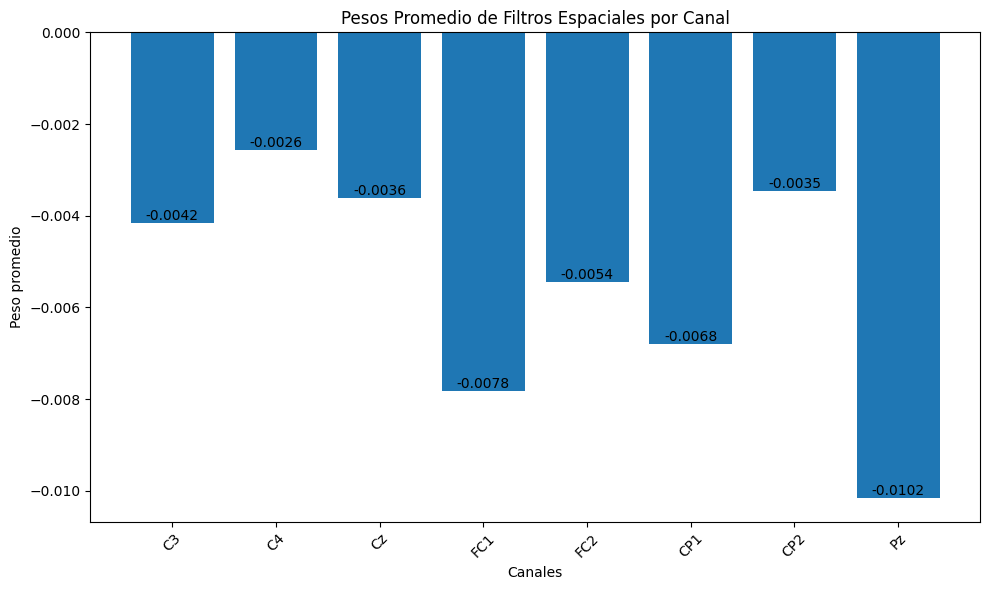


6. Guardando modelo...
Modelo guardado como 'shallow_cnn_pytorch_4classes.pth'


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
import mne
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import gc

# Configuración
PROJ = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

class ShallowCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        """
        ShallowCNN en PyTorch según el paper
        input_shape: (time_steps, channels)
        """
        super(ShallowCNN, self).__init__()
        
        self.time_steps, self.channels = input_shape
        
        # Capa 1: Convolución temporal
        self.temporal_conv = nn.Conv2d(
            in_channels=1,  # Input channels
            out_channels=40,  # 40 filtros
            kernel_size=(30, 1),  # Kernel temporal
            padding=(15, 0),  # 'same' padding para dimensión temporal
            bias=False
        )
        self.temporal_bn = nn.BatchNorm2d(40)
        
        # Capa 2: Convolución espacial
        self.spatial_conv = nn.Conv2d(
            in_channels=40,
            out_channels=40,
            kernel_size=(1, self.channels),  # Kernel espacial
            bias=False
        )
        self.spatial_bn = nn.BatchNorm2d(40)
        
        # Pooling temporal
        self.temporal_pool = nn.AvgPool2d(
            kernel_size=(15, 1),
            stride=(15, 1)
        )
        
        # Calcular tamaño después de convoluciones y pooling
        with torch.no_grad():
            sample = torch.randn(1, 1, self.time_steps, self.channels)
            sample = self.temporal_conv(sample)
            sample = self.spatial_conv(sample)
            sample = self.temporal_pool(sample)
            self.flatten_size = sample.view(1, -1).size(1)
        
        # Capas fully connected
        self.fc1 = nn.Linear(self.flatten_size, 80)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(80, num_classes)
        
    def forward(self, x):
        # x shape: (batch, 1, time_steps, channels)
        
        # Capa temporal
        x = self.temporal_conv(x)
        x = self.temporal_bn(x)
        x = torch.nn.functional.elu(x)
        
        # Capa espacial
        x = self.spatial_conv(x)
        x = self.spatial_bn(x)
        x = torch.nn.functional.elu(x)
        
        # Pooling
        x = self.temporal_pool(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected
        x = torch.nn.functional.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.output(x)
        
        return x

class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def train_model(model, train_loader, val_loader, epochs=100, patience=15):
    """Función de entrenamiento"""
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc = correct / total
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        scheduler.step(val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            model.load_state_dict(best_model_state)
            break
    
    return model, train_losses, val_losses, val_accuracies

def load_and_preprocess_data():
    """Carga y preprocesa los datos"""
    epo_files = list(DATA_PROC.glob('S*_MI-epo.fif'))
    print(f"Encontrados {len(epo_files)} archivos")
    
    X_all = []
    y_all = []
    subject_ids = []
    
    class_mapping = {1: 0, 2: 1, 3: 2, 4: 3}
    class_names = ['Left', 'Right', 'Both Fists', 'Both Feet']
    
    for epo_file in tqdm(epo_files, desc="Cargando archivos"):
        try:
            subject_id = epo_file.stem.split('_')[0]
            epochs = mne.read_epochs(epo_file, verbose=False)
            
            data = epochs.get_data()  # (n_epochs, channels, time_steps)
            events = epochs.events[:, -1]
            
            labels = [class_mapping[event] for event in events if event in class_mapping]
            
            if len(labels) == len(data):
                X_all.append(data)
                y_all.extend(labels)
                subject_ids.extend([subject_id] * len(data))
                
        except Exception as e:
            print(f"Error con {epo_file}: {e}")
            continue
    
    if not X_all:
        raise ValueError("No se pudieron cargar datos válidos")
    
    X = np.concatenate(X_all, axis=0)
    y = np.array(y_all)
    
    print(f"\n=== RESUMEN DE DATOS ===")
    print(f"Datos: {X.shape}")
    print(f"Sujetos: {len(np.unique(subject_ids))}")
    
    for class_id, class_name in enumerate(class_names):
        count = np.sum(y == class_id)
        print(f"  {class_name}: {count} trials ({count/len(y)*100:.1f}%)")
    
    return X, y, subject_ids, class_names

def prepare_data_for_torch(X, y):
    """Prepara datos para PyTorch"""
    # X viene como (n_epochs, channels, time_steps) de MNE
    # Necesitamos: (n_epochs, 1, time_steps, channels) para Conv2d
    
    # Transponer a (n_epochs, time_steps, channels)
    X = np.transpose(X, (0, 2, 1))
    
    # Normalizar por trial
    print("Normalizando datos...")
    for i in range(X.shape[0]):
        X[i] = (X[i] - np.mean(X[i])) / np.std(X[i])
    
    # Añadir dimensión de canal: (n_epochs, 1, time_steps, channels)
    X = X[:, np.newaxis, :, :]
    
    return X, y

def cross_validation_pytorch(X, y, subject_ids, n_splits=5):
    """Validación cruzada con PyTorch"""
    unique_subjects = np.unique(subject_ids)
    print(f"\nRealizando {n_splits}-fold CV con {len(unique_subjects)} sujetos")
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    
    fold = 0
    for train_subj_idx, test_subj_idx in kf.split(unique_subjects):
        fold += 1
        print(f"\n--- Fold {fold}/{n_splits} ---")
        
        # Limpiar memoria
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        # Obtener sujetos para train/test
        train_subjects = unique_subjects[train_subj_idx]
        test_subjects = unique_subjects[test_subj_idx]
        
        train_mask = np.isin(subject_ids, train_subjects)
        test_mask = np.isin(subject_ids, test_subjects)
        
        X_train, X_test = X[train_mask], X[test_mask]
        y_train, y_test = y[train_mask], y[test_mask]
        
        print(f"Train: {X_train.shape}, Test: {X_test.shape}")
        
        # Crear datasets y dataloaders
        train_dataset = EEGDataset(X_train, y_train)
        test_dataset = EEGDataset(X_test, y_test)
        
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        
        # Crear y entrenar modelo
        input_shape = (X.shape[2], X.shape[3])  # (time_steps, channels)
        model = ShallowCNN(input_shape, num_classes=4)
        
        model, train_losses, val_losses, val_accuracies = train_model(
            model, train_loader, test_loader, epochs=100, patience=15
        )
        
        # Evaluar modelo final
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        test_acc = correct / total
        accuracies.append(test_acc)
        
        print(f"Fold {fold} - Accuracy: {test_acc:.4f}")
        
        # Reporte de clasificación
        all_preds = []
        all_true = []
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_true.extend(batch_y.cpu().numpy())
        
        print("Reporte por clase:")
        print(classification_report(all_true, all_preds, 
                                  target_names=['Left', 'Right', 'Both Fists', 'Both Feet']))
        
        # Liberar memoria
        del model, train_loader, test_loader
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    
    return accuracies

def train_final_model(X, y, subject_ids):
    """Entrena el modelo final"""
    # Split por sujetos
    unique_subjects = np.unique(subject_ids)
    split_idx = int(0.8 * len(unique_subjects))
    train_subjects = unique_subjects[:split_idx]
    test_subjects = unique_subjects[split_idx:]
    
    train_mask = np.isin(subject_ids, train_subjects)
    test_mask = np.isin(subject_ids, test_subjects)
    
    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]
    
    print(f"Entrenamiento final: {X_train.shape}")
    print(f"Validación final: {X_test.shape}")
    
    # Crear datasets
    train_dataset = EEGDataset(X_train, y_train)
    test_dataset = EEGDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Crear y entrenar modelo
    input_shape = (X.shape[2], X.shape[3])
    model = ShallowCNN(input_shape, num_classes=4)
    
    model, train_losses, val_losses, val_accuracies = train_model(
        model, train_loader, test_loader, epochs=100, patience=15
    )
    
    # Evaluar final
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    
    final_acc = correct / total
    print(f"Accuracy final: {final_acc:.4f}")
    
    return model, final_acc

def analyze_spatial_filters_pytorch(model, channel_names):
    """Analiza filtros espaciales aprendidos"""
    try:
        # Obtener pesos de la capa espacial
        spatial_weights = model.spatial_conv.weight.data.cpu().numpy()
        print(f"Forma de pesos espaciales: {spatial_weights.shape}")  # (40, 40, 1, 8)
        
        # Promediar sobre los filtros temporales
        spatial_filters = np.mean(spatial_weights, axis=(0, 2))  # (40, 8)
        
        # Promediar sobre los 40 filtros espaciales
        mean_spatial_weights = np.mean(spatial_filters, axis=0)  # (8,)
        
        print("\n=== ANÁLISIS DE FILTROS ESPACIALES ===")
        print("Pesos promedio por canal:")
        for chan, weight in zip(channel_names, mean_spatial_weights):
            print(f"  {chan}: {weight:.4f}")
        
        # Visualizar
        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(len(channel_names)), mean_spatial_weights)
        plt.title('Pesos Promedio de Filtros Espaciales por Canal')
        plt.xlabel('Canales')
        plt.ylabel('Peso promedio')
        plt.xticks(range(len(channel_names)), channel_names, rotation=45)
        
        # Añadir valores en las barras
        for bar, weight in zip(bars, mean_spatial_weights):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                    f'{weight:.4f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error en análisis de filtros: {e}")

def main_pytorch():
    """Función principal con PyTorch"""
    print("=== SHALLOWCNN CON PYTORCH - 4 CLASES ===")
    
    # 1. Cargar datos
    print("\n1. Cargando datos...")
    X, y, subject_ids, class_names = load_and_preprocess_data()
    
    # 2. Preparar datos para PyTorch
    print("\n2. Preparando datos para PyTorch...")
    X_processed, y_processed = prepare_data_for_torch(X, y)
    
    print(f"Forma final de datos: {X_processed.shape}")
    print(f"Distribución de etiquetas: {np.unique(y_processed, return_counts=True)}")
    
    # 3. Validación cruzada
    print("\n3. Validación cruzada...")
    cv_accuracies = cross_validation_pytorch(X_processed, y_processed, subject_ids, n_splits=5)
    
    print(f"\nResultados CV: {cv_accuracies}")
    print(f"Accuracy promedio: {np.mean(cv_accuracies):.4f} ± {np.std(cv_accuracies):.4f}")
    
    # 4. Modelo final
    print("\n4. Entrenando modelo final...")
    final_model, final_acc = train_final_model(X_processed, y_processed, subject_ids)
    
    # 5. Análisis de filtros
    print("\n5. Analizando filtros espaciales...")
    # AJUSTA ESTOS NOMBRES SEGÚN TUS CANALES
    mi8_channels = ['C3', 'C4', 'Cz', 'FC1', 'FC2', 'CP1', 'CP2', 'Pz']
    analyze_spatial_filters_pytorch(final_model, mi8_channels)
    
    # 6. Guardar modelo
    print("\n6. Guardando modelo...")
    torch.save({
        'model_state_dict': final_model.state_dict(),
        'input_shape': (X_processed.shape[2], X_processed.shape[3]),
        'num_classes': 4,
        'accuracy': final_acc
    }, 'shallow_cnn_pytorch_4classes.pth')
    
    print("Modelo guardado como 'shallow_cnn_pytorch_4classes.pth'")
    
    return final_model, cv_accuracies, final_acc

if __name__ == "__main__":
    # Ejecutar versión PyTorch
    model, cv_accs, final_acc = main_pytorch()

In [1]:
# -*- coding: utf-8 -*-
# Shallow CNN (estilo Dose et al. / ShallowConvNet) para MI-EEG (4 clases: L,R,Feet,Hands)
# Cambios clave:
#  - x**2 -> AvgPool -> log(ε + x) (no linealidad de potencia + estabilización log)
#  - Mapeo de etiquetas por archivo a índices GLOBALes fijos [L=0,R=1,Feet=2,Hands=3]
#  - Crop 0.5–3.5 s con epochs.times (robusto al off-by-one)
#  - CUDA + determinismo (CUBLAS_WORKSPACE_CONFIG)
#  - 5-fold inter-sujeto + fine-tuning por sujeto (5 épocas)
#  - Z-score por ensayo (opcional, activado por defecto)

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # determinismo cuBLAS (debe ir antes de importar torch)

import re, random, math
from pathlib import Path
from typing import List, Dict

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score

import mne

# --------------------------- Configuración principal ---------------------------
PROJ = Path('..').resolve().parent
DATA_PROC = PROJ / 'data' / 'processed'
RANDOM_STATE = 42

# Canales MI (orden fijo recomendado)
MI8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

# Entrenamiento / datos
CROP_START = 0.5
CROP_LEN   = 3.0
BATCH_SIZE = 16
EPOCHS_GLOBAL   = 50
EPOCHS_FINETUNE = 5
LR = 1e-3
ZSCORE_PER_TRIAL = True     # <--- pon False si no quieres normalizar por ensayo
VERBOSE_LOADER = True

# CUDA / determinismo
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(RANDOM_STATE)

# --------------------------- Etiquetas globales ---------------------------
CANONICAL_ORDER = ['left', 'right', 'bothfeet', 'bothhands']
GLOBAL_INDEX = {'left':0, 'right':1, 'bothfeet':2, 'bothhands':3}
CLASS_ALIASES = {
    'left':      ('left','l','hand_left','left_fist','t1_left'),
    'right':     ('right','r','hand_right','right_fist','t2_right'),
    'bothfeet':  ('bothfeet','feet','foot','both_feet','t2_feet','feet_both'),
    'bothhands': ('bothhands','hands','both_hands','bothhand','bothfists','both_fists','fists','t1_hands'),
}

# --------------------------- Utilidades de tiempo / crop ---------------------------
def compute_crop_indices_times(times: np.ndarray, crop_start=0.5, crop_len=3.0):
    t0 = crop_start; t1 = crop_start + crop_len
    s = int(np.searchsorted(times, t0, side='left'))
    e = int(np.searchsorted(times, t1, side='right'))
    if e <= s:
        raise ValueError(f"Ventana de crop inválida: [{t0},{t1}] vs times [{times[0]},{times[-1]}]")
    return s, e

# --------------------------- Mapeo de event_id a índices globales ---------------------------
def infer_event_mapping_by_name(event_id: Dict[str,int]) -> Dict[str,int]:
    """ Devuelve {'left': code, 'right': code, 'bothfeet': code, 'bothhands': code} (presentes en ESTE archivo). """
    kl = {k.lower(): v for k, v in event_id.items()}
    out = {}
    for cname in CANONICAL_ORDER:
        for alias in CLASS_ALIASES[cname]:
            for k in kl:
                if alias in k:
                    out[cname] = kl[k]
                    break
            if cname in out:
                break
    return out  # parcial según run (LR u OF)

def event_code_to_global_index(ev_code: int, canonical_map: Dict[str,int]) -> int:
    """ Si ev_code pertenece a alguna clase en canonical_map, devuelve índice GLOBAL fijo. Si no, -1. """
    for cname, code in canonical_map.items():
        if ev_code == code:
            return GLOBAL_INDEX[cname]
    return -1

# --------------------------- Dataset ---------------------------
class MIShallowDataset(Dataset):
    def __init__(self, files: List[Path], crop_start=0.5, crop_len=3.0,
                 pick_channels: List[str] = None, verbose: bool = True,
                 zscore_per_trial: bool = True):
        self.crop_start = crop_start
        self.crop_len   = crop_len
        self.verbose    = verbose
        self.pick_channels = pick_channels
        self.zscore = zscore_per_trial

        self.X, self.y, self.groups = [], [], []
        self._load(files)

        self.X = np.concatenate(self.X, axis=0)       # (N, T, C)
        self.y = np.asarray(self.y, dtype=np.int64)   # ya en índices globales 0..3
        self.groups = np.asarray(self.groups, dtype=np.int64)

        keep = self.y >= 0
        self.X = self.X[keep]; self.y = self.y[keep]; self.groups = self.groups[keep]

    def _load(self, files: List[Path]):
        for fp in files:
            subj = self._subject_id_from_name(fp.name)
            epochs = mne.read_epochs(fp, preload=True, verbose='ERROR')  # (N, ch, T)

            # Forzar orden y selección de canales
            if self.pick_channels is not None:
                # pick exacto y orden fijo; fallará si falta alguno -> ajusta tu lista si es necesario
                epochs.pick(self.pick_channels)

            cmap = infer_event_mapping_by_name(epochs.event_id)
            if self.verbose:
                print(f"[{fp.name}] event_id={epochs.event_id} -> cmap={cmap}")

            data = epochs.get_data()   # (N, C, T) en Voltios
            times = epochs.times
            data = np.transpose(data, (0, 2, 1))  # -> (N, T, C)

            s, e = compute_crop_indices_times(times, self.crop_start, self.crop_len)
            data = data[:, s:e, :]  # (N, Tc, C)

            events = epochs.events[:, 2].astype(int)
            labels = np.array([event_code_to_global_index(ev, cmap) for ev in events], dtype=int)

            keep = labels >= 0
            if self.verbose:
                binc = np.bincount(labels[keep], minlength=4)
                # orden global: [L,R,Feet,Hands]
                print(f"    -> kept {keep.sum()}/{len(labels)} trials | counts[L,R,Feet,Hands]={binc.tolist()}")

            self.X.append(data[keep])
            self.y.extend(labels[keep].tolist())
            self.groups.extend([subj] * int(keep.sum()))

    def _subject_id_from_name(self, fname: str) -> int:
        m = re.search(r'S(\d+)_MI-epo\.fif', fname, re.IGNORECASE)
        return int(m.group(1)) if m else abs(hash(fname)) % (10**6)

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (T,C) en Voltios
        if self.zscore:
            mu = x.mean(axis=0, keepdims=True)
            sd = x.std(axis=0, keepdims=True) + 1e-8
            x = (x - mu) / sd
        x = np.expand_dims(x, axis=0)  # (1,T,C)
        y = self.y[idx]; g = self.groups[idx]
        return torch.from_numpy(x.astype(np.float32)), torch.tensor(y), torch.tensor(g)

# --------------------------- Modelo ---------------------------
class ShallowCNN(nn.Module):
    """
    Temporal conv (40, 30x1, same) -> Spatial conv (40, 1xC) -> **square** -> AvgPool(15,1)
    -> log(eps + x) -> Flatten -> FC(80) -> Softmax
    """
    def __init__(self, n_times: int, n_chans: int, n_classes: int, eps_log: float = 1e-6):
        super().__init__()
        self.eps_log = eps_log
        self.conv_time  = nn.Conv2d(1, 40, kernel_size=(30,1), padding=(15,0), bias=True)
        self.conv_space = nn.Conv2d(40, 40, kernel_size=(1,n_chans), padding=0, bias=True)
        self.avg_pool   = nn.AvgPool2d(kernel_size=(15,1), stride=(15,1))
        t_after_pool    = n_times // 15
        self.flatten    = nn.Flatten()
        self.fc         = nn.Linear(40 * t_after_pool, 80)
        self.out        = nn.Linear(80, n_classes)

    def forward(self, x):
        # x: (B,1,T,C)
        x = self.conv_time(x)      # (B,40,T,C)
        x = self.conv_space(x)     # (B,40,T,1)
        x = x ** 2                 # potencia
        x = self.avg_pool(x)       # (B,40,T//15,1)
        x = torch.log(x + self.eps_log)  # estabilización log
        x = self.flatten(x)
        x = self.fc(x)
        x = self.out(x)            # logits
        return x

# --------------------------- Train / Eval ---------------------------
def train_one_epoch(model, loader, optim, criterion):
    model.train(); tot, n = 0.0, 0
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optim.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb.long())
        loss.backward(); optim.step()
        bs = yb.size(0); tot += loss.item()*bs; n += bs
    return tot / max(1,n)

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); preds, gold = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        gold  += yb.tolist()
    return accuracy_score(gold, preds)

# --------------------------- Pipeline CV + Fine-tune ---------------------------
def run_experiment(data_dir: Path,
                   pick_channels: List[str],
                   n_splits=5,
                   epochs_global=EPOCHS_GLOBAL,
                   epochs_finetune=EPOCHS_FINETUNE,
                   lr=LR,
                   verbose_loader=VERBOSE_LOADER,
                   zscore_per_trial=ZSCORE_PER_TRIAL):
    files = sorted(DATA_PROC.glob('S*_MI-epo.fif'))
    assert len(files) > 0, f"No se encontraron archivos en {DATA_PROC}/S*_MI-epo.fif"

    ds = MIShallowDataset(files, crop_start=CROP_START, crop_len=CROP_LEN,
                          pick_channels=pick_channels, verbose=verbose_loader,
                          zscore_per_trial=zscore_per_trial)
    n_samples, T, C = ds.X.shape[0], ds.X.shape[1], ds.X.shape[2]
    n_classes = 4  # global
    print(f"Dataset: N={n_samples} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(ds.groups))}")

    gkf = GroupKFold(n_splits=n_splits)
    acc_global_folds, acc_finetune_folds = [], []

    g = torch.Generator(); g.manual_seed(RANDOM_STATE)

    for fold, (tr_idx, te_idx) in enumerate(gkf.split(ds.X, ds.y, ds.groups), 1):
        tr_subset, te_subset = Subset(ds, tr_idx), Subset(ds, te_idx)
        tr_loader = DataLoader(tr_subset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
        te_loader = DataLoader(te_subset, batch_size=BATCH_SIZE, shuffle=False)

        set_seeds(RANDOM_STATE + fold)
        model = ShallowCNN(n_times=T, n_chans=C, n_classes=n_classes).to(DEVICE)
        optim = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # validación interna 10% para early stopping ligero
        n_tr = len(tr_idx)
        val_count = max(1, int(0.1*n_tr))
        rng = np.random.default_rng(RANDOM_STATE)
        perm = rng.permutation(tr_idx)
        val_ids, train_ids = perm[:val_count], perm[val_count:]
        tr2_loader = DataLoader(Subset(ds, train_ids), batch_size=BATCH_SIZE, shuffle=True, generator=g)
        va2_loader = DataLoader(Subset(ds, val_ids),   batch_size=BATCH_SIZE, shuffle=False)

        best_val, best_state = 0.0, None
        patience, noimp = 8, 0
        for _ in range(epochs_global):
            train_one_epoch(model, tr2_loader, optim, criterion)
            va = evaluate(model, va2_loader)
            if va > best_val + 1e-4:
                best_val, best_state, noimp = va, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
            else:
                noimp += 1
            if noimp >= patience: break
        if best_state is not None: model.load_state_dict(best_state)

        # Test global
        acc_global = evaluate(model, te_loader)
        acc_global_folds.append(acc_global)

        # Fine-tune por sujeto
        subjects_test = np.unique(ds.groups[te_idx])
        acc_per_subject = []
        for subj in subjects_test:
            subj_idx = np.array(te_idx)[ds.groups[te_idx] == subj]
            y_subj = ds.y[subj_idx]
            skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
            acc_sub = []
            for tr_s, va_s in skf.split(subj_idx, y_subj):
                tr_ids, va_ids = subj_idx[tr_s], subj_idx[va_s]
                tr_s_loader = DataLoader(Subset(ds, tr_ids), batch_size=BATCH_SIZE, shuffle=True, generator=g)
                va_s_loader = DataLoader(Subset(ds, va_ids), batch_size=BATCH_SIZE, shuffle=False)

                subj_model = ShallowCNN(n_times=T, n_chans=C, n_classes=n_classes).to(DEVICE)
                subj_model.load_state_dict(model.state_dict())
                subj_opt = torch.optim.Adam(subj_model.parameters(), lr=lr)
                subj_crit = nn.CrossEntropyLoss()

                for _ in range(epochs_finetune):
                    train_one_epoch(subj_model, tr_s_loader, subj_opt, subj_crit)
                acc_va = evaluate(subj_model, va_s_loader)
                acc_sub.append(acc_va)
            acc_per_subject.append(float(np.mean(acc_sub)))
        acc_finetune_folds.append(float(np.mean(acc_per_subject)))

        print(f"[Fold {fold}/{n_splits}] Global acc={acc_global:.4f} | Fine-tune mean acc={acc_finetune_folds[-1]:.4f}")

    results = {
        "acc_global_folds": acc_global_folds,
        "acc_finetune_folds": acc_finetune_folds,
        "acc_global_mean": float(np.mean(acc_global_folds)),
        "acc_finetune_mean": float(np.mean(acc_finetune_folds))
    }
    print("\nResumen:")
    print("Global folds:", [f"{a:.4f}" for a in results["acc_global_folds"]])
    print("Fine-tune folds:", [f"{a:.4f}" for a in results["acc_finetune_folds"]])
    print(f"Global mean: {results['acc_global_mean']:.4f}")
    print(f"Fine-tune mean: {results['acc_finetune_mean']:.4f}")
    return results

# --------------------------- Ejecución ---------------------------
# RECOMENDADO: forzar orden de 8 canales coherente entre sujetos
if __name__ == "__main__":
    results = run_experiment(DATA_PROC,
                             pick_channels=MI8,
                             n_splits=5,
                             epochs_global=EPOCHS_GLOBAL,
                             epochs_finetune=EPOCHS_FINETUNE,
                             lr=LR,
                             verbose_loader=VERBOSE_LOADER,
                             zscore_per_trial=ZSCORE_PER_TRIAL)


🚀 Usando dispositivo: cuda
[S001_MI-epo.fif] event_id={'Left': 1, 'Right': 2, 'Both Fists': 3, 'Both Feet': 4} -> cmap={'left': 1, 'right': 2, 'bothfeet': 4, 'bothhands': 3}
    -> kept 90/90 trials | counts[L,R,Feet,Hands]=[23, 22, 24, 21]
[S002_MI-epo.fif] event_id={'Left': 1, 'Right': 2, 'Both Fists': 3, 'Both Feet': 4} -> cmap={'left': 1, 'right': 2, 'bothfeet': 4, 'bothhands': 3}
    -> kept 84/84 trials | counts[L,R,Feet,Hands]=[21, 21, 21, 21]
[S003_MI-epo.fif] event_id={'Left': 1, 'Right': 2, 'Both Fists': 3, 'Both Feet': 4} -> cmap={'left': 1, 'right': 2, 'bothfeet': 4, 'bothhands': 3}
    -> kept 90/90 trials | counts[L,R,Feet,Hands]=[23, 22, 24, 21]
[S004_MI-epo.fif] event_id={'Left': 1, 'Right': 2, 'Both Fists': 3, 'Both Feet': 4} -> cmap={'left': 1, 'right': 2, 'bothfeet': 4, 'bothhands': 3}
    -> kept 84/84 trials | counts[L,R,Feet,Hands]=[21, 21, 21, 21]
[S005_MI-epo.fif] event_id={'Left': 1, 'Right': 2, 'Both Fists': 3, 'Both Feet': 4} -> cmap={'left': 1, 'right': 2, '

In [8]:
import numpy as np
import torch
import mne
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración de plotting
plt.rcParams['figure.figsize'] = [12, 8]
sns.set_style("whitegrid")

def comprehensive_data_analysis(data_path):
    """Análisis comprehensivo de todos los sujetos"""
    print("🔍 INICIANDO ANÁLISIS COMPLETO DE DATOS")
    print("=" * 60)
    
    available_subjects = find_available_subjects(data_path)
    print(f"📁 Sujetos disponibles: {len(available_subjects)}")
    print(f"📋 Lista: {available_subjects}")
    
    analysis_results = []
    
    for subject_num in tqdm(available_subjects, desc="Analizando sujetos"):
        subject_info = analyze_single_subject(data_path, subject_num)
        if subject_info:
            analysis_results.append(subject_info)
    
    if not analysis_results:
        print("❌ No se encontraron datos válidos")
        return
    
    # Crear DataFrame con todos los resultados
    df = pd.DataFrame(analysis_results)
    
    # ANÁLISIS GENERAL
    print("\n" + "=" * 60)
    print("📊 ESTADÍSTICAS GENERALES")
    print("=" * 60)
    
    print(f"👥 Total de sujetos analizados: {len(df)}")
    print(f"📈 Trials por sujeto: {df['num_trials'].mean():.1f} ± {df['num_trials'].std():.1f}")
    print(f"📊 Rango de trials: {df['num_trials'].min()} - {df['num_trials'].max()}")
    
    # Distribución de clases
    total_trials = df['num_trials'].sum()
    class_distribution = df[['class_0', 'class_1', 'class_2', 'class_3']].sum()
    class_percentages = (class_distribution / total_trials) * 100
    
    print(f"\n🎯 DISTRIBUCIÓN DE CLASES:")
    for i, (count, percent) in enumerate(zip(class_distribution, class_percentages)):
        print(f"   Clase {i}: {count} trials ({percent:.1f}%)")
    
    # Calidad de datos
    print(f"\n📉 SUJETOS CON POCOS TRIALS (< 40):")
    low_trial_subjects = df[df['num_trials'] < 40]['subject_id'].tolist()
    print(f"   {len(low_trial_subjects)} sujetos: {low_trial_subjects}")
    
    print(f"\n📊 SUJETOS CON DESBALANCE EXTREMO (>70% en una clase):")
    balanced_subjects = []
    imbalanced_subjects = []
    
    for _, row in df.iterrows():
        max_class_pct = max([row['class_0_pct'], row['class_1_pct'], row['class_2_pct'], row['class_3_pct']])
        if max_class_pct > 70:
            imbalanced_subjects.append(row['subject_id'])
        else:
            balanced_subjects.append(row['subject_id'])
    
    print(f"   Desbalanceados: {len(imbalanced_subjects)} sujetos")
    print(f"   Balanceados: {len(balanced_subjects)} sujetos")
    
    # GRÁFICOS
    create_analysis_plots(df, class_distribution)
    
    # RECOMENDACIONES
    print("\n" + "=" * 60)
    print("💡 RECOMENDACIONES")
    print("=" * 60)
    
    if len(low_trial_subjects) > 0:
        print(f"❌ Excluir {len(low_trial_subjects)} sujetos con pocos trials: {low_trial_subjects}")
    
    if len(imbalanced_subjects) > 0:
        print(f"⚠️  Considerar técnicas de balanceo para {len(imbalanced_subjects)} sujetos desbalanceados")
    
    avg_trials = df['num_trials'].mean()
    if avg_trials < 60:
        print(f"⚠️  Pocos trials en promedio ({avg_trials:.1f}). Considerar data augmentation")
    
    # Sujetos recomendados para empezar
    good_subjects = df[
        (df['num_trials'] >= 50) & 
        (df['max_class_pct'] < 70)
    ]['subject_id'].tolist()
    
    print(f"✅ {len(good_subjects)} sujetos recomendados para empezar: {good_subjects[:10]}...")
    
    # Guardar análisis completo
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    df.to_csv(f'data_analysis_comprehensive_{timestamp}.csv', index=False)
    print(f"\n💾 Análisis guardado: data_analysis_comprehensive_{timestamp}.csv")
    
    return df

def analyze_single_subject(data_path, subject_number):
    """Análisis detallado de un solo sujeto"""
    subject_id = f"S{subject_number:03d}"
    
    try:
        # Cargar datos
        file_pattern = f"{subject_id}_MI-epo.fif"
        fif_files = list(data_path.glob(file_pattern))
        
        if not fif_files:
            return None
        
        epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
        data = epochs.get_data()
        events = epochs.events[:, -1] - 1
        
        # Información básica
        num_trials = len(data)
        num_channels = data.shape[1]
        time_points = data.shape[2]
        sfreq = epochs.info['sfreq']
        
        # Distribución de clases
        class_counts = np.bincount(events, minlength=4)
        class_percentages = (class_counts / num_trials) * 100
        
        # Calidad de señal (varianza por trial)
        signal_variance = np.var(data, axis=(1, 2))
        avg_variance = np.mean(signal_variance)
        std_variance = np.std(signal_variance)
        
        # Detección de outliers (trials con varianza muy alta/baja)
        variance_threshold_high = avg_variance + 3 * std_variance
        variance_threshold_low = avg_variance - 3 * std_variance
        outlier_trials = np.sum((signal_variance > variance_threshold_high) | 
                               (signal_variance < variance_threshold_low))
        
        subject_info = {
            'subject_id': subject_id,
            'num_trials': num_trials,
            'num_channels': num_channels,
            'time_points': time_points,
            'sfreq': sfreq,
            'class_0': class_counts[0],
            'class_1': class_counts[1],
            'class_2': class_counts[2],
            'class_3': class_counts[3],
            'class_0_pct': class_percentages[0],
            'class_1_pct': class_percentages[1],
            'class_2_pct': class_percentages[2],
            'class_3_pct': class_percentages[3],
            'avg_variance': avg_variance,
            'outlier_trials': outlier_trials,
            'max_class_pct': max(class_percentages),
            'min_class_pct': min(class_percentages),
            'is_balanced': max(class_percentages) < 70,  # Menos del 70% en una clase
            'has_enough_trials': num_trials >= 40
        }
        
        return subject_info
        
    except Exception as e:
        print(f"❌ Error analizando {subject_id}: {e}")
        return None

def create_analysis_plots(df, class_distribution):
    """Crear gráficos de análisis"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('ANÁLISIS COMPLETO DE DATOS EEG - IMAGINERÍA MOTORA', fontsize=16, fontweight='bold')
    
    # 1. Distribución de trials por sujeto
    axes[0, 0].hist(df['num_trials'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].axvline(df['num_trials'].mean(), color='red', linestyle='--', label=f'Media: {df["num_trials"].mean():.1f}')
    axes[0, 0].set_xlabel('Número de Trials')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].set_title('Distribución de Trials por Sujeto')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Distribución de clases global
    class_labels = ['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3']
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
    axes[0, 1].pie(class_distribution, labels=class_labels, autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0, 1].set_title('Distribución Global de Clases')
    
    # 3. Balance por sujeto (max class percentage)
    axes[0, 2].hist(df['max_class_pct'], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[0, 2].axvline(70, color='red', linestyle='--', linewidth=2, label='Límite desbalance (70%)')
    axes[0, 2].axvline(df['max_class_pct'].mean(), color='blue', linestyle='--', label=f'Media: {df["max_class_pct"].mean():.1f}%')
    axes[0, 2].set_xlabel('Porcentaje de la Clase Mayoritaria (%)')
    axes[0, 2].set_ylabel('Frecuencia')
    axes[0, 2].set_title('Balance de Clases por Sujeto')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Varianza de señal por sujeto
    axes[1, 0].scatter(df['subject_id'], df['avg_variance'], alpha=0.6, color='purple')
    axes[1, 0].axhline(df['avg_variance'].mean(), color='red', linestyle='--', label=f'Media: {df["avg_variance"].mean():.2e}')
    axes[1, 0].set_xlabel('Sujeto')
    axes[1, 0].set_ylabel('Varianza Promedio')
    axes[1, 0].set_title('Calidad de Señal por Sujeto (Varianza)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Trials outliers por sujeto
    axes[1, 1].bar(df['subject_id'], df['outlier_trials'], alpha=0.7, color='orange')
    axes[1, 1].set_xlabel('Sujeto')
    axes[1, 1].set_ylabel('Número de Trials Outliers')
    axes[1, 1].set_title('Trials con Señal Anómala por Sujeto')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Clasificación de sujetos por calidad
    quality_categories = []
    for _, row in df.iterrows():
        if row['num_trials'] < 40:
            quality_categories.append('Pocos Trials')
        elif row['max_class_pct'] > 70:
            quality_categories.append('Desbalanceado')
        elif row['outlier_trials'] > row['num_trials'] * 0.1:
            quality_categories.append('Ruidoso')
        else:
            quality_categories.append('Buena Calidad')
    
    quality_counts = pd.Series(quality_categories).value_counts()
    axes[1, 2].pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1, 2].set_title('Clasificación de Calidad por Sujeto')
    
    plt.tight_layout()
    plt.savefig('data_quality_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

def find_available_subjects(data_path):
    """Encontrar todos los sujetos disponibles"""
    available_subjects = []
    excluded = {38, 88, 89, 92, 100, 104}
    fif_files = list(data_path.glob("S*_MI-epo.fif"))
    
    for fif_file in fif_files:
        subject_str = fif_file.name.split('_')[0][1:]
        try:
            subject_num = int(subject_str)
            if subject_num not in excluded:
                available_subjects.append(subject_num)
        except ValueError:
            continue
    
    available_subjects.sort()
    return available_subjects

def quick_data_overview(data_path):
    """Vista rápida de los datos"""
    print("🚀 VISTA RÁPIDA DE DATOS")
    print("=" * 40)
    
    available_subjects = find_available_subjects(data_path)
    print(f"📁 Sujetos encontrados: {len(available_subjects)}")
    
    # Muestra de los primeros 5 sujetos
    for subject_num in available_subjects[:5]:
        subject_id = f"S{subject_num:03d}"
        try:
            file_pattern = f"{subject_id}_MI-epo.fif"
            fif_files = list(data_path.glob(file_pattern))
            epochs = mne.read_epochs(fif_files[0], verbose=False, preload=True)
            data = epochs.get_data()
            events = epochs.events[:, -1] - 1
            
            print(f"\n🔍 {subject_id}:")
            print(f"   📊 Trials: {len(data)}")
            print(f"   📈 Canales: {data.shape[1]}")
            print(f"   ⏱️  Puntos de tiempo: {data.shape[2]}")
            print(f"   🎯 Clases: {np.bincount(events)}")
            print(f"   📍 Distribución: {np.bincount(events) / len(events) * 100:.1f}%")
            
        except Exception as e:
            print(f"❌ Error en {subject_id}: {e}")

# EJECUTAR ANÁLISIS
if __name__ == "__main__":
    # Configurar path de datos
    PROJ = Path('..').resolve().parent
    DATA_PROC = PROJ / 'data' / 'processed'
    
    print("🎯 ANÁLISIS DE DATOS EEG - IMAGINERÍA MOTORA")
    print("=" * 50)
    
    # 1. Vista rápida
    quick_data_overview(DATA_PROC)
    
    print("\n" + "=" * 50)
    print("🔍 INICIANDO ANÁLISIS COMPLETO...")
    print("=" * 50)
    
    # 2. Análisis completo
    df_results = comprehensive_data_analysis(DATA_PROC)
    
    if df_results is not None:
        print(f"\n✅ Análisis completado para {len(df_results)} sujetos")
        print("📊 Resumen rápido:")
        print(f"   - Trials totales: {df_results['num_trials'].sum()}")
        print(f"   - Sujetos con buena calidad: {df_results['is_balanced'].sum()}")
        print(f"   - Trials promedio: {df_results['num_trials'].mean():.1f}")
    else:
        print("❌ No se pudo completar el análisis")

🎯 ANÁLISIS DE DATOS EEG - IMAGINERÍA MOTORA
🚀 VISTA RÁPIDA DE DATOS
📁 Sujetos encontrados: 103

🔍 S001:
   📊 Trials: 90
   📈 Canales: 8
   ⏱️  Puntos de tiempo: 641
   🎯 Clases: [23 22 21 24]
❌ Error en S001: unsupported format string passed to numpy.ndarray.__format__

🔍 S002:
   📊 Trials: 84
   📈 Canales: 8
   ⏱️  Puntos de tiempo: 641
   🎯 Clases: [21 21 21 21]
❌ Error en S002: unsupported format string passed to numpy.ndarray.__format__

🔍 S003:
   📊 Trials: 90
   📈 Canales: 8
   ⏱️  Puntos de tiempo: 641
   🎯 Clases: [23 22 21 24]
❌ Error en S003: unsupported format string passed to numpy.ndarray.__format__

🔍 S004:
   📊 Trials: 84
   📈 Canales: 8
   ⏱️  Puntos de tiempo: 641
   🎯 Clases: [21 21 21 21]
❌ Error en S004: unsupported format string passed to numpy.ndarray.__format__

🔍 S005:
   📊 Trials: 84
   📈 Canales: 8
   ⏱️  Puntos de tiempo: 641
   🎯 Clases: [21 21 21 21]
❌ Error en S005: unsupported format string passed to numpy.ndarray.__format__

🔍 INICIANDO ANÁLISIS COMPLETO

Analizando sujetos: 100%|██████████| 103/103 [00:00<00:00, 133.15it/s]



📊 ESTADÍSTICAS GENERALES
👥 Total de sujetos analizados: 103
📈 Trials por sujeto: 85.0 ± 5.0
📊 Rango de trials: 42 - 90

🎯 DISTRIBUCIÓN DE CLASES:
   Clase 0: 2194 trials (25.1%)
   Clase 1: 2174 trials (24.8%)
   Clase 2: 2183 trials (24.9%)
   Clase 3: 2199 trials (25.1%)

📉 SUJETOS CON POCOS TRIALS (< 40):
   0 sujetos: []

📊 SUJETOS CON DESBALANCE EXTREMO (>70% en una clase):
   Desbalanceados: 0 sujetos
   Balanceados: 103 sujetos



💡 RECOMENDACIONES
✅ 102 sujetos recomendados para empezar: ['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010']...

💾 Análisis guardado: data_analysis_comprehensive_20251012_000034.csv

✅ Análisis completado para 103 sujetos
📊 Resumen rápido:
   - Trials totales: 8750
   - Sujetos con buena calidad: 103
   - Trials promedio: 85.0


In [3]:
# -*- coding: utf-8 -*-
# 4-clases desde RAW EDF (fiel al paper: sin notch, sin CAR, sin ICA, sin band-pass)
# Clases: left=0, right=1, bothfeet=2, bothhands=3
# Epochs: 0.5–4.5 s, crop interno 0.5–3.5 s
# Modelo: ShallowCNN con x**2 -> AvgPool(15,1) -> log(ε+x)
# CV: 5-fold inter-sujeto + fine-tune por sujeto (5 épocas)
# CUDA + determinismo (CUBLAS_WORKSPACE_CONFIG)

import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # determinismo cuBLAS (definir ANTES de importar torch)

import re, random
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import accuracy_score

import mne

# ---------------------- CONFIG PRINCIPAL ----------------------
PROJ = Path('..').resolve().parent  # ajusta si ejecutas desde otro directorio
DATA_RAW  = PROJ / 'data' / 'raw'
DATA_TMP  = PROJ / 'data' / 'tmp_raw4c'
DATA_TMP.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Sujetos con problemas de anotación (PhysioNet)
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs MI
MI_RUNS_LR = [4, 8, 12]   # Left/Right
MI_RUNS_OF = [6, 10, 14]  # Both Hands/Feet

# Ventanas
TMIN, TMAX = 0.5, 4.5
CROP_START, CROP_LEN = 0.5, 3.0  # 0.5–3.5 s

# Canales MI (8) — puedes poner False para usar todos los EEG
PICK_MI8 = False
MI8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

# Entrenamiento
BATCH_SIZE = 16
EPOCHS_GLOBAL   = 50
EPOCHS_FINETUNE = 5
LR = 1e-3

# Normalización por ensayo (mantener False para ser “paper-like”)
ZSCORE_PER_TRIAL = False

# ---------------------- UTILIDADES ----------------------
def set_seeds(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seeds(RANDOM_STATE)

# Regex para SxxxRyy
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')
def parse_subject_run(path: Path) -> Tuple[int,int]:
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    return None

def list_subjects_raw():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if sdir.is_dir():
            try:
                sid = int(sdir.name[1:])
                if sid not in EXCLUDE_SUBJECTS: subs.append(sid)
            except: pass
    return subs

# ---- NORMALIZACIÓN DE NOMBRES DE CANAL (robusta a 'Fc3.', 'Cz..', 'Cpz.', etc.) ----
import re as _re

def edf_to_1010_name(edf_name: str) -> str:
    """
    Convierte variantes típicas de EDF a 10–20:
      - Quita puntos, guiones, espacios y sufijos (REF/LE/A1/A2).
      - 'C03'->'C3'; 'CZ'->'Cz'; 'CPZ'->'CPz'; conserva dígitos.
      - Asegura z minúscula al final.
    """
    n = edf_name.strip()

    # Elimina sufijos y basura al final, y separadores
    n = _re.sub(r'[-_.]+$', '', n)
    n = _re.sub(r'[-_.]?(REF|LE|A1|A2)$', '', n, flags=_re.I)

    # Reemplaza separadores por nada
    n = n.replace('-', ' ').replace('.', ' ')
    n = _re.sub(r'\s+', ' ', n).strip()

    # Quita prefijos tipo "EEG "
    n = _re.sub(r'^EEG\s+', '', n, flags=_re.I)

    # Sin espacios
    n = n.replace(' ', '')

    # Mayúsculas base
    n = n.upper()

    # Ceros a la izquierda en etiquetas tipo C03 -> C3
    n = _re.sub(r'([A-Z])0+([0-9])', r'\1\2', n)

    # Fuerza 'z' minúscula al final si termina en Z (CZ->Cz, CPZ->CPz)
    if n.endswith('Z'):
        n = n[:-1] + 'z'

    # Correcciones puntuales frecuentes
    # Fp en minúscula p (Fp1, Fpz...)
    n = n.replace('FP', 'Fp') if n.startswith('FP') else n
    # 10–20 moderno: T3/T4 -> T7/T8 (por si aparecieran)
    if n == 'T3': n = 'T7'
    if n == 'T4': n = 'T8'

    return n

def normalize_channel_names_inplace(raw: mne.io.BaseRaw):
    mapping = {ch: edf_to_1010_name(ch) for ch in raw.ch_names}
    mne.rename_channels(raw.info, mapping)

# Eventos → índices globales
GLOBAL_INDEX = {'left':0, 'right':1, 'bothfeet':2, 'bothhands':3}

def build_events_from_annotations(raw: mne.io.BaseRaw, kind: str):
    """Devuelve (events, event_id_map, fuente)."""
    def _norm_tag(s: str) -> str:
        return str(s).strip().upper().replace(' ', '')
    sf = float(raw.info['sfreq'])

    T1, T2 = [], []
    if raw.annotations is not None and len(raw.annotations) > 0:
        onsets_sec = list(raw.annotations.onset)
        desc_norm  = [_norm_tag(d) for d in raw.annotations.description]
        T1 = [float(t) for t,d in zip(onsets_sec, desc_norm) if d == 'T1']
        T2 = [float(t) for t,d in zip(onsets_sec, desc_norm) if d == 'T2']

    def _dedup(sorted_list, min_gap_sec=0.5):
        keep, last = [], None
        for x in sorted(sorted_list):
            if last is None or (x - last) >= min_gap_sec:
                keep.append(x); last = x
        return keep

    T1, T2 = _dedup(T1), _dedup(T2)
    if len(T1) > 0 and len(T2) > 0:
        if kind == 'LR':
            event_id = {'Left':1, 'Right':2}
        else:
            event_id = {'Both Hands':3, 'Both Feet':4}
        events = []
        for t in T1:
            code = 1 if kind=='LR' else 3
            events.append([int(round((raw.first_time + t) * sf)), 0, code])
        for t in T2:
            code = 2 if kind=='LR' else 4
            events.append([int(round((raw.first_time + t) * sf)), 0, code])
        events = np.asarray(sorted(events, key=lambda r: r[0]), dtype=int)
        return events, event_id, "annotations"

    # Fallback .event
    ev_path = Path(str(raw.filenames[0]) + ".event")
    if ev_path.exists():
        rows = []
        with open(ev_path, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    try:
                        onset = float(parts[0]); tag = parts[1].strip().upper().replace(' ','')
                        rows.append((onset, tag))
                    except: pass
        if rows:
            evlist = []
            for onset_sec, tag in rows:
                if tag == 'T1':
                    code = 1 if kind=='LR' else 3
                elif tag == 'T2':
                    code = 2 if kind=='LR' else 4
                else:
                    continue
                evlist.append([int(round((raw.first_time + onset_sec) * sf)), 0, code])
            if evlist:
                evlist.sort(key=lambda r: r[0])
                compact, last_by_code = [], {}
                for s,_,c in evlist:
                    last = last_by_code.get(c, -1e9)
                    if (s - last) >= int(0.5 * sf):
                        compact.append([s,0,c]); last_by_code[c] = s
                events = np.asarray(compact, dtype=int)
                event_id = {'Left':1,'Right':2} if kind=='LR' else {'Both Hands':3,'Both Feet':4}
                return events, event_id, ".edf.event"

    raise RuntimeError("No se hallaron T1/T2 en anotaciones ni fallback .event.")

def compute_crop_indices_times(times: np.ndarray, crop_start=0.5, crop_len=3.0):
    t0, t1 = crop_start, crop_start + crop_len
    s = int(np.searchsorted(times, t0, side='left'))
    e = int(np.searchsorted(times, t1, side='right'))
    if e <= s:
        raise ValueError(f"Crop inválido [{t0},{t1}] en rango [{times[0]},{times[-1]}]")
    return s, e

# ---------------------- Fase 1: construir epochs “mínimos” por sujeto ----------------------
def build_minimal_epochs_for_subject(s: int, pick_mi8=PICK_MI8) -> Path:
    subj_dir = DATA_RAW / f"S{s:03d}"
    edfs = []
    for r in sorted(MI_RUNS_LR + MI_RUNS_OF):
        p = subj_dir / f"S{s:03d}R{r:02d}.edf"
        if p.exists(): edfs.append(p)
    if not edfs:
        raise RuntimeError(f"S{s:03d}: sin runs MI.")

    epochs_list = []
    template_ch = None
    for p in edfs:
        raw = mne.io.read_raw_edf(p, preload=True, verbose=False)
        raw.pick(mne.pick_types(raw.info, eeg=True))

        # ---- NORMALIZAR NOMBRES DE CANAL AQUÍ ----
        normalize_channel_names_inplace(raw)

        # (Opcional) restringir a MI8 (sin filtros, solo pick)
        if pick_mi8:
            keep = [ch for ch in MI8 if ch in raw.ch_names]
            if len(keep) < 6:
                print(f"  [WARN] S{s:03d} {p.name}: MI8 encontrados {keep} | ejemplo_ch={raw.ch_names[:10]}")
                print(f"        (tiene {len(keep)}/8). Se salta este run.")
                continue
            raw.pick_channels(keep)

        # Eventos
        _, run_id = parse_subject_run(p)
        kind = run_kind(run_id)
        if kind is None:
            print(f"  [WARN] {p.name}: no es run MI. Saltando.")
            continue
        events, event_id, src = build_events_from_annotations(raw, kind)

        # Epoching 0.5–4.5 s
        ep = mne.Epochs(raw, events, event_id=event_id,
                        tmin=TMIN, tmax=TMAX,
                        baseline=None, picks='eeg',
                        preload=True, reject_by_annotation=False, verbose=False)

        # Unificar orden de canales dentro del sujeto
        if template_ch is None:
            template_ch = ep.ch_names.copy()
        elif ep.ch_names != template_ch:
            ep = ep.copy().reorder_channels(template_ch)

        if len(ep) > 0:
            epochs_list.append(ep)
        print(f"  {p.name}: {len(ep)} epochs (fuente eventos: {src})")

    if not epochs_list:
        raise RuntimeError(f"S{s:03d}: no quedó ningún run válido.")

    # Concatenar sujeto y re-etiquetar a índices globales 0..3
    E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')

    # Mapear 1..4 → nombres canónicos → índices globales
    name2global = {
        'Left':'left', 'Right':'right',
        'Both Feet':'bothfeet',
        'Both Fists':'bothhands', 'Both Hands':'bothhands'
    }
    codes = E.events[:,2]
    labels = []
    for c in codes:
        name = None
        for k,v in E.event_id.items():
            if v == c: name = k; break
        if name is None:
            labels.append(-1); continue
        canon = name2global.get(name, None)
        labels.append(GLOBAL_INDEX[canon] if canon in GLOBAL_INDEX else -1)
    labels = np.asarray(labels, dtype=int)
    keep_mask = labels >= 0
    E = E[keep_mask]
    E.events[:,2] = labels[keep_mask] + 1  # se guarda 1..4 por compatibilidad MNE

    out_fif = DATA_TMP / f"S{s:03d}_MIraw4c-epo.fif"
    E.save(out_fif, overwrite=True)
    print(f"  Guardado {out_fif} (epochs={len(E)}, ch={len(E.ch_names)})")
    return out_fif

def build_minimal_epochs_all():
    paths = []
    for s in list_subjects_raw():
        try:
            print(f"\n▶ Sujeto S{s:03d}")
            paths.append(build_minimal_epochs_for_subject(s))
        except Exception as e:
            print(f"  [SKIP] S{s:03d}: {e}")
    return paths

# ---------------------- Fase 2: Dataset y Modelo ----------------------
class RawFourClassDataset(Dataset):
    def __init__(self, fif_files: List[Path], crop_start=0.5, crop_len=3.0,
                 zscore_per_trial: bool = ZSCORE_PER_TRIAL):
        self.fifs = fif_files
        self.crop_start = crop_start
        self.crop_len = crop_len
        self.zscore = zscore_per_trial

        Xs, ys, gs = [], [], []
        for fp in self.fifs:
            mne.set_log_level('WARNING')
            ep = mne.read_epochs(fp, preload=True, verbose='ERROR')  # (N,C,T)
            y = ep.events[:,2] - 1
            X = ep.get_data()            # (N,C,T)
            X = np.transpose(X, (0,2,1)) # (N,T,C)
            s, e = compute_crop_indices_times(ep.times, crop_start, crop_len)
            X = X[:, s:e, :]

            # Subject id desde filename
            m = re.search(r'S(\d{3})_', fp.name); sid = int(m.group(1)) if m else 0
            g = np.full((len(y),), sid, dtype=int)

            Xs.append(X); ys.append(y); gs.append(g)

        self.X = np.concatenate(Xs, axis=0)
        self.y = np.concatenate(ys, axis=0)
        self.groups = np.concatenate(gs, axis=0)
        print(f"Dataset construido: N={len(self.y)} | T={self.X.shape[1]} | C={self.X.shape[2]} | clases={len(np.unique(self.y))}")

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (T,C)
        if self.zscore:
            mu = x.mean(axis=0, keepdims=True)
            sd = x.std(axis=0, keepdims=True) + 1e-8
            x = (x - mu) / sd
        x = np.expand_dims(x, axis=0)  # (1,T,C)
        y = int(self.y[idx])
        g = int(self.groups[idx])
        return torch.from_numpy(x.astype(np.float32)), torch.tensor(y), torch.tensor(g)

class ShallowCNN(nn.Module):
    # Temporal conv (40, 30x1, same) -> Spatial conv (40, 1xC) -> square -> AvgPool(15,1)
    # -> log(eps + x) -> Flatten -> FC(80) -> Softmax
    def __init__(self, n_times: int, n_chans: int, n_classes: int, eps_log: float = 1e-6):
        super().__init__()
        self.eps_log = eps_log
        self.conv_time  = nn.Conv2d(1, 40, kernel_size=(30,1), padding=(15,0), bias=True)
        self.conv_space = nn.Conv2d(40, 40, kernel_size=(1,n_chans), padding=0, bias=True)
        self.avg_pool   = nn.AvgPool2d(kernel_size=(15,1), stride=(15,1))
        t_after_pool    = n_times // 15
        self.flatten    = nn.Flatten()
        self.fc         = nn.Linear(40 * t_after_pool, 80)
        self.out        = nn.Linear(80, n_classes)
    def forward(self, x):
        x = self.conv_time(x)      # (B,40,T,C)
        x = self.conv_space(x)     # (B,40,T,1)
        x = x ** 2                 # potencia
        x = self.avg_pool(x)       # (B,40,T//15,1)
        x = torch.log(x + self.eps_log)
        x = self.flatten(x)
        x = self.fc(x)
        x = self.out(x)
        return x

def train_one_epoch(model, loader, optim, criterion):
    model.train(); tot, n = 0.0, 0
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optim.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb.long())
        loss.backward(); optim.step()
        bs = yb.size(0); tot += loss.item()*bs; n += bs
    return tot / max(1,n)

@torch.no_grad()
def evaluate(model, loader):
    model.eval(); preds, gold = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        gold  += yb.tolist()
    return accuracy_score(gold, preds)

# ---------------------- Fase 3: Entrenamiento CV + FT ----------------------
def run_experiment_from_raw(n_splits=5):
    # 1) Construir (o reutilizar) epochs “mínimos” por sujeto
    fif_paths = list(sorted(DATA_TMP.glob("S*_MIraw4c-epo.fif")))
    if not fif_paths:
        print("⏳ Construyendo epochs mínimos desde RAW (una sola vez)...")
        fif_paths = build_minimal_epochs_all()

    if not fif_paths:
        raise RuntimeError("No hay FIF intermedios válidos para entrenar.")

    # 2) Dataset unificado
    ds = RawFourClassDataset(fif_paths, crop_start=CROP_START, crop_len=CROP_LEN,
                             zscore_per_trial=ZSCORE_PER_TRIAL)
    N, T, C = ds.X.shape[0], ds.X.shape[1], ds.X.shape[2]
    n_classes = 4
    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(ds.groups))}")

    gkf = GroupKFold(n_splits=n_splits)
    acc_global_folds, acc_finetune_folds = [], []
    g = torch.Generator(); g.manual_seed(RANDOM_STATE)

    for fold, (tr_idx, te_idx) in enumerate(gkf.split(ds.X, ds.y, ds.groups), 1):
        tr_subset, te_subset = Subset(ds, tr_idx), Subset(ds, te_idx)
        tr_loader = DataLoader(tr_subset, batch_size=BATCH_SIZE, shuffle=True, generator=g)
        te_loader = DataLoader(te_subset, batch_size=BATCH_SIZE, shuffle=False)

        set_seeds(RANDOM_STATE + fold)
        model = ShallowCNN(n_times=T, n_chans=C, n_classes=n_classes).to(DEVICE)
        optim = torch.optim.Adam(model.parameters(), lr=LR)
        criterion = nn.CrossEntropyLoss()

        # validación interna (10%) para early-stop ligero
        n_tr = len(tr_idx)
        val_count = max(1, int(0.1*n_tr))
        rng = np.random.default_rng(RANDOM_STATE)
        perm = rng.permutation(tr_idx)
        val_ids, train_ids = perm[:val_count], perm[val_count:]
        tr2_loader = DataLoader(Subset(ds, train_ids), batch_size=BATCH_SIZE, shuffle=True, generator=g)
        va2_loader = DataLoader(Subset(ds, val_ids),   batch_size=BATCH_SIZE, shuffle=False)

        best_val, best_state = 0.0, None
        patience, noimp = 8, 0
        for _ in range(EPOCHS_GLOBAL):
            train_one_epoch(model, tr2_loader, optim, criterion)
            va = evaluate(model, va2_loader)
            if va > best_val + 1e-4:
                best_val, best_state, noimp = va, {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}, 0
            else:
                noimp += 1
            if noimp >= patience: break
        if best_state is not None: model.load_state_dict(best_state)

        # test global
        acc_global = evaluate(model, te_loader)
        acc_global_folds.append(acc_global)

        # fine-tune por sujeto (5 épocas)
        subjects_test = np.unique(ds.groups[te_idx])
        acc_per_subject = []
        for subj in subjects_test:
            subj_idx = np.array(te_idx)[ds.groups[te_idx] == subj]
            y_subj = ds.y[subj_idx]
            skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
            acc_sub = []
            for tr_s, va_s in skf.split(subj_idx, y_subj):
                tr_ids, va_ids = subj_idx[tr_s], subj_idx[va_s]
                tr_s_loader = DataLoader(Subset(ds, tr_ids), batch_size=BATCH_SIZE, shuffle=True, generator=g)
                va_s_loader = DataLoader(Subset(ds, va_ids), batch_size=BATCH_SIZE, shuffle=False)

                subj_model = ShallowCNN(n_times=T, n_chans=C, n_classes=n_classes).to(DEVICE)
                subj_model.load_state_dict(model.state_dict())
                subj_opt = torch.optim.Adam(subj_model.parameters(), lr=LR)
                subj_crit = nn.CrossEntropyLoss()

                for _ in range(EPOCHS_FINETUNE):
                    train_one_epoch(subj_model, tr_s_loader, subj_opt, subj_crit)
                acc_va = evaluate(subj_model, va_s_loader)
                acc_sub.append(acc_va)
            acc_per_subject.append(float(np.mean(acc_sub)))
        acc_finetune_folds.append(float(np.mean(acc_per_subject)))

        print(f"[Fold {fold}/{n_splits}] Global acc={acc_global:.4f} | Fine-tune mean acc={acc_finetune_folds[-1]:.4f}")

    print("\nResumen:")
    print("Global folds:", [f"{a:.4f}" for a in acc_global_folds])
    print("Fine-tune folds:", [f"{a:.4f}" for a in acc_finetune_folds])
    print(f"Global mean: {float(np.mean(acc_global_folds)):.4f}")
    print(f"Fine-tune mean: {float(np.mean(acc_finetune_folds)):.4f}")

# ---------------------- MAIN ----------------------
if __name__ == "__main__":
    mne.set_log_level('WARNING')
    run_experiment_from_raw(n_splits=5)


🚀 Usando dispositivo: cuda
⏳ Construyendo epochs mínimos desde RAW (una sola vez)...

▶ Sujeto S001
  S001R04.edf: 15 epochs (fuente eventos: annotations)
  S001R06.edf: 15 epochs (fuente eventos: annotations)
  S001R08.edf: 15 epochs (fuente eventos: annotations)
  S001R10.edf: 15 epochs (fuente eventos: annotations)
  S001R12.edf: 15 epochs (fuente eventos: annotations)
  S001R14.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S001_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S002
  S002R04.edf: 14 epochs (fuente eventos: annotations)
  S002R06.edf: 14 epochs (fuente eventos: annotations)
  S002R08.edf: 14 epochs (fuente eventos: annotations)
  S002R10.edf: 14 epochs (fuente eventos: annotations)
  S002R12.edf: 14 epochs (fuente eventos: annotations)
  S002R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S002_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S003


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S003R04.edf: 15 epochs (fuente eventos: annotations)
  S003R06.edf: 15 epochs (fuente eventos: annotations)
  S003R08.edf: 15 epochs (fuente eventos: annotations)
  S003R10.edf: 15 epochs (fuente eventos: annotations)
  S003R12.edf: 15 epochs (fuente eventos: annotations)
  S003R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S003_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S004
  S004R04.edf: 14 epochs (fuente eventos: annotations)
  S004R06.edf: 14 epochs (fuente eventos: annotations)
  S004R08.edf: 14 epochs (fuente eventos: annotations)
  S004R10.edf: 14 epochs (fuente eventos: annotations)
  S004R12.edf: 14 epochs (fuente eventos: annotations)
  S004R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S004_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S005
  S005R04.edf: 14 epochs (fuente eventos: annotations)
  S005R06.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S005R08.edf: 14 epochs (fuente eventos: annotations)
  S005R10.edf: 14 epochs (fuente eventos: annotations)
  S005R12.edf: 14 epochs (fuente eventos: annotations)
  S005R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S005_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S006
  S006R04.edf: 14 epochs (fuente eventos: annotations)
  S006R06.edf: 14 epochs (fuente eventos: annotations)
  S006R08.edf: 14 epochs (fuente eventos: annotations)
  S006R10.edf: 14 epochs (fuente eventos: annotations)
  S006R12.edf: 14 epochs (fuente eventos: annotations)
  S006R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S006_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S007
  S007R04.edf: 15 epochs (fuente eventos: annotations)
  S007R06.edf: 15 epochs (fuente eventos: annotations)
  S007R08.edf: 15 epochs (fuente eventos: annotations)
  S007R10.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S007R12.edf: 15 epochs (fuente eventos: annotations)
  S007R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S007_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S008
  S008R04.edf: 14 epochs (fuente eventos: annotations)
  S008R06.edf: 14 epochs (fuente eventos: annotations)
  S008R08.edf: 14 epochs (fuente eventos: annotations)
  S008R10.edf: 14 epochs (fuente eventos: annotations)
  S008R12.edf: 14 epochs (fuente eventos: annotations)
  S008R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S008_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S009
  S009R04.edf: 14 epochs (fuente eventos: annotations)
  S009R06.edf: 14 epochs (fuente eventos: annotations)
  S009R08.edf: 14 epochs (fuente eventos: annotations)
  S009R10.edf: 14 epochs (fuente eventos: annotations)
  S009R12.edf: 14 epochs (fuente eventos: annotations)
  S009R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S009_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S010
  S010R04.edf: 14 epochs (fuente eventos: annotations)
  S010R06.edf: 14 epochs (fuente eventos: annotations)
  S010R08.edf: 14 epochs (fuente eventos: annotations)
  S010R10.edf: 14 epochs (fuente eventos: annotations)
  S010R12.edf: 14 epochs (fuente eventos: annotations)
  S010R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S010_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S011


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S011R04.edf: 14 epochs (fuente eventos: annotations)
  S011R06.edf: 14 epochs (fuente eventos: annotations)
  S011R08.edf: 14 epochs (fuente eventos: annotations)
  S011R10.edf: 14 epochs (fuente eventos: annotations)
  S011R12.edf: 14 epochs (fuente eventos: annotations)
  S011R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S011_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S012
  S012R04.edf: 14 epochs (fuente eventos: annotations)
  S012R06.edf: 14 epochs (fuente eventos: annotations)
  S012R08.edf: 14 epochs (fuente eventos: annotations)
  S012R10.edf: 14 epochs (fuente eventos: annotations)
  S012R12.edf: 14 epochs (fuente eventos: annotations)
  S012R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S012_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S013
  S013R04.edf: 14 epochs (fuente eventos: annotations)
  S013R06.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S013R08.edf: 14 epochs (fuente eventos: annotations)
  S013R10.edf: 14 epochs (fuente eventos: annotations)
  S013R12.edf: 14 epochs (fuente eventos: annotations)
  S013R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S013_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S014
  S014R04.edf: 14 epochs (fuente eventos: annotations)
  S014R06.edf: 14 epochs (fuente eventos: annotations)
  S014R08.edf: 14 epochs (fuente eventos: annotations)
  S014R10.edf: 14 epochs (fuente eventos: annotations)
  S014R12.edf: 14 epochs (fuente eventos: annotations)
  S014R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S014_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S015
  S015R04.edf: 14 epochs (fuente eventos: annotations)
  S015R06.edf: 14 epochs (fuente eventos: annotations)
  S015R08.edf: 14 epochs (fuente eventos: annotations)
  S015R10.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S015R12.edf: 14 epochs (fuente eventos: annotations)
  S015R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S015_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S016
  S016R04.edf: 14 epochs (fuente eventos: annotations)
  S016R06.edf: 14 epochs (fuente eventos: annotations)
  S016R08.edf: 14 epochs (fuente eventos: annotations)
  S016R10.edf: 14 epochs (fuente eventos: annotations)
  S016R12.edf: 14 epochs (fuente eventos: annotations)
  S016R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S016_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S017
  S017R04.edf: 14 epochs (fuente eventos: annotations)
  S017R06.edf: 14 epochs (fuente eventos: annotations)
  S017R08.edf: 14 epochs (fuente eventos: annotations)
  S017R10.edf: 14 epochs (fuente eventos: annotations)
  S017R12.edf: 14 epochs (fuente eventos: annotations)
  S017R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S017_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S018
  S018R04.edf: 14 epochs (fuente eventos: annotations)
  S018R06.edf: 14 epochs (fuente eventos: annotations)
  S018R08.edf: 14 epochs (fuente eventos: annotations)
  S018R10.edf: 14 epochs (fuente eventos: annotations)
  S018R12.edf: 14 epochs (fuente eventos: annotations)
  S018R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S018_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S019


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S019R04.edf: 14 epochs (fuente eventos: annotations)
  S019R06.edf: 14 epochs (fuente eventos: annotations)
  S019R08.edf: 14 epochs (fuente eventos: annotations)
  S019R10.edf: 14 epochs (fuente eventos: annotations)
  S019R12.edf: 14 epochs (fuente eventos: annotations)
  S019R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S019_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S020
  S020R04.edf: 14 epochs (fuente eventos: annotations)
  S020R06.edf: 14 epochs (fuente eventos: annotations)
  S020R08.edf: 14 epochs (fuente eventos: annotations)
  S020R10.edf: 14 epochs (fuente eventos: annotations)
  S020R12.edf: 14 epochs (fuente eventos: annotations)
  S020R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S020_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S021
  S021R04.edf: 15 epochs (fuente eventos: annotations)
  S021R06.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S021R08.edf: 15 epochs (fuente eventos: annotations)
  S021R10.edf: 15 epochs (fuente eventos: annotations)
  S021R12.edf: 15 epochs (fuente eventos: annotations)
  S021R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S021_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S022
  S022R04.edf: 15 epochs (fuente eventos: annotations)
  S022R06.edf: 15 epochs (fuente eventos: annotations)
  S022R08.edf: 15 epochs (fuente eventos: annotations)
  S022R10.edf: 15 epochs (fuente eventos: annotations)
  S022R12.edf: 15 epochs (fuente eventos: annotations)
  S022R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S022_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S023
  S023R04.edf: 14 epochs (fuente eventos: annotations)
  S023R06.edf: 14 epochs (fuente eventos: annotations)
  S023R08.edf: 14 epochs (fuente eventos: annotations)
  S023R10.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S023R12.edf: 14 epochs (fuente eventos: annotations)
  S023R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S023_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S024
  S024R04.edf: 14 epochs (fuente eventos: annotations)
  S024R06.edf: 14 epochs (fuente eventos: annotations)
  S024R08.edf: 14 epochs (fuente eventos: annotations)
  S024R10.edf: 14 epochs (fuente eventos: annotations)
  S024R12.edf: 14 epochs (fuente eventos: annotations)
  S024R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S024_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S025
  S025R04.edf: 14 epochs (fuente eventos: annotations)
  S025R06.edf: 14 epochs (fuente eventos: annotations)
  S025R08.edf: 14 epochs (fuente eventos: annotations)
  S025R10.edf: 14 epochs (fuente eventos: annotations)
  S025R12.edf: 14 epochs (fuente eventos: annotations)
  S025R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S025_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S026
  S026R04.edf: 14 epochs (fuente eventos: annotations)
  S026R06.edf: 14 epochs (fuente eventos: annotations)
  S026R08.edf: 14 epochs (fuente eventos: annotations)
  S026R10.edf: 14 epochs (fuente eventos: annotations)
  S026R12.edf: 14 epochs (fuente eventos: annotations)
  S026R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S026_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S027


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S027R04.edf: 14 epochs (fuente eventos: annotations)
  S027R06.edf: 14 epochs (fuente eventos: annotations)
  S027R08.edf: 14 epochs (fuente eventos: annotations)
  S027R10.edf: 14 epochs (fuente eventos: annotations)
  S027R12.edf: 14 epochs (fuente eventos: annotations)
  S027R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S027_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S028
  S028R04.edf: 14 epochs (fuente eventos: annotations)
  S028R06.edf: 14 epochs (fuente eventos: annotations)
  S028R08.edf: 14 epochs (fuente eventos: annotations)
  S028R10.edf: 14 epochs (fuente eventos: annotations)
  S028R12.edf: 14 epochs (fuente eventos: annotations)
  S028R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S028_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S029
  S029R04.edf: 15 epochs (fuente eventos: annotations)
  S029R06.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S029R08.edf: 15 epochs (fuente eventos: annotations)
  S029R10.edf: 15 epochs (fuente eventos: annotations)
  S029R12.edf: 15 epochs (fuente eventos: annotations)
  S029R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S029_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S030
  S030R04.edf: 15 epochs (fuente eventos: annotations)
  S030R06.edf: 15 epochs (fuente eventos: annotations)
  S030R08.edf: 15 epochs (fuente eventos: annotations)
  S030R10.edf: 15 epochs (fuente eventos: annotations)
  S030R12.edf: 15 epochs (fuente eventos: annotations)
  S030R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S030_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S031
  S031R04.edf: 14 epochs (fuente eventos: annotations)
  S031R06.edf: 14 epochs (fuente eventos: annotations)
  S031R08.edf: 14 epochs (fuente eventos: annotations)
  S031R10.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S031R12.edf: 14 epochs (fuente eventos: annotations)
  S031R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S031_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S032
  S032R04.edf: 15 epochs (fuente eventos: annotations)
  S032R06.edf: 15 epochs (fuente eventos: annotations)
  S032R08.edf: 15 epochs (fuente eventos: annotations)
  S032R10.edf: 15 epochs (fuente eventos: annotations)
  S032R12.edf: 15 epochs (fuente eventos: annotations)
  S032R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S032_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S033
  S033R04.edf: 14 epochs (fuente eventos: annotations)
  S033R06.edf: 14 epochs (fuente eventos: annotations)
  S033R08.edf: 14 epochs (fuente eventos: annotations)
  S033R10.edf: 14 epochs (fuente eventos: annotations)
  S033R12.edf: 14 epochs (fuente eventos: annotations)
  S033R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S033_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S034
  S034R04.edf: 15 epochs (fuente eventos: annotations)
  S034R06.edf: 14 epochs (fuente eventos: annotations)
  S034R08.edf: 14 epochs (fuente eventos: annotations)
  S034R10.edf: 14 epochs (fuente eventos: annotations)
  S034R12.edf: 14 epochs (fuente eventos: annotations)
  S034R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S034_MIraw4c-epo.fif (epochs=85, ch=64)

▶ Sujeto S035


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S035R04.edf: 15 epochs (fuente eventos: annotations)
  S035R06.edf: 15 epochs (fuente eventos: annotations)
  S035R08.edf: 15 epochs (fuente eventos: annotations)
  S035R10.edf: 15 epochs (fuente eventos: annotations)
  S035R12.edf: 15 epochs (fuente eventos: annotations)
  S035R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S035_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S036
  S036R04.edf: 14 epochs (fuente eventos: annotations)
  S036R06.edf: 14 epochs (fuente eventos: annotations)
  S036R08.edf: 14 epochs (fuente eventos: annotations)
  S036R10.edf: 14 epochs (fuente eventos: annotations)
  S036R12.edf: 14 epochs (fuente eventos: annotations)
  S036R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S036_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S037
  S037R04.edf: 15 epochs (fuente eventos: annotations)
  S037R06.edf: 14 epochs (fuente eventos: annotations)
  S0

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S037R10.edf: 14 epochs (fuente eventos: annotations)
  S037R12.edf: 14 epochs (fuente eventos: annotations)
  S037R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S037_MIraw4c-epo.fif (epochs=85, ch=64)

▶ Sujeto S039
  S039R04.edf: 14 epochs (fuente eventos: annotations)
  S039R06.edf: 14 epochs (fuente eventos: annotations)
  S039R08.edf: 14 epochs (fuente eventos: annotations)
  S039R10.edf: 14 epochs (fuente eventos: annotations)
  S039R12.edf: 14 epochs (fuente eventos: annotations)
  S039R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S039_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S040
  S040R04.edf: 14 epochs (fuente eventos: annotations)
  S040R06.edf: 14 epochs (fuente eventos: annotations)
  S040R08.edf: 14 epochs (fuente eventos: annotations)
  S040R10.edf: 14 epochs (fuente eventos: annotations)
  S040R12.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S040R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S040_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S041
  S041R04.edf: 15 epochs (fuente eventos: annotations)
  S041R06.edf: 14 epochs (fuente eventos: annotations)
  S041R08.edf: 14 epochs (fuente eventos: annotations)
  S041R10.edf: 15 epochs (fuente eventos: annotations)
  S041R12.edf: 15 epochs (fuente eventos: annotations)
  S041R14.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S041_MIraw4c-epo.fif (epochs=88, ch=64)

▶ Sujeto S042
  S042R04.edf: 14 epochs (fuente eventos: annotations)
  S042R06.edf: 14 epochs (fuente eventos: annotations)
  S042R08.edf: 14 epochs (fuente eventos: annotations)
  S042R10.edf: 14 epochs (fuente eventos: annotations)
  S042R12.edf: 14 epochs (fuente eventos: annotations)
  S042R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S042_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S043
  S043R04.edf: 14 epochs (fuente eventos: annotations)
  S043R06.edf: 14 epochs (fuente eventos: annotations)
  S043R08.edf: 14 epochs (fuente eventos: annotations)
  S043R10.edf: 14 epochs (fuente eventos: annotations)
  S043R12.edf: 14 epochs (fuente eventos: annotations)
  S043R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S043_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S044
 

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S044R06.edf: 14 epochs (fuente eventos: annotations)
  S044R08.edf: 14 epochs (fuente eventos: annotations)
  S044R10.edf: 14 epochs (fuente eventos: annotations)
  S044R12.edf: 14 epochs (fuente eventos: annotations)
  S044R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S044_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S045
  S045R04.edf: 14 epochs (fuente eventos: annotations)
  S045R06.edf: 14 epochs (fuente eventos: annotations)
  S045R08.edf: 14 epochs (fuente eventos: annotations)
  S045R10.edf: 14 epochs (fuente eventos: annotations)
  S045R12.edf: 14 epochs (fuente eventos: annotations)
  S045R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S045_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S046
  S046R04.edf: 15 epochs (fuente eventos: annotations)
  S046R06.edf: 15 epochs (fuente eventos: annotations)
  S046R08.edf: 15 epochs (fuente eventos: annotations)
  S0

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S046R12.edf: 15 epochs (fuente eventos: annotations)
  S046R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S046_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S047
  S047R04.edf: 14 epochs (fuente eventos: annotations)
  S047R06.edf: 14 epochs (fuente eventos: annotations)
  S047R08.edf: 14 epochs (fuente eventos: annotations)
  S047R10.edf: 14 epochs (fuente eventos: annotations)
  S047R12.edf: 14 epochs (fuente eventos: annotations)
  S047R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S047_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S048
  S048R04.edf: 14 epochs (fuente eventos: annotations)
  S048R06.edf: 14 epochs (fuente eventos: annotations)
  S048R08.edf: 14 epochs (fuente eventos: annotations)
  S048R10.edf: 14 epochs (fuente eventos: annotations)
  S048R12.edf: 14 epochs (fuente eventos: annotations)
  S048R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S048_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S049
  S049R04.edf: 14 epochs (fuente eventos: annotations)
  S049R06.edf: 14 epochs (fuente eventos: annotations)
  S049R08.edf: 14 epochs (fuente eventos: annotations)
  S049R10.edf: 14 epochs (fuente eventos: annotations)
  S049R12.edf: 14 epochs (fuente eventos: annotations)
  S049R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S049_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S050


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S050R04.edf: 14 epochs (fuente eventos: annotations)
  S050R06.edf: 14 epochs (fuente eventos: annotations)
  S050R08.edf: 14 epochs (fuente eventos: annotations)
  S050R10.edf: 14 epochs (fuente eventos: annotations)
  S050R12.edf: 14 epochs (fuente eventos: annotations)
  S050R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S050_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S051
  S051R04.edf: 15 epochs (fuente eventos: annotations)
  S051R06.edf: 15 epochs (fuente eventos: annotations)
  S051R08.edf: 15 epochs (fuente eventos: annotations)
  S051R10.edf: 15 epochs (fuente eventos: annotations)
  S051R12.edf: 15 epochs (fuente eventos: annotations)
  S051R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S051_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S052
  S052R04.edf: 14 epochs (fuente eventos: annotations)
  S052R06.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S052R08.edf: 14 epochs (fuente eventos: annotations)
  S052R10.edf: 14 epochs (fuente eventos: annotations)
  S052R12.edf: 14 epochs (fuente eventos: annotations)
  S052R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S052_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S053
  S053R04.edf: 14 epochs (fuente eventos: annotations)
  S053R06.edf: 14 epochs (fuente eventos: annotations)
  S053R08.edf: 14 epochs (fuente eventos: annotations)
  S053R10.edf: 14 epochs (fuente eventos: annotations)
  S053R12.edf: 14 epochs (fuente eventos: annotations)
  S053R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S053_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S054
  S054R04.edf: 14 epochs (fuente eventos: annotations)
  S054R06.edf: 14 epochs (fuente eventos: annotations)
  S054R08.edf: 14 epochs (fuente eventos: annotations)
  S054R10.edf: 14 epochs (fuente eventos: annotations)
  S0

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S054R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S054_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S055
  S055R04.edf: 14 epochs (fuente eventos: annotations)
  S055R06.edf: 14 epochs (fuente eventos: annotations)
  S055R08.edf: 14 epochs (fuente eventos: annotations)
  S055R10.edf: 14 epochs (fuente eventos: annotations)
  S055R12.edf: 14 epochs (fuente eventos: annotations)
  S055R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S055_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S056
  S056R04.edf: 14 epochs (fuente eventos: annotations)
  S056R06.edf: 14 epochs (fuente eventos: annotations)
  S056R08.edf: 14 epochs (fuente eventos: annotations)
  S056R10.edf: 14 epochs (fuente eventos: annotations)
  S056R12.edf: 14 epochs (fuente eventos: annotations)
  S056R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S056_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S057
  S057R04.edf: 15 epochs (fuente eventos: annotations)
  S057R06.edf: 15 epochs (fuente eventos: annotations)
  S057R08.edf: 15 epochs (fuente eventos: annotations)
  S057R10.edf: 15 epochs (fuente eventos: annotations)
  S057R12.edf: 15 epochs (fuente eventos: annotations)
  S057R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S057_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S058
 

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S058R06.edf: 14 epochs (fuente eventos: annotations)
  S058R08.edf: 14 epochs (fuente eventos: annotations)
  S058R10.edf: 14 epochs (fuente eventos: annotations)
  S058R12.edf: 14 epochs (fuente eventos: annotations)
  S058R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S058_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S059
  S059R04.edf: 14 epochs (fuente eventos: annotations)
  S059R06.edf: 14 epochs (fuente eventos: annotations)
  S059R08.edf: 14 epochs (fuente eventos: annotations)
  S059R10.edf: 14 epochs (fuente eventos: annotations)
  S059R12.edf: 14 epochs (fuente eventos: annotations)
  S059R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S059_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S060
  S060R04.edf: 14 epochs (fuente eventos: annotations)
  S060R06.edf: 14 epochs (fuente eventos: annotations)
  S060R08.edf: 14 epochs (fuente eventos: annotations)
  S0

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S060R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S060_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S061
  S061R04.edf: 15 epochs (fuente eventos: annotations)
  S061R06.edf: 15 epochs (fuente eventos: annotations)
  S061R08.edf: 15 epochs (fuente eventos: annotations)
  S061R10.edf: 15 epochs (fuente eventos: annotations)
  S061R12.edf: 15 epochs (fuente eventos: annotations)
  S061R14.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S061_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S062
  S062R04.edf: 14 epochs (fuente eventos: annotations)
  S062R06.edf: 14 epochs (fuente eventos: annotations)
  S062R08.edf: 14 epochs (fuente eventos: annotations)
  S062R10.edf: 14 epochs (fuente eventos: annotations)
  S062R12.edf: 14 epochs (fuente eventos: annotations)
  S062R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S062_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S063
  S063R04.edf: 14 epochs (fuente eventos: annotations)
  S063R06.edf: 14 epochs (fuente eventos: annotations)
  S063R08.edf: 14 epochs (fuente eventos: annotations)
  S063R10.edf: 14 epochs (fuente eventos: annotations)
  S063R12.edf: 14 epochs (fuente eventos: annotations)
  S063R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S063_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S064
 

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S064R06.edf: 15 epochs (fuente eventos: annotations)
  S064R08.edf: 15 epochs (fuente eventos: annotations)
  S064R10.edf: 14 epochs (fuente eventos: annotations)
  S064R12.edf: 14 epochs (fuente eventos: annotations)
  S064R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S064_MIraw4c-epo.fif (epochs=87, ch=64)

▶ Sujeto S065
  S065R04.edf: 15 epochs (fuente eventos: annotations)
  S065R06.edf: 15 epochs (fuente eventos: annotations)
  S065R08.edf: 15 epochs (fuente eventos: annotations)
  S065R10.edf: 15 epochs (fuente eventos: annotations)
  S065R12.edf: 15 epochs (fuente eventos: annotations)
  S065R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S065_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S066
  S066R04.edf: 15 epochs (fuente eventos: annotations)
  S066R06.edf: 15 epochs (fuente eventos: annotations)
  S066R08.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S066R10.edf: 15 epochs (fuente eventos: annotations)
  S066R12.edf: 15 epochs (fuente eventos: annotations)
  S066R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S066_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S067
  S067R04.edf: 14 epochs (fuente eventos: annotations)
  S067R06.edf: 14 epochs (fuente eventos: annotations)
  S067R08.edf: 14 epochs (fuente eventos: annotations)
  S067R10.edf: 14 epochs (fuente eventos: annotations)
  S067R12.edf: 14 epochs (fuente eventos: annotations)
  S067R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S067_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S068
  S068R04.edf: 14 epochs (fuente eventos: annotations)
  S068R06.edf: 14 epochs (fuente eventos: annotations)
  S068R08.edf: 14 epochs (fuente eventos: annotations)
  S068R10.edf: 14 epochs (fuente eventos: annotations)
  S068R12.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S068R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S068_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S069
  S069R04.edf: 14 epochs (fuente eventos: annotations)
  S069R06.edf: 14 epochs (fuente eventos: annotations)
  S069R08.edf: 14 epochs (fuente eventos: annotations)
  S069R10.edf: 14 epochs (fuente eventos: annotations)
  S069R12.edf: 14 epochs (fuente eventos: annotations)
  S069R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S069_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S070
  S070R04.edf: 14 epochs (fuente eventos: annotations)
  S070R06.edf: 14 epochs (fuente eventos: annotations)
  S070R08.edf: 14 epochs (fuente eventos: annotations)
  S070R10.edf: 14 epochs (fuente eventos: annotations)
  S070R12.edf: 14 epochs (fuente eventos: annotations)
  S070R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S070_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S071
  S071R04.edf: 15 epochs (fuente eventos: annotations)
  S071R06.edf: 15 epochs (fuente eventos: annotations)
  S071R08.edf: 15 epochs (fuente eventos: annotations)
  S071R10.edf: 15 epochs (fuente eventos: annotations)
  S071R12.edf: 15 epochs (fuente eventos: annotations)
  S071R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S071_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S072
 

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S072R06.edf: 14 epochs (fuente eventos: annotations)
  S072R08.edf: 14 epochs (fuente eventos: annotations)
  S072R10.edf: 14 epochs (fuente eventos: annotations)
  S072R12.edf: 15 epochs (fuente eventos: annotations)
  S072R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S072_MIraw4c-epo.fif (epochs=85, ch=64)

▶ Sujeto S073
  S073R04.edf: 14 epochs (fuente eventos: annotations)
  S073R06.edf: 14 epochs (fuente eventos: annotations)
  S073R08.edf: 14 epochs (fuente eventos: annotations)
  S073R10.edf: 14 epochs (fuente eventos: annotations)
  S073R12.edf: 14 epochs (fuente eventos: annotations)
  S073R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S073_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S074
  S074R04.edf: 15 epochs (fuente eventos: annotations)
  S074R06.edf: 14 epochs (fuente eventos: annotations)
  S074R08.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S074R10.edf: 14 epochs (fuente eventos: annotations)
  S074R12.edf: 14 epochs (fuente eventos: annotations)
  S074R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S074_MIraw4c-epo.fif (epochs=85, ch=64)

▶ Sujeto S075
  S075R04.edf: 14 epochs (fuente eventos: annotations)
  S075R06.edf: 14 epochs (fuente eventos: annotations)
  S075R08.edf: 14 epochs (fuente eventos: annotations)
  S075R10.edf: 14 epochs (fuente eventos: annotations)
  S075R12.edf: 14 epochs (fuente eventos: annotations)
  S075R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S075_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S076
  S076R04.edf: 14 epochs (fuente eventos: annotations)
  S076R06.edf: 14 epochs (fuente eventos: annotations)
  S076R08.edf: 14 epochs (fuente eventos: annotations)
  S076R10.edf: 14 epochs (fuente eventos: annotations)
  S076R12.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S076R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S076_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S077
  S077R04.edf: 14 epochs (fuente eventos: annotations)
  S077R06.edf: 14 epochs (fuente eventos: annotations)
  S077R08.edf: 14 epochs (fuente eventos: annotations)
  S077R10.edf: 14 epochs (fuente eventos: annotations)
  S077R12.edf: 14 epochs (fuente eventos: annotations)
  S077R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S077_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S078
  S078R04.edf: 14 epochs (fuente eventos: annotations)
  S078R06.edf: 14 epochs (fuente eventos: annotations)
  S078R08.edf: 14 epochs (fuente eventos: annotations)
  S078R10.edf: 14 epochs (fuente eventos: annotations)
  S078R12.edf: 14 epochs (fuente eventos: annotations)
  S078R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S078_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S079
  S079R04.edf: 15 epochs (fuente eventos: annotations)
  S079R06.edf: 15 epochs (fuente eventos: annotations)
  S079R08.edf: 15 epochs (fuente eventos: annotations)
  S079R10.edf: 15 epochs (fuente eventos: annotations)
  S079R12.edf: 15 epochs (fuente eventos: annotations)
  S079R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S079_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S080
 

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S080R06.edf: 14 epochs (fuente eventos: annotations)
  S080R08.edf: 14 epochs (fuente eventos: annotations)
  S080R10.edf: 14 epochs (fuente eventos: annotations)
  S080R12.edf: 14 epochs (fuente eventos: annotations)
  S080R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S080_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S081
  S081R04.edf: 14 epochs (fuente eventos: annotations)
  S081R06.edf: 14 epochs (fuente eventos: annotations)
  S081R08.edf: 14 epochs (fuente eventos: annotations)
  S081R10.edf: 14 epochs (fuente eventos: annotations)
  S081R12.edf: 14 epochs (fuente eventos: annotations)
  S081R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S081_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S082
  S082R04.edf: 14 epochs (fuente eventos: annotations)
  S082R06.edf: 14 epochs (fuente eventos: annotations)
  S082R08.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S082R10.edf: 14 epochs (fuente eventos: annotations)
  S082R12.edf: 14 epochs (fuente eventos: annotations)
  S082R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S082_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S083
  S083R04.edf: 15 epochs (fuente eventos: annotations)
  S083R06.edf: 15 epochs (fuente eventos: annotations)
  S083R08.edf: 15 epochs (fuente eventos: annotations)
  S083R10.edf: 15 epochs (fuente eventos: annotations)
  S083R12.edf: 15 epochs (fuente eventos: annotations)
  S083R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S083_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S084
  S084R04.edf: 14 epochs (fuente eventos: annotations)
  S084R06.edf: 14 epochs (fuente eventos: annotations)
  S084R08.edf: 14 epochs (fuente eventos: annotations)
  S084R10.edf: 14 epochs (fuente eventos: annotations)
  S084R12.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S084R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S084_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S085
  S085R04.edf: 14 epochs (fuente eventos: annotations)
  S085R06.edf: 14 epochs (fuente eventos: annotations)
  S085R08.edf: 14 epochs (fuente eventos: annotations)
  S085R10.edf: 14 epochs (fuente eventos: annotations)
  S085R12.edf: 14 epochs (fuente eventos: annotations)
  S085R14.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S085_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S086
  S086R04.edf: 15 epochs (fuente eventos: annotations)
  S086R06.edf: 15 epochs (fuente eventos: annotations)
  S086R08.edf: 15 epochs (fuente eventos: annotations)
  S086R10.edf: 15 epochs (fuente eventos: annotations)
  S086R12.edf: 15 epochs (fuente eventos: annotations)
  S086R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S086_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S087
  S087R04.edf: 14 epochs (fuente eventos: annotations)
  S087R06.edf: 14 epochs (fuente eventos: annotations)
  S087R08.edf: 14 epochs (fuente eventos: annotations)
  S087R10.edf: 14 epochs (fuente eventos: annotations)
  S087R12.edf: 14 epochs (fuente eventos: annotations)
  S087R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S087_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S090
 

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S090R06.edf: 14 epochs (fuente eventos: annotations)
  S090R08.edf: 14 epochs (fuente eventos: annotations)
  S090R10.edf: 14 epochs (fuente eventos: annotations)
  S090R12.edf: 14 epochs (fuente eventos: annotations)
  S090R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S090_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S091
  S091R04.edf: 14 epochs (fuente eventos: annotations)
  S091R06.edf: 14 epochs (fuente eventos: annotations)
  S091R08.edf: 14 epochs (fuente eventos: annotations)
  S091R10.edf: 14 epochs (fuente eventos: annotations)
  S091R12.edf: 14 epochs (fuente eventos: annotations)
  S091R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S091_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S093
  S093R04.edf: 14 epochs (fuente eventos: annotations)
  S093R06.edf: 14 epochs (fuente eventos: annotations)
  S093R08.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S093R10.edf: 14 epochs (fuente eventos: annotations)
  S093R12.edf: 14 epochs (fuente eventos: annotations)
  S093R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S093_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S094
  S094R04.edf: 14 epochs (fuente eventos: annotations)
  S094R06.edf: 14 epochs (fuente eventos: annotations)
  S094R08.edf: 14 epochs (fuente eventos: annotations)
  S094R10.edf: 14 epochs (fuente eventos: annotations)
  S094R12.edf: 14 epochs (fuente eventos: annotations)
  S094R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S094_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S095
  S095R04.edf: 15 epochs (fuente eventos: annotations)
  S095R06.edf: 15 epochs (fuente eventos: annotations)
  S095R08.edf: 15 epochs (fuente eventos: annotations)
  S095R10.edf: 15 epochs (fuente eventos: annotations)
  S095R12.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S095R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S095_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S096
  S096R04.edf: 15 epochs (fuente eventos: annotations)
  S096R06.edf: 15 epochs (fuente eventos: annotations)
  S096R08.edf: 15 epochs (fuente eventos: annotations)
  S096R10.edf: 15 epochs (fuente eventos: annotations)
  S096R12.edf: 15 epochs (fuente eventos: annotations)
  S096R14.edf: 15 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S096_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S097
  S097R04.edf: 14 epochs (fuente eventos: annotations)
  S097R06.edf: 14 epochs (fuente eventos: annotations)
  S097R08.edf: 14 epochs (fuente eventos: annotations)
  S097R10.edf: 14 epochs (fuente eventos: annotations)
  S097R12.edf: 14 epochs (fuente eventos: annotations)
  S097R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S097_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S098
  S098R04.edf: 14 epochs (fuente eventos: annotations)
  S098R06.edf: 14 epochs (fuente eventos: annotations)
  S098R08.edf: 14 epochs (fuente eventos: annotations)
  S098R10.edf: 14 epochs (fuente eventos: annotations)
  S098R12.edf: 14 epochs (fuente eventos: annotations)
  S098R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S098_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S099
 

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S099R06.edf: 14 epochs (fuente eventos: annotations)
  S099R08.edf: 14 epochs (fuente eventos: annotations)
  S099R10.edf: 14 epochs (fuente eventos: annotations)
  S099R12.edf: 14 epochs (fuente eventos: annotations)
  S099R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S099_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S101
  S101R04.edf: 15 epochs (fuente eventos: annotations)
  S101R06.edf: 15 epochs (fuente eventos: annotations)
  S101R08.edf: 15 epochs (fuente eventos: annotations)
  S101R10.edf: 15 epochs (fuente eventos: annotations)
  S101R12.edf: 15 epochs (fuente eventos: annotations)
  S101R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S101_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S102
  S102R04.edf: 14 epochs (fuente eventos: annotations)
  S102R06.edf: 14 epochs (fuente eventos: annotations)
  S102R08.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S102R10.edf: 14 epochs (fuente eventos: annotations)
  S102R12.edf: 14 epochs (fuente eventos: annotations)
  S102R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S102_MIraw4c-epo.fif (epochs=85, ch=64)

▶ Sujeto S103
  S103R04.edf: 15 epochs (fuente eventos: annotations)
  S103R06.edf: 15 epochs (fuente eventos: annotations)
  S103R08.edf: 15 epochs (fuente eventos: annotations)
  S103R10.edf: 15 epochs (fuente eventos: annotations)
  S103R12.edf: 15 epochs (fuente eventos: annotations)
  S103R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S103_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S105
  S105R04.edf: 14 epochs (fuente eventos: annotations)
  S105R06.edf: 14 epochs (fuente eventos: annotations)
  S105R08.edf: 14 epochs (fuente eventos: annotations)
  S105R10.edf: 14 epochs (fuente eventos: annotations)
  S105R12.edf: 14 epochs (fuente eventos: annotations)
  S1

<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S105_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S106
  S106R04.edf: 15 epochs (fuente eventos: annotations)
  S106R06.edf: 15 epochs (fuente eventos: annotations)
  S106R08.edf: 15 epochs (fuente eventos: annotations)
  S106R10.edf: 15 epochs (fuente eventos: annotations)
  S106R12.edf: 15 epochs (fuente eventos: annotations)
  S106R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S106_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S107


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S107R04.edf: 15 epochs (fuente eventos: annotations)
  S107R06.edf: 15 epochs (fuente eventos: annotations)
  S107R08.edf: 15 epochs (fuente eventos: annotations)
  S107R10.edf: 15 epochs (fuente eventos: annotations)
  S107R12.edf: 15 epochs (fuente eventos: annotations)
  S107R14.edf: 15 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S107_MIraw4c-epo.fif (epochs=90, ch=64)

▶ Sujeto S108
  S108R04.edf: 14 epochs (fuente eventos: annotations)
  S108R06.edf: 14 epochs (fuente eventos: annotations)
  S108R08.edf: 14 epochs (fuente eventos: annotations)
  S108R10.edf: 14 epochs (fuente eventos: annotations)
  S108R12.edf: 14 epochs (fuente eventos: annotations)
  S108R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S108_MIraw4c-epo.fif (epochs=84, ch=64)

▶ Sujeto S109
  S109R04.edf: 14 epochs (fuente eventos: annotations)
  S109R06.edf: 14 epochs (fuente eventos: annotations)


<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')
<ipython-input-3-083e863e0c06>:277: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  E = mne.concatenate_epochs(epochs_list, on_mismatch='ignore')


  S109R08.edf: 14 epochs (fuente eventos: annotations)
  S109R10.edf: 14 epochs (fuente eventos: annotations)
  S109R12.edf: 14 epochs (fuente eventos: annotations)
  S109R14.edf: 14 epochs (fuente eventos: annotations)
  Guardado /root/Proyecto/EEG_Clasificador/data/tmp_raw4c/S109_MIraw4c-epo.fif (epochs=84, ch=64)
Dataset construido: N=8814 | T=481 | C=64 | clases=4
Listo para entrenar: N=8814 | T=481 | C=64 | clases=4 | sujetos=103
[Fold 1/5] Global acc=0.4708 | Fine-tune mean acc=0.4949
[Fold 2/5] Global acc=0.5423 | Fine-tune mean acc=0.5759
[Fold 3/5] Global acc=0.4527 | Fine-tune mean acc=0.4695
[Fold 4/5] Global acc=0.2511 | Fine-tune mean acc=0.2473
[Fold 5/5] Global acc=0.2507 | Fine-tune mean acc=0.2484

Resumen:
Global folds: ['0.4708', '0.5423', '0.4527', '0.2511', '0.2507']
Fine-tune folds: ['0.4949', '0.5759', '0.4695', '0.2473', '0.2484']
Global mean: 0.3935
Fine-tune mean: 0.4072


In [11]:
# -*- coding: utf-8 -*-
# Replicación fiel del paper "A Deep Learning MI-EEG Classification Model for BCIs"
# Dose et al., EUSIPCO 2018 — Shallow CNN sobre RAW EEG (PhysioNet BCI2000)
# Requisitos: mne, numpy, pandas, torch, scikit-learn, tqdm, matplotlib

import os, re, math, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# =========================
# CONFIGURACIÓN GENERAL
# =========================
# Rutas (ajusta DATA_RAW a tu copia local de PhysioNet BCI2000)
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'         # Debe contener carpetas S###/S###R##.edf
CACHE_DIR = PROJ / 'data' / 'cache'       # opcional (no guarda nada pesado)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo y semilla
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario de clases: '2c', '3c', '4c'
CLASS_SCENARIO = '4c'     # ← cambia a '2c' o '3c' si quieres otros resultados del paper

# Ventana temporal: '3s' (paper principal) o '6s' (paper sección 4.A con ventana extendida)
WINDOW_MODE = '3s'        # ← '6s' para evaluar como en el texto (pre y post)

# Frecuencia de muestreo (dataset es 160 Hz)
FS = 160.0

# División por sujetos en 5 folds (80/20) — como el paper
N_FOLDS = 5

# Entrenamiento
BATCH_SIZE = 16         # paper
EPOCHS_GLOBAL = 50      # suficiente para converger; el paper no fija # exacto, usaron <10 min/fit
EPOCHS_FINETUNE = 5     # paper
LR = 1e-3               # paper (Adam; sin regularización adicional)

# Sujetos excluidos por documentación previa
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs por tipo de tarea en PhysioNet BCI2000 (MI):
#   L/R: R04, R08, R12
#   BothFists/BothFeet (OF): R06, R10, R14
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
# Baseline eyes-open para clase '0' (rest) — normalmente R01
BASELINE_RUNS_EO = [1]

# Modo estricto de canales: 64 canales 10-10/10-20
EXPECTED_64 = [
    'Fp1','Fpz','Fp2',
    'AF7','AF3','AFz','AF4','AF8',
    'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
    'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
    'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
    'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
    'P7','P5','P3','P1','Pz','P2','P4','P6','P8',
    'PO7','PO3','POz','PO4','PO8',
    'O1','Oz','O2','Iz'
]

# =========================
# UTILIDADES DE CANALES
# =========================
def normalize_label(s: str) -> str:
    """Normaliza nombres tipo 'Fc5.'/'C3..' → 'FC5'/'C3', respeta sufijo z."""
    if s is None: return s
    s = s.strip()
    # quita caracteres raros y puntos duplicados
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    # Corrige '0' en número (C03→C3)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    # Caso especial z
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    # Mapa común (capitaliza pares y conserva z minúscula)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    # Mayusculas salvo z
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    # Arreglo de parejas típicas
    repl = {
        'FT': 'FT', 'FC': 'FC', 'CP': 'CP', 'PO':'PO'
    }
    # Final: normalizar prefijos comunes a formato estándar (ya mayúsculas/‘z’)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    """Renombra canales del raw al estándar 10-20/10-10 esperado (quita puntos, arregla Cz, Fpz...)."""
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        # Homogeneiza capitalización de z
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        # Ajustes de etiquetas específicas (FZ→Fz, PZ→Pz, etc.)
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_64_order(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    """Reordena (y si falta alguno lo omite) para quedarse con el orden EXPECTED_64."""
    have = [ch for ch in EXPECTED_64 if ch in raw.ch_names]
    if len(have) < 50:
        # si faltan demasiados canales, lo aceptamos igual (el paper usa 64, pero en práctica algunos ficheros pueden faltar)
        pass
    return raw.reorder_channels(have)

# =========================
# LECTURA DE EDF y EVENTOS
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    if run_id in BASELINE_RUNS_EO: return 'EO'
    return None

def read_raw_edf(path: Path) -> mne.io.BaseRaw:
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    # Asegura fs = 160 (dataset original viene a 160)
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    # Reordena a 64 esperados (o los que haya intersecado)
    raw = ensure_64_order(raw)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    """Extrae onsets (en segundos absolutos) y tags normalizados 'T1'/'T2' desde anotaciones."""
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    # deduplicación por cercanía (<0.5 s)
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASETS (RAW → ventanas 3s/6s)
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try:
            sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        # Requiere que exista al menos un run MI
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    """Devuelve lista de (data[nsamp, nch], label[int], subject[int]) desde un run."""
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF','EO'): 
        return []

    raw = read_raw_edf(edf_path)
    data = raw.get_data()  # (C, T)
    ch_names = raw.ch_names
    n_ch = len(ch_names)
    assert n_ch >= 50, f"{edf_path.name}: muy pocos canales EEG ({n_ch}) para replicar 64ch"

    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    out = []
    rng = check_random_state(RANDOM_STATE + subj + run)

    if kind in ('LR','OF'):
        # Eventos T1/T2 alineados a cue
        events = collect_events_T1T2(raw)
        # Cada trial de MI dura 4 s (cue); dataset define 2 s rest antes y 2 s después.
        # Ventanas:
        if window_mode == '3s':
            # del paper principal: 0..3 s desde el cue
            rel_start, rel_end = 0.0, 3.0
        else:
            # 6 s (1 s antes del cue hasta 1 s después del fin de MI)
            rel_start, rel_end = -1.0, 5.0

        for onset_sec, tag in events:
            # etiqueta de clase según escenario
            if kind == 'LR':
                if tag == 'T1': label = 'L'
                elif tag == 'T2': label = 'R'
                else: continue
            else:  # OF
                if tag == 'T1': label = 'BFISTS'
                elif tag == 'T2': label = 'BFEET'
                else: continue

            # Para 2c: usamos solo L/R; para 3c: L/R/0; para 4c: L/R/0/F (F = both feet)
            if scenario == '2c' and label not in ('L','R'): 
                continue
            if scenario == '4c' and label == 'BFISTS':
                # En 4c nos quedamos con Both Feet (F), ignoramos Both Fists (como en el paper)
                continue

            s = int(round((raw.first_time + onset_sec + rel_start) * fs))
            e = int(round((raw.first_time + onset_sec + rel_end) * fs))
            if s < 0 or e > data.shape[1]: 
                continue
            seg = data[:, s:e]  # (C, Tseg)
            seg = seg.T.astype(np.float32)  # (T, C)

            if label == 'L':
                y = 0
            elif label == 'R':
                y = 1
            elif label == 'BFEET':
                # 4c: F será índice 3, pero de momento marcamos; ajustamos al final
                y = 3
            elif label == 'BFISTS':
                # nunca entra en 4c; en 2c/3c tampoco se usa
                continue
            else:
                continue

            out.append((seg, y, subj))

    elif kind == 'EO':
        # Baseline ojos abiertos — para Clase '0' (rest) en 3c/4c
        # Tomamos segmentos aleatorios de longitud 3s/6s, sin traslape fuerte.
        if window_mode == '3s':
            win_sec = 3.0
        else:
            win_sec = 6.0
        win = int(round(win_sec * fs))
        total = data.shape[1]
        # Samplig graneado cada 0.5 s para variedad
        step = int(round(0.5 * fs))
        candidates = list(range(0, total - win, step))
        rng.shuffle(candidates)
        # No sabemos cuántos necesitaremos hasta balancear, así que devolvemos TODOS como 'REST'
        for s in candidates:
            e = s + win
            seg = data[:, s:e].T.astype(np.float32)
            out.append((seg, 2, subj))  # 2 ≡ '0' (rest) en nuestra codificación
    else:
        pass

    return out, ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    """
    Construye dataset por sujeto con balance EXACTO como en el paper:
      - 2c: 21 L + 21 R = 42 por sujeto
      - 3c: 21 L + 21 R + 21 REST = 63 por sujeto
      - 4c: 21 L + 21 R + 21 REST + 21 FEET = 84 por sujeto
    """
    X, y, groups = [], [], []
    ch_template = None

    for s in tqdm(subjects, desc="Construyendo dataset (RAW)"):
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        # Recolecta L/R de LR runs
        trials_L, trials_R = [], []
        for r in MI_RUNS_LR:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, sj in outs:
                if lab == 0: trials_L.append(seg)
                elif lab == 1: trials_R.append(seg)

        # Recolecta FEET de OF runs (solo 4c)
        trials_F = []
        if scenario == '4c':
            for r in MI_RUNS_OF:
                p = sdir / f"S{s:03d}R{r:02d}.edf"
                if not p.exists(): continue
                outs, chs = extract_trials_from_run(p, scenario, window_mode)
                if ch_template is None and chs: ch_template = chs
                for seg, lab, sj in outs:
                    if lab == 3: trials_F.append(seg)

        # Recolecta REST de baseline eyes-open (3c/4c)
        trials_0 = []
        if scenario in ('3c','4c'):
            for r in BASELINE_RUNS_EO:
                p = sdir / f"S{s:03d}R{r:02d}.edf"
                if not p.exists(): continue
                outs, chs = extract_trials_from_run(p, scenario, window_mode)
                if ch_template is None and chs: ch_template = chs
                for seg, lab, sj in outs:
                    if lab == 2: trials_0.append(seg)

        # Balance exacto por sujeto
        need_per_class = 21 if scenario == '2c' else (21 if scenario == '3c' else 21)

        def pick(trials, n, rng):
            if len(trials) < n:
                # si hay menos de 21 disponibles, muestrar con reemplazo para igualar… (el paper selecciona sujetos con 21 por clase; aquí rellenamos)
                idx = rng.choice(len(trials), size=n, replace=True)
                return [trials[i] for i in idx]
            else:
                rng.shuffle(trials)
                return trials[:n]

        rng = check_random_state(RANDOM_STATE + s)
        if len(trials_L) == 0 or len(trials_R) == 0 or (scenario in ('3c','4c') and len(trials_0) == 0) or (scenario == '4c' and len(trials_F) == 0):
            # Si este sujeto no tiene material suficiente, lo saltamos
            continue

        Lp = pick(trials_L, need_per_class, rng)
        Rp = pick(trials_R, need_per_class, rng)

        if scenario == '2c':
            pack = [(Lp, 0), (Rp, 1)]
        elif scenario == '3c':
            Zp = pick(trials_0, need_per_class, rng)
            pack = [(Lp, 0), (Rp, 1), (Zp, 2)]
        else:  # '4c'
            Zp = pick(trials_0, need_per_class, rng)
            Fp = pick(trials_F, need_per_class, rng)
            pack = [(Lp, 0), (Rp, 1), (Zp, 2), (Fp, 3)]

        for segs, lab in pack:
            for seg in segs:
                X.append(seg)
                y.append(lab)
                groups.append(s)

    X = np.stack(X, axis=0)  # (N, T, C)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)

    # Sanity
    n, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(groups))}")
    return X, y, groups, ch_template

# =========================
# SHALLOW CNN (PAPER)
# =========================
class ShallowDose2018(nn.Module):
    def __init__(self, n_ch: int, n_classes: int, kernel_t: int = 30, n_feat: int = 40, pool_t: int = 15):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.kernel_t = kernel_t
        self.n_feat = n_feat
        self.pool_t = pool_t

        # Bloques conv como en el paper (creados en __init__)
        self.temporal = nn.Conv2d(1, n_feat, kernel_size=(kernel_t, 1),
                                  padding=(kernel_t // 2, 0), bias=True)
        self.spatial  = nn.Conv2d(n_feat, n_feat, kernel_size=(1, n_ch),
                                  padding=(0, 0), bias=True)
        self.avgpool  = nn.AvgPool2d(kernel_size=(pool_t, 1), stride=(pool_t, 1))
        self.act      = nn.ELU()
        self.flatten  = nn.Flatten()

        # Cabeza densa depende de T -> se crea cuando sepamos T
        self.fc  = None
        self.out = None
        self._T_in = None  # para recordar con qué T fue construida la cabeza

    def _build_head(self, T_in: int, device: torch.device):
        """Construye la cabeza (fc/out) para un T_in concreto y la mueve a device."""
        T_pool = T_in // self.pool_t  # el paper usa stride = pool_t
        feat_dim = self.n_feat * T_pool
        self.fc  = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        """
        Asegura que la cabeza exista y tenga el T correcto.
        Si no existe o T cambió, se reconstruye en el dispositivo dado.
        """
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, T, C)
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)  # <- clave: construir/mantener cabeza correcta en el device

        z = self.temporal(x)
        z = self.act(z)
        z = self.spatial(z)
        z = self.act(z)
        z = self.avgpool(z)
        z = self.flatten(z)
        z = self.fc(z)
        z = self.act(z)
        z = self.out(z)
        return z


# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)

    def __len__(self): return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]  # (T, C)
        # Normalizar por canal (opcional). El paper usa RAW; no escalamos para ser fieles.
        x = np.expand_dims(x, 0)  # (1, T, C)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

# =========================
# ENTRENAMIENTO / EVAL (+ MÉTRICAS E IMÁGENES)
# =========================
CLASS_NAMES_4C_REST = ['Left', 'Right', 'Rest', 'Both Feet']

def train_epoch(model, loader, opt, criterion):
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()
        loss_sum += loss.item() * yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    return loss_sum / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion=None):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        if criterion is not None:
            loss_sum += criterion(logits, yb).item() * yb.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)
    if criterion is None:
        return correct / total
    else:
        return loss_sum / total, correct / total

@torch.no_grad()
def evaluate_with_preds(model, loader):
    """Devuelve y_true, y_pred y accuracy sobre un loader."""
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean()
    return y_true, y_pred, float(acc)

def plot_confusion(y_true, y_pred, classes, title, fname):
    """Guarda imagen de matriz de confusión normalizada por fila."""
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, format(cm_norm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close()

def print_report(y_true, y_pred, classes):
    """Imprime clasificación por clase y macro/weighted promedios."""
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

def subject_specific_finetune(global_model, Xs, ys, subj_ids, n_classes, epochs=5, lr=1e-3):
    """
    Fine-tune leave-one-subject-out:
      - Para cada sujeto 's' del set de test:
        * clona la arquitectura
        * construye la cabeza para el T correcto en el mismo device
        * carga los pesos del modelo global
        * fine-tunea solo con los trials del sujeto s
    Devuelve: accuracy promedio entre sujetos de test.
    """
    device = next(global_model.parameters()).device
    subjects = np.unique(subj_ids)
    accs = []

    for s in subjects:
        idx = np.where(subj_ids == s)[0]
        Xs_s = Xs[idx]   # (Ns, T, C)
        ys_s = ys[idx]

        # Dataset y loader del sujeto
        tens_x = torch.from_numpy(Xs_s).float().unsqueeze(1)  # (Ns, 1, T, C)
        tens_y = torch.from_numpy(ys_s).long()
        ds = torch.utils.data.TensorDataset(tens_x, tens_y)
        dl = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True, drop_last=False)

        # Clona el modelo con misma arquitectura (n_ch de los datos)
        n_ch = Xs_s.shape[2]
        T_in = Xs_s.shape[1]

        model = ShallowDose2018(n_ch=n_ch, n_classes=n_classes).to(device)
        # Construye cabeza para T del sujeto ANTES de cargar pesos
        model.ensure_head(T_in, device)

        # Cargar pesos del global (ya tiene cabeza construida por haber sido entrenado)
        # Ahora shapes coinciden -> strict=True funciona
        model.load_state_dict(global_model.state_dict(), strict=True)

        # Fine-tune
        opt = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for _ in range(epochs):
            for xb, yb in dl:
                xb = xb.to(device); yb = yb.to(device)
                opt.zero_grad(set_to_none=True)
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                opt.step()

        # Eval del sujeto (accuracy dentro del sujeto)
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in dl:
                xb = xb.to(device); yb = yb.to(device)
                pred = model(xb).argmax(1)
                correct += (pred == yb).sum().item()
                total += yb.numel()
        accs.append(correct / max(1, total))

    return float(np.mean(accs))

# =========================
# MAIN: construir dataset y 5-fold CV por sujeto (añade métricas/figuras)
# =========================
def run_experiment():
    mne.set_log_level('WARNING')

    subs = subjects_available()
    print(f"Sujetos elegibles: {len(subs)} → {subs[:10]}{'...' if len(subs)>10 else ''}")

    X, y, groups, chs = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    N, T, C = X.shape
    n_classes = len(np.unique(y))

    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(groups))}")

    ds = EEGTrials(X, y, groups)
    criterion = nn.CrossEntropyLoss()

    # 5-fold por sujeto (GroupKFold asegura disjunción por sujeto)
    gkf = GroupKFold(n_splits=N_FOLDS)
    global_folds, finetune_folds = [], []
    all_true, all_pred = [], []

    for fold, (tr_idx, te_idx) in enumerate(gkf.split(np.zeros_like(y), y, groups), start=1):
        tr_loader = DataLoader(Subset(ds, tr_idx), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
        te_loader = DataLoader(Subset(ds, te_idx), batch_size=BATCH_SIZE, shuffle=False)

        model = ShallowDose2018(n_ch=C, n_classes=n_classes).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)

        # Entrenamiento global (sin early stop estricto para mantener reproducibilidad simple)
        for epoch in range(1, EPOCHS_GLOBAL + 1):
            train_epoch(model, tr_loader, opt, criterion)

        # Eval en test (sujetos no vistos) con métricas y figuras
        y_true, y_pred, acc_global = evaluate_with_preds(model, te_loader)
        global_folds.append(acc_global)
        all_true.append(y_true); all_pred.append(y_pred)

        print(f"[Fold {fold}/{N_FOLDS}] Global acc={acc_global:.4f}")
        print("Classification report (fold):")
        print_report(y_true, y_pred, CLASS_NAMES_4C_REST)
        plot_confusion(y_true, y_pred, CLASS_NAMES_4C_REST,
                       title=f"Confusion (Global) - Fold {fold}",
                       fname=f"confusion_global_fold{fold}.png")
        print(f"  ↳ Figura guardada: confusion_global_fold{fold}.png")

        # Fine-tune por sujeto en el conjunto de prueba (como en el paper)
        X_te, y_te, g_te = X[te_idx], y[te_idx], groups[te_idx]
        acc_ft = subject_specific_finetune(model, X_te, y_te, g_te, n_classes, epochs=EPOCHS_FINETUNE, lr=LR)
        finetune_folds.append(acc_ft)
        print(f"  Fine-tune mean acc={acc_ft:.4f}")

    # Agregado de todos los folds
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    plot_confusion(all_true, all_pred, CLASS_NAMES_4C_REST,
                   title="Confusion (Global) - All folds",
                   fname="confusion_global_allfolds.png")
    print("\n↳ Figura agregada guardada: confusion_global_allfolds.png")
    print("Classification report (All folds):")
    print_report(all_true, all_pred, CLASS_NAMES_4C_REST)

    print("\nResumen:")
    print("Global folds:", [f"{a:.4f}" for a in global_folds])
    print("Fine-tune folds:", [f"{a:.4f}" for a in finetune_folds])
    print(f"Global mean: {np.mean(global_folds):.4f}")
    print(f"Fine-tune mean: {np.mean(finetune_folds):.4f}")

if __name__ == "__main__":
    print("⏳ Construyendo y entrenando exactamente como el paper (RAW, 64ch, 3s, Adam, batch=16)...")
    run_experiment()


🚀 Usando dispositivo: cuda
⏳ Construyendo y entrenando exactamente como el paper (RAW, 64ch, 3s, Adam, batch=16)...
Sujetos elegibles: 103 → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


Construyendo dataset (RAW):   0%|          | 0/103 [00:00<?, ?it/s]

Construyendo dataset (RAW): 100%|██████████| 103/103 [00:14<00:00,  7.03it/s]


Dataset construido: N=8652 | T=480 | C=59 | clases=4 | sujetos únicos=103
Listo para entrenar: N=8652 | T=480 | C=59 | clases=4 | sujetos=103
[Fold 1/5] Global acc=0.5221
Classification report (fold):
              precision    recall  f1-score   support

        Left     0.5753    0.5283    0.5508       441
       Right     0.5193    0.6417    0.5740       441
        Rest     0.5735    0.5306    0.5512       441
   Both Feet     0.4212    0.3878    0.4038       441

    accuracy                         0.5221      1764
   macro avg     0.5223    0.5221    0.5200      1764
weighted avg     0.5223    0.5221    0.5200      1764

  ↳ Figura guardada: confusion_global_fold1.png
  Fine-tune mean acc=0.6417
[Fold 2/5] Global acc=0.5981
Classification report (fold):
              precision    recall  f1-score   support

        Left     0.6342    0.6803    0.6565       441
       Right     0.6547    0.5805    0.6154       441
        Rest     0.5774    0.6259    0.6007       441
   Both Feet

## MEJOR MODELO LOSSO

In [3]:
# -*- coding: utf-8 -*-
# Replicación fiel del paper "A Deep Learning MI-EEG Classification Model for BCIs"
# Dose et al., EUSIPCO 2018 — Shallow CNN sobre RAW EEG (PhysioNet BCI2000)
# Requisitos: mne, numpy, pandas, torch, scikit-learn, tqdm, matplotlib

import os, re, math, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import GroupKFold
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit

# =========================
# CONFIGURACIÓN GENERAL
# =========================
# Rutas (ajusta DATA_RAW a tu copia local de PhysioNet BCI2000)
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'         # Debe contener carpetas S###/S###R##.edf
CACHE_DIR = PROJ / 'data' / 'cache'       # opcional (no guarda nada pesado)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo y semilla
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario de clases: '2c', '3c', '4c'
# → En este script 4c = L, R, Both Fists, Both Feet (sin Rest)
CLASS_SCENARIO = '4c'

# Ventana temporal: '3s' (paper principal) o '6s' (paper sección 4.A con ventana extendida)
WINDOW_MODE = '3s'        # ← '6s' para evaluar como en el texto (pre y post)

# Frecuencia de muestreo (dataset es 160 Hz)
FS = 160.0

# División por sujetos en 5 folds (80/20) — como el paper
N_FOLDS = 5

# Entrenamiento
BATCH_SIZE = 16         # paper
EPOCHS_GLOBAL = 100      # suficiente para converger; el paper no fija # exacto, usaron <10 min/fit
EPOCHS_FINETUNE = 2     # paper
LR = 1e-3               # paper (Adam; sin regularización adicional)

# Sujetos excluidos por documentación previa
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs por tipo de tarea en PhysioNet BCI2000 (MI):
#   L/R: R04, R08, R12
#   BothFists/BothFeet (OF): R06, R10, R14
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
# Baseline eyes-open (no se usa en este 4c sin Rest)
BASELINE_RUNS_EO = [1]

# Modo estricto de canales: 64 canales 10-10/10-20
# EXPECTED_64 = [
#     'Fp1','Fpz','Fp2',
#     'AF7','AF3','AFz','AF4','AF8',
#     'F7','F5','F3','F1','Fz','F2','F4','F6','F8',
#     'FT7','FC5','FC3','FC1','FCz','FC2','FC4','FC6','FT8',
#     'T7','C5','C3','C1','Cz','C2','C4','C6','T8',
#     'TP7','CP5','CP3','CP1','CPz','CP2','CP4','CP6','TP8',
#     'P7','P5','P3','P1','Pz','P2','P4','P6','P8',
#     'PO7','PO3','POz','PO4','PO8',
#     'O1','Oz','O2','Iz'
# ]

EXPECTED_64 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']


# =========================
# UTILIDADES DE CANALES
# =========================
def normalize_label(s: str) -> str:
    """Normaliza nombres tipo 'Fc5.'/'C3..' → 'FC5'/'C3', respeta sufijo z."""
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)                         # quita . - espacios
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)              # C03→C3
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)                     # CZ→Cz
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')              # Fp*
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)  # mayúsculas salvo 'z'
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    """Renombra canales del raw al estándar 10-20/10-10 esperado (quita puntos, arregla Cz, Fpz...)."""
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_64) -> mne.io.BaseRaw:
    """Reordena raw a `desired_channels`. Si falta alguno, devuelve None."""
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    return raw.reorder_channels(desired_channels)

# =========================
# LECTURA DE EDF y EVENTOS
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    if run_id in BASELINE_RUNS_EO: return 'EO'
    return None

def read_raw_edf(path: Path) -> mne.io.BaseRaw:
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")

    # Filtrado opcional (recomendado)
    #raw.filter(8., 30., fir_design='firwin', verbose=False)
    raw = ensure_channels_order(raw, EXPECTED_64)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    """Extrae onsets (en segundos absolutos) y tags normalizados 'T1'/'T2' desde anotaciones."""
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASETS (RAW → ventanas 3s/6s)
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try:
            sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    """
    Devuelve lista de (data[nsamp, nch], label[int], subject[int]) desde un run.
    Este script usa 4c = {0:L, 1:R, 2:Both Fists, 3:Both Feet}. No usa 'Rest'.
    """
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF','EO'):
        return []

    raw = read_raw_edf(edf_path)
    data = raw.get_data()  # (C, T)
    ch_names = raw.ch_names
    n_ch = len(ch_names)
    if n_ch < len(EXPECTED_64):
        raise AssertionError(f"{edf_path.name}: faltan canales esperados ({n_ch} < {len(EXPECTED_64)})")

    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    out = []
    _ = check_random_state(RANDOM_STATE + subj + run)

    if kind in ('LR','OF'):
        events = collect_events_T1T2(raw)
        if window_mode == '3s':
            rel_start, rel_end = 0.0, 3.0
        else:
            rel_start, rel_end = -1.0, 5.0

        for onset_sec, tag in events:
            if kind == 'LR':
                if tag == 'T1': label = 'L'
                elif tag == 'T2': label = 'R'
                else: continue
            else:  # OF
                if tag == 'T1': label = 'BFISTS'
                elif tag == 'T2': label = 'BFEET'
                else: continue

            # Escenarios:
            if scenario == '2c' and label not in ('L','R'):
                continue
            if scenario == '3c' and label not in ('L','R','BFISTS'):
                continue
            if scenario == '4c' and label not in ('L','R','BFISTS','BFEET'):
                continue

            s = int(round((raw.first_time + onset_sec + rel_start) * fs))
            e = int(round((raw.first_time + onset_sec + rel_end) * fs))
            if s < 0 or e > data.shape[1]:
                continue

            seg = data[:, s:e].T.astype(np.float32)  # (T, C)

            # 0=L, 1=R, 2=Both Fists, 3=Both Feet
            if label == 'L':       y = 0
            elif label == 'R':     y = 1
            elif label == 'BFISTS':y = 2
            elif label == 'BFEET': y = 3
            else: continue

            out.append((seg, y, subj))

    elif kind == 'EO':
        # No usamos 'Rest' en este 4c; ignorar baseline
        return [], []

    return out, ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    """
    Construye dataset balanceado por sujeto:
      - 2c: 21 L + 21 R
      - 3c: 21 L + 21 R + 21 Both Fists
      - 4c: 21 L + 21 R + 21 Both Fists + 21 Both Feet
    """
    X, y, groups = [], [], []
    ch_template = None

    for s in tqdm(subjects, desc="Construyendo dataset (RAW)"):
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        trials_L, trials_R, trials_FISTS, trials_FEET = [], [], [], []

        # L/R
        for r in MI_RUNS_LR:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 0: trials_L.append(seg)
                elif lab == 1: trials_R.append(seg)

        # Both Fists / Both Feet
        for r in MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 2: trials_FISTS.append(seg)
                elif lab == 3: trials_FEET.append(seg)

        # Balance exacto por sujeto
        need_per_class = 21
        def pick(trials, n, rng):
            if len(trials) < n:
                idx = rng.choice(len(trials), size=n, replace=True)
                return [trials[i] for i in idx]
            rng.shuffle(trials)
            return trials[:n]

        rng = check_random_state(RANDOM_STATE + s)
        if len(trials_L)==0 or len(trials_R)==0 or len(trials_FISTS)==0 or len(trials_FEET)==0:
            # salta sujeto si no tiene material suficiente
            continue

        Lp  = pick(trials_L,     need_per_class, rng)
        Rp  = pick(trials_R,     need_per_class, rng)
        FIp = pick(trials_FISTS, need_per_class, rng)
        FEp = pick(trials_FEET,  need_per_class, rng)

        pack = [(Lp, 0), (Rp, 1), (FIp, 2), (FEp, 3)]
        for segs, lab in pack:
            for seg in segs:
                X.append(seg)
                y.append(lab)
                groups.append(s)

    X = np.stack(X, axis=0)  # (N, T, C)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)

    n, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(groups))}")
    return X, y, groups, ch_template

# =========================
# SHALLOW CNN (PAPER)
# =========================
class ShallowDose2018(nn.Module):
    def __init__(self, n_ch: int, n_classes: int, kernel_t: int = 30, n_feat: int = 40, pool_t: int = 15):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.kernel_t = kernel_t
        self.n_feat = n_feat
        self.pool_t = pool_t

        self.temporal = nn.Conv2d(1, n_feat, kernel_size=(kernel_t, 1),
                                  padding=(kernel_t // 2, 0), bias=True)
        self.spatial  = nn.Conv2d(n_feat, n_feat, kernel_size=(1, n_ch),
                                  padding=(0, 0), bias=True)
        self.avgpool  = nn.AvgPool2d(kernel_size=(pool_t, 1), stride=(pool_t, 1))
        self.act      = nn.ELU()
        self.flatten  = nn.Flatten()

        self.fc  = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        T_pool = T_in // self.pool_t
        feat_dim = self.n_feat * T_pool
        self.fc  = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, T, C)
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.temporal(x)
        z = self.act(z)
        z = self.spatial(z)
        z = self.act(z)
        z = self.avgpool(z)
        z = self.flatten(z)
        z = self.fc(z)
        z = self.act(z)
        z = self.out(z)
        return z

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]  # (T, C)
        x = np.expand_dims(x, 0)  # (1, T, C) — RAW (sin estandarizar) como en el paper
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

# =========================
# ENTRENAMIENTO / EVAL + MÉTRICAS/FIGURAS
# =========================
CLASS_NAMES_4C = ['Left', 'Right', 'Both Fists', 'Both Feet']

def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_with_preds(model, loader):
    """Devuelve y_true, y_pred y accuracy sobre un loader."""
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean()
    return y_true, y_pred, float(acc)

def plot_confusion(y_true, y_pred, classes, title, fname):
    """Guarda imagen de matriz de confusión normalizada por fila."""
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, format(cm_norm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close()

def print_report(y_true, y_pred, classes):
    """Imprime clasificación por clase y macro/weighted promedios."""
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

def subject_specific_finetune_no_leak(global_model, Xs, ys, subj_ids,
                                      n_classes, epochs=5, lr=1e-3,
                                      calib_ratio=0.5, seed=42):
    device = next(global_model.parameters()).device
    subjects = np.unique(subj_ids)
    accs = []

    for s in subjects:
        idx = np.where(subj_ids == s)[0]
        X_s, y_s = Xs[idx], ys[idx]

        # split estratificado calibración/holdout por clase dentro del sujeto
        sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - calib_ratio, random_state=seed)
        (tr_idx, te_idx), = sss.split(X_s, y_s)
        X_cal, y_cal = X_s[tr_idx], y_s[tr_idx]
        X_ho,  y_ho  = X_s[te_idx], y_s[te_idx]

        # clonar el global y adaptar solo con calibración
        model = ShallowDose2018(n_ch=X_s.shape[2], n_classes=n_classes).to(device)
        model.ensure_head(X_s.shape[1], device)
        model.load_state_dict(global_model.state_dict(), strict=True)

        opt = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        cal_ds = torch.utils.data.TensorDataset(
            torch.from_numpy(X_cal).float().unsqueeze(1),
            torch.from_numpy(y_cal).long()
        )
        cal_dl = torch.utils.data.DataLoader(cal_ds, batch_size=16, shuffle=True)

        model.train()
        for _ in range(epochs):
            for xb, yb in cal_dl:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad(set_to_none=True)
                loss = criterion(model(xb), yb)
                loss.backward()
                opt.step()

        # evaluar en hold-out (nunca usado en adaptación)
        ho_ds = torch.utils.data.TensorDataset(
            torch.from_numpy(X_ho).float().unsqueeze(1),
            torch.from_numpy(y_ho).long()
        )
        ho_dl = torch.utils.data.DataLoader(ho_ds, batch_size=16, shuffle=False)

        model.eval()
        correct = total = 0
        with torch.no_grad():
            for xb, yb in ho_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb).argmax(1)
                correct += (pred == yb).sum().item()
                total += yb.numel()

        accs.append(correct / max(1, total))

    return float(np.mean(accs))


# =========================
# MAIN: construir dataset y 5-fold CV por sujeto (con figuras)
# =========================
def run_experiment():
    mne.set_log_level('WARNING')

    # Sujetos disponibles
    subs = subjects_available()
    print(f"Sujetos elegibles: {len(subs)} → {subs[:10]}{'...' if len(subs)>10 else ''}")

    # Construir dataset RAW
    X, y, groups, chs = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    N, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(groups))}")

    # Dataset Torch
    ds = EEGTrials(X, y, groups)
    criterion = nn.CrossEntropyLoss()

    # ======== 5-fold GroupKFold Global Training ========
    gkf = GroupKFold(n_splits=N_FOLDS)
    global_folds, finetune_folds = [], []
    all_true, all_pred = [], []

    for fold, (tr_idx, te_idx) in enumerate(gkf.split(np.zeros_like(y), y, groups), start=1):
        tr_loader = DataLoader(Subset(ds, tr_idx), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
        te_loader = DataLoader(Subset(ds, te_idx), batch_size=BATCH_SIZE, shuffle=False)

        model = ShallowDose2018(n_ch=C, n_classes=n_classes).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)

        # Entrenamiento global
        for epoch in range(1, EPOCHS_GLOBAL + 1):
            train_epoch(model, tr_loader, opt, criterion)

        # Evaluación global
        y_true, y_pred, acc_global = evaluate_with_preds(model, te_loader)
        global_folds.append(acc_global)
        all_true.append(y_true); all_pred.append(y_pred)

        print(f"[Fold {fold}/{N_FOLDS}] Global acc={acc_global:.4f}")
        print_report(y_true, y_pred, CLASS_NAMES_4C)
        plot_confusion(y_true, y_pred, CLASS_NAMES_4C,
                       title=f"Confusion (Global) - Fold {fold}",
                       fname=f"confusion_global_fold{fold}.png")
        print(f"  ↳ Figura guardada: confusion_global_fold{fold}.png")

        # Fine-tune por sujeto en el conjunto de prueba
        X_te, y_te, g_te = X[te_idx], y[te_idx], groups[te_idx]
        acc_ft = subject_specific_finetune_no_leak(
            model, X_te, y_te, g_te, n_classes, epochs=EPOCHS_FINETUNE, lr=LR
        )
        finetune_folds.append(acc_ft)
        print(f"  Fine-tune mean acc={acc_ft:.4f}")

    # Matriz de confusión agregada
    all_true = np.concatenate(all_true)
    all_pred = np.concatenate(all_pred)
    plot_confusion(all_true, all_pred, CLASS_NAMES_4C,
                   title="Confusion (Global) - All folds",
                   fname="confusion_global_allfolds.png")
    print("\n↳ Figura agregada guardada: confusion_global_allfolds.png")
    print("Classification report (All folds):")
    print_report(all_true, all_pred, CLASS_NAMES_4C)

    print("\nResumen global:")
    print("Global folds:", [f"{a:.4f}" for a in global_folds])
    print("Fine-tune folds:", [f"{a:.4f}" for a in finetune_folds])
    print(f"Global mean: {np.mean(global_folds):.4f}")
    print(f"Fine-tune mean: {np.mean(finetune_folds):.4f}")



if __name__ == "__main__":
    print("⏳ Construyendo y entrenando (RAW, 64ch, 3s, Adam, batch=16) con clases: L, R, Both Fists, Both Feet...")
    run_experiment()
    



🚀 Usando dispositivo: cuda
⏳ Construyendo y entrenando (RAW, 64ch, 3s, Adam, batch=16) con clases: L, R, Both Fists, Both Feet...
Sujetos elegibles: 103 → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


Construyendo dataset (RAW): 100%|██████████| 103/103 [00:15<00:00,  6.71it/s]


Dataset construido: N=8652 | T=960 | C=8 | clases=4 | sujetos únicos=103
Listo para entrenar: N=8652 | T=960 | C=8 | clases=4 | sujetos=103
[Fold 1/5] Global acc=0.4246
              precision    recall  f1-score   support

        Left     0.4806    0.5329    0.5054       441
       Right     0.4447    0.4376    0.4411       441
  Both Fists     0.4181    0.2200    0.2883       441
   Both Feet     0.3678    0.5079    0.4267       441

    accuracy                         0.4246      1764
   macro avg     0.4278    0.4246    0.4154      1764
weighted avg     0.4278    0.4246    0.4154      1764

  ↳ Figura guardada: confusion_global_fold1.png
  Fine-tune mean acc=0.2642
[Fold 2/5] Global acc=0.4320
              precision    recall  f1-score   support

        Left     0.4337    0.7415    0.5473       441
       Right     0.5298    0.3628    0.4307       441
  Both Fists     0.3676    0.3084    0.3354       441
   Both Feet     0.4112    0.3152    0.3569       441

    accuracy       

In [16]:
# -*- coding: utf-8 -*-
# Replicación fiel del paper "A Deep Learning MI-EEG Classification Model for BCIs"
# Dose et al., EUSIPCO 2018 — Shallow CNN sobre RAW EEG (PhysioNet BCI2000)
# CON FEATURE EXTRACTION en lugar de Fine-Tuning

import os, re, math, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# =========================
# CONFIGURACIÓN GENERAL
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
CACHE_DIR = PROJ / 'data' / 'cache'
FOLDS_DIR = PROJ / 'models' / 'folds' / 'Kfold5.json'
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo y semilla
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario de clases
CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'
FS = 160.0
N_FOLDS = 5

# Entrenamiento
BATCH_SIZE = 16
EPOCHS_GLOBAL = 100
LR = 1e-3

# Sujetos excluidos
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
BASELINE_RUNS_EO = [1]

# Canales (8 en lugar de 64)
EXPECTED_64 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

# =========================
# CLASIFICADOR PARA FEATURE EXTRACTION
# =========================
CLASSIFIER_TYPE = 'svm'  # 'logistic' o 'svm'

# =========================
# UTILIDADES DE CANALES (igual que antes)
# =========================
def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_64) -> mne.io.BaseRaw:
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    # Reordenar y seleccionar sólo los deseados
    raw.reorder_channels([ch for ch in raw.ch_names if ch in desired_channels] +
                         [ch for ch in raw.ch_names if ch not in desired_channels])
    raw.pick_channels(desired_channels, ordered=True)  # ← fuerza 8 canales
    return raw

# =========================
# LECTURA DE EDF y EVENTOS (igual que antes)
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    if run_id in BASELINE_RUNS_EO: return 'EO'
    return None

def read_raw_edf(path: Path) -> mne.io.BaseRaw:
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    raw = ensure_channels_order(raw, EXPECTED_64)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASETS (igual que antes)
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try:
            sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF','EO'):
        return []

    raw = read_raw_edf(edf_path)
    data = raw.get_data()
    ch_names = raw.ch_names
    n_ch = len(ch_names)
    if n_ch < len(EXPECTED_64):
        raise AssertionError(f"{edf_path.name}: faltan canales esperados ({n_ch} < {len(EXPECTED_64)})")

    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    out = []
    _ = check_random_state(RANDOM_STATE + subj + run)

    if kind in ('LR','OF'):
        events = collect_events_T1T2(raw)
        if window_mode == '3s':
            rel_start, rel_end = 0.0, 3.0
        else:
            rel_start, rel_end = -1.0, 5.0

        for onset_sec, tag in events:
            if kind == 'LR':
                if tag == 'T1': label = 'L'
                elif tag == 'T2': label = 'R'
                else: continue
            else:
                if tag == 'T1': label = 'BFISTS'
                elif tag == 'T2': label = 'BFEET'
                else: continue

            if scenario == '2c' and label not in ('L','R'):
                continue
            if scenario == '3c' and label not in ('L','R','BFISTS'):
                continue
            if scenario == '4c' and label not in ('L','R','BFISTS','BFEET'):
                continue

            s = int(round((raw.first_time + onset_sec + rel_start) * fs))
            e = int(round((raw.first_time + onset_sec + rel_end) * fs))
            if s < 0 or e > data.shape[1]:
                continue

            seg = data[:, s:e].T.astype(np.float32)

            if label == 'L':       y = 0
            elif label == 'R':     y = 1
            elif label == 'BFISTS':y = 2
            elif label == 'BFEET': y = 3
            else: continue

            out.append((seg, y, subj))

    elif kind == 'EO':
        return []

    return out, ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    X, y, groups = [], [], []
    ch_template = None

    for s in tqdm(subjects, desc="Construyendo dataset (RAW)"):
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        trials_L, trials_R, trials_FISTS, trials_FEET = [], [], [], []

        for r in MI_RUNS_LR:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 0: trials_L.append(seg)
                elif lab == 1: trials_R.append(seg)

        for r in MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 2: trials_FISTS.append(seg)
                elif lab == 3: trials_FEET.append(seg)

        need_per_class = 21
        def pick(trials, n, rng):
            if len(trials) < n:
                idx = rng.choice(len(trials), size=n, replace=True)
                return [trials[i] for i in idx]
            rng.shuffle(trials)
            return trials[:n]

        rng = check_random_state(RANDOM_STATE + s)
        if len(trials_L)==0 or len(trials_R)==0 or len(trials_FISTS)==0 or len(trials_FEET)==0:
            continue

        Lp  = pick(trials_L,     need_per_class, rng)
        Rp  = pick(trials_R,     need_per_class, rng)
        FIp = pick(trials_FISTS, need_per_class, rng)
        FEp = pick(trials_FEET,  need_per_class, rng)

        pack = [(Lp, 0), (Rp, 1), (FIp, 2), (FEp, 3)]
        for segs, lab in pack:
            for seg in segs:
                X.append(seg)
                y.append(lab)
                groups.append(s)

    X = np.stack(X, axis=0)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)

    n, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(groups))}")
    return X, y, groups, ch_template

# =========================
# SHALLOW CNN (MODIFICADO PARA FEATURE EXTRACTION)
# =========================
class ShallowDose2018(nn.Module):
    def __init__(self, n_ch: int, n_classes: int, kernel_t: int = 30, n_feat: int = 40, pool_t: int = 15):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.kernel_t = kernel_t
        self.n_feat = n_feat
        self.pool_t = pool_t

        self.temporal = nn.Conv2d(1, n_feat, kernel_size=(kernel_t, 1),
                                  padding=(kernel_t // 2, 0), bias=True)
        self.spatial  = nn.Conv2d(n_feat, n_feat, kernel_size=(1, n_ch),
                                  padding=(0, 0), bias=True)
        self.avgpool  = nn.AvgPool2d(kernel_size=(pool_t, 1), stride=(pool_t, 1))
        self.act      = nn.ELU()
        self.flatten  = nn.Flatten()

        self.fc  = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        T_pool = T_in // self.pool_t
        feat_dim = self.n_feat * T_pool
        self.fc  = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.temporal(x)
        z = self.act(z)
        z = self.spatial(z)
        z = self.act(z)
        z = self.avgpool(z)
        z = self.flatten(z)
        z = self.fc(z)
        z = self.act(z)
        z = self.out(z)
        return z

    def extract_features(self, x: torch.Tensor) -> torch.Tensor:
        """NUEVO MÉTODO: Extrae características hasta la capa FC (sin la última capa)"""
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.temporal(x)
        z = self.act(z)
        z = self.spatial(z)
        z = self.act(z)
        z = self.avgpool(z)
        z = self.flatten(z)
        z = self.fc(z)
        z = self.act(z)
        return z  # Devuelve características de 80 dimensiones, sin la clasificación final

# =========================
# TORCH DATASET (igual que antes)
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]
        x = np.expand_dims(x, 0)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

# =========================
# FEATURE EXTRACTION + CLASIFICACIÓN POR SUJETO
# =========================
CLASS_NAMES_4C = ['Left', 'Right', 'Both Fists', 'Both Feet']

def extract_features_from_model(model, X, batch_size=32):
    """Extrae características usando el modelo global congelado"""
    model.eval()
    features = []
    
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            x_batch = X[i:i+batch_size]
            x_tensor = torch.from_numpy(x_batch).float().unsqueeze(1).to(DEVICE)  # (B, 1, T, C)
            feat_batch = model.extract_features(x_tensor)
            features.append(feat_batch.cpu().numpy())
    
    return np.concatenate(features, axis=0)

def subject_specific_feature_extraction(global_model, Xs, ys, subj_ids, n_classes, calib_ratio=0.75):
    """
    NUEVO ENFOQUE: Feature Extraction + Clasificador Simple por sujeto
    """
    device = next(global_model.parameters()).device
    subjects = np.unique(subj_ids)
    accs = []

    # CONGELAR el modelo global - NO se entrena más
    global_model.eval()
    for param in global_model.parameters():
        param.requires_grad = False

    print(f"  Extrayendo características para {len(subjects)} sujetos...")
    
    # Extraer características para todos los datos de una vez (más eficiente)
    all_features = extract_features_from_model(global_model, Xs)
    
    for s in subjects:
        idx = np.where(subj_ids == s)[0]
        X_s_features = all_features[idx]  # Características ya extraídas
        y_s = ys[idx]

        # Split estratificado calibración/holdout
        sss = StratifiedShuffleSplit(n_splits=1, test_size=1-calib_ratio, random_state=RANDOM_STATE)
        (tr_idx, te_idx), = sss.split(X_s_features, y_s)
        
        X_cal, y_cal = X_s_features[tr_idx], y_s[tr_idx]
        X_ho,  y_ho  = X_s_features[te_idx], y_s[te_idx]

        # Entrenar clasificador simple con las características
        if CLASSIFIER_TYPE == 'logistic':
            clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
        else:  # svm
            clf = SVC(random_state=RANDOM_STATE, kernel='linear')
        
        clf.fit(X_cal, y_cal)
        
        # Evaluar en hold-out
        y_pred = clf.predict(X_ho)
        acc = (y_pred == y_ho).mean()
        accs.append(acc)

    return float(np.mean(accs))

# =========================
# FUNCIONES DE ENTRENAMIENTO Y EVALUACIÓN (igual que antes)
# =========================
def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean()
    return y_true, y_pred, float(acc)

def plot_confusion(y_true, y_pred, classes, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, format(cm_norm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close()

def print_report(y_true, y_pred, classes):
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# ---------- HELPERS PARA GUARDAR/RECARGAR FOLDS (JSON, con índices) ----------
import json
from datetime import datetime
from pathlib import Path
from sklearn.model_selection import GroupKFold
import numpy as np

def save_group_folds_json_with_indices(subject_ids_str, groups_array, n_splits, out_json_path,
                                       created_by="dose_experiment", description=None):
    """
    Crea folds por sujeto (GroupKFold) y guarda JSON con:
      - metadata (timestamp, created_by, description)
      - subject_ids (ordenados, strings 'S001', ...)
      - folds: lista de dicts {
             fold: int,
             train: [SIDs],
             test: [SIDs],
             tr_idx: [indices_global_en_X],
             te_idx: [indices_global_en_X]
         }
    subject_ids_str: lista de strings 'S001' correspondiente a sujetos potenciales (orden preliminar)
    groups_array: array de enteros con same-length que X donde cada elemento es el subject id (int)
    """
    out_json_path = Path(out_json_path)
    # Normalizar orden de sujetos: usamos los sujetos presentes en groups_array
    unique_subjects_int = sorted(np.unique(groups_array).tolist())
    subject_ids_map = {f"S{sid:03d}": sid for sid in unique_subjects_int}
    subject_ids = [f"S{sid:03d}" for sid in unique_subjects_int]

    if len(subject_ids) < n_splits:
        raise ValueError(f"n_splits={n_splits} mayor que número de sujetos={len(subject_ids)}")

    groups = np.arange(len(subject_ids))  # indices por sujeto para GroupKFold
    gkf = GroupKFold(n_splits=n_splits)

    folds = []
    fold_i = 0
    for train_idx_grp, test_idx_grp in gkf.split(groups, groups, groups):
        fold_i += 1
        train_sids = [subject_ids[int(i)] for i in train_idx_grp]
        test_sids  = [subject_ids[int(i)] for i in test_idx_grp]

        # convertir SXXX -> entero
        train_sids_int = [int(s[1:]) for s in train_sids]
        test_sids_int  = [int(s[1:]) for s in test_sids]

        # indices globales en X (basados en groups_array)
        tr_idx = np.where(np.isin(groups_array, train_sids_int))[0].tolist()
        te_idx = np.where(np.isin(groups_array, test_sids_int))[0].tolist()

        folds.append({
            "fold": int(fold_i),
            "train": train_sids,
            "test": test_sids,
            "tr_idx": tr_idx,
            "te_idx": te_idx
        })

    payload = {
        "created_at": datetime.now().isoformat(),
        "created_by": created_by,
        "description": description if description is not None else "",
        "n_splits": int(n_splits),
        "n_subjects": len(subject_ids),
        "subject_ids": subject_ids,
        "folds": folds
    }

    out_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, ensure_ascii=False)

    print(f"Folds JSON con índices guardado → {out_json_path}")
    return out_json_path

def load_group_folds_json(path_json, expected_subject_ids=None, strict_check=True):
    path_json = Path(path_json)
    if not path_json.exists():
        raise FileNotFoundError(f"No existe {path_json}")
    with open(path_json, "r", encoding="utf-8") as f:
        payload = json.load(f)

    subj_json = payload.get("subject_ids", [])
    if expected_subject_ids is not None:
        expected = sorted(list(expected_subject_ids))
        if subj_json != expected:
            msg = ("Los subject_ids del JSON no coinciden con expected_subject_ids.\n"
                   f"JSON has {len(subj_json)} subjects, expected {len(expected)}.\n"
                   f"First 10 JSON: {subj_json[:10]}\nFirst 10 expected: {expected[:10]}")
            if strict_check:
                raise ValueError(msg)
            else:
                print("WARNING: " + msg)
    return payload

# ---------- RUN_EXPERIMENT COMPLETO (con JSON folds) ----------
def run_experiment(save_folds_json=True, folds_json_path=FOLDS_DIR, folds_json_description="GroupKFold folds for comparison"):
    """
    Ejecuta el experimento tal como antes, pero:
     - crea y guarda (o recarga) un JSON con las folds por sujeto (incluye tr_idx/te_idx)
     - usa esos tr_idx/te_idx para construir DataLoaders por fold (reproducible entre modelos)
    Parámetros:
      - save_folds_json: si True y no existe JSON, lo crea; si False asume que JSON existe y lo carga.
      - folds_json_path: Path (string o Path). Si None guarda/carga en ./folds/group_folds_{N_FOLDS}splits.json
    """
    mne.set_log_level('WARNING')

    # ---------- sujetos disponibles y construcción dataset ----------
    subs = subjects_available()  # lista de enteros
    print(f"Sujetos elegibles: {len(subs)} → {subs[:10]}{'...' if len(subs)>10 else ''}")

    X, y, groups, chs = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    N, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(groups))}")

    ds = EEGTrials(X, y, groups)
    criterion = nn.CrossEntropyLoss()

    # ---------- preparar ruta JSON ----------
    if folds_json_path is None:
        folds_json_path = Path("folds") / f"group_folds_{N_FOLDS}splits.json"
    else:
        folds_json_path = Path(folds_json_path)
    folds_json_path.parent.mkdir(parents=True, exist_ok=True)

    # subject ids actuales presentes en X (algunos sujetos listados en subs pueden haberse quedado fuera si no tenían trials)
    unique_subs = sorted(np.unique(groups).tolist())
    subject_ids_str = [f"S{s:03d}" for s in unique_subs]

    # crear y/o cargar JSON de folds (incluye indices globales tr_idx/te_idx)
    if not folds_json_path.exists():
        if not save_folds_json:
            raise FileNotFoundError(f"Folds JSON no encontrado en {folds_json_path} y save_folds_json=False.")
        # crea y guarda usando los índices reales sobre X (groups)
        save_group_folds_json_with_indices(subject_ids_str, groups, n_splits=N_FOLDS,
                                           out_json_path=folds_json_path,
                                           created_by="Joel_Clasificador",
                                           description=folds_json_description)

    payload = load_group_folds_json(folds_json_path, expected_subject_ids=subject_ids_str, strict_check=False)
    folds = payload["folds"]

    # ---------- bucle por folds usando índices guardados ----------
    global_folds = []
    feature_extraction_folds = []
    all_true = []
    all_pred = []

    for f in folds:
        fold = f["fold"]
        tr_idx = np.asarray(f.get("tr_idx", []), dtype=int)
        te_idx = np.asarray(f.get("te_idx", []), dtype=int)

        # validación rápida
        if tr_idx.size == 0 or te_idx.size == 0:
            print(f"Advertencia: fold {fold} sin índices tr/te válidos. Saltando.")
            continue

        # DataLoaders
        tr_loader = DataLoader(Subset(ds, tr_idx), batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
        te_loader = DataLoader(Subset(ds, te_idx), batch_size=BATCH_SIZE, shuffle=False)

        model = ShallowDose2018(n_ch=C, n_classes=n_classes).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)

        # Entrenamiento global
        print(f"\n[Fold {fold}/{N_FOLDS}] Entrenando modelo global... (n_train={len(tr_idx)} | n_test={len(te_idx)})")
        for epoch in range(1, EPOCHS_GLOBAL + 1):
            train_epoch(model, tr_loader, opt, criterion)
            if epoch % 20 == 0:
                print(f"  Época {epoch}/{EPOCHS_GLOBAL}")

        # Evaluación global
        y_true, y_pred, acc_global = evaluate_with_preds(model, te_loader)
        global_folds.append(acc_global)
        all_true.append(y_true); all_pred.append(y_pred)

        print(f"[Fold {fold}/{N_FOLDS}] Global acc={acc_global:.4f}")
        print_report(y_true, y_pred, CLASS_NAMES_4C)

        # FEATURE EXTRACTION + Clasificación por sujeto
        X_te, y_te, g_te = X[te_idx], y[te_idx], groups[te_idx]
        acc_fe = subject_specific_feature_extraction(
            model, X_te, y_te, g_te, n_classes, calib_ratio=0.75
        )
        feature_extraction_folds.append(acc_fe)
        print(f"  Feature Extraction + {CLASSIFIER_TYPE.upper()} acc={acc_fe:.4f}")

    # ---------- resultados finales ----------
    if len(all_true) > 0:
        all_true = np.concatenate(all_true)
        all_pred = np.concatenate(all_pred)
    else:
        all_true = np.array([], dtype=int)
        all_pred = np.array([], dtype=int)

    print("\n" + "="*60)
    print("RESULTADOS FINALES")
    print("="*60)
    print("Global folds:", [f"{a:.4f}" for a in global_folds])
    print("Feature Extraction folds:", [f"{a:.4f}" for a in feature_extraction_folds])
    if len(global_folds) > 0:
        print(f"Global mean: {np.mean(global_folds):.4f}")
    if len(feature_extraction_folds) > 0:
        print(f"Feature Extraction mean: {np.mean(feature_extraction_folds):.4f}")
    if len(global_folds) > 0 and len(feature_extraction_folds) > 0:
        print(f"Mejora: {np.mean(feature_extraction_folds) - np.mean(global_folds):.4f}")

    # Matriz de confusión global (si hay preds)
    if all_true.size > 0:
        plot_confusion(all_true, all_pred, CLASS_NAMES_4C,
                       title="Confusion Matrix - Global Model (All Folds)",
                       fname="confusion_global_allfolds.png")
        print("\n↳ Matriz de confusión guardada: confusion_global_allfolds.png")

    return {
        "global_folds": global_folds,
        "feature_extraction_folds": feature_extraction_folds,
        "all_true": all_true,
        "all_pred": all_pred,
        "folds_json_path": str(folds_json_path)
    }

# ---------- FIN run_experiment ----------

if __name__ == "__main__":
    print("🧠 INICIANDO EXPERIMENTO CON FEATURE EXTRACTION")
    print(f"🔧 Configuración: {CLASS_SCENARIO}, {len(EXPECTED_64)} canales, {WINDOW_MODE}")
    print(f"🎯 Clasificador: {CLASSIFIER_TYPE.upper()}")
    run_experiment()

🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON FEATURE EXTRACTION
🔧 Configuración: 4c, 8 canales, 3s
🎯 Clasificador: SVM
Sujetos elegibles: 103 → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


Construyendo dataset (RAW):   0%|          | 0/103 [00:00<?, ?it/s]

Construyendo dataset (RAW): 100%|██████████| 103/103 [00:11<00:00,  8.59it/s]


Dataset construido: N=8652 | T=480 | C=8 | clases=4 | sujetos únicos=103
Listo para entrenar: N=8652 | T=480 | C=8 | clases=4 | sujetos=103

[Fold 1/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 1/5] Global acc=0.3866
              precision    recall  f1-score   support

        Left     0.4439    0.4308    0.4373       441
       Right     0.3992    0.4490    0.4226       441
  Both Fists     0.3360    0.2834    0.3075       441
   Both Feet     0.3611    0.3832    0.3718       441

    accuracy                         0.3866      1764
   macro avg     0.3851    0.3866    0.3848      1764
weighted avg     0.3851    0.3866    0.3848      1764

  Extrayendo características para 21 sujetos...
  Feature Extraction + SVM acc=0.3605

[Fold 2/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 2/5] Global ac

In [3]:
# -*- coding: utf-8 -*-
# Replicación fiel del paper "A Deep Learning MI-EEG Classification Model for BCIs"
# Dose et al., EUSIPCO 2018 — Shallow CNN sobre RAW EEG (PhysioNet BCI2000)
# Versión con FINE-TUNING de la cabeza por sujeto (calibración corta supervisada)

import os, re, math, random, json, itertools
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import mne

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================
# CONFIGURACIÓN GENERAL
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
CACHE_DIR = PROJ / 'data' / 'cache'
FOLDS_DIR = PROJ / 'models' / 'folds' / 'Kfold5.json'
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo y semilla
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario de clases
CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'
FS = 160.0
N_FOLDS = 5

# Entrenamiento
BATCH_SIZE = 16
EPOCHS_GLOBAL = 100
LR = 1e-3
CALIB_RATIO = 0.50       # proporción del sujeto de test para calibración (fine-tune)

# Sujetos excluidos
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
BASELINE_RUNS_EO = [1]

# Canales (8 en lugar de 64)
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

# =========================
# UTILIDADES DE CANALES
# =========================
def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_8):
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    # Reordenar y luego quedarse SOLO con los deseados (8)
    raw.reorder_channels([ch for ch in raw.ch_names if ch in desired_channels] +
                         [ch for ch in raw.ch_names if ch not in desired_channels])
    raw.pick_channels(desired_channels, ordered=True)
    return raw

# =========================
# LECTURA DE EDF y EVENTOS
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    if run_id in BASELINE_RUNS_EO: return 'EO'
    return None

def read_raw_edf(path: Path):
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    raw = ensure_channels_order(raw, EXPECTED_8)
    if raw is None:
        return None
    # (opcional) filtrar banda típica MI:
    # raw.filter(l_freq=8., h_freq=30., picks='eeg', method='iir', verbose=False)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASETS
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try:
            sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF','EO'):
        return ([], [])

    raw = read_raw_edf(edf_path)
    if raw is None:
        return ([], [])

    data = raw.get_data()
    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    out = []

    if kind in ('LR','OF'):
        events = collect_events_T1T2(raw)
        if window_mode == '3s':
            rel_start, rel_end = 0.0, 3.0
        else:
            rel_start, rel_end = -1.0, 5.0

        for onset_sec, tag in events:
            if kind == 'LR':
                if tag == 'T1': label = 'L'
                elif tag == 'T2': label = 'R'
                else: continue
            else:
                if tag == 'T1': label = 'BFISTS'
                elif tag == 'T2': label = 'BFEET'
                else: continue

            if scenario == '2c' and label not in ('L','R'):
                continue
            if scenario == '3c' and label not in ('L','R','BFISTS'):
                continue
            if scenario == '4c' and label not in ('L','R','BFISTS','BFEET'):
                continue

            s = int(round((raw.first_time + onset_sec + rel_start) * fs))
            e = int(round((raw.first_time + onset_sec + rel_end) * fs))
            if s < 0 or e > data.shape[1]:
                continue

            seg = data[:, s:e].T.astype(np.float32)

            # (opcional) normalización por época canal-a-canal:
            seg = (seg - seg.mean(axis=0, keepdims=True)) / (seg.std(axis=0, keepdims=True) + 1e-6)

            if label == 'L':       y = 0
            elif label == 'R':     y = 1
            elif label == 'BFISTS':y = 2
            elif label == 'BFEET': y = 3
            else: continue

            out.append((seg, y, subj))

    elif kind == 'EO':
        return ([], raw.ch_names)

    return out, raw.ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    X, y, groups = [], [], []
    ch_template = None

    for s in tqdm(subjects, desc="Construyendo dataset (RAW)"):
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        trials_L, trials_R, trials_FISTS, trials_FEET = [], [], [], []

        for r in MI_RUNS_LR:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 0: trials_L.append(seg)
                elif lab == 1: trials_R.append(seg)

        for r in MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 2: trials_FISTS.append(seg)
                elif lab == 3: trials_FEET.append(seg)

        need_per_class = 21
        def pick(trials, n, rng):
            if len(trials) < n:
                idx = rng.choice(len(trials), size=n, replace=True)
                return [trials[i] for i in idx]
            rng.shuffle(trials)
            return trials[:n]

        rng = check_random_state(RANDOM_STATE + s)
        if len(trials_L)==0 or len(trials_R)==0 or len(trials_FISTS)==0 or len(trials_FEET)==0:
            continue

        Lp  = pick(trials_L,     need_per_class, rng)
        Rp  = pick(trials_R,     need_per_class, rng)
        FIp = pick(trials_FISTS, need_per_class, rng)
        FEp = pick(trials_FEET,  need_per_class, rng)

        pack = [(Lp, 0), (Rp, 1), (FIp, 2), (FEp, 3)]
        for segs, lab in pack:
            for seg in segs:
                X.append(seg)
                y.append(lab)
                groups.append(s)

    X = np.stack(X, axis=0)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)

    n, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(groups))}")
    return X, y, groups, ch_template

# =========================
# SHALLOW CNN
# =========================
class ShallowDose2018(nn.Module):
    def __init__(self, n_ch: int, n_classes: int, kernel_t: int = 30, n_feat: int = 40, pool_t: int = 15):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.kernel_t = kernel_t
        self.n_feat = n_feat
        self.pool_t = pool_t

        self.temporal = nn.Conv2d(1, n_feat, kernel_size=(kernel_t, 1),
                                  padding=(kernel_t // 2, 0), bias=True)
        self.spatial  = nn.Conv2d(n_feat, n_feat, kernel_size=(1, n_ch),
                                  padding=(0, 0), bias=True)
        self.avgpool  = nn.AvgPool2d(kernel_size=(pool_t, 1), stride=(pool_t, 1))
        self.act      = nn.ELU()
        self.flatten  = nn.Flatten()

        self.fc  = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        T_pool = T_in // self.pool_t
        feat_dim = self.n_feat * T_pool
        self.fc  = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.temporal(x); z = self.act(z)
        z = self.spatial(z);  z = self.act(z)
        z = self.avgpool(z)
        z = self.flatten(z)
        z = self.fc(z); z = self.act(z)
        z = self.out(z)
        return z

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]
        x = np.expand_dims(x, 0)                 # (1, T, C)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

CLASS_NAMES_4C = ['Left', 'Right', 'Both Fists', 'Both Feet']

# =========================
# ENTRENAMIENTO / EVALUACIÓN
# =========================
def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean()
    return y_true, y_pred, float(acc)

def plot_confusion(y_true, y_pred, classes, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, format(cm_norm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close()

def print_report(y_true, y_pred, classes):
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# =========================
# FINE-TUNING: utilidades
# =========================
import copy

def split_calibration_holdout_per_subject(X, y, g, calib_ratio=CALIB_RATIO, random_state=RANDOM_STATE):
    """
    Para cada sujeto en g, divide estratificadamente en calibración/holdout.
    Devuelve lista de dicts: {sid, X_cal, y_cal, X_ho, y_ho}
    """
    out = []
    for sid in np.unique(g):
        idx = np.where(g == sid)[0]
        Xs, ys = X[idx], y[idx]
        sss = StratifiedShuffleSplit(n_splits=1, test_size=1-calib_ratio, random_state=random_state)
        (tr_idx, te_idx), = sss.split(Xs, ys)
        out.append({
            "sid": int(sid),
            "X_cal": Xs[tr_idx], "y_cal": ys[tr_idx],
            "X_ho":  Xs[te_idx],  "y_ho":  ys[te_idx],
        })
    return out

def fine_tune_head(model, X_cal, y_cal, device,
                   epochs=30, lr=5e-4, batch_size=16,
                   mode="out", l2sp_lambda=1e-3):
    """
    Fine-tuning supervisado por sujeto.
      mode="out"  -> solo entrenar capa final
      mode="head" -> entrenar fc + out
    L2-SP: penaliza desviarse de los pesos pre-entrenados en los parámetros que sí entrenamos.
    """
    model.train()
    # Congela la base
    for p in model.temporal.parameters(): p.requires_grad = False
    for p in model.spatial.parameters():  p.requires_grad = False
    for p in model.avgpool.parameters():  p.requires_grad = False

    # Selección de parámetros a entrenar
    if mode == "out":
        train_params = list(model.out.parameters())
    else:
        train_params = list(model.fc.parameters()) + list(model.out.parameters())

    # Copia de referencia para L2-SP (misma forma, mismo device, mismo orden)
    ref = [p.detach().clone().to(p.device) for p in train_params]
    for p in train_params:
        p.requires_grad = True

    opt = optim.Adam(train_params, lr=lr)
    crit = nn.CrossEntropyLoss()

    ds = torch.utils.data.TensorDataset(
        torch.from_numpy(X_cal).float().unsqueeze(1),
        torch.from_numpy(y_cal).long()
    )
    dl = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=False)

    for _ in range(epochs):
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)

            # L2-SP correcto: emparejar en orden con zip
            reg = 0.0
            for p_cur, p_ref in zip(train_params, ref):
                reg = reg + torch.sum((p_cur - p_ref)**2)

            loss = loss + l2sp_lambda * reg
            loss.backward()
            opt.step()



@torch.no_grad()
def predict_numpy(model, X_np, device):
    model.eval()
    xb = torch.from_numpy(X_np).float().unsqueeze(1).to(device)  # (N,1,T,C)
    logits = model(xb)
    return logits.argmax(dim=1).cpu().numpy()

# =========================
# FOLDS JSON helpers
# =========================
def save_group_folds_json_with_indices(subject_ids_str, groups_array, n_splits, out_json_path,
                                       created_by="dose_experiment", description=None):
    out_json_path = Path(out_json_path)
    unique_subjects_int = sorted(np.unique(groups_array).tolist())
    subject_ids = [f"S{sid:03d}" for sid in unique_subjects_int]

    if len(subject_ids) < n_splits:
        raise ValueError(f"n_splits={n_splits} mayor que número de sujetos={len(subject_ids)}")

    groups = np.arange(len(subject_ids))
    gkf = GroupKFold(n_splits=n_splits)

    folds = []
    fold_i = 0
    for train_idx_grp, test_idx_grp in gkf.split(groups, groups, groups):
        fold_i += 1
        train_sids = [subject_ids[int(i)] for i in train_idx_grp]
        test_sids  = [subject_ids[int(i)] for i in test_idx_grp]

        train_sids_int = [int(s[1:]) for s in train_sids]
        test_sids_int  = [int(s[1:]) for s in test_sids]

        tr_idx = np.where(np.isin(groups_array, train_sids_int))[0].tolist()
        te_idx = np.where(np.isin(groups_array, test_sids_int))[0].tolist()

        folds.append({
            "fold": int(fold_i),
            "train": train_sids,
            "test": test_sids,
            "tr_idx": tr_idx,
            "te_idx": te_idx
        })

    payload = {
        "created_at": datetime.now().isoformat(),
        "created_by": created_by,
        "description": description if description is not None else "",
        "n_splits": int(n_splits),
        "n_subjects": len(subject_ids),
        "subject_ids": subject_ids,
        "folds": folds
    }

    out_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, ensure_ascii=False)

    print(f"Folds JSON con índices guardado → {out_json_path}")
    return out_json_path

def load_group_folds_json(path_json, expected_subject_ids=None, strict_check=True):
    path_json = Path(path_json)
    if not path_json.exists():
        raise FileNotFoundError(f"No existe {path_json}")
    with open(path_json, "r", encoding="utf-8") as f:
        payload = json.load(f)

    subj_json = payload.get("subject_ids", [])
    if expected_subject_ids is not None:
        expected = sorted(list(expected_subject_ids))
        if subj_json != expected:
            msg = ("Los subject_ids del JSON no coinciden con expected_subject_ids.\n"
                   f"JSON has {len(subj_json)} subjects, expected {len(expected)}.\n"
                   f"First 10 JSON: {subj_json[:10]}\nFirst 10 expected: {expected[:10]}")
            if strict_check:
                raise ValueError(msg)
            else:
                print("WARNING: " + msg)
    return payload

# =========================
# EXPERIMENTO
# =========================
def run_experiment(save_folds_json=True, folds_json_path=FOLDS_DIR, folds_json_description="GroupKFold folds for comparison"):
    """
    - Crea/lee JSON con folds por sujeto (incluye tr_idx/te_idx)
    - Entrena modelo global por fold (inter-sujeto puro)
    - Evalúa Global acc en test
    - Realiza Fine-Tuning de cabeza por sujeto en test (calibración corta) y reporta acc
    """
    mne.set_log_level('WARNING')

    # sujetos y dataset
    subs = subjects_available()
    print(f"Sujetos elegibles: {len(subs)} → {subs[:10]}{'...' if len(subs)>10 else ''}")

    X, y, groups, chs = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    N, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(groups))}")

    ds = EEGTrials(X, y, groups)
    criterion = nn.CrossEntropyLoss()

    # preparar JSON folds
    if folds_json_path is None:
        folds_json_path = Path("folds") / f"group_folds_{N_FOLDS}splits.json"
    else:
        folds_json_path = Path(folds_json_path)
    folds_json_path.parent.mkdir(parents=True, exist_ok=True)

    unique_subs = sorted(np.unique(groups).tolist())
    subject_ids_str = [f"S{s:03d}" for s in unique_subs]

    if not folds_json_path.exists():
        if not save_folds_json:
            raise FileNotFoundError(f"Folds JSON no encontrado en {folds_json_path} y save_folds_json=False.")
        save_group_folds_json_with_indices(subject_ids_str, groups, n_splits=N_FOLDS,
                                           out_json_path=folds_json_path,
                                           created_by="Joel_Clasificador",
                                           description=folds_json_description)

    payload = load_group_folds_json(folds_json_path, expected_subject_ids=subject_ids_str, strict_check=False)
    folds = payload["folds"]

    # bucle por folds
    global_folds = []
    ft_head_folds = []
    all_true = []
    all_pred = []

    for f in folds:
        fold = f["fold"]
        tr_idx = np.asarray(f.get("tr_idx", []), dtype=int)
        te_idx = np.asarray(f.get("te_idx", []), dtype=int)

        if tr_idx.size == 0 or te_idx.size == 0:
            print(f"Advertencia: fold {fold} sin índices tr/te válidos. Saltando.")
            continue

        tr_loader = DataLoader(Subset(ds, tr_idx), batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
        te_loader = DataLoader(Subset(ds, te_idx), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

        model = ShallowDose2018(n_ch=C, n_classes=n_classes).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)

        print(f"\n[Fold {fold}/{N_FOLDS}] Entrenando modelo global... (n_train={len(tr_idx)} | n_test={len(te_idx)})")
        for epoch in range(1, EPOCHS_GLOBAL + 1):
            train_epoch(model, tr_loader, opt, criterion)
            if epoch % 20 == 0:
                print(f"  Época {epoch}/{EPOCHS_GLOBAL}")

        # Evaluación global (inter-sujeto puro)
        y_true, y_pred, acc_global = evaluate_with_preds(model, te_loader)
        global_folds.append(acc_global)
        all_true.append(y_true); all_pred.append(y_pred)

        print(f"[Fold {fold}/{N_FOLDS}] Global acc={acc_global:.4f}")
        print_report(y_true, y_pred, CLASS_NAMES_4C)

        # ---------- Fine-tuning HEAD por sujeto en test (calibración corta supervisada) ----------
        X_te, y_te, g_te = X[te_idx], y[te_idx], groups[te_idx]
        splits = split_calibration_holdout_per_subject(
            X_te, y_te, g_te, calib_ratio=CALIB_RATIO, random_state=RANDOM_STATE
        )

        y_true_ft_all, y_pred_ft_all = [], []
        for pack in splits:
            sid  = pack["sid"]
            Xcal, ycal = pack["X_cal"], pack["y_cal"]
            Xho,  yho  = pack["X_ho"],  pack["y_ho"]

            # ----- Stage 1: SOLO capa final ("out"), más estable -----
            model_ft = copy.deepcopy(model)  # clona el global
            fine_tune_head(
                model_ft, Xcal, ycal, device=DEVICE,
                epochs=30, lr=5e-4, batch_size=16,
                mode="out", l2sp_lambda=1e-3
            )
            yhat  = predict_numpy(model_ft, Xho, DEVICE)
            acc_try1 = (yhat == yho).mean()

            # ----- Stage 2 (fallback): cabeza completa ("fc+out") si Stage 1 quedó flojo -----
            # Usa lr más bajo y L2-SP más suave
            if acc_try1 < acc_global:
                model_ft2 = copy.deepcopy(model)
                fine_tune_head(
                    model_ft2, Xcal, ycal, device=DEVICE,
                    epochs=30, lr=1e-4, batch_size=16,
                    mode="head", l2sp_lambda=5e-4
                )
                yhat2    = predict_numpy(model_ft2, Xho, DEVICE)
                acc_try2 = (yhat2 == yho).mean()
                if acc_try2 > acc_try1:
                    yhat = yhat2  # nos quedamos con el mejor intento

            # acumula resultados de este sujeto
            y_true_ft_all.append(yho)
            y_pred_ft_all.append(yhat)

        if len(y_true_ft_all) > 0:
            y_true_ft_all = np.concatenate(y_true_ft_all)
            y_pred_ft_all = np.concatenate(y_pred_ft_all)
            acc_ft = (y_true_ft_all == y_pred_ft_all).mean()
            print(f"  Fine-tuning HEAD (por sujeto) acc={acc_ft:.4f}")
        else:
            acc_ft = np.nan
            print("  Fine-tuning HEAD no ejecutado (sin sujetos en test).")

        ft_head_folds.append(acc_ft)

    # ---------- resultados finales ----------
    if len(all_true) > 0:
        all_true = np.concatenate(all_true)
        all_pred = np.concatenate(all_pred)
    else:
        all_true = np.array([], dtype=int)
        all_pred = np.array([], dtype=int)

    print("\n" + "="*60)
    print("RESULTADOS FINALES")
    print("="*60)
    print("Global folds:", [f"{a:.4f}" for a in global_folds])
    if len(global_folds) > 0:
        print(f"Global mean: {np.mean(global_folds):.4f}")

    print("Fine-tune HEAD folds:", [("nan" if (a is None or np.isnan(a)) else f"{a:.4f}") for a in ft_head_folds])
    if len(ft_head_folds) > 0:
        print(f"Fine-tune HEAD mean: {np.nanmean(ft_head_folds):.4f}")

    # Matriz de confusión global (sobre todos los folds)
    if all_true.size > 0:
        plot_confusion(all_true, all_pred, CLASS_NAMES_4C,
                       title="Confusion Matrix - Global Model (All Folds)",
                       fname="confusion_global_allfolds.png")
        print("\n↳ Matriz de confusión guardada: confusion_global_allfolds.png")

    return {
        "global_folds": global_folds,
        "ft_head_folds": ft_head_folds,
        "all_true": all_true,
        "all_pred": all_pred,
        "folds_json_path": str(folds_json_path)
    }

# ---------- MAIN ----------
if __name__ == "__main__":
    print("🧠 INICIANDO EXPERIMENTO CON FINE-TUNING DE CABEZA")
    print(f"🔧 Configuración: {CLASS_SCENARIO}, {len(EXPECTED_8)} canales, {WINDOW_MODE}")
    print(f"🛠️  CALIB_RATIO (FT por sujeto): {CALIB_RATIO}")
    run_experiment()


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON FINE-TUNING DE CABEZA
🔧 Configuración: 4c, 8 canales, 3s
🛠️  CALIB_RATIO (FT por sujeto): 0.5
Sujetos elegibles: 103 → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


Construyendo dataset (RAW): 100%|██████████| 103/103 [00:12<00:00,  8.32it/s]


Dataset construido: N=8652 | T=480 | C=8 | clases=4 | sujetos únicos=103
Listo para entrenar: N=8652 | T=480 | C=8 | clases=4 | sujetos=103

[Fold 1/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 1/5] Global acc=0.3929
              precision    recall  f1-score   support

        Left     0.4148    0.3696    0.3909       441
       Right     0.4084    0.4195    0.4139       441
  Both Fists     0.3437    0.4263    0.3806       441
   Both Feet     0.4232    0.3560    0.3867       441

    accuracy                         0.3929      1764
   macro avg     0.3975    0.3929    0.3930      1764
weighted avg     0.3975    0.3929    0.3930      1764

  Fine-tuning HEAD (por sujeto) acc=0.4286

[Fold 2/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 2/5] Global acc=0.4388
              precision    recall 

# SHALLOWCNN + FINETUNING

In [9]:
# -*- coding: utf-8 -*-
# Replicación fiel del paper "A Deep Learning MI-EEG Classification Model for BCIs"
# Dose et al., EUSIPCO 2018 — Shallow CNN sobre RAW EEG (PhysioNet BCI2000)
# Versión con FINE-TUNING progresivo por sujeto (CV 4-fold, LRs discriminativos, L2-SP, early stopping con validación)

import os, re, math, random, json, itertools, copy
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import mne

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import GroupKFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================
# CONFIGURACIÓN GENERAL
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
CACHE_DIR = PROJ / 'data' / 'cache'
FOLDS_DIR = PROJ / 'models' / 'folds' / 'Kfold5.json'
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo y semilla
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario de clases
CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'
FS = 160.0
N_FOLDS = 5

# Entrenamiento global
BATCH_SIZE = 16
EPOCHS_GLOBAL = 100
LR = 1e-3

# Fine-tuning por sujeto (protocolo robusto)
CALIB_CV_FOLDS = 4            # 4-fold CV por sujeto ~ 75/25
FT_EPOCHS = 30                 # más alto, pero con ES por validación
FT_BASE_LR = 5e-5              # convs (temporal+spatial) — más bajo
FT_HEAD_LR = 1e-3              # fc+out — más alto
FT_L2SP = 1e-4                 # regularización más suave
FT_PATIENCE = 5                # early stopping con validación
FT_VAL_RATIO = 0.2             # validación dentro del set de calibración

# Sujetos excluidos
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
BASELINE_RUNS_EO = [1]

# Canales (8 en lugar de 64)
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

# =========================
# UTILIDADES DE CANALES
# =========================
def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_8):
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    raw.reorder_channels([ch for ch in raw.ch_names if ch in desired_channels] +
                         [ch for ch in raw.ch_names if ch not in desired_channels])
    raw.pick_channels(desired_channels, ordered=True)
    return raw

# =========================
# LECTURA DE EDF y EVENTOS
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    if run_id in BASELINE_RUNS_EO: return 'EO'
    return None

def read_raw_edf(path: Path):
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    raw = ensure_channels_order(raw, EXPECTED_8)
    if raw is None:
        return None
    # Band-pass opcional (desactivado)
    # raw.filter(l_freq=8., h_freq=30., picks='eeg', method='iir', verbose=False)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASETS
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try:
            sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF','EO'):
        return ([], [])

    raw = read_raw_edf(edf_path)
    if raw is None:
        return ([], [])

    data = raw.get_data()
    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    out = []

    if kind in ('LR','OF'):
        events = collect_events_T1T2(raw)
        if window_mode == '3s':
            rel_start, rel_end = 0.0, 3.0
        else:
            rel_start, rel_end = -1.0, 5.0

        for onset_sec, tag in events:
            if kind == 'LR':
                if tag == 'T1': label = 'L'
                elif tag == 'T2': label = 'R'
                else: continue
            else:
                if tag == 'T1': label = 'BFISTS'
                elif tag == 'T2': label = 'BFEET'
                else: continue

            if scenario == '2c' and label not in ('L','R'):
                continue
            if scenario == '3c' and label not in ('L','R','BFISTS'):
                continue
            if scenario == '4c' and label not in ('L','R','BFISTS','BFEET'):
                continue

            s = int(round((raw.first_time + onset_sec + rel_start) * fs))
            e = int(round((raw.first_time + onset_sec + rel_end) * fs))
            if s < 0 or e > data.shape[1]:
                continue

            seg = data[:, s:e].T.astype(np.float32)
            # Normalización por época canal-a-canal (z-score)
            seg = (seg - seg.mean(axis=0, keepdims=True)) / (seg.std(axis=0, keepdims=True) + 1e-6)

            if label == 'L':       y = 0
            elif label == 'R':     y = 1
            elif label == 'BFISTS':y = 2
            elif label == 'BFEET': y = 3
            else: continue

            out.append((seg, y, subj))

    elif kind == 'EO':
        return ([], raw.ch_names)

    return out, raw.ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    X, y, groups = [], [], []
    ch_template = None

    for s in tqdm(subjects, desc="Construyendo dataset (RAW)"):
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        trials_L, trials_R, trials_FISTS, trials_FEET = [], [], [], []

        for r in MI_RUNS_LR:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 0: trials_L.append(seg)
                elif lab == 1: trials_R.append(seg)

        for r in MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 2: trials_FISTS.append(seg)
                elif lab == 3: trials_FEET.append(seg)

        need_per_class = 21
        def pick(trials, n, rng):
            if len(trials) < n:
                idx = rng.choice(len(trials), size=n, replace=True)
                return [trials[i] for i in idx]
            rng.shuffle(trials)
            return trials[:n]

        rng = check_random_state(RANDOM_STATE + s)
        if len(trials_L)==0 or len(trials_R)==0 or len(trials_FISTS)==0 or len(trials_FEET)==0:
            continue

        Lp  = pick(trials_L,     need_per_class, rng)
        Rp  = pick(trials_R,     need_per_class, rng)
        FIp = pick(trials_FISTS, need_per_class, rng)
        FEp = pick(trials_FEET,  need_per_class, rng)

        pack = [(Lp, 0), (Rp, 1), (FIp, 2), (FEp, 3)]
        for segs, lab in pack:
            for seg in segs:
                X.append(seg)
                y.append(lab)
                groups.append(s)

    X = np.stack(X, axis=0)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)

    n, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(groups))}")
    return X, y, groups, ch_template

# =========================
# SHALLOW CNN
# =========================
class ShallowDose2018(nn.Module):
    def __init__(self, n_ch: int, n_classes: int, kernel_t: int = 30, n_feat: int = 40, pool_t: int = 15):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.kernel_t = kernel_t
        self.n_feat = n_feat
        self.pool_t = pool_t

        self.temporal = nn.Conv2d(1, n_feat, kernel_size=(kernel_t, 1),
                                  padding=(kernel_t // 2, 0), bias=True)
        self.spatial  = nn.Conv2d(n_feat, n_feat, kernel_size=(1, n_ch),
                                  padding=(0, 0), bias=True)
        self.avgpool  = nn.AvgPool2d(kernel_size=(pool_t, 1), stride=(pool_t, 1))
        self.act      = nn.ELU()
        self.flatten  = nn.Flatten()

        self.fc  = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        T_pool = T_in // self.pool_t
        feat_dim = self.n_feat * T_pool
        self.fc  = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.temporal(x); z = self.act(z)
        z = self.spatial(z);  z = self.act(z)
        z = self.avgpool(z)
        z = self.flatten(z)
        z = self.fc(z); z = self.act(z)
        z = self.out(z)
        return z

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]
        x = np.expand_dims(x, 0)                 # (1, T, C)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

CLASS_NAMES_4C = ['Left', 'Right', 'Both Fists', 'Both Feet']

# =========================
# ENTRENAMIENTO / EVALUACIÓN
# =========================
def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean()
    return y_true, y_pred, float(acc)

def plot_confusion(y_true, y_pred, classes, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, format(cm_norm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close()

def print_report(y_true, y_pred, classes):
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# =========================
# FINE-TUNING PROGRESIVO por sujeto (con validación interna)
# =========================
def _param_groups(model, mode):
    """
    Devuelve los parámetros a entrenar según 'mode':
      - 'out'            : solo capa final
      - 'head'           : fc + out
      - 'spatial+head'   : spatial + fc + out  (temporal queda congelada)
    """
    if mode == 'out':
        train = list(model.out.parameters())
    elif mode == 'head':
        train = list(model.fc.parameters()) + list(model.out.parameters())
    elif mode == 'spatial+head':
        train = (list(model.spatial.parameters())
                 + list(model.fc.parameters())
                 + list(model.out.parameters()))
    else:
        raise ValueError(mode)
    return train

def _freeze_for_mode(model, mode):
    # Primero congelamos todo
    for p in model.parameters(): p.requires_grad = False
    # Siempre dejamos la base temporal congelada en este protocolo
    # Descongelamos según 'mode'
    if mode == 'out':
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'head':
        for p in model.fc.parameters():  p.requires_grad = True
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'spatial+head':
        for p in model.spatial.parameters(): p.requires_grad = True
        for p in model.fc.parameters():      p.requires_grad = True
        for p in model.out.parameters():     p.requires_grad = True

def _class_weights(y_np, n_classes):
    # Pesos inversos a la frecuencia por clase en el set de calibración
    counts = np.bincount(y_np, minlength=n_classes).astype(np.float32)
    counts[counts == 0] = 1.0
    weights = counts.sum() / counts
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32, device=DEVICE)

def _make_optimizer(train_params, mode):
    # LR más alto para la cabeza, bajo para spatial cuando aplique
    if mode == 'spatial+head':
        # separar spatial vs head para LRs distintos
        spatial, head = [], []
        for p in train_params:
            # heurística: parámetros que pertenecen a spatial tendrán .shape acorde
            # mejor: detectarlos por referencia al módulo
            pass
        # Como no tenemos tags aquí, armamos dos grupos manualmente en la llamada principal.
        # Devolvemos None y lo construimos fuera.
        return None
    else:
        return optim.Adam(train_params, lr=FT_HEAD_LR)

def _train_one_mode(model, X_cal, y_cal, n_classes, mode,
                    epochs=FT_EPOCHS, batch_size=16,
                    head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                    l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO):
    """
    Entrena en 'mode' con early stopping sobre un conjunto de validación interno.
    Devuelve el modelo con los mejores pesos (por val loss).
    """
    # Split Cal -> (train_cal, val_cal)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=RANDOM_STATE)
    (tr_idx, va_idx), = sss.split(X_cal, y_cal)
    Xtr, ytr = X_cal[tr_idx], y_cal[tr_idx]
    Xva, yva = X_cal[va_idx], y_cal[va_idx]

    # Datasets
    ds_tr = torch.utils.data.TensorDataset(
        torch.from_numpy(Xtr).float().unsqueeze(1),
        torch.from_numpy(ytr).long()
    )
    ds_va = torch.utils.data.TensorDataset(
        torch.from_numpy(Xva).float().unsqueeze(1),
        torch.from_numpy(yva).long()
    )
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)

    # Congelar / descongelar según modo
    _freeze_for_mode(model, mode)
    # Parámetros a entrenar y referencia L2-SP
    if mode == 'spatial+head':
        base_params = list(model.spatial.parameters())
        head_params = list(model.fc.parameters()) + list(model.out.parameters())
        train_params = base_params + head_params
        opt = optim.Adam([
            {"params": base_params, "lr": base_lr},
            {"params": head_params, "lr": head_lr},
        ])
    else:
        train_params = _param_groups(model, mode)
        opt = optim.Adam(train_params, lr=head_lr)

    ref = [p.detach().clone().to(p.device) for p in train_params]
    class_w = _class_weights(ytr, n_classes)
    crit = nn.CrossEntropyLoss(weight=class_w)

    best_state = copy.deepcopy(model.state_dict())
    best_val = float('inf')
    bad = 0

    for _ in range(epochs):
        # --- train ---
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            # L2-SP hacia referencia de los parámetros que estamos entrenando
            reg = 0.0
            for p_cur, p_ref in zip(train_params, ref):
                reg = reg + torch.sum((p_cur - p_ref)**2)
            loss = loss + l2sp_lambda * reg
            loss.backward()
            opt.step()

        # --- val ---
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            nval = 0
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = crit(logits, yb)  # misma pérdida con pesos
                val_loss += loss.item() * xb.size(0)
                nval += xb.size(0)
            val_loss /= max(1, nval)

        if val_loss + 1e-7 < best_val:
            best_val = val_loss
            bad = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            bad += 1
            if bad >= patience:
                break

    model.load_state_dict(best_state)
    return model

@torch.no_grad()
def predict_numpy(model, X_np, device):
    model.eval()
    xb = torch.from_numpy(X_np).float().unsqueeze(1).to(device)  # (N,1,T,C)
    logits = model(xb)
    return logits.argmax(dim=1).cpu().numpy()

def subject_cv_finetune_predict_progressive(model_global, Xs, ys, device,
                                            n_splits=CALIB_CV_FOLDS, n_classes=4):
    """
    Para un sujeto: 4-fold StratifiedKFold.
      - En cada fold: se entrena con 3 modos progresivos:
          1) 'out'            (solo capa final)
          2) 'head'           (fc + out)
          3) 'spatial+head'   (spatial + fc + out, temporal congelada)
        Se evalúa en el test_fold y se elige el mejor.
    Devuelve y_true_subj, y_pred_subj (OOF por fold).
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    y_true_full = np.empty_like(ys)
    y_pred_full = np.empty_like(ys)

    for tr_idx, te_idx in skf.split(Xs, ys):
        Xcal, ycal = Xs[tr_idx], ys[tr_idx]
        Xho,  yho  = Xs[te_idx], ys[te_idx]

        # Stage A: 'out'
        m_out = copy.deepcopy(model_global)
        _train_one_mode(m_out, Xcal, ycal, n_classes, mode='out',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                        patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_out = predict_numpy(m_out, Xho, device)
        acc_out = (yhat_out == yho).mean()

        # Stage B: 'head'
        m_head = copy.deepcopy(model_global)
        _train_one_mode(m_head, Xcal, ycal, n_classes, mode='head',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                        patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_head = predict_numpy(m_head, Xho, device)
        acc_head = (yhat_head == yho).mean()

        # Stage C: 'spatial+head'
        m_sp = copy.deepcopy(model_global)
        _train_one_mode(m_sp, Xcal, ycal, n_classes, mode='spatial+head',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                        l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_sp = predict_numpy(m_sp, Xho, device)
        acc_sp = (yhat_sp == yho).mean()

        # Elegir mejor
        best_idx = np.argmax([acc_out, acc_head, acc_sp])
        yhat_best = [yhat_out, yhat_head, yhat_sp][best_idx]

        y_true_full[te_idx] = yho
        y_pred_full[te_idx] = yhat_best

    return y_true_full, y_pred_full

# =========================
# FOLDS JSON helpers
# =========================
def save_group_folds_json_with_indices(subject_ids_str, groups_array, n_splits, out_json_path,
                                       created_by="dose_experiment", description=None):
    out_json_path = Path(out_json_path)
    unique_subjects_int = sorted(np.unique(groups_array).tolist())
    subject_ids = [f"S{sid:03d}" for sid in unique_subjects_int]

    if len(subject_ids) < n_splits:
        raise ValueError(f"n_splits={n_splits} mayor que número de sujetos={len(subject_ids)}")

    groups = np.arange(len(subject_ids))
    gkf = GroupKFold(n_splits=n_splits)

    folds = []
    fold_i = 0
    for train_idx_grp, test_idx_grp in gkf.split(groups, groups, groups):
        fold_i += 1
        train_sids = [subject_ids[int(i)] for i in train_idx_grp]
        test_sids  = [subject_ids[int(i)] for i in test_idx_grp]

        train_sids_int = [int(s[1:]) for s in train_sids]
        test_sids_int  = [int(s[1:]) for s in test_sids]

        tr_idx = np.where(np.isin(groups_array, train_sids_int))[0].tolist()
        te_idx = np.where(np.isin(groups_array, test_sids_int))[0].tolist()

        folds.append({
            "fold": int(fold_i),
            "train": train_sids,
            "test": test_sids,
            "tr_idx": tr_idx,
            "te_idx": te_idx
        })

    payload = {
        "created_at": datetime.now().isoformat(),
        "created_by": created_by,
        "description": description if description is not None else "",
        "n_splits": int(n_splits),
        "n_subjects": len(subject_ids),
        "subject_ids": subject_ids,
        "folds": folds
    }

    out_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, ensure_ascii=False)

    print(f"Folds JSON con índices guardado → {out_json_path}")
    return out_json_path

def load_group_folds_json(path_json, expected_subject_ids=None, strict_check=True):
    path_json = Path(path_json)
    if not path_json.exists():
        raise FileNotFoundError(f"No existe {path_json}")
    with open(path_json, "r", encoding="utf-8") as f:
        payload = json.load(f)

    subj_json = payload.get("subject_ids", [])
    if expected_subject_ids is not None:
        expected = sorted(list(expected_subject_ids))
        if subj_json != expected:
            msg = ("Los subject_ids del JSON no coinciden con expected_subject_ids.\n"
                   f"JSON has {len(subj_json)} subjects, expected {len(expected)}.\n"
                   f"First 10 JSON: {subj_json[:10]}\nFirst 10 expected: {expected[:10]}")
            if strict_check:
                raise ValueError(msg)
            else:
                print("WARNING: " + msg)
    return payload

# =========================
# EXPERIMENTO
# =========================
def run_experiment(save_folds_json=True, folds_json_path=FOLDS_DIR, folds_json_description="GroupKFold folds for comparison"):
    """
    - Crea/lee JSON con folds por sujeto (incluye tr_idx/te_idx)
    - Entrena modelo global por fold (inter-sujeto puro)
    - Evalúa Global acc en test
    - Realiza Fine-Tuning PROGRESIVO por sujeto (4-fold CV) y reporta acc
    """
    mne.set_log_level('WARNING')

    # sujetos y dataset
    subs = subjects_available()
    print(f"Sujetos elegibles: {len(subs)} → {subs[:10]}{'...' if len(subs)>10 else ''}")

    X, y, groups, chs = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    N, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(groups))}")

    ds = EEGTrials(X, y, groups)
    criterion = nn.CrossEntropyLoss()

    # preparar JSON folds
    if folds_json_path is None:
        folds_json_path = Path("folds") / f"group_folds_{N_FOLDS}splits.json"
    else:
        folds_json_path = Path(folds_json_path)
    folds_json_path.parent.mkdir(parents=True, exist_ok=True)

    unique_subs = sorted(np.unique(groups).tolist())
    subject_ids_str = [f"S{s:03d}" for s in unique_subs]

    if not folds_json_path.exists():
        if not save_folds_json:
            raise FileNotFoundError(f"Folds JSON no encontrado en {folds_json_path} y save_folds_json=False.")
        save_group_folds_json_with_indices(subject_ids_str, groups, n_splits=N_FOLDS,
                                           out_json_path=folds_json_path,
                                           created_by="Joel_Clasificador",
                                           description=folds_json_description)

    payload = load_group_folds_json(folds_json_path, expected_subject_ids=subject_ids_str, strict_check=False)
    folds = payload["folds"]

    # bucle por folds
    global_folds = []
    ft_prog_folds = []
    all_true = []
    all_pred = []

    for f in folds:
        fold = f["fold"]
        tr_idx = np.asarray(f.get("tr_idx", []), dtype=int)
        te_idx = np.asarray(f.get("te_idx", []), dtype=int)

        if tr_idx.size == 0 or te_idx.size == 0:
            print(f"Advertencia: fold {fold} sin índices tr/te válidos. Saltando.")
            continue

        tr_loader = DataLoader(Subset(ds, tr_idx), batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
        te_loader = DataLoader(Subset(ds, te_idx), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

        model = ShallowDose2018(n_ch=C, n_classes=n_classes).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)

        print(f"\n[Fold {fold}/{N_FOLDS}] Entrenando modelo global... (n_train={len(tr_idx)} | n_test={len(te_idx)})")
        for epoch in range(1, EPOCHS_GLOBAL + 1):
            train_epoch(model, tr_loader, opt, criterion)
            if epoch % 20 == 0:
                print(f"  Época {epoch}/{EPOCHS_GLOBAL}")

        # Evaluación global (inter-sujeto puro)
        y_true, y_pred, acc_global = evaluate_with_preds(model, te_loader)
        global_folds.append(acc_global)
        all_true.append(y_true); all_pred.append(y_pred)

        print(f"[Fold {fold}/{N_FOLDS}] Global acc={acc_global:.4f}")
        print_report(y_true, y_pred, CLASS_NAMES_4C)

        # ---------- Fine-tuning PROGRESIVO por sujeto con 4-fold CV ----------
        X_te, y_te, g_te = X[te_idx], y[te_idx], groups[te_idx]

        y_true_ft_all, y_pred_ft_all = [], []
        used_subjects = 0
        for sid in np.unique(g_te):
            idx = np.where(g_te == sid)[0]
            Xs, ys = X_te[idx], y_te[idx]

            # Seguridad: requiere al menos n_splits muestras (estratificado).
            if len(ys) < CALIB_CV_FOLDS or len(np.unique(ys)) < 2:
                continue

            y_true_subj, y_pred_subj = subject_cv_finetune_predict_progressive(
                model, Xs, ys, DEVICE, n_splits=CALIB_CV_FOLDS, n_classes=n_classes
            )
            y_true_ft_all.append(y_true_subj)
            y_pred_ft_all.append(y_pred_subj)
            used_subjects += 1

        if len(y_true_ft_all) > 0:
            y_true_ft_all = np.concatenate(y_true_ft_all)
            y_pred_ft_all = np.concatenate(y_pred_ft_all)
            acc_ft = (y_true_ft_all == y_pred_ft_all).mean()
            print(f"  Fine-tuning PROGRESIVO (por sujeto, {CALIB_CV_FOLDS}-fold CV) acc={acc_ft:.4f} | sujetos={used_subjects}")
            print(f"  Δ(FT-Global) = {acc_ft - acc_global:+.4f}")
        else:
            acc_ft = np.nan
            print("  Fine-tuning PROGRESIVO no ejecutado (sujeto(s) con muestras insuficientes).")

        ft_prog_folds.append(acc_ft)

    # ---------- resultados finales ----------
    if len(all_true) > 0:
        all_true = np.concatenate(all_true)
        all_pred = np.concatenate(all_pred)
    else:
        all_true = np.array([], dtype=int)
        all_pred = np.array([], dtype=int)

    print("\n" + "="*60)
    print("RESULTADOS FINALES")
    print("="*60)
    print("Global folds:", [f"{a:.4f}" for a in global_folds])
    if len(global_folds) > 0:
        print(f"Global mean: {np.mean(global_folds):.4f}")

    print("Fine-tune PROGRESIVO folds:", [("nan" if (a is None or np.isnan(a)) else f"{a:.4f}") for a in ft_prog_folds])
    if len(ft_prog_folds) > 0:
        print(f"Fine-tune PROGRESIVO mean: {np.nanmean(ft_prog_folds):.4f}")
        print(f"Δ(FT-Global) mean: {np.nanmean(ft_prog_folds) - np.mean(global_folds):+.4f}")

    # Matriz de confusión global (sobre todos los folds)
    if all_true.size > 0:
        plot_confusion(all_true, all_pred, CLASS_NAMES_4C,
                       title="Confusion Matrix - Global Model (All Folds)",
                       fname="confusion_global_allfolds.png")
        print("\n↳ Matriz de confusión guardada: confusion_global_allfolds.png")

    return {
        "global_folds": global_folds,
        "ft_prog_folds": ft_prog_folds,
        "all_true": all_true,
        "all_pred": all_pred,
        "folds_json_path": str(folds_json_path)
    }

# ---------- MAIN ----------
if __name__ == "__main__":
    print("🧠 INICIANDO EXPERIMENTO CON FINE-TUNING PROGRESIVO (por sujeto, 4-fold CV)")
    print(f"🔧 Configuración: {CLASS_SCENARIO}, {len(EXPECTED_8)} canales, {WINDOW_MODE}")
    print(f"⚙️  FT: epochs={FT_EPOCHS}, base_lr={FT_BASE_LR}, head_lr={FT_HEAD_LR}, L2SP={FT_L2SP}, patience={FT_PATIENCE}, CV={CALIB_CV_FOLDS}")
    run_experiment()


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON FINE-TUNING PROGRESIVO (por sujeto, 4-fold CV)
🔧 Configuración: 4c, 8 canales, 3s
⚙️  FT: epochs=30, base_lr=5e-05, head_lr=0.001, L2SP=0.0001, patience=5, CV=4
Sujetos elegibles: 103 → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


Construyendo dataset (RAW): 100%|██████████| 103/103 [00:12<00:00,  8.39it/s]


Dataset construido: N=8652 | T=480 | C=8 | clases=4 | sujetos únicos=103
Listo para entrenar: N=8652 | T=480 | C=8 | clases=4 | sujetos=103

[Fold 1/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 1/5] Global acc=0.3929
              precision    recall  f1-score   support

        Left     0.4148    0.3696    0.3909       441
       Right     0.4084    0.4195    0.4139       441
  Both Fists     0.3437    0.4263    0.3806       441
   Both Feet     0.4232    0.3560    0.3867       441

    accuracy                         0.3929      1764
   macro avg     0.3975    0.3929    0.3930      1764
weighted avg     0.3975    0.3929    0.3930      1764

  Fine-tuning PROGRESIVO (por sujeto, 4-fold CV) acc=0.4518 | sujetos=21
  Δ(FT-Global) = +0.0590

[Fold 2/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 2/

# EEGNET + FINETUNING

In [11]:
# -*- coding: utf-8 -*-
# Replicación fiel del paper "A Deep Learning MI-EEG Classification Model for BCIs"
# Dose et al., EUSIPCO 2018 — ahora con EEGNet (Lawhern et al., 2018) en vez de ShallowConvNet
# Protocolo: entrenamiento global inter-sujeto + FINE-TUNING PROGRESIVO por sujeto
# (CV 4-fold, LRs discriminativos, L2-SP, early stopping con validación)

import os, re, math, random, json, itertools, copy
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import mne

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import GroupKFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================
# CONFIGURACIÓN GENERAL
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
CACHE_DIR = PROJ / 'data' / 'cache'
FOLDS_DIR = PROJ / 'models' / 'folds' / 'Kfold5.json'
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo y semilla
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario de clases
CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'
FS = 160.0
N_FOLDS = 5

# Entrenamiento global
BATCH_SIZE = 16
EPOCHS_GLOBAL = 100
LR = 1e-3

# Fine-tuning por sujeto (protocolo robusto)
CALIB_CV_FOLDS = 4            # 4-fold CV por sujeto ~ 75/25
FT_EPOCHS = 30                 # ES con validación
FT_BASE_LR = 5e-5              # convs "base" (temporal/depthwise) — más bajo
FT_HEAD_LR = 1e-3              # fc+out — más alto
FT_L2SP = 1e-4                 # regularización suave
FT_PATIENCE = 5                # early stopping con validación
FT_VAL_RATIO = 0.2             # validación dentro del set de calibración

# Sujetos excluidos
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
BASELINE_RUNS_EO = [1]

# Canales (8 en lugar de 64)
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

# =========================
# UTILIDADES DE CANALES
# =========================
def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_8):
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    # Reordenar y quedarse SOLO con los deseados (8)
    raw.reorder_channels([ch for ch in raw.ch_names if ch in desired_channels] +
                         [ch for ch in raw.ch_names if ch not in desired_channels])
    raw.pick_channels(desired_channels, ordered=True)
    return raw


# =========================
# LECTURA DE EDF y EVENTOS
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    if run_id in BASELINE_RUNS_EO: return 'EO'
    return None

def read_raw_edf(path: Path):
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    raw = ensure_channels_order(raw, EXPECTED_8)
    if raw is None:
        return None
    # Band-pass opcional (desactivado)
    # raw.filter(l_freq=8., h_freq=30., picks='eeg', method='iir', verbose=False)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASETS
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try:
            sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF','EO'):
        return ([], [])

    raw = read_raw_edf(edf_path)
    if raw is None:
        return ([], [])

    data = raw.get_data()
    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    out = []

    if kind in ('LR','OF'):
        events = collect_events_T1T2(raw)
        if window_mode == '3s':
            rel_start, rel_end = 0.0, 3.0
        else:
            rel_start, rel_end = -1.0, 5.0

        for onset_sec, tag in events:
            if kind == 'LR':
                if tag == 'T1': label = 'L'
                elif tag == 'T2': label = 'R'
                else: continue
            else:
                if tag == 'T1': label = 'BFISTS'
                elif tag == 'T2': label = 'BFEET'
                else: continue

            if scenario == '2c' and label not in ('L','R'):
                continue
            if scenario == '3c' and label not in ('L','R','BFISTS'):
                continue
            if scenario == '4c' and label not in ('L','R','BFISTS','BFEET'):
                continue

            s = int(round((raw.first_time + onset_sec + rel_start) * fs))
            e = int(round((raw.first_time + onset_sec + rel_end) * fs))
            if s < 0 or e > data.shape[1]:
                continue

            seg = data[:, s:e].T.astype(np.float32)
            # Normalización por época canal-a-canal (z-score)
            seg = (seg - seg.mean(axis=0, keepdims=True)) / (seg.std(axis=0, keepdims=True) + 1e-6)

            if label == 'L':       y = 0
            elif label == 'R':     y = 1
            elif label == 'BFISTS':y = 2
            elif label == 'BFEET': y = 3
            else: continue

            out.append((seg, y, subj))

    elif kind == 'EO':
        return ([], raw.ch_names)

    return out, raw.ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    X, y, groups = [], [], []
    ch_template = None

    for s in tqdm(subjects, desc="Construyendo dataset (RAW)"):
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        trials_L, trials_R, trials_FISTS, trials_FEET = [], [], [], []

        for r in MI_RUNS_LR:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 0: trials_L.append(seg)
                elif lab == 1: trials_R.append(seg)

        for r in MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 2: trials_FISTS.append(seg)
                elif lab == 3: trials_FEET.append(seg)

        need_per_class = 21
        def pick(trials, n, rng):
            if len(trials) < n:
                idx = rng.choice(len(trials), size=n, replace=True)
                return [trials[i] for i in idx]
            rng.shuffle(trials)
            return trials[:n]

        rng = check_random_state(RANDOM_STATE + s)
        if len(trials_L)==0 or len(trials_R)==0 or len(trials_FISTS)==0 or len(trials_FEET)==0:
            continue

        Lp  = pick(trials_L,     need_per_class, rng)
        Rp  = pick(trials_R,     need_per_class, rng)
        FIp = pick(trials_FISTS, need_per_class, rng)
        FEp = pick(trials_FEET,  need_per_class, rng)

        pack = [(Lp, 0), (Rp, 1), (FIp, 2), (FEp, 3)]
        for segs, lab in pack:
            for seg in segs:
                X.append(seg)
                y.append(lab)
                groups.append(s)

    X = np.stack(X, axis=0)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)

    n, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(groups))}")
    return X, y, groups, ch_template

# =========================
# EEGNet (Lawhern et al., 2018) adaptado a (B,1,T,C)
# =========================
class EEGNet(nn.Module):
    """
    Entrada: x de forma (B, 1, T, C)  [T=tiempo, C=canales]
    Bloques:
      1) Temporal conv     : Conv2d(1 -> F1, (kernel_t,1), padding 'same'), BN, ELU
      2) Depthwise (espacial): Conv2d(F1 -> F1*D, (1,C), groups=F1, BN, ELU, AvgPool(4,1), Dropout
      3) Separable temporal: Depthwise temporal (k_sep,1) groups=F1*D + Pointwise 1x1 a F2, BN, ELU, AvgPool(8,1), Dropout
      4) FC -> OUT
    """
    def __init__(self, n_ch: int, n_classes: int,
                 F1: int = 8, D: int = 2, kernel_t: int = 64, k_sep: int = 16,
                 pool1_t: int = 4, pool2_t: int = 8, dropout: float = 0.5):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.F1 = F1
        self.D = D
        self.F2 = F1 * D
        self.kernel_t = kernel_t
        self.k_sep = k_sep
        self.pool1_t = pool1_t
        self.pool2_t = pool2_t

        # Bloque 1: temporal
        self.conv_temporal = nn.Conv2d(1, F1, kernel_size=(kernel_t, 1),
                                       padding=(kernel_t // 2, 0), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.act = nn.ELU()

        # Bloque 2: depthwise (espacial)
        self.conv_depthwise = nn.Conv2d(F1, self.F2, kernel_size=(1, n_ch),
                                        groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.F2)
        self.pool1 = nn.AvgPool2d(kernel_size=(pool1_t, 1), stride=(pool1_t, 1))
        self.drop1 = nn.Dropout(dropout)

        # Bloque 3: separable temporal (depthwise temporal + pointwise)
        self.conv_sep_depth = nn.Conv2d(self.F2, self.F2, kernel_size=(k_sep, 1),
                                        groups=self.F2, padding=(k_sep // 2, 0), bias=False)
        self.conv_sep_point = nn.Conv2d(self.F2, self.F2, kernel_size=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(self.F2)
        self.pool2 = nn.AvgPool2d(kernel_size=(pool2_t, 1), stride=(pool2_t, 1))
        self.drop2 = nn.Dropout(dropout)

        self.flatten = nn.Flatten()

        # Cabeza dinámica
        self.fc = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        # Con padding 'same' en temporal y separable temporal,
        # el tamaño temporal se reduce por los pools:
        T1 = T_in // self.pool1_t
        T2 = T1 // self.pool2_t
        feat_dim = self.F2 * T2 * 1  # ancho=1 tras conv_depthwise (kernel (1,C))
        self.fc = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,1,T,C)
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.conv_temporal(x)
        z = self.bn1(z); z = self.act(z)

        z = self.conv_depthwise(z)   # (B, F2, T, 1)
        z = self.bn2(z); z = self.act(z)
        z = self.pool1(z)
        z = self.drop1(z)

        z = self.conv_sep_depth(z)
        z = self.conv_sep_point(z)
        z = self.bn3(z); z = self.act(z)
        z = self.pool2(z)
        z = self.drop2(z)

        z = self.flatten(z)
        z = self.fc(z); z = self.act(z)
        z = self.out(z)
        return z

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]
        x = np.expand_dims(x, 0)                 # (1, T, C)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

CLASS_NAMES_4C = ['Left', 'Right', 'Both Fists', 'Both Feet']

# =========================
# ENTRENAMIENTO / EVALUACIÓN
# =========================
def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean()
    return y_true, y_pred, float(acc)

def plot_confusion(y_true, y_pred, classes, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, format(cm_norm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close()

def print_report(y_true, y_pred, classes):
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# =========================
# FINE-TUNING PROGRESIVO por sujeto (con validación interna)
# =========================
def _param_groups(model, mode):
    """
    En EEGNet:
      - 'out'            : solo capa final (model.out)
      - 'head'           : fc + out
      - 'spatial+head'   : depthwise + separable + fc + out  (temporal queda congelada)
    """
    if mode == 'out':
        train = list(model.out.parameters())
    elif mode == 'head':
        train = list(model.fc.parameters()) + list(model.out.parameters())
    elif mode == 'spatial+head':
        train = (list(model.conv_depthwise.parameters()) +
                 list(model.bn2.parameters()) +
                 list(model.conv_sep_depth.parameters()) +
                 list(model.conv_sep_point.parameters()) +
                 list(model.bn3.parameters()) +
                 list(model.fc.parameters()) +
                 list(model.out.parameters()))
    else:
        raise ValueError(mode)
    return train

def _freeze_for_mode(model, mode):
    # Congelamos todo
    for p in model.parameters(): p.requires_grad = False
    # Siempre mantenemos CONGELADO el bloque temporal en este protocolo
    # (conv_temporal + bn1)
    if mode == 'out':
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'head':
        for p in model.fc.parameters():  p.requires_grad = True
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'spatial+head':
        for p in model.conv_depthwise.parameters(): p.requires_grad = True
        for p in model.bn2.parameters():           p.requires_grad = True
        for p in model.conv_sep_depth.parameters():p.requires_grad = True
        for p in model.conv_sep_point.parameters():p.requires_grad = True
        for p in model.bn3.parameters():           p.requires_grad = True
        for p in model.fc.parameters():            p.requires_grad = True
        for p in model.out.parameters():           p.requires_grad = True

def _class_weights(y_np, n_classes):
    counts = np.bincount(y_np, minlength=n_classes).astype(np.float32)
    counts[counts == 0] = 1.0
    weights = counts.sum() / counts
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32, device=DEVICE)

def _train_one_mode(model, X_cal, y_cal, n_classes, mode,
                    epochs=FT_EPOCHS, batch_size=16,
                    head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                    l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO):
    """
    Entrena en 'mode' con early stopping sobre un conjunto de validación interno.
    Devuelve el modelo con los mejores pesos (por val loss).
    """
    # Split Cal -> (train_cal, val_cal)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=RANDOM_STATE)
    (tr_idx, va_idx), = sss.split(X_cal, y_cal)
    Xtr, ytr = X_cal[tr_idx], y_cal[tr_idx]
    Xva, yva = X_cal[va_idx], y_cal[va_idx]

    ds_tr = torch.utils.data.TensorDataset(
        torch.from_numpy(Xtr).float().unsqueeze(1),
        torch.from_numpy(ytr).long()
    )
    ds_va = torch.utils.data.TensorDataset(
        torch.from_numpy(Xva).float().unsqueeze(1),
        torch.from_numpy(yva).long()
    )
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)

    _freeze_for_mode(model, mode)

    if mode == 'spatial+head':
        # grupos con LR discriminativos
        base_params = (list(model.conv_depthwise.parameters()) +
                       list(model.bn2.parameters()) +
                       list(model.conv_sep_depth.parameters()) +
                       list(model.conv_sep_point.parameters()) +
                       list(model.bn3.parameters()))
        head_params = list(model.fc.parameters()) + list(model.out.parameters())
        train_params = base_params + head_params
        opt = optim.Adam([
            {"params": base_params, "lr": base_lr},
            {"params": head_params, "lr": head_lr},
        ])
    else:
        train_params = _param_groups(model, mode)
        opt = optim.Adam(train_params, lr=head_lr)

    ref = [p.detach().clone().to(p.device) for p in train_params]
    class_w = _class_weights(ytr, n_classes)
    crit = nn.CrossEntropyLoss(weight=class_w)

    best_state = copy.deepcopy(model.state_dict())
    best_val = float('inf')
    bad = 0

    for _ in range(epochs):
        # --- train ---
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            # L2-SP hacia referencia de los parámetros que estamos entrenando
            reg = 0.0
            for p_cur, p_ref in zip(train_params, ref):
                reg = reg + torch.sum((p_cur - p_ref)**2)
            loss = loss + l2sp_lambda * reg
            loss.backward()
            opt.step()

        # --- val ---
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            nval = 0
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = crit(logits, yb)
                val_loss += loss.item() * xb.size(0)
                nval += xb.size(0)
            val_loss /= max(1, nval)

        if val_loss + 1e-7 < best_val:
            best_val = val_loss
            bad = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            bad += 1
            if bad >= patience:
                break

    model.load_state_dict(best_state)
    return model

@torch.no_grad()
def predict_numpy(model, X_np, device):
    model.eval()
    xb = torch.from_numpy(X_np).float().unsqueeze(1).to(device)  # (N,1,T,C)
    logits = model(xb)
    return logits.argmax(dim=1).cpu().numpy()

def subject_cv_finetune_predict_progressive(model_global, Xs, ys, device,
                                            n_splits=CALIB_CV_FOLDS, n_classes=4):
    """
    Para un sujeto: 4-fold StratifiedKFold.
      - En cada fold: 'out' → 'head' → 'spatial+head' (temporal congelado)
      - Se elige el mejor en el split de holdout del sujeto.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    y_true_full = np.empty_like(ys)
    y_pred_full = np.empty_like(ys)

    for tr_idx, te_idx in skf.split(Xs, ys):
        Xcal, ycal = Xs[tr_idx], ys[tr_idx]
        Xho,  yho  = Xs[te_idx], ys[te_idx]

        # Stage A: 'out'
        m_out = copy.deepcopy(model_global)
        _train_one_mode(m_out, Xcal, ycal, n_classes, mode='out',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                        patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_out = predict_numpy(m_out, Xho, device)
        acc_out = (yhat_out == yho).mean()

        # Stage B: 'head'
        m_head = copy.deepcopy(model_global)
        _train_one_mode(m_head, Xcal, ycal, n_classes, mode='head',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                        patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_head = predict_numpy(m_head, Xho, device)
        acc_head = (yhat_head == yho).mean()

        # Stage C: 'spatial+head'
        m_sp = copy.deepcopy(model_global)
        _train_one_mode(m_sp, Xcal, ycal, n_classes, mode='spatial+head',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                        l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_sp = predict_numpy(m_sp, Xho, device)
        acc_sp = (yhat_sp == yho).mean()

        best_idx = np.argmax([acc_out, acc_head, acc_sp])
        yhat_best = [yhat_out, yhat_head, yhat_sp][best_idx]

        y_true_full[te_idx] = yho
        y_pred_full[te_idx] = yhat_best

    return y_true_full, y_pred_full

# =========================
# FOLDS JSON helpers
# =========================
def save_group_folds_json_with_indices(subject_ids_str, groups_array, n_splits, out_json_path,
                                       created_by="dose_experiment", description=None):
    out_json_path = Path(out_json_path)
    unique_subjects_int = sorted(np.unique(groups_array).tolist())
    subject_ids = [f"S{sid:03d}" for sid in unique_subjects_int]

    if len(subject_ids) < n_splits:
        raise ValueError(f"n_splits={n_splits} mayor que número de sujetos={len(subject_ids)}")

    groups = np.arange(len(subject_ids))
    gkf = GroupKFold(n_splits=n_splits)

    folds = []
    fold_i = 0
    for train_idx_grp, test_idx_grp in gkf.split(groups, groups, groups):
        fold_i += 1
        train_sids = [subject_ids[int(i)] for i in train_idx_grp]
        test_sids  = [subject_ids[int(i)] for i in test_idx_grp]

        train_sids_int = [int(s[1:]) for s in train_sids]
        test_sids_int  = [int(s[1:]) for s in test_sids]

        tr_idx = np.where(np.isin(groups_array, train_sids_int))[0].tolist()
        te_idx = np.where(np.isin(groups_array, test_sids_int))[0].tolist()

        folds.append({
            "fold": int(fold_i),
            "train": train_sids,
            "test": test_sids,
            "tr_idx": tr_idx,
            "te_idx": te_idx
        })

    payload = {
        "created_at": datetime.now().isoformat(),
        "created_by": created_by,
        "description": description if description is not None else "",
        "n_splits": int(n_splits),
        "n_subjects": len(subject_ids),
        "subject_ids": subject_ids,
        "folds": folds
    }

    out_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, ensure_ascii=False)

    print(f"Folds JSON con índices guardado → {out_json_path}")
    return out_json_path

def load_group_folds_json(path_json, expected_subject_ids=None, strict_check=True):
    path_json = Path(path_json)
    if not path_json.exists():
        raise FileNotFoundError(f"No existe {path_json}")
    with open(path_json, "r", encoding="utf-8") as f:
        payload = json.load(f)

    subj_json = payload.get("subject_ids", [])
    if expected_subject_ids is not None:
        expected = sorted(list(expected_subject_ids))
        if subj_json != expected:
            msg = ("Los subject_ids del JSON no coinciden con expected_subject_ids.\n"
                   f"JSON has {len(subj_json)} subjects, expected {len(expected)}.\n"
                   f"First 10 JSON: {subj_json[:10]}\nFirst 10 expected: {expected[:10]}")
            if strict_check:
                raise ValueError(msg)
            else:
                print("WARNING: " + msg)
    return payload

# =========================
# EXPERIMENTO
# =========================
def run_experiment(save_folds_json=True, folds_json_path=FOLDS_DIR, folds_json_description="GroupKFold folds for comparison"):
    """
    - Crea/lee JSON con folds por sujeto (incluye tr_idx/te_idx)
    - Entrena modelo global por fold (inter-sujeto puro)
    - Evalúa Global acc en test
    - Realiza Fine-Tuning PROGRESIVO por sujeto (4-fold CV) y reporta acc
    """
    mne.set_log_level('WARNING')

    # sujetos y dataset
    subs = subjects_available()
    print(f"Sujetos elegibles: {len(subs)} → {subs[:10]}{'...' if len(subs)>10 else ''}")

    X, y, groups, chs = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    N, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(groups))}")

    ds = EEGTrials(X, y, groups)
    criterion = nn.CrossEntropyLoss()

    # preparar JSON folds
    if folds_json_path is None:
        folds_json_path = Path("folds") / f"group_folds_{N_FOLDS}splits.json"
    else:
        folds_json_path = Path(folds_json_path)
    folds_json_path.parent.mkdir(parents=True, exist_ok=True)

    unique_subs = sorted(np.unique(groups).tolist())
    subject_ids_str = [f"S{s:03d}" for s in unique_subs]

    if not folds_json_path.exists():
        if not save_folds_json:
            raise FileNotFoundError(f"Folds JSON no encontrado en {folds_json_path} y save_folds_json=False.")
        save_group_folds_json_with_indices(subject_ids_str, groups, n_splits=N_FOLDS,
                                           out_json_path=folds_json_path,
                                           created_by="Joel_Clasificador",
                                           description=folds_json_description)

    payload = load_group_folds_json(folds_json_path, expected_subject_ids=subject_ids_str, strict_check=False)
    folds = payload["folds"]

    # bucle por folds
    global_folds = []
    ft_prog_folds = []
    all_true = []
    all_pred = []

    for f in folds:
        fold = f["fold"]
        tr_idx = np.asarray(f.get("tr_idx", []), dtype=int)
        te_idx = np.asarray(f.get("te_idx", []), dtype=int)

        if tr_idx.size == 0 or te_idx.size == 0:
            print(f"Advertencia: fold {fold} sin índices tr/te válidos. Saltando.")
            continue

        tr_loader = DataLoader(Subset(ds, tr_idx), batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
        te_loader = DataLoader(Subset(ds, te_idx), batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

        # ===== Aquí usamos EEGNet =====
        model = EEGNet(n_ch=C, n_classes=n_classes, F1=8, D=2, kernel_t=64, k_sep=16,
                       pool1_t=4, pool2_t=8, dropout=0.5).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)

        print(f"\n[Fold {fold}/{N_FOLDS}] Entrenando modelo global... (n_train={len(tr_idx)} | n_test={len(te_idx)})")
        for epoch in range(1, EPOCHS_GLOBAL + 1):
            train_epoch(model, tr_loader, opt, criterion)
            if epoch % 20 == 0:
                print(f"  Época {epoch}/{EPOCHS_GLOBAL}")

        # Evaluación global (inter-sujeto puro)
        y_true, y_pred, acc_global = evaluate_with_preds(model, te_loader)
        global_folds.append(acc_global)
        all_true.append(y_true); all_pred.append(y_pred)

        print(f"[Fold {fold}/{N_FOLDS}] Global acc={acc_global:.4f}")
        print_report(y_true, y_pred, CLASS_NAMES_4C)

        # ---------- Fine-tuning PROGRESIVO por sujeto con 4-fold CV ----------
        X_te, y_te, g_te = X[te_idx], y[te_idx], groups[te_idx]

        y_true_ft_all, y_pred_ft_all = [], []
        used_subjects = 0
        for sid in np.unique(g_te):
            idx = np.where(g_te == sid)[0]
            Xs, ys = X_te[idx], y_te[idx]

            # Seguridad
            if len(ys) < CALIB_CV_FOLDS or len(np.unique(ys)) < 2:
                continue

            y_true_subj, y_pred_subj = subject_cv_finetune_predict_progressive(
                model, Xs, ys, DEVICE, n_splits=CALIB_CV_FOLDS, n_classes=n_classes
            )
            y_true_ft_all.append(y_true_subj)
            y_pred_ft_all.append(y_pred_subj)
            used_subjects += 1

        if len(y_true_ft_all) > 0:
            y_true_ft_all = np.concatenate(y_true_ft_all)
            y_pred_ft_all = np.concatenate(y_pred_ft_all)
            acc_ft = (y_true_ft_all == y_pred_ft_all).mean()
            print(f"  Fine-tuning PROGRESIVO (por sujeto, {CALIB_CV_FOLDS}-fold CV) acc={acc_ft:.4f} | sujetos={used_subjects}")
            print(f"  Δ(FT-Global) = {acc_ft - acc_global:+.4f}")
        else:
            acc_ft = np.nan
            print("  Fine-tuning PROGRESIVO no ejecutado (sujeto(s) con muestras insuficientes).")

        ft_prog_folds.append(acc_ft)

    # ---------- resultados finales ----------
    if len(all_true) > 0:
        all_true = np.concatenate(all_true)
        all_pred = np.concatenate(all_pred)
    else:
        all_true = np.array([], dtype=int)
        all_pred = np.array([], dtype=int)

    print("\n" + "="*60)
    print("RESULTADOS FINALES")
    print("="*60)
    print("Global folds:", [f"{a:.4f}" for a in global_folds])
    if len(global_folds) > 0:
        print(f"Global mean: {np.mean(global_folds):.4f}")

    print("Fine-tune PROGRESIVO folds:", [("nan" if (a is None or np.isnan(a)) else f"{a:.4f}") for a in ft_prog_folds])
    if len(ft_prog_folds) > 0:
        print(f"Fine-tune PROGRESIVO mean: {np.nanmean(ft_prog_folds):.4f}")
        print(f"Δ(FT-Global) mean: {np.nanmean(ft_prog_folds) - np.mean(global_folds):+.4f}")

    # Matriz de confusión global (sobre todos los folds)
    if all_true.size > 0:
        plot_confusion(all_true, all_pred, CLASS_NAMES_4C,
                       title="Confusion Matrix - Global Model (All Folds)",
                       fname="confusion_global_allfolds.png")
        print("\n↳ Matriz de confusión guardada: confusion_global_allfolds.png")

    return {
        "global_folds": global_folds,
        "ft_prog_folds": ft_prog_folds,
        "all_true": all_true,
        "all_pred": all_pred,
        "folds_json_path": str(folds_json_path)
    }

# ---------- MAIN ----------
if __name__ == "__main__":
    print("🧠 INICIANDO EXPERIMENTO CON EEGNet + FINE-TUNING PROGRESIVO (por sujeto, 4-fold CV)")
    print(f"🔧 Configuración: {CLASS_SCENARIO}, {len(EXPECTED_8)} canales, {WINDOW_MODE}")
    print(f"⚙️  FT: epochs={FT_EPOCHS}, base_lr={FT_BASE_LR}, head_lr={FT_HEAD_LR}, L2SP={FT_L2SP}, patience={FT_PATIENCE}, CV={CALIB_CV_FOLDS}")
    run_experiment()


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON EEGNet + FINE-TUNING PROGRESIVO (por sujeto, 4-fold CV)
🔧 Configuración: 4c, 8 canales, 3s
⚙️  FT: epochs=30, base_lr=5e-05, head_lr=0.001, L2SP=0.0001, patience=5, CV=4
Sujetos elegibles: 103 → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


Construyendo dataset (RAW):   1%|          | 1/103 [00:00<00:12,  8.09it/s]

Construyendo dataset (RAW): 100%|██████████| 103/103 [00:12<00:00,  8.40it/s]


Dataset construido: N=8652 | T=480 | C=8 | clases=4 | sujetos únicos=103
Listo para entrenar: N=8652 | T=480 | C=8 | clases=4 | sujetos=103

[Fold 1/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 1/5] Global acc=0.4473
              precision    recall  f1-score   support

        Left     0.5082    0.4921    0.5000       441
       Right     0.4646    0.5057    0.4843       441
  Both Fists     0.3907    0.3039    0.3418       441
   Both Feet     0.4183    0.4875    0.4503       441

    accuracy                         0.4473      1764
   macro avg     0.4454    0.4473    0.4441      1764
weighted avg     0.4454    0.4473    0.4441      1764

  Fine-tuning PROGRESIVO (por sujeto, 4-fold CV) acc=0.5113 | sujetos=21
  Δ(FT-Global) = +0.0641

[Fold 2/5] Entrenando modelo global... (n_train=6888 | n_test=1764)
  Época 20/100
  Época 40/100
  Época 60/100
  Época 80/100
  Época 100/100
[Fold 2/

In [16]:
# -*- coding: utf-8 -*-
# Replicación fiel del paper "A Deep Learning MI-EEG Classification Model for BCIs"
# Dose et al., EUSIPCO 2018 — ahora con EEGNet (Lawhern et al., 2018) en vez de ShallowConvNet
# Protocolo: entrenamiento global inter-sujeto + FINE-TUNING PROGRESIVO por sujeto
# (CV 4-fold, LRs discriminativos, L2-SP, early stopping con validación)

import os, re, math, random, json, itertools, copy
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import mne

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import GroupKFold, StratifiedKFold, StratifiedShuffleSplit, GroupShuffleSplit
from sklearn.utils import check_random_state
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from tqdm import tqdm

# =========================
# CONFIGURACIÓN GENERAL
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
CACHE_DIR = PROJ / 'data' / 'cache'
FOLDS_DIR = PROJ / 'models' / 'folds' / 'Kfold5.json'
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo y semilla
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario de clases
CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'
FS = 160.0
N_FOLDS = 5

# Entrenamiento global
BATCH_SIZE = 16
EPOCHS_GLOBAL = 100
LR = 1e-3
# >>> Añadidos para diagnóstico/ES global <<<
GLOBAL_VAL_SPLIT = 0.15   # fracción de sujetos (dentro del train) para validación
GLOBAL_PATIENCE  = 10     # épocas sin mejora en val_acc
LOG_EVERY        = 5      # log cada N épocas

# Fine-tuning por sujeto (protocolo robusto)
CALIB_CV_FOLDS = 4            # 4-fold CV por sujeto ~ 75/25
FT_EPOCHS = 30                 # ES con validación
FT_BASE_LR = 5e-5              # convs "base" (temporal/depthwise) — más bajo
FT_HEAD_LR = 1e-3              # fc+out — más alto
FT_L2SP = 1e-4                 # regularización suave
FT_PATIENCE = 5                # early stopping con validación
FT_VAL_RATIO = 0.2             # validación dentro del set de calibración

# Sujetos excluidos
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}

# Runs
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
BASELINE_RUNS_EO = [1]

# Canales (8 en lugar de 64)
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

# =========================
# UTILIDADES DE CANALES
# =========================
def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_8):
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    # Reordenar y quedarse SOLO con los deseados (8)
    raw.reorder_channels([ch for ch in raw.ch_names if ch in desired_channels] +
                         [ch for ch in raw.ch_names if ch not in desired_channels])
    raw.pick_channels(desired_channels, ordered=True)
    return raw

# =========================
# LECTURA DE EDF y EVENTOS
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    if run_id in BASELINE_RUNS_EO: return 'EO'
    return None

def read_raw_edf(path: Path):
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    raw = ensure_channels_order(raw, EXPECTED_8)
    if raw is None:
        return None
    # Band-pass opcional (desactivado)
    #raw.filter(l_freq=8., h_freq=30., picks='eeg', method='iir', verbose=False)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASETS
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try:
            sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF','EO'):
        return ([], [])

    raw = read_raw_edf(edf_path)
    if raw is None:
        return ([], [])

    data = raw.get_data()
    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    out = []

    if kind in ('LR','OF'):
        events = collect_events_T1T2(raw)
        if window_mode == '3s':
            rel_start, rel_end = 0.0, 3.0
        else:
            rel_start, rel_end = -1.0, 5.0

        for onset_sec, tag in events:
            if kind == 'LR':
                if tag == 'T1': label = 'L'
                elif tag == 'T2': label = 'R'
                else: continue
            else:
                if tag == 'T1': label = 'BFISTS'
                elif tag == 'T2': label = 'BFEET'
                else: continue

            if scenario == '2c' and label not in ('L','R'):
                continue
            if scenario == '3c' and label not in ('L','R','BFISTS'):
                continue
            if scenario == '4c' and label not in ('L','R','BFISTS','BFEET'):
                continue

            s = int(round((raw.first_time + onset_sec + rel_start) * fs))
            e = int(round((raw.first_time + onset_sec + rel_end) * fs))
            if s < 0 or e > data.shape[1]:
                continue

            seg = data[:, s:e].T.astype(np.float32)
            # Normalización por época canal-a-canal (z-score)
            seg = (seg - seg.mean(axis=0, keepdims=True)) / (seg.std(axis=0, keepdims=True) + 1e-6)

            if label == 'L':       y = 0
            elif label == 'R':     y = 1
            elif label == 'BFISTS':y = 2
            elif label == 'BFEET': y = 3
            else: continue

            out.append((seg, y, subj))

    elif kind == 'EO':
        return ([], raw.ch_names)

    return out, raw.ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    X, y, groups = [], [], []
    ch_template = None

    for s in tqdm(subjects, desc="Construyendo dataset (RAW)"):
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        trials_L, trials_R, trials_FISTS, trials_FEET = [], [], [], []

        for r in MI_RUNS_LR:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 0: trials_L.append(seg)
                elif lab == 1: trials_R.append(seg)

        for r in MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, chs = extract_trials_from_run(p, scenario, window_mode)
            if ch_template is None and chs: ch_template = chs
            for seg, lab, _ in outs:
                if lab == 2: trials_FISTS.append(seg)
                elif lab == 3: trials_FEET.append(seg)

        need_per_class = 21
        def pick(trials, n, rng):
            if len(trials) < n:
                idx = rng.choice(len(trials), size=n, replace=True)
                return [trials[i] for i in idx]
            rng.shuffle(trials)
            return trials[:n]

        rng = check_random_state(RANDOM_STATE + s)
        if len(trials_L)==0 or len(trials_R)==0 or len(trials_FISTS)==0 or len(trials_FEET)==0:
            continue

        Lp  = pick(trials_L,     need_per_class, rng)
        Rp  = pick(trials_R,     need_per_class, rng)
        FIp = pick(trials_FISTS, need_per_class, rng)
        FEp = pick(trials_FEET,  need_per_class, rng)

        pack = [(Lp, 0), (Rp, 1), (FIp, 2), (FEp, 3)]
        for segs, lab in pack:
            for seg in segs:
                X.append(seg)
                y.append(lab)
                groups.append(s)

    X = np.stack(X, axis=0)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)

    n, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={n_classes} | sujetos únicos={len(np.unique(groups))}")
    return X, y, groups, ch_template

# =========================
# EEGNet (Lawhern et al., 2018) adaptado a (B,1,T,C)
# =========================
class EEGNet(nn.Module):
    """
    Entrada: x de forma (B, 1, T, C)  [T=tiempo, C=canales]
    Bloques:
      1) Temporal conv     : Conv2d(1 -> F1, (kernel_t,1), padding 'same'), BN, ELU
      2) Depthwise (espacial): Conv2d(F1 -> F1*D, (1,C), groups=F1, BN, ELU, AvgPool(4,1), Dropout
      3) Separable temporal: Depthwise temporal (k_sep,1) groups=F1*D + Pointwise 1x1 a F2, BN, ELU, AvgPool(8,1), Dropout
      4) FC -> OUT
    """
    def __init__(self, n_ch: int, n_classes: int,
                 F1: int = 8, D: int = 2, kernel_t: int = 64, k_sep: int = 16,
                 pool1_t: int = 4, pool2_t: int = 8, dropout: float = 0.5):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.F1 = F1
        self.D = D
        self.F2 = F1 * D
        self.kernel_t = kernel_t
        self.k_sep = k_sep
        self.pool1_t = pool1_t
        self.pool2_t = pool2_t

        # Bloque 1: temporal
        self.conv_temporal = nn.Conv2d(1, F1, kernel_size=(kernel_t, 1),
                                       padding=(kernel_t // 2, 0), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.act = nn.ELU()

        # Bloque 2: depthwise (espacial)
        self.conv_depthwise = nn.Conv2d(F1, self.F2, kernel_size=(1, n_ch),
                                        groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.F2)
        self.pool1 = nn.AvgPool2d(kernel_size=(pool1_t, 1), stride=(pool1_t, 1))
        self.drop1 = nn.Dropout(dropout)

        # Bloque 3: separable temporal (depthwise temporal + pointwise)
        self.conv_sep_depth = nn.Conv2d(self.F2, self.F2, kernel_size=(k_sep, 1),
                                        groups=self.F2, padding=(k_sep // 2, 0), bias=False)
        self.conv_sep_point = nn.Conv2d(self.F2, self.F2, kernel_size=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(self.F2)
        self.pool2 = nn.AvgPool2d(kernel_size=(pool2_t, 1), stride=(pool2_t, 1))
        self.drop2 = nn.Dropout(dropout)

        self.flatten = nn.Flatten()

        # Cabeza dinámica
        self.fc = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        # Con padding 'same' en temporal y separable temporal,
        # el tamaño temporal se reduce por los pools:
        T1 = T_in // self.pool1_t
        T2 = T1 // self.pool2_t
        feat_dim = self.F2 * T2 * 1  # ancho=1 tras conv_depthwise (kernel (1,C))
        self.fc = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,1,T,C)
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.conv_temporal(x)
        z = self.bn1(z); z = self.act(z)

        z = self.conv_depthwise(z)   # (B, F2, T, 1)
        z = self.bn2(z); z = self.act(z)
        z = self.pool1(z)
        z = self.drop1(z)

        z = self.conv_sep_depth(z)
        z = self.conv_sep_point(z)
        z = self.bn3(z); z = self.act(z)
        z = self.pool2(z)
        z = self.drop2(z)

        z = self.flatten(z)
        z = self.fc(z); z = self.act(z)
        z = self.out(z)
        return z

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]
        x = np.expand_dims(x, 0)                 # (1, T, C)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

CLASS_NAMES_4C = ['Left', 'Right', 'Both Fists', 'Both Feet']

# =========================
# ENTRENAMIENTO / EVALUACIÓN
# =========================
def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt.step()

@torch.no_grad()
def evaluate_with_preds(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for xb, yb, _ in loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean()
    return y_true, y_pred, float(acc)

def plot_confusion(y_true, y_pred, classes, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    with np.errstate(invalid='ignore'):
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_norm = np.nan_to_num(cm_norm)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, format(cm_norm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm_norm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.close()

def print_report(y_true, y_pred, classes):
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# =========================
# FINE-TUNING PROGRESIVO por sujeto (con validación interna)
# =========================
def _param_groups(model, mode):
    """
    En EEGNet:
      - 'out'            : solo capa final (model.out)
      - 'head'           : fc + out
      - 'spatial+head'   : depthwise + separable + fc + out  (temporal queda congelada)
    """
    if mode == 'out':
        train = list(model.out.parameters())
    elif mode == 'head':
        train = list(model.fc.parameters()) + list(model.out.parameters())
    elif mode == 'spatial+head':
        train = (list(model.conv_depthwise.parameters()) +
                 list(model.bn2.parameters()) +
                 list(model.conv_sep_depth.parameters()) +
                 list(model.conv_sep_point.parameters()) +
                 list(model.bn3.parameters()) +
                 list(model.fc.parameters()) +
                 list(model.out.parameters()))
    else:
        raise ValueError(mode)
    return train

def _freeze_for_mode(model, mode):
    # Congelamos todo
    for p in model.parameters(): p.requires_grad = False
    # Siempre mantenemos CONGELADO el bloque temporal en este protocolo
    # (conv_temporal + bn1)
    if mode == 'out':
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'head':
        for p in model.fc.parameters():  p.requires_grad = True
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'spatial+head':
        for p in model.conv_depthwise.parameters(): p.requires_grad = True
        for p in model.bn2.parameters():           p.requires_grad = True
        for p in model.conv_sep_depth.parameters():p.requires_grad = True
        for p in model.conv_sep_point.parameters():p.requires_grad = True
        for p in model.bn3.parameters():           p.requires_grad = True
        for p in model.fc.parameters():            p.requires_grad = True
        for p in model.out.parameters():           p.requires_grad = True

def _class_weights(y_np, n_classes):
    counts = np.bincount(y_np, minlength=n_classes).astype(np.float32)
    counts[counts == 0] = 1.0
    weights = counts.sum() / counts
    weights = weights / weights.mean()
    return torch.tensor(weights, dtype=torch.float32, device=DEVICE)

def _train_one_mode(model, X_cal, y_cal, n_classes, mode,
                    epochs=FT_EPOCHS, batch_size=16,
                    head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                    l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO):
    """
    Entrena en 'mode' con early stopping sobre un conjunto de validación interno.
    Devuelve el modelo con los mejores pesos (por val loss).
    """
    # Split Cal -> (train_cal, val_cal)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio, random_state=RANDOM_STATE)
    (tr_idx, va_idx), = sss.split(X_cal, y_cal)
    Xtr, ytr = X_cal[tr_idx], y_cal[tr_idx]
    Xva, yva = X_cal[va_idx], y_cal[va_idx]

    ds_tr = torch.utils.data.TensorDataset(
        torch.from_numpy(Xtr).float().unsqueeze(1),
        torch.from_numpy(ytr).long()
    )
    ds_va = torch.utils.data.TensorDataset(
        torch.from_numpy(Xva).float().unsqueeze(1),
        torch.from_numpy(yva).long()
    )
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)

    _freeze_for_mode(model, mode)

    if mode == 'spatial+head':
        # grupos con LR discriminativos
        base_params = (list(model.conv_depthwise.parameters()) +
                       list(model.bn2.parameters()) +
                       list(model.conv_sep_depth.parameters()) +
                       list(model.conv_sep_point.parameters()) +
                       list(model.bn3.parameters()))
        head_params = list(model.fc.parameters()) + list(model.out.parameters())
        train_params = base_params + head_params
        opt = optim.Adam([
            {"params": base_params, "lr": base_lr},
            {"params": head_params, "lr": head_lr},
        ])
    else:
        train_params = _param_groups(model, mode)
        opt = optim.Adam(train_params, lr=head_lr)

    ref = [p.detach().clone().to(p.device) for p in train_params]
    class_w = _class_weights(ytr, n_classes)
    crit = nn.CrossEntropyLoss(weight=class_w)

    best_state = copy.deepcopy(model.state_dict())
    best_val = float('inf')
    bad = 0

    for _ in range(epochs):
        # --- train ---
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            # L2-SP hacia referencia de los parámetros que estamos entrenando
            reg = 0.0
            for p_cur, p_ref in zip(train_params, ref):
                reg = reg + torch.sum((p_cur - p_ref)**2)
            loss = loss + l2sp_lambda * reg
            loss.backward()
            opt.step()

        # --- val ---
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            nval = 0
            for xb, yb in dl_va:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = crit(logits, yb)
                val_loss += loss.item() * xb.size(0)
                nval += xb.size(0)
            val_loss /= max(1, nval)

        if val_loss + 1e-7 < best_val:
            best_val = val_loss
            bad = 0
            best_state = copy.deepcopy(model.state_dict())
        else:
            bad += 1
            if bad >= patience:
                break

    model.load_state_dict(best_state)
    return model

@torch.no_grad()
def predict_numpy(model, X_np, device):
    model.eval()
    xb = torch.from_numpy(X_np).float().unsqueeze(1).to(device)  # (N,1,T,C)
    logits = model(xb)
    return logits.argmax(dim=1).cpu().numpy()

def subject_cv_finetune_predict_progressive(model_global, Xs, ys, device,
                                            n_splits=CALIB_CV_FOLDS, n_classes=4):
    """
    Para un sujeto: 4-fold StratifiedKFold.
      - En cada fold: 'out' → 'head' → 'spatial+head' (temporal congelado)
      - Se elige el mejor en el split de holdout del sujeto.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    y_true_full = np.empty_like(ys)
    y_pred_full = np.empty_like(ys)

    for tr_idx, te_idx in skf.split(Xs, ys):
        Xcal, ycal = Xs[tr_idx], ys[tr_idx]
        Xho,  yho  = Xs[te_idx], ys[te_idx]

        # Stage A: 'out'
        m_out = copy.deepcopy(model_global)
        _train_one_mode(m_out, Xcal, ycal, n_classes, mode='out',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                        patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_out = predict_numpy(m_out, Xho, device)
        acc_out = (yhat_out == yho).mean()

        # Stage B: 'head'
        m_head = copy.deepcopy(model_global)
        _train_one_mode(m_head, Xcal, ycal, n_classes, mode='head',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                        patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_head = predict_numpy(m_head, Xho, device)
        acc_head = (yhat_head == yho).mean()

        # Stage C: 'spatial+head'
        m_sp = copy.deepcopy(model_global)
        _train_one_mode(m_sp, Xcal, ycal, n_classes, mode='spatial+head',
                        epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                        l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, val_ratio=FT_VAL_RATIO)
        yhat_sp = predict_numpy(m_sp, Xho, device)
        acc_sp = (yhat_sp == yho).mean()

        best_idx = np.argmax([acc_out, acc_head, acc_sp])
        yhat_best = [yhat_out, yhat_head, yhat_sp][best_idx]

        y_true_full[te_idx] = yho
        y_pred_full[te_idx] = yhat_best

    return y_true_full, y_pred_full

# =========================
# FOLDS JSON helpers
# =========================
def save_group_folds_json_with_indices(subject_ids_str, groups_array, n_splits, out_json_path,
                                       created_by="dose_experiment", description=None):
    out_json_path = Path(out_json_path)
    unique_subjects_int = sorted(np.unique(groups_array).tolist())
    subject_ids = [f"S{sid:03d}" for sid in unique_subjects_int]

    if len(subject_ids) < n_splits:
        raise ValueError(f"n_splits={n_splits} mayor que número de sujetos={len(subject_ids)}")

    groups = np.arange(len(subject_ids))
    gkf = GroupKFold(n_splits=n_splits)

    folds = []
    fold_i = 0
    for train_idx_grp, test_idx_grp in gkf.split(groups, groups, groups):
        fold_i += 1
        train_sids = [subject_ids[int(i)] for i in train_idx_grp]
        test_sids  = [subject_ids[int(i)] for i in test_idx_grp]

        train_sids_int = [int(s[1:]) for s in train_sids]
        test_sids_int  = [int(s[1:]) for s in test_sids]

        tr_idx = np.where(np.isin(groups_array, train_sids_int))[0].tolist()
        te_idx = np.where(np.isin(groups_array, test_sids_int))[0].tolist()

        folds.append({
            "fold": int(fold_i),
            "train": train_sids,
            "test": test_sids,
            "tr_idx": tr_idx,
            "te_idx": te_idx
        })

    payload = {
        "created_at": datetime.now().isoformat(),
        "created_by": created_by,
        "description": description if description is not None else "",
        "n_splits": int(n_splits),
        "n_subjects": len(subject_ids),
        "subject_ids": subject_ids,
        "folds": folds
    }

    out_json_path.parent.mkdir(parents=True, exist_ok=True)
    with open(out_json_path, "w", encoding="utf-8") as f:
        json.dump(payload, f, indent=2, ensure_ascii=False)

    print(f"Folds JSON con índices guardado → {out_json_path}")
    return out_json_path

def load_group_folds_json(path_json, expected_subject_ids=None, strict_check=True):
    path_json = Path(path_json)
    if not path_json.exists():
        raise FileNotFoundError(f"No existe {path_json}")
    with open(path_json, "r", encoding="utf-8") as f:
        payload = json.load(f)

    subj_json = payload.get("subject_ids", [])
    if expected_subject_ids is not None:
        expected = sorted(list(expected_subject_ids))
        if subj_json != expected:
            msg = ("Los subject_ids del JSON no coinciden con expected_subject_ids.\n"
                   f"JSON has {len(subj_json)} subjects, expected {len(expected)}.\n"
                   f"First 10 JSON: {subj_json[:10]}\nFirst 10 expected: {expected[:10]}")
            if strict_check:
                raise ValueError(msg)
            else:
                print("WARNING: " + msg)
    return payload

# =========================
# EXPERIMENTO
# =========================
def run_experiment(save_folds_json=True, folds_json_path=FOLDS_DIR, folds_json_description="GroupKFold folds for comparison"):
    """
    - Crea/lee JSON con folds por sujeto (incluye tr_idx/te_idx)
    - Entrena modelo global por fold (inter-sujeto puro) con validación interna por sujetos + ES
    - Evalúa Global acc en test
    - Realiza Fine-Tuning PROGRESIVO por sujeto (4-fold CV) y reporta acc
    """
    mne.set_log_level('WARNING')

    # sujetos y dataset
    subs = subjects_available()
    print(f"Sujetos elegibles: {len(subs)} → {subs[:10]}{'...' if len(subs)>10 else ''}")

    X, y, groups, chs = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    N, T, C = X.shape
    n_classes = len(np.unique(y))
    print(f"Listo para entrenar: N={N} | T={T} | C={C} | clases={n_classes} | sujetos={len(np.unique(groups))}")

    ds = EEGTrials(X, y, groups)
    criterion = nn.CrossEntropyLoss()

    # preparar JSON folds
    if folds_json_path is None:
        folds_json_path = Path("folds") / f"group_folds_{N_FOLDS}splits.json"
    else:
        folds_json_path = Path(folds_json_path)
    folds_json_path.parent.mkdir(parents=True, exist_ok=True)

    unique_subs = sorted(np.unique(groups).tolist())
    subject_ids_str = [f"S{s:03d}" for s in unique_subs]

    if not folds_json_path.exists():
        if not save_folds_json:
            raise FileNotFoundError(f"Folds JSON no encontrado en {folds_json_path} y save_folds_json=False.")
        save_group_folds_json_with_indices(subject_ids_str, groups, n_splits=N_FOLDS,
                                           out_json_path=folds_json_path,
                                           created_by="Joel_Clasificador",
                                           description=folds_json_description)

    payload = load_group_folds_json(folds_json_path, expected_subject_ids=subject_ids_str, strict_check=False)
    folds = payload["folds"]

    # bucle por folds
    global_folds = []
    ft_prog_folds = []
    all_true = []
    all_pred = []

    for f in folds:
        fold = f["fold"]
        tr_idx = np.asarray(f.get("tr_idx", []), dtype=int)
        te_idx = np.asarray(f.get("te_idx", []), dtype=int)

        if tr_idx.size == 0 or te_idx.size == 0:
            print(f"Advertencia: fold {fold} sin índices tr/te válidos. Saltando.")
            continue

        # ===== Split de validación por SUJETOS dentro del set de entrenamiento =====
        gss = GroupShuffleSplit(n_splits=1, test_size=GLOBAL_VAL_SPLIT, random_state=RANDOM_STATE)
        tr_subj_idx, va_subj_idx = next(gss.split(tr_idx, groups[tr_idx], groups[tr_idx]))
        tr_sub_idx = tr_idx[tr_subj_idx]
        va_idx     = tr_idx[va_subj_idx]

        tr_loader = DataLoader(Subset(ds, tr_sub_idx), batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
        va_loader = DataLoader(Subset(ds, va_idx),     batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
        te_loader = DataLoader(Subset(ds, te_idx),     batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

        # ===== EEGNet =====
        model = EEGNet(n_ch=C, n_classes=n_classes, F1=8, D=2, kernel_t=64, k_sep=16,
                       pool1_t=4, pool2_t=8, dropout=0.5).to(DEVICE)
        opt = optim.Adam(model.parameters(), lr=LR)

        def _acc(loader):
            return evaluate_with_preds(model, loader)[2]

        # ===== Entrenamiento con logging + EARLY STOPPING por val_acc =====
        print(f"\n[Fold {fold}/{N_FOLDS}] Entrenando modelo global con validación interna por sujetos..."
              f" (n_train={len(tr_sub_idx)} | n_val={len(va_idx)} | n_test={len(te_idx)})")

        best_state = copy.deepcopy(model.state_dict())
        best_val = -1.0
        bad = 0

        for epoch in range(1, EPOCHS_GLOBAL + 1):
            train_epoch(model, tr_loader, opt, criterion)

            if epoch % LOG_EVERY == 0:
                tr_acc = _acc(tr_loader)
                va_acc = _acc(va_loader)
                print(f"  Época {epoch:3d} | train_acc={tr_acc:.4f} | val_acc={va_acc:.4f}")

                if va_acc > best_val + 1e-4:
                    best_val = va_acc
                    best_state = copy.deepcopy(model.state_dict())
                    bad = 0
                else:
                    bad += 1
                    if bad >= GLOBAL_PATIENCE:
                        print(f"  Early stopping en época {epoch} (mejor val_acc={best_val:.4f})")
                        break

        # cargar mejor estado antes de evaluar en test
        model.load_state_dict(best_state)

        # ===== Evaluación global (inter-sujeto puro) =====
        y_true, y_pred, acc_global = evaluate_with_preds(model, te_loader)
        global_folds.append(acc_global)
        all_true.append(y_true); all_pred.append(y_pred)

        print(f"[Fold {fold}/{N_FOLDS}] Global acc={acc_global:.4f}")
        print_report(y_true, y_pred, CLASS_NAMES_4C)

        # ---------- Fine-tuning PROGRESIVO por sujeto con 4-fold CV ----------
        X_te, y_te, g_te = X[te_idx], y[te_idx], groups[te_idx]

        y_true_ft_all, y_pred_ft_all = [], []
        used_subjects = 0
        for sid in np.unique(g_te):
            idx = np.where(g_te == sid)[0]
            Xs, ys = X_te[idx], y_te[idx]

            # Seguridad
            if len(ys) < CALIB_CV_FOLDS or len(np.unique(ys)) < 2:
                continue

            y_true_subj, y_pred_subj = subject_cv_finetune_predict_progressive(
                model, Xs, ys, DEVICE, n_splits=CALIB_CV_FOLDS, n_classes=n_classes
            )
            y_true_ft_all.append(y_true_subj)
            y_pred_ft_all.append(y_pred_subj)
            used_subjects += 1

        if len(y_true_ft_all) > 0:
            y_true_ft_all = np.concatenate(y_true_ft_all)
            y_pred_ft_all = np.concatenate(y_pred_ft_all)
            acc_ft = (y_true_ft_all == y_pred_ft_all).mean()
            print(f"  Fine-tuning PROGRESIVO (por sujeto, {CALIB_CV_FOLDS}-fold CV) acc={acc_ft:.4f} | sujetos={used_subjects}")
            print(f"  Δ(FT-Global) = {acc_ft - acc_global:+.4f}")
        else:
            acc_ft = np.nan
            print("  Fine-tuning PROGRESIVO no ejecutado (sujeto(s) con muestras insuficientes).")

        ft_prog_folds.append(acc_ft)

    # ---------- resultados finales ----------
    if len(all_true) > 0:
        all_true = np.concatenate(all_true)
        all_pred = np.concatenate(all_pred)
    else:
        all_true = np.array([], dtype=int)
        all_pred = np.array([], dtype=int)

    print("\n" + "="*60)
    print("RESULTADOS FINALES")
    print("="*60)
    print("Global folds:", [f"{a:.4f}" for a in global_folds])
    if len(global_folds) > 0:
        print(f"Global mean: {np.mean(global_folds):.4f}")

    print("Fine-tune PROGRESIVO folds:", [("nan" if (a is None or np.isnan(a)) else f"{a:.4f}") for a in ft_prog_folds])
    if len(ft_prog_folds) > 0:
        print(f"Fine-tune PROGRESIVO mean: {np.nanmean(ft_prog_folds):.4f}")
        print(f"Δ(FT-Global) mean: {np.nanmean(ft_prog_folds) - np.mean(global_folds):+.4f}")

    # Matriz de confusión global (sobre todos los folds)
    if all_true.size > 0:
        plot_confusion(all_true, all_pred, CLASS_NAMES_4C,
                       title="Confusion Matrix - Global Model (All Folds)",
                       fname="confusion_global_allfolds.png")
        print("\n↳ Matriz de confusión guardada: confusion_global_allfolds.png")

    return {
        "global_folds": global_folds,
        "ft_prog_folds": ft_prog_folds,
        "all_true": all_true,
        "all_pred": all_pred,
        "folds_json_path": str(folds_json_path)
    }

# ---------- MAIN ----------
if __name__ == "__main__":
    print("🧠 INICIANDO EXPERIMENTO CON EEGNet + FINE-TUNING PROGRESIVO (por sujeto, 4-fold CV)")
    print(f"🔧 Configuración: {CLASS_SCENARIO}, {len(EXPECTED_8)} canales, {WINDOW_MODE}")
    print(f"⚙️  FT: epochs={FT_EPOCHS}, base_lr={FT_BASE_LR}, head_lr={FT_HEAD_LR}, L2SP={FT_L2SP}, patience={FT_PATIENCE}, CV={CALIB_CV_FOLDS}")
    run_experiment()


🚀 Usando dispositivo: cuda
🧠 INICIANDO EXPERIMENTO CON EEGNet + FINE-TUNING PROGRESIVO (por sujeto, 4-fold CV)
🔧 Configuración: 4c, 8 canales, 3s
⚙️  FT: epochs=30, base_lr=5e-05, head_lr=0.001, L2SP=0.0001, patience=5, CV=4
Sujetos elegibles: 103 → [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]...


Construyendo dataset (RAW):   0%|          | 0/103 [00:00<?, ?it/s]

Construyendo dataset (RAW): 100%|██████████| 103/103 [00:12<00:00,  8.17it/s]


Dataset construido: N=8652 | T=480 | C=8 | clases=4 | sujetos únicos=103
Listo para entrenar: N=8652 | T=480 | C=8 | clases=4 | sujetos=103

[Fold 1/5] Entrenando modelo global con validación interna por sujetos... (n_train=5796 | n_val=1092 | n_test=1764)
  Época   5 | train_acc=0.4470 | val_acc=0.4038
  Época  10 | train_acc=0.4591 | val_acc=0.4038
  Época  15 | train_acc=0.4705 | val_acc=0.4258
  Época  20 | train_acc=0.4752 | val_acc=0.4377
  Época  25 | train_acc=0.4841 | val_acc=0.4313
  Época  30 | train_acc=0.4829 | val_acc=0.4267
  Época  35 | train_acc=0.4910 | val_acc=0.4267
  Época  40 | train_acc=0.4919 | val_acc=0.4368
  Época  45 | train_acc=0.4986 | val_acc=0.4267
  Época  50 | train_acc=0.4931 | val_acc=0.4295
  Época  55 | train_acc=0.4969 | val_acc=0.4313
  Época  60 | train_acc=0.4840 | val_acc=0.4167
  Época  65 | train_acc=0.4902 | val_acc=0.4231
  Época  70 | train_acc=0.5007 | val_acc=0.4332
  Early stopping en época 70 (mejor val_acc=0.4377)
[Fold 1/5] Global a

In [17]:
# -*- coding: utf-8 -*-
# INTRA-subject CV (5 folds) con EEGNet como extractor de features + SVM/LR
# Misma arquitectura EEGNet que tu experimento "inter"

import os, re, random
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import itertools

# =========================
# CONFIG
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'      # usa tu misma ventana (p.ej. 0–3s)
FS = 160.0
N_FOLDS = 5

BATCH_SIZE = 16
EPOCHS_GLOBAL = 100
LR = 1e-3
LOG_EVERY = 5

# sujetos/canales/runs
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']
CLASS_NAMES_4C = ['Left','Right','Both Fists','Both Feet']

# =========================
# UTILIDADES CANALES/EDF (copiado de tu "inter")
# =========================
import re as _re
_re_file = _re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = _re.sub(r'[^A-Za-z0-9]', '', s)
    s = _re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = _re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = _re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_8):
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    raw.reorder_channels([ch for ch in raw.ch_names if ch in desired_channels] +
                         [ch for ch in raw.ch_names if ch not in desired_channels])
    raw.pick_channels(desired_channels, ordered=True)
    return raw

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    return None

def read_raw_edf(path: Path):
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    raw = ensure_channels_order(raw, EXPECTED_8)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    # deduplicación simple
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# DATASET (idéntico a tu inter, pero más compacto)
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try: sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF'):
        return ([], [])

    raw = read_raw_edf(edf_path)
    if raw is None:
        return ([], [])

    data = raw.get_data()
    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    if window_mode == '3s':
        rel_start, rel_end = 0.0, 3.0
    else:
        rel_start, rel_end = -1.0, 5.0

    out = []
    for onset_sec, tag in collect_events_T1T2(raw):
        if kind == 'LR':
            label = 0 if tag == 'T1' else 1
        else:
            label = 2 if tag == 'T1' else 3

        if scenario == '2c' and label not in (0,1): continue
        if scenario == '3c' and label not in (0,1,2): continue

        s = int(round((raw.first_time + onset_sec + rel_start) * fs))
        e = int(round((raw.first_time + onset_sec + rel_end) * fs))
        if s < 0 or e > data.shape[1]:
            continue

        seg = data[:, s:e].T.astype(np.float32)
        # z-score por época (canal a canal)
        seg = (seg - seg.mean(axis=0, keepdims=True)) / (seg.std(axis=0, keepdims=True) + 1e-6)
        out.append((seg, label, subj))

    return out, raw.ch_names

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    X, y, groups = [], [], []
    for s in subjects:
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue

        for r in MI_RUNS_LR + MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            outs, _chs = extract_trials_from_run(p, scenario, window_mode)
            for seg, lab, subj in outs:
                X.append(seg); y.append(lab); groups.append(subj)

    X = np.stack(X, axis=0)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)
    n, T, C = X.shape
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={len(np.unique(y))} | sujetos={len(np.unique(groups))}")
    return X, y, groups

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]              # (T, C)
        x = np.expand_dims(x, 0)     # (1, T, C)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

# =========================
# EEGNet (misma que tu inter) + extracción de features
# =========================
class EEGNet(nn.Module):
    def __init__(self, n_ch: int, n_classes: int,
                 F1: int = 8, D: int = 2, kernel_t: int = 64, k_sep: int = 16,
                 pool1_t: int = 4, pool2_t: int = 8, dropout: float = 0.5):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.F1 = F1
        self.D = D
        self.F2 = F1 * D
        self.kernel_t = kernel_t
        self.k_sep = k_sep
        self.pool1_t = pool1_t
        self.pool2_t = pool2_t

        self.conv_temporal = nn.Conv2d(1, F1, kernel_size=(kernel_t, 1),
                                       padding=(kernel_t // 2, 0), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.act = nn.ELU()

        self.conv_depthwise = nn.Conv2d(F1, self.F2, kernel_size=(1, n_ch),
                                        groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.F2)
        self.pool1 = nn.AvgPool2d(kernel_size=(pool1_t, 1), stride=(pool1_t, 1))
        self.drop1 = nn.Dropout(dropout)

        self.conv_sep_depth = nn.Conv2d(self.F2, self.F2, kernel_size=(k_sep, 1),
                                        groups=self.F2, padding=(k_sep // 2, 0), bias=False)
        self.conv_sep_point = nn.Conv2d(self.F2, self.F2, kernel_size=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(self.F2)
        self.pool2 = nn.AvgPool2d(kernel_size=(pool2_t, 1), stride=(pool2_t, 1))
        self.drop2 = nn.Dropout(dropout)

        self.flatten = nn.Flatten()
        self.fc = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        T1 = T_in // self.pool1_t
        T2 = T1 // self.pool2_t
        feat_dim = self.F2 * T2 * 1
        self.fc = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,1,T,C)
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.conv_temporal(x); z = self.bn1(z); z = self.act(z)
        z = self.conv_depthwise(z); z = self.bn2(z); z = self.act(z)
        z = self.pool1(z); z = self.drop1(z)
        z = self.conv_sep_depth(z); z = self.conv_sep_point(z)
        z = self.bn3(z); z = self.act(z)
        z = self.pool2(z); z = self.drop2(z)
        z = self.flatten(z)
        z = self.fc(z); z = self.act(z)
        return self.out(z)

    @torch.no_grad()
    def extract_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        Devuelve el embedding posterior a 'fc' y ELU (dim=80).
        x: (B,1,T,C)
        """
        self.eval()
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)

        z = self.conv_temporal(x); z = self.bn1(z); z = self.act(z)
        z = self.conv_depthwise(z); z = self.bn2(z); z = self.act(z)
        z = self.pool1(z)
        z = self.conv_sep_depth(z); z = self.conv_sep_point(z)
        z = self.bn3(z); z = self.act(z)
        z = self.pool2(z)
        z = self.flatten(z)
        z = self.fc(z); z = self.act(z)
        return z  # (B, 80)

# =========================
# TRAIN / EVAL helpers
# =========================
def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward(); opt.step()

@torch.no_grad()
def extract_features_from_model(model: EEGNet, X_np: np.ndarray, batch_size: int = 64) -> np.ndarray:
    feats = []
    for i in range(0, len(X_np), batch_size):
        xb = torch.from_numpy(X_np[i:i+batch_size]).float().unsqueeze(1).to(DEVICE)  # (B,1,T,C)
        z = model.extract_features(xb).cpu().numpy()
        feats.append(z)
    return np.concatenate(feats, axis=0)

# =========================
# GLOBAL TRAIN + INTRA-SUBJECT CV
# =========================
def train_global_model(X, y, epochs=EPOCHS_GLOBAL):
    n_ch = X.shape[2]
    n_classes = len(np.unique(y))
    model = EEGNet(n_ch=n_ch, n_classes=n_classes,
                   F1=8, D=2, kernel_t=64, k_sep=16,
                   pool1_t=4, pool2_t=8, dropout=0.5).to(DEVICE)
    ds = EEGTrials(X, y, np.zeros(len(y)))
    dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
    opt = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    for ep in range(1, epochs+1):
        train_epoch(model, dl, opt, criterion)
        if ep % LOG_EVERY == 0:
            print(f"  Época {ep:3d}/{epochs}")

    return model

def intra_subject_cv(features: np.ndarray, y: np.ndarray, groups: np.ndarray,
                     n_splits: int = N_FOLDS, classifier_type: str = 'svm',
                     class_names=None):
    subjects = np.unique(groups)
    all_accs = []
    for s in subjects:
        idx = np.where(groups == s)[0]
        Xs, ys = features[idx], y[idx]

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
        subj_accs = []
        y_true_all, y_pred_all = [], []

        for tr_idx, te_idx in skf.split(Xs, ys):
            X_tr, X_te = Xs[tr_idx], Xs[te_idx]
            y_tr, y_te = ys[tr_idx], ys[te_idx]

            if classifier_type == 'svm':
                clf = SVC(kernel='linear', random_state=RANDOM_STATE)
            else:
                clf = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

            clf.fit(X_tr, y_tr)
            y_pred = clf.predict(X_te)
            subj_accs.append((y_pred == y_te).mean())
            y_true_all.extend(y_te.tolist())
            y_pred_all.extend(y_pred.tolist())

        mean_acc = float(np.mean(subj_accs))
        all_accs.append(mean_acc)
        print(f"Sujeto {s:03d} | intra-acc={mean_acc:.4f}")

        if class_names is not None:
            print("Matriz de confusión:")
            print(confusion_matrix(y_true_all, y_pred_all))
            print("Classification report:")
            print(classification_report(y_true_all, y_pred_all, target_names=class_names, digits=4))

    print(f"\n✅ Promedio INTRA-subject accuracy: {np.mean(all_accs):.4f}")
    return all_accs

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    print("🧠 INTRA-subject CV con EEGNet (features) + SVM")
    subs = subjects_available()
    X, y, groups = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)

    print("🔹 Entrenando EEGNet global...")
    global_model = train_global_model(X, y, epochs=EPOCHS_GLOBAL)

    print("🔹 Extrayendo embeddings (penúltima capa, dim=80)...")
    feats = extract_features_from_model(global_model, X, batch_size=64)

    print("🔹 Evaluando INTRA-subject (5-fold por sujeto) con SVM lineal...")
    intra_subject_cv(feats, y, groups, n_splits=N_FOLDS,
                     classifier_type='svm', class_names=CLASS_NAMES_4C)


🚀 Usando dispositivo: cuda
🧠 INTRA-subject CV con EEGNet (features) + SVM
Dataset construido: N=9270 | T=480 | C=8 | clases=4 | sujetos=103
🔹 Entrenando EEGNet global...
  Época   5/100
  Época  10/100
  Época  15/100
  Época  20/100
  Época  25/100
  Época  30/100
  Época  35/100
  Época  40/100
  Época  45/100
  Época  50/100
  Época  55/100
  Época  60/100
  Época  65/100
  Época  70/100
  Época  75/100
  Época  80/100
  Época  85/100
  Época  90/100
  Época  95/100
  Época 100/100
🔹 Extrayendo embeddings (penúltima capa, dim=80)...
🔹 Evaluando INTRA-subject (5-fold por sujeto) con SVM lineal...
Sujeto 001 | intra-acc=0.4222
Matriz de confusión:
[[ 9  2  9  3]
 [ 2 11  4  5]
 [ 5  4  8  4]
 [ 3  7  4 10]]
Classification report:
              precision    recall  f1-score   support

        Left     0.4737    0.3913    0.4286        23
       Right     0.4583    0.5000    0.4783        22
  Both Fists     0.3200    0.3810    0.3478        21
   Both Feet     0.4545    0.4167    0.434

In [20]:
# -*- coding: utf-8 -*-
# INTRA-subject CV (5 folds) con EEGNet y FINE-TUNING PROGRESIVO por sujeto
# Flujo:
#   1) Entrena un modelo global (todos los sujetos mezclados)
#   2) Para cada sujeto:
#        - 5-fold StratifiedKFold
#        - En cada fold: clona el modelo global y hace FT progresivo:
#            Stage A: 'out'                (solo capa de salida)
#            Stage B: 'head'               (fc + out)
#            Stage C: 'spatial+head'       (depthwise+separable + fc + out, temporal congelado)
#          Se escoge la stage con mejor val_acc y se evalúa en test.
#   3) Reporta métricas por sujeto y GLOBAL, guarda CSV/TXT y matrices de confusión.

import os, re, copy, json, itertools, random
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import mne

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

# =========================
# CONFIGURACIÓN
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'

OUT_BASE = PROJ / 'models' / 'eegnet_intra_ft'
TAB_DIR = OUT_BASE / 'tables'
LOG_DIR = OUT_BASE / 'logs'
FIG_DIR = OUT_BASE / 'figures'
for d in (TAB_DIR, LOG_DIR, FIG_DIR):
    d.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Usando dispositivo: {DEVICE}")

# Escenario/ventana
CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'      # 0–3s relativo al onset
FS = 160.0
N_FOLDS = 5

# Entrenamiento GLOBAL (pre-entrenado)
BATCH_SIZE_GLOBAL = 16
EPOCHS_GLOBAL = 100
LR_GLOBAL = 1e-3
LOG_EVERY = 5

# Fine-tuning por sujeto (intra)
FT_EPOCHS = 30
FT_VAL_RATIO = 0.2
FT_PATIENCE = 6
FT_HEAD_LR = 1e-3
FT_BASE_LR = 5e-5
FT_L2SP = 1e-4

# Sujetos y canales
EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
EXPECTED_8 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']
CLASS_NAMES_4C = ['Left', 'Right', 'Both Fists', 'Both Feet']

# =========================
# UTILIDADES CANALES/EDF
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {}
    for ch in raw.ch_names:
        lab = normalize_label(ch)
        lab = lab[:-1] + 'z' if lab.endswith('Z') else lab
        lab = re.sub(r'([A-Z])Z$', r'\1z', lab)
        mapping[ch] = lab
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_8):
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames', [''])[0]}")
        return None
    raw.reorder_channels([ch for ch in raw.ch_names if ch in desired_channels] +
                         [ch for ch in raw.ch_names if ch not in desired_channels])
    raw.pick_channels(desired_channels, ordered=True)
    return raw

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    return None

def read_raw_edf(path: Path):
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        mont = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(mont, on_missing='ignore')
    except Exception:
        pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad="auto")
    raw = ensure_channels_order(raw, EXPECTED_8)
    return raw

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0:
        return []
    def _norm(s): return str(s).strip().upper().replace(' ', '')
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = _norm(desc)
        if tag in ('T1','T2'):
            res.append((float(onset), tag))
    res.sort()
    # deduplicación
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag == 'T1':
            if (t - last_t1) >= 0.5: dedup.append((t, tag)); last_t1 = t
        else:
            if (t - last_t2) >= 0.5: dedup.append((t, tag)); last_t2 = t
    return dedup

# =========================
# DATASET
# =========================
def subjects_available():
    subs = []
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try: sid = int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir / f"S{sid:03d}R{r:02d}.edf").exists() for r in (MI_RUNS_LR + MI_RUNS_OF))
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path, scenario: str, window_mode: str):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF'):
        return []
    raw = read_raw_edf(edf_path)
    if raw is None:
        return []
    data = raw.get_data()
    fs = raw.info['sfreq']
    assert abs(fs - FS) < 1e-6

    if window_mode == '3s':
        rel_start, rel_end = 0.0, 3.0
    else:
        rel_start, rel_end = -1.0, 5.0

    out = []
    for onset_sec, tag in collect_events_T1T2(raw):
        if kind == 'LR':
            label = 0 if tag == 'T1' else 1
        else:
            label = 2 if tag == 'T1' else 3

        if scenario == '2c' and label not in (0,1): continue
        if scenario == '3c' and label not in (0,1,2): continue

        s = int(round((raw.first_time + onset_sec + rel_start) * fs))
        e = int(round((raw.first_time + onset_sec + rel_end) * fs))
        if s < 0 or e > data.shape[1]:
            continue

        seg = data[:, s:e].T.astype(np.float32)
        seg = (seg - seg.mean(axis=0, keepdims=True)) / (seg.std(axis=0, keepdims=True) + 1e-6)
        out.append((seg, label, subj))
    return out

def build_dataset_all(subjects, scenario='4c', window_mode='3s'):
    X, y, groups = [], [], []
    for s in subjects:
        sdir = DATA_RAW / f"S{s:03d}"
        if not sdir.exists(): continue
        for r in MI_RUNS_LR + MI_RUNS_OF:
            p = sdir / f"S{s:03d}R{r:02d}.edf"
            if not p.exists(): continue
            trials = extract_trials_from_run(p, scenario, window_mode)
            for seg, lab, subj in trials:
                X.append(seg); y.append(lab); groups.append(subj)
    X = np.stack(X, axis=0)
    y = np.asarray(y, dtype=np.int64)
    groups = np.asarray(groups, dtype=np.int64)
    n, T, C = X.shape
    print(f"Dataset construido: N={n} | T={T} | C={C} | clases={len(np.unique(y))} | sujetos={len(np.unique(groups))}")
    return X, y, groups

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self, X, y, groups):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.g = groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]          # (T, C)
        x = np.expand_dims(x, 0) # (1, T, C)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

# =========================
# EEGNet
# =========================
class EEGNet(nn.Module):
    def __init__(self, n_ch: int, n_classes: int,
                 F1: int = 8, D: int = 2, kernel_t: int = 64, k_sep: int = 16,
                 pool1_t: int = 4, pool2_t: int = 8, dropout: float = 0.5):
        super().__init__()
        self.n_ch = n_ch
        self.n_classes = n_classes
        self.F1 = F1
        self.D = D
        self.F2 = F1 * D
        self.kernel_t = kernel_t
        self.k_sep = k_sep
        self.pool1_t = pool1_t
        self.pool2_t = pool2_t

        self.conv_temporal = nn.Conv2d(1, F1, kernel_size=(kernel_t, 1),
                                       padding=(kernel_t // 2, 0), bias=False)
        self.bn1 = nn.BatchNorm2d(F1)
        self.act = nn.ELU()

        self.conv_depthwise = nn.Conv2d(F1, self.F2, kernel_size=(1, n_ch),
                                        groups=F1, bias=False)
        self.bn2 = nn.BatchNorm2d(self.F2)
        self.pool1 = nn.AvgPool2d(kernel_size=(pool1_t, 1), stride=(pool1_t, 1))
        self.drop1 = nn.Dropout(dropout)

        self.conv_sep_depth = nn.Conv2d(self.F2, self.F2, kernel_size=(k_sep, 1),
                                        groups=self.F2, padding=(k_sep // 2, 0), bias=False)
        self.conv_sep_point = nn.Conv2d(self.F2, self.F2, kernel_size=(1, 1), bias=False)
        self.bn3 = nn.BatchNorm2d(self.F2)
        self.pool2 = nn.AvgPool2d(kernel_size=(pool2_t, 1), stride=(pool2_t, 1))
        self.drop2 = nn.Dropout(dropout)

        self.flatten = nn.Flatten()
        self.fc = None
        self.out = None
        self._T_in = None

    def _build_head(self, T_in: int, device: torch.device):
        T1 = T_in // self.pool1_t
        T2 = T1 // self.pool2_t
        feat_dim = self.F2 * T2 * 1
        self.fc = nn.Linear(feat_dim, 80, bias=True).to(device)
        self.out = nn.Linear(80, self.n_classes, bias=True).to(device)
        self._T_in = T_in

    def ensure_head(self, T_in: int, device: torch.device):
        if (self.fc is None) or (self.out is None) or (self._T_in != T_in):
            self._build_head(T_in, device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,1,T,C)
        B, _, T, C = x.shape
        self.ensure_head(T, x.device)
        z = self.conv_temporal(x); z = self.bn1(z); z = self.act(z)
        z = self.conv_depthwise(z); z = self.bn2(z); z = self.act(z)
        z = self.pool1(z); z = self.drop1(z)
        z = self.conv_sep_depth(z); z = self.conv_sep_point(z)
        z = self.bn3(z); z = self.act(z)
        z = self.pool2(z); z = self.drop2(z)
        z = self.flatten(z)
        z = self.fc(z); z = self.act(z)
        return self.out(z)

# =========================
# TRAIN / EVAL utils
# =========================
def train_epoch(model, loader, opt, criterion):
    model.train()
    for xb, yb, _ in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward(); opt.step()

@torch.no_grad()
def evaluate_loader(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for batch in loader:
        # batch puede ser (xb, yb) o (xb, yb, g)
        if isinstance(batch, (list, tuple)):
            if len(batch) == 3:
                xb, yb, _ = batch
            elif len(batch) == 2:
                xb, yb = batch
            else:
                raise ValueError(f"Batch inesperado con len={len(batch)}")
        else:
            raise ValueError("El batch no es tupla/lista")

        xb = xb.to(DEVICE)
        logits = model(xb)
        pred = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(pred)
        y_true.extend(yb.numpy().tolist())

    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    acc = (y_true == y_pred).mean() if y_true.size else 0.0
    return y_true, y_pred, float(acc)


def _class_weights(y_np, n_classes):
    counts = np.bincount(y_np, minlength=n_classes).astype(np.float32)
    counts[counts == 0] = 1.0
    w = counts.sum() / counts
    w = w / w.mean()
    return torch.tensor(w, dtype=torch.float32, device=DEVICE)

def _freeze_for_mode(model, mode):
    # congela todo
    for p in model.parameters(): p.requires_grad = False
    # bloque temporal (conv_temporal + bn1) queda siempre congelado
    if mode == 'out':
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'head':
        for p in model.fc.parameters():  p.requires_grad = True
        for p in model.out.parameters(): p.requires_grad = True
    elif mode == 'spatial+head':
        for p in model.conv_depthwise.parameters(): p.requires_grad = True
        for p in model.bn2.parameters():           p.requires_grad = True
        for p in model.conv_sep_depth.parameters():p.requires_grad = True
        for p in model.conv_sep_point.parameters():p.requires_grad = True
        for p in model.bn3.parameters():           p.requires_grad = True
        for p in model.fc.parameters():            p.requires_grad = True
        for p in model.out.parameters():           p.requires_grad = True
    else:
        raise ValueError(mode)

def _train_one_mode(model, X_tr, y_tr, X_va, y_va, mode, n_classes,
                    epochs=FT_EPOCHS, head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                    l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, batch_size=16):
    """
    Entrena 'model' en el 'mode' con early stopping por val_acc y L2-SP.
    Devuelve (mejor_modelo_copiado, mejor_val_acc)
    """
    _freeze_for_mode(model, mode)

    ds_tr = TensorDataset(torch.from_numpy(X_tr).float().unsqueeze(1),
                          torch.from_numpy(y_tr).long())
    ds_va = TensorDataset(torch.from_numpy(X_va).float().unsqueeze(1),
                          torch.from_numpy(y_va).long())
    dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, drop_last=False)
    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, drop_last=False)

    if mode == 'spatial+head':
        base_params = (list(model.conv_depthwise.parameters()) +
                       list(model.bn2.parameters()) +
                       list(model.conv_sep_depth.parameters()) +
                       list(model.conv_sep_point.parameters()) +
                       list(model.bn3.parameters()))
        head_params = list(model.fc.parameters()) + list(model.out.parameters())
        train_params = base_params + head_params
        opt = optim.Adam([
            {"params": base_params, "lr": base_lr},
            {"params": head_params, "lr": head_lr},
        ])
    elif mode == 'head':
        train_params = list(model.fc.parameters()) + list(model.out.parameters())
        opt = optim.Adam(train_params, lr=head_lr)
    else:  # 'out'
        train_params = list(model.out.parameters())
        opt = optim.Adam(train_params, lr=head_lr)

    # referencia L2-SP
    ref = [p.detach().clone().to(p.device) for p in train_params]
    class_w = _class_weights(y_tr, n_classes)
    crit = nn.CrossEntropyLoss(weight=class_w)

    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = -1.0
    bad = 0

    for _ in range(epochs):
        # ---- train ----
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = crit(logits, yb)
            # L2-SP
            reg = 0.0
            for p_cur, p_ref in zip(train_params, ref):
                reg = reg + torch.sum((p_cur - p_ref)**2)
            loss = loss + l2sp_lambda * reg
            loss.backward()
            opt.step()

        # ---- val ----
        y_true_va, y_pred_va, acc_va = evaluate_loader(model, dl_va)

        if acc_va > best_val_acc + 1e-6:
            best_val_acc = acc_va
            best_state = copy.deepcopy(model.state_dict())
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    model.load_state_dict(best_state)
    return copy.deepcopy(model), float(best_val_acc)

@torch.no_grad()
def predict_numpy(model, X_np: np.ndarray):
    model.eval()
    xb = torch.from_numpy(X_np).float().unsqueeze(1).to(DEVICE)
    logits = model(xb)
    return logits.argmax(dim=1).cpu().numpy()

# =========================
# GLOBAL TRAIN
# =========================
def train_global_model(X, y, epochs=EPOCHS_GLOBAL):
    n_ch = X.shape[2]
    n_classes = len(np.unique(y))
    model = EEGNet(n_ch=n_ch, n_classes=n_classes,
                   F1=8, D=2, kernel_t=64, k_sep=16,
                   pool1_t=4, pool2_t=8, dropout=0.5).to(DEVICE)
    ds = EEGTrials(X, y, np.zeros(len(y)))
    dl = DataLoader(ds, batch_size=BATCH_SIZE_GLOBAL, shuffle=True, drop_last=False)
    crit = nn.CrossEntropyLoss()
    opt = optim.Adam(model.parameters(), lr=LR_GLOBAL)

    for ep in range(1, epochs+1):
        train_epoch(model, dl, opt, crit)
        if ep % LOG_EVERY == 0:
            # simple sanity check de acc global (train)
            y_t, y_p, acc = evaluate_loader(model, dl)
            print(f"[GLOBAL] Época {ep:3d}/{epochs} | train_acc={acc:.4f}")
    return model

# =========================
# INTRA por SUJETO con FT PROGRESIVO
# =========================
def run_intra_ft(X, y, groups, n_folds=5, class_names=CLASS_NAMES_4C,
                 save_prefix="eegnet_intra_ft"):
    ts = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_tag = f"{ts}_{save_prefix}"

    # 1) Entrenamiento GLOBAL
    print("🔹 Entrenando modelo GLOBAL...")
    model_global = train_global_model(X, y, epochs=EPOCHS_GLOBAL)

    subjects = np.unique(groups)
    rows = []
    cm_items = []
    all_true_global = []
    all_pred_global = []

    for sid in subjects:
        idx = np.where(groups == sid)[0]
        Xs, ys = X[idx], y[idx]

        print(f"\n== Sujeto S{sid:03d} ==")
        print(f"  Dataset: N={len(ys)} | T={X.shape[1]} | C={X.shape[2]} | clases={len(np.unique(ys))}")

        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)
        fold_accs, fold_f1s = [], []
        y_true_full, y_pred_full = [], []

        for fold_i, (tr_idx, te_idx) in enumerate(skf.split(Xs, ys), start=1):
            # Split interno train -> (train_cal, val_cal)
            sss = StratifiedShuffleSplit(n_splits=1, test_size=FT_VAL_RATIO, random_state=RANDOM_STATE+fold_i)
            (cal_idx, va_idx), = sss.split(Xs[tr_idx], ys[tr_idx])
            cal_idx = tr_idx[cal_idx]
            va_idx  = tr_idx[va_idx]
            te_idx_ = te_idx

            Xcal, ycal = Xs[cal_idx], ys[cal_idx]
            Xval, yval = Xs[va_idx], ys[va_idx]
            Xtest, ytest = Xs[te_idx_], ys[te_idx_]

            print(f"  [Fold {fold_i}/{n_folds}] train_cal={len(ycal)} | val={len(yval)} | test={len(ytest)}")

            # Clones del modelo global por stage
            m_out  = copy.deepcopy(model_global).to(DEVICE)
            m_head = copy.deepcopy(model_global).to(DEVICE)
            m_sp   = copy.deepcopy(model_global).to(DEVICE)

            n_classes = len(np.unique(y))

            # Stage A: 'out'
            m_out, accA = _train_one_mode(m_out, Xcal, ycal, Xval, yval, mode='out',
                                          n_classes=n_classes, epochs=FT_EPOCHS,
                                          head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                                          patience=FT_PATIENCE, batch_size=16)

            # Stage B: 'head'
            m_head, accB = _train_one_mode(m_head, Xcal, ycal, Xval, yval, mode='head',
                                           n_classes=n_classes, epochs=FT_EPOCHS,
                                           head_lr=FT_HEAD_LR, l2sp_lambda=FT_L2SP,
                                           patience=FT_PATIENCE, batch_size=16)

            # Stage C: 'spatial+head'
            m_sp, accC = _train_one_mode(m_sp, Xcal, ycal, Xval, yval, mode='spatial+head',
                                         n_classes=n_classes, epochs=FT_EPOCHS,
                                         head_lr=FT_HEAD_LR, base_lr=FT_BASE_LR,
                                         l2sp_lambda=FT_L2SP, patience=FT_PATIENCE, batch_size=16)

            # Elegir por mejor val_acc
            stages = [('out',  m_out,  accA),
                      ('head', m_head, accB),
                      ('spatial+head', m_sp, accC)]
            best_name, best_model, best_val = max(stages, key=lambda t: t[2])

            # Evaluar en TEST
            yhat = predict_numpy(best_model, Xtest)
            acc = (yhat == ytest).mean()
            # f1 macro
            # (evitamos dependencia sk-learn extra aquí; usamos reporte opcional al final global)
            # mejor usamos sklearn para f1
            from sklearn.metrics import f1_score
            f1m = f1_score(ytest, yhat, average='macro')

            print(f"    → Best stage={best_name} (val_acc={best_val:.4f}) | TEST acc={acc:.4f} | f1m={f1m:.4f}")

            fold_accs.append(float(acc))
            fold_f1s.append(float(f1m))
            y_true_full.extend(ytest.tolist())
            y_pred_full.extend(yhat.tolist())

        # resumen sujeto
        acc_mu = float(np.mean(fold_accs)) if fold_accs else 0.0
        f1_mu  = float(np.mean(fold_f1s)) if fold_f1s else 0.0
        rows.append(dict(subject=f"S{sid:03d}", acc_mean=acc_mu, f1_macro_mean=f1_mu, k=n_folds))
        print(f"  ⇒ Sujeto S{sid:03d} | ACC={acc_mu:.3f} | F1m={f1_mu:.3f}")

        # matrices de confusión por sujeto (sumatoria 5 folds)
        cm = confusion_matrix(y_true_full, y_pred_full, labels=list(range(len(class_names))))
        cm_items.append((f"S{sid:03d}", cm, class_names))

        all_true_global.extend(y_true_full)
        all_pred_global.extend(y_pred_full)

    # ---------- GLOBAL ----------
    df = pd.DataFrame(rows).sort_values("subject")
    acc_mu_glob = float(df['acc_mean'].mean()) if not df.empty else 0.0
    acc_sd_glob = float(df['acc_mean'].std(ddof=0)) if not df.empty else 0.0
    f1_mu_glob  = float(df['f1_macro_mean'].mean()) if not df.empty else 0.0
    f1_sd_glob  = float(df['f1_macro_mean'].std(ddof=0)) if not df.empty else 0.0

    df_glob = pd.DataFrame([{
        'subject':'GLOBAL', 'acc_mean':acc_mu_glob, 'f1_macro_mean':f1_mu_glob, 'k':n_folds
    }])
    df_out = pd.concat([df, df_glob], ignore_index=True)

    # Guardar CSV/TXT
    out_csv = TAB_DIR / f"{run_tag}_metrics.csv"
    df_out.to_csv(out_csv, index=False)
    print(f"\n📄 CSV → {out_csv}")

    out_txt = LOG_DIR / f"{run_tag}_metrics.txt"
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"EEGNet INTRA FT (progresivo) — {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"k-fold por sujeto: {n_folds}\n\n")
        f.write("subject | acc_mean | f1_macro_mean | k\n")
        f.write("-"*60 + "\n")
        for _, r in df_out.iterrows():
            f.write(f"{r['subject']} | {r['acc_mean']:.4f} | {r['f1_macro_mean']:.4f} | {int(r['k'])}\n")
        f.write("\nGLOBAL:\n")
        f.write(f"ACC={acc_mu_glob:.3f}±{acc_sd_glob:.3f} | F1m={f1_mu_glob:.3f}±{f1_sd_glob:.3f}\n")
    print(f"📝 TXT → {out_txt}")

    # ---------- Mosaicos de confusiones por sujeto ----------
    def _plot_mosaic(cm_items, per_fig=12, n_cols=4):
        from math import ceil
        n = len(cm_items)
        if n == 0: return
        n_figs = int(np.ceil(n / per_fig))
        n_rows_per_fig = lambda count: int(np.ceil(count / n_cols))

        for fig_idx in range(n_figs):
            start = fig_idx * per_fig
            end   = min((fig_idx + 1) * per_fig, n)
            chunk = cm_items[start:end]
            count = len(chunk)
            n_rows = n_rows_per_fig(count)

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5*n_cols, 3.8*n_rows), dpi=140)
            axes = np.atleast_2d(axes).flatten()

            for ax_i, (label, cm_sum, classes) in enumerate(chunk):
                ax = axes[ax_i]
                with np.errstate(invalid='ignore'):
                    cm_norm = cm_sum.astype('float') / cm_sum.sum(axis=1, keepdims=True)
                cm_norm = np.nan_to_num(cm_norm)
                im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0.0, vmax=1.0)
                ax.set_title(label)
                ax.set_xticks(range(len(classes)))
                ax.set_yticks(range(len(classes)))
                ax.set_xticklabels(classes, rotation=45, ha='right', fontsize=9)
                ax.set_yticklabels(classes, fontsize=9)
                for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
                    ax.text(j, i, f"{cm_norm[i, j]:.2f}",
                            ha="center", va="center",
                            color="white" if cm_norm[i, j] > 0.5 else "black")
                ax.set_xlabel(""); ax.set_ylabel("")
            for j in range(ax_i + 1, len(axes)):
                axes[j].axis("off")

            fig.suptitle(f"INTRA — Matrices de confusión por sujeto (página {fig_idx+1}/{n_figs})", y=0.995, fontsize=14)
            fig.tight_layout(rect=[0, 0, 1, 0.97])

            out_png = FIG_DIR / f"{run_tag}_confusions_p{fig_idx+1}.png"
            fig.savefig(out_png)
            plt.close(fig)
            print(f"🖼️  Fig → {out_png}")

    _plot_mosaic(cm_items, per_fig=12, n_cols=4)

    # ---------- Confusión GLOBAL (todas las predicciones juntas) ----------
    if len(all_true_global) > 0:
        all_true = np.array(all_true_global, dtype=int)
        all_pred = np.array(all_pred_global, dtype=int)
        cmG = confusion_matrix(all_true, all_pred, labels=list(range(len(class_names))))
        plt.figure(figsize=(6.5,5.2), dpi=140)
        with np.errstate(invalid='ignore'):
            cm_norm = cmG.astype('float') / cmG.sum(axis=1, keepdims=True)
        cm_norm = np.nan_to_num(cm_norm)
        plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
        plt.title("INTRA — Matriz de confusión GLOBAL")
        plt.colorbar(fraction=0.046, pad=0.04)
        ticks = np.arange(len(class_names))
        plt.xticks(ticks, class_names, rotation=45, ha='right')
        plt.yticks(ticks, class_names)
        for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
            plt.text(j, i, f"{cm_norm[i, j]:.2f}",
                     ha="center", va="center",
                     color="white" if cm_norm[i, j] > 0.5 else "black")
        plt.tight_layout()
        out_png = FIG_DIR / f"{run_tag}_global_confusion.png"
        plt.savefig(out_png)
        plt.close()
        print(f"🖼️  Global Fig → {out_png}")

    print(f"\n[GLOBAL INTRA FT] ACC={acc_mu_glob:.3f}±{acc_sd_glob:.3f} | F1m={f1_mu_glob:.3f}±{f1_sd_glob:.3f}")
    return df_out

# =========================
# MAIN
# =========================
if __name__ == "__main__":
    print("🧠 INTRA-subject CV con EEGNet + Fine-Tuning PROGRESIVO (por sujeto)")
    subs = subjects_available()
    X, y, groups = build_dataset_all(subs, scenario=CLASS_SCENARIO, window_mode=WINDOW_MODE)
    _ = run_intra_ft(X, y, groups, n_folds=N_FOLDS, class_names=CLASS_NAMES_4C,
                     save_prefix=f"eegnet_intra_ft_{'0to3000ms' if WINDOW_MODE=='3s' else 'custom'}")


🚀 Usando dispositivo: cuda
🧠 INTRA-subject CV con EEGNet + Fine-Tuning PROGRESIVO (por sujeto)
Dataset construido: N=9270 | T=480 | C=8 | clases=4 | sujetos=103
🔹 Entrenando modelo GLOBAL...
[GLOBAL] Época   5/100 | train_acc=0.4483
[GLOBAL] Época  10/100 | train_acc=0.4643
[GLOBAL] Época  15/100 | train_acc=0.4640
[GLOBAL] Época  20/100 | train_acc=0.4735
[GLOBAL] Época  25/100 | train_acc=0.4717
[GLOBAL] Época  30/100 | train_acc=0.4769
[GLOBAL] Época  35/100 | train_acc=0.4816
[GLOBAL] Época  40/100 | train_acc=0.4860
[GLOBAL] Época  45/100 | train_acc=0.4837
[GLOBAL] Época  50/100 | train_acc=0.4843
[GLOBAL] Época  55/100 | train_acc=0.4848
[GLOBAL] Época  60/100 | train_acc=0.4861
[GLOBAL] Época  65/100 | train_acc=0.4910
[GLOBAL] Época  70/100 | train_acc=0.4880
[GLOBAL] Época  75/100 | train_acc=0.4890
[GLOBAL] Época  80/100 | train_acc=0.4866
[GLOBAL] Época  85/100 | train_acc=0.4900
[GLOBAL] Época  90/100 | train_acc=0.4821
[GLOBAL] Época  95/100 | train_acc=0.4917
[GLOBAL] Ép

In [15]:
# -*- coding: utf-8 -*-
# Experimento INTRA-subject CV completo (5 folds) con Shallow CNN + Feature Extraction
# Adaptado del modelo “inter” que compartiste

import os, re, math, random, json
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

# =========================
# CONFIGURACIÓN GENERAL
# =========================
PROJ = Path('..').resolve().parent
DATA_RAW = PROJ / 'data' / 'raw'
CACHE_DIR = PROJ / 'data' / 'cache'
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

CLASS_SCENARIO = '4c'
WINDOW_MODE = '3s'
FS = 160.0
N_FOLDS = 5
BATCH_SIZE = 16
EPOCHS_GLOBAL = 50
LR = 1e-3

EXCLUDE_SUBJECTS = {38, 88, 89, 92, 100, 104}
MI_RUNS_LR = [4, 8, 12]
MI_RUNS_OF = [6, 10, 14]
EXPECTED_64 = ['C3','C4','Cz','CP3','CP4','FC3','FC4','CPz']

CLASSIFIER_TYPE = 'svm'  # 'svm' o 'logistic'
CLASS_NAMES_4C = ['Left','Right','Both Fists','Both Feet']

# =========================
# UTILIDADES DE CANALES
# =========================
def normalize_label(s: str) -> str:
    if s is None: return s
    s = s.strip()
    s = re.sub(r'[^A-Za-z0-9]', '', s)
    s = re.sub(r'([A-Za-z])0([0-9])', r'\1\2', s)
    s = re.sub(r'([A-Za-z])Z$', r'\1z', s)
    s = s.replace('fp', 'Fp').replace('FP', 'Fp')
    s = ''.join(ch.upper() if ch != 'z' else 'z' for ch in s)
    return s

def rename_channels_1010(raw: mne.io.BaseRaw):
    mapping = {ch: normalize_label(ch) for ch in raw.ch_names}
    mne.rename_channels(raw.info, mapping)

def ensure_channels_order(raw: mne.io.BaseRaw, desired_channels=EXPECTED_64) -> mne.io.BaseRaw:
    have = [ch for ch in desired_channels if ch in raw.ch_names]
    missing = [ch for ch in desired_channels if ch not in raw.ch_names]
    if missing:
        print(f"Warning: faltan canales {missing} en archivo {getattr(raw,'filenames',[''])[0]}")
        return None
    return raw.reorder_channels(desired_channels)

# =========================
# LECTURA DE EDF y EVENTOS
# =========================
_re_file = re.compile(r'[Ss](\d{3}).*?[Rr](\d{2})')

def parse_subject_run(path: Path):
    m = _re_file.search(str(path))
    if not m: return None, None
    return int(m.group(1)), int(m.group(2))

def run_kind(run_id:int):
    if run_id in MI_RUNS_LR: return 'LR'
    if run_id in MI_RUNS_OF: return 'OF'
    return None

def read_raw_edf(path: Path) -> mne.io.BaseRaw:
    raw = mne.io.read_raw_edf(path, preload=True, verbose=False)
    raw.pick(mne.pick_types(raw.info, eeg=True))
    rename_channels_1010(raw)
    try:
        raw.set_montage(mne.channels.make_standard_montage('standard_1020'), on_missing='ignore')
    except: pass
    if abs(raw.info['sfreq'] - FS) > 1e-6:
        raw.resample(FS, npad='auto')
    return ensure_channels_order(raw)

def collect_events_T1T2(raw: mne.io.BaseRaw):
    if raw.annotations is None or len(raw.annotations) == 0: return []
    res = []
    for onset, desc in zip(raw.annotations.onset, raw.annotations.description):
        tag = str(desc).strip().upper().replace(' ','')
        if tag in ('T1','T2'): res.append((float(onset), tag))
    res.sort()
    dedup = []
    last_t1 = last_t2 = -1e9
    for t, tag in res:
        if tag=='T1' and (t-last_t1)>=0.5: dedup.append((t,tag)); last_t1=t
        if tag=='T2' and (t-last_t2)>=0.5: dedup.append((t,tag)); last_t2=t
    return dedup

# =========================
# CONSTRUCCIÓN DE DATASET
# =========================
def subjects_available():
    subs=[]
    for sdir in sorted(DATA_RAW.glob('S*')):
        if not sdir.is_dir(): continue
        try: sid=int(sdir.name[1:])
        except: continue
        if sid in EXCLUDE_SUBJECTS: continue
        any_mi = any((sdir/f"S{sid:03d}R{r:02d}.edf").exists() for r in MI_RUNS_LR+MI_RUNS_OF)
        if any_mi: subs.append(sid)
    return subs

def extract_trials_from_run(edf_path: Path):
    subj, run = parse_subject_run(edf_path)
    kind = run_kind(run)
    if kind not in ('LR','OF'): return []

    raw = read_raw_edf(edf_path)
    data = raw.get_data()
    fs = raw.info['sfreq']
    events = collect_events_T1T2(raw)

    out=[]
    for onset, tag in events:
        if kind=='LR':
            label=0 if tag=='T1' else 1
        else:
            label=2 if tag=='T1' else 3
        s = int(round(onset*fs))
        e = int(round((onset+3.0)*fs))
        if s<0 or e>data.shape[1]: continue
        seg=data[:,s:e].T.astype(np.float32)
        out.append((seg,label,subj))
    return out

def build_dataset_all(subjects):
    X,y,groups=[],[],[]
    for s in tqdm(subjects,"Construyendo dataset"):
        sdir = DATA_RAW/f"S{s:03d}"
        if not sdir.exists(): continue
        for r in MI_RUNS_LR+MI_RUNS_OF:
            path = sdir/f"S{s:03d}R{r:02d}.edf"
            if not path.exists(): continue
            trials=extract_trials_from_run(path)
            for seg,label,subj in trials:
                X.append(seg); y.append(label); groups.append(subj)
    X=np.stack(X,0); y=np.array(y,dtype=int); groups=np.array(groups,dtype=int)
    print(f"Dataset construido: N={X.shape[0]} | T={X.shape[1]} | C={X.shape[2]} | sujetos={len(np.unique(groups))}")
    return X,y,groups

# =========================
# TORCH DATASET
# =========================
class EEGTrials(Dataset):
    def __init__(self,X,y,groups):
        self.X=X.astype(np.float32)
        self.y=y.astype(np.int64)
        self.g=groups.astype(np.int64)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self,idx):
        x=self.X[idx]; x=np.expand_dims(x,0)
        return torch.from_numpy(x), torch.tensor(self.y[idx]), torch.tensor(self.g[idx])

# =========================
# SHALLOW CNN
# =========================
class ShallowDose2018(nn.Module):
    def __init__(self,n_ch,n_classes,kernel_t=30,n_feat=40,pool_t=15):
        super().__init__()
        self.temporal=nn.Conv2d(1,n_feat,(kernel_t,1),padding=(kernel_t//2,0))
        self.spatial=nn.Conv2d(n_feat,n_feat,(1,n_ch))
        self.avgpool=nn.AvgPool2d((pool_t,1),stride=(pool_t,1))
        self.act=nn.ELU()
        self.flatten=nn.Flatten()
        self.fc=None; self.out=None; self._T_in=None
        self.n_classes=n_classes
    def _build_head(self,T_in,device):
        T_pool=T_in//15
        feat_dim=40*T_pool
        self.fc=nn.Linear(feat_dim,80).to(device)
        self.out=nn.Linear(80,self.n_classes).to(device)
        self._T_in=T_in
    def ensure_head(self,T_in,device):
        if self.fc is None or self.out is None or self._T_in!=T_in:
            self._build_head(T_in,device)
    def forward(self,x):
        B,_,T,C=x.shape
        self.ensure_head(T,x.device)
        z=self.temporal(x); z=self.act(z)
        z=self.spatial(z); z=self.act(z)
        z=self.avgpool(z); z=self.flatten(z)
        z=self.fc(z); z=self.act(z)
        return self.out(z)
    def extract_features(self,x):
        B,_,T,C=x.shape
        self.ensure_head(T,x.device)
        z=self.temporal(x); z=self.act(z)
        z=self.spatial(z); z=self.act(z)
        z=self.avgpool(z); z=self.flatten(z)
        z=self.fc(z); z=self.act(z)
        return z

# =========================
# TRAIN + FEATURE EXTRACTION
# =========================
def train_epoch(model,loader,opt,criterion):
    model.train()
    for xb,yb,_ in loader:
        xb,yb=xb.to(DEVICE),yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        loss=criterion(model(xb),yb)
        loss.backward(); opt.step()

def extract_features_from_model(model,X,batch_size=32):
    model.eval()
    feats=[]
    with torch.no_grad():
        for i in range(0,len(X),batch_size):
            x_batch=torch.from_numpy(X[i:i+batch_size]).float().unsqueeze(1).to(DEVICE)
            feats.append(model.extract_features(x_batch).cpu().numpy())
    return np.concatenate(feats,0)

# =========================
# GLOBAL MODEL + INTRA-SUBJECT SVM
# =========================
def train_global_model(X, y, model_class=ShallowDose2018, epochs=EPOCHS_GLOBAL):
    model = model_class(n_ch=X.shape[2], n_classes=len(np.unique(y))).to(DEVICE)
    ds = EEGTrials(X, y, np.zeros(len(y)))
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
    opt = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        train_epoch(model, loader, opt, criterion)
    return model

def intra_subject_svm(features, y, groups, n_splits=5, classifier_type='svm', class_names=None):
    subjects = np.unique(groups)
    all_accs = []
    for s in subjects:
        idx = np.where(groups == s)[0]
        X_s, y_s = features[idx], y[idx]
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
        subj_accs = []
        y_true_all, y_pred_all = [], []
        for tr_idx, te_idx in skf.split(X_s, y_s):
            X_tr, X_te = X_s[tr_idx], X_s[te_idx]
            y_tr, y_te = y_s[tr_idx], y_s[te_idx]

            if classifier_type == 'svm':
                clf = SVC(kernel='linear', random_state=RANDOM_STATE)
            else:
                clf = LogisticRegression(max_iter=500, random_state=RANDOM_STATE)
            clf.fit(X_tr, y_tr)
            y_pred = clf.predict(X_te)
            subj_accs.append((y_pred == y_te).mean())
            y_true_all.extend(y_te)
            y_pred_all.extend(y_pred)

        mean_acc = np.mean(subj_accs)
        all_accs.append(mean_acc)
        print(f"Sujeto {s} intra-subject acc={mean_acc:.4f}")

        # Matriz de confusión y classification report
        if class_names is not None:
            cm = confusion_matrix(y_true_all, y_pred_all)
            print(f"Confusion matrix sujeto {s}:\n{cm}")
            print(f"Classification report sujeto {s}:\n{classification_report(y_true_all, y_pred_all, target_names=class_names)}")

    print(f"\n✅ Promedio intra-subject accuracy: {np.mean(all_accs):.4f}")
    return all_accs

# =========================
# MAIN
# =========================
if __name__=="__main__":
    subs = subjects_available()
    X, y, groups = build_dataset_all(subs)

    print("🔹 Entrenando modelo CNN global...")
    global_model = train_global_model(X, y)

    print("🔹 Extrayendo features con modelo global...")
    features = extract_features_from_model(global_model, X)

    print("🔹 Evaluando intra-subject CV usando SVM sobre features...")
    intra_subject_svm(features, y, groups, n_splits=5, classifier_type=CLASSIFIER_TYPE, class_names=CLASS_NAMES_4C)


Construyendo dataset:   0%|          | 0/103 [00:00<?, ?it/s]

Construyendo dataset: 100%|██████████| 103/103 [00:10<00:00,  9.60it/s]


Dataset construido: N=9270 | T=480 | C=8 | sujetos=103
🔹 Entrenando modelo CNN global...
🔹 Extrayendo features con modelo global...
🔹 Evaluando intra-subject CV usando SVM sobre features...
Sujeto 1 intra-subject acc=0.3556
Confusion matrix sujeto 1:
[[ 8  6  6  3]
 [ 5 10  2  5]
 [ 7  4  6  4]
 [ 8  6  2  8]]
Classification report sujeto 1:
              precision    recall  f1-score   support

        Left       0.29      0.35      0.31        23
       Right       0.38      0.45      0.42        22
  Both Fists       0.38      0.29      0.32        21
   Both Feet       0.40      0.33      0.36        24

    accuracy                           0.36        90
   macro avg       0.36      0.36      0.35        90
weighted avg       0.36      0.36      0.35        90

Sujeto 2 intra-subject acc=0.4778
Confusion matrix sujeto 2:
[[18  1  1  3]
 [ 1 10  4  7]
 [ 4  7  8  5]
 [ 2  8  4  7]]
Classification report sujeto 2:
              precision    recall  f1-score   support

        Left